<h1>Preprocessing Chexpert</h1>

In [1]:
import import_ipynb
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
from PIL import Image
from scipy.ndimage import zoom
import regex as re
import os
import sys
from sklearn.preprocessing import OneHotEncoder
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from imblearn.metrics import sensitivity_specificity_support
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F
import torchvision.models as models
import scipy.io as sio

#sys.path.append('./model')
#from resnet50 import ResNet50
def divide_by_view(df,view):
    indexes = []
    for i in range(len(df)):
        if(re.search(view,np.array(df['Path'])[i])==None):
            print(i)
            indexes.append(i)
    return indexes

def saveCleanedLabels(minVal=100, maxVal=500, view ="",num_classes = 40):
    df = 0
    try:
        df = pd.read_csv("./CheXpert-v1.0-small/CheXpert-v1.0-small/train.csv") 
    except FileNotFoundError as e:
        print("enter the correct params")
        return
    df['Support Devices'] = 0
    df['No Finding'] = 0
    #view is either frontal or lateral
    
    if(view!=""):
        indexes = divide_by_view(df=df,view=view)
        print(indexes)
        df.drop(indexes,inplace=True)
    df["id"] = range(len(df))
    df = df.reset_index()
    dictionary = {}
    counts = {}
    ids = {}
    j=0
    for k in range(len(df)):
        new_dict = {}
        for i in df.columns:
            if(df[i][k]==1):
                new_dict[i] = 1
        if(len(new_dict)!=0):
            if new_dict not in dictionary.values():
                dictionary[j] = new_dict
                counts[j] = 1
                ids[k] = [df["id"][k],j]
                j+=1
            else:
                for i in range(len(dictionary)):
                    if(dictionary[i]==new_dict):
                        counts[i]+=1
                        ids[k] = [df["id"][k],i]
    sorted_dict = {k: v for k, v in sorted(counts.items(), key=lambda item: item[1],reverse = True)}
    keys = []
    for i in sorted_dict.keys():
        keys.append(i)
    vals=[]
    for i in sorted_dict.values():
        vals.append(i)
    count_df= pd.DataFrame({'keys':keys, 'counts':vals})
    keys = []
    for i in dictionary.keys():
        keys.append(i)
    vals=[]
    for i in dictionary.values():
        vals.append(i)
    class_df= pd.DataFrame({'classes':keys, 'vals':vals})
    merge_df=class_df.merge(count_df,left_on = "classes",right_on = "keys")
    merge_df = merge_df.drop('keys',axis=1)
    idss = []
    for i in ids.keys():
        idss.append(ids[i][0])
    
    classes=[]
    for i in ids.keys():
        classes.append(ids[i][1])
    id_df = pd.DataFrame({'id':idss, 'classes':classes})
    merged_df = merge_df.merge(id_df, left_on = "classes", right_on = "classes")
    
    
    
    def return_classes(merged_df,minVal,maxVal,num_classes):
        x =[]
        y =[]
        classes_train = []
        arr = np.array(merged_df)
        classes_list = {}
        for i in range(len(merged_df['counts'])):
            class_dist = np.random.choice([0.1,0.9],p=[0.5,0.5])
            if(merged_df['counts'][i] < maxVal and merged_df['counts'][i] > minVal):
                if(merged_df['classes'][i] not in classes_train):
                    classes_train.append(merged_df['classes'][i])
                    classes_list[merged_df['classes'][i]] = np.array([0,merged_df['counts'][i]])
                if(len(classes_train)>num_classes): 
                    break
                if((classes_list[merged_df['classes'][i]][0] >= classes_list[merged_df['classes'][i]][1]//3)):
                    x.append(arr[i])
                    classes_list[merged_df['classes'][i]][0]+=1
                else:
                    y.append(arr[i])
                    classes_list[merged_df['classes'][i]][0]+=1
                print(len(classes_train))
                print(merged_df['classes'][i])
                
        return x,y
    print(merged_df['counts'])
    print(return_classes(merged_df,minVal,maxVal,num_classes))
    x,y = return_classes(merged_df,minVal,maxVal,num_classes)
    arr_x = np.array(x)
    arr_y = np.array(y)
    
    relation_df_x = pd.DataFrame({'class':arr_x[:,0],'categorical_class':arr_x[:,1], 'id':arr_x[:,3], "counts":arr_x[:,2]})
    relation_df_y = pd.DataFrame({'class':arr_y[:,0],'categorical_class':arr_y[:,1], 'id':arr_y[:,3], "counts":arr_y[:,2]})
    final_df_x = df.merge(relation_df_x, left_on = 'id',right_on = 'id')
    final_df_x.to_csv("cleaned_reduced_chexpert_labels_train"+view+".csv")
    final_df_y = df.merge(relation_df_y, left_on = 'id',right_on = 'id')
    final_df_y.to_csv("cleaned_reduced_chexpert_labels_test"+view+".csv")
    print(f'The length of the output is {len(arr_y)}.')
    return


option = ''
if(option == ''):
    #train_labels_df = pd.read_csv("./cleaned_reduced_chexpert_labels.csv")
    try:
        pd.read_csv("./cleaned_reduced_chexpert_labels_test.csv")
        pd.read_csv("./cleaned_reduced_chexpert_labels_train.csv")
    except FileNotFoundError as e:
        saveCleanedLabels()
        
elif(option== '_frontal'):
    try:
        pd.read_csv("./cleaned_reduced_chexpert_labels_test_frontal.csv")
        pd.read_csv("./cleaned_reduced_chexpert_labels_train_frontal.csv")
    except FileNotFoundError:
        saveCleanedLabels(view='_frontal')
        
elif(option=='_lateral'):
    try:
        pd.read_csv("./cleaned_reduced_chexpert_labels_test_lateral.csv")
        pd.read_csv("./cleaned_reduced_chexpert_labels_train_lateral.csv")
    except FileNotFoundError as e:
        saveCleanedLabels(view='_lateral')

In [2]:
train_csv = pd.read_csv("./cleaned_reduced_chexpert_labels_train"+option+".csv")
test_csv = pd.read_csv("./cleaned_reduced_chexpert_labels_test"+option+".csv")

In [3]:
len(train_csv['class'].unique())

40

In [4]:
len(test_csv['class'].unique())

40

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

<h1> Defining Chexpert </h1>

In [6]:
def showImage(img):
    plt.imshow(transforms.functional.to_pil_image(img))

class Chexpert(Dataset): 
    def __init__(self, csv_file, train_csv, file_paths,transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomAffine(degrees = 30,translate = (0.2,0.2)),
    transforms.ToTensor(),
])):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.csv_file = csv_file
        self.train_csv = train_csv
        self.file_paths = file_paths
        self.transform = transform
        

    def __len__(self):
        return(len(self.csv_file))

    def __getitem__(self, idx):
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img = Image.open(self.file_paths[idx])
        img = np.array(img)
        img = transforms.functional.to_pil_image(img)
        if self.transform:
            img = self.transform(img)
        
        unique_classes = [i+1 for i in range(len(self.train_csv['class'].unique()))]
        class_dict = {}
        for i in range(len(self.train_csv['class'].unique())):
            z = torch.zeros(1,max(unique_classes))
            z[:,i] = 1
            class_dict[self.train_csv['class'].unique()[i]] = z
        label = torch.FloatTensor(class_dict[self.csv_file['class'][idx]])
        img.to(device)
        label.to(device)
        sample = [torch.FloatTensor(img).to(device),label.to(device)]

        return sample
    


In [7]:
train_paths=[]
i = 0
for patient in glob.glob('./CheXpert-v1.0-small/CheXpert-v1.0-small/train/*'):
    for study in glob.glob(patient+'/*'):
        for image_name in glob.glob(study+'/*'):
            if(i in np.array(train_csv['id'])):
                train_paths.append(image_name)
            i+=1
    
test_paths = []
i = 0
for patient in glob.glob('./CheXpert-v1.0-small/CheXpert-v1.0-small/train/*'):
    for study in glob.glob(patient+'/*'):
        for image_name in glob.glob(study+'/*'):
            if(i in np.array(test_csv['id'])):
                test_paths.append(image_name)
            i+=1

In [8]:
train_csv

Unnamed: 0   index                                               Path  \
0              0   49327  CheXpert-v1.0-small/train/patient11977/study1/...   
1              1   49328  CheXpert-v1.0-small/train/patient11977/study1/...   
2              2   50753  CheXpert-v1.0-small/train/patient12357/study4/...   
3              3   50754  CheXpert-v1.0-small/train/patient12357/study4/...   
4              4   54417  CheXpert-v1.0-small/train/patient13198/study1/...   
...          ...     ...                                                ...   
7071        7071  223277  CheXpert-v1.0-small/train/patient64422/study1/...   
7072        7072  223296  CheXpert-v1.0-small/train/patient64438/study1/...   
7073        7073  223323  CheXpert-v1.0-small/train/patient64462/study1/...   
7074        7074  223373  CheXpert-v1.0-small/train/patient64505/study1/...   
7075        7075  223412  CheXpert-v1.0-small/train/patient64539/study1/...   

         Sex  Age Frontal/Lateral AP/PA  No Finding  \
0       Male   38         Frontal    PA           0   
1       Male   38         Lateral   NaN           0   
2       Male   90         Frontal    AP           0   
3       Male   90         Frontal    AP           0   
4       Male   85         Frontal    PA           0   
...      ...  ...             ...   ...         ...   
7071    Male   31         Frontal    AP           0   
7072    Male   44         Frontal    AP           0   
7073  Female   49         Frontal    AP           0   
7074  Female   50         Frontal    AP           0   
7075  Female    0         Frontal    AP           0   

      Enlarged Cardiomediastinum  Cardiomegaly  ...  Atelectasis  \
0                            NaN           NaN  ...          NaN   
1                            NaN           NaN  ...          NaN   
2                            NaN           NaN  ...          NaN   
3                            NaN           NaN  ...          NaN   
4                            NaN           NaN  ...          NaN   
...                          ...           ...  ...          ...   
7071                         NaN           1.0  ...          1.0   
7072                         NaN           NaN  ...          NaN   
7073                         NaN           1.0  ...          1.0   
7074                         NaN           NaN  ...          NaN   
7075                         NaN           1.0  ...          1.0   

      Pneumothorax  Pleural Effusion  Pleural Other  Fracture  \
0              NaN               NaN            NaN       NaN   
1              NaN               NaN            NaN       NaN   
2              NaN               NaN            NaN       NaN   
3              NaN               NaN            NaN       NaN   
4              NaN               NaN            NaN       NaN   
...            ...               ...            ...       ...   
7071           0.0               1.0            NaN       NaN   
7072           1.0               NaN            NaN       NaN   
7073           NaN               NaN            NaN       NaN   
7074           NaN               NaN            NaN       NaN   
7075           0.0               NaN            NaN       NaN   

      Support Devices      id  class  \
0                   0   49327     69   
1                   0   49328     69   
2                   0   50753     69   
3                   0   50754     69   
4                   0   54417     69   
...               ...     ...    ...   
7071                0  223277     86   
7072                0  223296     90   
7073                0  223323      7   
7074                0  223373     85   
7075                0  223412    111   

                                      categorical_class  counts  
0                  {'Consolidation': 1, 'Pneumonia': 1}     317  
1                  {'Consolidation': 1, 'Pneumonia': 1}     317  
2                  {'Consolidation': 1, 'Pneumonia': 1}     317  
3                  {'Consolidation': 1, 'Pneumonia': 

In [9]:
train = Chexpert(csv_file = train_csv,train_csv = train_csv, file_paths = train_paths)  
test = Chexpert(csv_file = test_csv,train_csv = train_csv, file_paths = test_paths)

In [10]:
label_train_arr = [torch.argmax(train[i][1],axis=1) for i in range(len(train))]
label_test_arr = [torch.argmax(test[i][1],axis=1) for i in range(len(test))]

In [ ]:
torch.bincount(torch.cat(label_train_arr))

In [ ]:
torch.bincount(torch.cat(label_test_arr))

In [ ]:
train[0]

In [ ]:
showImage(train[100][0])

<h1>Dataset for Flowers</h1>

In [ ]:
mat = sio.loadmat('./setid.mat')
mat = {k:v for k, v in mat.items() if k[0] != '_'}
data = pd.DataFrame({k: pd.Series(v[0]) for k, v in mat.items()})
data.to_csv("setid.csv")

mat = sio.loadmat('./imagelabels.mat')
mat = {k:v for k, v in mat.items() if k[0] != '_'}
data = pd.DataFrame({k: pd.Series(v[0]) for k, v in mat.items()})
data.to_csv("imagelabels.csv")

df = pd.read_csv("./setid.csv")
train_ids = np.array(df['trnid'])
tstids = np.array(df['tstid'])

train_paths =[]
for flower in glob.glob("./flowers/*"):
    if(int(os.path.basename(flower)[6:11]) in train_ids):
        train_paths.append(flower)
        
test_paths =[]
for flower in glob.glob("./flowers/*"):
    if(int(os.path.basename(flower)[6:11]) in tstids):
        test_paths.append(flower)

image_labels = np.array(pd.read_csv("imagelabels.csv")['labels'])

train_labels = []
test_labels = []
for i in range(len(image_labels)):
    if(i in train_ids):
        train_labels.append(image_labels[i])
    if(i in tstids):
        test_labels.append(image_labels[i])

train_csv=pd.DataFrame({'labels':train_labels})
test_csv=pd.DataFrame({'labels':test_labels})

class FlowersDataset(Dataset):
    def __init__(self,csv_file, train_csv, file_paths, transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomAffine(degrees = 30,translate = (0.1,0.1)),
    transforms.ToTensor(),
    ])):
    
        self.csv_file = csv_file
        self.train_csv = train_csv
        self.file_paths = file_paths
        self.transform = transform
    
    def __len__(self):
        return(len(self.csv_file))
    def __getitem__(self, idx):
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img = Image.open(self.file_paths[idx])
        img = np.array(img)
        img = transforms.functional.to_pil_image(img)
        if self.transform:
            img = self.transform(img)
        
        unique_classes = [i+1 for i in range(len(self.train_csv['labels'].unique()))]
        class_dict = {}
        for i in range(len(self.train_csv['labels'].unique())):
            z = torch.zeros(1,max(unique_classes))
            z[:,i] = 1
            class_dict[self.train_csv['labels'].unique()[i]] = z
        label = torch.FloatTensor(class_dict[self.csv_file['labels'][idx]])
        img.to(device)
        label.to(device)
        sample = [torch.FloatTensor(img).to(device),label.to(device)]

        return sample

train = FlowersDataset(train_csv, train_csv, train_paths)
test = FlowersDataset(test_csv, train_csv, test_paths)

showImage(test[100][0])

In [ ]:
train[100][0].shape

In [ ]:
len(train)

In [ ]:
'''possible_batch_sizes = [10,14,15,16,18,20,50,100]
batch_size = 1
for i in possible_batch_sizes:
    if(len(train)%i==0):
        batch_size = i
        break
unideal_batch_sizes = [2,3,4,6,7,8,9]
if(batch_size==1):
    for i in unideal_batch_sizes:
        if(len(train)%i==0):
            batch_size = i
            break '''

In [11]:
batch_size = 100

In [12]:
test_dataloader= DataLoader(test, batch_size = batch_size, shuffle=True)
train_dataloader = DataLoader(train, batch_size = batch_size, shuffle = True)
test_load_all = DataLoader(test, batch_size = len(test), shuffle=True)

In [13]:
z = torch.zeros(1,20)
z[:,0] = 1
z

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]])

<h1>Defining the model</h1>

In [14]:
dataset = "chexpert"
class_length = 0
resnet18 = models.resnet18()
if(dataset=="chexpert"):
    resnet18.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    resnet18.fc = torch.nn.Linear(512, len(train_csv['class'].unique()))
    class_length = len(train_csv['class'].unique())
if(dataset == "flowers"):
    resnet18.fc = torch.nn.Linear(512, len(train_csv['labels'].unique()))
    class_length = len(train_csv['labels'].unique())

In [15]:
import torch.nn as nn
import math 
import torch.nn.functional as F

def tiny_resnet50(pretrained=False, **kwargs):
    """Constructs a ResNet-50 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet([3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(torch.load(model.modelPath))
    return model


class ResNet(nn.Module):
    """
    block: A sub module
    """
    def __init__(self, layers, num_classes=40, model_path="model.pkl"):
        super(ResNet, self).__init__()
        self.inplanes = 16
        self.modelPath = model_path
        self.conv1 = nn.Conv2d(1, 16, kernel_size = 7, stride = 2, padding = 3,
                               bias = False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace = True)
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.stack1 = self.make_stack(16, layers[0])
        self.stack2 = self.make_stack(32, layers[1], stride=2)
        self.stack3 = self.make_stack(64, layers[2], stride=2)
        self.stack4 = self.make_stack(128, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(4, stride = 1)
        self.fc = nn.Linear(128 * Bottleneck.expansion, num_classes)
        # initialize parameters
        self.init_param()

    def init_param(self):
        # The following is initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2./n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                n = m.weight.shape[0] * m.weight.shape[1]
                m.weight.data.normal_(0, math.sqrt(2./n))
                m.bias.data.zero_()

    def make_stack(self, planes, blocks, stride = 1):
        downsample = None
        layers = []
            
        if stride != 1 or self.inplanes != planes * Bottleneck.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * Bottleneck.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * Bottleneck.expansion),
                )

        layers.append(Bottleneck(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * Bottleneck.expansion
        for i in range(1, blocks):
            layers.append(Bottleneck(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.stack1(x)
        x = self.stack2(x)
        x = self.stack3(x)
        x = self.stack4(x)
        #print(x.size())
        x = self.avgpool(x)
        #print(x.size())
        x = x.view(x.size(0), -1)
        #print(x.size())
        x = self.fc(x)

        return x

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

In [16]:
model = resnet18
#model = tiny_resnet50(num_classes = len(train_csv['class'].unique()))
model.to(device)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [17]:
a = torch.randn(4, 4)
torch.sum(a,-1)

tensor([ 3.5591,  1.6089, -3.8883, -0.3707])

In [18]:
torch.sum(a,1)

tensor([ 3.5591,  1.6089, -3.8883, -0.3707])

In [19]:
import torch.nn as nn
class CategoricalCrossEntropyLoss(nn.Module):
    def __init__(self,loss_logger = None):
        super(CategoricalCrossEntropyLoss, self).__init__()
        self.loss_logger = loss_logger

    def forward(self, y_hat, y):
        if(self.loss_logger==None):
            return nn.NLLLoss(reduction = "none")(y_hat, torch.argmax(y,dim=1))
        else:
            return nn.NLLLoss(reduction="none")(y_hat, torch.argmax(y,dim=1)), self.loss_logger
    
    
class cosine_OHEM(nn.Module):
    def __init__(self,ratio,lmbda,loss_logger,mode1,weights=None):
        super(cosine_OHEM, self).__init__()
        self.ratio = ratio
        self.lmbda = lmbda
        self.loss_logger = loss_logger
        self.weights = weights
        self.mode1 = mode1
        
    def forward(self,y_hat,y):
        y_shape = y.shape[0]
        indexes = 0
        #print(torch.log(y_hat))
        if(self.mode1=="NLL"):
            topk_loss = nn.NLLLoss(reduction ="none")(y_hat, torch.argmax(y,dim=1))+self.lmbda*(1-torch.sum(y_hat*y,1))
            _,indexes = torch.topk(topk_loss,int(y_shape*self.ratio))
        else:
            topk_loss = nn.CrossEntropyLoss(reduction ="none")(y_hat, torch.argmax(y,dim=1))+self.lmbda*(1-torch.sum(y_hat*y,1))
            _,indexes = torch.topk(topk_loss,int(y_shape*self.ratio))
        #print(f'indexes:{indexes}')
        #print(f'y:{y}')
        new_pred = torch.index_select(y_hat,0,indexes)
        self.loss_logger.append([topk_loss,1-torch.sum(y_hat*y,axis=-1)])
        new_train = torch.index_select(y,0,indexes)
        #print(f'new_pred_log: {new_pred}')
        #print(f'new_train_argmax: {torch.argmax(new_train,dim=1)}')
        if(self.weights==None):
            return nn.NLLLoss()(new_pred, torch.argmax(new_train,dim=1)), self.loss_logger
        else:
            return nn.NLLLoss(weight = self.weights)(new_pred, torch.argmax(new_train,dim=1)), self.loss_logger
        


        
class cosine_specificity_OHEM(nn.Module):
    def __init__(self,ratio,lmbda,loss_logger,weights):
        super(cosine_specificity_OHEM, self).__init__()
        self.ratio = ratio
        self.lmbda = lmbda
        self.loss_logger = loss_logger
        self.weights = weights
        
    def forward(self,y_hat,y):
        y_shape = y.shape[0]
        predicted = torch.max(y_hat.data, 1)[1]
        y_train_changed = torch.argmax(y,dim=1)
        sensitivity,_,_ = sensitivity_specificity_support(np.array(predicted.cpu().detach().numpy()),np.array(y_train_changed.cpu().detach().numpy()))
        topk_loss = CategoricalCrossEntropyLoss()(y_hat,y)+self.lmbda*(1-torch.sum(y_hat*y,axis=-1))-sensitivity
        _,indexes = torch.topk(topk_loss,int(y_shape*self.ratio))
        new_pred = torch.index_select(y_hat,0,indexes)
        self.loss_logger.append(topk_loss)
        new_train = torch.index_select(y,0,indexes)
        return nn.NLLLoss(weight = self.weights)(torch.log(new_pred), torch.argmax(new_train,dim=1)), self.loss_logger

In [20]:
class specificity_OHEM(nn.Module):
    def __init__(self,ratio,lmbda,loss_logger, weights):
        super(specificity_OHEM, self).__init__()
        self.ratio = ratio
        self.lmbda = lmbda
        self.loss_logger = loss_logger
        self.weights = weights
    def forward(self,y_hat,y):
        y_shape = y.shape[0]
        predicted = torch.max(y_hat.data, 1)[1]
        y_train_changed = torch.argmax(y,dim=1)
        sensitivity,_,_ = sensitivity_specificity_support(np.array(predicted.cpu().detach().numpy()),np.array(y_train_changed.cpu().detach().numpy()))
        topk_loss = CategoricalCrossEntropyLoss()(y_hat,y)-sensitivity
        _,indexes = torch.topk(topk_loss,y_shape-self.topk)
        new_pred = torch.index_select(y_hat,0,indexes)
        self.loss_logger.append(new_pred)
        new_train = torch.index_select(y,0,indexes)
        print(new_train.shape)
        return nn.NLLLoss()(new_pred, torch.argmax(new_train,dim=1)), self.loss_logger
    
class cosface(nn.Module):
    def __init__(self):
        super(cosface,self).__init__()
    def forward(self,y_hat,y):
        y = y / torch.norm(y)
        y_hat = y_hat / torch.norm(y_hat)
        theta = y.T @ y_hat
        
    

In [21]:
loss_func = "cosine_ohem_0.9ratio_affine_-0.2"

writer = SummaryWriter(log_dir=f"runs/{loss_func}")
print(f"To see tensorboard, run: tensorboard --logdir=runs/{loss_func}")

To see tensorboard, run: tensorboard --logdir=runs/cosine_ohem_0.9ratio_affine_-0.2


In [22]:
def create_class_weight(train):
    label_train_arr = [torch.argmax(train[i][1],axis=1) for i in range(len(train))]
    class_weight = torch.sqrt(1.0/(torch.bincount(torch.cat(label_train_arr))))
    class_weight = class_weight/torch.norm(class_weight,2)
    class_weight=class_weight*(1/max(class_weight))
    return class_weight

In [23]:
#class_weight = create_class_weight(train)
loss_logger = []
#susbtract y shape by k
criterion = cosine_OHEM(ratio = 0.9,lmbda=-.2,loss_logger=loss_logger,mode1="NLL")
#CategoricalCrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.002, weight_decay=0.00001)

In [24]:
#changed gamma from 0.99 to 0.9
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,0.9)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0 = 5, T_mult = 2)

In [25]:
annealing =True
train_losses = []
test_losses = []
train_correct = []
test_correct = []
softmax_vals = []
specificity_corr = 0
sensitivity_corr = 0
loss = 0
metrics = []
accuracy =[]
epoch = 0

In [26]:
int(np.floor(len(train)/batch_size))

70

In [27]:
import time
start_time = time.time()

epochs = 70

#change to softmax for ohem type but do log softmax for others
for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    specificity_corr = 0
    sensitivity_corr = 0
    
    
    
    for b, (X_train, y_train) in enumerate(train_dataloader):
        b+=1
        #feature selection
        #X_train =(X_train - means) / deviations
        
        y_train_changed =torch.argmax(torch.reshape(y_train.long(),(-1,class_length)),dim=1)
        y_pred = model(X_train)
        y_pred = F.log_softmax(y_pred,dim=1)
        total_size = len(y_train_changed)
        loss,logger = criterion(y_pred, torch.reshape(y_train.long(),(-1,class_length)))
        if(criterion == CategoricalCrossEntropyLoss()):
            loss = torch.mean(loss)
        print(loss)
        softmax_vals.append([y_pred,logger])
        
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train_changed).sum()
        trn_corr += batch_corr
        
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print interim results     
        sensitivity, specificity,support = sensitivity_specificity_support(np.array(predicted.cpu().detach().numpy()),np.array(y_train_changed.cpu().detach().numpy()),average = "micro")
        specificity_corr+=specificity
        sensitivity_corr+=sensitivity
        metrics.append([specificity, sensitivity, specificity_corr*100*100/(total_size+(batch_size*(b-1))), sensitivity_corr*100*100/(total_size+(batch_size*(b-1)))])
        del y_pred 
        del y_train
        torch.cuda.empty_cache()
        if (b%1==0 and b!=0):
            print(f'epoch: {i:2}  batch: {b:4} [{total_size+(batch_size*(b-1)):6}/{str(len(train))}]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(total_size+(batch_size*(b-1))):7.3f}%')
            accuracy.append(trn_corr.item()*100/(total_size+(batch_size*(b-1))))
            print(f'sensitivity: {sensitivity_corr*100*100/(total_size+(batch_size*(b-1)))}%        specificity: {specificity_corr*100*100/(total_size+(batch_size*(b-1)))}%')
            print(f'y_train: {y_train_changed}')
            print(f'predicted: {predicted}')
            epoch+=1
    scheduler.step()
        
        
    train_losses.append(loss)
    train_correct.append(trn_corr)
    
    torch.cuda.empty_cache()
    
    if(i%3==0):
        with torch.no_grad():
            for b, (X_test, y_test) in enumerate(test_dataloader):
                y_test_changed =torch.argmax(torch.reshape(y_test.long(),(-1,class_length)),dim=1)
            
                y_val = model(X_test)
                y_val = F.log_softmax(y_val,dim=1)
            
                predicted = torch.max(y_val.data, 1)[1] 
                tst_corr += (predicted == y_test_changed).sum()
            
        loss,_ = criterion(y_val, torch.reshape(y_test.long(),(-1,class_length)))
        if(criterion == CategoricalCrossEntropyLoss()):
            loss = torch.mean(loss)
        test_losses.append(loss)
        test_correct.append(tst_corr)
        
        #writer.add_scalar('train',torch.tensor(train_losses),i)
        #writer.add_scalar('test',torch.tensor(test_losses),i)

    if((i+1)%5==0):
        model.cpu()
        #previously train_losses was just labeled losses
        torch.save({'epoch':i+1, 'model_state_dict':model.state_dict(), 'hist':softmax_vals, 'loss':loss, 'train_losses':[train_losses,train_correct],'test_losses':[test_losses,test_correct], 'metrics':metrics,'accuracy':accuracy},loss_func+'_'+str(i+1)+'.pt')
        model.cuda()
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed    
writer.close()

tensor(3.8911, device='cuda:0', grad_fn=<NllLossBackward>)
epoch:  0  batch:    1 [   100/7076]  loss: 3.89113235  accuracy:   0.000%
sensitivity: 0.0%        specificity: 97.22222222222221%
y_train: tensor([12, 19,  6, 25, 20, 38, 28, 30, 10,  6, 27,  3, 22, 21, 30, 34, 14, 21,
         7, 12, 26,  0,  7,  2, 32, 36, 10,  3, 18, 11, 24, 34, 25, 31, 34,  8,
        18,  8, 27, 17, 30,  6, 18, 18, 11, 11, 33, 33, 33, 22, 39,  7,  8, 30,
         1, 36, 27, 21, 16, 36, 10, 32, 11, 14, 32, 38, 15,  3,  8, 21,  0, 11,
        16, 26, 20,  1, 23, 15,  7, 31,  2, 36, 38, 17,  7, 14, 13, 36, 36, 12,
        38, 23, 15,  7, 31, 11, 39,  9, 10,  7], device='cuda:0')
predicted: tensor([35, 35, 35, 35, 35, 19, 19, 35, 19, 35, 35, 35, 35, 35, 35, 35, 35, 35,
        35, 35, 35, 35, 35, 35, 35, 19, 35,  5,  5, 35, 35, 35, 35, 35,  5, 35,
         5,  5, 35, 35, 35,  5, 35,  5, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35,
        35, 19, 35, 35, 35, 35, 35, 35, 35, 35, 19, 35, 35, 19, 35, 35, 35, 35,
   

tensor(3.8715, device='cuda:0', grad_fn=<NllLossBackward>)
epoch:  0  batch:    9 [   900/7076]  loss: 3.87150240  accuracy:   2.667%
sensitivity: 2.6666666666666665%        specificity: 97.14303527839265%
y_train: tensor([23,  3, 10, 34, 30,  0, 37, 10, 30, 23,  3, 26, 39,  0, 36, 10, 25, 16,
         9,  7, 23,  8, 14,  9, 28, 26, 31, 23, 22, 38, 22, 21, 20, 15, 26, 34,
        14,  4, 30, 39, 38, 11, 22, 10, 23, 27, 21, 37, 18, 21, 39, 33,  0, 14,
        12, 33,  4,  7, 33, 16, 32, 18,  9, 31, 33, 39, 18, 25, 22, 17, 11, 11,
        27, 36,  6,  2, 17, 18, 18, 22, 15, 10,  1, 20, 32,  6, 20, 20,  2,  4,
        26, 25,  6,  9, 11,  8, 31, 26, 37, 21], device='cuda:0')
predicted: tensor([18, 18, 18, 18, 18, 18, 18, 18, 18, 26, 18, 26, 18, 18, 18, 18, 18, 18,
        16, 18, 18, 20, 16, 18, 18, 26, 18, 18, 16, 18, 16, 16, 16, 18, 16, 18,
        16, 18, 18, 18, 18, 18, 18, 11, 18, 16, 30, 18, 18, 26, 18, 16, 16, 11,
        18, 18, 18, 26, 18, 18, 30, 11, 18, 18, 18, 18, 18, 18, 18, 

tensor(3.7322, device='cuda:0', grad_fn=<NllLossBackward>)
epoch:  0  batch:   17 [  1700/7076]  loss: 3.73216105  accuracy:   3.059%
sensitivity: 3.058823529411764%        specificity: 97.16338177805628%
y_train: tensor([32, 12,  3, 31, 10, 30, 16, 26, 18, 34, 21, 33, 14, 27,  7, 29,  8, 35,
        33, 11, 20, 38,  2, 39, 23, 24, 12, 28,  8, 12, 26, 22,  8, 27, 25, 36,
        25,  8, 11,  0, 24, 17, 36, 29, 27, 29,  6,  7, 39, 32, 17,  8, 10, 19,
        20,  8, 33, 22,  2, 18, 27, 27, 17, 31, 25, 26, 19, 14, 23,  5, 11, 27,
        28, 22, 10, 12, 14, 10, 32,  8,  1, 14, 24,  7, 38, 32, 33,  0, 26,  2,
         7, 33, 13, 33, 31, 14,  0, 10, 32, 12], device='cuda:0')
predicted: tensor([14,  7, 14, 26,  1,  8,  8,  8, 14, 14,  8,  8, 26, 14,  7, 26, 14,  7,
        26, 26,  8,  1, 26,  7,  1, 14, 14, 26, 14,  1, 26,  8, 14, 26,  1,  8,
         1, 14, 26,  7, 26,  8, 26,  1, 14,  8,  1, 26,  1,  8,  8, 26, 26,  1,
        14, 14,  8, 26, 14, 14, 26, 14, 14, 26,  7,  8,  8, 14, 14,  

tensor(3.6390, device='cuda:0', grad_fn=<NllLossBackward>)
epoch:  0  batch:   25 [  2500/7076]  loss: 3.63898206  accuracy:   3.400%
sensitivity: 3.400000000000001%        specificity: 97.17792432684419%
y_train: tensor([21, 16, 13, 22, 10, 16, 10,  1, 11,  7, 10,  9, 30, 29,  0,  4,  8, 30,
        36,  0,  6, 15, 22,  0, 18, 17,  8,  4, 33, 17, 18,  0, 12, 26, 23, 16,
        32,  6, 27, 15, 16, 15, 33, 30, 10, 18, 16, 39, 11, 26, 24, 14, 18, 11,
        16, 11, 19, 30,  3, 29, 38,  7, 24, 17,  5, 33, 33,  5, 23, 18, 27, 15,
        27,  5, 33, 16, 31, 19, 27, 30,  3, 38,  7, 23, 34, 34, 17,  8, 30, 33,
        13,  8,  9, 23, 17, 11, 27, 20, 14,  0], device='cuda:0')
predicted: tensor([ 7, 30, 25, 20, 33, 33,  7, 15, 25, 11, 25,  7, 30, 33, 21, 25, 33, 25,
        33,  7, 15,  6, 15, 21,  7, 21, 25, 30, 21,  7, 30, 21,  7,  7, 17, 25,
        33, 33, 33, 33, 17, 20,  7,  6, 25, 33, 25, 30, 15,  7, 20, 25, 11, 30,
         7, 21, 25, 25, 33, 25, 25, 15,  7, 20, 21, 20, 25,  7, 20, 2

tensor(3.6776, device='cuda:0', grad_fn=<NllLossBackward>)
epoch:  0  batch:   33 [  3300/7076]  loss: 3.67761159  accuracy:   3.303%
sensitivity: 3.303030303030304%        specificity: 97.20773504140874%
y_train: tensor([12,  3, 36,  8, 34, 27, 26, 12, 15, 16, 24,  7, 23, 22,  9, 38, 13, 26,
        16, 34, 31, 20, 21,  8, 20, 17, 26, 10, 37, 13, 31,  3,  7, 17, 14, 23,
        11, 22, 32, 23, 12, 14, 14, 37,  9, 17, 30, 36, 35, 28, 23, 12, 11, 24,
        32, 17, 19,  8, 32, 17, 30, 21, 18, 16,  8, 30, 38, 22, 36, 13, 17, 10,
         2, 11, 12, 24, 22, 12, 17,  0,  4, 21, 38, 22,  2,  5, 26,  5, 17,  3,
        10, 27, 33,  8, 27,  0, 22,  3, 25,  6], device='cuda:0')
predicted: tensor([27, 27, 38, 27, 27, 27, 38, 27, 38, 14,  0, 11, 27, 38, 27, 32, 27, 24,
        27, 27, 27, 27,  0, 27, 38, 27, 32, 27,  0, 27, 17, 27, 27, 27, 17, 27,
        38, 27, 27, 27, 32, 27, 27, 27, 27, 27, 27, 27, 27, 38, 27, 27, 24, 27,
        27, 38, 27, 27,  0,  0, 27,  0, 17, 27,  0, 27, 18, 38, 27,  

tensor(3.6899, device='cuda:0', grad_fn=<NllLossBackward>)
epoch:  0  batch:   41 [  4100/7076]  loss: 3.68985558  accuracy:   3.732%
sensitivity: 3.7317073170731723%        specificity: 97.22343630039605%
y_train: tensor([12, 30, 17, 27, 24,  1, 35, 26, 11,  8, 13, 17, 16, 30, 14, 37, 34,  3,
         7, 16, 27, 10, 38, 36, 22, 30, 18,  8, 22, 13,  8,  7, 27,  3, 34,  0,
        35, 27, 26,  1, 19,  8, 37, 26, 24,  8,  8, 18,  0,  4, 16,  6,  6, 23,
        24,  1, 30, 37,  7, 11, 25, 39,  7,  9, 16, 25, 11, 35, 33,  6,  6,  0,
        33, 25, 32,  8, 14, 16, 25, 26, 21,  7, 19, 29, 29, 37, 24, 36, 31,  0,
        27,  5, 25,  7, 36, 14,  8,  6,  4, 20], device='cuda:0')
predicted: tensor([ 8,  8, 17,  8, 17,  8, 17,  0,  8, 17,  8, 30,  8,  8,  8,  8, 17, 17,
         8,  8,  8,  8, 17, 17,  8,  8,  8, 30,  8, 17, 17, 17, 30,  8,  8,  0,
        17, 17, 17,  8, 17,  8,  8, 17, 30,  8,  8,  8, 17, 30,  8,  8, 17, 17,
         8, 17, 17, 17,  8,  0,  8, 17,  8,  8,  8,  8,  8, 17,  8, 

tensor(3.6565, device='cuda:0', grad_fn=<NllLossBackward>)
epoch:  0  batch:   49 [  4900/7076]  loss: 3.65648317  accuracy:   3.694%
sensitivity: 3.69387755102041%        specificity: 97.2214296896661%
y_train: tensor([ 9, 31, 26,  8, 28, 11, 20, 25,  0, 28, 10, 27,  8,  7, 36, 29, 25, 17,
         8, 28, 17, 25, 17,  5, 31,  1,  8, 37, 17, 13,  0, 26, 15,  7, 36,  8,
        17,  8, 22,  0, 17, 15, 17,  8, 36,  3,  1, 30,  5, 23, 17,  0, 11, 14,
        36, 12, 12,  8, 18, 34, 36, 25, 30, 25,  7, 25,  3,  7, 11, 33, 11, 34,
        19, 17,  0, 14,  8, 20,  8, 36,  7,  0, 17, 24,  7, 26, 35, 38, 35, 27,
         7, 30,  7,  4,  7, 14, 22, 15,  3, 14], device='cuda:0')
predicted: tensor([26, 33, 33, 33, 33, 11, 26, 33, 33, 33, 33, 33, 26, 33, 10, 33, 33, 33,
        33, 26, 33, 33, 33, 33, 33, 33, 26, 33, 33, 33, 26, 26, 33, 33, 33, 33,
        33, 33, 33, 33, 26, 26, 33, 33,  7, 26, 33, 26, 33, 26, 33, 33, 33, 16,
        33, 22, 33, 33, 33, 33, 33, 26,  0, 33, 33, 33, 33, 33, 33, 26,

tensor(3.7112, device='cuda:0', grad_fn=<NllLossBackward>)
epoch:  0  batch:   57 [  5700/7076]  loss: 3.71123147  accuracy:   3.719%
sensitivity: 3.7192982456140364%        specificity: 97.22121274844793%
y_train: tensor([11,  2, 20, 39, 19, 30,  9,  7, 12,  5, 37, 23,  0, 26, 15,  4, 27, 34,
        11, 17, 37,  6, 15,  9, 26, 17, 36, 29, 26,  3, 27, 25,  8,  8, 12, 30,
        25, 15, 36,  8, 21, 31, 25, 16, 33,  3, 27, 12, 15,  0, 33, 22, 24, 32,
        29, 15, 28, 13, 20, 13,  8, 18, 17, 12, 34, 27,  4, 35, 27, 18, 19,  6,
        26, 18, 36,  7,  0, 23,  1, 15,  1, 18, 11, 24, 26, 25, 19, 17, 31, 23,
        16, 16, 26,  1, 20, 27, 33,  7, 34, 22], device='cuda:0')
predicted: tensor([30, 34,  7, 17, 30, 34,  7,  7, 17, 30, 34, 30,  7, 17,  7, 26, 17, 34,
        34,  7, 30, 30, 26,  7, 26, 18, 34, 17,  8, 17, 17, 30, 34, 34, 30, 30,
        17, 30,  7, 17,  7, 30, 34, 17, 34, 17, 34, 34,  7,  7, 30, 30, 30,  7,
        30, 17, 30,  7,  7, 34, 17, 17, 34, 30,  7, 34, 34, 17,  7, 

tensor(3.6539, device='cuda:0', grad_fn=<NllLossBackward>)
epoch:  0  batch:   65 [  6500/7076]  loss: 3.65391922  accuracy:   3.846%
sensitivity: 3.8461538461538463%        specificity: 97.21770251884246%
y_train: tensor([19, 18,  2,  6, 17, 38, 30, 22, 12, 34,  8, 15,  8, 12, 20, 10,  4, 16,
        29, 17, 12,  3, 31,  0, 23,  5, 32,  3, 12,  0, 15, 38, 37, 22, 30, 37,
         0, 15, 12, 31, 22, 14, 17, 33, 22,  3, 31,  8, 22, 23, 18, 23, 15, 17,
        31, 25, 12,  0, 27, 22, 37, 32, 25,  6,  1, 35,  0, 10,  0, 38, 24, 17,
        31, 16, 23,  8, 22, 14, 16, 16, 22,  0, 29, 30,  7, 33, 36,  0, 18, 37,
        25, 37, 22,  7, 25, 16, 30, 14, 34,  3], device='cuda:0')
predicted: tensor([ 3, 17, 25, 25, 25, 25, 26, 15, 18, 25, 25, 25, 18, 18, 25, 25, 25, 26,
        18, 26, 18, 18, 25, 11, 25, 25, 25, 25, 25, 11, 11, 25, 26, 25, 18, 18,
        11, 11, 11, 26, 11, 26, 25, 18, 25, 25, 25, 11, 25, 15, 25, 25, 25, 17,
        25, 23, 15, 18, 26, 25, 18, 25, 25, 26, 15, 18, 26, 25, 25, 

tensor(3.6019, device='cuda:0', grad_fn=<NllLossBackward>)
epoch:  1  batch:    2 [   200/7076]  loss: 3.60193133  accuracy:   4.000%
sensitivity: 4.0%        specificity: 97.21764705882353%
y_train: tensor([34, 26, 17, 37,  7,  3, 33, 26, 13, 11, 32,  6, 18,  3, 23,  8, 27, 17,
        25, 26, 32, 35, 35, 10, 25, 18,  3, 36, 30,  8, 17, 11, 21,  2, 10, 12,
        20, 16, 18,  3, 17, 17,  8, 17, 20, 33,  7, 26, 14,  0, 27, 14, 31,  6,
        22, 35, 31, 23, 14, 11,  8, 37, 17, 25,  6, 32, 17, 25, 15, 17,  0,  8,
        31,  9,  7,  0,  8, 14, 18, 11, 26,  0, 15, 23, 38, 38, 21,  8, 27, 36,
        11,  2, 25,  7, 26, 28, 24, 24, 32, 29], device='cuda:0')
predicted: tensor([11, 22, 22,  0, 22, 11,  8,  0, 22, 31,  8,  0, 11, 22, 11, 22, 22, 22,
        22,  0, 22, 11, 11,  8, 22, 22,  0, 11, 11, 22, 25, 11, 31,  0,  0, 11,
         8, 31, 22, 22, 31, 22,  8, 11,  8, 22, 22, 11, 18,  0, 11, 31, 31, 31,
         0, 11, 37, 18, 31,  0, 22,  0,  0, 25,  0, 11, 11, 11, 11, 11, 11, 22,
   

tensor(3.6644, device='cuda:0', grad_fn=<NllLossBackward>)
epoch:  1  batch:   10 [  1000/7076]  loss: 3.66440296  accuracy:   5.200%
sensitivity: 5.2%        specificity: 97.25662464985996%
y_train: tensor([24, 16, 18, 37, 26, 26, 34,  8,  3, 24, 33, 14,  9, 14, 26, 10, 22, 12,
         5, 17, 30, 20,  8, 27,  4, 17, 37, 17, 34, 26, 17, 38, 10, 21, 26, 32,
         7, 17, 16, 10, 35, 27, 33, 12, 25, 18, 33, 10, 30, 36, 14,  7,  8, 31,
        29, 17, 17,  7,  8,  3, 30, 20, 34, 13, 31,  6, 26, 16,  0, 27,  0, 19,
        13, 19,  8, 20, 19, 24, 11, 11, 35, 17, 29, 13, 33, 27, 15,  5, 14, 15,
        26, 30, 17, 13, 11, 36, 30, 35, 23, 21], device='cuda:0')
predicted: tensor([17, 18,  8, 17,  8, 17, 30, 17,  0, 14, 30, 30, 17,  8,  8, 30, 17, 17,
        17,  0, 17,  0, 17,  8, 30,  0,  8,  8,  0,  8, 17, 17,  8,  8, 17,  0,
        18, 17,  0, 17, 17, 17, 17,  0,  8,  0,  8,  8,  8, 30,  8, 18, 30,  8,
        17,  8, 17,  0, 18, 17,  8,  8,  8,  0,  8,  0,  0, 17, 17, 30,  0,  0,
   

tensor(3.6392, device='cuda:0', grad_fn=<NllLossBackward>)
epoch:  1  batch:   18 [  1800/7076]  loss: 3.63917923  accuracy:   5.556%
sensitivity: 5.555555555555557%        specificity: 97.24900918385856%
y_train: tensor([30, 34,  3, 30, 18, 11, 16, 24, 11,  2,  5, 24,  7,  8, 12, 15, 22, 39,
        32, 12,  2, 34,  0, 15,  6,  6, 30, 25,  8, 39,  8, 26, 27, 25, 34,  6,
        15, 16,  3,  3,  5, 20, 36, 14, 36, 38,  2, 29, 37,  7, 25, 19, 17, 16,
        35, 12, 30, 16, 30, 15, 30,  0, 19,  3, 30,  0, 12, 21, 17, 33, 26, 29,
        34, 16,  1, 10, 22, 23, 15, 33, 25, 33, 31,  1, 37, 17,  0, 19, 10,  2,
        29, 26, 33, 10, 22, 10,  2, 26,  7, 21], device='cuda:0')
predicted: tensor([17, 17,  7, 30, 25, 26,  7, 26,  7, 30,  7, 26,  7,  7, 10,  7, 25, 25,
         7,  7, 17, 36,  7, 17, 17,  7,  7,  7, 25,  7, 25, 17,  7, 36, 17,  7,
        26, 26, 10,  7, 17,  7,  8, 17,  7,  7, 17,  7, 26, 25, 36,  7, 25,  8,
         7,  7,  7, 25, 30,  7, 25, 26, 17,  7, 17,  7,  7,  7,  7, 2

tensor(3.6286, device='cuda:0', grad_fn=<NllLossBackward>)
epoch:  1  batch:   26 [  2600/7076]  loss: 3.62863827  accuracy:   6.038%
sensitivity: 6.038461538461542%        specificity: 97.24806462576862%
y_train: tensor([ 5, 36, 10, 33, 11, 16, 15, 12,  0, 17, 27, 36, 33, 21, 17, 25, 16, 14,
        20,  7,  2,  8, 12, 24, 11,  8, 17, 22, 32, 26, 33, 35, 16, 24, 25,  1,
        39, 13, 35, 30, 12, 17,  2,  7, 24, 12, 17, 33, 27, 33, 34,  8,  7, 34,
        34, 24, 30, 14, 36,  8,  8,  7, 33, 25, 11, 27,  0, 10, 15, 32, 24, 24,
        33, 29, 25, 35, 14, 26, 30,  3, 38, 27, 18, 25, 23,  3, 30, 10, 15, 19,
        20,  2, 22, 28, 39, 13, 33, 22, 15, 25], device='cuda:0')
predicted: tensor([ 8, 17, 26, 17, 25, 17, 26, 26,  8,  8, 26, 26, 26, 26,  8, 26,  8, 26,
        26, 17, 10, 17, 26, 17,  8, 10, 10,  8, 26, 26, 17, 10, 26, 26,  8,  8,
         0, 17, 26, 10, 26, 26, 17,  8, 25,  8, 10,  8, 26, 17, 10, 25, 26, 17,
        10, 26, 17, 17, 10, 26, 33, 17, 26, 17, 26, 10, 26, 10, 33, 2

tensor(3.6646, device='cuda:0', grad_fn=<NllLossBackward>)
epoch:  1  batch:   34 [  3400/7076]  loss: 3.66458058  accuracy:   5.824%
sensitivity: 5.823529411764709%        specificity: 97.25047577312601%
y_train: tensor([19, 11, 20, 30,  3, 13, 23, 34, 26,  8,  0, 23, 19,  8, 32,  3, 35, 25,
         2,  8,  8,  8,  2, 36, 22,  1, 22, 12,  3, 33, 16, 35, 32, 32, 22,  9,
         0, 22, 13,  3,  5, 32, 10, 14, 26, 16, 16, 35,  1, 12, 20,  3, 26,  0,
         3, 24, 14, 27, 38, 17, 39, 27, 10, 17, 11, 12, 30, 17, 12,  3, 25, 21,
        13,  6, 21, 25,  7, 10, 23,  4, 36, 38, 30, 28, 39, 23, 36, 11, 12, 38,
         6, 23, 32, 10, 16, 22,  3, 25, 34, 13], device='cuda:0')
predicted: tensor([27, 26, 18, 18, 14, 12, 17, 26, 14, 14, 18, 14, 27, 17,  0, 14, 26, 27,
        26, 14, 18, 14, 14, 14, 27, 17, 14, 26, 18, 14, 27, 18, 14, 14, 18, 18,
        18, 14, 18, 27, 14, 26, 14, 18, 27, 17, 18, 14, 17, 18, 18, 18, 14, 26,
        26, 24, 18, 17, 14, 14, 24, 18, 14, 26, 14, 27, 18, 14, 14, 1

tensor(3.6524, device='cuda:0', grad_fn=<NllLossBackward>)
epoch:  1  batch:   42 [  4200/7076]  loss: 3.65238452  accuracy:   5.738%
sensitivity: 5.738095238095241%        specificity: 97.25856725824252%
y_train: tensor([18, 37, 18, 24, 19, 32, 12, 15, 22, 32,  1, 32, 27, 27,  6, 14,  1, 33,
        29, 30, 36, 30, 23,  7, 39, 30, 22, 20, 31,  6, 35, 32, 13, 14, 25,  5,
        17, 30, 11, 16, 10,  3, 39,  7, 36, 35, 39, 20, 29, 28, 18, 25, 34, 14,
         8, 27, 38, 38, 26, 34, 12, 30, 36, 18,  3, 30, 19, 14, 33, 26, 22, 35,
        38,  3, 23,  2, 12, 20, 21, 12, 27, 16, 15, 19, 14,  9, 16, 11, 30, 39,
         0, 10, 30, 18, 25, 20,  7, 11, 35,  6], device='cuda:0')
predicted: tensor([17,  7, 18, 24, 18, 18, 30,  7,  3,  7,  3, 30, 18,  7, 17,  7, 17, 30,
        18, 13,  7,  3,  7, 18, 17, 13, 17, 17, 24, 17,  7, 18, 18, 17,  7, 24,
         7,  7, 17,  7,  7, 17,  7, 24, 18,  7,  7, 24, 17,  7, 18,  3, 18, 30,
         7, 18, 18,  7, 24, 17, 18,  7,  7,  7,  7, 18, 18,  3,  7,  

tensor(3.6033, device='cuda:0', grad_fn=<NllLossBackward>)
epoch:  1  batch:   50 [  5000/7076]  loss: 3.60334349  accuracy:   5.740%
sensitivity: 5.740000000000001%        specificity: 97.25817368734941%
y_train: tensor([ 6,  5, 13,  1, 36, 20,  8,  2, 14, 29,  1, 37, 36, 34,  9, 26, 26,  6,
        15, 32,  0,  9, 25, 22,  4, 11, 25, 17, 33,  8, 17, 37, 32,  0, 26,  8,
         8, 17, 24, 23, 27, 20, 14,  7,  8, 15, 26, 29, 15, 25, 16,  0, 18, 32,
         0,  6, 17, 17, 25, 27, 25, 36,  4, 22,  6,  5,  8, 36,  3,  8,  3, 18,
         7, 10, 35, 14,  3, 37, 27, 32,  7, 12, 18,  1, 26, 27, 11,  3, 17, 27,
        33, 34,  3, 18, 24,  8,  2, 11, 22, 20], device='cuda:0')
predicted: tensor([17, 26, 17, 17, 17, 17, 17, 17, 17,  0, 17, 17, 16, 17, 17,  0, 26, 33,
        17, 17, 17,  0, 17, 17, 16, 17,  8, 17, 17, 17, 17, 17, 17, 17, 26, 18,
        33, 33, 17, 37, 17, 17, 11,  7, 17, 17,  0, 17,  0, 33, 33,  0, 18, 17,
        17, 18, 17, 17, 17, 11,  8, 26, 18, 17,  0, 17, 17, 17, 18, 1

tensor(3.6024, device='cuda:0', grad_fn=<NllLossBackward>)
epoch:  1  batch:   58 [  5800/7076]  loss: 3.60243535  accuracy:   5.638%
sensitivity: 5.637931034482759%        specificity: 97.25783549046595%
y_train: tensor([27, 25, 21,  2, 36,  7, 11, 21, 16, 10, 25, 21, 25, 20, 30, 27, 14,  8,
        17,  0, 19, 11,  1, 34, 11, 11,  3, 15, 12,  5,  8, 16, 32,  1, 18, 17,
        14,  3, 23, 26, 15, 11, 20, 29, 14,  8, 29, 38, 11, 12, 25, 16, 37, 19,
         6, 37, 17, 27, 12, 29, 30, 23, 25, 33, 36,  2, 37, 32,  2,  8, 31, 18,
        23, 10,  8,  2, 14, 18, 11, 17, 26, 19,  4,  6, 21, 34, 26, 31, 22,  1,
         0,  3, 20, 19, 14, 11, 26, 22, 11, 14], device='cuda:0')
predicted: tensor([17, 17, 25, 25, 33, 17, 37, 17,  8,  8, 25, 17, 17,  8, 25, 25, 31, 25,
        25, 37,  8, 31, 17, 17, 37,  8,  8, 11, 17, 11,  8, 17, 37, 17, 25, 11,
        31, 11, 37,  8, 25, 17,  3,  8, 25, 25, 33, 17,  8, 37, 25, 25, 17,  8,
        25, 17,  8, 31, 11, 25, 25, 25, 25, 25, 25,  8, 17,  8, 25, 1

tensor(3.6322, device='cuda:0', grad_fn=<NllLossBackward>)
epoch:  1  batch:   66 [  6600/7076]  loss: 3.63222384  accuracy:   5.682%
sensitivity: 5.681818181818182%        specificity: 97.26891162548348%
y_train: tensor([23,  3, 32,  7, 26,  7, 27, 27, 34,  8, 30, 27,  6, 21,  8, 30, 14, 17,
        30, 12, 11, 12, 16, 33, 20, 19,  1,  3, 37, 34, 23,  2, 10, 17,  0, 29,
        14, 22, 17, 34, 11, 25, 11, 15, 23, 38, 38, 26, 21,  8, 14, 15,  0, 22,
        10,  5, 15, 16, 22, 18, 31, 22,  0, 39, 36, 18, 28, 14, 23, 38,  7, 30,
        32, 19,  0, 16,  3, 33, 30,  3,  2, 35, 20, 23, 27, 27, 32, 34, 12, 17,
        14, 12,  3, 31, 13, 19, 26,  7, 10,  0], device='cuda:0')
predicted: tensor([27, 27, 27, 27, 11,  3, 27,  3, 27, 27,  3, 27, 11, 11, 27,  2, 27, 27,
         3, 27, 11, 15, 27, 12,  3, 27, 27,  3, 11, 27, 11,  3,  3, 27, 15,  3,
         3, 27,  3,  8, 11, 27, 27, 15, 30,  3,  3, 11, 27, 27, 27, 11, 11, 27,
         3, 11, 31, 27, 27, 27, 11, 27, 27, 30, 27, 18, 27, 30, 27, 1

tensor(3.6142, device='cuda:0', grad_fn=<NllLossBackward>)
epoch:  2  batch:    3 [   300/7076]  loss: 3.61420798  accuracy:   6.333%
sensitivity: 6.333333333333333%        specificity: 97.26474867724868%
y_train: tensor([ 7, 14,  4, 24, 16, 30,  2, 22, 25, 11, 33, 18, 31, 14, 17, 10, 37, 13,
        18,  8, 10, 20, 12, 29, 27, 24, 23, 27, 33, 14, 12, 10,  6,  2, 25,  3,
         0, 17, 22, 20,  8, 14,  1, 26, 20, 21,  7, 33, 29, 23, 30, 38, 21, 20,
        18, 28,  7, 22, 25,  5, 11,  6, 12, 24,  7, 19, 19,  5, 25, 16, 38,  5,
        32, 14, 11, 16,  7, 31, 20, 12, 18, 25, 22,  7,  6, 22,  8, 14, 22, 34,
        36, 33, 11, 33,  5,  6, 11, 16,  7, 22], device='cuda:0')
predicted: tensor([17,  8,  7, 11, 17, 25, 17,  8,  7, 26, 14, 25,  7,  8, 17, 25,  7, 11,
         8, 17, 25, 25,  7, 25, 11, 26,  8, 25, 22,  7, 11, 17,  8, 17,  8, 11,
         7, 17, 17, 25,  8, 25, 26,  7, 11,  7, 17, 30, 17, 18,  7,  8, 26, 11,
        25, 25,  8, 25, 26, 11, 17, 25,  8, 26,  7,  8, 11, 25, 25, 3

tensor(3.5298, device='cuda:0', grad_fn=<NllLossBackward>)
epoch:  2  batch:   11 [  1100/7076]  loss: 3.52978253  accuracy:   6.727%
sensitivity: 6.7272727272727275%        specificity: 97.26017380435329%
y_train: tensor([10, 20,  8, 22, 27, 35, 16,  8,  7, 15, 29,  7, 18, 17,  8,  0, 27,  3,
         4, 11, 22, 14,  3, 25, 25,  1, 24, 33, 35, 18, 15, 24, 18, 15, 28, 18,
        26, 37,  0, 30, 27, 16, 26,  2, 22, 15, 24, 22, 27,  3, 14, 18, 30, 25,
         4, 12, 30, 17,  4, 27, 20, 25, 15,  8,  0, 14, 11, 20, 18, 16,  7, 18,
         7, 12, 27, 18,  8, 25, 27, 17, 18, 33,  7,  3, 21, 10,  8, 35,  3,  8,
        29, 15, 18,  3, 36, 26, 32, 10, 11,  8], device='cuda:0')
predicted: tensor([17, 18, 17,  7, 17, 26, 17, 17,  7, 26, 17,  7, 17, 17, 33, 17, 17, 18,
        25, 26, 26, 10, 17, 17, 17, 26, 17, 33,  7, 17, 17,  7, 17, 17, 17, 26,
        17,  7, 17, 17, 33,  7,  0, 17, 17, 17, 26, 18, 17, 17, 17, 17, 17, 17,
        25, 22, 33, 17, 26, 18, 17, 25, 17, 18, 17, 17, 17, 10, 17, 

tensor(3.6103, device='cuda:0', grad_fn=<NllLossBackward>)
epoch:  2  batch:   19 [  1900/7076]  loss: 3.61030912  accuracy:   6.263%
sensitivity: 6.263157894736843%        specificity: 97.2735970869456%
y_train: tensor([ 9, 11, 31, 27, 25,  8,  7,  6, 39,  4, 22, 19,  7, 35, 17,  1, 35, 23,
        32, 18, 25,  7, 37, 32,  8, 22, 17,  9, 23, 30, 14, 15,  0, 19, 22, 39,
        26, 25, 24, 34, 15, 18,  6, 38,  6,  7,  9,  6, 21, 17, 30, 17, 38, 24,
        34,  2, 34, 27,  5, 29, 30, 28,  3, 24, 34, 12, 18, 14,  0, 27, 17, 11,
        27, 14, 22, 36, 27, 27, 17, 16,  3, 35,  3, 11,  8, 10, 11, 15, 30, 30,
        15, 38, 18, 34,  0, 25, 31, 10, 29, 15], device='cuda:0')
predicted: tensor([ 0,  8, 17,  0,  8,  8,  7,  8,  3,  8,  7,  8,  8,  7,  0,  8,  8,  8,
         8,  8,  8,  7,  8,  0,  8,  8,  8,  0,  7,  8,  8,  0, 17,  8,  7,  8,
         0,  7,  7,  8,  0,  8,  7,  7,  7,  7,  7, 17, 17,  7, 17, 17,  7,  0,
         8,  8,  8,  8,  7,  8,  8, 36, 17,  7,  0,  8, 17,  8,  7,  8

tensor(3.6075, device='cuda:0', grad_fn=<NllLossBackward>)
epoch:  2  batch:   27 [  2700/7076]  loss: 3.60747910  accuracy:   5.926%
sensitivity: 5.925925925925928%        specificity: 97.27502082243166%
y_train: tensor([22, 24, 18, 33, 34, 33,  8,  7, 18,  0, 25, 37, 38,  0, 24,  8, 30,  1,
         6, 16, 18, 32, 11, 29, 23, 36,  7,  8, 11, 26, 23, 24,  8, 18, 20, 17,
        15,  8, 11,  8, 34,  1, 17, 26, 12,  6, 23, 27, 14, 32, 17, 13, 19, 21,
        26, 37, 23, 12, 17, 20, 14,  9,  9,  4, 39,  1, 30, 25, 39,  0, 16,  3,
        27,  1, 26, 36, 10, 17, 14, 14, 32,  8, 30, 16, 27, 17, 28,  1, 22, 23,
        27, 19, 16, 30, 30,  9, 15,  4, 25, 16], device='cuda:0')
predicted: tensor([11, 26, 11, 27, 27, 26,  0, 16, 16, 11, 14, 16, 11, 11, 27, 17, 16, 11,
        16, 27, 16,  7, 11, 16, 16, 25,  7, 27, 11, 17, 26, 24, 16, 16, 17, 11,
        11, 11, 11, 16, 16, 11, 11, 11, 27, 11, 27, 11, 18, 27,  7, 16, 25, 26,
        11, 24, 25, 11, 11, 11, 17, 11,  7, 11, 16, 25, 11, 16, 24, 1

tensor(3.6275, device='cuda:0', grad_fn=<NllLossBackward>)
epoch:  2  batch:   35 [  3500/7076]  loss: 3.62745094  accuracy:   6.114%
sensitivity: 6.1142857142857165%        specificity: 97.28559023208025%
y_train: tensor([ 8, 36, 32, 29, 34, 31, 28, 34, 36,  0,  7,  6, 31, 22, 31, 32, 19, 17,
        33, 14,  3, 36, 12, 32, 24,  0, 17,  7, 17,  8, 34, 25, 29,  2, 24, 15,
        23,  3,  8,  6, 30, 37, 10, 17,  5, 37, 33, 27, 30, 37, 34, 26, 18,  1,
         8, 38, 25, 22, 15, 25, 34,  9, 23, 35, 31, 36, 11,  3,  0, 25, 19, 14,
        26, 30, 34, 12,  1, 32, 22, 18, 29, 12, 26, 25, 29, 25, 16,  7, 26, 36,
         3,  0,  2, 30, 34, 32, 37, 24, 19, 26], device='cuda:0')
predicted: tensor([17, 26, 30, 30, 17, 17, 17, 17, 17, 17, 17, 17, 17, 30, 17, 17, 17, 17,
        30, 17, 17, 17, 17, 26, 26, 17, 17, 11, 26, 30, 17, 30, 30, 30, 17, 17,
        30, 17, 30, 26, 30, 26, 30, 26, 11, 30, 17, 17, 17, 26, 17, 17, 17, 17,
        17, 17, 17, 17, 17, 17, 17, 30, 17, 17, 17, 24, 17, 17, 17, 

tensor(3.6190, device='cuda:0', grad_fn=<NllLossBackward>)
epoch:  2  batch:   43 [  4300/7076]  loss: 3.61900544  accuracy:   5.930%
sensitivity: 5.930232558139534%        specificity: 97.28393639017654%
y_train: tensor([30, 12, 36, 20,  6, 26, 15,  9, 26, 34,  8, 14, 23, 10, 25, 29, 10,  2,
        26, 16, 15, 20,  7, 31,  8,  7,  1, 13,  7, 12,  8, 20, 27, 16, 11, 23,
         2, 30, 37, 17, 26, 24, 37, 16, 26, 25, 30, 34, 20, 11,  6, 16, 27,  8,
        30, 16, 12, 27, 23, 18, 35, 25, 17, 15,  6, 25, 14, 18,  8, 26, 20,  7,
        17, 13, 28, 30, 11,  8, 22, 29,  0, 21, 21,  6, 17,  8, 23, 12, 12,  8,
        14, 30, 36, 31, 17, 15, 27, 20, 24, 30], device='cuda:0')
predicted: tensor([ 8,  8,  8, 33,  0, 12,  0, 12,  8, 12, 32,  0, 17,  8,  2, 33,  8,  8,
         3,  8,  0, 17,  0,  0, 27, 17, 33,  3,  8,  7, 12, 33,  0, 12,  0, 17,
        33,  8, 26,  8, 12,  8, 33,  8,  0, 17,  8, 33, 26,  3, 12, 12,  8,  8,
        33,  8, 17,  0, 12, 27, 33, 33,  0, 33,  0,  8, 29, 33, 12, 3

tensor(3.6210, device='cuda:0', grad_fn=<NllLossBackward>)
epoch:  2  batch:   51 [  5100/7076]  loss: 3.62104630  accuracy:   5.784%
sensitivity: 5.784313725490196%        specificity: 97.28176448091273%
y_train: tensor([10, 10, 21, 12, 11, 21, 23, 12, 30, 13,  4, 20, 30, 27,  8, 37, 29, 14,
        27, 14,  0, 30, 36, 33,  3, 22, 35, 20,  9, 31, 18, 22, 10,  4, 25, 31,
        27, 25, 36,  7, 27, 16,  6, 18, 31,  2, 20, 11, 12, 14, 29, 25,  8,  7,
        25, 10,  0, 30, 25, 18,  9, 15, 20,  0,  4, 27,  8, 18, 24, 18, 24, 30,
        27, 30, 12, 38, 27, 11, 28, 11, 33, 20, 10, 32, 18, 38,  0, 16, 34, 16,
        27, 33, 30, 39, 20, 27, 17, 12, 15, 32], device='cuda:0')
predicted: tensor([ 8, 18,  7,  0,  0,  8,  8, 21,  8,  8,  8,  8,  8,  8,  8,  7,  8,  8,
        26, 12,  8,  7,  8,  8,  8,  8,  7, 26,  7,  8,  8,  8,  7,  8,  8,  8,
         8,  8,  8, 21,  8,  7, 22,  8,  8,  8,  7,  8, 26,  8, 26,  8,  8,  8,
         8,  8,  8,  7,  8,  7, 37,  8,  8, 26,  0,  8, 21, 18, 12, 1

tensor(3.5645, device='cuda:0', grad_fn=<NllLossBackward>)
epoch:  2  batch:   59 [  5900/7076]  loss: 3.56448507  accuracy:   5.898%
sensitivity: 5.898305084745763%        specificity: 97.28052708664524%
y_train: tensor([14, 17,  7, 33, 32, 23,  0, 30, 31, 25, 25, 26, 17, 27, 14, 33, 16, 10,
        38,  8, 36, 19, 27, 30,  4, 20, 38, 24, 33, 30, 24, 33, 20, 39, 12, 11,
        31, 37, 10, 27, 17, 24, 32,  2, 20, 32, 33,  7, 15, 38, 17, 29,  8, 36,
         3, 18, 21, 36, 20, 25,  8,  7, 14,  7, 31, 34, 12,  8, 16, 23,  7, 11,
         1, 26, 26, 17, 22,  8, 25, 28, 31,  3, 26, 19, 30, 11, 34, 24,  2, 11,
         8,  2, 14, 25, 20, 35,  0, 20, 32,  6], device='cuda:0')
predicted: tensor([30, 17, 26, 17, 17,  0, 17, 30, 17, 11, 17, 26, 15, 30, 30, 30, 17, 30,
        17, 17, 30, 30, 17, 15, 30, 30, 17, 17, 30, 26, 30, 30, 17, 30, 27, 17,
        17, 15, 30, 30, 30,  0, 30, 17, 17, 17, 30, 26, 15, 26, 30, 30, 17, 26,
        17, 17, 26, 30, 30, 30, 30, 17, 15, 26, 30, 27, 17, 30, 31, 2

tensor(3.6248, device='cuda:0', grad_fn=<NllLossBackward>)
epoch:  2  batch:   67 [  6700/7076]  loss: 3.62478542  accuracy:   5.716%
sensitivity: 5.71641791044776%        specificity: 97.27905793870652%
y_train: tensor([24, 18, 10, 15,  3, 17, 16,  5, 13, 37, 23, 33, 17, 25, 39, 16, 13, 16,
        30,  9, 21,  8, 30,  0,  8, 33, 26, 12, 31, 14, 20, 14, 31, 39, 35, 10,
        27, 22, 25, 18, 25, 17, 26, 36, 30,  4, 18, 13,  2, 30, 33, 17, 36, 18,
        35,  7, 22, 14, 30, 27,  3, 25, 18, 31, 24, 33, 29, 11, 37, 26, 12,  3,
        29,  8, 26, 21, 22, 32, 24, 24, 23, 16,  5, 27, 37,  2, 15, 26, 28,  1,
        21, 24, 24, 32, 35, 14, 14,  8, 16,  4], device='cuda:0')
predicted: tensor([ 7, 24, 14, 15, 17,  7, 14, 15, 17,  7, 17, 33, 17, 16, 17, 14, 17, 17,
        13, 17,  7, 16,  7,  7, 14, 17, 14,  7, 14, 16, 17, 16, 17, 14, 15, 17,
        14, 17, 16, 14, 14, 14, 26, 11,  7, 16, 17, 14, 14, 14, 17, 14, 33, 13,
        17, 24, 14, 24, 14, 16, 14, 17, 14,  7,  7,  7, 17, 17, 14,  7

tensor(3.6068, device='cuda:0', grad_fn=<NllLossBackward>)
epoch:  3  batch:    4 [   400/7076]  loss: 3.60681367  accuracy:   6.250%
sensitivity: 6.25%        specificity: 97.32218720821663%
y_train: tensor([13, 18, 16, 14, 22, 32,  6, 20, 13, 14, 38, 13, 11, 34, 14, 19, 10, 25,
        32, 25, 18,  1, 39, 17, 10, 13,  7, 30, 31, 10, 37, 33, 18, 33, 28,  9,
         8, 24, 10, 39, 24, 30,  0, 15,  3, 24, 18,  0,  8, 32,  6, 14, 12, 25,
        25, 37, 30, 31, 33, 26, 20,  6, 18, 24, 21,  2, 30, 27, 13, 35, 33, 18,
         2,  9, 26, 25,  1, 22, 39, 33, 14,  7, 18, 26, 18, 17, 37,  0, 24,  2,
        21, 10, 36, 16, 16, 26,  3, 14, 16, 27], device='cuda:0')
predicted: tensor([ 7,  8, 17, 30, 24,  7, 27,  8,  8, 15, 17,  8, 17, 27, 27, 17,  8,  8,
         8, 17, 17, 17, 27, 24, 17, 27, 16,  8, 17, 27, 24, 27,  8, 27, 15, 17,
         8, 24,  8, 17, 17, 17, 17, 17, 24,  8,  8,  8,  8, 17,  8,  8, 17,  8,
        17, 17, 27, 24, 17, 15, 17, 24, 17, 15, 24, 27, 27, 27,  7, 17,  8, 16,
  

tensor(3.5752, device='cuda:0', grad_fn=<NllLossBackward>)
epoch:  3  batch:   12 [  1200/7076]  loss: 3.57522154  accuracy:   5.083%
sensitivity: 5.083333333333334%        specificity: 97.28656275641569%
y_train: tensor([33,  8, 26,  1, 30, 11, 22, 10, 18, 13, 39, 30, 11, 20, 11, 22,  8, 23,
         3, 11, 19, 36, 23, 14, 16, 38,  7, 14,  7, 20, 15, 24, 22, 14,  3,  3,
        14, 32, 34, 10,  4, 39, 23, 11, 27,  3,  7,  3, 20, 36, 12,  0, 25, 26,
        18, 17, 24, 21,  3, 24, 23,  0, 22,  8, 23, 29, 14, 37, 20,  3, 35, 29,
         8, 13, 14, 14,  5, 35, 31, 14, 14, 14,  5,  6, 22,  8, 15,  0, 18,  0,
        16,  6, 37,  7, 36, 15, 20, 11, 32, 13], device='cuda:0')
predicted: tensor([17,  8, 24, 17, 24, 17, 26, 18,  8, 18,  8, 18,  0, 18, 17, 17, 17, 14,
        14, 17, 30, 18, 14, 18, 18, 14, 24,  7,  8,  8, 17,  8,  0, 18, 10, 17,
        17, 18, 14, 18, 18, 24, 18, 17, 17, 10, 14,  7,  0, 24, 30, 24, 18, 24,
        30,  8,  7,  8, 17,  8, 18, 24,  8,  0, 14, 24, 17,  0, 10, 1

tensor(3.6021, device='cuda:0', grad_fn=<NllLossBackward>)
epoch:  3  batch:   20 [  2000/7076]  loss: 3.60208869  accuracy:   4.500%
sensitivity: 4.500000000000002%        specificity: 97.29132634876444%
y_train: tensor([32, 27,  3, 13, 20, 36, 18, 30, 20, 39, 16, 26, 11,  4, 16, 20, 15, 11,
         4, 12, 33, 11,  7, 24, 33,  7, 37, 20, 18,  0, 19, 30, 32, 10, 26, 17,
        12, 22, 17,  8, 14, 36,  6,  2, 10, 29, 23, 30,  8, 10, 30, 18, 34,  8,
        35, 17, 11, 19, 29, 18,  8, 13, 28, 20, 32, 33, 25, 17,  7, 27, 26, 32,
        22, 12, 17, 25, 15, 20,  8, 36, 15, 26,  3,  3, 13,  7, 22, 19, 26,  8,
        25, 11, 11, 16, 33, 22, 17, 15, 36, 11], device='cuda:0')
predicted: tensor([ 0,  8,  0, 35, 30, 30,  0,  8, 11,  8,  7, 11, 17, 17, 30,  8,  3,  0,
         3, 10,  8,  0, 18, 11,  0, 14, 17, 17, 17,  0,  8, 17, 11, 17, 17,  8,
        11,  8, 18, 30, 11, 30, 36, 17,  8,  0,  8,  3, 17,  3, 11, 30, 17,  8,
         3,  3, 17,  7, 11, 18, 17, 35, 14, 17, 11, 11,  8, 14,  3, 1

tensor(3.5623, device='cuda:0', grad_fn=<NllLossBackward>)
epoch:  3  batch:   28 [  2800/7076]  loss: 3.56225419  accuracy:   4.571%
sensitivity: 4.571428571428573%        specificity: 97.28810793186625%
y_train: tensor([ 7, 27, 21, 17,  9, 12, 25, 36, 28, 35, 33, 13,  8, 12,  7,  7, 35, 32,
        22, 18,  8, 12, 21, 23, 15, 16, 21, 14, 30, 10, 10, 35,  3, 15,  9, 34,
         8, 23, 24, 17, 23, 18, 27, 12, 24, 12, 37,  7,  0, 14, 27,  8,  6, 34,
         2, 27, 13,  7,  1,  9,  6, 25,  4, 15, 22,  3, 18,  8, 24, 26,  7, 16,
        10, 35, 24, 33, 14, 28, 12, 15, 23, 36,  3, 12,  0, 37, 14, 25,  1, 25,
         9, 17,  8, 16, 10, 30, 31,  3, 36, 33], device='cuda:0')
predicted: tensor([17, 17,  0, 25, 25, 37, 25, 17, 17, 17, 25, 17, 17, 25,  3, 35, 17,  3,
        17, 25, 17, 27, 26, 25, 17,  0, 25, 17,  2, 17, 25,  8,  0, 26, 17, 25,
        17, 17, 17, 25, 17, 25, 17, 30, 26, 26, 26,  0, 17, 26, 26, 17, 17, 27,
        17, 17, 25, 17, 17, 26, 27, 25, 17, 17, 17, 25, 26, 25, 26, 2

tensor(3.6432, device='cuda:0', grad_fn=<NllLossBackward>)
epoch:  3  batch:   36 [  3600/7076]  loss: 3.64318466  accuracy:   5.000%
sensitivity: 5.000000000000002%        specificity: 97.28479871562622%
y_train: tensor([22,  0, 29, 14, 23, 26, 36, 15, 17,  6,  3, 11, 16,  8,  8,  7, 26, 14,
         3,  7, 20, 20, 25, 30, 24,  7, 12, 33, 18, 34, 35, 30, 18,  4, 38, 29,
        18, 10,  4, 18, 26, 31, 11, 27, 24, 39,  7,  8, 28,  9, 11, 20, 36, 26,
        33, 15,  0, 26, 15, 18, 34, 32, 14, 18,  8, 33, 22,  5, 10, 26, 24,  6,
        33, 17, 12, 30,  0, 11, 33, 29, 17, 36, 25, 34, 38, 16, 38, 22, 14, 16,
         9, 26,  9, 11, 21, 32, 11, 26,  7, 34], device='cuda:0')
predicted: tensor([ 8, 17,  8, 30,  8,  7, 30,  8, 30,  8, 17,  8, 27, 30, 30, 17,  8, 30,
         8,  7, 17, 17, 17,  3,  7, 24, 30, 17, 17, 30,  3,  7, 30,  8,  3, 30,
         8, 30, 17, 30,  7,  7, 30,  7, 17,  8,  7,  8,  7, 26,  7, 30, 30,  3,
         7,  7, 17,  8,  8, 30,  8, 17,  7, 30, 30,  8,  8,  7, 30, 1

tensor(3.5626, device='cuda:0', grad_fn=<NllLossBackward>)
epoch:  3  batch:   44 [  4400/7076]  loss: 3.56264305  accuracy:   5.182%
sensitivity: 5.181818181818183%        specificity: 97.29231393042915%
y_train: tensor([26, 18,  4, 17, 14, 18, 32, 22, 10,  8, 26, 18, 22, 23, 26, 33,  0, 35,
         8,  7, 34, 31, 31, 11, 14, 30, 10, 27, 32, 26, 20, 26,  8, 11, 30, 17,
        16, 36, 36, 25, 14, 29, 34, 38, 14, 35, 25, 26,  0, 21, 36, 37, 36, 25,
        27,  5, 18, 38, 31,  8,  0, 25, 31, 20, 23,  5, 23, 30,  3, 36, 14, 30,
         1, 30, 16, 30, 18,  3, 15, 11, 24, 31,  1, 11, 36, 23, 32, 30,  0, 20,
        15, 25, 27, 33, 23, 33, 12, 18,  8, 17], device='cuda:0')
predicted: tensor([26, 30, 30, 30, 10, 30, 10,  8, 10,  3, 26, 26, 30, 24, 14, 18, 26,  3,
        30,  3, 30, 24, 11, 30, 14, 30, 30,  7, 30,  7, 30, 26, 21,  3, 14, 26,
        14,  3,  8,  3, 11,  3, 30,  3,  3, 30, 10,  7,  7, 31, 30,  3, 10, 22,
        26,  7, 30,  3, 26, 30,  3, 30, 26, 10, 10,  8, 30,  8, 14,  

tensor(3.5491, device='cuda:0', grad_fn=<NllLossBackward>)
epoch:  3  batch:   52 [  5200/7076]  loss: 3.54908824  accuracy:   5.115%
sensitivity: 5.115384615384617%        specificity: 97.29712897069967%
y_train: tensor([ 7, 30, 26, 26, 24, 36, 16,  8, 25,  9,  8,  7, 25,  7,  3, 38, 27, 39,
        10,  8, 32, 33, 10, 17,  4,  4,  3,  3, 36, 26, 18,  0,  3, 26, 14,  9,
        20, 25, 22,  8, 33, 34, 16, 17, 30,  6,  3, 36, 17, 36, 16,  7, 32, 26,
         4,  3, 34, 15,  6, 38, 17, 13, 15,  7, 37, 26, 18, 34, 33, 24, 11, 11,
        10, 14, 33, 12, 27,  0,  2, 21, 11, 30,  6,  8,  9, 11, 33, 11, 36, 23,
        28, 22, 17, 27, 29, 11, 16,  6, 16, 20], device='cuda:0')
predicted: tensor([14, 25, 26, 14, 15, 14, 17, 14, 14, 18, 22, 26, 10, 15, 10, 26, 15, 15,
        25, 25, 17, 18, 17, 17, 25, 22, 31, 17, 22, 17, 10, 26, 17, 31, 14, 26,
        21, 17, 25, 22, 25, 14, 22, 15, 14, 25, 22,  8, 22, 14, 17, 15,  7, 15,
        14, 17, 18, 26, 15, 15, 14, 25, 15, 15, 17, 14, 15, 26, 31, 1

tensor(3.6651, device='cuda:0', grad_fn=<NllLossBackward>)
epoch:  3  batch:   60 [  6000/7076]  loss: 3.66510630  accuracy:   5.117%
sensitivity: 5.116666666666666%        specificity: 97.29523405232867%
y_train: tensor([10, 23,  4,  0, 17, 15, 22,  2,  6, 25, 29,  0, 32, 39,  8, 22, 17, 25,
        18, 14, 17, 25,  6, 18,  8, 20, 17, 36, 22, 39, 30,  7,  7, 25,  0,  9,
        14, 24,  8, 27,  1, 37, 15, 27, 26, 10,  7, 35, 33, 17, 18, 21, 12, 36,
         6, 15, 32, 20,  8, 24, 20, 26, 12, 28, 17,  2, 33, 18, 21, 35, 23, 18,
        13, 10,  5, 12, 32,  8, 14,  7, 38, 26,  9,  2, 17, 33, 30, 12,  6, 33,
        28, 37, 27, 11, 27, 33, 23, 37, 25, 16], device='cuda:0')
predicted: tensor([17, 17,  7, 17, 25, 17, 25, 14,  7, 25, 25, 17, 14, 25, 14, 17,  7, 25,
        17,  7,  7, 25, 17, 30, 17, 17,  7, 11, 17, 14, 25, 17, 37, 17, 17, 25,
        11,  7, 17, 11, 17, 14, 17, 37,  7, 25, 25, 11, 26, 17, 25,  7, 37, 25,
        17, 25,  7, 30, 16,  7, 17, 11, 17, 14,  7, 25,  0, 17, 15, 1

tensor(3.6917, device='cuda:0', grad_fn=<NllLossBackward>)
epoch:  3  batch:   68 [  6800/7076]  loss: 3.69167757  accuracy:   5.118%
sensitivity: 5.117647058823527%        specificity: 97.29356587396816%
y_train: tensor([23, 24, 10, 38, 33,  1, 25, 33,  8, 27, 18, 22, 23, 34, 18,  6, 39, 16,
        15, 20, 17,  8, 27, 37, 18, 32, 17,  8, 15,  5, 34, 36, 20, 39, 35, 34,
         9, 14, 22, 14, 39, 34,  4,  3, 20, 20, 20, 36, 11, 19, 21,  7,  0, 37,
        35,  5, 24, 18,  4, 27, 29, 16, 31, 18, 19, 14,  8,  3, 16,  0, 16, 36,
        18,  5, 12, 18, 30, 25, 17,  4, 37,  7, 33, 17, 14, 11,  1, 21, 30, 16,
        18,  4, 31, 11,  0, 34,  8,  6, 35,  8], device='cuda:0')
predicted: tensor([17,  7,  7, 18,  7, 18, 33, 37, 27, 33, 27, 37, 27, 27,  7,  7, 18,  7,
         7,  7, 17, 10,  0,  7, 18, 27, 17, 27, 18,  0, 27, 33, 27,  0, 27,  7,
         7,  7, 17, 27, 10, 27, 17,  7, 27, 10, 10, 33, 10, 17, 27, 10, 26, 27,
        17, 37, 17, 10, 17, 27, 27,  7, 18,  7,  7, 27, 27,  7, 17, 1

tensor(3.5344, device='cuda:0', grad_fn=<NllLossBackward>)
epoch:  4  batch:    5 [   500/7076]  loss: 3.53436923  accuracy:   5.800%
sensitivity: 5.800000000000001%        specificity: 97.24419053642963%
y_train: tensor([ 7,  8, 24,  6, 28, 33,  7, 18, 37, 35, 37,  4, 18, 18, 30, 14, 10, 37,
        38,  4, 16, 16, 37, 20, 25, 30, 25, 17, 32, 27, 16, 22, 15, 15, 11, 22,
        11, 20,  0, 31,  2, 36, 18, 14, 25, 33, 32, 11,  4, 37, 15, 30, 17, 18,
        17, 22,  7, 14, 36,  8,  6, 28, 33, 30, 17, 18,  3, 13, 24,  3, 11, 24,
        32, 21, 35,  2, 30, 22, 11,  8, 24, 18, 17, 25, 25,  6,  2, 17,  6, 15,
        30,  9,  9, 30, 25, 18,  8, 32,  6, 33], device='cuda:0')
predicted: tensor([12,  8, 17, 17,  0, 17, 27, 17, 24, 17, 17, 17, 17, 18, 18, 18, 18, 24,
         8,  8,  0,  0, 17,  8,  8, 36, 17, 17, 18, 18, 18, 17,  0, 36, 18, 17,
        17,  0,  0, 17, 16,  8, 18, 16, 18, 18, 36, 17, 36,  0, 24, 18, 36,  8,
         0, 17, 17, 18,  8,  8,  0, 17,  8, 18, 24,  8,  8, 30, 24,  

tensor(3.4891, device='cuda:0', grad_fn=<NllLossBackward>)
epoch:  4  batch:   13 [  1300/7076]  loss: 3.48906922  accuracy:   5.077%
sensitivity: 5.076923076923078%        specificity: 97.22293576831053%
y_train: tensor([18, 35, 36, 26, 18, 11, 34, 17,  7,  7, 18, 34, 20, 38,  3, 16, 13, 30,
         3,  0, 30, 35,  3, 36, 22, 27,  8, 20, 31, 18, 25, 11, 19,  7, 21, 26,
         2,  6,  7,  0, 11, 25, 26, 26, 30, 15,  0,  3,  9, 27, 17, 30, 29, 31,
        17, 36, 25, 17, 34, 26, 12, 29,  1, 17, 25, 32, 11, 14,  0, 23, 22,  7,
         6,  0, 33, 23, 27, 21, 33, 16, 11,  0,  8, 24, 36,  8, 11, 24, 33, 29,
         8, 38, 27, 30, 16, 17, 16, 30, 34, 31], device='cuda:0')
predicted: tensor([17,  3, 24, 17, 36, 17, 36, 17, 36, 15, 36, 17, 17, 17, 17, 17, 17, 36,
        17, 24, 30, 17,  0, 17, 36, 25, 17, 17, 24, 25, 36, 17, 30, 17, 17, 17,
        17, 12, 17, 25, 17, 17, 11, 11, 30, 24, 15, 17, 15, 17, 25, 17, 17, 11,
         3, 25, 36, 36, 25, 24, 24, 36, 36, 17, 25, 17, 17, 17, 17, 3

tensor(3.6108, device='cuda:0', grad_fn=<NllLossBackward>)
epoch:  4  batch:   21 [  2100/7076]  loss: 3.61075878  accuracy:   5.762%
sensitivity: 5.761904761904764%        specificity: 97.26214640087979%
y_train: tensor([23, 17, 34, 25, 32, 15, 21, 10, 37,  8,  0, 11, 23, 14,  3, 26, 38, 11,
        31, 26, 25, 37, 17, 11, 17, 16, 36, 37,  1, 27, 31,  8, 22, 16, 36, 21,
         8, 31,  7, 27, 24, 23, 26, 29, 23, 33, 33, 21,  9, 33, 14,  2, 28, 33,
        25,  7, 36,  6,  7, 27, 19, 10, 18, 19, 10, 24, 18, 18, 16, 14,  8, 29,
        28,  7, 18,  3, 16, 26, 39,  6, 31,  2, 20, 36,  3, 16,  7, 32, 27,  4,
        16, 16, 11, 17, 23, 11, 22, 31, 21, 14], device='cuda:0')
predicted: tensor([17, 30, 11, 36, 26, 17, 26, 25, 17, 30, 26, 26, 26, 17, 17, 26, 26, 26,
        22, 26, 13, 17,  8,  3, 26, 17, 26, 17, 25, 26, 17, 30,  8, 17, 17, 14,
         8, 17, 17, 25, 26, 17, 26,  0, 17, 17, 17, 26, 26, 17, 17, 26,  7, 11,
        26, 17,  3, 26, 17, 30, 17, 25, 17, 17, 13, 26, 30, 30, 17, 1

tensor(3.5963, device='cuda:0', grad_fn=<NllLossBackward>)
epoch:  4  batch:   29 [  2900/7076]  loss: 3.59627080  accuracy:   5.414%
sensitivity: 5.413793103448279%        specificity: 97.26167262824782%
y_train: tensor([13, 25, 17, 23, 16, 32, 22, 38, 25, 16,  1,  1, 20, 20, 25, 16, 23, 30,
        24,  7, 11, 14, 26,  2, 20, 22, 25, 22, 30,  5, 18, 17,  0, 30, 18, 39,
         7, 18, 14,  8,  7,  5, 22, 16, 30,  0, 21,  8, 24, 13,  3, 18, 35, 26,
        17, 11, 36, 17,  2, 25,  7, 25, 14, 26, 39, 38, 17, 29, 25, 27, 11,  5,
        26, 32, 23, 30, 18,  7, 10, 25, 35, 18, 30, 14, 33, 21, 32, 11,  1, 13,
        33,  2, 23,  4, 34,  3, 27,  1, 17, 18], device='cuda:0')
predicted: tensor([17,  8, 14, 31,  8,  8, 18,  7,  8,  8, 17,  8, 18,  8, 33, 17, 17, 18,
        21,  8, 17,  0, 21, 17, 18,  7,  1, 21,  8,  8,  8,  7, 17, 18,  8,  8,
        27,  8,  3, 18, 17, 21,  0, 27,  8, 17, 17, 18,  7, 14, 17,  8, 17, 18,
        27, 17,  8, 14,  8,  8,  8, 17,  3,  8,  8, 31,  7,  8,  8, 1

tensor(3.6514, device='cuda:0', grad_fn=<NllLossBackward>)
epoch:  4  batch:   37 [  3700/7076]  loss: 3.65135574  accuracy:   5.270%
sensitivity: 5.270270270270273%        specificity: 97.26854907123638%
y_train: tensor([ 0, 37, 14, 11, 32,  4, 10, 14,  5,  7, 17,  3, 16, 35, 38, 16,  9, 31,
        18, 37, 38, 11, 11,  6, 19, 11, 30, 35, 24, 27, 29, 30, 23, 19, 18,  2,
        34, 37, 25, 22,  8,  0, 18, 16, 20, 11, 30, 16, 12, 33, 30, 11, 30, 14,
         4, 29, 20, 39, 25, 34, 25, 26, 39, 30,  7, 26, 29,  6, 17, 18, 27, 22,
        22, 10,  3, 37,  2, 17, 18, 14, 30, 36, 32, 26, 29, 37, 12,  8,  6, 27,
        32, 33, 18, 18, 19, 34, 27, 11, 11, 20], device='cuda:0')
predicted: tensor([21, 27, 17,  0, 27, 25,  7, 18,  0,  8,  3, 27, 27,  7,  7,  7, 27,  7,
        18, 17,  1, 14, 26, 27,  8,  7,  7,  8, 21,  8, 17,  7, 18, 27, 27, 17,
         8, 18, 27, 27,  7, 26,  3, 27,  7, 21, 17,  3,  7,  7,  3,  8,  8, 27,
         0, 27, 23, 17, 27,  3, 21,  7, 21, 25,  3, 21,  3, 27, 18,  

tensor(3.5933, device='cuda:0', grad_fn=<NllLossBackward>)
epoch:  4  batch:   45 [  4500/7076]  loss: 3.59327722  accuracy:   5.667%
sensitivity: 5.666666666666668%        specificity: 97.27783922995069%
y_train: tensor([35, 12,  7, 32, 18, 11, 14, 12,  3, 33,  4, 23, 39, 18, 26, 14, 28, 17,
        19, 22, 17, 22, 39, 23, 25,  4, 14,  7, 22, 15, 11, 12, 36, 16, 15, 11,
        31, 33,  6,  2,  6, 30, 30,  8,  4, 37, 15, 27, 17, 21, 16, 27,  2, 29,
         6, 29, 34, 23, 17, 25,  9, 17, 15,  0, 24, 11,  4, 16, 11, 17, 10,  3,
        10, 24,  7, 36, 19, 36, 17,  6, 18, 29, 13, 17, 25, 19, 28,  3,  2, 27,
        27, 26, 23, 24, 19,  6,  8, 19, 15, 37], device='cuda:0')
predicted: tensor([14, 26, 17, 27,  7, 15, 14, 12, 18, 12, 14, 18, 26, 17, 26, 17,  8, 17,
        12, 17, 18, 18, 17, 17, 18, 18, 27,  7, 17, 24, 17, 10, 17, 12, 18, 15,
        14, 17,  7, 10, 26,  7,  8, 27, 25, 15, 17, 27, 30, 26, 18, 30, 18, 26,
        17, 10, 18, 12,  7, 17,  0,  7,  7,  0, 26,  7, 17, 14, 17, 2

tensor(3.7266, device='cuda:0', grad_fn=<NllLossBackward>)
epoch:  4  batch:   53 [  5300/7076]  loss: 3.72660089  accuracy:   5.698%
sensitivity: 5.698113207547171%        specificity: 97.28135145479037%
y_train: tensor([ 3,  7, 14, 10, 27, 31, 16,  0, 26, 33, 15,  0, 21, 38,  1, 34, 37, 24,
        27, 30, 21, 16, 10,  5,  5, 36, 33, 27, 39,  1, 37, 20, 30, 13, 11, 24,
        15, 31,  8, 21, 26, 26, 16, 32, 15, 34, 11, 19, 32,  6,  3, 23, 25,  7,
         5, 35, 26, 26, 30, 31, 11, 24, 39,  4,  8,  3, 30, 15, 10, 31,  3, 37,
        22, 25, 39, 20, 23, 17,  2, 17, 19, 11, 33, 28, 12, 19, 34, 26, 32, 37,
        29, 37, 16, 39, 16, 23, 39,  0,  0,  2], device='cuda:0')
predicted: tensor([30, 24, 10, 30, 17, 17, 14, 17, 17, 10, 14, 26, 17, 30, 17, 17, 24,  7,
        33,  8, 26, 30, 17, 24,  8, 17,  3, 17,  7, 24, 24,  3,  8, 10, 30, 24,
        26, 17, 17, 30, 17,  8, 17, 26, 15,  8, 17, 30,  7, 17, 30, 17, 14, 17,
        10, 17,  7,  3, 17,  3, 26,  7, 17, 30, 17, 10,  7, 10, 17,  

tensor(3.7066, device='cuda:0', grad_fn=<NllLossBackward>)
epoch:  4  batch:   61 [  6100/7076]  loss: 3.70661354  accuracy:   5.836%
sensitivity: 5.836065573770493%        specificity: 97.28169565563462%
y_train: tensor([ 1, 26, 14, 27, 35, 28, 29,  2, 20, 17,  1, 26, 37,  8, 37,  6, 34, 20,
        23, 15,  8, 16,  7, 18, 24, 12, 14, 30, 30, 22,  4,  4, 34, 33, 24, 11,
        12, 17, 29, 25, 22, 22, 15, 31, 13, 30, 23, 38, 25, 25,  5,  3,  7, 13,
        35, 24, 27, 16, 10,  6, 18, 12, 20, 20, 14, 32, 10, 32, 15,  5, 11,  0,
        32, 31, 20,  0, 31,  6, 15, 29, 10, 25, 31,  7, 26, 37, 33, 25, 24, 24,
        20,  8, 38,  1, 25,  3, 10,  8, 32, 26], device='cuda:0')
predicted: tensor([ 7,  7, 17,  7,  7,  7, 22, 11, 17, 22, 22, 17, 11, 17,  7, 22, 17, 17,
        22, 22, 22,  7, 22, 17,  7,  7, 16, 22, 22, 17, 22, 22, 22, 22, 11, 30,
        17, 33, 22, 22, 11,  7, 17, 22, 22, 17, 22, 17, 22, 37, 22, 11,  7, 22,
        37, 22, 22,  7, 22, 22, 22,  7, 11, 22, 17, 22, 30, 11, 22, 1

tensor(3.5629, device='cuda:0', grad_fn=<NllLossBackward>)
epoch:  4  batch:   69 [  6900/7076]  loss: 3.56287670  accuracy:   5.797%
sensitivity: 5.797101449275361%        specificity: 97.28897201706101%
y_train: tensor([29, 27,  9, 20,  6,  3, 31, 37, 17,  9, 38,  8, 33, 11, 10, 13, 15, 31,
        37, 27, 25, 14,  7, 17, 21, 27, 10,  5, 30,  7, 33, 11, 15, 17, 33,  8,
        39, 15,  4, 11, 24, 15, 32, 25, 32, 20, 17, 30, 12, 26,  0, 26, 26, 30,
         4,  4, 12, 12, 20, 25,  7,  0, 16, 16, 17, 16, 30, 22, 16,  5, 25, 34,
        34,  7, 39, 22,  8,  7,  8,  3,  0, 10,  3,  2, 23, 25, 15, 22, 12, 30,
        31, 24, 14, 34,  7,  7, 31, 10,  1, 34], device='cuda:0')
predicted: tensor([17,  0, 26, 18, 24,  7,  8, 26, 17,  7,  7, 30, 30, 26, 18, 25, 17, 18,
        26, 17,  7, 26, 26, 17, 30,  8, 18,  7, 18, 31, 17, 18, 17, 17, 17, 17,
         8, 26,  8, 17, 17, 26,  7,  8, 17,  8, 33, 36, 25,  8, 26, 14, 26, 25,
        14, 36, 26, 18, 17, 14,  8,  7, 36, 33, 18, 26, 20, 26, 18, 1

tensor(3.6050, device='cuda:0', grad_fn=<NllLossBackward>)
epoch:  5  batch:    6 [   600/7076]  loss: 3.60502458  accuracy:   6.833%
sensitivity: 6.833333333333333%        specificity: 97.3794111075361%
y_train: tensor([25, 23, 14, 20, 38, 24, 17, 26, 11, 35, 17, 33, 28, 30,  8, 22, 30, 32,
        33, 14, 33,  1,  9,  3,  8, 15, 19, 38, 11, 35, 24, 21,  8,  3,  8, 38,
        36, 39, 32, 15, 33, 15, 20, 38, 16, 17, 11, 29,  5, 29, 15,  8, 18, 26,
        15, 26,  6, 39, 33, 35, 14, 12, 39, 27,  0, 12, 30,  9, 19, 25, 22, 29,
         8, 14, 34, 36, 13,  7, 26, 37, 33, 18, 10, 25, 14,  6, 38, 17, 28, 34,
        27, 14, 37, 31, 18, 31, 20, 20,  3, 38], device='cuda:0')
predicted: tensor([17, 17, 17, 25, 26, 26, 30, 26, 17, 26, 10, 26, 10, 25, 30, 30, 17, 17,
        17, 25, 30, 17, 30, 17, 17, 25, 17, 30, 30, 17, 32, 26, 32, 25, 25, 32,
        34, 17, 17, 17, 30, 17, 30, 17, 32, 17, 26, 17, 17, 10, 17, 17, 25, 26,
        30, 26, 17, 17, 10, 30, 26, 17, 17, 25, 17, 17, 30, 25, 17, 25

tensor(3.6194, device='cuda:0', grad_fn=<NllLossBackward>)
epoch:  5  batch:   14 [  1400/7076]  loss: 3.61935329  accuracy:   6.571%
sensitivity: 6.571428571428574%        specificity: 97.35094827959848%
y_train: tensor([ 7, 30, 15, 14, 27,  7,  4, 19, 16, 18, 30,  8, 32, 25, 15, 32, 10, 22,
        11, 36,  7, 14, 28, 27,  2, 22, 33, 13, 31, 32, 25,  5, 34, 16, 17, 16,
        25, 22, 18, 18, 32, 28, 37,  8, 26, 23, 27, 16, 16,  2, 11, 27,  9, 22,
         8, 18, 19,  8, 23,  1,  9, 21, 28, 36, 37, 11, 36, 24, 36, 11,  3, 31,
        12,  0,  3, 12, 31,  8,  9, 17, 28, 39, 27,  7,  0, 15, 17,  3,  6, 22,
        17,  2, 22, 22, 38,  7, 20, 22, 18, 13], device='cuda:0')
predicted: tensor([ 8, 26, 17, 26, 25, 17, 21, 26,  8, 25, 17, 18,  8, 17, 17, 18,  8, 17,
        17, 17, 17, 26, 25, 17,  8,  8, 17, 17, 25, 17,  8, 26, 25, 17, 17, 17,
        18, 17, 21,  8, 17, 17, 17, 17, 26, 17, 17, 17,  8, 25, 17, 25, 21, 17,
         8,  8,  8, 34, 17,  8, 17, 21, 18, 17,  8,  8,  8, 26, 10, 2

tensor(3.5876, device='cuda:0', grad_fn=<NllLossBackward>)
epoch:  5  batch:   22 [  2200/7076]  loss: 3.58764625  accuracy:   6.045%
sensitivity: 6.045454545454548%        specificity: 97.30217338484736%
y_train: tensor([27,  8, 36,  8, 29, 15, 26, 10,  6,  2,  1, 27, 16, 18,  4, 38, 23, 21,
        17, 22,  7, 18,  0,  0,  6, 27, 12, 20,  9, 24, 30, 24, 17, 23, 11,  6,
        33, 34, 33, 18, 24, 25, 25, 26,  3,  8,  7,  0, 33, 39,  8, 14, 17, 26,
        38, 14,  9,  1, 39, 14, 25, 27, 27, 13, 17, 34,  8,  3, 11, 18, 27, 24,
        16,  5, 14, 27, 18, 28, 20, 36, 38, 19, 18,  2, 24, 14,  8, 18, 33, 14,
        30, 14,  7,  3,  0, 17, 21, 28, 11, 25], device='cuda:0')
predicted: tensor([11, 17, 18, 26, 17, 18, 26, 18, 17, 18, 11, 17, 18, 26, 17, 18,  8, 11,
        18, 17, 18, 30, 11, 30, 17, 17,  7, 18,  0,  7, 17,  7, 18,  8, 11, 18,
        18, 17,  8, 18, 17,  3, 17, 26,  3,  8,  0, 17, 18,  3, 18, 17, 36, 17,
         3,  8, 17, 11,  7, 18, 18, 17, 30, 30, 11,  8, 30, 30,  7,  

tensor(3.5676, device='cuda:0', grad_fn=<NllLossBackward>)
epoch:  5  batch:   30 [  3000/7076]  loss: 3.56756520  accuracy:   5.733%
sensitivity: 5.733333333333336%        specificity: 97.2841870436085%
y_train: tensor([29, 25, 24, 23, 22, 27, 10, 36, 15,  6, 11,  2, 17, 23, 29, 25, 13, 30,
        33, 14, 10, 27, 25, 20, 36,  8,  6, 36, 21, 12,  3,  3, 23,  3, 17, 16,
        21, 26, 32, 31, 39, 14, 17,  8, 33, 35, 26, 34, 38, 18, 27, 23, 34, 19,
        25, 18, 25, 14, 25,  3, 10, 20, 27,  3, 27, 17, 18,  3, 10, 30, 33, 17,
        20, 10,  7,  8, 12, 24, 25, 25, 26, 21, 16, 26, 17, 13, 32,  8, 16, 31,
        17, 26, 30, 30, 32, 26, 29, 19, 30, 38], device='cuda:0')
predicted: tensor([27, 25,  7, 27,  7, 10,  7, 17,  0, 25, 26, 11, 27, 25,  7, 17, 25, 17,
         7, 14, 18,  7,  7,  3, 14, 14, 27, 33, 17, 17, 18,  7,  7, 14,  3,  7,
         7,  7,  7, 17,  7,  0, 17, 27, 17, 17, 17,  7, 14, 25, 17, 27, 14, 33,
        17, 17, 25,  0, 27,  7, 25, 17, 17, 27, 17, 25, 25,  7, 25,  7

tensor(3.6321, device='cuda:0', grad_fn=<NllLossBackward>)
epoch:  5  batch:   38 [  3800/7076]  loss: 3.63207340  accuracy:   5.816%
sensitivity: 5.815789473684212%        specificity: 97.2958384821948%
y_train: tensor([ 7, 15,  3, 16, 11, 29, 23, 17, 24,  0,  9, 34,  1, 15, 32, 22, 12,  4,
        11, 17, 31,  2, 15, 17, 29,  8, 27, 30, 14, 22,  1, 11, 39, 18, 26, 35,
        25, 18,  6, 20, 14, 19, 14,  8,  3, 17, 28,  5, 25, 33, 11, 28, 21,  3,
        18,  0, 12, 36, 19, 10, 10, 12, 10, 36,  0, 20, 20, 30, 14, 15, 24, 11,
        14,  5, 36,  6, 34, 11,  3,  7, 10, 32, 31,  7, 16, 13, 24, 23, 19, 23,
        25,  8,  1, 21, 24, 20, 14, 14,  1, 15], device='cuda:0')
predicted: tensor([17, 11, 17, 17, 17, 30, 30, 17, 17, 17,  7, 30,  7,  7, 33, 17,  7, 30,
        17, 30, 15, 10,  7, 17,  3, 30, 26, 17, 25, 17, 36, 26, 17, 10,  7,  7,
        10,  7, 17,  0, 26, 17, 30, 17, 16, 17,  7,  7, 36, 14,  3,  7, 26, 16,
        10, 17, 30, 17, 17, 25,  7, 21,  8,  7, 26, 17,  7, 30, 30, 15

tensor(3.6502, device='cuda:0', grad_fn=<NllLossBackward>)
epoch:  5  batch:   46 [  4600/7076]  loss: 3.65021181  accuracy:   6.174%
sensitivity: 6.1739130434782625%        specificity: 97.30797522176827%
y_train: tensor([12, 11, 38,  9,  8,  2, 38, 22, 19,  4, 12, 24,  7, 10, 28, 14, 11,  8,
         3, 18, 17,  3, 31,  4, 25, 37,  0, 25, 18, 38, 24, 10, 22, 10, 23,  8,
        11,  9, 10, 27, 26, 37, 30, 14, 20, 22, 10, 20, 36, 11, 13,  4,  3, 30,
        29,  9,  4, 19,  7, 15, 22, 19, 36, 37,  8, 37, 27, 23,  6, 19, 31,  6,
        30, 30,  3, 33, 14, 18, 34, 12, 19, 33, 39, 17,  2, 32, 34, 16, 26,  9,
        11, 39,  8, 18, 20, 14,  8, 16, 14, 18], device='cuda:0')
predicted: tensor([14,  7, 31,  7,  7, 17,  8,  8,  8,  8,  0, 26, 30,  8,  7,  8, 30,  8,
        11,  8,  0,  7, 31, 30,  7,  0,  7, 30, 30, 30, 26,  8, 30,  8,  8,  8,
        17,  8,  8,  8, 11, 30, 30,  8, 17, 30, 30,  8,  8, 11,  8,  8, 30, 30,
         8,  7,  7,  7, 15, 30,  0,  8, 30, 30, 30,  7,  8, 30,  7, 

tensor(3.6674, device='cuda:0', grad_fn=<NllLossBackward>)
epoch:  5  batch:   54 [  5400/7076]  loss: 3.66739702  accuracy:   5.981%
sensitivity: 5.98148148148148%        specificity: 97.30311464321396%
y_train: tensor([ 8, 16, 23, 18,  0,  3, 33, 36, 10, 19,  2, 37, 12, 21,  7, 29,  2, 12,
        33, 20, 25, 37, 20, 11, 18, 25, 33, 17, 28, 32, 38,  0, 20, 20, 33, 32,
         3,  0,  2, 26, 24, 26, 27, 20, 14, 21, 26,  7,  1, 27, 36, 14,  3, 24,
         3,  7,  0,  2, 21, 28, 33,  3,  3, 32, 22, 26, 38, 10, 37, 26,  8, 30,
        12, 16, 32, 24,  2, 18,  6,  1,  2, 14, 32,  3, 38, 26, 10, 19, 38, 12,
        17, 33,  2, 17,  5, 11,  3, 26,  7, 22], device='cuda:0')
predicted: tensor([25, 10, 18, 11, 18, 18, 18, 17,  7, 24, 10, 18, 18, 11, 18, 30, 18, 18,
        30, 11, 10, 24, 18, 30, 17, 10,  8, 18, 10, 30, 17, 17, 30, 30, 11, 18,
        10, 17, 30, 24, 37, 30, 11, 10, 11, 11, 24, 17, 37, 17, 18, 18, 17,  7,
        10, 30, 17, 17, 24, 11, 30, 17, 30, 21, 25, 24, 17, 18, 24, 11

tensor(3.5866, device='cuda:0', grad_fn=<NllLossBackward>)
epoch:  5  batch:   62 [  6200/7076]  loss: 3.58664203  accuracy:   5.839%
sensitivity: 5.838709677419354%        specificity: 97.29226894348392%
y_train: tensor([18,  0, 18, 27, 26, 11, 11, 26,  8, 36, 33, 12, 36,  2,  7, 35, 30, 12,
        16, 30, 22,  6, 31, 12, 39, 11, 28, 17, 24, 14, 30,  8, 36, 33,  1, 25,
        37, 39, 24, 13, 30, 29,  1,  4, 11, 25, 37,  8, 25,  6, 14, 14, 18,  7,
        31,  7, 30, 17, 30, 17, 30,  4, 27, 16, 30,  4, 31, 37, 17, 26, 37, 11,
        18, 33, 22, 23,  3, 30,  6, 27,  7, 10, 22, 30, 24,  8,  0, 17,  8,  3,
        33, 38,  0,  8, 13,  1, 16, 36, 27, 10], device='cuda:0')
predicted: tensor([17,  7, 37, 26, 26, 17,  3, 26, 17, 25, 17,  3, 17, 14, 17,  7,  3, 33,
        17, 18, 14,  7, 18,  0,  3, 15,  3, 18, 17, 17, 12, 25, 37, 12, 17,  7,
        18, 18, 26,  3, 17,  7,  0, 25, 12, 17, 17, 25, 36, 17, 17, 26, 17, 17,
        26, 10, 17, 10, 17, 37,  3,  7, 18,  3, 17, 12, 17,  0, 26,  

tensor(3.6066, device='cuda:0', grad_fn=<NllLossBackward>)
epoch:  5  batch:   70 [  7000/7076]  loss: 3.60659051  accuracy:   5.814%
sensitivity: 5.814285714285712%        specificity: 97.28930380180853%
y_train: tensor([ 0, 14,  0, 17, 24,  6, 19,  5, 22,  0,  2, 12,  6, 30,  4,  1, 16, 25,
        12, 38, 30, 12,  5, 17,  3, 21,  0, 26, 31, 26, 24, 33, 26,  3, 16,  7,
        36, 29,  8, 36,  7,  2,  4, 11,  6, 13, 22, 26, 17, 39, 23, 27, 10, 17,
        17, 36, 24, 10,  7,  5, 39, 13, 39,  7, 32, 34,  3, 32, 20,  7,  1, 11,
         7, 16,  0, 10, 12, 24,  6, 22, 17, 14, 30, 18, 33, 32, 12,  5, 26, 13,
        10, 26, 11, 15, 31,  7, 33,  7, 23, 37], device='cuda:0')
predicted: tensor([26, 26, 14, 15, 15, 14,  7, 12, 17,  0, 14,  0, 12, 30, 30,  3, 27, 10,
        30, 15, 30, 27,  0,  7,  3, 12,  0, 30, 14,  7,  0, 26, 15, 30, 14, 14,
        14, 30, 30, 14, 12, 12,  0,  0, 30, 27, 14, 12,  3, 14, 30, 30, 30,  3,
        30,  3,  7, 12,  0, 14, 12, 30, 30, 30, 14, 30, 10,  0, 10, 1

tensor(3.5512, device='cuda:0', grad_fn=<NllLossBackward>)
epoch:  6  batch:    7 [   700/7076]  loss: 3.55118895  accuracy:   6.857%
sensitivity: 6.857142857142857%        specificity: 97.3796455424275%
y_train: tensor([26, 27, 17,  8, 21, 31, 14, 30,  7,  6, 27, 25, 23, 11, 28, 19, 30,  9,
        29,  8, 22, 34, 31, 38, 33, 21, 36,  0, 18,  3, 18,  1, 31, 26, 23, 11,
        17, 31, 12, 12, 26,  9, 38, 26, 29, 26, 10, 21,  2, 25,  0,  7, 27, 30,
         7,  1,  7,  8, 31,  0, 12, 22, 17, 24, 24, 11, 20, 12, 21,  7, 32, 17,
        14, 38, 17, 25, 38, 32, 30, 24, 30, 34,  6, 35,  0, 16,  0, 16, 24,  8,
        16, 20, 11, 31, 11, 22, 25,  1, 14, 20], device='cuda:0')
predicted: tensor([ 7, 26, 10,  7, 37,  7,  2, 10,  7, 14,  2, 30, 15,  7, 30,  3, 33, 14,
         7, 14, 30, 34, 26, 26,  7,  7, 10,  7,  3, 30,  7, 30, 24,  7, 26, 30,
         8,  7,  7,  3,  7,  7, 33, 30,  8,  7, 30, 37,  3, 33,  0, 26, 17, 30,
        30, 15, 37,  8,  8,  8, 10,  8,  7,  7, 24,  7,  7,  7, 17,  7

tensor(3.6131, device='cuda:0', grad_fn=<NllLossBackward>)
epoch:  6  batch:   15 [  1500/7076]  loss: 3.61308432  accuracy:   6.800%
sensitivity: 6.8%        specificity: 97.37000738263895%
y_train: tensor([23, 20, 26, 17, 26, 11, 31, 30, 26, 10, 22, 36, 11,  3, 26, 13,  9,  8,
        10,  8,  7,  3, 39,  1, 20, 30, 15, 17, 29, 24, 36, 17, 19,  9, 10,  6,
        23, 33,  0, 36,  8, 12,  6,  8, 29,  8, 36,  6, 36, 38, 36, 30, 12,  7,
         3, 17, 20,  3, 25, 23, 18,  3,  1,  2, 30,  4, 26,  3,  6, 30,  8, 29,
         8, 16,  3, 14, 12, 11,  1, 24, 33, 26,  8, 26, 25, 31,  6, 30, 31, 34,
        36,  4,  8, 36,  3, 20, 34, 10,  0, 37], device='cuda:0')
predicted: tensor([26, 26, 17, 24, 33, 31, 11, 31, 11, 30, 31, 33,  8,  0, 11, 30, 26, 30,
        30, 25, 26, 11, 14, 10,  7, 17, 31, 30,  0, 32, 11, 26, 25, 18, 17,  7,
        25,  8, 26,  7, 30, 33, 17, 25, 25, 18, 33, 15, 26, 16, 30,  8, 30, 30,
         7, 17, 30, 32, 33, 31, 25, 33, 30, 33, 30, 33, 17, 18, 21, 33,  8,  3,
   

tensor(3.6129, device='cuda:0', grad_fn=<NllLossBackward>)
epoch:  6  batch:   23 [  2300/7076]  loss: 3.61288476  accuracy:   6.522%
sensitivity: 6.521739130434785%        specificity: 97.34532527625811%
y_train: tensor([ 8,  2, 14, 21, 30, 34, 15, 27, 26, 22, 17,  1, 17, 12, 14, 17, 29, 12,
        25,  6, 11, 30,  5,  7, 32, 39, 29,  3, 17, 15, 16, 20, 28, 26,  8, 39,
        26, 16, 19,  7, 32, 13, 36, 12, 26, 21, 17, 38, 13,  7,  6,  8, 12,  4,
        25,  8, 24,  7, 10, 36, 11, 25, 18, 21, 19,  5, 15, 37, 21, 21, 29, 23,
        27, 26, 17, 13, 14,  2, 25, 30, 29, 23, 34, 39, 33,  7, 36, 17, 18, 15,
        13, 17, 18, 36, 24, 35,  5, 27, 26, 21], device='cuda:0')
predicted: tensor([25, 25, 18, 15, 25, 18, 30, 26, 31, 17, 25,  0, 18, 25, 17, 25, 18, 26,
        25, 30, 18, 30, 26, 18, 33, 26, 26, 18, 18, 15, 18, 30, 18, 18, 18, 26,
        25, 17, 26, 26, 26, 25, 18, 30, 26, 18, 30, 26, 17, 25, 26, 25, 33, 25,
        25, 25,  8, 17, 25, 18, 26, 30, 25, 25, 18, 26, 26, 26, 17, 2

tensor(3.5349, device='cuda:0', grad_fn=<NllLossBackward>)
epoch:  6  batch:   31 [  3100/7076]  loss: 3.53489256  accuracy:   6.871%
sensitivity: 6.870967741935487%        specificity: 97.33687867515144%
y_train: tensor([29, 27, 18,  1, 25,  7,  1, 25, 22, 31, 37,  9, 11, 32, 36, 27, 12, 18,
        30, 16, 33,  0, 18,  8, 16, 32, 31, 17, 25, 26, 32,  8,  6, 31, 37,  0,
        38, 11, 29, 38, 17, 12, 25,  9, 16, 26, 39, 15,  3, 24, 25, 23, 11,  5,
        27, 32, 21, 37, 23, 30, 26, 14, 34, 35,  7, 30, 27,  3, 30, 13, 20,  5,
         7, 24, 35, 14, 27,  8, 11,  0, 34,  7, 11, 38, 31, 36,  7, 22, 18,  3,
        30,  0, 38,  7, 10, 38, 25,  8, 39, 33], device='cuda:0')
predicted: tensor([10, 30,  7, 31, 25,  8, 26, 25, 17, 17, 26, 17, 15, 22, 25, 17, 25, 17,
        17, 31, 25, 15, 18,  8,  8, 33, 17, 15, 30, 26, 17, 15, 30, 17, 26, 18,
        26, 17,  8, 26, 26, 30,  8,  8,  8, 15, 26,  8, 17, 15, 18, 15, 26, 10,
        26, 26,  7, 26, 17, 17,  7, 17, 31, 17, 24,  8, 17, 31, 32, 2

tensor(3.6986, device='cuda:0', grad_fn=<NllLossBackward>)
epoch:  6  batch:   39 [  3900/7076]  loss: 3.69862866  accuracy:   6.923%
sensitivity: 6.923076923076923%        specificity: 97.36004705804065%
y_train: tensor([ 3, 20, 35, 15, 27, 19, 23, 24, 26, 34, 13, 17,  7, 13,  1, 26,  1,  7,
        22,  8,  8, 25,  9, 28, 35, 18, 15, 19, 30, 25, 16, 22, 25, 13, 29, 36,
        38, 36, 37,  7, 15, 31, 20, 30, 18, 33, 30, 10, 29, 19, 23, 18, 32,  4,
        21,  8,  6,  3, 32, 21,  8,  5, 29,  3, 19, 35, 32, 34, 38,  2, 33, 15,
        11, 27, 31, 33, 17, 27, 25, 37, 39, 10, 36, 36, 30, 20, 17, 20,  5, 26,
        19, 31, 17, 39, 12, 26, 16, 30,  1, 31], device='cuda:0')
predicted: tensor([18, 17, 30, 11,  8,  7, 11, 24, 17, 30, 17, 16, 17,  8, 17, 37,  7, 17,
        17,  8, 30,  8,  0,  8, 17,  8, 30, 16, 17, 16, 33, 17, 17,  7,  8, 30,
        24,  8, 17,  7, 17, 30, 17, 30, 24, 17, 18, 16, 30, 14, 17,  8, 32, 16,
        24,  8, 17, 17,  8, 21,  8,  8, 33, 11, 17,  7, 11, 17, 24, 2

tensor(3.6425, device='cuda:0', grad_fn=<NllLossBackward>)
epoch:  6  batch:   47 [  4700/7076]  loss: 3.64252138  accuracy:   6.979%
sensitivity: 6.9787234042553195%        specificity: 97.35687854599858%
y_train: tensor([ 2, 18, 17, 24, 17,  5, 36, 16, 26, 23, 37, 28, 25,  8, 10, 15, 36,  8,
        22, 33, 38, 20,  3,  4, 14, 33, 17, 20, 24, 24,  0, 33, 24,  6,  3, 12,
         8, 36, 31, 33, 17, 23, 16,  3, 11,  0,  6, 22, 11,  0, 27, 36, 14, 10,
         5,  7, 23, 17, 38,  6, 38, 20, 14, 26, 27,  6, 21, 38, 10, 11, 37, 23,
        30, 38, 16, 20, 24, 21, 25,  8, 18,  8,  3, 38, 11, 15,  6,  2, 16, 17,
        35,  3, 16, 16, 24, 23, 38, 22, 14, 26], device='cuda:0')
predicted: tensor([24,  3,  3, 37, 17,  0, 37, 16, 33, 33, 25, 30, 10,  0, 30, 37, 30, 17,
        10, 24, 16,  3, 17, 16,  3, 16, 27,  3, 25, 32, 17, 17, 37, 33, 25,  3,
         3, 37, 30, 16,  0, 37,  3, 37, 10, 26, 24,  8,  0,  3, 32, 37, 17, 33,
        14, 26,  3, 16, 30, 25,  3, 16, 16,  0, 10, 27, 27, 26, 30, 

tensor(3.5545, device='cuda:0', grad_fn=<NllLossBackward>)
epoch:  6  batch:   55 [  5500/7076]  loss: 3.55445790  accuracy:   6.964%
sensitivity: 6.963636363636362%        specificity: 97.34755392735256%
y_train: tensor([22,  6, 30, 32, 14, 11, 22, 10, 23,  9, 22,  8, 17,  3,  8,  9, 30, 30,
        14, 14,  3, 18, 24, 24, 25, 31, 31, 34,  5, 14, 26, 22, 20, 31, 17, 21,
        10, 10, 32, 17,  0, 21, 14,  8, 17, 25, 26, 10, 21, 34,  7, 26, 22,  8,
        18, 11, 27, 24, 24,  7, 14, 16, 21, 12,  8,  6, 23, 19,  5, 20, 14, 35,
        22, 30, 22, 27, 15, 12, 25, 37, 38, 38,  8, 35, 12, 27, 20, 22, 23, 34,
         7, 26, 17, 11,  0, 11, 12, 14, 18, 11], device='cuda:0')
predicted: tensor([33,  3, 17,  3,  7, 26, 25,  3, 26, 17,  8, 25,  7,  8,  8, 26, 26,  8,
         3,  3,  7,  3, 26, 17, 10,  3, 25,  8,  3,  3,  3,  8,  3,  3, 25, 17,
        25,  3, 26,  7,  7, 17, 10, 17, 26, 17, 26,  3,  7,  8, 10, 37, 10,  8,
         8, 25,  3, 26, 17,  8, 17,  8, 26, 17,  3, 17,  7,  3,  3, 2

tensor(3.6740, device='cuda:0', grad_fn=<NllLossBackward>)
epoch:  6  batch:   63 [  6300/7076]  loss: 3.67397022  accuracy:   6.921%
sensitivity: 6.920634920634917%        specificity: 97.35101291147646%
y_train: tensor([12, 21, 33, 14, 31, 37,  2, 23, 18, 33, 37, 17, 13, 20,  8, 22,  5, 25,
        33, 26,  8, 34, 30, 23,  9,  7, 10, 36, 30,  0, 25, 11,  1, 36, 22, 38,
        22, 14,  0, 25, 30, 17, 10,  2, 18, 15, 17, 14, 30, 38, 18, 29, 37, 27,
         7, 17, 25,  2, 26, 12,  9, 19, 25, 37, 29, 11, 32, 17, 26, 17, 30, 13,
         5,  7,  8, 10, 13,  5, 27, 21,  8,  3,  7,  5,  4,  3, 25, 24, 11, 33,
        11, 33, 24,  7, 37, 14, 12, 19, 30, 17], device='cuda:0')
predicted: tensor([17, 17, 26, 30, 17, 17, 26, 17,  8, 17, 17,  8, 30, 17, 30, 17, 17, 36,
        26,  7,  7,  8, 10, 17, 17, 17, 36,  7, 30, 30, 36, 30,  7,  8, 30, 36,
        30, 36, 26, 30, 17, 17, 17,  8, 26, 17, 17, 17, 36, 17, 21,  7, 17, 30,
         7, 17, 17,  8,  7, 17, 36,  8, 17, 26,  8, 17, 30, 21, 21,  

tensor(3.6803, device='cuda:0', grad_fn=<NllLossBackward>)
epoch:  6  batch:   71 [  7076/7076]  loss: 3.68033123  accuracy:   6.798%
sensitivity: 6.819939900627767%        specificity: 97.67151443994116%
y_train: tensor([16, 31, 10, 22, 28,  9, 16, 27,  9,  0, 23,  1, 20, 25, 16, 26, 22,  9,
        21, 36, 24, 36, 36, 14, 32, 11, 18, 32, 30, 27, 18, 18, 29, 13, 16, 11,
        30, 14, 32,  8,  7, 17, 25, 25,  6,  8, 12, 23, 28, 15,  0, 18, 14, 14,
        23,  0, 35, 23, 22, 31,  5, 34, 10, 29, 35, 20, 33, 29, 12, 15,  7, 16,
        30, 15, 26, 23], device='cuda:0')
predicted: tensor([12, 14, 11, 18,  7, 36, 17, 18, 17, 17,  0, 17,  7,  8, 18,  0, 21, 17,
        36,  7, 17, 36, 17, 11, 18, 11, 18, 14, 18, 17, 36, 18, 17, 17, 17, 18,
        36, 18, 11, 18, 12, 17, 18, 18, 17, 14,  0,  7,  0, 17, 18, 14, 18, 36,
        11, 11, 17, 17,  7, 17, 17, 14, 18, 17, 36, 17, 14, 17, 18,  0,  0, 36,
        26, 17,  0, 18], device='cuda:0')
tensor(3.4767, device='cuda:0', grad_fn=<NllLossBac

tensor(3.5663, device='cuda:0', grad_fn=<NllLossBackward>)
epoch:  7  batch:    8 [   800/7076]  loss: 3.56634831  accuracy:   6.250%
sensitivity: 6.249999999999999%        specificity: 97.32613156032274%
y_train: tensor([25,  8, 30, 24, 33, 26, 34, 18, 27, 12, 39, 24, 36, 17, 37, 14, 19, 15,
        14, 12, 37, 29, 25, 22, 20, 31, 29,  8,  7, 18,  0, 12, 30,  6, 31, 38,
         2,  1, 16, 26, 26,  0,  7, 32, 25, 27, 22, 32,  6, 30, 10,  0, 24, 18,
        25, 17,  4, 35,  7,  9,  8, 36, 33, 29, 10, 27, 38, 12, 10,  3,  7,  3,
        32, 14, 23, 10, 26, 36,  6, 18, 14,  7, 23, 34, 25, 33,  9, 35, 25, 38,
        20, 11, 11, 17, 22, 16, 38, 11,  3, 26], device='cuda:0')
predicted: tensor([15, 17, 33,  7, 33, 11, 17, 17, 14,  8, 14, 37, 15, 17,  7, 31, 33, 31,
        14, 30, 17, 30, 30, 14,  3, 17, 30, 14, 30, 30, 30, 14, 33,  7,  3, 24,
         7, 14, 14, 24, 11,  7, 11, 26, 14, 30,  7, 26, 11, 26, 14,  7, 11, 30,
        14, 26, 14, 26,  7, 15, 17,  7, 30, 30, 17, 14,  3, 26, 17, 1

tensor(3.5406, device='cuda:0', grad_fn=<NllLossBackward>)
epoch:  7  batch:   16 [  1600/7076]  loss: 3.54060125  accuracy:   6.688%
sensitivity: 6.6875%        specificity: 97.35518074863458%
y_train: tensor([14, 24, 31, 16, 16, 30, 35,  4, 35, 24, 29, 14, 14, 24,  8, 33, 18, 30,
        22, 17,  3, 36, 12, 30,  8,  6, 30, 11, 31, 27, 30, 17, 22, 26,  7,  3,
        16, 31, 25, 38, 23,  1,  8, 36, 36, 30,  4, 15, 38,  5, 36, 30, 24,  8,
         8, 20, 17, 22, 15, 19, 22, 17,  8, 33, 36,  0, 24, 17,  6,  3,  6, 25,
        20,  7, 36, 12,  7, 22, 20, 20, 16,  0, 23, 35,  1, 11, 14,  3, 24, 12,
        35, 23,  8,  3, 29, 27, 35,  3, 10, 21], device='cuda:0')
predicted: tensor([17,  7, 26, 17, 17,  7, 26, 30,  8, 26,  7, 17, 30, 17,  3, 17, 17, 33,
        16, 17,  3, 17, 17, 33,  7,  7, 17,  8, 26, 17,  3,  3,  8, 17,  7,  3,
         7, 17, 17, 17, 17, 17, 17, 33, 31, 17, 30, 17, 16, 17,  7, 26, 24, 33,
        16, 18, 26,  7, 30,  7, 10, 16,  7, 26, 30, 26, 26, 17, 30, 26,  7, 17,


tensor(3.5781, device='cuda:0', grad_fn=<NllLossBackward>)
epoch:  7  batch:   24 [  2400/7076]  loss: 3.57805896  accuracy:   6.583%
sensitivity: 6.583333333333336%        specificity: 97.33986310215273%
y_train: tensor([ 7, 18, 28, 36, 30, 11, 30,  2, 12, 17,  2, 12, 33, 13, 34,  8, 38, 39,
         2, 10,  4, 20,  7,  7, 22,  0, 25, 11, 30, 13, 24, 17, 11, 26, 18,  6,
        29, 27, 30, 24,  7, 31, 25, 10, 19,  8, 14, 15,  2,  8, 10, 30,  9, 28,
        27, 31, 14, 26, 14, 24, 32, 22, 26,  8,  8,  0,  2,  7, 37,  5, 30, 16,
        25,  9, 32, 30, 30, 28, 27,  4, 27, 14, 32,  3, 17, 37, 39, 23, 27, 11,
         8,  6, 16, 35,  0, 14,  7, 34,  1,  7], device='cuda:0')
predicted: tensor([ 8, 17, 11, 17, 30, 25, 24, 25, 17, 26, 17, 11, 30,  7, 17, 30, 17,  7,
        25, 25, 17, 17, 17, 11, 17, 26, 30, 11, 25, 17, 24, 11, 17,  0, 30, 11,
        17,  8, 12, 24, 24, 11, 25,  8, 25,  8, 24, 31, 17, 23, 30, 30, 17, 25,
        25, 24, 30, 24, 11, 15,  8, 24, 24, 25, 25, 17,  8, 30, 24, 2

tensor(3.4468, device='cuda:0', grad_fn=<NllLossBackward>)
epoch:  7  batch:   32 [  3200/7076]  loss: 3.44683051  accuracy:   6.469%
sensitivity: 6.468750000000003%        specificity: 97.32507371019132%
y_train: tensor([29, 34, 30, 33,  4,  6,  7, 28,  7, 12, 14, 36, 11, 11, 33, 16,  7, 19,
        17, 24,  3,  4, 26, 21, 32, 24,  2, 24, 39,  8,  3, 30, 17,  8, 24, 17,
        38,  8,  7, 30,  6,  3,  0, 15,  8, 14, 18, 16,  7, 15, 12, 14, 33, 32,
         9,  9, 20, 18, 27,  4, 26,  7,  3,  8,  0, 10,  8, 17, 37, 27, 27,  7,
         7,  8, 10, 20, 33,  8, 37, 35, 15, 14, 10, 26, 18, 28, 10, 23, 17, 34,
        22,  8, 30,  3, 30, 26,  8, 17, 12, 32], device='cuda:0')
predicted: tensor([33,  8, 31, 30, 33,  8, 24, 30, 17, 17, 24, 33, 24,  8,  0,  8, 17, 31,
        16, 24, 27, 10, 24,  7, 30, 24, 30, 18, 24, 33, 24, 31, 27,  0, 24, 17,
        24,  8,  8, 33, 24, 17, 17, 17, 17,  8, 10, 17, 31, 24, 25, 17, 24, 24,
        24,  0, 24,  8,  7, 36, 24, 10, 10,  8,  8, 18, 10,  8, 24, 2

tensor(3.5640, device='cuda:0', grad_fn=<NllLossBackward>)
epoch:  7  batch:   40 [  4000/7076]  loss: 3.56404138  accuracy:   6.250%
sensitivity: 6.250000000000002%        specificity: 97.32196816823658%
y_train: tensor([ 1, 11, 14, 10, 26, 33,  7, 25, 22, 17, 31, 23, 24, 33, 26, 16,  7, 12,
        34, 10,  8, 36, 38, 18, 25, 25, 26, 20, 16, 19, 21, 30,  8, 26, 26, 10,
         3, 33, 10, 24, 34, 30,  7, 30,  3, 20, 16, 27, 10, 30, 25, 11,  0,  3,
        17, 28, 26,  6, 34, 14, 17, 19, 15,  9,  3, 22, 10, 39, 23, 25,  6, 17,
        23, 17, 10,  8, 10, 35, 29,  3, 14, 14, 35, 20, 15, 33,  7, 10, 10, 12,
        38,  2, 32, 25,  9, 17, 35,  7,  5, 27], device='cuda:0')
predicted: tensor([31, 17, 25, 16, 24, 33, 17, 10, 16, 17, 10, 16,  0, 16, 24, 33, 16,  0,
        16,  7,  0, 10, 27, 16, 10, 10,  0, 16, 27, 24, 17, 25,  7, 24, 16, 16,
         7,  7, 10,  7,  8, 30, 24, 10,  7, 16, 27, 16, 33, 10,  8, 17, 17, 16,
        16,  0, 31,  0, 16, 17, 10, 30, 24, 16, 27, 16,  7,  7, 16,  

tensor(3.6123, device='cuda:0', grad_fn=<NllLossBackward>)
epoch:  7  batch:   48 [  4800/7076]  loss: 3.61232781  accuracy:   6.333%
sensitivity: 6.333333333333333%        specificity: 97.31682162617365%
y_train: tensor([25, 29, 14, 25, 36, 29,  5,  2, 24, 10, 25, 23,  1,  3,  2, 29, 33, 13,
        25, 34, 20,  0,  1, 30,  2, 24, 22, 26,  8, 36, 32, 18, 24, 15, 14, 15,
        11, 16, 39, 16, 10, 15, 20, 22, 10, 36, 11, 23,  0, 34, 26, 33, 20, 20,
        23, 32, 32, 10,  8,  1, 26, 18, 25, 34, 38, 27, 10,  8, 22, 34, 17, 10,
         7, 22, 25, 27,  8,  3, 24, 10, 10, 26, 31,  3,  8,  3,  7, 24,  3,  3,
        22, 26, 26, 30, 17, 38, 33, 16, 30, 16], device='cuda:0')
predicted: tensor([30, 15,  0, 10, 26, 17, 30, 30, 26, 17, 17, 17, 17, 17, 17, 10, 33, 17,
        12, 17, 10, 26, 12, 10, 30, 17, 12, 26, 17, 12,  3, 17, 12,  0, 18, 18,
        30, 33,  8, 18, 18, 17, 26, 15, 17,  8, 10, 17, 17, 10, 26, 18, 17,  0,
        26, 17, 17, 17, 10, 17, 26, 30, 33, 26, 26, 26, 12, 18, 33, 3

tensor(3.4992, device='cuda:0', grad_fn=<NllLossBackward>)
epoch:  7  batch:   56 [  5600/7076]  loss: 3.49919558  accuracy:   6.250%
sensitivity: 6.25%        specificity: 97.31027279240104%
y_train: tensor([23,  7, 18, 25, 10,  2, 25,  3,  6, 14,  8, 25, 18, 35, 33,  0, 34, 32,
        22, 33,  8, 15, 38,  1, 17, 27, 36, 37, 31, 27,  0, 36, 30, 10, 32, 18,
        27, 21, 10, 30, 14,  0, 38,  0, 19, 10, 29, 27, 32, 15, 18, 14, 21, 17,
         9,  2,  7, 11, 37, 30,  3, 25,  7, 38, 22, 25, 29, 27, 22, 27, 18, 14,
        25,  1, 29, 25, 22, 33, 30, 22, 17, 14, 27, 30, 32,  8, 20,  7, 17,  8,
        25, 25,  8, 30, 33, 30,  7, 17, 24, 25], device='cuda:0')
predicted: tensor([ 0, 17,  3,  8, 30,  8, 10, 17, 30, 15, 10, 30,  3,  8,  3, 30, 30,  8,
        15,  8,  8, 26, 30, 30,  8, 30,  8, 26, 26,  0,  0, 25, 10,  8, 26, 17,
         8, 26,  3, 26, 17, 30, 30,  8,  8,  8, 11, 17, 32, 26,  8, 26, 26,  8,
        26,  8, 30,  0, 37, 11,  8,  8, 12, 30, 39, 10,  8,  0, 17, 30, 12, 30,
  

tensor(3.5780, device='cuda:0', grad_fn=<NllLossBackward>)
epoch:  7  batch:   64 [  6400/7076]  loss: 3.57797480  accuracy:   6.359%
sensitivity: 6.359374999999999%        specificity: 97.31418471371235%
y_train: tensor([15, 29, 29, 20, 18, 14, 34, 37, 11, 31, 25, 25, 37, 19, 31, 25, 37, 13,
        27, 26, 26,  0, 25,  1, 10, 27, 13, 35, 16, 34,  2, 14, 17, 30,  3, 23,
         3, 26,  8, 32, 12, 30, 24, 20, 36, 28, 14, 25,  5,  5,  7, 30, 17, 38,
        14,  3, 34, 36, 35, 17, 20, 25, 13, 36, 16, 33, 33, 26,  7, 35,  8,  3,
        19,  3, 36,  7,  3, 10, 12, 27, 21, 17, 12, 34, 15, 35, 22, 11, 30, 11,
        33,  2, 13, 30, 37, 29, 20, 18, 34, 37], device='cuda:0')
predicted: tensor([26,  8, 17, 17, 26, 21, 26,  7, 26, 26, 27,  8, 27, 25, 26,  8, 11,  8,
         8, 27, 17, 17,  3, 10,  8, 21,  8,  8, 27,  8,  8, 33,  3, 30, 27, 27,
         8, 26, 27, 27, 32,  8, 27, 27,  8, 21, 17,  8,  8,  3,  7,  3, 11, 18,
        33, 11, 27, 18,  8,  0,  0, 10,  8,  8, 27, 25, 11, 26, 32,  

tensor(3.5088, device='cuda:0', grad_fn=<NllLossBackward>)
epoch:  8  batch:    1 [   100/7076]  loss: 3.50884938  accuracy:   3.000%
sensitivity: 3.0%        specificity: 97.22857142857143%
y_train: tensor([22, 30, 23, 14, 14, 17, 35, 27, 27, 27, 37, 37, 34,  8,  6, 28, 11, 20,
         0, 35,  8, 30, 17, 39, 21,  3,  3, 11, 32, 31, 11, 24, 12, 12,  8,  3,
        16,  0, 31, 25, 31, 10, 36, 18, 14, 31, 16,  2, 26, 10, 22,  8, 25,  6,
        11, 35, 19,  0, 23,  1, 31, 14, 26,  7, 10,  0, 30, 20, 25, 12, 16, 28,
        21,  8, 26, 38, 24, 33,  7, 18, 24,  7, 17, 25, 26, 30, 26, 25, 27,  8,
        14, 19,  0, 17, 18, 26, 36, 15, 26, 29], device='cuda:0')
predicted: tensor([14,  7,  0, 14, 27, 27,  7,  7, 14, 14, 14,  7, 17, 10, 10, 18, 37,  7,
         7, 38, 14, 14, 15,  7, 21, 14, 27,  0, 27, 15, 27, 21, 17, 27, 10, 14,
        18, 15,  7, 27,  7, 27, 18, 27, 18, 14,  7, 10, 15, 14,  7, 14, 36, 33,
        18,  7, 25, 14, 27,  7, 14, 17, 17, 26, 14, 10, 10, 27, 27, 10,  7, 27,
   

tensor(3.5726, device='cuda:0', grad_fn=<NllLossBackward>)
epoch:  8  batch:    9 [   900/7076]  loss: 3.57255578  accuracy:   5.667%
sensitivity: 5.666666666666667%        specificity: 97.30200328638026%
y_train: tensor([ 5, 16, 17, 36, 10, 27,  7, 15,  6, 29, 10, 36, 12, 33, 39, 33,  0, 15,
        36, 29, 16, 12, 16, 14,  9, 30, 23, 15, 33, 34, 17, 26, 14, 26, 29, 30,
        37, 18, 14, 27, 11, 25, 10, 37, 17, 24, 30, 22, 38,  0,  9, 30, 33,  4,
        34, 10, 34,  8, 37,  2, 26, 16, 11, 18, 14, 18, 14, 10, 24, 20, 34, 17,
        37, 23,  0, 17, 33,  3, 23, 28, 21, 25, 17, 16,  8, 23, 28, 14, 18, 30,
        14, 21, 14, 20, 32, 20,  7,  4,  2,  6], device='cuda:0')
predicted: tensor([ 7, 17,  7,  7,  7,  3,  7, 26,  3,  3, 34,  7, 37,  7,  7, 14, 15, 34,
         3, 26,  7,  7, 17,  7, 36,  7,  7,  5, 14,  7, 17, 38, 17, 26,  8, 18,
        37, 17,  7,  7, 17, 34,  7,  7,  3,  7, 17,  7, 26, 14,  7,  8, 26, 14,
        25, 17,  8, 11,  7, 14,  7, 17, 37, 17, 34, 17, 14,  8, 11, 1

tensor(3.4661, device='cuda:0', grad_fn=<NllLossBackward>)
epoch:  8  batch:   17 [  1700/7076]  loss: 3.46608829  accuracy:   5.529%
sensitivity: 5.529411764705883%        specificity: 97.28394822342807%
y_train: tensor([37,  7, 14, 13, 30,  0, 30, 15, 29, 12, 16, 23,  5, 29, 31, 33, 17, 15,
        17, 12, 17,  2, 13,  7, 37, 31, 10, 23,  6, 14,  4, 25, 24, 26, 16, 15,
        29,  7, 24, 25,  3, 33, 33, 38, 12,  4,  7, 17, 25, 12, 38, 25, 25, 25,
        33, 34,  8,  3, 29, 15, 11,  9, 18, 17, 19,  1, 30, 15, 18,  8, 35, 16,
         5, 15, 31, 11, 22, 23, 25,  7, 10, 39, 16, 21, 37, 14, 26, 22, 17, 33,
        25, 30, 11,  6,  2, 35,  3, 23,  7, 24], device='cuda:0')
predicted: tensor([ 7,  7,  8, 30, 30, 23, 37,  7, 30, 17, 17, 17,  7,  7, 30, 30, 15, 17,
        14, 30, 17, 30, 30, 17,  7,  5, 30, 26, 37, 17, 17, 34, 26, 17, 30, 30,
        26, 30,  5, 30, 30, 30, 30,  7, 37, 30,  0, 23, 30,  7, 17, 30, 17, 30,
        30, 30, 17, 16, 26, 26,  7,  0,  0,  8,  8,  7, 30,  7, 34,  

tensor(3.5548, device='cuda:0', grad_fn=<NllLossBackward>)
epoch:  8  batch:   25 [  2500/7076]  loss: 3.55482101  accuracy:   6.320%
sensitivity: 6.320000000000004%        specificity: 97.29524796350603%
y_train: tensor([23,  8,  8, 30, 29, 11,  6, 14,  5, 27, 17, 33, 22, 30, 38, 18, 30,  0,
        17, 23, 37, 22, 19,  8, 31, 26, 27, 31, 11, 36, 25, 36, 24, 37, 19, 25,
        36, 22, 28, 22, 30,  2, 30, 27,  7,  8, 33, 24, 16, 32,  3, 30, 17,  6,
         3,  6, 27, 14,  2, 26, 16, 30, 27, 25, 10,  9, 10, 38,  8,  0, 15, 38,
        23, 26, 20,  7, 11, 31, 30, 14, 39, 10, 24, 11, 17, 14,  7, 39, 29, 22,
        22, 16, 26, 22,  7, 12, 39, 11, 15, 10], device='cuda:0')
predicted: tensor([15, 17, 25, 25, 17, 15, 16, 25, 17, 17, 16, 30, 30, 30, 15, 16,  3,  7,
        15, 16, 17, 25, 30, 25, 25, 17, 25, 17,  7, 25, 25, 25,  7, 17, 15, 17,
         8, 17, 15,  7, 25, 17,  7, 17, 15, 25, 17, 17, 25, 37, 10, 15, 17, 16,
        15, 26, 15, 17, 15, 17, 16, 16, 37, 25, 16, 11, 16, 15,  7, 2

tensor(3.6399, device='cuda:0', grad_fn=<NllLossBackward>)
epoch:  8  batch:   33 [  3300/7076]  loss: 3.63992310  accuracy:   6.485%
sensitivity: 6.484848484848488%        specificity: 97.31259093184545%
y_train: tensor([32, 36, 26, 26, 17, 37, 26,  3, 10, 23,  9, 25, 24, 36, 27, 17, 37,  8,
         0, 32, 14, 10, 13,  3,  3,  3, 35,  0, 17, 16, 33, 35,  3, 14, 31, 19,
         0,  2,  5, 34,  5,  7, 31, 22, 16,  0,  4,  8, 30, 24, 22, 22, 34, 23,
        36,  0, 17,  5, 38,  4,  8, 26, 11,  9,  0,  7,  8, 26,  0,  8, 17, 15,
        14, 31, 29, 26, 30, 18, 14, 18, 18, 20, 20, 21,  0, 31,  0, 32, 28, 13,
        38,  8,  8, 10, 12, 11, 33,  0, 18, 32], device='cuda:0')
predicted: tensor([ 8, 17, 15,  7,  8, 30,  8, 11, 10, 10, 18, 25, 23, 18, 18, 15, 12, 18,
        30, 11,  7, 25,  8,  8,  8,  8,  7, 12,  7,  0, 25,  8,  3, 18, 17, 25,
        25,  8,  8, 15,  8,  0,  3, 17, 12,  0,  8, 17,  8, 37, 30, 30, 30,  3,
        18, 15, 18, 11, 15, 25,  0,  7,  0, 15, 37, 10,  7,  7, 18,  

tensor(3.5075, device='cuda:0', grad_fn=<NllLossBackward>)
epoch:  8  batch:   41 [  4100/7076]  loss: 3.50746703  accuracy:   6.707%
sensitivity: 6.707317073170734%        specificity: 97.31496093880672%
y_train: tensor([25,  3, 31,  8,  8, 37,  6, 11,  0, 34, 24, 10, 14,  7,  5, 21, 39,  1,
         2, 10, 27, 31, 13, 38,  0, 15,  1, 12, 22, 36,  6, 33, 25, 26, 18,  7,
         7, 38, 29,  7, 18, 18,  7,  2,  0, 23, 25, 30, 30, 30,  0, 26, 26, 36,
         4, 16, 23,  5, 38, 18,  3,  4, 21, 22, 25,  8,  3,  8,  7,  0, 37, 32,
        29, 16, 35,  8, 36,  3, 30, 18, 19,  2, 26, 22,  8, 25, 21,  8, 31,  2,
        10, 30, 30, 27, 18, 28, 37,  7,  8, 17], device='cuda:0')
predicted: tensor([30, 17,  3,  7,  8, 17, 11,  7, 30,  7, 12, 30, 17, 30,  8,  7, 12, 17,
        18, 36,  0,  7, 17,  7,  0,  7,  0, 30,  3, 30,  7, 30,  7, 17, 17,  7,
        17, 30, 17,  7, 17,  8,  7,  2, 18, 33, 18, 18, 17, 30,  7,  7,  7,  7,
         2, 17,  0,  7,  7,  8, 17, 18, 26, 18, 30,  8, 30, 17,  7,  

tensor(3.5793, device='cuda:0', grad_fn=<NllLossBackward>)
epoch:  8  batch:   49 [  4900/7076]  loss: 3.57930088  accuracy:   6.816%
sensitivity: 6.816326530612247%        specificity: 97.31825420626309%
y_train: tensor([23, 37, 11, 27, 16, 16, 22, 30, 34, 17, 19,  3, 20, 33, 30, 23,  3, 29,
        24, 25, 38, 26, 36, 17, 30, 37, 14,  2, 27,  0,  8, 12, 30, 15, 32, 14,
        26, 24,  6,  8,  0, 25,  3, 26, 16,  0, 17,  3, 33, 27,  1, 20,  6,  0,
        26, 12, 28, 22, 24, 36, 31,  2, 10,  8,  9, 36, 25, 10,  8, 26, 25, 37,
         2, 14, 27, 27, 20, 21,  8, 31, 17, 23,  5, 34, 15, 30,  8,  6, 16, 13,
         8,  2, 14, 38, 35,  6, 17, 25, 10, 14], device='cuda:0')
predicted: tensor([18, 17, 30, 18, 18, 26,  8, 12, 36, 11, 18,  7, 26, 17, 17, 26, 17, 18,
        26, 30, 26, 17, 12,  7, 30,  8,  8, 18,  7,  8,  8, 18, 25, 26,  7, 24,
        18, 26,  4, 18, 26, 36,  0, 26,  8,  7, 17, 31, 24, 26, 17, 26, 26, 18,
        18, 36, 26,  8, 12, 18, 17, 17, 18, 26, 17,  8,  8, 18, 18, 1

tensor(3.5156, device='cuda:0', grad_fn=<NllLossBackward>)
epoch:  8  batch:   57 [  5700/7076]  loss: 3.51556635  accuracy:   7.053%
sensitivity: 7.05263157894737%        specificity: 97.32290864765595%
y_train: tensor([ 9, 18, 31, 32, 15, 13, 12, 14,  3,  3, 20,  8, 37, 38,  9, 30, 18, 33,
        37, 32, 15, 27, 17, 20,  7, 23,  6, 11, 13,  0, 25, 17, 29, 25, 31, 26,
        20, 21,  7, 10, 21, 15, 32, 33, 31,  6, 23, 25, 25, 14, 28, 23,  4, 33,
        33, 13, 22, 21, 30, 34,  3,  6, 18, 38, 22, 11, 28, 15, 18, 16,  2, 25,
        26, 29,  8, 36, 20, 10,  9, 15,  8,  2, 20, 26, 32, 18, 33, 35, 38, 14,
        25, 25, 23, 15, 37,  0,  6, 17, 14, 35], device='cuda:0')
predicted: tensor([17,  8, 31, 18, 24, 33, 25, 25, 25, 17, 17,  8, 17, 17, 12, 25, 25,  8,
        26, 26,  8,  8, 17, 30, 33, 17, 25, 26, 18, 17, 17, 24, 30, 25, 17, 24,
        17,  0,  8,  8, 27, 17, 26, 24, 31, 12, 18, 27, 17, 27, 17, 12,  8, 11,
        17, 25, 17, 17, 26, 18,  8, 25, 25,  7, 17, 17, 25, 17, 25,  7

tensor(3.3921, device='cuda:0', grad_fn=<NllLossBackward>)
epoch:  8  batch:   65 [  6500/7076]  loss: 3.39205790  accuracy:   7.138%
sensitivity: 7.13846153846154%        specificity: 97.32391842620814%
y_train: tensor([25, 22, 23, 32, 18,  0,  8, 31,  8, 17, 17, 25, 27, 17, 36, 38,  0, 34,
        15, 19,  2, 16,  7, 16, 35,  0, 10, 20,  3, 17,  7, 35, 14, 14, 11, 10,
         5, 25,  0, 17,  9, 17, 26,  1, 37, 30, 17, 19, 24, 23, 30, 30, 33, 22,
        17, 20, 29, 33, 16,  2, 34, 12, 14, 20, 14,  6, 17, 28,  8, 14,  9, 27,
         8, 10, 18, 35, 11, 33, 11, 22, 36, 18, 30, 22, 29, 18, 16, 11, 11, 27,
        17, 33, 39,  7,  7, 18,  8,  8, 32,  8], device='cuda:0')
predicted: tensor([25, 23, 30,  0, 26, 33,  0, 17, 30, 25,  0, 36, 25,  0, 30, 17,  9, 25,
         0, 33, 30, 17,  0, 25, 30,  9, 25, 24, 30, 30, 18, 17, 17, 24, 21, 18,
        25, 25, 21,  0, 30, 25, 26, 17, 24, 18, 25, 33, 24,  0, 30, 25, 25, 25,
        25, 25, 25, 30, 14, 25, 18, 17, 18, 17, 25,  0, 24, 18, 25, 25

tensor(3.5039, device='cuda:0', grad_fn=<NllLossBackward>)
epoch:  9  batch:    2 [   200/7076]  loss: 3.50385261  accuracy:   6.000%
sensitivity: 6.0%        specificity: 97.30964052287581%
y_train: tensor([39, 33, 25,  2, 32, 11, 15, 24, 31,  1, 15,  0, 17,  7, 18, 20, 32, 10,
        10, 27,  3,  3, 22,  8, 23, 30,  1,  1, 36,  5,  0,  3,  3, 12, 27, 11,
        33, 15, 27, 11, 39, 12,  1,  0, 10, 17, 26, 15, 24, 39, 17,  3, 32, 30,
        31, 27, 25,  8, 26,  7,  7, 33, 14, 38, 14, 38, 20, 26, 18, 38, 20, 13,
        23, 18, 16, 16, 21, 30, 25, 31, 27,  7, 17, 16, 33, 22,  6,  6, 30,  6,
        19,  7, 12, 33, 30,  9, 22, 17, 27, 37], device='cuda:0')
predicted: tensor([17, 15, 36, 30, 17, 26, 17, 26, 17, 33, 26, 17, 36, 17, 36, 10, 36, 18,
        17, 18, 26, 30, 30, 33, 16, 27, 33, 17, 33, 36, 33, 30, 18, 17, 33, 30,
        18, 26, 17,  8, 26, 26, 30, 30, 17, 36, 17,  9, 26, 17, 18, 18, 33, 30,
        17, 11, 18, 36, 26, 25, 21, 26, 36, 33, 26, 26, 18, 17, 30, 26, 17, 36,
   

tensor(3.6510, device='cuda:0', grad_fn=<NllLossBackward>)
epoch:  9  batch:   10 [  1000/7076]  loss: 3.65097928  accuracy:   5.900%
sensitivity: 5.900000000000001%        specificity: 97.38151705442726%
y_train: tensor([32, 15, 39, 24, 32, 36, 30, 17,  7, 35, 25, 22,  7, 17, 32, 28, 25, 21,
        22, 20, 18,  4,  8,  8, 23, 32, 20,  4, 17, 36, 11, 24, 27,  2, 36, 28,
         8, 36,  8, 15,  3,  6, 11,  2, 11, 39, 38, 10, 18, 29,  4,  1, 32, 20,
        25, 35, 39, 25, 10, 36, 35, 11, 31, 33, 36,  3, 12,  7, 14, 10,  2, 16,
        17, 29,  6, 29,  8, 27, 25, 31, 17, 33, 30, 26, 11, 16, 27, 34, 36, 30,
        12, 12, 16, 21,  2, 11, 22, 27, 22,  5], device='cuda:0')
predicted: tensor([33, 26, 26, 21, 26, 18, 33, 30,  7, 17, 16, 26, 23,  0, 23, 18, 33, 17,
        16, 33, 16, 17, 17, 16, 26, 16, 26, 33, 33,  7, 16, 21, 36, 17, 26, 27,
        18, 10, 16, 33, 26, 17, 27, 16, 10, 21, 16, 16, 16, 21, 18,  7, 17,  3,
        16, 17, 30, 26, 16, 16, 26, 17,  3, 26, 18, 26,  5, 10, 27, 1

tensor(3.5302, device='cuda:0', grad_fn=<NllLossBackward>)
epoch:  9  batch:   18 [  1800/7076]  loss: 3.53020930  accuracy:   5.722%
sensitivity: 5.722222222222222%        specificity: 97.37786030169929%
y_train: tensor([23, 31, 25, 11,  8,  1, 25,  2, 23, 10, 16, 31, 14,  7,  6, 22,  3, 22,
         9,  8, 33, 17, 29,  1, 33, 16, 15, 14,  8,  0, 24, 27, 12, 13, 22, 21,
        36, 14, 16, 25, 22, 27, 25, 24,  0,  7, 10, 15, 33, 17, 12, 24, 39, 18,
         7, 18, 12, 12, 28, 36, 10, 39, 34, 20, 28, 15, 25, 27, 12, 37, 23,  8,
        12, 14, 26, 22,  3, 34, 21, 36,  6, 21, 33, 10, 10, 25, 20,  9,  2,  7,
        32, 37, 30, 25, 18,  7, 26, 30, 30, 20], device='cuda:0')
predicted: tensor([26, 27, 27, 30, 25, 33,  3,  8, 26,  8, 36, 26, 27, 26,  0, 17, 31, 30,
        15, 18, 16,  8,  2, 17,  5, 30, 27,  6, 18, 17, 26, 17, 11, 31, 30, 15,
        30,  3, 30,  3, 26, 17,  3, 27, 15, 30, 27,  3, 30, 26,  7, 27, 27, 30,
        36, 30, 36, 27, 25, 30, 17, 30, 30, 26, 37, 26, 17, 25, 33, 2

tensor(3.5034, device='cuda:0', grad_fn=<NllLossBackward>)
epoch:  9  batch:   26 [  2600/7076]  loss: 3.50337076  accuracy:   6.115%
sensitivity: 6.115384615384618%        specificity: 97.3922963491849%
y_train: tensor([ 1,  3, 15, 17, 29, 32, 38,  0,  8,  8,  2, 33, 27, 24,  7,  2, 29, 35,
        27, 12, 27, 20,  2, 24,  0, 17, 11, 26, 16, 24, 10, 25, 17, 20, 37, 27,
        32, 26, 20, 18, 29, 30, 36,  7,  6, 24,  5, 27, 33, 31, 11, 17,  1, 22,
        28,  9, 23,  1, 31,  2, 31, 27, 12, 25,  0, 16, 14, 16,  1, 30, 26, 37,
        36,  3, 35, 30, 14, 18, 22, 33, 17,  0, 30, 30, 36, 27, 17, 33, 11,  9,
        15, 22, 12, 23, 26,  2, 21, 18, 19, 19], device='cuda:0')
predicted: tensor([11,  3, 31, 18, 18, 12, 10, 11, 10, 25,  0, 32, 17, 37, 10, 10, 27,  7,
        26, 25, 10, 15,  3, 32, 10, 25, 11, 15, 36,  7, 36,  6, 27,  8, 31, 11,
        30, 26, 25, 10, 26, 10, 36,  3,  3, 31, 18, 36, 18, 11, 18, 17, 18, 11,
        26, 11, 11,  0, 17, 18, 31, 18, 11,  8, 11, 25, 30,  8, 10, 11

tensor(3.5533, device='cuda:0', grad_fn=<NllLossBackward>)
epoch:  9  batch:   34 [  3400/7076]  loss: 3.55334306  accuracy:   6.118%
sensitivity: 6.117647058823532%        specificity: 97.35975071190423%
y_train: tensor([17, 32, 10, 23, 26,  8, 17,  8,  1, 20,  0, 20, 22, 15,  2,  6, 38,  7,
        21, 11, 28, 16, 23, 10, 12,  0, 35, 24, 18, 11,  3,  8, 11, 12, 34, 39,
         9,  3, 21, 25, 12,  3, 18, 17, 16, 27, 24, 16, 35,  5, 32, 30, 36,  4,
        33, 24,  3, 11, 30,  5,  2, 18, 15, 15, 17, 17, 21, 13,  8,  0, 27, 14,
        23, 15,  8,  5,  4, 19, 29, 12,  8, 24, 27,  7, 13, 37, 33, 27, 11, 31,
         2,  6, 22, 14, 25, 24,  8, 34, 23, 28], device='cuda:0')
predicted: tensor([ 8, 17, 18,  3, 31, 10,  0, 18, 17, 33,  3, 18,  7, 11, 17,  8, 15, 31,
        32, 11,  3, 26, 17, 18, 18, 33,  3, 11, 17,  3,  3,  3, 17, 31, 18, 32,
         8, 33, 26, 10, 36,  3, 10, 17, 33, 18, 37, 17, 31, 33, 31, 27, 10, 27,
        15, 33, 33, 11, 33, 15, 10, 10, 18, 33, 18, 18, 17, 17, 30, 3

tensor(3.4853, device='cuda:0', grad_fn=<NllLossBackward>)
epoch:  9  batch:   42 [  4200/7076]  loss: 3.48531318  accuracy:   6.452%
sensitivity: 6.452380952380955%        specificity: 97.36256447740304%
y_train: tensor([ 0, 15, 18, 26, 18, 22,  1,  8, 19, 30, 28, 19, 20, 22, 17, 12, 20, 27,
        17, 17,  8, 10,  8,  7, 14,  3,  8,  3, 15, 22,  3, 20, 31,  7, 24, 22,
         3, 36,  8,  0, 18, 31, 26, 17, 30, 34, 29, 26, 11, 37, 22, 17,  0, 30,
        17,  4, 11, 12, 36, 23,  3, 32,  2,  3, 11, 29,  8, 30, 17, 30, 10, 34,
        21,  9, 37, 27, 26, 12, 36, 30, 27, 30,  8, 13,  2, 36, 20,  3, 27,  6,
        27, 20, 23, 10, 34,  6, 36,  2, 13, 37], device='cuda:0')
predicted: tensor([ 6,  8,  8, 27, 17, 30,  0,  8, 30, 12, 30,  7, 30,  0, 37,  0,  0,  3,
        17, 17, 17,  0, 10, 27,  8, 17,  8, 37, 17, 30,  3, 17,  3, 17,  0, 30,
         7,  6, 30,  0,  0, 17, 38,  8, 30,  8, 11, 38, 10, 11, 10,  8, 38, 30,
        17, 17,  0, 17, 38, 27, 17, 12,  8, 17, 38,  8,  8,  8, 17, 1

tensor(3.5710, device='cuda:0', grad_fn=<NllLossBackward>)
epoch:  9  batch:   50 [  5000/7076]  loss: 3.57101536  accuracy:   6.820%
sensitivity: 6.82%        specificity: 97.3605458746573%
y_train: tensor([20, 22, 18, 20,  9, 20, 11,  6, 17, 17,  7, 38,  8, 27, 20, 18,  3, 17,
        17, 31, 26, 32, 38,  4, 18,  8, 16, 12,  5, 27,  9, 16, 10, 20, 23,  8,
        38, 39, 34,  6,  7, 23, 25, 17,  7, 36, 30,  3, 35, 31, 25, 15,  7,  8,
        26, 34, 17, 15,  4, 27, 26, 11, 33, 11,  9,  1,  9, 19, 15, 30,  0, 12,
        24, 23,  4,  4, 29, 26, 25, 31, 17, 11, 19, 25, 15, 38,  2, 14, 36,  5,
        26, 26, 36, 20, 14, 19, 21, 30,  0, 10], device='cuda:0')
predicted: tensor([17,  8,  7, 30,  0, 17,  3, 30,  8, 17, 24, 11,  8,  7, 30, 26, 17, 17,
         8, 17, 37,  7,  3, 30, 17,  8,  8,  8, 30, 30,  0,  8, 17,  0,  7,  3,
        30, 11, 17,  0, 17, 30, 30, 17, 37, 30, 30,  8, 11, 17,  8, 26, 30,  8,
         7,  8, 17,  7, 30, 38, 17, 30, 30, 17,  3,  7,  8,  0,  7, 30,  0, 17,
   

tensor(3.5602, device='cuda:0', grad_fn=<NllLossBackward>)
epoch:  9  batch:   58 [  5800/7076]  loss: 3.56016707  accuracy:   7.069%
sensitivity: 7.068965517241381%        specificity: 97.36270958639842%
y_train: tensor([31, 33, 20, 25, 39, 10, 33, 24,  4, 33, 31, 25, 30,  6, 10, 24, 16,  0,
        12, 20, 17, 14, 32, 33,  7,  3, 27, 16, 18, 17, 28,  5, 25, 17, 33, 21,
        14,  0, 10, 18, 33, 12, 20, 30,  4, 33, 23, 36, 30,  8, 13, 11, 26, 24,
         6, 11, 30, 26, 20, 31, 27, 33, 30, 12, 20, 39,  2, 27, 30, 33, 32, 21,
        17, 23, 20, 13, 18, 14, 14, 17,  7, 10, 10, 24,  7, 17,  8, 29, 27, 14,
         7, 11, 14, 34, 12, 11, 36, 19, 14,  1], device='cuda:0')
predicted: tensor([30,  7, 26, 25, 26, 25, 17, 17, 17, 25, 37,  3, 25, 25,  3, 24, 25, 14,
        23, 25, 26, 25,  7, 23, 25, 26, 23,  7, 17, 17, 14, 17, 25, 25, 14, 25,
         9,  7,  3, 25,  8, 26, 17,  7, 34,  7,  0, 25,  8, 17, 14, 26, 17, 26,
        25,  7,  7, 26, 36,  7,  7,  7, 25, 24,  7, 17, 25, 25, 24, 2

tensor(3.4986, device='cuda:0', grad_fn=<NllLossBackward>)
epoch:  9  batch:   66 [  6600/7076]  loss: 3.49858117  accuracy:   6.939%
sensitivity: 6.9393939393939394%        specificity: 97.36131333061564%
y_train: tensor([ 7, 14,  3, 16, 17, 27, 31, 27, 31, 18, 25,  3, 30, 17, 29,  0, 16, 30,
        22,  3, 10, 14, 31, 34, 24, 13, 14, 25, 16, 18, 18, 35, 19, 15,  5, 25,
        35, 12, 25, 38, 25, 26, 19, 11, 26, 33,  7,  1,  0,  0, 27, 34, 12, 11,
        27, 18,  8,  7, 36,  1,  7, 30, 18,  3, 35, 17, 16, 26, 30,  8,  0, 18,
        25, 30,  3, 35, 31, 26, 32, 34,  7,  4, 30, 26, 10, 10,  4, 13, 27, 33,
        27,  2, 22, 25,  8, 34, 35, 20, 20, 18], device='cuda:0')
predicted: tensor([ 0,  8, 25,  8, 18, 26, 26, 18,  7, 25, 17, 27, 30, 14,  8,  9,  8, 17,
        25,  7,  7, 30,  7, 18,  0,  0, 30, 34, 25, 21, 31,  7,  7, 17, 30,  8,
         7, 30,  8, 34,  8,  7,  7, 14,  7,  8,  7, 14, 14,  9, 30, 27,  7, 18,
        18, 25, 18, 26,  7,  7,  7, 18, 25, 18, 31, 21, 17, 14,  8, 

tensor(3.4844, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 10  batch:    3 [   300/7076]  loss: 3.48443198  accuracy:   8.333%
sensitivity: 8.333333333333334%        specificity: 97.47647647647648%
y_train: tensor([22, 14, 12,  7,  8, 14, 14, 26, 13, 33, 14,  7, 22, 32,  7,  2, 30,  4,
        30, 31, 10, 16, 20, 19, 36, 39, 11, 32, 14, 35, 18, 35, 24, 14, 27,  8,
        17,  9, 27, 18,  7, 10,  3, 18, 25,  8, 38, 23,  2, 29,  6, 30, 22, 15,
        30, 29, 29, 36,  2,  9, 30,  4, 17, 12, 20, 23, 18, 21, 16, 32,  8, 32,
        32, 24, 34,  0, 30, 20, 36, 13,  0, 14, 14,  7, 33,  8, 12, 26,  0, 19,
        23, 37, 15,  0,  0, 34,  7, 12,  7, 10], device='cuda:0')
predicted: tensor([18, 26,  7, 27,  8,  8, 18, 24,  0, 14, 30, 36, 16, 36,  7, 25, 14,  8,
        14, 31, 16, 18, 24, 24, 30, 18, 24, 24, 15, 26, 26, 14, 30,  8, 18, 14,
         8, 14, 18, 18, 14, 30, 26, 31, 18, 18, 17, 14,  8,  8, 24, 30, 24,  9,
        27, 26,  8,  3,  8, 14, 30, 27, 14,  8, 17, 16, 14,  7,  8, 2

tensor(3.5273, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 10  batch:   11 [  1100/7076]  loss: 3.52725244  accuracy:   8.455%
sensitivity: 8.454545454545455%        specificity: 97.42990339460928%
y_train: tensor([ 8, 13, 11, 25, 22, 37, 19, 25, 17, 32, 36, 39, 25, 16, 12, 30, 11, 22,
         9, 22, 10, 29,  5, 22, 17, 35, 26, 34, 35,  8, 36,  1, 26, 14, 25, 32,
        24,  8,  9, 14, 36,  3, 37, 39, 21, 18,  6, 37, 34,  5,  0, 20,  6, 34,
         6, 17,  3, 37, 17, 34, 16, 11,  7, 26, 38, 36, 20,  3, 26, 17,  2, 12,
        37, 31, 17, 16, 30, 17,  5, 11,  3, 38, 18, 26,  7, 26, 37, 22, 33, 14,
        23, 24, 16, 38, 11, 13,  0, 11,  7, 19], device='cuda:0')
predicted: tensor([16,  3,  8, 14, 36,  7, 25, 30, 33, 17, 24,  3, 36, 10, 24, 26,  8, 14,
        14, 27, 16, 26, 33, 36, 10, 24,  3, 33, 31,  0, 16, 24,  0, 25, 16, 30,
        26, 10, 24, 24, 30, 16, 14, 26, 24, 10, 16, 30, 24, 26, 14, 14, 24, 26,
        24, 16,  7, 24,  3,  3,  8, 26,  7, 24, 16, 27, 27,  0, 26,  

tensor(3.4868, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 10  batch:   19 [  1900/7076]  loss: 3.48680115  accuracy:   8.053%
sensitivity: 8.05263157894737%        specificity: 97.38596831120051%
y_train: tensor([24, 18, 17,  8, 35, 22, 35, 30, 12,  5, 17, 17, 17, 19, 23,  6, 17,  8,
         8, 22, 24, 26, 10, 18, 14,  5, 26,  7, 34,  1, 21, 19, 22, 17, 11,  0,
        20, 33, 18, 31, 14, 33,  2, 33,  9,  0, 35, 25, 27, 29,  3, 39, 30, 23,
        17, 26, 10, 31, 29, 18,  7, 24, 34, 29, 18, 16, 11, 17, 18, 15, 37, 36,
        36, 37, 30, 27, 29, 22,  7, 10, 14, 22, 22, 35, 17,  2, 39, 27,  9,  3,
         0,  6, 19, 19,  7,  2, 10, 16,  6, 21], device='cuda:0')
predicted: tensor([26, 10, 36, 10,  3, 33,  3, 16,  7,  7, 27, 17,  3, 17,  3,  8, 24,  0,
        36,  3,  7, 26, 33, 33, 17, 17,  7, 33, 17,  3,  9,  9, 30, 34,  7, 24,
        24, 33, 17, 26,  3, 17,  3, 26, 17, 30,  3, 36, 36,  3, 18, 30, 36, 14,
        26, 24, 36, 26, 17, 16, 25, 17, 17, 16, 17, 16, 17, 10,  3, 17

tensor(3.5501, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 10  batch:   27 [  2700/7076]  loss: 3.55005503  accuracy:   7.852%
sensitivity: 7.851851851851855%        specificity: 97.39322796027304%
y_train: tensor([26, 23,  3, 26, 26, 18,  2, 15,  3, 16, 14, 14, 21, 24,  0, 17, 38, 31,
         0, 12, 38, 29, 33, 16, 30,  6, 25, 23, 22, 16, 38, 16, 38,  4,  7, 13,
        32,  3, 23,  7, 36, 18, 26, 23, 15, 15, 10, 37, 11, 12, 12, 22, 21, 20,
        37,  6, 22, 38, 23,  7,  4, 19, 25, 19, 14,  4, 11, 26, 25, 39, 14, 33,
         4,  0, 16, 17, 17, 38,  5, 31, 27, 25, 39,  3, 37, 25,  9,  4, 25,  3,
        22, 11, 29, 18, 11, 38, 15, 24, 30, 25], device='cuda:0')
predicted: tensor([17, 18, 17, 17, 26, 10, 10, 26, 18, 18,  8,  7, 26,  7, 26, 17, 26, 27,
        33, 37, 26, 22, 17,  8, 17,  8, 10,  7, 15, 36, 17, 17, 30, 10, 17,  7,
        36, 18, 18, 17, 30,  7, 33, 30, 17, 26, 18, 17, 18,  7,  8, 18, 17, 18,
        26,  8, 30, 17, 30, 18, 26,  7,  8, 10, 10, 17, 17, 24, 10, 1

tensor(3.5765, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 10  batch:   35 [  3500/7076]  loss: 3.57653737  accuracy:   7.714%
sensitivity: 7.714285714285714%        specificity: 97.39555627534399%
y_train: tensor([14, 37, 27, 17, 32, 32, 34, 17,  5, 25, 10, 30,  8,  3, 22,  5, 36, 17,
        23, 25, 21,  1,  5, 20, 30, 13, 14,  3, 35, 21, 23, 13, 17, 12,  4, 14,
         9, 26, 10, 25, 38, 24, 10, 18, 10, 15, 36, 14, 35, 14, 26,  8, 26, 25,
        19, 27, 35, 17, 30, 12, 27, 17,  7,  2, 15, 14, 26, 16, 34, 27, 26, 13,
        21,  7, 23, 27, 20, 23, 38, 32, 33, 36, 30,  0, 31, 12, 16, 28, 19, 32,
         8,  9, 16,  1,  3,  7, 13, 23, 31,  6], device='cuda:0')
predicted: tensor([25, 12, 30, 17, 27,  7,  8, 37,  8, 17, 17, 25, 25, 17, 17,  7, 17, 17,
        17, 15,  7,  8, 37, 18, 30, 22, 17, 30, 26, 26, 17, 18,  0, 26,  8, 18,
        17, 17, 30,  8, 17, 37, 25, 37, 25, 26, 12, 17, 18, 25, 24,  7, 26, 25,
        18,  7, 17, 26, 17,  8,  0, 27,  7, 17, 17, 12,  0, 30, 17, 1

tensor(3.5172, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 10  batch:   43 [  4300/7076]  loss: 3.51717806  accuracy:   7.721%
sensitivity: 7.720930232558138%        specificity: 97.39627341569167%
y_train: tensor([18,  2, 13, 23, 24, 17, 26, 12,  3,  3, 22, 17, 36, 25,  9, 23,  0,  8,
        12, 30, 17,  8, 28,  7, 32, 12, 37, 30, 14, 22, 22, 14, 27, 19, 21, 17,
        18, 20,  7,  8, 25, 18, 33,  3, 12, 11, 11, 30,  0, 25, 24, 11, 16, 32,
         6, 12, 38, 30, 32, 35, 15, 30, 33,  1, 34, 32,  8, 26, 36, 37, 21,  8,
        13, 14, 11, 31, 28, 30, 27, 19,  1, 37,  2,  8, 16, 33, 24, 31, 32, 20,
        35, 23,  3, 15, 25, 34, 24, 18, 25, 18], device='cuda:0')
predicted: tensor([26, 17, 12, 38, 15, 17, 25,  7,  8, 14, 17, 30,  7, 25, 25, 15, 32, 10,
         7, 26, 17, 17, 30, 17,  0, 38, 38, 30,  0,  8, 30,  8,  8, 17, 25, 25,
        25,  0,  7, 25,  3,  8,  7, 38, 12, 15, 15, 30, 30, 25, 37, 26, 30, 15,
        37, 14, 14, 30, 25, 12, 15,  7, 37, 12, 18, 37, 25, 32, 25, 3

tensor(3.5676, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 10  batch:   51 [  5100/7076]  loss: 3.56756520  accuracy:   7.549%
sensitivity: 7.549019607843136%        specificity: 97.39320371251715%
y_train: tensor([30, 15, 22, 32, 35,  7, 36, 31, 22, 26, 12, 18,  8,  4, 14, 18,  7, 11,
        17, 23, 32, 18,  7, 20,  7, 11, 23, 30, 18,  4,  8, 18, 11, 29, 11, 13,
        20, 12,  0, 10,  0, 11, 17, 33,  3, 25,  8,  2,  8,  7, 15, 32,  0, 13,
        10, 11, 30, 20, 16, 30,  1,  7, 12, 25, 19, 14, 20,  6, 29,  7, 18,  5,
        34,  3, 25, 31, 11, 26, 26, 23,  8, 10, 16,  8, 19, 29,  2, 35,  6, 11,
        13, 17, 17, 36, 30, 18,  0, 28, 27, 25], device='cuda:0')
predicted: tensor([ 8, 38, 30, 12, 27, 26, 30, 15, 18, 37,  7, 38, 15, 18, 30, 38, 37, 10,
         8, 30,  7, 18, 15,  0, 15, 12, 30,  3,  7,  8,  8,  8, 30,  8, 26,  8,
        15, 11,  0, 18,  0, 37,  0,  8, 15, 10,  8, 30,  0,  8,  8, 15, 30, 30,
        18, 18,  8, 15,  3, 30,  7,  8, 26, 18,  7, 18, 18,  8,  7, 1

tensor(3.5751, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 10  batch:   59 [  5900/7076]  loss: 3.57505822  accuracy:   7.576%
sensitivity: 7.5762711864406755%        specificity: 97.3851497165004%
y_train: tensor([20, 16,  0,  9, 27, 18, 24, 30,  9,  9, 21, 30, 27, 29, 25, 17, 14, 22,
         5, 14, 17,  4, 18,  8, 20, 23, 33,  8,  6,  9, 18, 29, 27, 31, 25,  7,
        30, 14, 34, 11, 16, 10, 12, 20, 23, 31, 29,  8, 38, 12, 24, 27, 17, 21,
        25,  6,  7, 26, 20, 32, 38, 37, 30, 11, 33, 27, 10, 17, 11, 17,  3, 19,
        35, 16,  7, 16, 14, 14, 35,  7,  3, 32,  0, 23,  4, 27, 30, 11,  0, 33,
         7, 26, 33, 39,  2, 23, 24, 12, 13, 24], device='cuda:0')
predicted: tensor([ 7, 18,  0, 30,  3,  8,  7,  7, 37,  8, 26, 32,  7, 30, 30, 18, 18, 18,
         0, 30, 11,  7, 14, 30,  7, 17, 26, 30, 30, 18,  8, 18, 30, 17, 10,  7,
         8, 30,  7,  0,  8, 30,  7, 26, 30, 30,  8, 18, 18,  7, 32, 14, 30, 30,
        10,  0,  7,  7, 17, 30, 31, 26, 30, 17, 18, 18, 18, 18, 26, 1

tensor(3.4899, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 10  batch:   67 [  6700/7076]  loss: 3.48986840  accuracy:   7.493%
sensitivity: 7.492537313432834%        specificity: 97.37060461372442%
y_train: tensor([22, 15, 39, 14, 34, 30, 14, 19, 22, 17,  2, 12, 12,  2, 27, 26, 25, 31,
        27, 33, 14, 30, 13, 23, 33, 33, 32, 30, 38, 14, 20,  4, 13, 38,  8, 27,
        20, 23, 34, 17,  0, 30,  1, 14,  8, 36, 19, 38,  5,  3,  5, 17,  0, 31,
        22,  0, 18,  6,  1, 10, 17,  3, 25,  4, 13, 18, 23, 15,  6, 17, 23, 26,
        11, 19, 26, 22, 17,  3, 31, 11, 27, 14, 26,  8, 14, 15, 12, 28, 27,  6,
        30, 16,  8, 15, 17, 34,  8,  6, 30,  0], device='cuda:0')
predicted: tensor([27,  7, 24, 14, 30,  8,  0, 25, 25, 25,  7, 30, 17, 30,  8,  7, 17, 17,
        17, 30, 17, 25, 25,  7,  7, 17, 24, 25,  8, 25,  8,  7, 17, 17, 30, 25,
        23,  7, 30, 17, 17, 30, 17, 25, 25, 27, 17, 17, 17, 16, 11, 17, 11, 17,
        17, 24, 25, 33, 11, 25, 10,  8, 30, 37, 17, 25, 30, 17, 10, 2

tensor(3.5697, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 11  batch:    4 [   400/7076]  loss: 3.56971169  accuracy:  10.750%
sensitivity: 10.749999999999998%        specificity: 97.39450598421186%
y_train: tensor([ 8, 35, 24, 33, 38, 37,  8, 21, 20, 19, 25, 36, 20, 24, 15, 19, 18,  0,
        11,  3, 10, 30,  1, 14, 38, 20, 21, 33,  7, 26, 39, 15, 24,  7, 11, 16,
        35, 25,  0, 30, 24,  9, 11, 12,  4, 37, 22,  0, 24, 36,  6, 26, 22, 12,
        38, 13,  7, 17, 17,  0, 23, 32, 36, 24,  8, 33, 17, 18, 12, 12, 37,  9,
        39,  8,  5,  8, 14, 17, 15, 16, 22,  7, 35, 20, 18, 32, 20, 30,  7, 33,
        31, 19,  3, 14,  0, 14, 27, 25, 21, 15], device='cuda:0')
predicted: tensor([ 8, 23, 15, 25, 23,  8, 10, 25, 26, 17, 17, 27,  0,  7, 23, 25, 15, 17,
        11,  8, 14, 15,  8,  8, 15,  8,  7, 32, 17, 26, 17, 15,  7, 30, 14, 17,
         6, 25, 24,  8,  8, 30, 23, 17,  8, 33, 14, 15, 26, 25, 26,  7,  8, 25,
        17, 14,  7, 14, 17, 14, 15, 17, 23, 23, 17, 27, 17, 26,  8, 

tensor(3.5601, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 11  batch:   12 [  1200/7076]  loss: 3.56012368  accuracy:   8.667%
sensitivity: 8.666666666666664%        specificity: 97.41307653145887%
y_train: tensor([15,  1,  1, 33, 11, 15, 25,  9, 14,  2, 33, 25, 35, 39, 25, 11,  3, 25,
        26, 24, 14,  8, 15, 34,  8, 39, 33, 23, 14, 24, 12,  7, 11, 17, 19, 37,
         2, 17,  3, 22, 30, 23, 23,  0, 31, 17, 26, 23, 10, 20, 17,  6,  1, 24,
        38, 31, 12, 33, 30, 31, 30, 20, 22, 36, 12, 36, 34, 12,  4, 20, 30, 38,
        20,  9, 25, 17,  8, 21,  6,  8,  9, 16, 25, 26,  3, 27, 26,  7, 24, 17,
        20, 38, 36, 38, 11, 16, 37,  5, 34, 38], device='cuda:0')
predicted: tensor([26, 15,  8, 17,  3,  3,  7, 23, 22, 26, 10, 24, 30, 26, 30, 26, 18, 10,
        26, 30, 15, 10,  3, 32, 17,  3, 15, 30,  3, 26, 17, 26, 24, 10, 10,  3,
        26, 26, 30, 24, 30, 12, 15, 24, 17, 25, 26, 26, 10, 26, 30, 14, 15, 24,
         8,  3,  8, 24, 27, 15, 18,  3, 26, 10, 10,  8, 25, 26, 14, 1

tensor(3.6139, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 11  batch:   20 [  2000/7076]  loss: 3.61385965  accuracy:   8.050%
sensitivity: 8.050000000000002%        specificity: 97.40076501444148%
y_train: tensor([33, 28,  0,  3, 14,  1, 35,  1,  7, 18, 32, 25, 38, 10, 13,  3, 20,  3,
        26, 38, 27, 38, 20, 23,  0, 35, 30,  9, 21, 24, 22, 13, 34,  8, 10, 24,
        30, 39, 16, 16, 25,  4, 18,  3, 38, 11, 14, 32,  3, 11, 25,  2, 28,  0,
        21, 32,  0, 33, 36, 16,  1, 39,  6,  3,  1,  0,  7, 20, 11, 30, 20, 30,
        35, 36, 26, 22, 20, 37, 25,  8, 33, 19, 17, 32, 38, 15, 20, 29,  2, 39,
        26,  3, 17,  0, 16, 18,  7, 27, 30, 14], device='cuda:0')
predicted: tensor([10, 10, 17, 26, 10, 10,  3, 26,  7,  3, 26, 17, 17, 25, 26, 30,  3, 33,
        26,  8, 33, 26,  7, 30,  8, 24, 30, 15, 17, 17, 24, 10,  8,  8, 15, 15,
        25, 24,  8,  8, 25, 26,  7,  8,  8, 25,  8, 30,  7, 17,  7, 17,  0,  8,
        17, 10,  0,  6, 33, 27, 33,  8, 17, 31, 27, 24, 32, 10, 26, 2

tensor(3.5900, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 11  batch:   28 [  2800/7076]  loss: 3.59002209  accuracy:   8.071%
sensitivity: 8.071428571428573%        specificity: 97.3937763019827%
y_train: tensor([17,  8, 30, 34, 14, 19, 33,  4,  7, 14,  1, 11, 12, 26, 18, 11, 32,  4,
         5, 28, 31, 19, 26, 11, 11,  6, 16, 26, 33, 26, 23, 25, 30,  7, 11, 27,
        14,  6, 10, 15, 31, 31, 20, 10, 17, 28, 17, 15, 33, 15, 27, 36, 38, 39,
        31, 10, 15, 33, 30, 29,  2, 14,  8, 28,  9, 29, 22,  0,  6, 11,  8,  6,
        10, 31,  7,  1, 18, 21, 31, 36, 18, 26, 18, 18, 22, 39,  8, 31,  8, 25,
        25, 25, 23, 36, 20, 19, 11, 25,  3, 18], device='cuda:0')
predicted: tensor([17,  7, 30,  8, 11, 17, 23, 25,  7,  8, 17,  8, 17, 24,  8, 11,  7, 34,
        25,  7, 11, 17, 32, 30,  3,  7,  8, 25, 11, 24,  8,  0,  7, 33, 17,  8,
         8,  8, 30, 18, 11,  3,  7, 25,  8, 34, 17,  7, 27,  7,  3,  7, 30,  3,
        24, 30, 11, 11, 25,  8,  0, 34, 34,  6,  7, 11, 36, 17,  7, 11

tensor(3.5308, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 11  batch:   36 [  3600/7076]  loss: 3.53083706  accuracy:   7.750%
sensitivity: 7.749999999999998%        specificity: 97.38388855138241%
y_train: tensor([33, 10,  4, 12,  8, 24, 26, 10, 23, 34, 38,  8, 27, 14, 21, 22, 18, 12,
        24, 16, 26, 17, 22, 29, 24, 17, 12, 17,  8, 27,  7,  1,  8, 26, 27, 11,
        35,  0,  0, 28, 19, 13, 24,  9, 25,  3, 22,  1, 26, 34, 11, 26, 36, 17,
         3, 11, 22, 17, 11, 34, 33,  3, 28,  7, 14, 25, 24, 36, 38, 10, 38, 31,
        24, 29,  5, 39, 39, 30, 36, 17, 25, 27, 13, 23, 30,  2, 36, 33, 23, 31,
        19, 27, 32,  1, 36, 19, 16, 37,  2,  7], device='cuda:0')
predicted: tensor([30, 10,  7,  7, 34, 26, 11, 16,  0,  3,  3, 18, 34, 18,  7,  0, 18, 30,
        26, 30, 26, 36, 10, 30, 26,  8, 27, 38, 11, 10, 11,  7,  7,  3, 11,  7,
        17, 30,  7,  3, 30, 10, 26,  0, 27, 18, 30, 27, 26,  3,  0, 26, 30, 16,
        18, 11, 30, 18, 11, 10, 27, 11,  8, 30,  3, 10, 17,  8, 11, 3

tensor(3.4561, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 11  batch:   44 [  4400/7076]  loss: 3.45610619  accuracy:   7.795%
sensitivity: 7.795454545454542%        specificity: 97.3758649037476%
y_train: tensor([25, 20, 13, 33, 10, 29, 28, 37, 18, 22,  7, 36, 27,  8, 10, 30, 30,  9,
        39,  8, 17, 30, 19,  1, 32, 18, 20,  8, 27,  3,  8, 16,  3, 27, 31, 15,
        15, 18,  7, 17, 25, 30, 21, 29, 36, 34, 18, 36, 30, 20, 22, 38, 27, 16,
        25, 25, 26, 27, 19,  8,  0, 25, 10,  2,  8,  8, 15, 19, 26,  0,  1,  1,
         5, 37, 24,  8, 39, 31, 15, 23, 22, 33, 37, 20, 15, 15, 18, 22, 30, 14,
        29,  9, 30,  6, 18,  4, 17, 17,  7, 34], device='cuda:0')
predicted: tensor([36, 10, 16, 26, 17, 16, 36, 26, 17, 30, 31,  7,  0,  3, 16, 16, 27,  0,
        26, 16,  3, 36, 26, 26, 26, 27,  8, 16, 27, 16, 16, 22, 11, 27, 15, 17,
        11, 18, 27, 17, 27, 11, 22,  0, 26,  7,  8, 26, 36, 18, 27, 17, 26, 17,
        36, 16, 26, 16, 36, 16, 30, 10, 10, 17, 10, 17, 26, 26, 26,  0

tensor(3.4613, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 11  batch:   52 [  5200/7076]  loss: 3.46125865  accuracy:   7.692%
sensitivity: 7.69230769230769%        specificity: 97.38020361114958%
y_train: tensor([17, 13, 24,  7, 14, 10, 25, 34, 35, 12, 33, 26,  4, 15, 25, 14, 30, 31,
        23, 21,  8,  8, 14,  7,  3, 15, 33, 30,  9, 21,  8, 33, 15, 33, 27, 19,
        14, 23, 22,  8, 39, 33,  6, 17, 27, 38, 22, 12, 37,  8,  2, 17, 37,  1,
        35, 16,  4, 15, 14, 13, 27, 29, 17,  4, 14, 23,  0, 21,  5, 11, 28,  6,
        26, 28, 15, 29, 11, 30, 30, 37, 26, 30, 20, 25,  8, 22,  7,  9, 10, 32,
         0, 11,  8, 33,  7,  0,  2, 25,  1, 27], device='cuda:0')
predicted: tensor([20, 32, 17,  8, 31, 25, 17, 17, 12, 37, 30, 26, 17, 20,  8,  8, 31, 15,
        22, 15, 25, 30, 17, 36,  8, 31,  8, 25,  0, 15,  8, 30, 15, 36, 25, 25,
        16, 30, 25, 16, 16, 24, 15, 16, 25, 16, 14, 36, 26, 25, 16, 17, 15, 18,
        31, 17, 17, 14, 15, 36, 36, 36, 17,  8, 17, 31, 16, 11, 15, 26

tensor(3.5642, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 11  batch:   60 [  6000/7076]  loss: 3.56418109  accuracy:   7.683%
sensitivity: 7.683333333333331%        specificity: 97.37680663681533%
y_train: tensor([22, 35,  6, 12,  3, 16, 35, 39, 30, 27, 18, 36, 17, 18, 20, 26, 27, 22,
         7,  7, 17,  2,  6, 25, 26, 14, 27, 26, 33, 29, 14, 11, 37, 26, 24,  6,
        31, 12,  3, 16, 14, 22, 22,  9, 30, 13,  3, 16, 30, 27, 37,  2, 27, 33,
        37,  0, 38, 10, 23,  1,  3, 17, 26, 35, 33, 19, 36, 10, 33, 23,  2,  4,
         3, 14, 24, 33,  0,  7, 27, 16, 28, 22, 20, 25,  0,  7, 20,  8, 26,  7,
        27, 20,  1, 26, 30, 11, 12, 20,  8,  8], device='cuda:0')
predicted: tensor([ 8,  8,  8, 32, 17, 32, 23, 26, 23, 31, 25, 18, 17, 14, 36, 32,  8, 30,
         8,  7, 14,  8, 30, 25, 21, 32, 33, 15, 25, 26, 25, 30, 25,  7, 32, 14,
        17, 26, 17,  8, 30, 25,  8, 17, 30, 32,  8,  8, 30, 17,  8, 30,  8, 25,
         7, 30, 30,  2,  8, 30, 17,  8,  8, 30, 32, 26, 30,  8, 25, 1

tensor(3.5837, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 11  batch:   68 [  6800/7076]  loss: 3.58365107  accuracy:   7.735%
sensitivity: 7.735294117647055%        specificity: 97.38157832665517%
y_train: tensor([22, 22, 25, 26, 15, 25, 27, 13, 14,  0, 12, 39, 13, 25, 21, 17, 31, 18,
         7, 19,  2, 36, 10, 14, 34, 22, 20, 12, 18, 39, 30, 35, 34, 17, 29, 26,
         4, 25,  5, 10, 36, 22, 25,  8, 31,  6, 35, 25, 31, 21, 32, 12, 34, 33,
        35, 30, 17,  7,  5, 36,  7,  3, 35, 30, 25, 18, 22, 26, 11,  9, 18, 33,
        12,  8, 26, 12, 10, 36, 39, 18, 16,  6, 38, 14,  2, 10, 19, 14, 33, 33,
         8,  7,  2,  0, 37, 23, 27, 36, 34, 30], device='cuda:0')
predicted: tensor([30, 14, 14, 26,  5, 25, 30, 18, 18,  0, 26, 18, 23, 18, 21, 18, 26, 18,
        18, 25, 18, 18, 30, 18, 26, 26, 17, 30, 30, 26, 30, 26, 26,  7, 23, 26,
         2, 33,  7, 25, 12, 17, 18,  2,  7, 30, 17, 14, 25, 30, 26, 25, 23,  2,
        17, 30, 27, 12,  2, 30, 23, 38, 23,  0, 30, 23, 18, 26, 14, 2

tensor(3.5325, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 12  batch:    5 [   500/7076]  loss: 3.53251076  accuracy:   7.800%
sensitivity: 7.8%        specificity: 97.29485053235052%
y_train: tensor([18, 27, 32, 14, 18,  3, 14, 14,  7, 38, 38, 36,  7, 16, 27, 20, 10, 23,
        16, 25, 32, 28, 25, 35, 23, 19, 27, 37, 39, 23, 12, 18, 36, 14,  6, 20,
         8, 27,  1, 25,  8, 16, 19, 29,  8, 18, 20, 19, 25, 34, 22,  3,  2, 14,
        30, 18,  8, 12,  1,  7, 33, 17, 33, 34, 33, 17, 17, 36, 27, 34, 16, 24,
        12, 17,  0,  0, 21,  2, 38, 32, 11, 18, 33, 11, 24, 37, 18,  7,  1, 16,
        34, 27, 15, 29, 17, 11, 27, 31, 13, 26], device='cuda:0')
predicted: tensor([26, 14, 26, 18, 17, 26, 25, 30,  7, 26, 30, 25,  7, 16, 25, 18, 30, 10,
        25, 26, 17, 25, 25, 25,  0, 33, 23,  7, 18, 17, 25, 30, 25, 17, 18, 23,
        18,  8, 26, 10, 25, 25, 18, 26, 18, 18,  7, 33, 18, 33, 23, 26, 25, 21,
         8, 26,  8,  7, 23, 14, 18, 14, 26, 17,  7, 26, 11, 26, 18, 10, 17, 26,
   

tensor(3.5314, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 12  batch:   13 [  1300/7076]  loss: 3.53144360  accuracy:   6.769%
sensitivity: 6.769230769230771%        specificity: 97.29947578697579%
y_train: tensor([ 1,  7, 39, 38,  8,  8, 15, 16, 28, 13,  0, 10,  5, 35, 11, 27,  5, 14,
        29, 11,  5, 25,  1, 22, 37, 30, 38,  6, 18, 23, 36, 17, 15, 17, 20, 18,
        24,  8, 26, 20, 18, 22,  0, 39,  0, 22, 22, 11, 13, 16,  8, 26,  1, 21,
        11, 20, 38, 23, 36, 18, 24,  8, 11, 17, 27, 23,  2, 14, 31, 24, 24, 33,
         8, 23, 24, 26,  8,  8, 35, 12, 36, 11, 28, 17,  8, 30, 27, 23, 23, 16,
        25, 34, 18,  5, 30, 25, 29, 26, 31, 11], device='cuda:0')
predicted: tensor([31,  8,  3, 26, 30, 14, 26,  8,  0,  8, 21,  8, 11, 27, 27,  8,  0, 27,
         7, 24,  7, 36,  7,  7, 18,  7, 26,  7, 18, 23,  7,  3, 23, 26,  3, 36,
        18, 27, 17,  0, 17, 17, 26, 37, 12, 11, 27, 30,  8, 16, 16, 26, 17, 37,
        14,  8, 27,  7,  8,  3,  7, 25,  0,  7,  7, 25, 27, 17, 17, 1

tensor(3.4305, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 12  batch:   21 [  2100/7076]  loss: 3.43049645  accuracy:   7.619%
sensitivity: 7.619047619047621%        specificity: 97.32544746672897%
y_train: tensor([25, 10, 38,  0, 14, 21, 20, 10, 30, 32, 18,  0,  3, 14, 31, 25, 37,  3,
        25, 34, 17, 31, 26, 21,  3,  4, 14,  6, 16, 11, 27, 10, 23,  1, 27, 33,
        17, 16, 20,  7, 11, 18,  5, 21, 30, 27, 15, 16, 26, 26, 30,  8, 24,  1,
        33, 32, 16, 12, 34,  1, 27, 26, 21,  7, 14, 14, 16, 17, 36, 11, 24, 30,
        11, 17, 17, 10, 36, 17, 17, 27, 23, 31, 18, 14, 32, 30,  7, 32,  2, 14,
         8, 14, 25, 15,  2, 32, 31, 17,  8, 35], device='cuda:0')
predicted: tensor([ 8, 10, 31, 24, 26, 11, 17, 30, 26,  8, 11, 27, 26, 30, 17,  8, 30, 31,
        17,  0, 17, 17, 26, 11, 17, 17, 26, 30, 25,  8, 38, 36, 17, 31,  8, 30,
        26, 30, 17, 17,  7, 10, 11, 26, 30, 10, 11,  0, 26, 17, 30, 30, 11,  8,
         8,  8, 11, 31, 30,  8, 11, 26, 10, 37, 17,  8,  8,  7, 36, 3

tensor(3.4810, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 12  batch:   29 [  2900/7076]  loss: 3.48101473  accuracy:   7.552%
sensitivity: 7.551724137931037%        specificity: 97.33033194511388%
y_train: tensor([38, 11, 36, 31, 34, 12, 18, 13, 35,  2,  3, 17, 30, 22, 26, 26, 14, 28,
        25, 10, 10, 12, 37, 22, 22, 23, 24, 17, 33, 31, 22,  6, 30, 26, 32,  5,
        16, 27, 19,  0,  6,  3, 25, 15, 25, 28, 24, 29,  8, 27, 17,  8, 24, 11,
        28, 27,  8, 12, 30, 16,  7, 14, 35, 16, 36, 32,  7, 15, 16, 23, 36, 17,
        31, 16, 16, 29, 18, 14, 11,  1, 22, 36, 15,  1, 14, 17, 15, 19, 33, 18,
        11, 29, 31,  0,  8, 10,  0,  8, 18, 24], device='cuda:0')
predicted: tensor([24, 11,  0, 24,  8, 17, 27, 17, 17, 10, 17, 16, 17, 22, 24, 24, 30, 17,
        17,  8, 17, 24, 24,  8, 17, 30, 24, 17, 17, 23, 30, 14, 17, 24, 27, 11,
        10, 17,  0, 26, 26, 17, 30,  7,  7,  8, 24, 27, 30, 31, 27, 17, 23, 16,
         7, 17, 27, 25, 17, 24, 30, 30, 31, 25, 36, 24, 27, 11, 17, 1

tensor(3.5491, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 12  batch:   37 [  3700/7076]  loss: 3.54909182  accuracy:   7.730%
sensitivity: 7.729729729729732%        specificity: 97.35301702271096%
y_train: tensor([18, 16, 37,  4, 36, 27, 30, 30, 34,  0, 21, 15, 31, 30, 31, 25, 11, 31,
        24, 14, 36, 17, 23, 32, 19,  8,  3, 27, 15, 15, 20, 27, 15, 21, 23, 14,
        12, 30, 38, 29, 25, 30, 36, 14,  8, 26,  0, 18, 18, 12,  2, 19, 16, 24,
         5, 27, 17,  6, 22, 36, 25, 20, 18, 21, 14, 38,  2,  6,  2,  6, 39, 12,
        23, 33,  6,  6, 10, 26, 36, 17,  9,  2, 16, 24, 21, 28, 23, 33,  9, 20,
        34, 31, 13, 21, 29,  5,  7,  2, 14,  4], device='cuda:0')
predicted: tensor([18, 25,  7,  8, 33, 27, 26, 17, 30,  0, 26,  7,  0, 33, 26, 24, 22, 17,
        15, 25, 18, 26,  0, 25, 24, 18, 18, 25, 17,  0, 17, 27, 30,  0, 27, 17,
        27, 27,  7, 17, 25, 30, 17, 22, 27,  7,  0,  8, 31, 17, 25, 21, 18, 27,
        11,  7, 17, 30, 11, 27, 25, 27, 27,  7, 30, 24, 18, 25, 25, 2

tensor(3.6122, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 12  batch:   45 [  4500/7076]  loss: 3.61220169  accuracy:   7.711%
sensitivity: 7.711111111111111%        specificity: 97.36680803338955%
y_train: tensor([15,  2, 26, 10, 19, 11, 31,  7, 16,  4, 12, 34, 31, 37, 23, 14, 12, 15,
        34, 33,  5, 24, 18, 35, 11, 33,  2, 35, 19, 24, 22,  9, 36, 24, 37,  9,
        13, 30, 19,  2, 13, 16, 20, 33, 32,  6,  0, 25, 16, 10, 21, 31,  9, 23,
        10,  8, 38, 36,  4, 35, 26, 35,  6, 39, 22, 34,  7,  7,  7, 26,  3,  1,
         5, 25, 25, 34, 25,  2, 38, 29, 33, 23, 17, 12, 32, 16, 27, 23, 25, 17,
        14, 14, 34, 30, 22,  8, 18, 27,  3, 11], device='cuda:0')
predicted: tensor([15,  0, 21, 33, 30, 26, 31, 25, 30, 26, 25, 15, 26, 31, 18, 18, 25, 17,
         0, 26, 25, 37, 18, 15,  0, 26, 18,  3, 25, 30, 27, 30, 25, 30, 21, 15,
        30, 33, 36, 18, 30, 26, 30, 30, 25,  0,  0, 27, 22, 18, 31, 15, 17, 18,
        18,  2, 18, 18, 14, 26, 21, 25, 36,  7, 18, 15, 32, 37,  7, 2

tensor(3.5099, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 12  batch:   53 [  5300/7076]  loss: 3.50988293  accuracy:   7.679%
sensitivity: 7.679245283018868%        specificity: 97.37707703345951%
y_train: tensor([11, 25,  7, 20, 30, 34, 23,  5, 33,  3, 11,  7, 13, 20,  6, 31, 24, 18,
         2, 36, 38, 33, 26, 15, 36, 31, 36, 32, 38, 27,  4, 17, 30, 28, 31, 25,
        36, 29, 18, 19, 26, 35, 28, 30, 16, 25,  2, 16, 28, 17,  6,  9,  8, 25,
         8, 21, 30, 17, 11, 33, 12, 18, 10, 17, 30, 23, 17, 12,  7, 25,  8,  3,
        10, 17,  6, 16,  4, 26, 37, 18, 30,  0, 27, 23, 32, 22, 10, 13, 35, 21,
        14, 39,  2, 26, 16, 10, 27, 29, 25,  0], device='cuda:0')
predicted: tensor([17, 25, 15, 33, 25, 17, 32, 21, 26, 17, 11,  7, 30, 17, 18, 17, 26, 17,
        18, 32, 16, 14, 21,  8,  8, 15, 25, 33,  3,  0, 25, 18, 17, 26,  8,  2,
        32, 26, 38, 32, 32, 18, 26, 30, 38, 30, 25, 18, 25, 17, 18,  2, 26, 18,
        30, 26, 30, 23, 30, 36, 23, 18, 18, 10,  0,  5, 30, 18, 30, 2

tensor(3.5309, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 12  batch:   61 [  6100/7076]  loss: 3.53091812  accuracy:   7.656%
sensitivity: 7.655737704918034%        specificity: 97.3781756499096%
y_train: tensor([31, 16, 30,  0, 17, 25,  3,  7,  7, 17,  7,  8, 28, 17, 11,  0,  6, 36,
         4, 38, 32, 30, 18, 18,  7, 23, 22, 31, 17, 17,  6,  0, 24,  8, 22, 31,
        33, 35, 12, 18, 27,  6, 20, 24, 17, 15, 16, 36, 16, 11, 15,  6, 38, 33,
        22, 27,  8,  8, 30, 20,  9, 22,  9, 37,  0,  8,  4,  2,  4, 30, 35, 27,
        28,  8, 39,  6, 36, 11, 15,  9,  9, 25, 38, 18, 32, 17, 35, 16,  3,  9,
        36, 15, 11, 12,  8, 33, 24, 34,  8, 25], device='cuda:0')
predicted: tensor([23,  8, 17, 30,  8, 25,  0,  7, 33, 17, 32,  8,  8, 30, 23, 10,  8, 17,
        33, 11, 11, 25,  7, 10, 33, 16, 36, 21, 11, 25, 33, 17,  7, 10,  7, 21,
        15, 30,  7, 17, 10,  0, 17, 26,  8,  0, 23,  7, 25, 33,  0, 17, 10, 12,
        30,  8, 25, 36,  7, 15, 11,  0, 17, 26, 33, 10, 10, 17, 10, 33

tensor(3.4301, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 12  batch:   69 [  6900/7076]  loss: 3.43012190  accuracy:   7.623%
sensitivity: 7.623188405797103%        specificity: 97.37272683576018%
y_train: tensor([29,  0, 26,  7, 38, 17,  6,  1, 11,  7, 14, 12, 31, 25, 21, 12, 14,  3,
        25, 17,  6, 20, 14, 22, 17, 37, 36, 17, 25, 34, 13,  7, 22, 17, 23, 27,
         8, 10, 21,  4,  5, 32, 12, 22, 18, 12, 38,  3,  2, 30, 13, 11, 15, 26,
        25, 28, 24, 12, 29,  7, 25, 29,  1, 33, 14, 30, 11, 22, 16, 25,  3, 38,
        17, 23, 38, 20, 17, 25, 12, 26, 21, 21,  7, 18, 31, 12, 35, 27,  4, 26,
        16, 23, 30, 15, 24,  2, 17, 29, 11, 31], device='cuda:0')
predicted: tensor([ 8, 15, 11,  7,  3, 11,  7, 25,  3, 33, 10,  0, 17, 10, 26,  8,  8, 17,
        10,  8, 10,  8,  7,  0,  8,  7, 10, 30, 15,  7,  8,  7,  8,  3, 32, 17,
         8,  8, 15,  8, 11,  7,  7,  8, 10,  7,  8, 10, 10, 36,  8,  7,  9, 15,
         7,  0, 30,  7,  0, 17, 17, 10, 11, 33,  8,  7, 32,  9,  8, 3

tensor(3.4950, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 13  batch:    6 [   600/7076]  loss: 3.49501610  accuracy:   8.000%
sensitivity: 8.0%        specificity: 97.40510713057154%
y_train: tensor([12, 11, 17, 18, 25,  7, 10,  5,  6, 15, 14, 10, 32, 15, 17, 13, 11, 32,
        10, 32, 12, 33, 18, 16,  3, 30,  8, 30, 10, 15,  3, 36, 18, 24, 12, 31,
        24, 18, 14, 25, 33, 26, 16, 20, 15, 30,  8, 33, 10, 27, 25, 14,  2, 10,
        11, 16, 20, 18,  7, 16, 27, 23, 10,  9, 30, 14, 14,  6, 15, 26,  7, 18,
        32, 23, 16,  1, 14, 11, 33, 35, 29,  8,  7,  8, 20, 34, 33, 32, 28,  0,
        12,  3,  5, 38, 18, 17, 17, 30, 14,  0], device='cuda:0')
predicted: tensor([25,  7,  3, 18, 24, 33, 25, 25, 26, 18, 15,  8,  8, 33, 18, 25, 18,  7,
        17, 25, 26, 15, 26, 38, 18, 30,  8,  7, 15,  7,  3,  8, 30, 24, 26, 11,
        17,  9, 18,  8, 30, 37, 17, 30, 15, 25, 31, 26,  8, 38, 18,  3, 18, 17,
        15, 18,  7,  8, 17, 17, 17, 33, 25,  7,  8,  7, 12,  0, 26, 17, 11, 18,
   

tensor(3.3876, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 13  batch:   14 [  1400/7076]  loss: 3.38761687  accuracy:   8.786%
sensitivity: 8.785714285714286%        specificity: 97.40941824947296%
y_train: tensor([ 7,  6,  4, 26, 31,  9, 30, 30, 19, 20,  6, 21, 18,  2, 26, 32, 21,  3,
        30, 25, 18, 30,  3, 31, 16, 18,  8, 30,  5, 19, 18, 14, 25,  0, 22, 34,
        17, 26, 17, 38, 14, 26, 30, 36,  7, 24, 21,  3, 33,  9, 35,  3, 30,  8,
         5, 18, 32, 16,  7, 25, 22,  8, 11, 37, 24, 34, 17, 15,  8, 17, 25,  0,
        14,  8, 30, 25,  4, 27, 12, 10, 11,  7, 25,  0, 20,  5, 13, 27, 27, 17,
        38,  8, 27, 18, 27,  8, 20, 32,  3, 19], device='cuda:0')
predicted: tensor([25,  8, 18, 14,  8, 24, 25, 18, 26, 26,  7, 26, 16, 18, 37, 11, 24, 16,
         7, 14, 10, 15, 30, 26, 30, 30, 30, 30, 37,  8, 27, 11, 25,  0, 11, 25,
        18, 26, 18, 26, 26, 26, 17, 30, 18, 26, 26, 18, 11, 17, 17, 15, 30,  2,
        17, 16, 25, 25,  7, 25, 10, 10, 37,  7, 37, 25,  7, 26, 17, 2

tensor(3.5177, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 13  batch:   22 [  2200/7076]  loss: 3.51770568  accuracy:   8.727%
sensitivity: 8.727272727272728%        specificity: 97.38193895823046%
y_train: tensor([17, 27,  8, 27, 19,  7, 27,  3, 21, 31, 12, 15, 21, 16,  9, 18, 17,  6,
        30, 14, 18,  7, 16, 24, 25, 33, 34,  6, 12, 16, 14, 17, 32,  8, 27, 25,
        16, 19, 27, 17, 17, 39, 22, 11, 17, 22,  3, 10, 34, 33,  7, 24, 10, 25,
        13, 18, 39,  3,  4, 36, 33, 29,  7, 39, 16, 31,  8, 15, 20, 12, 15, 23,
         0, 16, 39, 14, 36,  2, 29, 18, 36,  7, 13, 17, 35,  1, 38, 17, 17, 17,
         8, 38,  9, 17, 32,  0, 15, 37, 20, 18], device='cuda:0')
predicted: tensor([ 8, 25, 25, 30, 30,  0, 26, 25, 30, 38, 30, 14, 26, 24, 30, 16, 30,  0,
        30,  8, 14, 37, 30, 26, 30, 14,  8,  3, 25, 16, 24,  3, 32, 25, 25, 14,
         8, 18, 17, 17, 14, 15, 26, 25,  0, 10, 25, 16, 25, 30, 30, 24, 25, 25,
        30, 25,  0,  3,  8,  7, 15, 16, 14,  3, 30,  8, 25, 20,  0, 3

tensor(3.3703, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 13  batch:   30 [  3000/7076]  loss: 3.37030935  accuracy:   8.800%
sensitivity: 8.8%        specificity: 97.3873989084363%
y_train: tensor([27, 14, 39, 19,  6,  8, 10, 36, 38, 16,  8,  3, 17,  0, 21, 24, 38,  7,
        27,  0, 32,  7,  6, 30,  6, 31, 36,  4, 10,  9, 27, 19,  6,  7, 27, 14,
        14,  0,  1, 30, 24, 21, 24,  2, 24, 34, 14, 33, 12, 19,  7, 25, 16, 38,
         7,  8, 14, 15, 34, 33, 16, 31, 37, 10, 23, 17, 20, 16, 26, 29, 36, 20,
        33, 26,  7, 36, 22, 27, 26, 29, 27, 38,  8, 18, 17, 17,  8, 36, 18, 38,
        32, 29, 30,  8, 17,  7,  3, 18, 29, 20], device='cuda:0')
predicted: tensor([25,  0, 21, 10, 26, 25,  7,  8, 17, 16,  8, 11, 30, 15, 26,  6, 27, 37,
        30, 30, 26, 30, 32, 26,  6,  8, 30, 32,  8, 37,  8, 17, 21,  8, 17, 30,
         8,  0, 26, 25, 32, 27, 37,  3,  7, 25, 17, 32, 17, 17, 37,  8, 30, 17,
        27, 16,  8, 17, 25, 17, 27, 30, 37, 30, 17,  8, 26, 30, 17,  8, 30, 30,
    

tensor(3.6054, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 13  batch:   38 [  3800/7076]  loss: 3.60535574  accuracy:   8.500%
sensitivity: 8.499999999999998%        specificity: 97.39740291795873%
y_train: tensor([14, 12, 35, 10,  3, 27,  3,  0, 22, 30, 17, 37,  1, 11, 33, 17,  4, 26,
        29, 15,  9, 37, 36, 30, 14, 22, 37, 23, 10, 22, 25, 23, 34, 32, 14, 38,
        25, 18, 11, 27,  3, 16, 18,  9, 37, 18, 23, 28, 23, 29, 14,  5, 31, 30,
        32, 18, 17,  2, 23,  3, 17, 12, 31, 11, 11,  3, 28,  3, 19, 33, 36, 36,
        11, 21, 10, 16, 18, 36, 29, 34,  7, 26, 20,  7, 15, 38,  9, 33, 17, 28,
        26, 23, 34, 24,  7, 18, 12,  8, 26,  2], device='cuda:0')
predicted: tensor([26, 17, 37, 25, 17, 17,  8,  7, 17, 30, 17, 17, 17,  8, 17, 17,  0, 26,
         8,  7, 33, 26, 23,  7, 27, 17, 26, 22, 17, 25, 30, 26, 16, 25,  8, 17,
        33,  8,  7, 33, 27,  8, 17,  8, 26, 17, 25, 22, 27, 26, 25,  0, 17, 17,
        17, 17,  7, 27, 36, 17, 17, 22, 25, 17, 17, 17, 26, 17, 25, 2

tensor(3.5249, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 13  batch:   46 [  4600/7076]  loss: 3.52491617  accuracy:   8.609%
sensitivity: 8.60869565217391%        specificity: 97.40479917414706%
y_train: tensor([18, 39, 27, 20, 26, 11, 11, 38, 16,  8,  3, 16, 18, 11, 11,  8,  8, 34,
        39, 32, 14, 22, 18, 27,  9,  8, 27, 24,  2, 33, 31, 23, 38,  3, 20,  7,
         4,  7, 31, 15,  3, 27, 26,  7,  1, 31, 37, 33, 26, 33, 16, 18, 29, 10,
        30, 25,  1, 22, 27, 33, 18,  7, 10, 33, 18,  7, 12, 17,  7, 35,  1, 11,
         3, 36, 21, 32, 22,  0, 12, 34, 34,  9, 19, 30, 22, 23,  1, 38, 17, 25,
        11, 21, 30, 18,  8, 39,  7, 18, 14, 33], device='cuda:0')
predicted: tensor([33, 18,  7,  8, 27, 37, 24,  7, 27, 22, 18, 33, 27, 18, 17, 17, 18,  8,
         0, 37, 15, 37, 26, 25, 17, 17, 17, 26, 11, 26, 17, 17, 27, 18, 23, 26,
        18, 22, 30,  7, 18, 26, 21, 18, 27, 18, 26, 18, 18, 33, 17,  7, 33, 36,
        18, 27,  7,  0, 18, 30, 22,  7, 18, 17, 18, 17, 26, 18,  7, 37

tensor(3.5039, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 13  batch:   54 [  5400/7076]  loss: 3.50393295  accuracy:   8.444%
sensitivity: 8.444444444444441%        specificity: 97.40685092281359%
y_train: tensor([26, 24,  4, 23, 36, 12, 20,  8,  1,  0,  7, 16, 34, 32, 36, 25,  0, 30,
        22, 20, 34, 14,  8, 22, 33, 10,  1,  8, 15, 24, 21,  0, 25, 38, 20, 27,
        37, 38, 36,  3, 13, 39, 10, 25, 33, 18, 38,  7, 36, 27, 14, 30,  9, 16,
        26, 12,  0, 27, 11, 19, 38, 20,  7, 35, 28, 20,  0,  3, 25,  0, 18, 28,
        30, 34, 17,  6, 18,  0, 11, 33,  8, 31,  2, 24, 34, 14, 17, 11, 16, 26,
        18, 13, 12, 25, 10, 25, 17, 34,  0,  4], device='cuda:0')
predicted: tensor([ 7, 18,  8, 27, 30, 25, 18, 18,  7,  6,  7,  0, 36, 17, 27,  8, 11, 31,
         0,  8,  7,  8,  8, 17, 17, 26, 27, 18, 26,  7,  7, 33, 15, 17,  7, 27,
        21, 26,  8,  3, 17,  3,  8,  0, 23, 31, 26, 26, 22, 18, 11, 14,  8, 18,
         0,  8, 27,  7, 27,  7, 11,  8, 14, 30,  0, 17,  0,  8, 18, 2

tensor(3.5103, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 13  batch:   62 [  6200/7076]  loss: 3.51025176  accuracy:   8.516%
sensitivity: 8.516129032258062%        specificity: 97.40771664013553%
y_train: tensor([29,  3, 17,  7, 34, 36,  8, 27, 13,  7, 39, 12, 26, 30,  1, 30,  0, 12,
        26, 28, 17,  1,  0, 16, 25,  0, 30, 16, 33, 32,  7, 15, 30,  9, 13, 25,
        17,  7,  0, 30, 21, 27,  9, 30, 22, 33,  3, 16, 34,  7, 23, 14, 26, 26,
         3, 10,  2, 33, 27, 10, 10, 14,  8,  4, 24, 14, 24, 24, 31, 31, 21, 25,
         7, 24, 33, 17,  7, 33, 37, 25, 18, 31, 17, 14, 11, 18,  0,  4, 23, 14,
        34, 17, 21,  1, 24, 18, 17, 10,  3,  3], device='cuda:0')
predicted: tensor([ 7,  4, 18, 33, 30, 33, 23, 33,  6, 24, 27, 11, 24,  3,  8, 36, 11, 26,
        24, 14,  3, 18,  7,  7,  3, 24,  8,  7,  8, 27, 17, 14, 11, 11, 30, 27,
        17, 30, 14, 17, 17,  7,  7,  8,  7, 14, 27,  3, 30,  8, 11, 24, 17, 17,
        18, 14, 25,  3, 15, 17,  8,  8,  3, 30, 11,  8, 11, 12, 17,  

tensor(3.4570, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 13  batch:   70 [  7000/7076]  loss: 3.45704079  accuracy:   8.543%
sensitivity: 8.542857142857141%        specificity: 97.41176112716893%
y_train: tensor([11, 13, 16, 11, 20, 14, 14, 17, 26, 26, 34, 12,  0, 31, 12,  6, 38,  8,
         4, 25, 22, 11,  7,  7, 23, 23, 21, 10,  2, 10, 34, 22, 33, 12, 18, 37,
        17, 16, 22, 20,  6,  6,  8, 22, 15,  3,  7, 26,  8,  8,  7,  8, 35, 32,
        28, 29, 17, 35,  3, 35, 20, 21, 20,  7, 31, 29, 18, 35,  9, 22, 32, 32,
         3,  0, 14, 14, 14, 33, 17, 30, 14, 27, 16, 38,  6, 14, 10, 37,  8,  2,
        29, 25, 10,  3, 27, 23, 30,  1,  5, 25], device='cuda:0')
predicted: tensor([30, 18, 18, 17, 14, 30, 30,  0, 24, 30, 24, 30, 15, 30, 17,  0, 10, 30,
        30, 17,  8, 27, 17, 30, 11, 17,  7, 10, 10,  8, 10, 36, 10, 30, 18,  7,
        10, 10,  0,  7,  7,  0, 10, 26,  0, 10, 11, 11,  8,  0, 24,  4, 26, 22,
        30, 11, 10, 11, 15, 30,  3, 24, 30,  7, 26, 17, 30,  7,  3, 3

tensor(3.4978, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 14  batch:    7 [   700/7076]  loss: 3.49777532  accuracy:   7.286%
sensitivity: 7.285714285714286%        specificity: 97.38166762200376%
y_train: tensor([32, 15, 15,  6, 12, 25, 31, 15,  3, 22, 27,  0, 20, 16, 23, 16, 34, 30,
        30,  8, 11,  8, 30, 17, 35, 20, 31, 38, 16, 38, 17, 35, 26, 34,  9, 36,
        11, 36, 36, 20, 15, 27, 22,  8,  9, 11, 24, 18, 14, 21, 14, 29, 33,  5,
         8, 12, 25, 32, 11, 15, 15, 37, 17,  1, 35, 11, 18, 19, 23, 18, 22, 29,
        37,  9, 33, 29, 22, 30, 21,  6, 12, 29, 29, 17, 33, 38, 12, 29, 20, 17,
        11,  1, 38,  4, 10, 31, 19, 25,  0, 35], device='cuda:0')
predicted: tensor([ 8, 14, 11, 26,  8, 30, 18, 18, 15, 17, 15, 10, 30, 18, 23,  3, 25, 10,
        24, 25, 14, 25, 10, 10, 18, 30, 11,  3, 18, 15, 18, 25,  7, 10, 14, 25,
        17, 24, 30, 26, 17,  4, 26,  8, 30, 24, 24, 30,  7, 26, 11,  7, 14, 11,
         8, 25, 25, 24, 30, 11,  0, 26, 18, 23, 18, 24, 10, 33, 11, 1

tensor(3.5079, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 14  batch:   15 [  1500/7076]  loss: 3.50790787  accuracy:   8.800%
sensitivity: 8.8%        specificity: 97.427342476166%
y_train: tensor([36, 33,  6,  5, 17, 38,  0,  9, 24, 17, 13,  1,  4, 34, 24, 36,  5, 20,
        37, 33, 32, 18, 14, 36, 11, 27, 38, 36, 15, 30, 37,  0,  7,  1, 27, 26,
        24, 29,  5,  0,  3, 19, 17,  4, 17, 26, 25, 21, 16,  8, 28, 24,  3, 23,
        24, 32,  2,  6, 30, 30, 11,  7, 14, 18,  5, 30, 24, 13,  2, 17, 31,  7,
        15, 33, 37, 17,  3,  8, 38,  3,  3, 10, 14, 22, 33, 18, 21, 36,  7, 32,
        27, 21, 25, 30, 28, 15, 30, 26,  3, 29], device='cuda:0')
predicted: tensor([25, 25,  7, 30, 17, 14, 15, 25, 26, 26, 14, 18, 25, 18,  7, 25, 26, 12,
        15,  7, 15, 18, 23, 22, 17,  8, 25, 25, 26, 26, 26, 11, 11, 23, 14, 31,
        11, 14, 15, 26, 18, 36, 17,  8, 17, 26,  7, 15, 30, 14, 25,  7, 25, 18,
        14, 25, 18, 25,  7, 36, 17, 25, 17, 25, 15, 17, 18, 18, 12, 15, 18, 24,
     

tensor(3.5683, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 14  batch:   23 [  2300/7076]  loss: 3.56825089  accuracy:   8.783%
sensitivity: 8.782608695652177%        specificity: 97.42473336092264%
y_train: tensor([26, 11,  2, 19,  8,  3, 29, 14, 26, 11, 22, 11, 26, 25, 12, 25,  1, 16,
         4, 17,  1, 38, 12, 19,  8, 25, 26, 34, 18,  3, 25,  0, 10,  8, 17, 25,
         4, 14,  9,  2, 30,  4, 26, 37, 26, 33, 19, 37, 14, 10, 37,  0, 14,  9,
         9,  0,  1,  8, 15, 38, 17, 37,  3,  5, 13, 31, 35, 32, 12, 35, 31,  3,
         2,  8, 30, 30,  6, 14,  0, 19,  0, 37, 11, 34, 16, 13, 20,  7,  8, 11,
        31, 16, 21, 25,  6, 11,  4,  6, 35, 12], device='cuda:0')
predicted: tensor([26,  3, 25, 36, 33, 18, 14,  7, 26, 36, 17, 18, 21, 18, 12,  7, 24, 25,
         7, 26,  7, 26, 18, 30, 25,  8, 14,  7, 25, 18, 24, 25, 18, 16, 18, 25,
        25,  7,  8, 15,  8, 18, 24, 26, 26, 30,  3, 24, 30, 14, 14,  3, 15,  0,
         0, 33,  7, 18, 15, 26, 17, 15, 30,  0, 14, 15, 30, 20,  7,  

tensor(3.5151, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 14  batch:   31 [  3100/7076]  loss: 3.51513028  accuracy:   8.839%
sensitivity: 8.838709677419354%        specificity: 97.45102864089682%
y_train: tensor([20, 26,  7, 35, 26, 10, 30, 26,  6, 30, 27,  0,  8, 25,  3, 28, 10,  0,
        10, 17,  3, 12, 15,  6, 15,  1, 16, 31,  3, 38,  8,  2,  0, 14, 19, 35,
        15, 26,  2, 14, 27, 30,  1, 34,  3, 23, 22, 16,  6, 35, 22, 23, 31,  0,
        24, 27, 30, 17, 18,  7, 38, 27, 24,  9, 27,  0, 30, 17, 38, 20, 39, 29,
         3, 20, 32, 26, 30, 24, 16, 32, 37, 18, 15,  5, 35, 35, 33, 25, 17, 30,
        25, 11, 25, 33, 13,  0, 19,  8, 25, 34], device='cuda:0')
predicted: tensor([ 8, 24,  7,  3, 37, 10, 36, 26,  7,  3, 25,  0,  8, 30, 25, 25, 30,  0,
        18, 30, 30,  8, 17, 37,  3,  8,  8,  7, 36,  3,  8, 30,  7,  0, 22,  3,
        22,  7,  8,  7, 25, 25,  3,  3,  8, 30, 18,  8, 21, 27, 30,  8,  7,  8,
        24, 25, 30,  8, 30,  7, 30, 30, 17,  0, 37, 30,  7, 30, 26,  

tensor(3.4628, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 14  batch:   39 [  3900/7076]  loss: 3.46283865  accuracy:   8.846%
sensitivity: 8.846153846153847%        specificity: 97.44669428351258%
y_train: tensor([32, 18,  7, 26, 20, 12, 16,  3, 13, 38, 30,  2,  2,  2,  8, 22, 26, 31,
        14,  8, 33,  2, 11, 27,  8, 15, 28, 30, 31, 20,  8, 26,  6,  0, 33, 33,
        26, 17,  6,  6, 33,  8, 23, 33, 12, 26, 17, 39, 11, 34, 33, 30, 37, 33,
        11, 26, 15, 18, 22, 17, 21, 31, 29,  9,  7,  3,  0, 10,  8,  5,  0, 30,
        36, 11, 32, 30, 32, 37,  6, 25,  9, 18, 37, 13, 20, 30, 20,  7, 30,  3,
        33,  9, 34,  3, 35, 30, 12, 14, 16, 26], device='cuda:0')
predicted: tensor([30, 26, 27, 26, 17, 17, 10, 30,  4, 27, 26, 10, 24, 10,  8, 26, 30, 26,
        10, 10, 24, 10, 11, 10, 30, 22,  0,  7,  8, 22, 27,  7, 16, 37, 27,  7,
         0, 17,  0, 10, 18, 10,  0,  0, 10, 31,  0, 30,  0,  8, 31,  8,  0, 26,
         0, 26, 26, 18, 30, 26,  8, 26, 30, 21, 10, 18,  0,  8, 10, 2

tensor(3.4727, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 14  batch:   47 [  4700/7076]  loss: 3.47273731  accuracy:   8.809%
sensitivity: 8.808510638297872%        specificity: 97.44609135536612%
y_train: tensor([11, 23, 15,  2, 38,  7, 15, 24, 18, 36, 34, 11, 34, 24, 24, 30, 18, 36,
         7, 27,  7, 20, 31, 15, 30,  4,  2, 33, 26, 32,  7, 16, 17, 12, 27, 23,
         3, 32, 16, 26, 14, 33, 30, 10, 36, 15, 14, 37,  0,  6, 33,  3, 25, 11,
        22, 27,  3,  3, 16,  8, 34, 10, 11, 18, 33, 13, 29, 29, 12, 17,  8, 28,
        17, 30, 22, 16, 12,  3,  3, 28, 37, 16,  8,  8,  1, 16, 10, 15, 25,  0,
         9, 18, 27, 35, 32, 22, 30,  1, 22, 34], device='cuda:0')
predicted: tensor([ 0, 24, 11, 14, 24,  7, 30, 24, 27, 25, 10, 24, 26, 30, 17, 31, 27, 10,
        17, 36, 10, 17, 31, 20, 31, 25, 34, 25,  8, 10, 24,  8, 17, 24, 31, 31,
         8, 31,  8, 31, 10, 26, 10,  8, 25, 25,  0, 30, 26, 11, 24,  8, 16, 31,
         0, 32,  8, 31, 11, 17, 26, 11, 36, 10, 11, 27, 17, 20, 12, 3

tensor(3.3933, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 14  batch:   55 [  5500/7076]  loss: 3.39326239  accuracy:   8.909%
sensitivity: 8.909090909090908%        specificity: 97.4407386125343%
y_train: tensor([15, 17,  5, 32, 26, 30, 12, 18,  6, 25,  4, 17, 18, 23, 23, 32, 18, 22,
         2,  3, 17, 11, 20,  8, 15, 31, 14, 15, 27, 23, 16, 33, 18, 26, 32, 14,
         7, 33,  8, 29, 38, 17, 34, 27,  9, 10, 27, 39, 22, 11,  5, 17, 24, 18,
         2, 17, 34,  6, 10, 30, 18,  8, 33, 31, 26, 10, 30, 25, 23, 14, 16, 18,
        10, 30,  8, 26,  4, 11, 18, 22, 21, 17, 25, 36, 29, 36,  0, 17, 22,  3,
         9,  6,  8, 22, 11, 26,  3, 25, 38, 26], device='cuda:0')
predicted: tensor([30, 17,  0,  7, 24, 10, 27, 27, 16, 17,  4, 27, 17, 32, 17,  0, 25, 25,
        17, 17, 17, 10, 32, 17,  0, 17, 17, 17,  8, 31, 25, 25, 11, 24, 25, 17,
        27,  7, 36, 25, 24, 17, 27, 26,  8, 17, 17, 25,  7, 26, 11,  0,  7, 33,
        17,  3, 17,  7, 17, 17, 16, 17, 14,  7, 26, 17, 17, 10,  9, 11

tensor(3.5294, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 14  batch:   63 [  6300/7076]  loss: 3.52936649  accuracy:   9.032%
sensitivity: 9.031746031746032%        specificity: 97.43823744390605%
y_train: tensor([30, 33, 23, 10, 35, 33, 27, 18, 26, 17, 31, 14, 32, 31, 14,  3,  3, 21,
        26, 15, 10, 38, 30, 24, 33, 19,  8,  8, 28, 22,  2,  9, 39, 34, 16, 19,
        18, 27, 25, 32, 14, 17,  5, 22, 10, 18,  3, 11, 27, 30, 18, 15,  7, 14,
        16, 12, 39, 37, 33, 25, 17, 11, 26,  0,  8, 26, 29, 18, 17, 35,  8, 17,
        16, 23, 37, 26, 25, 13, 16, 30, 21, 31, 13, 33, 31, 27,  5,  7, 17, 21,
        14, 16, 16,  3,  8, 17, 26, 20, 38,  8], device='cuda:0')
predicted: tensor([36,  6, 17, 17,  7,  3, 33,  7, 17,  8, 17, 33,  7, 11,  9, 17, 17,  6,
        11, 17,  8, 26, 27,  3, 36, 24,  7,  8,  8,  8, 17,  7, 17, 17, 17, 30,
         8, 32, 25, 24, 12, 10,  7, 27, 17, 18, 23, 30,  3,  7, 33,  7,  7,  4,
        25, 30, 26,  7, 11, 25, 17, 17, 23, 24,  8, 17, 27, 25,  9,  

tensor(3.5608, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 14  batch:   71 [  7076/7076]  loss: 3.56082034  accuracy:   8.932%
sensitivity: 8.976228020588497%        specificity: 97.76499908235765%
y_train: tensor([17, 29,  2,  0, 24, 17, 18,  4, 11, 35, 18, 30, 12, 11,  3, 29, 22, 20,
        27, 22, 11,  1, 18, 26, 33,  9, 12, 34, 12, 15,  8, 36,  8, 11, 17,  1,
        13,  8,  3, 30, 36, 17, 14, 24, 27,  3, 37, 14, 17, 28, 38, 37, 19, 13,
        16, 22, 24,  8, 19, 34,  7,  2,  9, 10, 24, 37,  0,  8,  6, 14, 18, 30,
        10, 31, 17, 24], device='cuda:0')
predicted: tensor([17, 33,  8, 24, 33, 17, 33, 27,  7, 26, 30, 22, 17, 17, 17,  8,  8,  8,
        27, 26, 17,  6,  8, 26, 11, 17, 12, 33, 30, 26,  8, 23, 25, 25,  8, 17,
        33, 17, 30, 18,  7, 30, 22, 23, 24,  8,  8,  8,  8,  8,  7, 26, 12,  8,
         3, 33,  3,  8, 26, 17, 17, 33, 25, 10, 26, 17, 17,  8,  8, 23, 33, 30,
         8, 30, 12, 26], device='cuda:0')
tensor(3.4588, device='cuda:0', grad_fn=<NllLossBac

tensor(3.4599, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 15  batch:    8 [   800/7076]  loss: 3.45987678  accuracy:   9.375%
sensitivity: 9.375000000000002%        specificity: 97.37467619745844%
y_train: tensor([36, 38, 17, 20, 32, 20, 36, 19, 18, 36, 25, 36, 26, 25, 16, 15, 20, 10,
        35,  8,  3,  0, 16,  3, 26, 14, 36, 20, 34, 32, 34, 17, 30, 25, 35, 18,
        22,  2, 27, 33, 15, 18, 25, 30, 22, 22, 14, 20, 30, 31,  5, 25, 16, 21,
        22, 18, 34, 14, 27, 12, 21, 27, 33, 22, 31,  3, 20, 18, 24, 31, 14, 10,
        29, 36,  3, 17,  8, 11, 20, 25, 38, 26, 34,  0, 24, 34, 15,  7, 33,  8,
        26,  3, 14,  8, 22, 25, 24, 25,  2, 12], device='cuda:0')
predicted: tensor([25,  8, 25,  8, 17, 25, 17, 33, 18, 26, 17, 12, 26, 26,  3, 26, 26, 30,
        33, 22, 15,  8,  8, 25, 26, 26, 30, 26, 25, 25, 17, 25,  8, 18, 33, 17,
         3, 33, 17, 26,  0,  8,  8, 15,  8, 25, 25, 26,  8,  8, 26, 17,  8, 15,
        25, 18, 22, 17, 17, 33, 26, 22,  8, 25, 25, 26, 26, 30,  0,  

tensor(3.4518, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 15  batch:   16 [  1600/7076]  loss: 3.45176840  accuracy:   8.875%
sensitivity: 8.875000000000002%        specificity: 97.41279682345267%
y_train: tensor([23, 24, 15, 29,  7, 39,  6, 20, 23, 30, 17,  7, 25, 16, 10,  6, 11, 39,
        21,  7, 33, 18, 30, 25, 30, 17,  8, 26, 18, 13, 21,  3,  0, 38,  8,  4,
        17, 25,  3, 23,  3, 11,  6, 29,  2, 10, 14,  9,  2, 28, 12,  9, 15, 27,
         3, 17, 29, 24,  4, 15, 11,  0, 17,  8, 34, 10, 22, 18,  7, 18, 30, 33,
        25, 32, 28,  1, 23,  8, 16,  4, 35,  6, 20, 19, 17,  2, 16, 36, 27, 27,
        20, 27, 15, 25,  3, 27, 17,  7,  3, 31], device='cuda:0')
predicted: tensor([23,  9, 26,  3, 24, 30, 17,  6,  9, 33, 33, 11, 18,  2, 25, 30, 26, 26,
        11,  0, 25,  8, 26, 25, 25, 17, 18, 26,  8, 10, 12, 18, 17, 23, 18, 36,
        25, 25, 18, 30,  8, 11, 36,  8,  8, 22, 26, 22, 22, 25, 17, 11, 30,  6,
        26,  8, 15, 24, 18, 11,  3, 21, 24, 12, 18, 18,  2, 25, 25,  

tensor(3.5481, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 15  batch:   24 [  2400/7076]  loss: 3.54814482  accuracy:   8.833%
sensitivity: 8.833333333333336%        specificity: 97.42316338454361%
y_train: tensor([17, 30, 14, 14, 36, 18, 39, 25, 35,  1,  0, 14, 31, 39, 23,  7, 20,  6,
        15, 12,  6, 27, 25, 18,  2, 26, 32, 38, 25, 22,  1, 17,  5,  2,  8, 14,
         2, 10, 26, 25, 12, 33,  5, 35, 36, 30,  1,  8, 18,  9, 37, 26,  3, 24,
        19, 33, 15, 23, 12, 34, 23,  5, 12, 23, 36, 15, 19,  6, 39, 30,  8,  8,
        17, 17,  5, 31, 23, 14, 12, 33,  8, 32, 15, 39,  0, 19, 39, 18, 24,  7,
        32,  7,  3, 17, 27, 26, 29, 27, 18, 38], device='cuda:0')
predicted: tensor([17, 11,  8, 32, 22, 18,  3, 10, 15, 38,  9,  8,  8, 26,  6, 30, 17, 12,
        15, 23, 30, 11, 10,  8, 18,  8, 32, 17, 12, 12,  6, 23, 37, 17, 17, 18,
        30,  8, 24, 12,  9, 22, 18, 15, 15, 25,  3, 17,  0, 15, 11, 38, 10,  8,
         8, 24, 26,  3, 33,  8, 38, 23, 30,  9, 30,  3, 36, 18, 17, 2

tensor(3.5144, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 15  batch:   32 [  3200/7076]  loss: 3.51435208  accuracy:   8.719%
sensitivity: 8.71875%        specificity: 97.41583368378498%
y_train: tensor([ 1, 35, 32, 11, 14, 35, 18, 26,  6, 18, 27, 26, 37, 17,  5, 17,  5, 30,
         7,  8, 29, 30, 31, 21,  6, 20, 12,  3,  5, 39, 32,  0, 13, 29,  8, 35,
        11,  3,  7, 30, 11, 28, 26, 26, 33, 36, 16,  8,  7, 38, 27, 30, 11, 27,
        36, 21, 21, 29, 31, 16, 27, 29, 25,  5,  7, 33,  3, 23, 18, 16, 20, 29,
        15, 32, 12, 16, 16, 16, 20,  3, 16, 10, 26, 29, 14, 17, 15, 26,  6, 16,
         2, 18,  8, 17,  8, 11, 18, 18,  1, 10], device='cuda:0')
predicted: tensor([30, 17, 12,  0,  8, 17, 30, 24, 33,  2, 27,  3,  0,  8,  0, 17, 30, 30,
        38, 32,  4, 22,  3, 30, 32, 26, 30,  8,  0, 17, 36, 30, 30, 26, 17,  4,
         0,  3, 30, 33,  0,  3, 26, 26,  8, 30, 17, 15, 17, 16, 17, 30, 38, 36,
         7, 26,  0, 32, 11, 17, 26, 22, 30,  3, 24,  8, 17, 37,  8,  8, 17, 32,

tensor(3.4935, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 15  batch:   40 [  4000/7076]  loss: 3.49348068  accuracy:   8.575%
sensitivity: 8.575%        specificity: 97.42295415650636%
y_train: tensor([27, 25, 19, 24, 30, 20,  2, 17, 39, 16, 28, 17, 23, 14, 28, 27,  8, 10,
        14,  3, 14, 18,  3, 25,  6, 38, 36, 21, 31, 10, 14, 11, 10,  8, 10, 14,
        37,  7,  3,  0, 14, 30,  0, 34, 14, 31, 30, 32, 26,  8, 30, 32, 33, 14,
         3, 11, 29, 20, 12, 13, 20, 16, 28, 14, 27, 36,  8, 15, 15, 30, 25, 12,
        13, 36, 32,  7, 11, 11,  9, 18, 32, 14, 14, 18, 18, 25, 11, 30, 24, 23,
         1, 38, 27,  2, 15,  6,  0, 29, 27, 19], device='cuda:0')
predicted: tensor([30,  0,  8, 26, 32, 17, 25, 17, 18, 32,  0, 24,  0, 17, 16, 22, 18, 18,
        17, 30,  7, 16, 16, 16, 30, 16, 16, 30, 17, 18, 30, 30, 30,  4, 17, 30,
        11,  7, 17,  8, 11, 33, 15, 30, 17, 17, 16, 24, 21, 17, 16, 14, 30,  0,
         8,  7,  0, 26, 18, 30, 17,  0, 14, 16,  8, 17, 18,  8, 11, 30, 25, 32,
 

tensor(3.4973, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 15  batch:   48 [  4800/7076]  loss: 3.49731135  accuracy:   8.667%
sensitivity: 8.666666666666664%        specificity: 97.42089420007987%
y_train: tensor([ 9, 30, 25,  0, 38, 21, 21, 33, 31, 17, 18, 14, 30, 36, 36, 20, 26, 34,
        15,  8, 18, 22, 20, 14,  0,  6,  3, 21, 10, 24, 21,  7, 28,  2, 11, 20,
        25, 17,  6, 28, 13, 34, 38, 18, 10, 17,  8, 22, 22,  2, 22, 26,  6, 25,
        10, 31, 26, 23, 30, 21, 29, 30, 30, 17,  5, 32,  0, 17, 29, 22, 33,  8,
         0, 11, 27, 14, 33, 24, 10,  3, 27, 15, 11, 27, 27,  2, 23,  3, 25, 18,
         8, 18,  1,  7, 13, 26,  1,  2, 30,  0], device='cuda:0')
predicted: tensor([30,  7,  3, 30, 18,  7, 14, 11, 30, 16, 18, 16, 25, 10, 14,  7, 17, 25,
        26, 14, 16, 22, 16,  8,  7, 30,  3, 25, 11, 27, 24, 25,  7,  8, 17, 15,
        25, 16, 21,  7, 25, 17, 15,  8,  8, 14, 16, 14, 18,  7, 30, 11, 30, 25,
        10, 15, 26, 25, 30, 24,  8, 30, 17, 11,  7,  7, 18, 14, 26, 1

tensor(3.5381, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 15  batch:   56 [  5600/7076]  loss: 3.53806686  accuracy:   8.714%
sensitivity: 8.714285714285712%        specificity: 97.41158555660576%
y_train: tensor([ 2, 31, 25, 10, 16, 25, 39, 37, 11, 28, 31, 27,  7,  3,  2, 27, 17, 33,
         9, 15,  9, 31, 25, 14, 12, 12, 30, 30,  9, 15, 21, 20,  3, 18,  2, 12,
        16,  3,  3,  3, 33,  7, 15, 22, 27, 38,  3, 27, 16, 33, 22, 14, 34, 22,
        20, 17, 13,  8, 30, 16, 27, 32, 38,  3, 12, 30,  3, 24,  8, 14, 25, 30,
        30, 12, 33, 38, 24, 27, 25,  4, 28, 16, 13, 16, 11, 30, 26,  2, 34, 33,
        14, 20, 20, 16, 18, 20, 33, 27, 18, 17], device='cuda:0')
predicted: tensor([ 7, 11, 30, 25,  7,  7, 25,  7, 11, 26,  8, 14, 26,  8,  2,  7, 30,  7,
        14, 21, 18, 11, 25, 10,  7, 30,  7,  8, 11, 26, 31,  7,  7, 25, 25, 30,
        14,  8, 31, 30, 25, 30, 17,  7,  8,  7, 25, 25, 17, 25,  8, 30,  3,  7,
        25, 17,  8,  8,  2, 25,  8, 25, 21, 36, 27,  7,  3, 26,  7, 2

tensor(3.4815, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 15  batch:   64 [  6400/7076]  loss: 3.48147488  accuracy:   8.812%
sensitivity: 8.8125%        specificity: 97.41586630286928%
y_train: tensor([33, 14,  5, 18,  7, 18, 11,  2, 28,  6,  5, 23, 22,  2, 25, 39,  5,  8,
        30, 20, 34,  8, 37, 36, 30, 10, 26, 17, 29, 37, 36, 30, 24, 14, 11, 11,
        20,  9,  6,  8, 34, 29, 22, 10,  0, 20,  0,  3, 27, 12,  3, 34, 20, 37,
        30,  3, 23, 27,  3, 17,  9,  7, 30, 33,  6, 36,  8,  3, 26, 15, 12, 26,
        17, 36, 12, 27,  7, 17,  3,  7, 18, 30, 25, 33, 20,  6, 35, 33, 29, 38,
        35, 38, 20, 14,  5, 26,  8, 14, 31,  3], device='cuda:0')
predicted: tensor([18,  8,  7, 33,  7, 27,  7, 18,  7,  7, 26, 31, 10, 10,  7,  7,  3, 25,
        18,  7, 18, 33, 26,  8, 10, 33, 20, 17,  8, 26, 15, 10, 31,  8,  7, 17,
         0,  7, 33,  8, 10, 31, 36,  3, 16, 30,  0, 31, 27,  7, 30, 10, 30,  7,
         3, 30, 31,  7, 10, 11,  7, 27, 21,  7,  7, 27,  8, 31, 26, 10, 25, 17,


tensor(3.6078, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 16  batch:    1 [   100/7076]  loss: 3.60781145  accuracy:   8.000%
sensitivity: 8.0%        specificity: 97.44444444444443%
y_train: tensor([ 1, 19,  3, 17, 12,  8,  0, 12, 12,  6,  8, 33, 35, 15,  6, 39, 37,  2,
        14, 22, 25,  5, 30, 19, 33, 21,  6, 33, 37,  3,  0, 14, 17,  0, 33, 17,
         2,  7, 16,  9, 35, 35, 38, 29,  7, 24, 17, 11,  2,  3, 14, 22,  2, 34,
        34,  4, 22, 33,  7, 38, 10, 31, 36, 16, 33,  9,  2, 14, 36,  6, 30, 26,
         7,  7, 38, 38, 18, 29, 27, 29, 26, 17, 12,  7,  0, 30,  7, 18, 26,  6,
        27, 39, 29, 26, 37, 27, 14, 20,  0,  4], device='cuda:0')
predicted: tensor([ 7,  8, 37, 17, 10, 10, 26,  7,  8, 15, 17, 27, 26, 27, 33, 18,  8, 18,
        18, 17, 33, 24, 20, 10, 18, 17,  8,  7,  0, 26,  0, 10, 15, 17,  7, 17,
        17,  7, 27, 17, 17, 18,  8, 26, 33, 17, 18, 26, 30, 20,  8,  7,  0, 18,
        20, 12,  8, 33,  8, 20, 11, 17, 17,  8, 10, 25, 33, 26, 32, 17, 10, 37,
   

tensor(3.3530, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 16  batch:    9 [   900/7076]  loss: 3.35296202  accuracy:   9.444%
sensitivity: 9.444444444444446%        specificity: 97.44267718189286%
y_train: tensor([38, 30, 26, 10,  2, 23, 19, 10, 23, 24, 20, 28, 14, 12,  8, 11, 10, 32,
        38, 15, 22,  7,  7,  6,  3, 32, 16, 23, 12, 26,  1, 23, 17, 30, 33, 16,
        15,  7, 33, 16, 32,  7, 22, 25, 11,  6, 30, 20, 25, 17,  1, 27,  9, 24,
        22, 29, 17, 16, 27, 28, 33, 12, 11, 27, 27, 17, 34,  8, 29, 31, 20, 13,
        32, 33,  7, 18, 10, 10, 13, 24, 23,  9, 27,  2, 14, 34,  0, 27, 25, 12,
         8, 20, 33, 26, 17,  0, 17,  8, 26, 15], device='cuda:0')
predicted: tensor([31, 33,  7, 16, 26, 31, 11,  8, 26,  0, 17, 12, 10, 33, 17, 25, 10,  0,
        26,  0, 17, 31, 33,  0, 10, 17,  8, 33,  0, 26, 17, 26, 27, 10, 24,  8,
         0, 17, 37, 34, 33,  7, 17, 30, 31, 24,  8, 30, 17, 16,  7, 17, 11, 24,
        14,  8, 17,  8, 17, 17, 26,  0, 30, 12, 30,  8, 14, 14, 10, 3

tensor(3.5346, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 16  batch:   17 [  1700/7076]  loss: 3.53455091  accuracy:   8.765%
sensitivity: 8.764705882352944%        specificity: 97.42562901732454%
y_train: tensor([ 3, 29, 18, 31, 33, 37, 32, 10, 33, 16, 11, 23, 27, 11, 32,  0, 10,  8,
        14, 14, 10, 28, 11, 32, 29, 31, 30, 26, 36, 37, 20, 17, 37, 22,  7, 12,
        36, 20, 23, 30, 19,  5,  1,  8, 16, 22, 13, 17, 17, 32,  0, 24, 14, 37,
        34,  9, 15, 35, 33,  8, 13,  8, 17, 38, 23, 38, 14, 39, 27,  9, 39,  8,
        29, 28, 34, 14,  8, 10, 12,  3,  6, 32, 32, 39, 30,  7, 33, 14,  6, 13,
        14, 17, 35, 30, 38, 31, 27, 15, 30, 15], device='cuda:0')
predicted: tensor([ 3,  8,  8,  7, 16,  0, 17,  0,  3, 17, 26, 17,  0, 17, 24, 30, 17, 16,
        30, 31, 10, 30, 17, 30, 10, 16,  8, 26, 22, 37, 26,  8, 25, 16, 26, 12,
        27, 26, 24,  3, 30,  0, 33,  3, 10, 16, 30, 17, 17,  8, 17, 37,  0, 17,
         3,  0, 17, 37, 16, 16, 33, 17, 22, 31, 16,  3, 25, 33, 24, 2

tensor(3.4923, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 16  batch:   25 [  2500/7076]  loss: 3.49229836  accuracy:   9.040%
sensitivity: 9.040000000000003%        specificity: 97.44864875466114%
y_train: tensor([12,  3, 11, 26, 35, 30,  8, 37,  9,  1,  3, 25,  7, 35, 22, 14, 18,  2,
        10, 24, 18,  5,  1, 18, 24, 32, 17,  5, 35, 17, 18, 29, 22,  2, 37, 26,
        37,  9,  1,  8,  6, 25, 14,  7, 12, 20, 39, 12,  6, 18, 14, 23, 33, 36,
        16,  6,  3,  0, 17, 20,  7, 34,  7, 33, 18,  8, 22, 36,  8, 18, 13, 34,
        18, 16, 17, 36, 23, 10, 29, 36,  7, 23, 23, 37, 12, 34,  9, 12, 36, 34,
        18, 27,  8, 32, 13,  4, 17, 38, 17, 30], device='cuda:0')
predicted: tensor([30, 16, 26, 26,  8,  8, 25, 31,  7,  7, 17, 25, 25, 24,  8, 20,  3,  8,
         8, 23, 22, 30, 26, 17, 26,  7,  0, 32, 15, 33, 14,  8, 22, 17, 21, 37,
         7, 16, 22, 16,  8, 16, 14, 33, 16, 25, 26, 25, 22, 25, 26,  0, 24, 30,
         0, 26, 30, 24,  7,  8,  0, 26, 12, 25,  8,  8, 33, 25,  8,  

tensor(3.5178, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 16  batch:   33 [  3300/7076]  loss: 3.51778197  accuracy:   9.212%
sensitivity: 9.212121212121215%        specificity: 97.44523815945148%
y_train: tensor([12, 22, 37, 27, 34,  8, 17, 34,  5,  2, 27, 11, 24, 25, 38, 24, 22, 35,
         1, 10, 19,  4, 15, 32,  8, 10,  3, 30,  0, 24, 11, 16, 38, 32, 20,  3,
        11, 10,  6,  2, 26,  3, 15,  4, 26, 17, 11,  7, 10, 18, 26,  1, 23, 31,
        27, 27, 38,  7, 12, 11, 32, 23,  6, 26, 11,  4, 31, 24,  9,  5,  7, 33,
        32, 34, 26, 20, 35, 34, 37,  3, 16, 26, 11, 27, 29, 17, 35, 13, 18,  7,
        10, 16, 35, 10,  1,  0, 18, 32, 10, 11], device='cuda:0')
predicted: tensor([25, 22, 17, 18, 36, 17, 10, 18, 26, 17,  8, 17, 21,  0, 30, 21, 18,  8,
        17, 17,  8,  8, 15, 26,  8, 22, 17, 25,  7, 17,  0, 26, 26, 25, 30, 17,
        30,  8,  8,  8, 24, 25,  8, 25, 12, 33, 26, 30, 25, 18, 26, 26, 32, 17,
        25, 33, 26, 17, 25, 17, 25, 36, 25, 21, 36, 25, 31, 26, 14, 2

tensor(3.5032, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 16  batch:   41 [  4100/7076]  loss: 3.50320029  accuracy:   9.049%
sensitivity: 9.048780487804882%        specificity: 97.44778720499099%
y_train: tensor([17, 18, 31, 39, 19, 26,  2, 25, 12, 21, 12,  2,  2, 32, 25, 27, 17, 17,
        26, 14, 38, 17, 15, 33, 26, 24, 15,  8, 17, 33, 22, 34, 14,  3, 39, 12,
        25, 19,  1,  5, 12, 33, 37, 13, 11, 38, 37,  9, 33,  4, 21, 15, 27, 30,
         6, 15, 10,  8, 17, 37, 14,  0, 36, 17, 18, 20, 31, 26,  0, 33, 13,  3,
        18,  6, 25,  8, 16, 12, 14, 27, 15, 19, 19,  8, 26,  4, 23, 12, 25, 28,
        16,  3, 26, 33,  8, 32, 11, 17, 26, 25], device='cuda:0')
predicted: tensor([18, 25, 36, 30, 38, 26,  0, 25,  8, 26,  0, 18,  4, 30, 18, 27, 26, 25,
        24, 22, 12,  8, 17,  8, 26, 34, 22, 30, 36, 30,  7, 36, 30, 18, 20, 17,
        25, 22, 25, 38, 30, 30,  7, 10, 38, 25, 17,  0, 22, 14,  5,  0, 30, 30,
        22,  0, 17, 26, 17, 26, 26, 21, 36, 18, 17, 23, 14, 22, 24, 2

tensor(3.3629, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 16  batch:   49 [  4900/7076]  loss: 3.36285639  accuracy:   9.265%
sensitivity: 9.265306122448983%        specificity: 97.45364273276383%
y_train: tensor([ 6, 17, 10, 18,  1, 29, 13, 14, 17,  0, 15, 22, 36, 20, 30, 20, 22,  1,
        34, 11, 17, 17, 30,  5, 25,  2, 20, 18, 17, 11,  7, 17, 24, 30, 27, 24,
        34, 31, 33, 13, 20, 14,  3,  2, 37, 27, 15, 36, 35, 24, 30, 17, 20, 33,
        11, 34, 15,  6, 23,  0, 14, 23, 26,  0,  8, 10,  4, 26,  3,  0,  2, 24,
        26, 18,  0,  6,  7, 20, 26, 10, 15, 25,  6, 12, 18, 25, 14,  6,  8, 17,
        22, 21,  0, 10, 32, 29, 31, 16, 23, 25], device='cuda:0')
predicted: tensor([27,  7,  7, 12,  9,  7, 34,  8, 18, 17, 17, 30,  7, 27,  7,  8, 12, 33,
        25, 11,  8, 11,  7, 30, 30,  2, 30, 18, 17,  7,  6,  8, 27, 38, 18,  9,
        17, 17,  7, 12, 25,  8,  8, 25, 11, 27, 17, 12,  9, 15, 17,  7, 14,  7,
        17,  7, 25,  0, 18, 18,  8,  9, 26,  7, 30,  8, 18, 11, 18,  

tensor(3.3534, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 16  batch:   57 [  5700/7076]  loss: 3.35339928  accuracy:   9.667%
sensitivity: 9.66666666666667%        specificity: 97.46604074167212%
y_train: tensor([17, 10, 34, 27, 10, 18, 25,  6, 30, 31, 25,  8,  8, 23, 28, 29, 26, 11,
        16, 25, 27,  8, 26, 22,  0, 33, 34, 16, 27, 11, 17, 16, 27, 18,  3, 17,
        14, 37, 34,  2,  7, 26,  0, 17,  8, 15, 20, 36, 22,  9, 16, 30, 23, 17,
        32, 11,  8, 11,  0, 30, 14,  8, 22,  6,  8, 33, 25, 16, 11, 32, 38, 24,
        17, 27, 27,  3, 38, 31, 14, 30, 23, 13, 21, 26, 15,  7, 30, 26,  8,  9,
        23, 36, 27,  6, 21, 24, 25, 32, 11, 31], device='cuda:0')
predicted: tensor([26, 30, 30,  6,  8, 12, 30, 17, 30, 26,  8, 17, 17, 30,  8,  8, 26, 26,
         8,  8, 17,  8, 26, 30,  0,  6,  8,  8, 17, 26,  8,  8,  8, 30, 30,  6,
        11,  0, 17,  8,  7, 15,  0, 17, 17, 24,  8, 30, 17, 15, 17, 33, 11, 17,
         0, 11, 24, 25,  7, 30,  8,  7, 22, 26,  8, 30,  8, 25, 17, 24

tensor(3.5586, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 16  batch:   65 [  6500/7076]  loss: 3.55856109  accuracy:   9.508%
sensitivity: 9.507692307692313%        specificity: 97.45479598764038%
y_train: tensor([24, 38, 14,  8, 13, 10, 37, 12,  8, 39,  4, 14, 16, 10, 34, 15,  7, 14,
        14, 11, 32,  4, 13,  0, 31, 27,  4, 17, 37,  0, 16,  2, 21, 30,  6, 20,
        31, 33,  4, 35, 20, 27, 39, 11,  8,  1,  4, 16,  7,  8, 12,  6, 30, 18,
        24, 25, 38, 33, 36, 11, 18,  3, 24, 29, 23, 23,  5,  4,  0, 16, 39, 37,
        36, 11,  7,  8, 23,  0,  8, 30, 17, 17, 11,  3, 29, 18, 10, 36,  3,  0,
        37, 18, 16, 18,  5, 28, 27, 33,  1, 15], device='cuda:0')
predicted: tensor([26, 16,  8, 30,  3, 16, 27, 26,  8, 30, 17, 30, 14,  3, 30, 10, 10, 15,
         7, 24,  6, 16,  8,  8, 16, 30, 17, 16, 15,  0, 18, 15,  8,  8, 15, 16,
        38, 30, 26, 10, 20, 27, 11,  0, 30, 26, 25, 10, 30,  8, 30, 30, 26,  8,
         8, 30, 26, 11,  7, 30, 17, 15, 24,  8,  0,  3, 15, 16,  0, 3

tensor(3.5127, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 17  batch:    2 [   200/7076]  loss: 3.51267982  accuracy:  11.000%
sensitivity: 11.0%        specificity: 97.59429824561403%
y_train: tensor([25, 14, 39, 22, 14,  2, 32,  7, 27, 30,  4, 34, 27,  9, 17, 23, 26, 17,
         7, 30, 18, 15,  8, 22, 26, 16,  4, 14, 29, 11, 15, 12, 15,  3, 32, 15,
        22, 21, 24, 24, 25,  8, 22, 37,  8,  6,  0, 14, 22, 21, 18, 22, 22, 34,
        20, 26, 35, 13, 18,  1,  1, 16, 20, 38, 32, 17, 37, 30, 39, 12, 24, 14,
        17,  8, 25, 29, 30, 15, 34, 32,  6, 12, 24, 27, 19, 38, 26, 34, 13, 17,
        18,  4,  8, 15, 12, 16, 11, 31, 11, 16], device='cuda:0')
predicted: tensor([18, 17, 17, 25, 14, 10, 18,  7, 27, 26, 17, 18, 38,  7, 17,  0, 17,  0,
        24, 26,  0, 17, 28, 10, 27, 10, 14, 30, 31, 26, 26, 10, 18,  3, 26, 31,
        25, 26,  0, 32, 30, 17, 24, 37, 26, 18, 17, 10, 17, 11, 10,  0, 18,  4,
         0, 26, 30, 10, 38, 36, 10, 17, 18, 18, 17, 16,  7, 18, 27, 30,  0, 10,
  

tensor(3.3387, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 17  batch:   10 [  1000/7076]  loss: 3.33870101  accuracy:   8.800%
sensitivity: 8.8%        specificity: 97.47725339959086%
y_train: tensor([34, 11,  8,  7, 32, 12, 30, 17, 15, 38, 38, 19, 34, 24, 17, 27, 23, 26,
        15, 26, 25, 11, 13, 12,  7, 33,  0, 25, 31, 14, 18,  1, 15, 24,  7, 30,
        17,  2, 25,  8, 10,  7, 30, 25, 34, 17, 25, 18,  9, 24, 38, 23, 20,  3,
         0,  0, 25, 18, 33, 17,  9, 16, 32,  8,  6, 28, 19,  8,  0, 26, 20,  0,
        20, 30, 14, 26, 15,  2, 32,  7, 32, 18, 30, 19, 31,  5, 36, 36, 10, 17,
        34, 11, 15,  2, 25, 39, 37, 38, 28, 33], device='cuda:0')
predicted: tensor([10, 26,  8, 27, 25, 30, 25, 31,  3, 15,  7, 10, 25, 25, 23, 18, 26, 26,
        24, 26, 10, 37, 26,  7, 31, 18,  0, 18, 17, 23, 18, 15, 26, 17, 30, 25,
        18, 17, 25,  8, 10,  7, 18, 25, 17, 26, 18,  3,  3, 30,  3, 31,  7, 18,
         0,  0,  4, 32, 30, 18,  0, 10,  4, 18, 23,  0, 26,  0, 37, 26,  8,  3,
   

tensor(3.5074, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 17  batch:   18 [  1800/7076]  loss: 3.50735474  accuracy:   8.500%
sensitivity: 8.500000000000004%        specificity: 97.45937555854997%
y_train: tensor([14, 32, 15, 16, 11, 34, 14, 18, 10, 21, 11,  2, 36,  6, 18, 17,  7, 32,
         9, 21, 23, 30, 31, 22, 16, 32, 14, 18, 22, 30, 36,  3,  2, 31, 21, 31,
         3, 25, 11, 12, 18, 20,  8,  3, 32, 37, 35, 17, 34, 37, 17, 19, 33,  3,
        30,  3, 22,  0, 29,  1,  3, 12, 24, 10, 27, 32, 38, 22, 35, 26,  3,  4,
        14, 11, 37,  6, 32, 12, 31, 16, 25, 28, 30, 18, 34,  0, 33, 10, 11, 27,
        10,  7, 11, 38, 10, 11, 33, 30, 30, 28], device='cuda:0')
predicted: tensor([ 8, 17, 23,  8, 38,  8, 31,  7,  8,  0, 17, 38, 25,  6, 15,  3,  3, 37,
         8, 24,  8, 17, 31, 30, 18,  8,  0, 25,  8, 15,  8, 10,  8, 21, 31,  3,
        17,  3, 26, 30,  8, 17,  8, 38,  7, 24,  8, 11, 18, 32,  7, 24,  7,  8,
        17,  2,  7, 32, 27, 17,  0, 17, 24,  8, 25, 36, 27,  7, 32,  

tensor(3.4471, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 17  batch:   26 [  2600/7076]  loss: 3.44709754  accuracy:   8.962%
sensitivity: 8.961538461538463%        specificity: 97.4607073505204%
y_train: tensor([14,  8,  0, 17, 15,  5, 17,  3, 17, 37,  8, 35, 26, 24, 21,  7, 25,  0,
        37, 24,  3, 16, 21,  3, 17, 17, 13, 22, 15, 26, 33, 18, 16,  0,  7, 37,
         6, 20, 25, 17, 12, 17, 28, 14,  0, 36, 18,  9, 13, 11, 12, 20, 27, 14,
        14, 28,  7, 35, 19, 13, 12, 22,  8,  5,  9, 18, 27, 26, 18, 14, 26, 17,
        15, 17, 18,  7, 16, 18, 27, 14, 35,  2, 35, 21, 16,  7, 14,  4, 35, 32,
         8, 20, 14,  5, 17, 25, 17, 18,  1, 15], device='cuda:0')
predicted: tensor([25, 11, 30,  8, 17, 11, 23, 17, 17, 15, 36,  0,  0, 33, 32,  7, 17, 33,
        30, 11, 11, 32,  0, 18, 18,  0, 30, 22, 17, 26, 27, 33,  8, 17, 30, 30,
        33, 21, 17, 11, 32,  8, 25, 27, 23, 33, 18, 11, 25, 15, 24, 30, 27, 11,
         6,  6, 33, 25,  8, 18, 33, 25, 30,  0, 32, 32, 18, 31, 18, 24

tensor(3.3963, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 17  batch:   34 [  3400/7076]  loss: 3.39628506  accuracy:   9.118%
sensitivity: 9.117647058823529%        specificity: 97.45674243545763%
y_train: tensor([11, 34,  8, 24,  9, 19, 16, 29, 30,  7, 30, 14, 12, 24,  3, 11,  6,  1,
        16, 15, 22, 37, 16, 27, 27,  6, 18, 15, 12, 18, 11, 29, 16, 11,  0, 30,
        26,  7, 18, 23,  0,  8,  6, 29, 15, 11,  1, 39,  7,  8, 30,  0,  8, 10,
         7, 17, 12, 23, 13,  8, 11,  9, 30, 10, 11, 23, 14, 14, 28, 31, 12, 39,
        10, 33, 26, 30, 19, 12, 30, 11,  7, 12, 26, 24, 34, 10, 20, 10, 14, 30,
        36, 12, 22, 30, 31, 10,  1, 35,  9, 38], device='cuda:0')
predicted: tensor([11, 36, 17, 24, 11, 33, 18, 18, 15, 30, 22, 24, 16, 11,  8, 30,  7, 30,
        17, 27, 14, 24, 17, 24, 25, 12,  7, 24,  0, 34,  0, 25, 17, 24, 15, 18,
         0,  7, 17, 17, 33, 18,  0, 14, 15, 25, 17, 22, 26, 25, 27, 11, 30, 14,
         0, 15,  7,  7, 18, 17, 17,  3, 17, 30, 17, 23, 11,  8, 30, 2

tensor(3.3698, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 17  batch:   42 [  4200/7076]  loss: 3.36982059  accuracy:   9.190%
sensitivity: 9.19047619047619%        specificity: 97.44518544730008%
y_train: tensor([36,  2,  7, 27, 10, 27, 20, 32, 18, 30, 16, 12, 14, 14, 22, 31, 26, 36,
         6,  3, 22,  0, 33, 35,  7, 24,  8,  3, 18, 11,  8, 18, 33,  8,  8, 11,
        21, 36,  8, 11, 11,  8, 27, 27, 35, 25, 24, 27, 27, 33, 31, 18,  0, 36,
        12, 20, 10,  3,  7, 11, 21, 14, 20, 10,  7, 19, 32, 12, 30, 26, 36,  8,
        10, 20, 18,  3, 19, 28, 10, 24, 25,  3,  4, 24,  8, 19, 30, 15, 25, 24,
        34, 15, 38, 23, 24, 27, 34, 33, 22, 18], device='cuda:0')
predicted: tensor([27, 16,  4, 17, 27, 11, 26, 17,  0, 33, 16, 24,  0,  0, 16, 26, 26, 30,
        16, 18, 22,  0, 12,  0, 14, 23, 17,  8, 17, 17, 17, 17, 26, 30, 16, 26,
        17,  7, 17, 24, 11, 16, 25, 14,  7, 16, 33, 17,  8, 30, 17, 17, 26, 30,
        17, 16, 16, 17,  7, 27, 26,  8, 33, 17, 12, 17,  8, 16, 30,  7

tensor(3.6205, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 17  batch:   50 [  5000/7076]  loss: 3.62052655  accuracy:   9.260%
sensitivity: 9.26%        specificity: 97.44904022281654%
y_train: tensor([18, 20, 27, 35, 10, 27, 32, 33, 25, 17, 12, 15, 11,  0, 27, 37,  1, 30,
        30, 32, 38,  3, 37, 33, 22,  1, 25,  2,  7, 39, 14,  9, 27, 31, 27, 20,
        23, 11,  4, 17, 27, 11, 35, 37, 34, 20, 30,  1, 14, 20,  3, 28, 11,  1,
        38, 31, 33, 25, 33, 38, 36, 36,  0, 37,  0, 25, 27, 16, 38, 20, 16,  2,
         4, 25,  1,  7, 14, 31,  8, 37, 20, 26, 11, 26,  8, 23, 16, 10,  8,  2,
        17,  7, 23, 34,  8, 35, 19,  7,  7, 15], device='cuda:0')
predicted: tensor([26, 30, 18,  8, 25, 31, 30, 30, 17, 17,  3, 17,  8, 17,  8, 26, 30, 22,
        33, 20,  7,  8,  7, 30,  8, 36, 25, 14,  7, 10,  8, 26,  7, 24, 25,  7,
        36,  0,  7, 26, 26, 26, 16,  3,  8,  7, 30, 26,  6, 12, 17,  8,  7, 22,
        23, 26, 23,  7, 17, 23, 36, 33, 24, 24, 33, 30, 18, 22, 26,  8,  8,  7,
  

tensor(3.6073, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 17  batch:   58 [  5800/7076]  loss: 3.60732245  accuracy:   9.690%
sensitivity: 9.689655172413794%        specificity: 97.45909581897557%
y_train: tensor([18, 29, 27, 30,  8, 32, 29, 12,  5, 34,  4, 16, 20, 19,  7, 17,  7, 27,
        25, 30,  7, 21, 38, 35, 27, 18, 37, 13,  7, 25, 17, 11, 17,  8,  7, 28,
        16,  5, 10, 39, 24,  7, 33, 39,  6, 10, 26, 12, 36,  6,  2, 34, 16, 33,
        27, 36,  0,  5, 11, 20, 11, 21,  4,  2, 35, 10, 12, 21, 15, 25, 27, 15,
        33, 13,  3, 13, 26, 12, 30, 26, 37, 26, 12, 32, 36, 11, 18, 15,  4,  0,
        31,  7, 32, 32,  7, 15,  2, 38, 18, 18], device='cuda:0')
predicted: tensor([33, 27,  0, 18, 26, 11,  8,  8, 14, 10, 27, 18, 31,  8,  7,  7, 30, 30,
        12, 38, 17, 21, 26, 16, 17, 24, 26, 36, 25, 30, 30, 17, 17, 10, 22, 36,
        11, 14, 22, 17, 24, 17, 10, 26,  7, 10, 26, 27, 36, 17, 26, 10, 17, 10,
        22, 27,  3,  8, 21,  8, 30, 25, 26, 25, 33, 10, 11,  8, 27, 2

tensor(3.4167, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 17  batch:   66 [  6600/7076]  loss: 3.41665006  accuracy:   9.727%
sensitivity: 9.727272727272727%        specificity: 97.44867278972535%
y_train: tensor([20,  4, 34,  8,  7, 12, 15, 11,  4, 11, 26, 33,  3, 29, 34, 35, 20, 21,
        22, 13,  6, 30, 17, 31,  3,  8, 35, 33, 15,  8, 10, 33, 27,  3, 26, 36,
        36, 15, 30, 29, 12,  9,  7, 33, 36, 27, 14, 12,  0,  0,  6,  8, 12, 35,
        39, 37, 20,  8, 11,  0, 29, 22, 21, 17, 12, 14, 30, 33,  3,  3,  3, 27,
        19,  5, 30, 24,  8, 20, 25,  2, 28, 26,  8, 18, 10, 15, 10,  6, 22, 29,
        17, 24, 14, 22, 36, 21, 25, 30, 38, 37], device='cuda:0')
predicted: tensor([26,  8,  7, 17,  8, 33, 15, 26, 27, 37, 11,  8, 14, 14,  8, 14, 11, 27,
         0,  8,  3,  7, 18, 30, 14, 10,  4,  7, 22, 18, 14, 10, 31, 10, 37,  7,
         8,  0, 30, 33, 30, 33, 30, 26, 33, 14, 27, 18, 11, 26,  0, 17,  8,  3,
        27, 17, 33,  8, 33, 14, 38, 25, 15, 17,  0, 27,  8, 10, 22, 2

tensor(3.3466, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 18  batch:    3 [   300/7076]  loss: 3.34664035  accuracy:  12.333%
sensitivity: 12.333333333333334%        specificity: 97.47004357298475%
y_train: tensor([22, 15, 32,  7,  9, 21, 22, 33, 26, 27, 27, 11, 22, 16, 32,  1, 28, 31,
         0, 33, 18,  3, 33, 22, 33, 25,  8, 15, 25, 35, 25, 30, 10, 36, 30, 19,
        36,  8, 34,  0, 14,  0, 34, 20, 16, 22, 17, 33, 30,  8, 30, 16, 17, 36,
        20, 18,  8, 19, 33, 34,  0, 18, 15, 17, 10, 38, 38, 18, 30, 10,  2,  0,
        19,  8,  3, 20, 19, 26, 27, 25,  8, 30, 19,  3, 10, 27, 17, 33,  8,  9,
         2, 33, 14, 18, 14, 16, 33,  4, 13, 28], device='cuda:0')
predicted: tensor([18, 26,  7, 22,  7, 26,  7,  0, 15, 17, 27,  7,  7, 25,  7, 15,  8, 37,
        15, 26, 18, 26, 24,  7,  7, 25, 27,  7, 25, 17, 14, 27,  3, 20,  7, 32,
        27,  8,  7,  7,  6,  0,  8, 22, 14, 17, 17,  7,  4, 17, 37, 11, 17,  8,
        15, 27, 27, 17,  7, 18,  0,  8, 11, 17,  7,  8,  8,  3, 25, 

tensor(3.4705, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 18  batch:   11 [  1100/7076]  loss: 3.47051525  accuracy:  10.636%
sensitivity: 10.636363636363637%        specificity: 97.44497652385353%
y_train: tensor([ 0, 36,  2, 28, 38, 17, 37,  2, 10, 27,  8, 36,  9, 25, 38, 16,  7, 22,
        23, 34,  2, 26, 18,  2, 14, 33, 10, 22, 24, 15,  6, 20, 13, 38, 33, 20,
        14, 14, 14,  4,  3, 38,  7, 30,  7,  5, 27, 20, 24,  3,  7,  5, 17, 32,
        15, 33,  3, 19, 20,  8, 12, 27, 11, 16, 10, 14, 13,  5,  8, 20,  8,  8,
        30, 18, 13, 10, 36, 34,  7, 19, 14, 31, 25, 26, 35, 14, 10, 13, 21, 30,
        16, 29, 14, 26, 21, 36, 16, 33,  4, 31], device='cuda:0')
predicted: tensor([17, 27, 25, 33, 36, 18, 26, 17,  8, 14, 17, 36,  7, 14,  7, 18, 17, 17,
        26, 17,  8, 26, 17, 11, 33, 26, 18, 22,  0,  0,  7,  7, 18, 31, 25,  9,
        14,  7,  7,  7, 18, 33, 33, 30, 32,  7, 30,  7, 26, 25,  7, 36, 30,  6,
         0,  0, 30, 17, 25, 25,  7, 17,  7, 33, 14, 30,  7, 37, 25, 

tensor(3.4353, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 18  batch:   19 [  1900/7076]  loss: 3.43527436  accuracy:  10.526%
sensitivity: 10.526315789473685%        specificity: 97.45736736092773%
y_train: tensor([23, 28,  3,  0, 34, 37, 18,  7, 27,  6,  0, 18, 10,  5, 30, 19, 24, 31,
        26, 17, 31, 30, 26, 18,  7, 27,  7, 15, 19, 24, 13,  3, 23, 17, 21, 30,
         0, 33, 18, 17, 20, 14, 12,  9,  9, 33,  6, 10, 17, 22, 25, 17, 32, 38,
        24, 25, 15, 13, 35, 39, 27,  3,  5,  7, 30, 22, 25,  7, 19, 12,  7, 15,
        32, 26, 28, 17, 23, 32, 29, 30, 37, 22,  8, 13, 17, 10, 30, 27, 10,  3,
        37,  7, 14, 36, 39, 23,  6,  0,  7,  3], device='cuda:0')
predicted: tensor([ 3,  0, 17,  7, 17, 37, 18,  7, 17, 12, 32, 18, 25, 22, 26, 25,  7,  8,
         0, 18, 30, 18, 26, 30, 25, 18,  7, 15, 27,  9, 18, 27, 26, 30, 26, 25,
        30, 26, 18,  8,  0,  0, 18, 12, 37, 30,  0, 18, 14, 25,  8, 25, 25, 26,
        12, 26, 26, 25,  8, 17, 33, 17, 26,  8, 30,  0, 22, 33,  8, 

tensor(3.5031, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 18  batch:   27 [  2700/7076]  loss: 3.50313473  accuracy:  10.370%
sensitivity: 10.370370370370368%        specificity: 97.4770284902552%
y_train: tensor([ 0, 15, 23,  7,  9, 31, 19, 37, 33, 31, 29, 36, 15,  0,  8,  0, 19,  8,
        11, 17, 15,  0, 32, 16,  7, 20, 21, 14, 31,  6, 11, 24, 33, 35, 18,  8,
        18,  8, 24, 14, 14, 16,  3, 10, 26, 20, 26, 35, 19, 18, 17, 13, 22, 35,
        25, 17, 22,  3, 21,  1, 13, 25, 14,  0, 32, 15, 10, 11, 35,  7, 17, 24,
        20, 17,  7, 21, 17, 16,  0, 30, 11, 20,  1,  2,  9,  0, 22,  4,  5, 27,
        26,  1, 21, 26, 25, 32,  1, 27, 13, 30], device='cuda:0')
predicted: tensor([ 9,  7, 22, 33, 25, 17, 25, 33,  2, 23,  3,  7,  5,  0, 24, 17, 25, 25,
         7,  7, 22, 33, 32, 27,  7,  7, 26,  7, 17, 33,  9, 24,  7, 22,  3, 27,
         7, 25,  3,  3,  2, 36, 37, 30, 24, 20,  7, 12, 26, 10, 30, 22, 34,  7,
        25, 30, 36, 25, 26, 25, 25,  8,  7,  7, 17, 21, 17, 17, 20, 3

tensor(3.3818, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 18  batch:   35 [  3500/7076]  loss: 3.38180113  accuracy:  10.114%
sensitivity: 10.11428571428571%        specificity: 97.49638001034285%
y_train: tensor([ 8, 33, 14, 38,  3,  9,  7, 26, 11, 15,  2, 25, 22, 34, 17, 30, 10,  3,
        15, 15, 17, 33, 20, 30, 33, 13, 24, 25,  8,  6, 20,  0, 20,  8,  7, 13,
         8,  8, 34, 25, 18, 18,  0, 24,  3, 15,  0, 27, 26, 34, 16, 21, 18, 27,
        21,  7, 23, 12, 17, 10, 36,  3, 24, 39,  6, 24, 38, 20, 30, 30, 10, 30,
        34,  7,  0, 28, 26,  7, 36, 23, 32, 21,  7, 26,  2, 26, 24, 20, 15, 12,
         7, 34,  8, 26,  1, 37,  8,  8, 11, 12], device='cuda:0')
predicted: tensor([17, 36, 30, 17, 17,  7, 36, 31, 25, 26, 25,  2, 36,  7,  3, 36, 17, 30,
         0, 15, 31, 17,  7, 25, 32, 25, 17, 25, 30,  8,  0, 26,  6, 21,  7, 30,
        25, 17, 17,  8,  0, 25, 11, 30, 17,  7, 31, 17, 26,  7, 10, 26, 10, 17,
        36,  8,  9, 30, 15, 10, 24, 37, 15, 22, 16, 31, 17,  9, 30, 3

tensor(3.3630, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 18  batch:   43 [  4300/7076]  loss: 3.36297035  accuracy:  10.070%
sensitivity: 10.069767441860462%        specificity: 97.49542162950706%
y_train: tensor([16, 30, 15,  8, 11, 31, 31, 32, 17, 27,  3, 11, 20, 25, 20,  2,  4, 36,
        25, 18, 30,  0, 19, 18, 12, 17, 28, 26,  7, 11,  8, 35, 17, 26,  8,  7,
         8,  7,  8, 17, 14, 30, 36, 22, 10, 37, 38, 10, 17, 33, 30, 28, 38,  8,
        27, 10, 15, 17, 24, 27,  2, 25, 30, 38,  0, 22, 18,  3, 12, 16,  7, 12,
         1, 20, 30,  3,  7,  3,  8, 32, 31, 22, 33,  4,  3, 31, 18, 18, 15, 11,
         8, 17, 33, 24, 14,  7,  6, 30, 14, 11], device='cuda:0')
predicted: tensor([10, 30,  0,  3, 26, 26, 11,  7, 18, 32,  8, 11, 30,  8, 10, 30, 30, 36,
        32, 30, 30, 11, 14, 17, 30, 17, 15, 26,  6, 30, 22, 30, 30, 15,  8, 30,
         3,  8,  8, 30, 30, 30, 10, 20, 30,  7,  8, 10,  3, 10, 18,  6, 26, 11,
        24, 22, 17,  8, 21, 15, 14,  7, 30, 26, 26, 14, 30,  0, 15, 

tensor(3.3656, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 18  batch:   51 [  5100/7076]  loss: 3.36560154  accuracy:  10.235%
sensitivity: 10.235294117647056%        specificity: 97.47844930320133%
y_train: tensor([ 6, 17, 26, 16, 15,  3, 28, 18,  3,  8, 18, 23,  3,  6,  3,  3, 32, 36,
        19, 23, 15, 18,  8, 26, 34, 19, 11, 24,  8, 26,  3, 18, 37, 17,  6, 16,
        37, 16, 33, 21, 23, 17, 39,  8, 19, 21, 12, 26,  4, 16, 11, 18, 29, 18,
        34, 20,  7, 37, 27, 36, 33, 31, 26,  2, 12, 36,  7,  8, 34, 22, 18, 18,
        26, 20, 25, 35, 15, 25, 22,  2,  0,  3, 32, 22, 25, 33, 27,  6, 26, 30,
        30, 14, 24, 22,  3,  3,  7, 11, 14, 26], device='cuda:0')
predicted: tensor([ 7, 18, 26,  8, 23, 17, 17, 18, 31,  8, 17,  8, 10, 24, 18, 14, 26,  8,
         7, 11, 26, 18, 10, 21, 17, 18,  8, 18, 18, 26, 18, 17, 33, 30,  8, 10,
        31, 33, 30, 26, 33, 18, 17,  7, 10, 11, 36, 21, 18, 18, 15,  8, 17, 10,
        10, 18, 22, 11, 22, 36, 17, 23, 26, 26, 18,  7, 30,  8, 36, 

tensor(3.4166, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 18  batch:   59 [  5900/7076]  loss: 3.41663003  accuracy:  10.237%
sensitivity: 10.237288135593216%        specificity: 97.47115396621628%
y_train: tensor([17, 32, 25,  8, 12,  0, 14, 25, 10, 10,  4, 10,  7, 33, 25, 31, 34,  3,
        16, 30, 12, 24, 15, 39,  8, 17, 26,  8, 16, 26, 12, 17,  3, 27, 13, 29,
         4, 28, 20, 20, 27, 25, 11,  7, 21,  7, 33, 10, 30,  0, 27, 18, 20,  2,
         3, 11, 38, 31, 30, 25, 36,  9,  4, 15, 27, 14, 21,  0, 25, 27, 25, 33,
        27, 14,  3, 20, 34,  3,  3,  3, 19, 28, 17, 26,  0, 14, 20, 27, 23,  8,
        26, 10,  9, 36,  7, 31, 20, 31,  6,  2], device='cuda:0')
predicted: tensor([ 3,  7, 22, 17, 18, 11, 33, 27, 17, 25, 25, 18, 32,  7,  8, 16, 32,  8,
        16, 27, 30, 24, 24, 18,  8, 15, 26, 18, 17, 33,  6,  8, 18,  8, 22,  7,
         8, 17, 26, 11,  8, 18, 10, 32,  0, 24, 10, 25, 18, 17, 26, 18, 11, 18,
        17, 11, 32, 11, 30,  8,  3, 11,  8, 11, 14, 17, 26,  7,  8, 

tensor(3.5302, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 18  batch:   67 [  6700/7076]  loss: 3.53016019  accuracy:  10.552%
sensitivity: 10.552238805970145%        specificity: 97.48287748226072%
y_train: tensor([36,  3, 27, 13, 13,  7, 26, 33,  2,  2, 20, 16, 23,  0, 31, 16,  0, 15,
        12,  8, 11, 38, 14, 25,  2, 22, 25, 26, 17, 14, 14, 35, 23,  9, 26, 20,
         8, 39, 19, 35, 30, 18, 37, 10, 35, 10,  8,  4, 23, 11,  6, 25,  4, 11,
        38, 17, 17, 37, 18, 26, 16, 31,  8, 11, 35, 20,  3,  6, 16, 33, 29, 19,
        21, 10, 13, 30, 22,  4,  8,  7,  9, 23, 38, 25, 12, 14, 12, 11, 13, 10,
        25, 12, 14, 20, 33, 23, 17, 30, 33,  8], device='cuda:0')
predicted: tensor([27,  3, 26,  4,  8, 36, 26, 33,  8, 17, 22, 32, 25, 25, 26,  8,  0, 17,
        36,  7, 26, 11, 11, 17, 26,  3, 25, 11,  8, 14, 26,  3, 26,  9, 26,  7,
         3, 24, 17, 26, 27, 17, 24,  8, 17,  7,  8, 27, 23, 25, 17, 33,  8, 21,
        17, 17, 23, 30,  8, 26, 17, 33, 17, 27, 17, 11, 11,  6, 25, 

tensor(3.3550, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 19  batch:    4 [   400/7076]  loss: 3.35498190  accuracy:  11.500%
sensitivity: 11.5%        specificity: 97.50575396825396%
y_train: tensor([10, 26, 26,  3,  3, 12, 12,  7, 25, 14, 38, 25, 18,  3, 18, 13, 27,  0,
         2, 25, 18, 23, 37, 23, 10, 18, 24, 19, 17, 15, 17, 23, 14,  8,  3,  8,
        22, 32, 11, 16, 36, 25, 35, 28, 32, 12, 32, 28, 37, 34, 14, 29,  0,  8,
        26, 30, 35, 17,  9,  6, 37, 11, 36, 25,  6,  7,  3, 16, 12, 14,  3, 14,
        32, 25, 20, 33, 20, 29,  7, 25,  2, 21,  7,  0, 14,  3, 33,  5, 35, 35,
        17,  6, 27, 30, 14, 16, 33, 29, 14, 16], device='cuda:0')
predicted: tensor([25, 26,  0,  3, 17, 27, 24, 17, 25,  7, 12, 27,  8,  8, 17, 20,  7,  0,
        17,  0, 17, 20, 15, 17, 25, 26,  0, 25, 14, 17, 17, 17, 17, 25, 20,  4,
        17, 11, 17, 33, 36, 30, 25, 14, 14, 27,  3, 11, 37, 33, 25,  8,  0,  8,
        33, 22, 17, 17, 26,  0, 25, 11,  8,  8,  0, 25, 25, 14,  8, 33, 17, 20,
  

tensor(3.2834, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 19  batch:   12 [  1200/7076]  loss: 3.28337431  accuracy:  11.833%
sensitivity: 11.833333333333336%        specificity: 97.47989126206038%
y_train: tensor([ 0, 24, 32, 33,  3, 18,  3, 26,  8, 35, 25, 10, 36, 23, 17, 17, 31, 14,
        15, 29, 32,  1, 17, 36, 35, 15,  7, 25, 22, 13, 23, 14, 11, 14, 36, 25,
        37, 29, 20, 30, 33, 22,  8, 27,  2, 14, 26, 25, 24,  3, 37, 31, 36,  7,
        17, 30, 19, 33, 10, 28, 24, 17, 18, 12,  8, 17, 25, 20, 12, 26, 14, 38,
        15,  2, 11,  8, 10, 36, 36,  8, 12, 12,  4, 10, 16, 25,  8, 35, 17,  0,
         0, 17, 30, 27, 23, 30,  9, 11, 17, 29], device='cuda:0')
predicted: tensor([ 0, 26, 27, 17,  3, 17,  3,  0, 18,  8,  8, 17, 33, 15,  2, 17, 15,  7,
         0,  2, 25, 18, 30, 24, 30, 15, 22, 17, 27,  3, 17, 36, 37, 25, 24, 17,
        26,  7,  8,  8, 24, 15, 18,  3, 18,  8, 37,  8, 37, 18, 26, 14, 36, 33,
        17, 33, 17, 25, 23, 24,  7, 17, 26, 13, 17, 33, 10, 18, 26, 

tensor(3.3089, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 19  batch:   20 [  2000/7076]  loss: 3.30893660  accuracy:  11.750%
sensitivity: 11.75%        specificity: 97.49828138717864%
y_train: tensor([16,  7, 24,  6,  0,  3, 27, 16,  7,  3,  8, 18,  7, 10, 34, 11,  7,  7,
        32,  3, 31, 30, 10, 33, 11, 26,  3, 11, 15, 22,  7, 20, 36, 30,  0,  8,
        19, 22, 35, 25, 34, 17, 25, 21,  8,  3,  7, 25, 18, 31, 35, 36, 14, 14,
        25, 15, 15,  8, 25,  8, 30, 37, 22, 36, 26, 22, 33, 20,  4, 30, 30,  6,
        18,  8, 15, 27, 17, 34, 17,  6, 20, 27,  3, 15, 29, 12, 14, 36, 36, 22,
        32, 11, 35, 33, 37,  3, 26, 29, 32,  2], device='cuda:0')
predicted: tensor([ 8,  8, 26, 24, 12, 17, 18,  6, 36, 30,  8, 30, 11, 18, 18, 12, 25,  7,
        17,  3, 24, 18,  3, 18,  0, 24,  3, 22, 15, 27,  8, 22,  7, 17, 18, 11,
        32, 30, 11, 18,  8, 24, 18, 21, 18, 18,  0, 18, 24, 26,  8, 24, 22, 26,
        18,  7, 15,  0, 30,  8, 18, 15, 24,  7, 24, 22, 30, 30, 17,  6, 36, 24,
 

tensor(3.2789, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 19  batch:   28 [  2800/7076]  loss: 3.27890229  accuracy:  11.643%
sensitivity: 11.642857142857142%        specificity: 97.4933741001757%
y_train: tensor([11, 38, 24, 32, 35, 38,  6, 25, 30, 12,  5, 14,  2,  9, 32,  8, 23, 32,
        30,  3,  0,  9, 21, 20, 10, 13, 18, 39, 11,  6,  3, 30,  8, 11, 33,  8,
         8, 34, 18, 31, 20,  3, 10,  7, 32, 12, 16, 27,  2,  2, 15, 39, 22, 33,
         8, 17,  2, 14, 30,  2,  9,  0, 14, 27, 35, 10, 34, 30, 24, 25, 13,  8,
        20, 34, 25, 34, 37, 23, 10, 17, 24, 23,  3, 18, 38, 39,  7, 18, 14, 20,
        19, 18,  7, 18, 33,  3, 37, 18, 24, 25], device='cuda:0')
predicted: tensor([11, 26, 24, 36,  7, 31, 17, 36, 27, 25, 24, 30, 17, 17, 26, 14,  3, 24,
        27, 11, 11,  0, 24, 17, 10, 27,  8,  7,  7,  7, 36, 18, 25, 14, 33,  7,
         3, 30, 18,  8, 30,  3,  8, 26, 30, 32,  8, 14, 10, 17, 26,  7, 17, 30,
        27, 17,  7,  7, 27, 30, 17, 33,  7, 33, 24, 18, 30, 15, 11,  

tensor(3.5583, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 19  batch:   36 [  3600/7076]  loss: 3.55834246  accuracy:  11.306%
sensitivity: 11.305555555555554%        specificity: 97.50165445357345%
y_train: tensor([20, 31,  8, 32,  8,  6, 15, 16, 10, 25, 16, 34, 16,  6, 16, 32, 15, 32,
        14, 16, 17, 28,  9, 15, 22, 18,  8, 27, 22, 29, 16,  3, 14,  8, 17, 18,
        33,  6, 20,  3,  0, 33, 15,  2, 19, 16,  4, 15,  7, 16, 24, 33, 35, 14,
         5,  0,  5, 21, 27,  1, 33, 26, 22, 15,  3, 30,  2, 14, 18, 24, 12, 25,
         0, 39, 21, 32, 38, 30, 26, 13, 23, 15,  0, 34, 35, 29, 34,  7, 12,  0,
        22, 31,  8, 11, 17, 26, 11, 10, 24, 17], device='cuda:0')
predicted: tensor([30, 26,  0,  8, 15,  7,  0, 35,  0, 31, 30, 26, 27, 10, 30, 23, 11, 17,
        33, 16, 18, 10, 16, 22, 10, 10,  8, 14, 36, 31,  4, 30, 30, 10,  0, 30,
        30, 10, 30, 17, 30, 10,  0, 33,  7, 33,  7, 17, 26, 10, 24, 24, 30, 14,
        14, 15,  0, 12, 14, 31, 17, 26, 36, 31, 17, 30, 17,  7, 17, 

tensor(3.3993, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 19  batch:   44 [  4400/7076]  loss: 3.39934731  accuracy:  11.159%
sensitivity: 11.159090909090908%        specificity: 97.51128225836668%
y_train: tensor([ 4, 15, 14, 17, 26, 11, 29, 15, 37, 25,  7,  2,  7,  7,  6, 27, 22, 14,
        26,  8, 20, 33, 27, 23, 25, 10, 36, 20,  3, 20,  1, 18, 11, 32, 25, 12,
        17,  6, 16, 30, 17, 25, 36,  6, 10,  2, 39, 10, 22,  8,  0, 15, 17,  2,
        25,  0,  2, 26, 15, 10, 21, 31, 34, 30, 24, 14, 35, 30, 20,  3, 16,  3,
        24, 32, 11,  0,  3, 19, 36, 18, 10, 17,  8, 23,  4, 11, 36,  8, 16,  5,
        30, 25, 12,  7,  7, 21, 29,  5, 33, 27], device='cuda:0')
predicted: tensor([25, 17, 17,  0, 26, 11, 22,  0, 26, 14, 17,  4, 32, 22,  7, 17,  6, 14,
        31, 10, 16, 30, 17, 14,  7,  7, 10, 31, 15, 30,  6, 22, 11, 32,  7, 26,
        31, 37, 18, 37, 17, 17, 14,  6,  0, 10, 31, 10, 26, 17, 15, 32,  9,  7,
        26, 27, 22, 30, 17, 17,  0, 10, 10, 25,  7,  0,  9, 36, 18, 

tensor(3.4027, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 19  batch:   52 [  5200/7076]  loss: 3.40273833  accuracy:  11.192%
sensitivity: 11.192307692307692%        specificity: 97.51762376712745%
y_train: tensor([14, 17, 31, 24, 20,  8, 25, 17, 26,  2,  6, 17, 33, 27,  3, 25, 30, 30,
        24,  2, 30, 14, 11, 27, 27,  9, 10, 30, 15, 11, 15, 18, 37, 27, 10, 30,
         1, 18, 30,  7, 31, 20, 10, 39, 16, 20,  2, 19, 27,  9, 11, 37, 33, 14,
        35, 27, 29, 12, 13, 26,  8, 21, 24,  5,  5, 11, 30, 35, 16, 26, 14, 30,
         2, 36, 16,  3, 27, 14, 23, 29, 19, 21, 16, 29, 33, 30, 19,  0, 17, 21,
        17, 18, 25, 37, 26, 23, 33,  3, 11, 33], device='cuda:0')
predicted: tensor([ 6, 17, 11, 32, 17, 14,  8, 17, 14, 14,  0, 17,  7, 30, 18, 17,  8, 17,
        36,  8, 26, 10,  0, 20, 14, 17, 25,  8, 22, 17, 24, 25,  6, 25, 17, 27,
        30, 33, 10,  6, 37,  7, 17, 37, 30, 25, 10,  8, 14, 37, 11, 31, 33, 18,
        17, 38, 25, 25,  8,  7,  8, 37, 11, 14, 14, 11,  7,  7, 22, 

tensor(3.3743, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 19  batch:   60 [  6000/7076]  loss: 3.37433743  accuracy:  10.967%
sensitivity: 10.966666666666669%        specificity: 97.50996319017031%
y_train: tensor([38,  6, 32, 14, 19, 38, 37, 12, 23,  3, 16, 18, 25, 34, 14, 35, 12, 20,
         2, 14, 16, 30, 20, 19, 16,  3,  7, 33, 38, 27, 17, 38, 14, 27, 34, 29,
         2, 22, 35, 20, 34, 25,  8, 14,  3,  7, 37,  3,  3,  3, 12, 12, 10, 11,
        12,  7, 26,  8, 34,  8, 18, 11, 36, 31, 17,  8, 27,  9, 19, 33, 17, 38,
        18, 11, 29, 35,  8,  3, 26, 28, 25, 34, 36,  5, 10,  7, 26,  2,  7,  8,
        26, 25, 16, 25, 14,  7, 23, 29, 17, 32], device='cuda:0')
predicted: tensor([27,  8,  7, 25, 12, 17, 33, 26, 11,  8, 25, 27, 30, 38, 11, 26,  0,  8,
        27,  7,  4, 25, 23, 12, 25, 22, 14, 10,  9, 26, 17, 12, 11, 25, 30, 22,
        30, 30, 26, 30, 25, 36,  8, 17, 17, 14, 24,  8, 30,  9, 36, 17, 10, 25,
        21,  7, 17, 11, 14, 30,  3, 26, 25, 30,  7, 14, 26, 30,  7, 

tensor(3.4534, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 19  batch:   68 [  6800/7076]  loss: 3.45337796  accuracy:  10.853%
sensitivity: 10.85294117647059%        specificity: 97.50330349909268%
y_train: tensor([26, 27, 12, 13, 20,  0, 15,  7, 36, 19, 17, 25, 36, 11, 33, 16, 29, 12,
         3, 19, 38, 37, 26, 21, 26, 16, 14, 38, 11, 10, 38,  5, 29, 29, 13, 21,
        14, 30,  3, 34, 37, 33, 16, 13, 12, 14, 26, 26, 34, 29, 22, 25, 26, 34,
         0, 17,  4,  3, 32, 11, 32, 32,  0, 19, 10,  7, 11, 27, 17,  0, 12, 22,
        12, 32, 10, 39,  0, 26, 27, 11, 25,  3,  5, 26, 37, 26, 11, 31, 20, 17,
        11, 30,  3,  7, 22, 23, 15, 20, 18, 11], device='cuda:0')
predicted: tensor([26, 30,  7, 17,  6,  0, 17, 26, 25, 25, 17, 25,  8,  3, 10,  8,  3, 18,
        27, 36, 18, 14, 17,  7, 17,  8, 17, 30, 25, 30, 25, 11, 26, 30,  8, 26,
        11, 27, 10, 25,  7,  3,  8, 14,  8,  8, 26, 30, 33,  0, 22, 14, 26, 30,
        37, 32, 18,  8,  7,  0, 14, 30, 17, 30,  3, 22, 21, 32, 17, 1

tensor(3.3520, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 20  batch:    5 [   500/7076]  loss: 3.35202980  accuracy:  12.200%
sensitivity: 12.2%        specificity: 97.48561429076135%
y_train: tensor([ 6, 24, 34, 26, 31, 30, 18, 26,  3, 16,  1, 22, 16, 35, 12, 18, 33, 30,
        18, 39, 34, 14,  0, 23, 24, 26, 36, 18, 16, 19,  3, 12, 12, 22, 25, 25,
        17, 24, 38, 17, 28, 30,  7, 27, 18, 19, 15, 25,  3, 26, 38, 36,  7, 35,
        36,  0,  8,  4, 10, 21, 18, 33,  8,  7,  7,  3, 27, 35, 18,  8, 32, 22,
         6, 16, 36, 11, 37, 16, 17,  9, 32, 32, 23, 34, 27,  8, 32, 17, 20, 33,
        12, 15, 37, 17, 20, 25,  0, 22, 36, 36], device='cuda:0')
predicted: tensor([ 7, 11, 12, 20, 14, 30, 25, 26,  3, 10,  0, 11, 10,  0, 24, 26, 33, 30,
         8, 30, 10,  7,  8, 17, 24, 26, 30, 18,  7, 27,  3, 30, 30,  3,  7, 11,
        10, 26, 38, 16, 36, 37, 30,  7, 30, 10, 17, 22, 36, 26,  7, 33, 27, 17,
         0,  8, 38, 10, 19,  7, 18, 26,  3, 26, 30, 26, 26,  7, 18,  8, 27,  2,
  

tensor(3.4290, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 20  batch:   13 [  1300/7076]  loss: 3.42902708  accuracy:  11.462%
sensitivity: 11.461538461538463%        specificity: 97.48958244767068%
y_train: tensor([21, 11, 10, 34, 30,  8, 38, 24,  8, 12, 20, 25, 33,  6, 17, 14, 25, 22,
        34,  8,  6, 15,  6, 27, 24, 24, 13, 27, 11, 27, 15, 38, 16, 30,  8,  0,
        17, 16, 29, 36, 31, 18,  8, 12, 21,  3, 34,  1, 30, 10, 34, 15, 23, 36,
        38, 35,  7, 37,  0, 12,  8, 32,  0, 22, 17,  1, 29, 16, 16, 25, 15, 27,
        25,  8, 34, 11, 18, 14,  2, 16, 31, 24, 18, 32, 27, 14, 39, 15, 33,  2,
        31, 34, 18, 30,  2, 30, 12, 21,  8,  3], device='cuda:0')
predicted: tensor([ 8,  7, 10, 26, 30,  4, 21,  7, 10,  7,  7, 18, 32, 11,  8, 30, 18, 15,
        25,  8,  8,  0,  0, 30, 26, 26, 31, 38, 14, 30, 26, 26,  3, 30, 18, 18,
        15, 36, 10, 30, 23, 18,  8, 10, 17, 23, 10,  7, 30, 19, 18, 11, 26, 27,
        15, 11,  7,  3,  0, 18, 25,  7, 26,  8, 21, 26, 10, 10,  3, 

tensor(3.2953, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 20  batch:   21 [  2100/7076]  loss: 3.29525185  accuracy:  11.143%
sensitivity: 11.142857142857144%        specificity: 97.48905206226635%
y_train: tensor([ 2, 25, 21, 12, 14, 30, 33, 14, 30, 33, 15, 27,  3, 27, 33, 39,  1, 33,
        38, 30, 23, 16, 21, 15, 17, 23, 11, 14,  7, 27,  7, 20, 29,  3,  2, 18,
        15, 17,  7, 27, 18, 37, 14, 22,  7, 31, 36, 25, 34, 14, 34, 14, 17, 30,
        18, 11, 25, 25, 11,  0, 16, 13,  7, 26, 20, 25,  6,  1, 11, 36, 27, 17,
        16,  0, 19, 17, 22,  3, 20, 29, 37, 17, 25, 38, 32, 29, 17, 25, 21, 20,
         3, 23, 28,  8,  3, 37, 25, 27, 34, 31], device='cuda:0')
predicted: tensor([17, 10, 26, 12, 21, 17, 17, 14, 25, 10,  0, 26, 10, 36, 33, 17, 26, 26,
        26,  0,  3, 10, 24, 24, 18, 30, 37, 17, 26, 25,  7, 30, 10,  3, 12, 10,
        21, 10,  7, 30,  3,  7,  0, 17,  7,  0, 36, 30, 30, 10, 22, 17,  3, 30,
        21, 17, 17,  3, 17,  0, 17, 22,  7, 26,  6, 10,  7, 17,  7, 

tensor(3.4446, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 20  batch:   29 [  2900/7076]  loss: 3.44455099  accuracy:  11.000%
sensitivity: 11.0%        specificity: 97.49089080388991%
y_train: tensor([26, 30, 29, 22, 38, 15, 14, 23, 28, 25,  8, 25, 30, 23, 24, 10, 11, 30,
         4, 27, 14, 18,  3,  8,  6, 35,  5,  0, 17, 14, 24, 29, 24, 18, 16, 16,
        12, 23, 10, 36, 11, 33, 35,  0,  5, 32, 26, 35, 12, 30, 26, 20, 27,  8,
        30, 17, 23,  7,  0, 32, 12, 25, 17,  7, 22, 16, 16, 38,  0,  2, 34, 11,
        39,  1, 18, 32,  6, 37, 30, 27, 11, 33, 18, 38, 23, 17,  9,  0, 39,  8,
         7, 11, 11, 16,  2, 12, 24,  6, 16, 15], device='cuda:0')
predicted: tensor([26, 17, 17, 12, 23, 17, 14, 11,  0, 25,  9, 10, 33, 38,  0,  2, 15, 12,
         4,  8, 33, 17, 16, 17, 32,  8, 24,  0, 22,  8, 24, 17, 24,  8, 18, 25,
         4, 27, 17, 25,  8, 30, 33,  0, 17,  7, 26, 18, 17, 25, 25, 22,  7, 25,
        24, 17, 14, 17, 11, 26, 12, 36, 17,  7, 10, 17, 10, 17,  7, 30,  8,  9,
  

tensor(3.3083, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 20  batch:   37 [  3700/7076]  loss: 3.30826283  accuracy:  11.135%
sensitivity: 11.135135135135133%        specificity: 97.48852143224529%
y_train: tensor([31,  4, 29, 25, 25, 30, 26,  8,  6, 10, 39, 33, 17, 15, 18, 14, 34, 30,
        31, 29, 33, 26, 22, 34, 20,  7,  6, 30, 35, 10,  3, 19, 15,  7, 13, 35,
        15, 18,  8, 13, 14, 25, 36, 27, 20, 30, 35,  7, 33, 26,  8, 24, 25, 24,
        29, 31, 29, 25, 25, 27, 31, 31, 22, 11, 16, 11, 29, 24, 22, 22, 20, 30,
        12, 11, 31, 38, 30, 14, 26,  8, 22, 17, 12, 27, 20, 19, 32, 29, 18, 18,
        24,  0, 22, 26, 23, 31, 27, 29, 18, 31], device='cuda:0')
predicted: tensor([23,  8,  8,  8, 27, 27, 26, 23,  8, 25, 33, 33, 30,  0,  8, 11,  8,  7,
         8,  8, 33, 11, 11, 25, 18, 24,  0, 14, 15, 18, 18, 11, 15,  6, 30,  7,
         8, 18,  8, 20,  0, 25,  0, 25,  0, 18, 22,  8, 25, 26, 14, 24, 17,  7,
         8,  8,  8, 33, 25, 17, 26,  8, 14, 18, 18,  6, 26, 24,  8, 

tensor(3.3801, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 20  batch:   45 [  4500/7076]  loss: 3.38014627  accuracy:  10.911%
sensitivity: 10.911111111111108%        specificity: 97.48906056501129%
y_train: tensor([ 8, 32,  0,  7, 38, 10, 17, 22,  8, 30, 28, 18, 17, 23, 17, 26,  8,  2,
         8, 14, 13, 38, 32,  0, 25, 36, 32, 36, 17, 38, 31, 30, 37, 22, 18, 27,
         7,  6, 33, 17, 25,  0, 22, 29, 32, 32, 26, 19, 19, 10,  2, 29, 32, 18,
         3, 10, 25, 21,  2, 26,  7, 25,  6, 17, 17,  3, 11, 38,  8, 31, 33, 18,
         6, 26, 27, 37, 36,  2, 24, 16, 16, 12, 26,  8, 10, 14,  3, 34, 31, 30,
        14, 16,  8, 17, 22,  3, 34, 16,  0,  1], device='cuda:0')
predicted: tensor([ 8, 12,  0, 33, 15, 27, 18, 33,  7,  7, 25,  8, 25, 33, 26, 33, 17, 25,
        16, 31, 25, 26, 33, 14, 25,  7,  8, 14, 24, 26, 27,  8, 31,  9, 18,  7,
         6,  8, 33,  8, 25, 15, 33, 14,  7, 25, 24, 33, 26,  8,  8, 18, 11, 25,
         8, 25, 14, 24, 17, 24, 11,  8, 14, 18, 11, 15, 21,  8, 33, 

tensor(3.3306, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 20  batch:   53 [  5300/7076]  loss: 3.33062196  accuracy:  11.132%
sensitivity: 11.132075471698109%        specificity: 97.49312136386403%
y_train: tensor([12, 30, 33, 17, 17, 30, 24, 25, 30,  9, 39, 13,  8, 20, 12,  8,  2, 25,
        37, 26, 27, 18, 21,  4, 32, 25, 29, 22, 15, 17, 25, 17, 29, 18, 17, 33,
        39, 30, 30, 10, 17, 31, 15, 28, 23, 19,  6, 31, 15, 14, 22, 25, 21, 12,
        18, 18, 26, 11, 18, 26, 27,  8, 33, 33, 22, 31, 18,  7,  2, 22, 21,  5,
        20, 30, 26, 11, 37, 10, 26, 20, 23,  3,  9, 34,  8, 18, 27, 33, 16, 23,
        33, 16, 20, 34, 12, 30, 22, 33, 11,  8], device='cuda:0')
predicted: tensor([14, 26, 30,  0, 31, 26, 17, 25, 18, 15, 26, 22,  8, 25,  7,  3, 11, 25,
        21, 26,  8, 25, 26,  8, 32, 25,  8, 16,  0, 25, 25, 17, 31, 26, 25, 25,
        30, 25, 16, 18,  8, 31, 12,  9, 35, 25, 21,  3, 30, 25, 17, 25, 11, 17,
         3, 26, 26, 31, 16, 26, 21,  8, 30,  9, 27, 30, 14, 25,  3, 

tensor(3.4412, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 20  batch:   61 [  6100/7076]  loss: 3.44121671  accuracy:  11.393%
sensitivity: 11.393442622950815%        specificity: 97.5061536788707%
y_train: tensor([26,  6, 26, 34, 21, 37, 25, 11,  1, 17, 13, 17, 18, 13,  3, 20,  3, 31,
        32, 15, 33, 17, 38,  0,  3,  0, 27,  7, 24, 30, 39, 11, 23, 23, 14, 31,
        14, 16, 35, 10, 21, 29, 12, 34, 25, 20, 26, 34, 39,  0,  4, 32, 32, 15,
         3,  7, 31,  3, 36, 17, 25, 17,  7,  4, 18, 36,  0,  5, 25, 15, 39, 11,
         4, 20,  0,  3, 33, 17,  2, 31, 18, 39,  0, 14,  7, 37, 24, 25, 19,  4,
        27, 28, 12, 26, 31, 12, 36, 34,  0, 11], device='cuda:0')
predicted: tensor([26,  0, 33, 30,  7, 11, 17, 21,  3,  3,  7, 11, 15, 30,  3, 14, 10, 24,
        30, 25, 33, 15, 11, 11, 17,  0, 18, 25, 24, 33, 20,  0, 30, 24,  2,  8,
         8,  8, 26,  8, 36,  7, 24, 27, 25,  7, 24, 11, 17,  0, 25, 20, 30, 17,
         3, 26, 17,  8, 27, 22, 18, 14, 11, 14,  3, 25, 26, 11, 10,  

tensor(3.4463, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 20  batch:   69 [  6900/7076]  loss: 3.44626665  accuracy:  11.449%
sensitivity: 11.449275362318835%        specificity: 97.51012547601337%
y_train: tensor([18, 34,  8, 37, 26,  3, 12, 16, 27, 17, 25, 16, 17, 27, 32, 26,  9, 23,
         3, 16, 39, 35, 30, 27, 33, 16, 35, 37, 32, 25, 22, 14, 12, 33, 16, 20,
        14, 39,  2, 10,  5, 30, 32,  0,  6, 23, 26, 17, 38, 25, 26, 22, 33, 33,
        19, 14, 32, 33,  8, 31, 29, 22, 15, 15, 29, 31,  7, 16,  5, 17,  6, 28,
        35, 20, 30,  5, 19, 26, 36, 11, 26, 37, 23, 31, 29, 37, 23, 34, 35, 27,
         6, 29,  2,  2, 19,  6, 18, 21, 14,  3], device='cuda:0')
predicted: tensor([ 3,  3, 16, 27, 24,  3,  3,  8, 36,  9, 30, 30,  3, 18, 14, 26, 27,  0,
         7, 17,  3,  0, 30, 30, 24,  3, 27, 26, 30,  8, 14, 17,  3, 30,  3,  8,
        10,  0,  7, 18,  0, 30,  7, 26,  2, 30, 26, 17, 17, 27,  0, 11,  2, 17,
        18, 30, 27, 30, 18, 26,  8,  8, 30, 26,  7, 17,  7,  3, 26, 

tensor(3.4257, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 21  batch:    6 [   600/7076]  loss: 3.42567611  accuracy:  14.833%
sensitivity: 14.833333333333334%        specificity: 97.7177354479986%
y_train: tensor([14, 27, 17, 16, 25,  5, 30,  5, 30,  0,  2, 37, 23, 19, 37,  5,  4, 36,
        22,  8,  2, 18,  6, 14, 16, 38,  7,  0, 14,  7, 17,  0, 38, 33, 30, 18,
        16, 10, 17, 25, 35, 17, 15, 25, 17, 35,  7, 18, 22, 14, 21, 38, 24, 33,
        18, 16, 36, 22, 26, 26, 31,  8, 27, 32,  0, 24, 27, 31,  4, 36, 29, 20,
         1, 17, 15,  7,  1, 36,  9, 13, 25, 37,  1,  1,  4, 15, 25,  3, 34, 33,
        27,  9, 15, 17, 24, 26,  0, 19, 17, 12], device='cuda:0')
predicted: tensor([20, 24,  4,  8, 26,  3, 30, 27,  8,  0,  3, 37,  8,  0,  7, 36, 27, 17,
         8, 10,  8, 18, 27, 14, 30, 24, 37, 17, 17, 11,  0,  7,  7, 35, 12, 30,
        17,  8,  8, 30,  8,  8, 15, 25, 15, 33,  7, 23,  7, 17, 30,  7, 24, 33,
        16,  8, 30, 26, 26,  3,  0,  8, 15, 32, 11, 24, 27, 30,  0, 3

tensor(3.3940, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 21  batch:   14 [  1400/7076]  loss: 3.39401245  accuracy:  12.857%
sensitivity: 12.857142857142863%        specificity: 97.57363497757129%
y_train: tensor([25, 35, 35, 10, 23, 16,  9, 17, 35, 10, 20, 10, 27, 15, 32, 16, 24, 15,
        25, 30, 13,  8, 29, 29, 14, 31, 36, 23,  6, 15,  7,  7, 10, 18,  8, 30,
        30, 33, 26, 11, 18,  7, 24,  2,  3,  6,  0,  8,  7, 17, 21,  7, 24,  1,
        25, 27, 14,  3, 18,  0, 12, 11, 22, 28,  8, 30, 15,  6, 27, 34,  2, 37,
        30, 27, 33, 11, 11, 22, 24, 23, 35, 18,  2, 17, 22, 15, 25, 12, 30, 27,
        27, 26, 17, 31, 32, 11, 19, 14, 32,  9], device='cuda:0')
predicted: tensor([16, 33, 30, 17, 24,  8, 17, 36, 15, 10, 14,  8, 14, 31, 30, 17,  7, 17,
        26, 30,  8,  8, 23, 17, 17, 26, 10, 26, 35,  0, 17, 26,  8, 32,  4, 30,
        30, 32, 26, 11, 33, 30,  0, 17, 36, 17, 11,  7, 18, 18, 23,  8, 17, 17,
        18, 30, 26, 11, 35,  0, 30, 33, 30, 24,  7, 18, 26, 30, 15, 

tensor(3.3285, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 21  batch:   22 [  2200/7076]  loss: 3.32846332  accuracy:  11.682%
sensitivity: 11.681818181818187%        specificity: 97.54191400530408%
y_train: tensor([17, 12, 34, 22,  0, 36,  9, 10, 24,  4, 27,  3, 19, 25, 29, 15, 25, 36,
        30,  0, 10, 19, 19, 16, 12,  8, 18, 28,  7, 31, 17,  5,  8, 11, 26,  0,
        20,  6, 12, 12, 38,  3, 14, 10, 17, 14, 13, 33, 24, 18, 11, 16, 27, 13,
        18, 32, 16, 13, 28, 11, 18, 13, 26,  2, 22,  2, 27, 30, 30, 18, 27, 37,
        36, 18, 24,  8, 12, 33, 19,  9, 34,  3,  6, 13, 26,  7, 12,  0, 13, 30,
        29, 18, 24, 10, 20, 17, 10,  1, 39,  3], device='cuda:0')
predicted: tensor([16, 24, 16, 11,  7, 22, 17, 14, 15,  8, 14, 23,  7, 30, 16, 17, 26,  7,
         8,  8, 16,  7, 16, 18, 32, 16, 16,  7,  8, 17, 18,  7,  4, 11, 31, 17,
        23, 26, 32,  2, 15, 14, 15,  0, 26, 25, 36, 17,  0, 33,  7, 14, 14,  7,
        35, 17, 18, 16, 22, 15, 17,  8, 21, 25, 16, 30,  8, 25, 20, 

tensor(3.4582, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 21  batch:   30 [  3000/7076]  loss: 3.45821118  accuracy:  11.500%
sensitivity: 11.500000000000005%        specificity: 97.53212271325275%
y_train: tensor([37, 16, 20, 39, 31, 37,  3,  4, 31, 32, 22,  4, 22,  5, 11, 37, 37,  4,
        26, 27, 12, 25,  0, 14, 25, 25, 23, 16,  3, 31,  1, 27, 14, 10, 18, 35,
        12, 36,  3, 26, 32, 18, 18, 31, 12, 36, 13, 34, 23,  8, 26, 23,  3,  7,
        16, 17, 33, 14,  6, 24,  6, 31,  8, 22, 30,  6, 22, 17, 29, 31,  3, 26,
         3, 26, 29, 10, 36, 12, 23, 13, 33, 34, 16,  4,  7, 24, 12, 38, 10, 34,
        12, 10,  0, 27, 33, 33, 10, 14, 36, 30], device='cuda:0')
predicted: tensor([14, 17, 10, 33, 22, 11, 17, 25, 17,  0, 30, 17, 16, 24,  0, 35,  0,  7,
        26,  8, 37, 22, 24, 31, 17, 35, 24, 25, 18, 18, 25,  3, 36, 16, 10, 17,
         7,  7,  7, 26,  7, 25, 25, 11,  7, 12, 16, 18, 12,  8, 26,  0, 18, 33,
        16,  8, 17,  0,  0,  0,  0, 35, 18, 22,  7,  6, 31, 18,  7, 

tensor(3.4479, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 21  batch:   38 [  3800/7076]  loss: 3.44792747  accuracy:  11.395%
sensitivity: 11.394736842105267%        specificity: 97.54343069944747%
y_train: tensor([26, 37, 11, 16, 10,  7, 27,  8,  4, 17, 27,  9, 36, 18,  0, 14, 35,  0,
        14,  6, 12, 26,  8, 24, 14, 34, 30,  8, 18, 20, 24, 39, 25, 27, 26, 20,
        32, 16,  6,  0,  8, 38, 10, 18, 24, 32, 25, 34, 27,  1,  8,  1, 17, 36,
        18, 28, 20, 36, 30,  8,  3,  5, 16, 33, 15, 17,  1, 25, 39, 17,  3,  7,
        18, 30, 26, 11, 29, 27,  1,  3, 12, 27, 18, 32, 11,  2, 10, 15, 25, 20,
        32, 20, 11, 18,  6, 11, 10,  8, 38, 34], device='cuda:0')
predicted: tensor([12, 26,  7,  3,  3, 33, 17, 38,  7, 17, 26,  3, 30, 27,  0,  7, 17, 11,
        33, 33, 30, 26, 16, 24,  0,  8,  3,  8, 18,  7, 17, 13, 25, 15, 33, 18,
        15,  3, 26, 24, 36, 25,  3, 18, 24, 14, 18, 26, 13,  0, 16, 27, 30, 27,
        27, 21, 15,  7, 18, 13, 26, 11, 18, 33, 22, 14,  6, 34, 20, 

tensor(3.3186, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 21  batch:   46 [  4600/7076]  loss: 3.31861782  accuracy:  11.196%
sensitivity: 11.195652173913047%        specificity: 97.54094245415081%
y_train: tensor([30, 27,  8, 14, 18, 24,  8, 18, 29, 20, 24, 30, 10, 36, 17, 23, 16, 20,
         1,  3, 24, 14, 18,  4, 31,  6, 14, 27,  3,  1, 27, 34, 37, 25,  8, 32,
        17,  4, 14, 25,  8, 17, 28, 39, 35, 14, 22, 16,  8, 17, 15, 12, 20, 13,
        36, 36, 17, 39, 20, 20, 23, 39, 21, 11, 25, 34, 33, 17, 33, 38, 28, 30,
        17,  8, 32, 17, 18, 39,  5, 33, 34,  7,  8, 36, 26, 13,  3,  0, 28, 14,
        22, 16,  3,  8, 33,  0,  7, 25, 25, 24], device='cuda:0')
predicted: tensor([33,  8,  7, 26, 18, 37,  8,  8, 25,  0, 24, 32, 18, 24, 10, 30, 17,  6,
         7, 15,  7, 14, 17,  8, 33, 14, 20, 20, 15, 32, 10, 18, 26, 15,  8, 37,
         3,  8, 32, 33,  8,  8,  0, 15,  7, 14, 30, 17, 22, 27,  8, 10, 17, 10,
        21, 22,  7,  3,  8, 15, 17, 26, 12, 25,  8,  7, 20,  3, 33, 

tensor(3.3531, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 21  batch:   54 [  5400/7076]  loss: 3.35309386  accuracy:  11.130%
sensitivity: 11.129629629629632%        specificity: 97.54377683095431%
y_train: tensor([27, 25, 33, 14, 22, 14, 18, 17, 12, 21, 30, 27,  9, 26,  3, 33, 19, 16,
        27, 17, 24, 14,  3, 18, 39, 22,  6, 10, 30, 30, 19, 30, 36, 17, 36, 31,
        14, 15, 14, 33, 24, 15, 18, 12,  8, 14, 39,  8,  1, 30, 22, 18, 19, 31,
        38, 34, 30, 25, 31, 38, 10, 30, 27, 22, 27, 18, 12,  2, 32, 30, 34, 11,
         6, 37,  9, 26, 32, 30, 27,  0, 10, 14, 27, 12, 27,  0, 31, 23, 29, 31,
        17, 14, 27,  6, 35, 25, 26, 20, 12, 30], device='cuda:0')
predicted: tensor([26, 25, 25, 17,  8, 39, 17, 17,  7, 12, 22,  8, 26, 24, 17, 17,  7,  7,
        12,  7,  0,  8, 17,  8, 20, 30, 14,  8, 18, 30, 30, 25,  7, 25, 22,  7,
        25, 17, 12, 10, 24, 17, 38, 37, 17,  8, 15, 12, 26, 31, 26,  8,  7,  7,
        36, 17, 25, 10, 17, 15, 25, 30, 25,  8, 18,  3, 30, 22, 20, 

tensor(3.4870, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 21  batch:   62 [  6200/7076]  loss: 3.48702502  accuracy:  11.323%
sensitivity: 11.322580645161292%        specificity: 97.55056415156035%
y_train: tensor([23, 23, 30, 29, 27,  7, 22, 11,  8,  7, 17, 27, 27, 36,  0, 34, 31, 10,
         2, 17, 11,  6, 23, 15, 19, 23, 15, 27, 37, 11, 39, 31,  3,  0, 22, 26,
        12, 13, 26, 32, 38, 30, 21, 32, 10, 20, 11,  9, 31, 30, 21, 20, 21,  2,
        20, 12,  6,  8,  7,  4, 17, 27, 29,  6, 23, 27,  8, 26, 23, 28,  8,  8,
        18, 36,  9, 17, 22, 11, 28, 33, 19, 17, 21,  6, 35, 10, 30, 16,  2, 10,
        19, 37, 15, 15, 22, 23,  7, 20, 25, 10], device='cuda:0')
predicted: tensor([22,  0, 30, 25, 17,  9, 30, 22, 18, 26,  8, 30, 32, 12,  7,  3,  8, 10,
        10, 18, 15, 22, 17, 37, 35,  8, 17, 25, 17, 37,  0, 17, 17, 15,  7, 26,
        14, 10, 32, 30,  8, 30, 11, 27, 27, 17, 31, 12, 17, 18,  7, 33, 37, 14,
        17, 17,  0, 27, 33,  7, 14, 27, 18, 26, 30, 36, 10, 37,  0, 

tensor(3.4641, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 21  batch:   70 [  7000/7076]  loss: 3.46413207  accuracy:  11.314%
sensitivity: 11.314285714285718%        specificity: 97.5550666589388%
y_train: tensor([12, 11, 37, 14, 10, 19, 12, 16,  7, 17,  7, 26, 17, 12,  4, 29, 30,  6,
        22,  8, 10,  3, 18, 33, 20, 18,  3, 20, 27, 20, 18, 30, 37,  5, 36, 14,
        18, 22, 30, 13, 34, 32, 22, 19,  6, 31, 33, 19,  0,  0,  3, 32, 36, 30,
        17, 16, 11, 14, 25, 25, 22, 19, 25,  6,  8, 17, 36, 15, 10, 22, 24,  6,
        37, 14, 33, 31,  7, 17, 27, 18, 16, 11, 11,  9,  6, 33, 28, 13, 17,  3,
        16, 21, 36,  6, 17,  3,  0, 13, 23, 36], device='cuda:0')
predicted: tensor([24,  9, 26, 14, 36, 25,  7, 14, 25,  4,  0, 26, 30, 26,  8, 16, 26, 26,
        25, 22,  3,  8,  8, 30, 17, 14,  5, 30, 17, 26, 30, 30, 17,  0, 27, 16,
        27, 31, 26, 17, 16, 30, 22,  7, 36,  6, 30, 17,  6, 27, 30, 26, 33, 30,
        26, 17, 18, 25, 30, 36, 30, 30, 30, 11, 25, 11, 22, 15, 22, 1

tensor(3.2462, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 22  batch:    7 [   700/7076]  loss: 3.24622011  accuracy:   9.571%
sensitivity: 9.571428571428571%        specificity: 97.40792538706074%
y_train: tensor([18, 11, 33, 15, 14, 23, 30, 24, 17,  3, 11, 39,  7, 26, 14, 16,  8, 22,
        16,  3, 35, 29, 30, 27, 22, 22, 24, 34, 22,  6, 14, 11, 27,  9, 16, 23,
        26, 24, 24,  1,  8, 24, 11, 26, 22,  0,  3, 12,  7, 11, 10, 26,  8, 10,
        19, 10, 23, 25, 32, 30, 11,  2,  9, 10, 22,  8, 32, 36, 14,  8, 17, 21,
         3, 22, 18,  6, 23, 17,  2,  9,  7, 26, 22,  3, 34, 36, 17, 11, 12, 30,
         3, 25, 25, 10, 17, 10, 38, 30, 14,  6], device='cuda:0')
predicted: tensor([18, 15, 33,  9, 25, 30, 27, 26, 26, 18, 26, 17, 30, 30,  0, 17,  7, 17,
         0,  3, 17,  8, 36, 25, 17, 12, 24, 25,  8,  6, 11, 22, 36, 33,  8, 24,
         7, 15, 15, 24, 27,  6,  0, 24, 25, 11, 27,  3, 17, 26, 27, 21, 17, 34,
        25, 22, 22,  8, 18, 14, 30, 14, 17, 18, 14,  3, 25, 27, 14, 1

tensor(3.3642, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 22  batch:   15 [  1500/7076]  loss: 3.36421227  accuracy:  10.200%
sensitivity: 10.200000000000003%        specificity: 97.47288356294936%
y_train: tensor([15, 17,  0,  8, 15, 12, 15, 22, 10, 22, 34,  8, 27, 11, 27,  8, 18, 37,
        31,  0, 38, 30, 12,  2, 19,  3, 30, 25,  6, 14, 12, 12, 25, 32,  0, 30,
        33, 27, 25,  8, 25, 13, 34, 12, 31, 24, 22, 14, 13, 34,  8, 26, 15, 18,
        33,  7,  0, 14, 19, 34, 26, 23, 36, 36,  0, 28,  2, 34, 17, 14, 30,  8,
        32, 34, 26, 33,  3, 14, 17, 17, 16,  3, 22, 19, 23, 22, 30, 31, 26, 39,
        13,  6,  7, 15,  6,  0, 31, 22, 16, 22], device='cuda:0')
predicted: tensor([ 7,  8, 14,  3, 36,  3, 26,  8, 17,  7,  6,  3, 17, 15, 17, 17, 17, 12,
         9, 24,  8, 39,  8, 18,  8, 26, 33, 22,  0,  8, 17, 36, 25, 30,  0, 36,
        25, 18,  3, 17,  8, 30, 11,  8, 23,  0, 24, 14,  2,  3, 31,  9, 24,  3,
        25, 22,  0,  8, 22,  8, 26, 23,  8, 11, 26, 22, 30, 27, 39, 

tensor(3.2978, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 22  batch:   23 [  2300/7076]  loss: 3.29783463  accuracy:  11.000%
sensitivity: 11.000000000000002%        specificity: 97.53164158122682%
y_train: tensor([38,  6, 33, 22, 23, 33, 37,  3, 34, 17,  1, 23, 26, 14, 18, 32,  2, 13,
        18, 37, 37, 30, 21, 22, 38,  0, 30, 11, 24, 30, 20, 15, 16, 33, 26, 27,
        16, 25, 14, 11, 18,  2, 35,  4,  0, 17,  1, 14, 26, 36,  9,  8, 27, 11,
         9, 29, 13, 21,  2, 34, 16, 16, 14, 19,  1, 38, 16, 18, 37, 12, 29,  7,
        37, 17, 13,  0,  7, 31, 36, 37, 18,  6, 17, 17,  7, 22,  6, 35,  0, 10,
        13, 36, 32, 22, 18, 34, 35,  8, 16, 24], device='cuda:0')
predicted: tensor([31, 30, 27, 11, 33, 27, 14, 16, 12, 17, 25, 17, 31, 11, 18, 27,  7, 25,
        17,  7, 26, 33,  7, 12, 17,  0, 22, 30, 26,  2, 31, 11, 25, 36,  0, 16,
        14,  8,  7, 31, 27,  8,  0,  8, 11, 11, 27, 39, 11, 12,  3, 11,  3,  0,
        26,  0, 30, 22, 17,  4, 25, 31, 12,  7,  8, 11, 10, 25, 33, 

tensor(3.3488, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 22  batch:   31 [  3100/7076]  loss: 3.34877920  accuracy:  11.419%
sensitivity: 11.41935483870968%        specificity: 97.55839628822437%
y_train: tensor([36, 10, 19, 18, 34, 26, 36, 30, 26, 11, 24,  9,  7, 20, 19, 16,  6, 22,
        12,  2, 32, 36, 27, 33,  4,  1, 39, 36,  6, 13, 33, 23, 22, 22, 34, 25,
        29, 37, 35, 36,  2, 38, 38, 32, 29, 26, 15, 20, 14,  9, 17,  8, 25, 23,
        16,  7, 14, 26, 21, 20, 38, 22,  5, 20, 29, 18, 20, 18,  2, 24,  8,  3,
        14,  4, 15,  0, 17,  8, 27,  3, 10,  5, 33, 25, 25,  4, 36, 22, 34, 25,
        13, 36, 34, 10, 17, 27,  8, 38,  1, 17], device='cuda:0')
predicted: tensor([18, 30, 25, 18,  8, 18,  0, 37, 26, 11, 12, 26,  7, 14, 27, 18, 31, 10,
        37, 22, 21,  7, 26, 33, 30,  8, 30, 25, 11, 31, 17,  0, 22, 14, 16,  0,
        11, 37, 17, 26, 25, 31, 18, 24, 22, 26, 11, 18, 26, 24, 14, 25,  8, 26,
         8,  6,  0, 26, 24,  6, 16, 36, 30, 39, 25, 18, 18, 18,  8, 1

tensor(3.3521, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 22  batch:   39 [  3900/7076]  loss: 3.35210395  accuracy:  11.744%
sensitivity: 11.743589743589748%        specificity: 97.56841193969233%
y_train: tensor([31, 31, 10, 36,  4, 26, 24, 20,  0, 14, 21, 14, 30, 26, 17,  0, 14,  5,
        34, 30, 33, 28, 25, 27, 34, 23,  8, 29,  3, 18, 15, 38, 30, 17,  7, 39,
         4, 18, 14, 32,  7, 25, 30,  4, 29,  7, 24,  7, 18,  0, 23, 20, 16, 11,
        11, 11, 10,  7, 18, 16, 32, 23,  8, 17, 17, 12, 35,  2, 22, 26, 29, 16,
        15,  0,  2, 26, 10, 27,  1, 22, 37, 24, 17, 13, 17, 23, 34, 24, 14,  5,
        29, 19, 10, 18,  7, 23, 24, 26, 21, 14], device='cuda:0')
predicted: tensor([31, 25, 33, 24, 10, 30, 15, 30, 37, 15, 12, 17,  8, 26, 15, 33,  7, 33,
        33, 10, 17, 24, 18, 11, 18, 24,  2, 25, 30, 30, 26,  7, 17,  4,  7, 27,
         4,  3, 25, 14, 25,  7, 30, 18, 11, 25, 36, 21, 36, 17,  3, 30, 27, 26,
        15,  5,  8, 17, 17,  8, 33, 23,  8, 17, 33, 25,  3, 26, 16, 

tensor(3.3573, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 22  batch:   47 [  4700/7076]  loss: 3.35734797  accuracy:  11.702%
sensitivity: 11.70212765957447%        specificity: 97.5574855064954%
y_train: tensor([27, 15, 15, 36, 12,  7, 37, 16, 16,  7,  7, 25,  3, 37,  5, 16, 17, 14,
         7, 36, 28, 11, 27, 27, 30, 25, 15,  9, 26, 16, 22, 18, 27, 25, 35,  6,
         7, 30, 24, 12, 38, 18, 18, 35, 17, 22, 27, 11, 11, 14, 17, 30, 22, 37,
        30,  4, 16, 27, 23, 11, 10, 14,  6,  5, 30, 17, 26, 38, 21, 11, 22,  8,
        33,  7, 17, 22, 17, 14,  3, 19, 27, 24, 33, 11, 20, 19, 37, 39, 14,  0,
        26, 25, 36, 28, 25, 30,  4, 34, 26, 25], device='cuda:0')
predicted: tensor([ 0, 34,  0, 33, 12,  5,  7, 16, 17, 12, 15, 10, 17, 24, 24, 30, 26, 15,
         0,  7, 33, 12, 30, 17, 12, 30, 11, 11, 24, 17, 10, 17,  8, 17, 15, 23,
        30, 12, 14, 25,  7, 13, 17, 15, 17, 22, 14, 15,  6, 14,  3,  8,  7, 24,
        25,  0,  8, 30,  3, 26,  3, 17,  0, 11, 33, 15, 24, 31,  0,  0

tensor(3.3122, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 22  batch:   55 [  5500/7076]  loss: 3.31219411  accuracy:  11.782%
sensitivity: 11.781818181818181%        specificity: 97.55768045506402%
y_train: tensor([ 9,  8, 15, 21, 38,  5,  1, 17, 27, 35, 20, 26,  2, 20, 13, 33, 18, 17,
        11,  7,  0,  1, 25, 32, 17, 20, 25, 15,  9, 15, 26, 31, 25, 30, 38,  2,
         7, 28, 20,  5, 11, 15, 34, 26, 14,  0, 14, 20, 38, 15, 15, 13, 26, 25,
        35,  6, 10, 24,  1,  8,  5,  9,  8, 18, 34,  3,  8, 23, 11, 19, 38, 23,
        18, 24, 17, 17,  7, 17,  8, 22, 38, 34, 28, 30, 26, 13, 15, 12, 10, 20,
        30, 30, 32, 25, 24, 27, 21, 18, 17, 20], device='cuda:0')
predicted: tensor([ 0,  7,  7, 26, 12, 11,  6, 17, 27, 11, 10, 26, 17, 21, 25,  4, 35, 17,
        11, 14, 33, 22, 30, 22, 18, 20,  8, 11, 17, 23, 11, 17, 25, 32, 17, 36,
        22, 12, 10, 26, 26, 26, 18, 21, 17, 10, 11, 17, 11,  3, 11, 30, 26, 18,
        24,  8, 25, 26,  7,  8, 10,  0,  4, 10, 30,  7,  3, 17, 30, 

tensor(3.3916, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 22  batch:   63 [  6300/7076]  loss: 3.39158392  accuracy:  11.921%
sensitivity: 11.920634920634921%        specificity: 97.5671002804213%
y_train: tensor([ 2,  6, 12, 37,  6, 27, 23, 30, 15, 15,  0, 15, 22, 24, 18,  8, 34, 12,
         6, 26,  2, 17, 37, 12, 37, 12, 33, 12, 34, 20, 22, 28, 38, 17, 12,  9,
        26, 23, 23, 37, 26, 26, 26, 20,  8, 32, 27,  7, 24, 33, 10, 30, 38,  6,
        15, 33, 12,  8,  2,  7, 30, 20,  7,  2, 37,  8,  0,  7, 37, 19, 33,  1,
         8,  3,  7, 15,  8, 11,  8, 27, 25,  6,  7, 34,  0, 34, 33,  7, 20,  1,
        20, 11,  0, 16, 26, 14,  3, 26, 25, 17], device='cuda:0')
predicted: tensor([14, 20, 30, 37,  0, 14, 11, 18, 15,  7,  9, 15,  8,  7, 26, 10, 10, 13,
         7,  0, 10,  0,  8, 36,  7,  7, 30,  0,  8, 11, 11,  7, 20,  7,  4, 33,
        26, 17,  9, 11,  3, 26, 23, 22, 18, 32, 17, 36, 26, 18, 25, 34, 17,  7,
        17, 24, 27, 18,  2, 25, 25, 20, 33, 25, 24,  8, 33,  0, 17, 3

tensor(3.3601, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 22  batch:   71 [  7076/7076]  loss: 3.36011267  accuracy:  11.914%
sensitivity: 11.940287405908778%        specificity: 97.89263688408307%
y_train: tensor([14,  7,  6, 36,  3, 11, 19, 33, 22,  0,  8, 22, 16, 18,  7, 18,  5, 19,
        31,  3, 25, 12,  6,  8, 36, 13, 30, 14, 11, 30, 25,  5, 31, 20, 30, 23,
        25, 18, 19, 36, 16,  6, 27, 24, 10, 11, 24, 20, 30,  1, 38, 38, 34, 31,
        24, 25, 30,  0,  0, 10, 36, 13, 27,  7, 22, 11, 15, 21, 17, 36, 24, 15,
        14,  2, 11, 30], device='cuda:0')
predicted: tensor([27, 32, 12, 17, 17, 36, 17, 33,  7, 18, 14,  0, 27, 14, 17,  3,  0, 17,
        12, 11, 10, 18, 14, 15, 10,  7, 17, 14, 36, 22, 18, 36, 14, 24, 32, 37,
        27, 30, 17, 33,  8,  7,  4, 32, 25,  0,  0, 14, 17, 15,  0, 26, 18, 31,
         7, 12,  8, 17,  0, 33, 17,  0, 12, 37, 22,  7,  7, 27, 17, 12, 15,  3,
         7,  3,  8, 33], device='cuda:0')
tensor(3.3813, device='cuda:0', grad_fn=<NllLossBa

tensor(3.3846, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 23  batch:    8 [   800/7076]  loss: 3.38462186  accuracy:  12.500%
sensitivity: 12.5%        specificity: 97.55791834514747%
y_train: tensor([36, 10, 26, 10,  8, 38, 24, 18,  6, 27, 17, 36, 11, 18, 25, 31, 17, 34,
        10, 21, 24, 26,  3,  8,  8, 14, 12, 34, 38, 17,  7, 27, 33,  9, 28, 27,
        14, 16, 38, 15, 19, 28,  8,  8, 10,  1, 32, 33, 36, 34,  8, 25,  1, 38,
         8, 31, 16, 25,  8, 12, 18,  6, 20,  0, 10, 16, 13, 18, 18, 14, 17,  7,
         7,  2, 10, 29,  6, 14, 33, 25,  4, 30, 17, 27, 24, 34,  0,  6, 26, 33,
         2, 29,  9, 32, 18, 25, 11, 34, 33, 36], device='cuda:0')
predicted: tensor([36, 18,  0, 25, 30, 24, 24,  8,  6,  8,  7, 30,  7, 33, 10, 21,  7, 18,
        25, 26, 38, 26, 17, 18, 19, 14, 17,  8, 32,  0, 30,  7, 30, 18,  8, 31,
        26, 18,  7, 25,  7,  7, 17, 15, 19, 26, 15, 14,  6, 10, 18, 18, 12, 27,
        31, 31, 24, 27, 18, 32, 18,  7, 17, 22, 18, 25, 10,  8,  7,  8, 10,  7,
  

tensor(3.4109, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 23  batch:   16 [  1600/7076]  loss: 3.41093349  accuracy:  12.438%
sensitivity: 12.437500000000002%        specificity: 97.5387412354808%
y_train: tensor([18,  4, 10, 20,  0, 14,  8, 15, 10, 12, 31,  4, 12, 23, 27, 12,  3,  1,
        37,  0, 24, 16,  7, 18,  3, 38, 14, 31, 36, 32,  2, 24,  3,  4,  8, 17,
        36, 11,  3, 26,  0, 21, 22, 38,  8, 16,  0, 12,  8, 26,  5, 24,  7, 25,
        17,  7, 22, 33, 34, 29, 36, 30, 24, 32, 16, 31,  6, 25,  7, 12, 30,  2,
         3,  6,  8, 27, 26, 28, 18,  8, 22,  6, 31, 34, 21, 20, 34, 37, 18,  2,
        33,  5, 28, 18, 25, 10, 33,  8, 28, 26], device='cuda:0')
predicted: tensor([17, 10, 25, 33,  6, 30, 27, 37, 10, 30, 37, 33, 18,  9, 17,  7, 18, 27,
         0,  0, 24,  0, 36, 31, 30, 14, 10, 17, 24, 37, 10, 11, 18, 14, 18, 14,
        17,  0, 21, 26, 14,  0,  7, 26, 10, 20,  3, 27, 25, 24,  5, 24, 21, 36,
        17,  8, 22, 24, 15, 14, 33,  8, 31, 37,  6, 27, 10, 17, 17, 3

tensor(3.2322, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 23  batch:   24 [  2400/7076]  loss: 3.23220801  accuracy:  12.333%
sensitivity: 12.333333333333336%        specificity: 97.55193344825211%
y_train: tensor([12, 23, 16, 27,  2, 21,  4, 11, 29, 35, 11,  3, 16, 36, 33, 18, 26,  4,
         8, 36, 14, 18, 32, 17, 14, 23, 33, 18,  3, 14,  3, 32, 11, 23, 10, 31,
        10, 23, 21, 11, 23, 24, 31, 30, 31, 13, 14,  8, 16, 14, 17, 32, 17, 30,
        38, 14, 14, 24, 12, 13, 17,  3,  5, 14, 26, 18,  2,  1,  0, 16, 34,  7,
        22, 19,  3, 34, 31, 31,  2,  0, 27, 39, 32, 17, 24, 32, 31,  0,  3, 11,
        11, 33, 19, 30, 19, 34, 25, 33, 18, 10], device='cuda:0')
predicted: tensor([14, 14, 15, 25, 22,  0,  0,  3,  0,  9, 31,  8,  8, 22, 25, 18, 26,  8,
         8, 12, 20, 18,  8, 18, 14, 15, 22,  8, 26,  0,  3, 37, 20, 15, 25, 18,
        14, 11, 31, 17, 22, 24, 31, 33, 12, 12, 37, 10,  8, 18, 14,  7,  0, 33,
        24, 14, 26, 24, 10,  8,  3, 10,  6, 14, 30, 25,  8, 36,  6, 

tensor(3.2543, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 23  batch:   32 [  3200/7076]  loss: 3.25434446  accuracy:  12.250%
sensitivity: 12.250000000000002%        specificity: 97.55462795999388%
y_train: tensor([13, 18, 14,  1, 17, 26, 30, 15,  7, 32, 35, 28, 25,  7, 35, 17, 24, 17,
         8, 14, 26, 30, 17, 37, 18, 23, 24, 13, 27,  3, 23, 25, 26,  7, 26, 27,
        15, 36, 17,  4, 23, 17, 14, 20, 35, 19,  8,  7, 18, 37, 11, 18, 24, 18,
         6, 27, 23, 14, 18, 25, 20, 27, 15, 18, 14, 22, 10, 26, 36, 28, 10, 11,
        37, 33, 33, 22, 18,  0,  0, 15, 16,  6, 27, 15, 21,  0, 22, 21, 29, 29,
         3, 26, 17, 17, 31, 33, 29, 11, 37, 35], device='cuda:0')
predicted: tensor([30, 18, 17, 22, 17, 33, 11, 24, 22, 12,  0, 22, 10, 24, 11,  8, 24, 17,
        25, 26, 26, 33, 15, 24, 17, 22, 24, 18,  4, 15, 26, 25, 26,  8, 15, 18,
        17, 12, 30,  4, 15, 17, 14, 12, 17,  2, 16, 17, 17, 15,  8, 17,  7, 18,
        25, 25, 31, 17, 10,  8, 30, 17, 15, 18, 30,  7, 22, 26, 27, 

tensor(3.3457, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 23  batch:   40 [  4000/7076]  loss: 3.34574342  accuracy:  12.100%
sensitivity: 12.1%        specificity: 97.54616663088895%
y_train: tensor([22,  7, 18, 39, 35, 26, 30, 12, 28, 27, 27, 13,  4, 33, 22, 32, 26, 27,
        30, 14, 37, 25, 14, 18, 30,  2, 22, 29, 16, 27, 25, 33, 25, 24,  8, 11,
        39,  3, 27, 18, 35, 18, 15, 27,  2, 32, 11, 35, 30, 27, 24, 39,  3, 20,
        16, 13, 35, 36, 16,  1,  8,  8,  3,  8, 22,  1, 17, 24, 20, 34, 15,  0,
        13,  8, 11, 14, 25, 16, 35,  7, 30, 10,  3,  0, 30, 26, 18, 10, 37, 27,
        13, 16, 30,  7, 18, 30, 19, 39, 12, 15], device='cuda:0')
predicted: tensor([ 6, 37,  3,  0,  7, 24, 32, 34, 10, 18, 15, 22, 17, 18, 26, 17, 15, 17,
        33, 11, 24, 17, 18, 14, 33, 30, 15, 17, 18, 17, 17, 24, 17, 24, 27, 14,
        24, 25, 17, 32,  0, 12, 24, 27, 32, 32,  0, 26,  3, 17, 14, 15, 17, 26,
        14, 22, 18, 18, 32,  7, 25,  8, 17, 17, 22, 31,  8, 24, 34, 22, 15,  9,
  

tensor(3.2645, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 23  batch:   48 [  4800/7076]  loss: 3.26446056  accuracy:  12.500%
sensitivity: 12.500000000000004%        specificity: 97.5611095073242%
y_train: tensor([ 8, 19, 34,  3, 27,  5, 31, 26,  2, 29, 22, 36, 22, 31, 37, 39, 32, 16,
        15, 36, 24, 14, 21, 27, 26, 30, 20, 36, 20, 13,  7, 26, 38, 25, 22, 20,
         1, 10, 25, 26, 38, 36,  7, 23, 23,  1,  1, 11,  6, 10, 12, 30, 30, 17,
        17, 35, 30, 27,  0, 33, 17,  4, 38,  8, 19,  8,  7, 12, 14, 30,  4, 37,
        23, 12, 36,  4,  3,  7, 10, 14,  3, 31,  8,  3, 35, 19, 31, 35, 10,  9,
        37, 16, 26, 35,  0, 15, 13,  8, 11, 18], device='cuda:0')
predicted: tensor([24, 36, 10, 10, 14, 27, 30, 26, 12, 25,  0, 22,  6,  7, 24, 11, 17,  9,
         9, 22, 25, 15, 11, 18, 14, 25, 15, 36, 30, 36, 32, 26, 26, 25,  7, 32,
         6, 10, 30, 26, 26,  3,  7,  7, 30, 15, 26, 28,  7, 25, 12, 30, 30, 17,
        10, 27, 25,  8, 15, 33,  0, 27, 24,  8,  7,  8, 30, 21,  8, 1

tensor(3.2991, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 23  batch:   56 [  5600/7076]  loss: 3.29913306  accuracy:  12.679%
sensitivity: 12.678571428571429%        specificity: 97.56466156257248%
y_train: tensor([ 8, 16, 20, 35,  7,  3, 31,  1, 20, 39, 10, 17, 15, 35, 25,  6,  8,  5,
         3, 26,  3, 35,  5,  7,  4,  8,  2,  0, 13, 20, 17, 36, 30, 26, 23, 25,
         3,  6, 10,  3, 31, 21, 38, 24, 15,  1, 12, 17, 22, 22,  5,  0, 23, 24,
        33, 12, 26,  3, 27, 17,  2,  8, 18, 21,  8, 20, 24, 11, 28,  3, 23, 10,
         8, 14,  8, 33, 32, 33, 39, 34, 10, 27, 10, 14, 25, 38, 35, 19,  7, 25,
        10, 22, 16, 33, 16,  8,  2, 19,  9, 12], device='cuda:0')
predicted: tensor([17,  3, 30, 19, 14, 17, 26,  9, 14, 17,  7, 30, 26,  9, 25, 39, 17,  7,
        22, 15,  8, 23, 14, 26,  8, 14, 25, 22, 10, 26, 16,  7, 25, 26, 22, 36,
        33,  0, 16,  3, 17, 26, 26, 24, 26, 26, 23, 14, 30, 14, 24,  0,  0, 26,
        17,  7, 17,  8, 39,  8, 18,  8, 14, 11,  7, 22, 33, 15,  0, 

tensor(3.3098, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 23  batch:   64 [  6400/7076]  loss: 3.30976391  accuracy:  12.719%
sensitivity: 12.718749999999995%        specificity: 97.56486331856702%
y_train: tensor([26, 18, 35, 18, 18, 16, 32, 38, 26, 14, 12,  8, 33, 14, 26, 22, 11,  6,
        37, 16, 28, 20,  6, 17, 30, 12,  6,  7, 22, 35, 33, 27, 12, 36, 27, 23,
        27, 14, 31, 37,  5, 14, 26, 33, 16, 14, 38, 17, 16, 36,  8, 10, 28,  8,
         5, 31, 38,  8, 18, 34, 34, 10, 24,  7, 36, 11, 14,  7, 30,  3, 18, 14,
        30, 15, 17, 17,  3, 22,  8, 25,  0, 27, 26,  7, 20, 23,  2,  8, 35, 11,
        38, 18, 22, 15,  3,  0,  2,  3, 25, 11], device='cuda:0')
predicted: tensor([12, 36, 24, 10, 33, 17,  7, 10, 31, 25, 15, 17, 10, 14, 11,  8,  0, 24,
         0,  7,  7, 30, 30, 18, 17, 26,  0,  7, 10, 26,  3, 25,  7,  7, 26,  0,
         8, 22, 17, 26,  3, 21,  0, 30,  8, 24, 18, 18, 36, 33,  8, 10, 17,  8,
        27, 24,  3, 25, 17, 22, 22,  3, 30, 24, 27, 14, 17,  7, 30, 

tensor(3.1809, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 24  batch:    1 [   100/7076]  loss: 3.18091321  accuracy:   9.000%
sensitivity: 9.0%        specificity: 97.47222222222223%
y_train: tensor([24,  2,  2, 33, 29, 11,  4, 27,  8, 15, 24,  7, 15, 10, 18, 33, 11, 11,
        36, 31, 11,  7, 16, 23, 31, 38, 37, 19, 17, 38, 31,  0, 12, 12, 22, 25,
        23, 37,  6,  3, 28,  9, 23, 21, 10, 24, 23, 25, 17, 30,  2, 12,  7, 28,
        14, 27, 29, 33, 26, 22, 20,  0, 10, 15,  5, 30, 17, 18, 17, 21, 20, 27,
        38, 33, 35,  0, 10, 33,  0, 14, 30,  3, 23, 21, 27, 25, 11, 36, 17,  0,
        18, 28, 29, 15, 33, 27, 13, 33, 11, 18], device='cuda:0')
predicted: tensor([ 7, 30, 18,  7, 17, 11, 10, 14, 17, 19,  0, 27,  3, 33, 30, 30,  0,  7,
         8,  3, 26, 17,  3, 23,  9, 24,  7, 30,  7, 26, 11, 24,  4,  0, 17, 10,
        11, 26,  0,  3, 25, 11, 24, 26, 25,  0, 11, 36, 17, 17, 10, 30, 21, 30,
        30, 12, 27, 33,  7, 16,  7, 16,  4, 26, 26, 17, 18, 10, 18, 11, 39, 27,
   

tensor(3.2213, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 24  batch:    9 [   900/7076]  loss: 3.22130156  accuracy:  11.889%
sensitivity: 11.88888888888889%        specificity: 97.58092490987227%
y_train: tensor([18, 13, 26, 36, 30, 27, 27, 33, 22, 12, 15, 36, 12, 39,  0, 27, 10, 30,
        38, 33,  3, 38,  0,  3, 16,  6, 39,  7,  4, 14, 36,  5, 27,  2, 31,  8,
        25, 31,  6, 16, 34,  7, 12, 38, 24, 18, 25, 13,  9, 37,  7,  2, 23, 15,
         9, 24, 12,  7,  7, 26, 14,  0, 30,  9,  4, 22, 17, 37, 12, 32, 14, 25,
        15,  3, 17,  3,  7, 26, 17,  4, 33,  5, 29, 26, 17,  8, 17, 20, 11, 22,
        36,  8, 21, 22, 34, 30, 17, 15, 38, 12], device='cuda:0')
predicted: tensor([33,  2, 26, 20, 39, 24, 33, 26, 33, 33, 17, 32, 12, 24,  7, 30, 36, 27,
        11, 30,  3, 24,  0, 16, 17, 17, 18, 26,  8, 14, 25, 26, 27, 30, 32,  7,
         2, 26, 30, 16, 27,  7,  8, 20, 22,  4, 14, 25, 33, 33, 21,  8, 23, 33,
         7,  0, 17,  8, 16, 26, 16,  0, 25, 23, 10, 11, 17, 36, 12, 2

tensor(3.1744, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 24  batch:   17 [  1700/7076]  loss: 3.17441845  accuracy:  11.941%
sensitivity: 11.941176470588237%        specificity: 97.59496840425632%
y_train: tensor([18, 27, 16, 14,  8, 20,  7, 15, 24, 26, 24, 11,  2, 17, 11, 37, 15, 13,
        23, 24, 11,  0, 31,  5,  8, 32, 38, 16, 32, 33, 33, 17, 25, 14, 29, 24,
         8, 19, 17, 25,  7, 34, 14, 25, 24, 18, 25,  2,  6, 26, 37, 15,  3, 16,
        36, 33, 16, 27, 10, 29, 16,  3, 17, 23, 11,  7, 17,  0, 22, 33, 23, 25,
        21, 19, 26,  7,  3,  0,  1,  8, 26, 25, 30, 31, 20, 25, 20, 36, 20, 24,
        38, 11, 30, 34,  3, 30, 15, 12, 18,  0], device='cuda:0')
predicted: tensor([ 8, 31,  6,  8, 30, 15, 31,  3, 30, 26, 24,  3, 17, 10, 17, 30, 17, 17,
         6, 26, 26, 17, 27, 22,  3, 26, 26,  8, 27, 30, 33, 17,  8, 14, 27, 14,
         8,  4, 26,  8, 26, 33,  7,  4, 15, 27,  8, 17, 36,  7, 26, 15,  8, 17,
        12, 12,  8, 13, 17, 17, 30,  8, 17, 26,  8, 33, 17,  0,  7, 

tensor(3.4646, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 24  batch:   25 [  2500/7076]  loss: 3.46458602  accuracy:  11.840%
sensitivity: 11.840000000000003%        specificity: 97.58605940496342%
y_train: tensor([29, 18, 27, 35, 21, 14, 39,  8,  3, 10, 25, 11, 27, 12, 17, 29,  2,  6,
        22, 26,  7, 10, 27, 12,  6, 18, 23, 10, 30, 37, 29, 16, 10, 20,  8, 25,
        13, 14,  6,  1, 27,  7,  8, 29, 10, 25, 28,  3, 38, 12, 16, 32, 37,  9,
        31, 30, 20,  7, 16, 27, 20, 28, 33, 37, 37,  2, 32,  0,  3,  7,  9, 25,
        23, 14, 27, 26,  8, 32, 12,  9, 13, 15, 32, 35, 18, 31,  8, 14,  2, 30,
        15,  0, 32, 34, 11, 18, 34, 33, 36, 25], device='cuda:0')
predicted: tensor([25, 18, 31, 33,  7,  0, 26, 17, 17, 17, 30, 11, 20, 26, 17, 12, 10, 36,
        26, 26, 22,  8, 25, 33,  0, 32, 20, 17, 17, 31, 17, 17, 10,  8,  8, 22,
        20, 27, 17, 12, 27, 33, 32,  2,  8, 11,  6, 17, 17, 20, 17, 33,  0, 23,
        18, 26, 26, 17,  8, 16,  3, 16, 32, 24,  0,  7, 36, 26, 15, 

tensor(3.3491, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 24  batch:   33 [  3300/7076]  loss: 3.34908557  accuracy:  12.061%
sensitivity: 12.060606060606062%        specificity: 97.60498234817122%
y_train: tensor([26,  0, 24, 30, 25, 39, 15, 26, 10, 27, 10, 35, 15, 16,  7,  7, 18,  6,
        38, 25, 17, 34, 10, 23,  0, 16,  0, 23, 22, 22, 31, 16, 35,  0, 39, 14,
        28, 16,  6, 17, 33, 33, 30,  6,  8, 25, 27, 23,  8, 30,  8, 11,  4,  8,
        36, 27,  0,  8, 30,  8,  8, 20,  7, 23, 19, 33, 26, 25, 18, 33, 38, 30,
        21, 12, 25,  7, 10, 31, 29,  2, 11, 18, 25, 10, 17, 25, 32,  5,  8, 26,
        34, 17, 16, 20,  7, 20, 39, 13, 12, 28], device='cuda:0')
predicted: tensor([24,  9, 24, 24, 18, 17, 11,  0, 33, 33, 12, 10, 33, 25, 32, 17, 17,  8,
        15, 15, 26,  8,  8, 26,  0, 18, 15,  3, 25, 22, 31, 17, 33,  6, 31, 17,
         7,  8, 25, 18, 25, 33, 33, 36, 30, 19, 34, 26,  8, 15,  8, 14, 10,  8,
        24, 39, 17,  8, 35, 25,  9,  0, 11, 14, 17, 17, 32, 18, 25, 

tensor(3.4405, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 24  batch:   41 [  4100/7076]  loss: 3.44046259  accuracy:  12.268%
sensitivity: 12.268292682926827%        specificity: 97.61358477245362%
y_train: tensor([13,  2, 22, 33, 29, 17,  8, 14,  8,  7, 30,  3, 16, 20,  3,  2, 24,  3,
         2, 11, 10,  6, 35, 29,  8, 15, 34, 34, 20, 27,  8, 17,  6, 13, 30, 38,
        29,  6, 30, 33,  8, 11, 26, 20,  5, 27,  1, 18, 36, 12, 11, 21, 21,  3,
        12,  2, 17, 23, 22, 27, 19,  1, 35, 13,  8,  2,  9, 14,  2, 19, 30, 16,
         7,  0, 33, 31, 15,  7, 10, 26, 30, 12, 13, 14, 28, 22, 26, 31, 22, 10,
        10,  8, 12,  7, 18, 12, 15, 16, 30, 25], device='cuda:0')
predicted: tensor([30, 17, 10,  3, 10,  8, 14, 24, 14, 14, 10,  8, 25, 25, 25, 17,  0, 17,
        22,  8, 30,  6,  0, 36, 26,  0, 33, 30, 30, 25,  4, 26,  0, 26, 30,  7,
        27,  6, 15, 30,  4, 17, 37, 26,  7, 25,  7, 17, 10, 25, 36, 32,  6,  3,
        18, 25,  9,  0, 24,  0,  3, 32, 24,  7, 30,  8, 18,  0, 17, 

tensor(3.4761, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 24  batch:   49 [  4900/7076]  loss: 3.47609591  accuracy:  12.327%
sensitivity: 12.326530612244898%        specificity: 97.61747450787064%
y_train: tensor([ 4, 31, 20, 26,  0, 16,  0,  7, 27, 13, 14, 20, 10, 10, 25, 39,  3, 14,
        11,  7, 27, 14,  7, 16, 13,  4, 30, 18, 10, 12,  7,  3, 20, 39, 36, 37,
         0, 38, 23, 25, 11,  7, 17, 23, 28, 24, 26, 26, 24, 18, 32, 36, 18, 21,
        38,  0,  2, 27,  3,  4,  8,  6, 25, 16, 33, 22, 34, 20, 18, 17, 17, 18,
         2, 38,  6, 16, 14,  7, 19, 20, 16, 22, 11, 32, 26, 21, 12, 26, 30, 19,
        17, 11,  5,  1, 26, 39,  1,  6, 32, 17], device='cuda:0')
predicted: tensor([17, 17, 31, 31, 22, 18, 22, 30, 26, 36,  7, 10, 25,  6, 10, 15,  8, 15,
        30,  8, 32, 14, 17, 25, 25,  7, 30, 10, 25, 10, 14,  3, 23,  3, 32, 22,
        18, 18, 30,  2,  0, 25, 17, 20,  8, 24, 31, 26,  7, 10, 30,  0,  7,  7,
        25,  0,  8, 36, 17,  2,  8,  0, 25, 36, 33, 24, 23, 11,  0, 

tensor(3.3342, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 24  batch:   57 [  5700/7076]  loss: 3.33420992  accuracy:  12.333%
sensitivity: 12.333333333333334%        specificity: 97.60761450438002%
y_train: tensor([10,  3, 18, 38,  1, 12, 17, 38, 22,  0, 27,  6, 15,  9, 21, 20, 18, 20,
         1, 18,  2,  8,  8, 36, 36, 33, 26, 34, 31, 34,  4, 18, 20, 36,  6,  9,
        36, 15, 18, 29, 19, 11, 16,  8, 10, 27, 14, 10, 10,  3,  3, 16, 14, 27,
        25, 20, 33,  8, 26,  1, 28, 32, 14, 36, 27, 18,  6,  9, 17,  3, 35, 15,
        19,  3, 25, 21, 14, 35,  0, 14, 24, 18, 33, 31, 25, 25, 18, 27, 34, 30,
        14, 21, 13,  3, 35,  0, 14, 36, 18, 18], device='cuda:0')
predicted: tensor([17, 23, 10, 31, 26, 20, 31, 31, 22,  7, 31, 12, 31,  7, 11, 15, 30, 30,
        26,  8,  8, 16, 17, 30, 26, 18, 26, 17, 30,  8,  4,  8,  0, 10,  7, 26,
        30, 22, 18, 19,  0, 31,  8, 36, 17, 27, 14,  8, 30,  8,  3, 30,  7, 26,
        18, 36,  6, 14, 26, 15,  0, 36, 10,  8,  0, 17, 26, 14, 11, 

tensor(3.3701, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 24  batch:   65 [  6500/7076]  loss: 3.37012267  accuracy:  12.000%
sensitivity: 12.0%        specificity: 97.58859862309494%
y_train: tensor([ 8, 27, 23, 36, 12, 33,  9, 15, 32, 26, 25, 34, 17,  3, 18, 33, 11, 36,
        19, 22,  2,  8, 18, 28, 30, 26, 31, 34, 28, 12,  7, 33, 34, 30, 10, 17,
        15, 26,  2, 27, 18, 16, 23, 26, 17,  6, 35, 15, 14, 12, 30, 33, 26,  8,
        24, 18,  4, 34, 11, 25, 30, 23,  5, 12, 15, 33, 33, 16, 24, 24, 25, 14,
        12, 17, 19,  2, 17,  2, 32,  8, 17, 25, 34, 37, 34, 16, 35, 22, 26, 36,
        14,  2, 26, 10,  4, 16, 32, 10, 11,  8], device='cuda:0')
predicted: tensor([14,  8, 17, 24, 15, 10,  8, 30, 14, 14, 21, 30, 26, 17, 17, 30,  7, 17,
        10, 33, 26, 22, 30,  7, 18, 26, 15, 30, 28, 30,  7, 24,  7, 33, 22, 17,
        11, 31, 18, 25,  8, 17,  9, 24, 17,  8, 18, 11,  7,  4, 36,  7, 15, 18,
        39, 18,  8,  8,  0, 14, 14, 24,  7, 25,  0, 24, 18, 10, 15, 23, 36, 23,
  

tensor(3.2202, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 25  batch:    2 [   200/7076]  loss: 3.22015357  accuracy:  13.500%
sensitivity: 13.5%        specificity: 97.56111111111109%
y_train: tensor([26, 16, 35, 17, 34, 20,  0, 27, 12,  3, 18, 15, 17, 26, 27, 32,  1, 16,
        27, 32, 23, 31, 21, 19, 10, 32, 16, 14, 25, 33, 20, 18, 23,  6,  7, 30,
        13,  8,  2,  5,  7,  6, 15, 34, 36, 17, 27, 14,  3, 16, 21, 26,  9, 10,
        27, 16, 14, 23, 23, 27, 22,  7, 30,  4, 30, 23,  4, 23,  8, 13, 12,  8,
        22,  5, 30, 15, 29,  8, 30, 25, 10,  7,  1, 26, 31, 12, 14, 27, 25, 29,
         1, 14, 25, 20,  3, 16, 18, 16, 23,  6], device='cuda:0')
predicted: tensor([38, 17, 11,  3,  8,  3,  0, 31, 22, 18, 18, 15, 18, 26, 12, 24, 36, 10,
        25, 15, 11, 14, 24, 14, 36, 30, 10, 14, 14, 30, 30, 18, 15,  0, 16,  0,
        25, 18, 10, 30,  7, 17, 33,  7, 17,  0, 18, 14, 17, 18, 21, 26, 12, 25,
         7, 18, 30, 10,  0, 24, 25, 21, 30,  8,  8, 33, 22, 30,  8, 25, 12, 17,
  

tensor(3.2726, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 25  batch:   10 [  1000/7076]  loss: 3.27260232  accuracy:  12.700%
sensitivity: 12.7%        specificity: 97.60146388146389%
y_train: tensor([39, 14, 33, 33, 22,  9, 10, 28,  8,  6,  0, 29, 17,  8,  8, 37, 33, 22,
        17, 17, 32,  2,  7, 18,  1,  1, 17, 36, 30, 30,  8,  3, 34,  0,  3, 31,
        30,  3,  8, 10, 23, 15, 39, 22, 32, 26, 30, 11, 30, 24, 25,  8, 29, 38,
         1, 20, 36,  0, 30, 27,  8, 37, 36, 38, 28, 33,  9, 35, 33, 20, 36, 36,
        14, 14, 33, 22,  6, 21, 20, 14, 10, 15,  8, 22, 17, 36, 10, 25, 11, 25,
        24, 31, 20, 27, 36, 30, 24, 18, 25,  3], device='cuda:0')
predicted: tensor([23, 25, 33, 26,  7, 23, 22, 26, 18, 25,  0,  3, 25, 12, 10, 15,  8, 14,
        15, 18, 38, 17, 10, 18,  0,  7,  3, 18, 25,  7, 30, 14, 14, 14, 18, 14,
        25, 25,  3, 25,  3, 39, 15, 22, 33, 14, 30, 14,  7, 14, 25, 25, 27,  0,
        22,  7, 16,  0, 30, 26, 22, 26,  8, 23, 22, 25, 14, 18, 33, 26, 36, 22,
  

tensor(3.3666, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 25  batch:   18 [  1800/7076]  loss: 3.36661339  accuracy:  12.667%
sensitivity: 12.666666666666668%        specificity: 97.59082434082433%
y_train: tensor([28, 17, 34, 38,  6, 32, 30, 15, 16, 15,  3, 18,  0, 38, 34,  7, 22, 30,
        20, 33,  9, 17,  8, 31, 30, 18, 11, 16, 39, 12, 34, 30, 34,  8, 21, 37,
        17, 32, 23, 37,  0,  8, 15, 11,  0, 32, 21, 30, 18, 33, 21, 32, 24, 32,
        33, 37, 27,  1, 32, 31, 30, 26,  0, 32,  5,  8,  4, 34, 30, 14, 30, 30,
        15, 34, 34, 22,  7, 18, 30, 33, 30, 34,  3,  5, 27,  3, 16, 22, 39,  3,
        35,  9,  3,  1,  4, 22,  7, 14,  8, 13], device='cuda:0')
predicted: tensor([33,  8, 25, 22, 11, 26, 10,  7, 25, 31,  7, 17, 26, 21, 11, 22,  8, 33,
        22, 25, 11,  3, 24,  8,  8, 16, 22,  8, 14, 10, 25, 14,  8, 25, 24, 37,
         3,  7, 14, 11,  0, 14, 27, 10, 26, 37, 12, 25, 18,  4, 26, 12, 26, 33,
        26, 26, 25, 12, 25, 12, 17, 26,  0, 37, 10, 16, 25, 22, 33, 

tensor(3.1873, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 25  batch:   26 [  2600/7076]  loss: 3.18727183  accuracy:  12.385%
sensitivity: 12.384615384615387%        specificity: 97.58016793209102%
y_train: tensor([19, 30, 27, 18,  3, 21, 14, 17, 33, 36,  0, 24,  7, 21, 12, 24, 19,  7,
        19,  4, 36, 37, 33,  3,  2,  8, 16, 10, 29, 36, 19,  8, 30, 27, 11,  5,
         0, 18, 32, 33, 23, 33,  7, 28, 14, 17, 38, 20,  8, 31, 17,  6, 14, 33,
        34, 20,  0, 18, 37, 29, 30, 26, 31, 29,  8,  8,  3,  2, 16, 25, 16, 14,
        25, 16, 18, 30, 15, 14, 10, 26, 11, 38, 14, 33, 17,  3, 20, 34, 26,  3,
        26, 20, 18, 38, 26, 29, 14, 35, 37, 26], device='cuda:0')
predicted: tensor([ 3,  0,  3, 17, 17, 26, 17, 18,  8,  7,  0, 33,  8, 21, 12, 24, 24, 22,
        10,  8, 25, 26, 30,  3, 17, 25, 25,  8, 17, 36, 22, 14,  4, 25,  8, 14,
         6, 26,  8, 18, 11, 26, 24, 28,  0, 17, 11,  7, 22,  0, 31,  8, 14, 17,
        33, 26,  0,  8, 26, 12, 17, 24, 31, 27,  8, 17, 17,  8, 33, 

tensor(3.2870, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 25  batch:   34 [  3400/7076]  loss: 3.28702569  accuracy:  12.382%
sensitivity: 12.382352941176471%        specificity: 97.57550796372051%
y_train: tensor([ 9, 30, 33, 18, 34, 11, 17, 17, 18, 30, 14, 14, 25, 22, 23,  7, 17,  4,
        35, 36, 17, 10, 34, 25, 25,  7, 11, 30, 22,  7, 39, 33, 10, 20, 22, 21,
        26, 17, 10,  8, 30,  1, 19, 11, 12, 22, 18, 32, 26,  8, 10,  8,  6, 36,
        34, 17,  1, 30,  8, 39, 34, 18, 22, 16, 20, 12, 19, 31, 25,  3, 30, 31,
        30, 34,  5, 32,  5, 31, 17, 24, 18, 22, 15, 19, 16, 26, 18,  3,  3, 18,
         9, 18, 24, 15, 12,  6, 32,  3, 27, 16], device='cuda:0')
predicted: tensor([22, 24,  8,  8, 14, 26,  7,  0, 27, 37, 11, 17, 19, 11, 37, 17, 17, 16,
        24, 25,  0, 22, 33,  8, 10,  7, 37, 30,  4, 26,  0,  7, 22, 17,  8,  7,
        26, 17, 10,  3, 12, 17, 11, 26, 22,  8, 25, 14, 21,  3, 17, 17,  0, 10,
         7,  8,  0, 26, 18, 22,  0,  0, 30, 12, 24, 36, 19,  3,  7, 

tensor(3.2774, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 25  batch:   42 [  4200/7076]  loss: 3.27741694  accuracy:  12.548%
sensitivity: 12.547619047619051%        specificity: 97.59187660000353%
y_train: tensor([25, 28, 25,  3,  3, 30, 10, 31, 37, 13, 14, 33, 16, 18, 23, 20, 34, 25,
        31, 16, 34,  0, 23, 30, 27, 38, 31, 10, 26, 26, 27,  7, 25, 15,  0, 24,
         8, 16, 16,  0,  1,  9, 20, 17, 30, 11, 15,  1, 20, 17, 18, 29, 16, 24,
        35, 17, 26, 32,  3, 25, 18, 34, 17, 21, 29, 17, 18, 13, 26, 25,  7, 22,
        12, 18, 24, 33,  8,  9, 35, 19, 33, 28, 30,  2, 10, 24, 23,  8, 36, 16,
        17,  5, 17, 17, 35, 13, 35,  7, 31, 32], device='cuda:0')
predicted: tensor([ 2, 30,  8, 26, 17, 30, 17,  0, 26, 30, 18, 33, 11, 38,  9,  9, 34, 17,
         3, 14,  8,  6,  0, 30, 18, 17, 38, 33, 17, 15, 36, 22, 18, 17,  0, 24,
         8, 18, 17, 22,  8,  6, 17,  4, 20, 31, 15,  6,  7, 17, 27,  7, 25, 24,
        30, 17, 28, 17, 15, 27,  4, 16, 24,  7, 30, 10,  3, 36, 26, 

tensor(3.3876, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 25  batch:   50 [  5000/7076]  loss: 3.38762379  accuracy:  12.440%
sensitivity: 12.44%        specificity: 97.59318053327031%
y_train: tensor([29, 23, 14, 18, 37, 37, 26, 36,  8, 20, 18,  8, 30, 26, 24, 10, 26, 21,
        24,  0,  4, 34, 22, 33, 25, 16,  5, 23, 33,  4, 12, 28, 10, 18, 18, 20,
        24, 13, 37,  2, 11, 18, 31, 21, 38, 23, 26, 23,  3, 36, 31, 25, 16, 20,
        29,  8, 24, 27, 19, 20,  1,  5,  1, 12, 33, 26, 19,  0, 17,  7, 36, 13,
        17, 11, 16, 26,  1, 32, 34, 17, 16, 23, 29, 36, 22, 19, 35,  9, 17, 33,
         6, 30, 11, 26,  3, 26, 12, 25, 10, 33], device='cuda:0')
predicted: tensor([22, 35, 24, 17,  0,  6, 26, 30, 16, 34, 18, 11, 27, 18, 21,  3, 26, 11,
        24, 26, 25,  8, 27, 10,  8, 18, 24, 17, 22,  4, 30, 24, 23, 25, 18, 18,
        26, 14, 26,  8, 30, 27,  3, 26, 30,  6, 26, 14, 14, 31, 27, 25, 17, 25,
        22, 18, 26, 26, 33,  8,  3, 17,  6, 27,  8, 37, 33, 11,  0, 16, 30, 18,
 

tensor(3.2496, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 25  batch:   58 [  5800/7076]  loss: 3.24960327  accuracy:  12.362%
sensitivity: 12.362068965517242%        specificity: 97.59068454058044%
y_train: tensor([36, 35, 26, 30,  0, 21,  2, 38, 27, 30,  9, 29, 25, 12, 25, 34, 31, 20,
        27,  7, 32, 36, 27, 25, 22, 20, 34, 34, 27, 23, 36, 30,  0, 25, 39,  2,
        29, 12,  0,  6, 25,  6, 30, 25, 34, 25, 23, 25,  7, 38, 31, 10, 15,  5,
        24, 24,  2, 28, 15, 14, 12, 14, 36, 38, 32, 16, 30, 30, 36, 28, 23,  9,
         8, 25, 14, 30, 18,  7, 22, 12, 30,  8, 10,  8, 32, 19, 36, 24, 29, 14,
        14, 15,  3, 24, 11, 26, 31, 18, 15, 17], device='cuda:0')
predicted: tensor([ 7, 33, 26,  9, 26, 24, 16, 27, 33, 26, 33, 16, 18, 36, 34, 15, 26, 33,
        26,  7, 27, 16,  3,  2,  9, 25,  8, 17, 14, 20, 10, 18, 18, 15, 27,  2,
        22, 14, 33, 20, 32, 17, 17, 17, 27, 18, 11, 33, 14, 26, 17,  4, 17, 22,
        17, 26, 25, 24, 26, 11, 32, 22, 32, 33, 24, 17, 37,  7, 20, 

tensor(3.1939, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 25  batch:   66 [  6600/7076]  loss: 3.19387150  accuracy:  12.591%
sensitivity: 12.590909090909092%        specificity: 97.59668679336563%
y_train: tensor([ 8, 16, 35,  8, 36, 39, 17, 27,  2, 30, 30,  9, 37, 39, 10, 22,  0,  0,
         2,  8, 15, 29, 26,  7, 36, 14,  6,  1, 10, 23,  7, 22, 32,  7, 15, 36,
        27,  8, 18, 19,  4, 10, 11, 17,  0,  8, 11, 37, 26,  6, 16, 34, 26,  1,
        18, 25, 18, 16, 31, 30, 12, 14, 25, 20, 20,  0,  8, 27, 24, 26,  3, 19,
        25, 16, 14, 22, 16, 32,  6, 14, 32, 25,  2, 32, 20, 26,  6, 33, 26, 25,
        23, 14, 11,  8, 35, 36,  3,  1, 18, 27], device='cuda:0')
predicted: tensor([ 8, 27, 15,  6, 36, 27,  3, 14,  8,  8, 18,  8, 37, 31,  8, 11,  5, 26,
         2, 10, 25, 30, 26, 32, 12, 30,  8,  7,  8, 27, 22, 27, 30,  7, 17, 20,
        26, 10, 17, 17,  4, 25, 18, 24, 11,  8, 24, 18, 26, 36, 30, 25, 11, 25,
         4, 25, 15,  8, 11, 18, 30, 26, 30, 20,  0,  7, 25, 17, 30, 

tensor(3.1592, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 26  batch:    3 [   300/7076]  loss: 3.15919328  accuracy:  14.333%
sensitivity: 14.333333333333336%        specificity: 97.68284073547233%
y_train: tensor([37, 37, 25, 10, 29,  5,  7, 31,  3, 25,  8, 18, 15, 17, 24, 18,  4, 14,
        18,  1, 17, 34, 25,  9,  0, 23,  8, 33, 30, 14, 20, 20, 38, 38, 18, 18,
        14, 11, 23,  3, 33, 22, 22,  3,  9, 32, 17,  2, 27, 15,  2, 18, 26, 24,
        22, 15, 11, 21, 25, 12, 14, 18,  0, 17, 27, 17, 10,  7, 27,  9, 25, 22,
         2, 33, 26, 11, 30, 36, 39, 33, 16, 26, 10, 36, 33, 36, 35, 39,  0, 27,
        25, 12, 39, 33, 37, 11, 22, 16, 37, 22], device='cuda:0')
predicted: tensor([37,  0, 18, 27,  7, 21,  8, 26, 18, 22,  8, 25, 23, 26, 24, 18, 17, 11,
        17, 17, 10,  8,  8, 15, 22, 22, 33, 33, 30, 27, 23, 18, 30, 17, 30, 17,
        27, 13, 17, 26, 36, 11, 17, 18,  4,  7, 17,  8, 18, 21,  8, 18, 11, 15,
         7, 15, 11, 11, 25, 32,  7,  8,  8, 18, 17, 18, 22,  0, 18, 

tensor(3.3816, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 26  batch:   11 [  1100/7076]  loss: 3.38158679  accuracy:  13.273%
sensitivity: 13.272727272727275%        specificity: 97.6496573128152%
y_train: tensor([ 0, 14, 23, 24, 38, 20, 10,  8, 18, 13,  7, 20, 19, 34, 30, 16, 15, 33,
         9, 23, 12,  3, 12,  5, 25, 29, 18,  0, 19, 10, 22, 24,  2, 16, 15,  1,
        23, 38,  0,  1,  6, 25, 32, 10, 15, 32,  8, 36, 11, 24,  3,  4, 27, 33,
        32,  6, 36, 17, 18, 31, 18, 34, 26,  2,  7, 29, 11, 26, 22, 20, 22, 10,
        25,  1, 30,  1,  8,  8,  3, 27,  7, 19, 28,  7, 37,  7, 25, 31, 22, 25,
        10, 17, 19, 22, 39, 38, 24, 37,  3, 31], device='cuda:0')
predicted: tensor([17, 25, 20, 21, 14, 18, 10, 27, 17, 17, 36, 33,  7, 10, 33, 10, 12, 17,
        17, 27,  7, 11,  8, 15, 26, 11, 30,  6,  2, 14, 17,  7,  2, 17, 27, 11,
        12, 31, 37,  8, 14, 15,  7, 10, 23, 36, 17, 27, 20, 26,  7, 18, 18, 33,
         7,  0, 33, 32, 10, 21, 27, 17, 26, 18,  3, 25, 15, 24, 26,  

tensor(3.2271, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 26  batch:   19 [  1900/7076]  loss: 3.22713184  accuracy:  13.053%
sensitivity: 13.052631578947372%        specificity: 97.62221348772596%
y_train: tensor([18, 31, 33, 17, 25, 14, 24, 15, 23, 12, 30, 31, 17, 18, 14, 37,  6, 18,
        27, 26,  8, 36, 22, 31, 14, 33, 22, 18, 29,  7, 37, 24, 10, 33, 31, 18,
        16, 28, 24,  7, 37, 22, 20,  3,  7, 26,  2, 19, 14,  8,  7, 30, 23, 35,
        24, 27, 13, 25, 33,  7,  8, 25,  8, 36,  7, 27, 25, 14,  2, 27, 11,  3,
        11, 26, 24,  4, 30, 20, 33, 31,  2, 30, 27,  7,  3, 26, 32,  5, 15,  6,
        37,  8, 38, 38, 31, 31, 25, 11, 17, 16], device='cuda:0')
predicted: tensor([18, 15,  8,  3,  8, 15, 24, 18, 21, 25, 18, 17,  8, 17, 10, 22, 10, 18,
        27,  7, 18, 36, 18, 24, 18, 30, 33, 18, 17, 25, 26, 24, 10, 36, 14, 39,
         7, 22, 20, 22, 15, 26, 26, 17, 24, 26, 16, 23, 36, 17,  7, 33,  6, 17,
        32, 18, 30,  3, 18, 32, 16, 10,  8,  7, 12,  7, 32, 25,  8, 

tensor(3.4246, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 26  batch:   27 [  2700/7076]  loss: 3.42460537  accuracy:  12.815%
sensitivity: 12.814814814814815%        specificity: 97.60141621603611%
y_train: tensor([23,  8, 17, 32,  8, 16, 17, 16, 14, 17, 34, 32,  3, 22,  4, 25,  8, 12,
        18, 27, 16, 37,  3, 15, 29, 11,  9, 24, 17, 26, 20,  0, 34, 30, 11, 24,
        17, 17,  0, 30, 17,  4, 28,  8, 12, 15, 10, 16, 17, 29, 12, 25,  3, 17,
        32,  7,  2, 22, 18, 26, 25, 31,  9, 33, 20, 10, 39, 36, 25,  3,  8, 31,
        20, 38, 36, 16, 32,  2, 23, 28, 23,  9, 28, 17,  8, 12, 11, 39, 32, 24,
         8, 25, 25,  2, 23,  4, 27, 35, 24, 11], device='cuda:0')
predicted: tensor([17,  8,  1, 32, 18, 33,  8,  8, 23, 18, 22, 26, 18,  4,  8,  8, 18, 14,
         3, 27,  7, 17, 23, 10, 10, 26, 11,  0, 18, 26, 22, 15, 27, 10, 24, 24,
        26,  0, 26, 17, 15,  4, 17, 10, 35, 16, 25, 18, 26,  3, 15, 18, 31,  6,
        18,  0, 38,  8,  3, 26, 26,  7,  7, 14, 26, 18, 18,  7, 10, 

tensor(3.2494, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 26  batch:   35 [  3500/7076]  loss: 3.24943542  accuracy:  12.943%
sensitivity: 12.942857142857143%        specificity: 97.61381757532133%
y_train: tensor([21, 31, 28, 15, 11, 14, 25, 27, 16, 21,  1, 33, 27, 32, 20,  2,  3,  4,
         0, 12,  6, 14, 23,  1,  4, 17, 14, 14, 30, 17, 13, 12, 14,  9, 25,  7,
        11, 27,  9, 14, 14, 12, 33,  4,  3, 17,  8, 27,  7,  0,  6,  9, 17, 25,
         3, 11,  6,  5,  3, 39, 14,  4, 37, 32, 21, 32, 37,  6,  8,  4,  8, 20,
        23, 31,  1, 10, 25, 10, 31, 23, 25, 35, 30, 39, 21,  7, 15, 32, 23, 33,
        13, 33, 36, 15, 14, 33, 25, 17, 17, 30], device='cuda:0')
predicted: tensor([11, 33,  0, 11, 24, 25, 25, 33,  7, 14, 17,  7, 17,  7, 24, 22, 33, 30,
         3, 20,  7, 39,  7, 27,  8, 17,  7, 18, 33, 10, 10, 32, 14, 17, 27, 30,
        16, 14,  0,  8, 30, 25, 10,  8, 27, 10, 25, 30, 11, 14, 30, 39,  8, 27,
         3, 15,  4, 26,  8, 17,  7,  8, 33, 11,  0, 26,  3, 30,  8, 

tensor(3.2273, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 26  batch:   43 [  4300/7076]  loss: 3.22730803  accuracy:  13.279%
sensitivity: 13.279069767441865%        specificity: 97.60574437193928%
y_train: tensor([30,  8,  6, 37,  0,  0, 10, 31, 26, 12, 25, 12, 22, 35, 33, 22, 22,  6,
        24, 27, 18, 35,  4, 30,  8,  0,  0, 29, 28, 14, 15, 19, 37, 17,  0, 26,
         2,  0, 19,  2, 17, 27,  2, 36,  9, 13,  3, 13, 20, 23,  6, 17, 30, 27,
         7, 32,  8, 12, 35,  0,  7, 22, 19, 15, 10, 36, 33, 25,  2,  8, 23,  4,
        18, 17, 18, 33, 26,  3,  0, 12,  7, 15, 31, 10, 25, 36,  7, 35, 14, 29,
        26, 31, 18, 27, 36, 22, 10, 17, 31, 26], device='cuda:0')
predicted: tensor([25,  8, 11, 11,  0, 22,  2, 31, 26, 12, 25,  4, 33, 17,  6, 14, 22,  8,
        33, 30, 25, 12, 18, 31,  7, 23,  7, 27,  0, 11,  0,  0, 31, 17,  0, 26,
         3, 17, 25,  8, 17, 17, 12,  0, 15, 30, 17, 12, 17, 15, 36, 17, 26, 18,
         7,  0,  3,  7, 19, 18, 30, 17, 10, 17, 33, 36, 24, 36, 22, 

tensor(3.3464, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 26  batch:   51 [  5100/7076]  loss: 3.34642363  accuracy:  13.216%
sensitivity: 13.215686274509803%        specificity: 97.61296565783796%
y_train: tensor([ 2, 12, 37, 24, 30, 26, 27, 24,  1, 14, 25, 11,  0, 26,  0,  7, 30, 17,
        21, 33, 23, 11,  0,  8, 30,  7,  6, 15, 16, 33, 11,  0, 14, 18,  8, 11,
         5,  5, 31, 29, 15, 35, 12, 36, 11, 23, 35, 14, 24, 30,  8, 20, 30, 11,
        31, 18, 38, 26, 30, 31, 24, 23, 17, 13, 31, 19, 26, 32, 13, 29, 39, 37,
        34,  7, 26, 22, 21,  2, 11, 25, 27, 33,  8, 30, 17,  8, 27, 32, 19, 38,
        27, 32, 37,  5,  6, 20, 12, 17, 33, 25], device='cuda:0')
predicted: tensor([12, 17, 26, 24, 25, 31, 27,  7, 26,  7, 10, 10, 23, 26,  0, 35, 12, 17,
        26, 12, 30,  8, 30,  9,  3,  8, 10,  9,  8, 33,  7,  7,  7, 10, 22, 22,
         0, 12,  8, 12,  9, 27, 36, 25, 17, 14, 15, 11,  0, 36, 33,  7, 39,  4,
        17, 17,  0,  0, 10, 17,  7, 17,  9, 33, 31,  7, 26, 32, 10, 

tensor(3.3926, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 26  batch:   59 [  5900/7076]  loss: 3.39262462  accuracy:  12.898%
sensitivity: 12.898305084745763%        specificity: 97.61003265417294%
y_train: tensor([ 7, 33, 30, 23, 29, 22, 30, 17, 23, 23, 18, 20, 37,  0,  3,  7,  3, 18,
         8,  2, 30, 29,  2, 36, 16, 13,  8, 16,  5, 10, 25, 36, 13,  4, 15, 12,
        31, 22, 23, 17, 22, 15,  7, 34,  9, 25,  7, 12, 23, 16,  9, 27, 20, 28,
         7, 16, 13, 11, 15, 28, 21, 31,  2, 25, 36, 21, 25, 18, 26, 13, 37, 23,
        10,  9, 17, 26, 21,  3, 38, 18, 14, 33, 26, 36, 13, 20, 38, 10, 17, 13,
        16, 22,  8, 15, 33,  7, 38, 34,  6, 27], device='cuda:0')
predicted: tensor([26, 24, 31, 17,  8, 36, 33, 39,  8, 30, 27, 33,  7, 11, 18, 11, 18, 26,
        11, 18, 18, 22,  3, 30, 22, 15,  8, 22,  0, 18, 33, 32, 20,  8,  3,  8,
         7, 23, 31,  0, 30, 15, 30,  6, 10,  7,  9, 10, 15, 25,  3, 18, 23,  8,
         0, 14, 18, 24, 26, 37, 21, 26, 27, 36, 27, 31, 18, 30, 26, 

tensor(3.3394, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 26  batch:   67 [  6700/7076]  loss: 3.33935809  accuracy:  13.045%
sensitivity: 13.04477611940299%        specificity: 97.60678243670394%
y_train: tensor([ 0, 32, 22, 30, 18, 10,  8, 26, 12, 31,  9,  6, 36, 19, 34, 23, 23,  0,
        34, 34, 17, 12, 32,  7, 16, 21, 14,  2, 17, 21, 16, 37, 39,  8, 25, 22,
         7, 30, 21, 27, 22,  3, 35, 12, 34, 33, 25, 25,  7, 19,  3,  8, 30, 36,
        21, 15, 19, 14, 26, 30, 16,  7, 17, 17, 28, 34, 14,  3,  3, 22, 26,  3,
        38, 31, 34, 22,  3, 10, 29, 13, 36, 30, 30, 16, 13, 12, 19, 25,  6,  0,
         0, 23, 39, 38,  0,  3, 27, 11, 39, 16], device='cuda:0')
predicted: tensor([ 7, 32, 33, 32,  8, 25, 16, 26, 17, 31, 30, 14, 36, 30, 34, 30, 25, 28,
         7, 14, 31,  0, 24, 15, 36,  8,  0, 25,  0, 38, 18, 26, 30,  8,  8, 27,
         0, 15, 37, 18, 39, 18, 19, 27, 25, 10, 17, 31, 22, 36, 27,  8, 30, 38,
        26, 15, 15,  5, 26, 30, 18, 30, 16,  7,  0, 23, 14, 18, 22,  

tensor(3.3008, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 27  batch:    4 [   400/7076]  loss: 3.30076098  accuracy:  14.750%
sensitivity: 14.75%        specificity: 97.7370397146713%
y_train: tensor([16, 26, 38, 13,  8, 25, 11, 18, 34, 35, 33, 22, 17,  9,  0, 34, 14,  9,
        19,  3, 24, 24, 16, 30,  1,  7,  3, 18, 31, 39, 25, 18, 24, 10, 37, 12,
        13, 17, 30, 24,  4, 21, 16, 30,  8, 32, 13, 12, 17,  8, 26, 29, 11, 31,
        15, 27, 18,  0, 30, 17,  8, 15, 15,  8, 18, 15, 23, 32, 30, 11, 25, 11,
        23,  5, 16, 17, 34, 28, 18,  7,  6, 20, 21, 13, 11,  6, 13, 22, 14, 31,
         8, 15, 14, 15, 21, 38, 12, 27, 23,  5], device='cuda:0')
predicted: tensor([ 8, 26, 15,  0, 25, 25,  0, 25, 14,  0,  3, 30, 27, 26,  7,  4, 11, 30,
         7,  2, 24, 36,  8, 30,  8, 30, 15, 27, 17, 30, 25, 13, 24, 30, 37, 25,
        18, 16, 27, 18,  0, 26, 33, 17,  7, 21, 26, 34, 17, 13, 26, 16, 14, 10,
        26, 30, 17,  0, 33,  3, 36,  0,  8,  8, 18,  0,  6, 14, 30,  0, 25, 25,
  

tensor(3.2521, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 27  batch:   12 [  1200/7076]  loss: 3.25209832  accuracy:  13.250%
sensitivity: 13.249999999999996%        specificity: 97.65792676713728%
y_train: tensor([23, 12, 38, 16, 31, 20, 38,  9, 18, 26, 33, 26, 39,  6, 33,  2, 26, 17,
        27,  0, 17, 14,  8, 30, 11,  2, 17, 36, 25, 38, 29, 30, 18, 33, 16, 34,
        23, 24,  7, 22, 18, 29, 12, 18, 15, 12, 10, 17, 30, 34, 19,  8, 29,  9,
         8, 23, 17, 14, 29, 31,  0, 27,  4, 30,  0, 20, 14, 30,  0, 25, 14,  7,
        17,  8, 30,  8, 13, 31, 16,  7,  7, 18, 15, 14, 26, 25, 24,  8, 29,  0,
        21, 27, 36, 26, 23, 10, 26, 13, 36, 11], device='cuda:0')
predicted: tensor([30, 17, 15, 18, 14, 25,  0, 15,  2, 37,  8, 24, 15, 30, 25, 16,  7, 22,
        27,  0, 30, 10, 18, 16, 15, 17, 11, 36, 25,  8,  3, 20, 18,  8, 22, 18,
        26, 24, 27, 23, 15, 25, 30, 27,  9, 15, 36, 13, 22, 18,  7,  0,  8,  2,
        22, 27, 18,  8, 11, 26, 30, 32,  8, 15, 15, 26, 14,  3, 23, 

tensor(3.3216, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 27  batch:   20 [  2000/7076]  loss: 3.32163262  accuracy:  13.350%
sensitivity: 13.350000000000003%        specificity: 97.65583358517569%
y_train: tensor([22, 18, 17,  6, 23, 29, 19, 30, 24, 32, 11, 33, 14, 26, 17, 10, 34, 23,
        33, 27, 18, 20, 21, 11, 23, 38, 31,  6,  6, 26,  8,  7, 22, 16,  2, 25,
         7,  3, 22, 31, 12, 16, 38, 36, 37, 24, 23, 25, 10, 36,  9, 16, 14, 33,
         7,  9, 18, 28,  1,  2,  7, 32, 20,  7,  3, 10,  9,  0, 18, 30, 26, 22,
         8, 32, 12,  7, 12, 25, 27, 10, 36, 15,  0,  3, 26, 17, 23, 30, 16, 23,
        35, 26, 30, 33, 27,  7,  8, 28, 21,  9], device='cuda:0')
predicted: tensor([31, 17, 30,  7, 15,  8, 30, 31, 24, 27, 24,  0,  4, 14, 17, 33, 17, 30,
        30, 30, 12, 25,  7, 11, 19,  3, 26,  7, 25, 24, 17, 34,  8, 25,  8, 25,
        26,  8,  6, 31, 27, 25, 24, 36, 17,  7, 17, 17,  7,  7, 15,  8, 27, 12,
        26, 30, 10,  7, 11, 25, 16, 27, 30, 24, 17,  8,  5,  0, 17, 

tensor(3.2207, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 27  batch:   28 [  2800/7076]  loss: 3.22074080  accuracy:  13.679%
sensitivity: 13.67857142857143%        specificity: 97.65554542293263%
y_train: tensor([34, 15, 17, 12, 13, 37, 23,  6, 19, 30, 38, 29, 18, 18,  8, 11, 24, 27,
        30, 14, 20, 24, 20, 32, 22, 34,  7, 33,  0,  8,  4, 18, 17, 27, 34, 18,
        31, 39,  9,  3, 23, 18, 18,  8,  7, 14, 36,  3, 12, 21,  5, 29, 26, 26,
        18, 21, 39, 21, 18, 11,  8, 30, 21,  4, 32, 16, 10, 26, 16,  7,  4, 30,
        12, 30, 22, 36, 31, 27, 35,  1,  3, 27,  6, 25, 10,  8, 18, 12, 22, 36,
        15, 19, 26, 26, 37, 10, 11, 31, 18, 36], device='cuda:0')
predicted: tensor([14, 17,  7, 32, 20, 22, 22,  7, 30, 27,  6, 10,  8, 31, 17, 21, 24, 17,
        27, 11, 24, 24, 18, 24, 30, 30, 27, 18,  0,  8,  8, 18,  0, 10, 10, 18,
        31, 11, 17,  7, 17, 17, 18, 25,  8, 17, 30,  0, 17,  7,  7, 15, 26, 26,
        10, 17, 23, 26, 25,  5, 17,  7, 31,  8, 24, 14, 14, 26, 17, 1

tensor(3.1361, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 27  batch:   36 [  3600/7076]  loss: 3.13613224  accuracy:  13.583%
sensitivity: 13.583333333333337%        specificity: 97.64178466919695%
y_train: tensor([24, 35,  7, 32, 26, 30, 16, 34, 21,  4, 12, 36, 33, 36, 16, 15, 35,  8,
        14, 12, 22,  4, 15,  7, 28, 10, 26, 30, 29, 27, 14, 11, 24, 12,  8, 34,
         0, 32, 30, 29, 10, 15, 26, 23, 13, 33, 16, 32,  3, 16, 17, 18, 34,  7,
         9,  2, 33, 14,  3, 12, 16,  7, 25, 34, 10, 26, 31, 25, 19,  8, 20, 30,
         7,  1, 14, 30,  3, 19,  6,  1,  0,  1, 16, 27, 18, 20, 33,  1,  0, 23,
        11, 25, 14, 33, 18, 22, 31, 31, 16, 27], device='cuda:0')
predicted: tensor([15, 14, 32, 24, 31, 33, 17, 22, 26,  8, 26, 24, 27,  7, 17, 33, 17, 10,
        14, 18, 17,  4, 31,  7,  7,  8, 21, 30, 17, 36, 14,  8, 15, 24, 25,  8,
        17, 37, 33, 17, 18, 11, 26, 14, 30, 26, 17, 17, 17,  7, 30, 32,  8, 38,
        26, 10, 18, 31, 17, 36, 18,  7, 22, 25, 19, 26, 11,  8, 36, 

tensor(3.2873, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 27  batch:   44 [  4400/7076]  loss: 3.28734469  accuracy:  13.864%
sensitivity: 13.863636363636369%        specificity: 97.64880574886554%
y_train: tensor([25,  7, 34, 10, 17,  3, 22, 11, 23, 30,  8, 17, 24, 34, 18,  3,  2, 27,
        37, 36, 34, 20, 36, 16,  3, 22,  6, 16,  7, 24,  3, 34, 10, 12, 26, 36,
        37, 31, 32, 16, 17, 11, 26,  1, 26, 16, 22,  2,  7, 10,  7, 33, 16, 27,
        25, 33,  4,  7, 16,  5, 25,  8, 39,  6, 17, 28, 27, 38, 17, 17, 27, 30,
         0, 23,  3, 33, 17, 21, 34, 34, 14, 39, 30,  4,  7, 36, 13, 18, 19, 30,
        16, 18, 13, 31, 14, 14, 26, 25, 36,  1], device='cuda:0')
predicted: tensor([26, 30, 25,  3, 15,  0, 21, 26, 22, 25,  8, 25, 26, 17, 18,  8, 22, 30,
        23, 30,  3, 12, 14, 17,  3, 17,  8,  7, 32, 26, 17, 17,  3, 17, 26, 36,
        26, 39, 32,  7, 17, 24, 21, 32, 15, 16, 10, 15, 36, 30, 24, 36, 25, 36,
        26, 30, 25, 26,  3,  6, 10, 10, 18, 11,  8, 27, 16, 24, 22, 

tensor(3.2312, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 27  batch:   52 [  5200/7076]  loss: 3.23122025  accuracy:  13.808%
sensitivity: 13.80769230769231%        specificity: 97.64578693515939%
y_train: tensor([26, 36, 12, 33,  8, 25,  9, 20,  4, 24, 31, 23, 38, 15, 34, 16, 18, 22,
        23,  0, 15, 33, 10, 25, 18, 25, 17, 34, 15, 20,  8,  7, 38, 11, 30, 34,
        27,  6,  4,  6, 37,  0,  5, 33,  7,  0, 14, 25,  9, 37, 20, 26, 26,  8,
        14, 25, 30, 30, 10,  3, 18, 38,  0, 11, 33, 14, 35, 30, 13, 24, 25, 38,
        18, 30, 22, 33, 24, 30, 17,  8, 11, 32, 32,  0,  0,  9, 27, 20, 26,  3,
        12,  2, 30, 10, 36, 12,  8, 28, 29,  0], device='cuda:0')
predicted: tensor([26, 30,  6, 33,  8, 17, 17, 10,  4, 26, 14, 27, 38, 12,  8, 17, 22, 22,
        14,  0, 11, 27,  8,  8, 16,  8, 16,  8, 22, 30, 17, 11,  7, 15, 30, 27,
         7, 21,  8,  4, 26, 14, 11,  0, 16, 30, 20, 18, 17, 31,  8, 11, 24, 10,
        10, 13, 10, 17, 10, 22, 16, 37, 22, 31, 30, 27, 17, 17, 32, 2

tensor(3.3357, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 27  batch:   60 [  6000/7076]  loss: 3.33572149  accuracy:  13.750%
sensitivity: 13.750000000000005%        specificity: 97.64176691492482%
y_train: tensor([19, 32, 22,  3, 28, 10,  2, 29, 34,  3, 17, 39, 33, 22,  6, 18, 15, 31,
        18, 31,  3, 20, 35, 14,  0, 22, 20, 16, 25, 10, 12, 20, 36, 22, 15, 20,
         6, 22, 25,  5,  4, 36,  2, 27, 32, 17, 27, 27, 30, 12, 20, 15, 27, 23,
        17, 30,  4, 25, 33,  8, 25, 11, 16, 25, 15, 25, 38, 27, 27, 10,  6, 33,
        30, 11, 30, 25, 20, 26,  8, 23, 17, 21, 30, 34, 29, 10,  4,  3, 22, 34,
        32,  1, 19,  7, 17, 27, 22, 15, 26,  9], device='cuda:0')
predicted: tensor([30, 14,  8,  8, 17, 25, 14,  7, 20,  8, 17, 25, 30, 30, 26, 25,  3, 17,
        27,  3,  3, 10, 25, 14,  0, 21,  9, 11,  0, 23, 12, 17,  7, 10, 12, 24,
         8,  7, 25, 28, 14, 16,  7, 25, 26, 25, 26, 32, 25, 14, 30, 26,  0, 35,
        17, 30, 25, 36, 24,  2, 10, 11, 17, 25, 11, 36, 26, 17, 32, 

tensor(3.1834, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 27  batch:   68 [  6800/7076]  loss: 3.18338990  accuracy:  14.000%
sensitivity: 14.000000000000004%        specificity: 97.64465461090847%
y_train: tensor([10, 27, 10, 16, 21,  2, 14, 26, 19,  3, 39,  8, 25, 10, 15, 11,  4, 20,
        33,  8, 13, 17, 11,  2,  7, 16, 36,  8, 25, 24, 25, 30, 18, 12, 32,  7,
         2, 14, 21, 18, 10, 16, 25, 34, 31, 31,  6, 31, 12, 17, 33, 37, 17, 27,
        33, 11, 24,  3,  0, 15,  7, 19, 22, 25,  8, 23, 16,  9, 20, 17,  8,  8,
         7,  4, 18, 32, 30,  7,  3,  0, 14,  8, 20, 15, 31, 12, 26, 28, 24,  6,
        21, 20, 36, 22, 38,  1, 26,  3,  2,  8], device='cuda:0')
predicted: tensor([17, 25, 12, 18, 14, 10, 25, 26, 33, 23,  3,  8, 25, 33, 26, 22, 25, 30,
        25,  8, 17, 17, 11, 25,  7, 16, 17,  8, 12, 26, 33, 25, 17, 30,  9, 12,
         0,  7, 11, 30, 30, 16, 17,  8,  3,  7, 14, 26,  0, 31, 27,  7, 24, 33,
        24, 17, 24, 18,  8,  3,  7, 33,  0, 18,  4,  7,  8, 19, 16, 

tensor(3.3255, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 28  batch:    5 [   500/7076]  loss: 3.32553816  accuracy:  13.000%
sensitivity: 12.999999999999996%        specificity: 97.57023401110088%
y_train: tensor([23, 38, 14, 23, 26, 21, 30, 27, 38, 16, 17, 10, 36,  8, 17, 12, 15, 23,
        11, 32, 20,  7, 35, 36, 32, 20, 18, 31, 32, 18, 13, 26,  0, 34, 30, 25,
        30, 16,  5,  4, 14, 37, 33, 10, 14, 15, 30, 18,  1, 19, 18,  0,  8, 37,
        11,  3,  8, 33, 15, 19,  9, 16, 39, 26, 18, 19, 17, 34, 29, 11, 17,  7,
        22, 14,  3, 14, 33,  0, 24, 18, 30,  1, 25,  6, 21, 38,  0,  9, 33, 16,
        35, 14, 16, 38,  0, 30,  7,  6, 18, 30], device='cuda:0')
predicted: tensor([31, 33, 25, 32, 24, 31, 36, 24, 24,  8,  0, 22,  6,  0,  8, 18,  8, 16,
        26, 24, 17,  8, 19, 36,  7, 17, 12, 15, 26, 16,  8, 26, 33, 25, 30, 24,
        25,  8,  7,  8, 34,  7, 23,  2, 30,  9, 17, 22, 24, 12, 16, 11, 17, 30,
        19, 18, 17, 36, 33, 25, 36,  8, 22, 31, 33, 25, 26,  8, 25, 

tensor(3.3484, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 28  batch:   13 [  1300/7076]  loss: 3.34836245  accuracy:  13.769%
sensitivity: 13.769230769230772%        specificity: 97.60261099734784%
y_train: tensor([18, 22, 25, 11, 18, 16, 19, 10, 17, 24,  6, 15, 35,  7,  0, 33, 12, 17,
         6, 25, 24, 27, 29, 33, 11,  3, 30, 38, 18,  7,  4, 35, 20, 23, 10, 36,
        36,  8, 32, 17, 16, 23, 11, 31, 14,  2, 30, 33,  4, 35, 14, 22, 26, 11,
        30, 20, 15, 18, 24, 16, 25, 19, 22,  7, 31, 19, 20, 16,  1, 17, 36, 22,
        14, 33, 35, 19, 22, 37, 28, 25,  7, 10,  6, 14, 24,  1, 15, 22, 36, 11,
         2, 23, 12, 34, 10, 15,  0, 32, 14, 27], device='cuda:0')
predicted: tensor([ 8, 21, 24, 26, 18, 16, 31, 25, 17, 26, 36, 26,  0, 36, 22, 17,  2, 18,
        35,  8, 24, 32,  8, 16, 26, 20, 18, 17, 26, 25, 22, 21, 30, 17,  8, 36,
        20, 30, 17,  8, 25, 30, 22, 11,  0, 22, 30, 17, 21, 26, 31, 36, 31,  7,
        25,  8,  0, 14, 24, 36,  0, 21, 22, 15, 12, 26, 30,  3, 26, 

tensor(3.3213, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 28  batch:   21 [  2100/7076]  loss: 3.32131648  accuracy:  14.714%
sensitivity: 14.714285714285717%        specificity: 97.64100163536254%
y_train: tensor([31, 37, 11, 33, 14, 34,  7, 24, 16, 16, 22, 14, 14,  0, 31, 12,  3,  1,
        15, 34,  4, 31, 32, 15, 37, 18, 24, 25,  7, 22, 25,  8, 26, 20, 20, 25,
        10,  6,  2,  0, 11, 13, 32, 34, 23, 13, 16, 23, 11, 22, 34,  5, 23, 12,
        18, 14, 21,  8, 14, 26, 17, 14, 26, 26, 34, 36, 21, 11, 10, 16, 23,  4,
         1, 24, 17, 20, 17, 17, 37,  7,  4, 24, 14, 23, 18, 25, 16, 23, 16, 22,
        26, 23, 17, 14, 30, 25, 37, 18, 29, 26], device='cuda:0')
predicted: tensor([31, 24, 11, 25, 27, 11, 14, 21, 18, 22,  9,  8, 26, 18, 17, 25,  3,  7,
        20, 30,  8,  0,  7, 20,  7, 30,  0, 18, 12, 18, 25,  8, 32, 24, 25, 11,
        25, 36, 14,  0, 11, 30, 27,  8, 25, 18, 18,  8, 22, 15,  8, 25, 23, 24,
         8, 27, 25, 26, 10,  0, 12, 14, 31, 21, 10, 12,  7, 24, 10, 

tensor(3.1431, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 28  batch:   29 [  2900/7076]  loss: 3.14307213  accuracy:  14.379%
sensitivity: 14.379310344827585%        specificity: 97.63472381920658%
y_train: tensor([33, 20, 27,  8,  6, 29, 32,  2,  7, 12, 13, 10, 25,  8, 31, 14, 14,  3,
        24, 10, 29, 17, 10,  7, 12, 33, 31, 37,  7, 16,  5, 36,  0, 11, 33, 16,
        10, 22, 18, 24, 36, 11, 30, 32, 14, 11, 22,  6,  2, 18, 27, 34, 14, 23,
        21, 17, 12, 25,  6, 36, 36,  7,  8, 30, 11, 30, 33, 31, 15,  7, 27, 17,
         7, 12, 17, 24, 16, 33,  3, 22,  1,  8, 30,  7,  0, 37, 17, 30, 20, 26,
        27, 17, 16, 33, 14, 27, 24, 23, 11, 17], device='cuda:0')
predicted: tensor([33, 14, 18, 14, 14,  8, 31, 20, 30, 26, 36, 10, 30,  4,  0, 24,  3, 15,
        24,  8, 14, 34, 18, 25,  4,  3, 17, 12, 36,  8, 26, 25,  0, 30, 30, 25,
        18, 36, 17, 26, 30, 24, 10,  8, 14, 11, 18, 24, 25, 31, 17, 22, 18, 33,
        24, 18,  3, 25, 17, 36, 33, 11,  8, 18, 11, 18, 30, 31,  0, 

tensor(3.2836, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 28  batch:   37 [  3700/7076]  loss: 3.28361654  accuracy:  14.270%
sensitivity: 14.270270270270267%        specificity: 97.63509675741288%
y_train: tensor([25, 33, 30,  7,  8, 15, 38, 10, 26, 11, 32,  4, 10, 24, 14, 30, 11, 13,
        26,  7, 17, 30, 10, 33, 18, 32, 29, 33, 35, 22,  2, 12, 34, 39, 12, 25,
         7,  6, 11,  2, 30, 38, 17,  9, 18, 15, 34, 27,  3,  0,  8, 38,  4, 35,
        35,  1,  2, 17,  1,  1,  6, 18, 13, 37,  4, 36, 34,  3, 28,  0, 20, 39,
        13, 26,  8, 13, 14, 18, 38, 21,  9,  2, 32, 11,  1,  4,  2,  2, 26, 32,
        28, 27, 15, 30, 37, 22, 29,  8,  7, 17], device='cuda:0')
predicted: tensor([ 7,  2, 30, 12, 10, 12, 17, 33, 26, 11, 24, 14, 36, 11,  0,  8, 11, 18,
         8, 14,  8, 20,  3, 17,  8, 12, 22, 36,  5, 23, 16, 22,  8, 20, 28, 10,
        11, 17, 26, 25, 15,  9, 17,  0, 18, 30, 25, 12,  2,  0, 10, 26, 30, 27,
        15, 24,  8, 15, 15, 33,  6, 20, 30, 37,  4, 12,  7,  3, 25, 

tensor(3.2727, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 28  batch:   45 [  4500/7076]  loss: 3.27274442  accuracy:  13.844%
sensitivity: 13.844444444444441%        specificity: 97.62739875750196%
y_train: tensor([ 2, 17,  8, 18, 17, 26,  0, 15,  9, 29, 13, 23, 30,  5, 27, 27, 17, 14,
        32, 10, 15,  4, 33, 29, 27, 36, 16, 20,  3, 33, 14, 14, 17,  1,  2, 25,
        10, 16,  8,  9, 25,  8, 11, 12, 21, 30, 14, 15, 14,  3, 38, 11,  6,  8,
        34,  0, 15, 12, 27,  8, 31, 36,  6, 26, 17, 17, 19,  5, 17, 21,  4, 11,
        27, 31,  8, 31, 14,  2, 15,  7, 14, 26, 37, 14, 34, 22, 37, 26,  8, 35,
        19, 10,  7, 36, 25, 34,  8, 13, 30, 14], device='cuda:0')
predicted: tensor([27,  3, 14,  8, 17, 37, 22, 30,  0, 14, 30, 27, 27,  3, 30,  3, 26, 10,
        14, 14, 35, 17, 10, 30, 25,  8, 15, 20,  7, 33,  7, 14, 17, 11, 16, 30,
        30, 16,  8, 17, 30, 22, 15, 12, 30, 12, 30, 30,  0, 17, 11, 20, 18,  4,
        25, 11, 15, 39,  1, 18, 10, 16, 33, 26, 18,  0, 36,  6, 10, 

tensor(3.2382, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 28  batch:   53 [  5300/7076]  loss: 3.23821211  accuracy:  13.811%
sensitivity: 13.811320754716979%        specificity: 97.63536278257057%
y_train: tensor([17, 23, 10,  5, 32, 14, 26, 21,  1, 37, 33, 35,  7,  8, 39,  8,  7,  8,
        10, 22, 30,  8,  5, 25, 38,  3, 16, 17, 24, 31, 24, 16, 34, 31, 22,  7,
        23,  8,  7, 29, 33,  2,  3,  3, 37, 10, 22, 15, 31, 34,  8, 22, 26,  8,
         0, 10,  8, 26,  2, 14,  9, 25,  6,  2, 25,  6, 21,  2, 15, 25, 33,  2,
        36, 31, 14,  0, 23,  3,  7,  1, 36, 22, 15, 18, 26, 33, 27,  8, 21,  8,
        29, 31, 27, 13, 26, 37,  4, 19, 11,  3], device='cuda:0')
predicted: tensor([ 0, 15, 30, 17,  5, 22, 26,  2, 26, 37, 37,  7,  7, 17, 17,  3,  9,  7,
        25, 22, 12, 17, 14,  4, 17,  3, 25, 27, 24, 17, 24, 18,  7, 17, 25,  8,
        14, 27, 22, 38, 33, 11,  3, 31, 31, 27, 17,  7, 38, 30,  8, 16, 32, 18,
        39, 22, 23, 17,  3, 36, 15, 12, 30, 33, 27, 12, 32, 37, 33, 

tensor(3.2119, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 28  batch:   61 [  6100/7076]  loss: 3.21186829  accuracy:  13.525%
sensitivity: 13.524590163934421%        specificity: 97.63619509218148%
y_train: tensor([12, 30, 16, 25, 33, 37, 26, 13,  7, 23, 24,  9, 27,  7, 26, 20,  8, 36,
        28, 33, 26, 33, 18, 36, 34, 30,  8,  8, 19, 16, 33, 26, 38, 29, 27, 33,
        28,  7, 11, 21, 29,  8, 25, 13,  0,  3, 18,  7, 22, 15, 30, 33, 30,  1,
        37, 15, 17, 33, 28, 17, 24, 28, 15,  7, 32, 15, 18, 29, 11, 17,  0, 11,
        18, 38, 21, 23, 30, 26, 26, 13, 16, 32, 21,  8, 14, 29, 27, 13, 30, 10,
        36, 33, 30,  9, 34, 10, 16,  7,  3, 15], device='cuda:0')
predicted: tensor([10, 23,  8, 27, 17, 26, 26, 17,  8, 17,  4, 14, 39,  7, 21, 15,  3, 22,
         0, 10, 26, 18, 34, 26,  8,  8, 16, 25, 22,  8, 36, 17,  8, 10, 17,  3,
        32,  8, 17, 11, 36, 14, 13, 32, 26,  3,  8,  7, 22, 36, 12, 27, 37, 22,
         0, 30, 26, 30,  2, 17, 17,  0, 33, 25, 17, 18, 18, 35,  7, 

tensor(3.3609, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 28  batch:   69 [  6900/7076]  loss: 3.36086893  accuracy:  13.580%
sensitivity: 13.57971014492753%        specificity: 97.64229580597868%
y_train: tensor([ 6, 11, 16, 32, 29, 16, 17, 13, 26, 17, 38, 17, 24, 13, 20, 11, 12, 22,
        31,  2, 10, 27, 30, 28, 20, 32,  8, 12, 31, 24,  2, 11,  0, 18, 15, 25,
        35,  2, 30,  3, 22, 39, 14,  7, 30, 30, 18, 32, 17, 12, 35, 30, 18, 18,
        10,  0, 27, 30, 18, 27, 39, 26,  6, 25, 30, 33, 12,  2, 26, 17, 30,  5,
        31,  8, 18,  9, 12, 26, 21, 33, 28, 22, 24, 36, 27,  0, 24,  7, 35, 39,
        18, 27, 17, 33, 37, 25, 11, 35, 34,  0], device='cuda:0')
predicted: tensor([17, 22, 17, 12, 15, 18,  8, 22, 26, 10, 17, 17, 32, 14, 26,  7, 30, 11,
         9,  8,  7, 33, 26,  7, 15, 17, 32,  7, 15, 33, 27,  7, 30,  8, 33, 22,
         8, 16, 30, 17, 33, 19, 32, 27, 30, 33,  3, 26, 17, 30, 14, 30, 12, 25,
        22, 27,  8, 17, 12, 27, 13, 39, 14, 10, 30, 10, 32, 14, 26,  

tensor(3.1701, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 29  batch:    6 [   600/7076]  loss: 3.17013931  accuracy:  16.000%
sensitivity: 16.0%        specificity: 97.71680214048634%
y_train: tensor([ 4, 22,  1, 19, 32, 12, 24,  8, 21, 25, 31, 27, 15, 16, 11, 23, 30,  8,
        24,  1, 33,  7, 12, 31, 32, 34, 32, 33, 36, 26, 36, 15,  4, 29, 29, 23,
        37, 22,  0, 23,  7, 29, 16,  0, 25, 33, 10, 31, 32, 11, 26, 12,  0,  0,
        33, 14, 39,  3,  5, 38, 36,  7, 33, 19, 33, 14, 12, 33, 14, 22, 25, 16,
        26, 17, 25,  3, 13,  8,  6, 14, 23, 33,  7,  8, 13,  0, 33,  5, 14,  1,
         0,  1, 14,  3, 26,  0, 17,  8, 35, 38], device='cuda:0')
predicted: tensor([17, 10, 17, 11, 26,  6, 30, 17,  8, 33,  7, 27, 17, 25,  7,  0, 30, 17,
        26, 26, 35,  7, 26, 15,  8, 34, 24, 22, 25, 26, 16,  9,  8, 31, 17,  6,
        11, 19, 38,  9,  6, 25, 17,  9, 33,  2, 36, 20, 11, 26, 26, 12,  0,  9,
        33, 32,  0,  3, 37, 30, 22, 26, 26, 25,  7, 15,  8,  0, 14, 17,  7, 14,
  

tensor(3.3460, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 29  batch:   14 [  1400/7076]  loss: 3.34598207  accuracy:  15.786%
sensitivity: 15.785714285714281%        specificity: 97.70944244459282%
y_train: tensor([18,  3,  8, 18, 29,  8, 22, 38, 14,  6, 23,  3, 36, 29, 37, 14, 15, 27,
        26, 21, 35, 18, 27, 37, 18, 24, 30, 32,  0, 22, 21, 19, 38,  8,  5, 28,
         8, 27,  6, 30, 37, 25, 14, 37, 22, 30, 16, 39, 34, 35, 29, 26, 29, 30,
        30, 17, 10,  8,  8,  3,  2,  7, 30,  0, 24,  3,  8, 27,  3, 34, 28, 17,
        30, 25, 13, 30, 31, 39, 29,  0, 17, 34, 25,  0,  3, 31, 35, 26,  8, 30,
        24, 27, 11, 32, 10, 13, 26, 10, 17, 18], device='cuda:0')
predicted: tensor([10, 24, 18, 33,  7, 14,  6, 24, 18,  7, 38, 15, 12, 25, 37, 16, 11,  4,
        33, 26, 26,  3,  3,  0, 17, 24, 25,  7,  6, 15,  7,  7, 24,  8, 25, 25,
         7, 27,  0, 18, 17, 17, 18, 31, 22, 12,  7, 37,  7, 27, 25, 26,  7, 30,
        30, 26, 10, 30, 22, 17, 33, 11,  0,  0, 26, 10, 14, 14,  3, 

tensor(3.3435, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 29  batch:   22 [  2200/7076]  loss: 3.34352970  accuracy:  15.364%
sensitivity: 15.363636363636363%        specificity: 97.6768506212779%
y_train: tensor([ 1, 32, 37,  2, 33, 10, 10, 20,  3, 26, 34, 17, 10,  6, 10, 20,  8, 18,
        26, 16, 15, 23,  9, 24,  3, 15,  6, 22,  3, 29, 25, 16, 10, 17, 11, 27,
         6, 26, 18,  2,  6, 10, 18, 14, 33, 29, 28, 11, 38,  3,  9, 30, 18, 25,
         3,  3,  3, 17,  0, 25, 39, 35, 21, 23, 30, 39, 12,  1,  3, 36, 14, 35,
         3, 27, 11, 38, 25,  7,  0, 16, 11, 17, 36, 34, 30, 32, 22, 39, 34, 29,
         8,  0, 24, 22, 19,  7, 16, 17, 34, 16], device='cuda:0')
predicted: tensor([32, 32, 26,  7, 30, 10, 15,  7, 23, 31,  8, 17, 25, 26, 17,  6, 15, 30,
        15, 17, 16, 15,  0, 15, 38, 30,  7, 25, 17,  3, 25, 18,  8, 18,  7, 36,
         8, 26, 25,  8,  4, 30, 17,  8, 30, 24, 23, 25, 17, 10, 24, 10, 33,  8,
        17, 31, 17, 30, 27, 25, 25, 15, 24, 26, 31, 33, 25,  7, 31, 3

tensor(3.1098, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 29  batch:   30 [  3000/7076]  loss: 3.10976601  accuracy:  15.433%
sensitivity: 15.433333333333334%        specificity: 97.6618007968163%
y_train: tensor([31, 32, 31, 18, 37,  4, 33, 21, 39, 19, 20, 38, 27,  0, 12, 21,  7, 30,
        35, 35, 30, 27, 12, 14, 23, 30, 36, 12, 22, 11, 11, 27, 10, 33, 12, 16,
        14, 39, 13, 31, 27, 17, 26, 26,  3, 33, 27, 25,  0, 14, 24, 27, 20, 13,
        23,  8, 11, 10, 34, 27, 24,  3,  1, 17, 18, 16,  2, 11, 37,  7, 32,  8,
         7,  9, 25, 33, 22, 35, 24,  6, 21, 12, 26, 17, 18,  2, 25, 26, 16, 17,
        30, 24,  1, 25, 16, 25,  3, 35, 24,  9], device='cuda:0')
predicted: tensor([18,  7, 31,  8, 26,  4, 25, 21, 17,  8, 15, 26, 31,  9, 24, 24, 25, 16,
         9, 12, 17, 10, 17, 14, 33, 23,  7, 12, 10, 11, 19, 33, 25, 36, 25, 17,
        14,  0,  8, 15, 38, 34,  7, 31, 10, 23, 27,  8,  0,  8, 17,  3, 30,  7,
         7,  8, 11,  2, 25, 27,  7, 15, 18,  0,  3, 17, 34, 33,  7, 3

tensor(3.1566, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 29  batch:   38 [  3800/7076]  loss: 3.15656567  accuracy:  15.711%
sensitivity: 15.710526315789478%        specificity: 97.67369699420787%
y_train: tensor([ 7, 29, 22, 31, 10, 20, 27, 26, 12, 17, 14, 27,  3, 27,  8, 17, 27,  9,
        38, 23,  7,  1, 30, 14, 22,  8, 22, 22, 33, 11,  5, 18, 27, 30,  8, 10,
        26, 36, 34, 30, 14, 20, 32, 11, 17, 17, 37, 36, 25,  8, 12, 24, 22, 24,
        16,  5,  8, 31, 32, 17, 13,  0, 27,  7, 13,  3, 23, 21, 28, 39, 22, 10,
        38,  8, 15,  3, 11, 22, 35, 36,  5,  8,  3, 33, 25, 33, 39, 18, 35, 38,
         7,  1, 33, 16,  8, 15,  7,  6, 22, 17], device='cuda:0')
predicted: tensor([ 7, 35,  7, 11, 17, 17, 38, 26, 30, 23, 11, 17,  3, 16, 26,  3, 25,  8,
         3, 36, 25, 11, 25, 27, 34, 30, 22,  8, 33,  8, 36, 17, 31, 10,  8, 10,
        26, 36, 34, 30, 14, 30, 26, 30, 17,  8, 24, 34, 30,  8, 30, 24, 23, 23,
        16, 21, 30, 14, 30, 17, 30,  7, 12, 30, 11, 30, 23, 11, 14, 

tensor(3.1954, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 29  batch:   46 [  4600/7076]  loss: 3.19538450  accuracy:  15.217%
sensitivity: 15.217391304347826%        specificity: 97.65940580841983%
y_train: tensor([26, 30,  3,  1,  8, 38,  7, 34, 16, 27, 18, 18,  3, 33,  9,  9, 22,  8,
        19, 33, 35, 24, 21, 32, 26, 14, 29,  7,  6,  0, 13, 11, 22, 39,  8, 30,
         4,  0, 11, 27, 16, 20, 18, 17, 12, 18, 39, 23, 23,  7,  4, 30, 29, 36,
        11, 30, 27, 25, 27, 18, 37, 11,  6, 33,  2, 26, 24, 24, 33, 14, 14, 22,
        39, 37, 38, 20, 15, 23, 10, 33, 37, 29,  9, 15, 23, 35, 33,  7, 24,  8,
        19, 28, 16, 21,  0, 20, 11, 17, 24, 28], device='cuda:0')
predicted: tensor([26, 30,  7, 33, 17, 17, 26, 25, 16, 25,  8,  8, 30, 22, 11, 14,  7, 25,
        33,  0, 30,  7,  7, 30, 26, 31, 30, 12, 14, 11, 32, 22, 22,  8,  8, 30,
         8,  0, 21, 17,  3, 23, 16,  8,  8, 18, 17,  8, 30, 36, 22, 30, 25, 33,
        11, 30, 31, 24, 17,  8, 30, 12, 36, 30,  3, 26, 26, 26, 17, 

tensor(3.1860, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 29  batch:   54 [  5400/7076]  loss: 3.18602204  accuracy:  15.093%
sensitivity: 15.09259259259259%        specificity: 97.6575537267574%
y_train: tensor([25, 14, 26, 34, 30,  5,  2, 11,  3, 14, 17, 33, 29,  4, 29, 13,  8, 15,
         5, 24, 21, 11,  4, 39, 17,  9, 39, 16, 39, 25,  8, 18, 12, 36,  4, 15,
        30,  4,  1,  7, 33, 14, 23, 12, 36, 27, 20, 32, 26, 37, 33,  0, 23, 23,
         3, 12, 23, 32, 34, 24, 10,  8, 12,  8, 14, 38, 18, 26, 14, 16, 24, 26,
        21, 38,  8, 34, 30, 20, 14,  2, 38, 27,  1, 31, 32,  3,  7,  8,  7,  3,
        33,  9,  1, 21, 32, 14, 36, 17,  7, 18], device='cuda:0')
predicted: tensor([ 0, 22, 26, 12, 36,  6,  8, 22, 11,  2,  8, 30,  8,  8, 18, 14, 16,  0,
         6,  6, 11,  0, 25, 27, 25,  0, 30,  3, 31, 25, 14,  8,  6,  8,  3, 27,
         6,  8, 27,  6, 33,  7,  0,  8, 30, 17, 30, 22, 24, 37, 11, 30, 20, 18,
         8,  7,  7, 32,  8,  7, 30,  8, 22,  8,  8, 11, 31, 26, 31, 30

tensor(3.2367, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 29  batch:   62 [  6200/7076]  loss: 3.23673439  accuracy:  14.839%
sensitivity: 14.838709677419358%        specificity: 97.65654709861244%
y_train: tensor([16, 23, 32, 14, 20, 22, 23, 37,  2, 33, 17, 16,  8, 33, 18, 18,  5, 20,
        18, 24, 24, 14, 27, 27, 30,  6, 26, 14, 17, 10, 37, 15,  6, 36,  4, 15,
        10, 24, 31,  8, 22, 28,  7, 37,  3, 25, 12,  0,  2, 39,  1,  6, 29, 26,
        36, 27, 16,  0,  1,  9,  3, 37, 21, 10,  3,  1, 32, 21, 19, 16, 30, 15,
        25, 15,  3,  2, 17, 11, 12, 25, 12, 30, 24, 24, 14, 14,  9, 16, 34, 18,
        17, 37, 14, 20, 22, 30, 24, 15, 29, 34], device='cuda:0')
predicted: tensor([16, 26, 26,  0,  1, 23,  0, 33, 10, 24, 17, 10,  3,  3,  3, 25,  5, 30,
        25, 24, 28, 25, 27, 30, 25,  8, 32,  8, 17, 25, 14, 24, 33, 22, 25, 26,
        19, 25, 25, 22, 22,  7,  4, 37, 18, 10, 30, 26,  8, 17, 30, 14,  7, 24,
        31, 18, 26,  0, 18, 12,  0, 20, 15,  8,  8, 26,  7, 26, 24, 

tensor(3.4619, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 29  batch:   70 [  7000/7076]  loss: 3.46185684  accuracy:  14.757%
sensitivity: 14.757142857142863%        specificity: 97.65861622158837%
y_train: tensor([37, 33, 30,  8,  9, 26, 36, 27,  5, 23, 16, 19,  8, 11, 15, 20, 38, 30,
        14, 15, 19, 29,  0, 24, 26, 33, 12, 25,  6, 23,  8, 16,  2, 17, 33, 33,
         1, 12, 30,  5, 39, 38, 22,  2,  8, 39, 18, 16, 14, 14, 22, 15, 39, 25,
        29, 20,  5, 10, 33,  2,  8, 31, 27,  6, 30, 19, 24, 18, 35, 36, 25, 13,
        25, 37, 29, 30, 32, 36,  8, 39, 20, 32, 11, 22,  9, 14, 14, 18, 27, 36,
         6, 31, 21, 19, 20, 15, 24, 32, 27, 10], device='cuda:0')
predicted: tensor([14, 17, 36,  7,  7, 26,  7,  8, 22, 33, 22, 30,  8,  0, 33, 20, 14, 26,
        25, 26, 24,  7, 12, 35, 15, 25,  0, 18, 14, 18,  0, 18, 10, 21, 18, 17,
        26, 30, 23, 33, 25, 22, 25, 16,  8, 26, 18,  4,  7, 14, 22,  0, 38, 12,
         6,  6,  8,  0,  0, 30,  8, 30,  4, 24, 36, 23,  7,  8, 33, 

tensor(3.1863, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 30  batch:    7 [   700/7076]  loss: 3.18632841  accuracy:  14.286%
sensitivity: 14.28571428571429%        specificity: 97.62736345367922%
y_train: tensor([ 0, 12, 34, 11, 15, 25, 27, 26, 10, 15, 14, 38,  2,  4, 30, 35, 37, 14,
         2,  6, 32,  7, 11, 13, 21, 18,  7, 21,  8,  3, 18, 25, 34, 22, 19, 12,
        37, 23, 24, 32,  8,  9, 16, 15, 36, 16, 25, 32, 23, 25, 32, 23, 27,  3,
        33,  3, 30, 26,  0, 16, 31, 22, 33, 12, 36, 11, 27,  8, 17, 32, 20, 17,
        31, 29, 12, 25, 18, 15,  3, 27, 17, 31, 22, 27, 27, 25, 30, 17, 11, 25,
        10, 18, 34, 26,  3, 34, 37, 31, 12, 35], device='cuda:0')
predicted: tensor([26,  6, 32,  0, 26, 13, 30,  5, 25, 17, 14, 38,  2,  6, 32, 16,  3, 30,
        36,  0, 12,  6,  7, 10,  8, 14,  7,  7, 17,  8, 18, 32, 30, 23, 27, 25,
        26, 14, 26, 26, 18, 14,  8, 33, 10, 10,  8, 16, 16, 10,  7,  7,  0,  3,
        10, 18, 18, 26,  6, 17, 23, 14, 27,  4, 33,  7, 12, 14, 22, 1

tensor(3.2200, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 30  batch:   15 [  1500/7076]  loss: 3.22001219  accuracy:  15.067%
sensitivity: 15.066666666666668%        specificity: 97.68170166117532%
y_train: tensor([27, 12, 22, 23, 25, 33, 20, 25, 17, 25, 25, 37, 26,  8, 15, 27, 18, 21,
         9, 17, 31, 17, 18, 39, 25, 15,  8,  5, 23, 14, 18, 13, 17, 25, 20, 29,
        35,  2, 14, 24, 17, 38, 39,  3, 27, 31, 26, 20, 28, 17,  3, 15, 17, 10,
        11, 24, 17, 34, 22, 25, 26, 33, 17, 22,  2, 12, 17, 27, 26,  6, 26, 19,
        27, 28, 16, 23,  7, 34, 15, 11, 31,  9, 24, 27, 31, 23, 37, 17, 13, 28,
        14, 11, 36, 18, 18,  7, 30, 11, 12, 15], device='cuda:0')
predicted: tensor([ 8, 27, 22, 20, 17, 18, 17,  0, 14, 18, 25, 26, 26,  4, 20, 25, 30, 26,
        36, 16, 14, 33, 18, 19, 12, 24, 17,  0, 20, 11, 27, 18, 25, 19, 11, 17,
        17,  3, 25, 24, 17, 18, 30, 20, 18, 24, 26, 24, 22,  0,  0,  0, 11, 16,
         0, 18, 18, 25, 25, 26,  0, 26, 17, 22, 33, 37, 32,  8, 26, 

tensor(3.2582, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 30  batch:   23 [  2300/7076]  loss: 3.25823236  accuracy:  15.652%
sensitivity: 15.652173913043482%        specificity: 97.68014005153594%
y_train: tensor([15, 29, 14, 25, 25,  9, 29,  3,  7, 26, 10, 11, 33, 30, 36, 23, 21, 14,
         8, 18, 12, 36, 27,  7, 17,  1, 14, 22, 36, 21, 17, 35, 18, 23,  8, 22,
        30, 13, 34, 22, 27,  8, 24, 30, 12, 25,  4,  8, 35, 34, 17, 26, 37, 15,
        33, 22, 36, 17, 37, 16, 30, 34, 39, 33,  7,  0,  8,  8, 37, 26, 39, 25,
        19, 12, 32, 17, 23, 16,  4, 11, 12, 18, 11, 23,  8, 32, 39, 32, 29, 37,
        17, 17,  9,  1,  2, 36, 26, 26, 27, 14], device='cuda:0')
predicted: tensor([20, 30, 17, 35, 27, 36, 14, 18,  6, 30, 24, 17, 35, 17, 11,  3, 39, 23,
        16, 18, 33, 30, 25,  7, 17, 23, 14, 19,  8, 14,  3, 15,  0,  9, 13, 25,
        25, 25, 34, 33, 12, 30, 26, 25, 30, 25, 18, 16,  3, 26, 17, 17, 26, 15,
         8, 22, 22, 18, 32, 14, 30,  3, 25, 30, 30, 17,  8, 10, 24, 

tensor(3.1090, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 30  batch:   31 [  3100/7076]  loss: 3.10899901  accuracy:  15.968%
sensitivity: 15.967741935483875%        specificity: 97.68878300304448%
y_train: tensor([18, 11, 34, 22, 15, 22, 22, 33, 20, 17, 35,  7, 18, 16, 30, 31, 17, 26,
         2, 33,  2, 27, 30, 28, 12, 25, 16,  4, 38, 38, 36, 26, 28, 21, 36,  0,
        13,  8, 16, 26, 18, 22,  9, 12, 22, 15, 19, 10,  0, 18, 21, 26, 17,  8,
         8, 21, 26,  8, 16, 18, 33,  7, 16,  7,  8, 30, 23, 20, 29, 18, 16,  6,
        22,  0, 29, 24, 17, 27, 15, 17,  6,  3,  8, 18, 25, 18, 33, 25,  9, 17,
        24, 22, 30,  8, 10,  3,  3, 33,  8, 10], device='cuda:0')
predicted: tensor([18, 37, 37, 25, 15, 11,  0,  7,  7,  8, 30,  0, 17,  7, 33, 31, 22, 21,
         8, 30,  8,  8, 25,  7, 17, 17, 22, 11, 21, 26, 12, 26, 30,  7, 12, 15,
        18, 14,  8, 26,  8, 25, 15,  7, 22, 15, 30, 10,  0, 17, 26, 26, 15,  3,
        25, 12, 26, 17, 30, 26, 17,  7, 27, 11, 18,  7, 17, 31,  6, 

tensor(3.2271, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 30  batch:   39 [  3900/7076]  loss: 3.22712207  accuracy:  15.154%
sensitivity: 15.153846153846159%        specificity: 97.65680618332438%
y_train: tensor([27, 11, 29,  6, 27,  9, 10, 20, 34,  0,  6, 33, 18, 19,  6,  0,  8,  4,
        18, 20, 30,  0, 27,  5,  3, 14, 23, 29,  0, 36, 35,  0, 36, 31,  7, 13,
        11, 22, 27, 11, 20, 11, 39, 25, 16, 23, 15, 15, 17, 14, 18, 17, 36, 30,
         1, 10, 39,  8, 38, 19,  3, 11, 14, 15, 34, 36, 11,  7, 31,  2, 36, 10,
        22, 15, 30,  6, 27, 19,  0,  3, 25, 33,  8, 27,  9, 10, 17, 36,  8,  3,
        36, 22, 16, 10, 33, 34, 18, 38, 19, 17], device='cuda:0')
predicted: tensor([25,  8, 25, 25,  7, 30,  8, 22, 31,  7, 26, 33, 17, 30, 14, 26, 22, 16,
        22, 14,  8,  3, 25, 21, 17, 30,  7, 15,  0, 26, 32, 33,  8, 25, 33, 30,
         0, 16, 12, 26, 12, 26, 26, 25,  8,  0,  0, 15, 17, 12, 27, 31, 22, 20,
        35, 25, 31, 13, 32,  7, 25, 15,  7, 26, 17,  7, 31,  7, 26, 

tensor(3.1992, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 30  batch:   47 [  4700/7076]  loss: 3.19916439  accuracy:  15.404%
sensitivity: 15.404255319148943%        specificity: 97.67581863455324%
y_train: tensor([28, 14, 16, 27, 16, 11,  7, 17, 21, 27, 32, 18, 11, 33, 10,  8, 10,  8,
        16, 23,  0, 32, 12,  7, 37, 26, 20, 21, 34, 25, 26, 33,  8,  2,  1, 39,
         6, 20, 29, 26, 29, 33, 15, 21, 24, 24, 29, 24, 22, 35,  0, 24, 10,  3,
         7, 21, 25,  0, 20, 11, 18, 17,  8,  9,  3,  0, 20, 35,  8, 22, 23,  3,
        17,  0, 27, 35, 22,  0, 30, 36, 14,  8, 10, 20, 17,  7, 26, 23, 26, 12,
         4,  0, 30, 17, 15, 14, 12,  6, 12, 38], device='cuda:0')
predicted: tensor([14, 14, 13, 17,  2, 11, 33,  0, 26,  8, 32, 12, 22, 30,  8, 30, 22, 18,
        17, 26,  0, 12, 33,  8, 37, 26, 20,  8,  3, 36, 30, 33, 17, 35,  0, 26,
         0, 11, 27, 24,  6,  8, 12, 26, 35, 15, 33, 15, 11, 26, 15,  7, 18,  2,
        25, 31, 22,  7, 36, 11, 26, 25, 30, 30, 18,  6, 31, 35, 10, 

tensor(3.2265, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 30  batch:   55 [  5500/7076]  loss: 3.22650862  accuracy:  15.309%
sensitivity: 15.30909090909092%        specificity: 97.67372946199572%
y_train: tensor([21, 14,  9, 28, 15, 30, 16, 15, 17, 27,  7, 12, 15,  5, 25, 12, 14, 22,
         9, 12, 27, 38, 11, 31,  8, 29, 32, 24, 15,  3, 30, 26, 17, 11, 12,  6,
        17, 17,  0, 10,  8, 16,  0, 31, 26, 33, 25,  7, 11, 18, 16, 17, 38,  9,
         4, 25, 30, 10, 38, 38, 21, 11,  8,  6, 25,  7, 39, 10, 17, 26, 16, 22,
        29, 38, 29, 18, 13,  7, 33, 19,  5, 22,  1,  6, 16, 21, 24,  6,  4,  8,
        11, 16, 28, 37, 26, 11, 26, 10, 12, 33], device='cuda:0')
predicted: tensor([21, 15, 12, 36, 15,  3, 17, 39,  8, 30, 33, 15, 24, 24, 25, 36, 14,  0,
        11, 20, 11, 26, 32, 27,  8, 22, 36, 24, 11,  3, 22,  0, 18, 26, 25, 15,
        18,  3, 35,  8,  8, 14,  0,  3, 26, 22, 18,  8,  7, 17, 16, 16, 14, 33,
         7, 30, 33,  3, 23, 26, 11, 11, 31, 25,  8,  3, 30,  8, 17, 2

tensor(3.2565, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 30  batch:   63 [  6300/7076]  loss: 3.25645065  accuracy:  15.095%
sensitivity: 15.0952380952381%        specificity: 97.6684423871878%
y_train: tensor([ 5, 32, 19, 22, 29, 12,  8,  3, 27, 17, 16,  2, 31,  3, 22, 26,  8, 16,
        14, 36,  5,  3, 27,  8, 38, 18,  8, 28, 11,  9, 13, 22, 26, 21,  8, 17,
         6,  6,  6, 18, 30, 34,  0,  4, 30, 30,  7,  4,  0, 13, 17,  0, 20, 30,
        13, 31,  7,  8, 26, 20, 36,  0,  8, 33, 29, 27, 14, 22, 16, 20, 12, 32,
         3, 26, 37, 11, 16, 18, 19,  3,  0, 26, 11, 16,  7, 27, 12, 14, 37,  0,
        14, 17, 24, 27, 30, 32, 21, 28, 15, 11], device='cuda:0')
predicted: tensor([ 7,  5, 18, 36, 17, 30, 11,  8, 26, 25, 10, 30, 17, 18, 22, 37,  8, 22,
         7, 27, 11, 18, 31,  8, 30,  8, 14,  0, 11, 15,  0, 12, 26, 37,  0,  8,
        19, 12, 14, 18, 27,  3, 11,  7, 16,  8, 22,  8,  0, 37, 30, 11, 11, 30,
         8, 18, 32, 12, 26, 24, 20, 15, 18, 23, 22,  9, 25, 30, 18, 17,

tensor(3.2437, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 30  batch:   71 [  7076/7076]  loss: 3.24372339  accuracy:  15.037%
sensitivity: 15.07244652048437%        specificity: 97.99778479145968%
y_train: tensor([30, 39, 23, 23, 10, 30,  9, 11, 12,  1, 26, 17, 18, 33,  4,  2, 36, 38,
         0,  8,  6, 36,  3, 26, 33, 30, 14, 18, 31,  8, 23,  1, 14, 38, 25, 20,
        32,  3, 30, 14, 15, 24, 34, 29,  3,  9, 15, 10, 27, 19, 18, 14, 28, 29,
         7, 15, 20,  0, 29,  9,  7, 25, 26, 26,  3, 34, 15, 26, 34, 34,  4, 37,
        17, 32, 21, 15], device='cuda:0')
predicted: tensor([17, 17, 33,  9,  3, 30, 30, 26, 36, 30, 26, 16, 38, 33,  8,  8, 30, 17,
         0,  8, 14, 34,  0, 31, 30, 33,  7, 31, 26, 30, 30, 15, 11, 27, 18, 13,
        14, 10, 33, 24,  3, 17, 25, 14, 17, 21, 25, 34,  7, 11, 30, 14,  7, 25,
        14, 15, 30, 30, 11, 17, 24, 37, 24, 26, 17, 25, 26, 24,  8, 30, 30,  7,
         0,  4, 26, 12], device='cuda:0')
tensor(3.1765, device='cuda:0', grad_fn=<NllLossBac

tensor(3.1526, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 31  batch:    8 [   800/7076]  loss: 3.15262890  accuracy:  18.625%
sensitivity: 18.625%        specificity: 97.76731968036148%
y_train: tensor([34, 24, 23, 35,  7, 19, 14, 30, 14, 18, 26, 26, 17, 10, 31, 11, 11, 37,
        35, 36, 26, 14, 26, 21, 12, 26, 36, 30, 35, 37, 10, 27, 18, 34, 26, 29,
        14,  8, 22,  7, 34, 25, 18,  7, 12,  8, 15, 30, 14, 25,  9, 33, 38, 37,
        14, 20, 14, 17, 14, 36, 19, 27, 26,  1,  8, 13,  8, 16, 14, 33, 14,  0,
        32, 16, 18, 36, 17,  0, 31, 36,  0, 38, 10,  6, 32,  1, 24,  3, 12, 26,
        28, 26, 12, 35, 34, 34,  2, 20, 14,  7], device='cuda:0')
predicted: tensor([ 8, 26, 26, 10, 17,  4, 14, 17, 14,  8, 30, 24,  8,  3, 14, 22, 36, 33,
        10,  4, 15, 34, 26, 26, 25, 26, 25, 33, 24, 37, 25, 27, 21, 11, 24, 18,
        14, 10, 22,  7, 18, 12,  1,  7,  0, 25, 15, 25, 14,  3, 36, 23,  0, 26,
         8, 14, 14, 33,  0, 20, 25, 33, 21, 31, 12, 36,  7,  8,  8,  3, 18,  0,


tensor(3.3009, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 31  batch:   16 [  1600/7076]  loss: 3.30088258  accuracy:  17.188%
sensitivity: 17.1875%        specificity: 97.73992927210806%
y_train: tensor([16,  4, 20, 21, 27,  9, 14, 24,  0, 35, 39, 12,  9, 16, 32, 19, 12, 22,
         4, 32, 33, 17, 29,  8, 14, 31, 10, 23,  7,  2, 22,  3, 17, 12, 14, 25,
        32, 35, 10, 17,  6, 22, 22,  8, 22, 18, 24, 35, 12, 29, 11, 23, 17, 10,
        30, 26, 29, 10, 35, 37,  6,  8, 20, 26, 31, 18,  7, 36,  1, 17, 17, 14,
        11, 25, 37, 17, 12, 38, 34,  6, 37, 27, 22, 13, 31, 20,  4, 30, 38,  9,
        22, 38, 17, 16,  6,  8, 27, 30, 17, 25], device='cuda:0')
predicted: tensor([18,  8, 23, 26, 30, 15, 10, 21, 18,  7, 19, 16,  0,  8, 24,  3, 18, 31,
        17,  0, 30, 17, 25,  8,  0, 23, 10, 15, 17, 14, 30, 36, 30,  3, 25, 25,
        32,  0, 34, 25,  4, 13, 25,  7,  8, 30, 24, 31,  7, 10, 36,  0, 18, 10,
        24, 37, 36,  8, 15, 37,  7, 15, 18, 26,  3, 31, 17, 36,  7, 18, 27,  8,

tensor(3.2558, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 31  batch:   24 [  2400/7076]  loss: 3.25576067  accuracy:  17.625%
sensitivity: 17.624999999999996%        specificity: 97.74574663100204%
y_train: tensor([15, 30, 10, 29,  8, 14,  6, 16, 10,  8, 12, 10, 31, 37,  6, 14, 16,  8,
        32, 16, 26, 20, 38, 30,  4, 10, 12, 17, 18, 19, 27,  7,  2, 14, 31,  0,
        17,  7, 16,  0,  4, 34, 16, 10, 20, 27,  7, 24, 36, 18,  8, 17,  8, 27,
        26, 10, 20, 27, 36, 11, 23, 24, 33, 22, 38, 21, 26, 23, 22, 18, 25,  8,
         9, 15, 15,  1, 12, 30,  7, 25, 22, 37, 20, 11, 23,  7, 17,  8,  8,  6,
        16, 18, 23,  3, 17, 27,  8, 35, 29, 31], device='cuda:0')
predicted: tensor([26, 18, 10, 22,  0, 24, 18, 36,  8,  6, 25,  0,  0, 24, 36, 26, 36, 16,
         7, 18, 32,  6, 30, 22, 18,  8,  0, 26,  3, 12, 14, 27,  8, 17, 11, 15,
        18, 22, 14, 27, 36, 15, 30, 34,  0, 24, 22, 24, 36,  8,  7, 17,  8, 24,
         0, 18, 31, 10, 17, 11, 14, 24, 35, 36, 17, 21, 26, 22, 22, 

tensor(3.1965, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 31  batch:   32 [  3200/7076]  loss: 3.19651127  accuracy:  16.938%
sensitivity: 16.9375%        specificity: 97.73200610688518%
y_train: tensor([37, 23, 29, 39, 33, 23, 28, 23, 35, 19, 30, 23,  7, 33,  1, 36,  9, 16,
        10, 30, 14, 25, 34,  7, 11,  2, 26, 10, 27, 16, 19, 24, 33,  9,  4, 30,
        21,  0, 34, 14, 11,  9,  8,  1, 16, 14, 23,  8, 22, 20,  8, 18, 27, 27,
         7, 20, 31, 29,  7, 17, 11, 14, 26, 25, 27,  0,  9, 28, 30, 11, 30, 28,
        19, 14, 12, 11,  8, 31, 17, 36, 18, 36, 14, 27, 34, 10, 17, 39, 27, 33,
        11, 26, 38,  4, 20, 20, 29, 26, 36, 24], device='cuda:0')
predicted: tensor([37, 30, 31, 30, 23, 15,  0, 18,  0, 24, 12, 27, 33, 30,  7, 27, 35, 16,
        36, 10,  0, 34,  2, 24,  7,  8, 26, 18,  8, 18, 19, 14, 30,  8, 25, 33,
        36,  6, 25, 22, 17, 30,  8, 31, 14, 11,  0, 18, 18, 23, 18, 14,  4,  3,
         8,  8, 17, 37,  0, 27, 11, 10, 26, 25, 12, 30,  0, 36, 12,  8, 30, 11,

tensor(3.1828, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 31  batch:   40 [  4000/7076]  loss: 3.18281698  accuracy:  16.925%
sensitivity: 16.925%        specificity: 97.72549766694505%
y_train: tensor([ 2, 10, 16,  5, 31, 21, 17, 18, 10, 23, 14,  2, 16, 26, 33, 25,  7, 21,
        26, 22, 35, 12,  6,  3, 11, 10, 36, 13, 15, 19, 34, 33,  6,  3, 30, 14,
        18, 18,  8,  6, 26, 35, 33, 16, 10, 16,  3, 24,  0, 16, 17, 33, 34,  8,
         8,  0,  8,  7,  6, 12,  3, 19, 17,  2,  9, 25, 16, 14, 24, 23, 26, 17,
        33, 27, 21, 14, 14,  8, 18, 24, 19,  0, 32, 12, 34, 19, 34, 18,  1, 25,
         8, 22, 30,  8,  1, 19,  7, 26, 20,  5], device='cuda:0')
predicted: tensor([27, 10, 16,  0, 31,  0, 26, 25, 33, 17, 25,  7, 10, 26,  0,  8,  7, 26,
        15, 14, 17,  7,  6,  8, 18,  8,  7, 19, 31, 30, 24, 33, 23, 17, 30, 14,
        18,  0, 15, 27,  7, 30, 16, 10, 16, 14, 23,  7,  0, 30,  0, 31, 20,  8,
        12, 26, 31, 24, 27, 12, 17,  7, 10, 22,  9, 27, 16, 16, 24, 30, 12, 11,


tensor(3.1923, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 31  batch:   48 [  4800/7076]  loss: 3.19234729  accuracy:  16.375%
sensitivity: 16.375%        specificity: 97.71257387408706%
y_train: tensor([ 1, 25, 34, 34, 37, 32,  7,  6,  3,  8, 33, 18,  3, 12, 18, 22, 25, 25,
         3, 14, 16,  7, 14,  7, 18,  3, 33, 26, 38, 36, 21,  3, 33,  7, 25, 26,
        17, 25, 37, 11, 27, 16, 36, 26, 21, 37, 26, 29, 21, 26, 17, 16, 13,  8,
        27, 15, 25, 31, 26, 30, 26, 27, 20,  0, 25, 31, 11, 18, 25, 38, 25,  7,
        27,  7, 17, 34,  9, 30, 14, 38, 30,  5, 21, 18, 37, 38, 20,  2,  3, 38,
        24, 35,  0, 17, 22, 14,  9, 29, 11, 36], device='cuda:0')
predicted: tensor([28, 30, 31, 17, 37, 11, 36, 24, 16, 14, 12, 25, 17,  2, 27, 24, 18, 36,
         8, 14,  8, 25,  0, 12, 18, 18, 17, 26, 26, 30, 17, 27, 33, 24,  8, 17,
        11,  2, 24, 14, 27, 18,  7, 21, 11,  7, 15, 22, 14, 26, 31, 17, 30, 22,
         8, 12, 12, 23, 26, 30, 17, 33, 30, 14,  8, 30, 22, 16, 17, 24,  7,  7,


tensor(3.0492, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 31  batch:   56 [  5600/7076]  loss: 3.04924679  accuracy:  16.054%
sensitivity: 16.053571428571427%        specificity: 97.70304834111228%
y_train: tensor([ 8, 33, 34,  9, 16,  0, 33, 21, 12, 21, 24, 25, 38,  1,  0,  8, 12, 38,
         8, 33, 30, 16, 39, 34, 12, 15, 24, 15, 31,  2, 34, 21,  1, 27, 22, 25,
         5, 27, 20, 18, 37, 14,  8, 34, 20, 17, 33, 10, 30, 18, 12, 16, 35, 24,
        30, 32, 20,  7, 29, 38, 24, 38, 29,  7, 30, 10, 26,  2, 23,  9, 21, 26,
        28, 17, 20, 12, 15, 25, 15, 17,  3,  1, 36,  1, 12, 23, 39, 13, 23, 11,
        26, 30, 16, 23, 26, 27, 10, 10, 36, 18], device='cuda:0')
predicted: tensor([ 8, 27, 14,  0, 10,  0,  7, 24, 25,  7, 21, 36, 27,  0, 26, 14, 21, 14,
         8, 30, 10,  2, 18, 36, 12,  0,  6,  3,  3, 25, 10, 26,  8, 27, 22, 30,
        24, 23, 17, 17, 11, 37,  8, 25, 33, 17, 27, 27, 30,  3, 12, 25, 21, 24,
        25, 27, 11,  0, 30, 17, 27, 27, 34,  7, 17,  2, 24, 16,  3, 

tensor(3.1924, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 31  batch:   64 [  6400/7076]  loss: 3.19237900  accuracy:  15.844%
sensitivity: 15.843750000000005%        specificity: 97.70077553765879%
y_train: tensor([22, 33,  3, 12, 10,  0, 14, 11, 19, 16,  9, 33, 29, 12, 15, 30, 26,  4,
        17, 13,  8, 20, 11, 16, 16,  6,  8, 11,  7,  3, 14, 25, 22, 24,  8, 17,
        22, 18, 34, 39, 32, 31, 31, 17, 36,  5, 24, 12, 37, 33, 30,  6, 17, 36,
         0, 13, 19, 12,  1,  7, 20, 26, 22, 27, 36, 39, 15, 17, 21, 29, 27, 11,
         7, 35, 33,  8, 26, 36, 33, 17,  0,  1, 14, 20,  7, 29,  6,  8, 11, 25,
        17, 10,  0, 20,  3, 35,  3, 22, 14,  3], device='cuda:0')
predicted: tensor([14, 33, 31, 31, 17, 26, 31, 23, 19,  3,  8, 27, 14, 17, 17, 27, 33,  8,
        22, 34, 18, 16,  8, 16, 17, 15, 22,  6, 24, 26,  7, 10, 15, 24, 17,  8,
        17, 25, 26, 25, 12, 26, 31, 36, 16, 30, 23, 18, 24, 18, 12, 15,  8, 27,
         7, 25, 30, 13,  8, 20, 20, 26, 20, 18, 36, 14, 12,  8, 21, 

tensor(3.1664, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 32  batch:    1 [   100/7076]  loss: 3.16643333  accuracy:  12.000%
sensitivity: 12.0%        specificity: 97.55555555555557%
y_train: tensor([ 8, 24,  8,  1, 27, 27, 35,  9, 36, 30, 17, 27,  8, 18, 16, 14, 17, 31,
         6, 16, 20, 16, 31, 20, 33, 11,  6,  3, 30, 17, 26, 37, 21, 13, 35,  2,
        35, 27, 17, 39, 14,  2, 10, 32,  1, 16, 32, 26, 18,  8,  3, 39,  3, 11,
        18, 33, 23, 14, 27, 27,  6,  2, 29, 17, 21, 25, 36, 17, 17, 11,  4, 11,
        17, 37,  6, 33, 33, 23, 22,  6, 21, 16, 25, 10,  8,  3, 19,  7, 32, 18,
         8,  8, 29, 27, 33, 27, 35, 32, 30,  3], device='cuda:0')
predicted: tensor([12, 24,  3, 15, 26, 29, 38, 39, 27, 33,  8, 27,  6, 18,  7, 27, 33,  7,
        15, 25, 30, 36, 12, 30, 26, 35,  7, 16, 30, 25, 26, 26, 11, 18,  8,  7,
         7, 32,  3, 30, 14,  8, 22, 17, 36, 34, 37, 24, 17, 25,  3, 20, 33,  6,
        17, 15, 16, 25,  8, 11, 14, 18, 24,  8,  7, 25, 10,  3, 15, 26,  2, 26,
  

tensor(3.0719, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 32  batch:    9 [   900/7076]  loss: 3.07191372  accuracy:  13.222%
sensitivity: 13.222222222222221%        specificity: 97.63854814907447%
y_train: tensor([14, 27, 30, 38, 20, 27,  5, 26, 12, 15, 27, 25, 15, 27,  7,  7, 37, 38,
        17, 15, 10, 30, 26, 24,  8, 17,  6, 32, 15, 30, 16, 18, 32,  7, 18,  9,
        10, 18, 11, 21, 29, 36, 27, 12,  6, 16, 14, 17,  6,  8, 37,  1,  7,  8,
         6, 15, 19, 26, 29, 14,  8,  6, 15, 17, 27,  0, 27,  8, 24, 14, 21, 24,
        33, 12, 25, 17, 32, 24, 26,  1, 16, 24, 27, 12, 29, 32, 13, 11,  2, 32,
        14, 23, 25, 17, 14, 24, 15, 12, 16, 23], device='cuda:0')
predicted: tensor([27, 12, 33,  8, 27,  4, 11, 31, 26, 11, 36, 25, 15, 25, 33, 22, 22, 23,
        17, 24, 13, 26, 17,  0,  8, 26,  6, 36, 33, 30,  3, 15, 12,  7, 18, 18,
         8, 10, 37, 25, 38, 13, 18, 17,  6, 17, 25, 30, 17,  8, 26, 17, 11, 27,
        33, 24, 13, 21, 17,  3, 34, 14,  8, 17, 27, 15, 25, 14, 33, 

tensor(3.2298, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 32  batch:   17 [  1700/7076]  loss: 3.22982931  accuracy:  14.941%
sensitivity: 14.941176470588234%        specificity: 97.68042513646228%
y_train: tensor([30, 37, 23, 17, 17, 17,  9, 22,  8,  7, 37, 17, 34, 10, 21,  2, 10, 18,
        16, 14, 16, 28, 17, 22, 29,  8, 35, 22, 23, 22,  6, 16, 14, 39, 30,  8,
        23, 14, 12, 13, 27, 23, 24, 23, 27, 17, 20, 32,  1,  3,  2, 14,  1, 19,
        17, 34, 30,  4,  9,  0, 23, 12, 29, 19, 22, 33, 15,  4,  3, 26, 30, 14,
         6, 35, 26,  3, 18,  1, 14, 16, 26, 15,  6, 11, 16, 33,  7,  7, 34, 27,
        11, 30,  0, 25, 26, 23,  8, 22,  7, 18], device='cuda:0')
predicted: tensor([33, 11, 33, 26, 25, 17,  1, 18,  7,  7, 24, 25,  7, 18, 12, 18,  6,  7,
        17,  7, 25, 17, 18,  8,  0, 13, 15, 33,  4, 30, 33, 14,  7, 17, 33,  8,
        15, 21,  0, 27,  7, 14, 24, 24, 25,  8, 33, 32, 34, 38, 36, 26, 14, 19,
        17,  3, 23, 25, 38, 17, 33, 32, 25, 12, 14, 33, 15,  8, 17, 

tensor(3.1948, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 32  batch:   25 [  2500/7076]  loss: 3.19476700  accuracy:  15.360%
sensitivity: 15.36%        specificity: 97.67277118169997%
y_train: tensor([18, 10, 23, 34,  6, 12, 21,  6, 14,  7, 18, 23, 32,  7,  9, 30,  4,  9,
        34, 25, 17, 17,  2, 25,  0, 39,  3, 18, 30, 17, 30, 23,  2, 12, 36, 20,
        34, 34, 34,  8, 17,  4,  2, 10, 11, 14, 22, 20, 25, 19, 23, 33, 39,  7,
        34, 37, 29, 22, 33,  0, 22, 10,  6, 29, 29, 25,  0, 16, 20,  7,  5, 18,
        13, 23, 15, 23,  0, 31, 35,  0, 14, 11,  2,  7, 16,  3, 26,  2,  4, 37,
        22, 18,  1,  8, 39, 11, 17,  8,  6, 31], device='cuda:0')
predicted: tensor([ 8, 25, 17,  7,  6, 17, 26,  7, 14, 24, 27, 23, 11, 17, 26, 27,  4, 15,
        14,  8, 17, 17,  6, 10, 26, 26, 33, 17, 33, 13,  7, 24, 30, 26, 34, 25,
        25,  2, 25, 17, 17, 32,  7, 12, 25,  7, 21,  6, 36, 30, 15, 17, 33,  7,
        17, 26, 15,  8, 30,  3, 39,  7, 27, 25, 18, 25,  6, 25, 15,  6, 26, 22,
 

tensor(3.1599, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 32  batch:   33 [  3300/7076]  loss: 3.15992022  accuracy:  15.667%
sensitivity: 15.666666666666666%        specificity: 97.6749512114415%
y_train: tensor([15, 11,  9, 24, 12, 22, 15,  0,  3,  8, 16, 18, 11, 27, 15, 14, 14, 12,
         0, 37, 22, 14, 31, 11, 26, 38,  7, 37, 26, 14, 24, 32,  4, 33,  6, 38,
        12,  7,  0, 32,  7,  2, 18, 14, 19, 10, 17,  8, 10, 33, 12, 27,  2,  7,
        26, 19, 38, 39, 16, 18, 27, 16, 18, 27, 20, 22, 23,  7, 32,  7, 10, 22,
        26, 20, 10, 32, 12, 11, 25, 30, 36, 24, 16, 30,  8,  0, 30, 24, 23, 18,
        26, 15, 24, 33, 34,  1, 17, 35, 24, 34], device='cuda:0')
predicted: tensor([ 0,  7,  3, 15,  8, 23, 31, 11, 25, 25,  3,  8,  8, 17, 11, 17,  7, 12,
         0,  7, 24, 10, 17, 22, 26, 26, 24, 15, 17, 14, 11, 15, 12, 20, 37, 26,
        10,  7,  0, 32,  8,  2, 14,  7, 36, 17, 27,  8, 25, 30, 10,  8, 10,  6,
        26, 33, 17, 13,  3,  4, 25, 26, 10, 30, 23, 14, 17,  7, 32, 3

tensor(3.2075, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 32  batch:   41 [  4100/7076]  loss: 3.20751882  accuracy:  15.951%
sensitivity: 15.951219512195125%        specificity: 97.68810755669473%
y_train: tensor([31, 27,  5, 17, 13, 12, 18, 33,  3,  8, 25,  0, 37, 34, 19, 11, 18, 35,
        20, 36, 18, 26,  8, 23, 17, 22,  8,  7,  5, 20, 24, 25, 31, 15, 27, 10,
         2, 20, 32, 36, 25, 18,  8, 11, 29, 32, 25, 17, 31, 39, 30, 26, 10, 35,
        17, 24,  5, 15, 11,  0, 36, 16, 18, 31, 39, 22, 16, 32, 20, 16, 25, 16,
        21, 39,  8, 18,  2, 32, 18, 18, 21,  5, 18, 11, 25, 14, 18, 37, 34, 22,
        11, 33, 12, 38, 30, 36, 24,  2, 33, 36], device='cuda:0')
predicted: tensor([26,  3,  0, 17, 30, 35, 22, 30, 26, 17, 18, 30, 37,  8, 32,  7, 30, 11,
        25, 25,  8, 26,  8, 23, 14, 22,  8, 26, 30, 17, 15, 30, 14,  0, 14,  7,
        16, 30, 30,  0, 10, 11,  2, 24, 30, 12, 25, 30,  3, 20, 30,  0, 17, 30,
         0, 24, 15, 37,  2, 17, 30,  0, 17,  8, 17, 25,  8, 25, 20, 

tensor(3.0126, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 32  batch:   49 [  4900/7076]  loss: 3.01262164  accuracy:  16.204%
sensitivity: 16.204081632653065%        specificity: 97.69529150461734%
y_train: tensor([20, 27, 34, 25,  3,  7, 12, 23, 20,  6,  8, 10,  3,  9,  8,  9, 24, 20,
        32,  7,  0, 14,  8,  1, 34, 16, 30, 32, 34, 24, 37,  2, 25, 22, 30, 38,
        34,  7, 10, 30,  7, 16, 31, 33, 26, 15, 29, 25, 32, 34, 26, 25, 14,  7,
        22, 31, 17,  3, 37, 10, 14, 36, 18, 26, 25, 23, 23, 35,  3, 18,  9, 26,
         7, 10,  6, 25, 11, 26, 37, 12, 27, 25, 19, 12,  8, 28, 33, 24, 23, 23,
         0, 38, 26, 32,  8, 39, 23, 27, 26,  6], device='cuda:0')
predicted: tensor([33, 33,  8, 17, 18,  8, 31, 24, 33, 33,  8, 16, 18, 26, 17, 12, 14,  8,
         0,  7,  0, 25, 10, 15,  2, 12, 30,  0, 25, 32, 26,  8, 22,  8, 30, 38,
        17,  7, 10, 33,  7, 16, 31, 36, 26, 20, 11, 25, 19, 11, 26, 20, 14, 11,
        34,  3, 17,  3, 17, 22, 26, 20, 18, 30, 33, 17,  0, 23, 17, 

tensor(3.1419, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 32  batch:   57 [  5700/7076]  loss: 3.14189482  accuracy:  15.930%
sensitivity: 15.929824561403509%        specificity: 97.68774473468137%
y_train: tensor([36, 30, 24, 15,  3, 20, 27, 37,  0,  5,  3, 37, 13, 17, 22, 18, 15, 22,
        31,  8, 21, 24, 34, 34,  8,  6, 32, 11, 34, 35,  5, 12, 30, 22,  8, 27,
        15, 18, 22, 18, 27, 33, 12,  8, 20,  9, 15, 26, 20,  8, 18,  1, 12, 18,
         8, 18, 34, 38, 22, 12, 17, 34,  8, 16, 14, 18,  8, 20, 30, 12, 31, 30,
        25, 27, 18,  2, 18, 20, 16,  8,  8, 27,  2, 33, 25, 37,  6, 18, 14,  0,
        18,  0, 26, 31, 17, 29,  8,  0, 22,  8], device='cuda:0')
predicted: tensor([ 7, 25,  7, 23, 15, 38, 35, 31, 36, 17, 10, 37,  7, 17,  8, 30,  7, 30,
         3,  8, 24, 26, 25, 25, 18, 30, 14, 15, 33, 15, 22, 14, 27,  7,  8,  7,
        11, 10,  7, 31, 14,  0,  7, 18, 36, 15, 24, 24, 30,  8,  3, 16, 24, 17,
        17, 33, 32, 17, 22,  7, 17, 18, 36,  8,  6, 27, 22,  3, 32, 

tensor(3.1518, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 32  batch:   65 [  6500/7076]  loss: 3.15181303  accuracy:  15.938%
sensitivity: 15.938461538461539%        specificity: 97.69027890309866%
y_train: tensor([18,  4,  9, 22, 19,  9, 19, 31,  6,  7, 28, 27, 17, 16,  0, 15, 17, 37,
         3, 15, 10, 17, 17, 34,  3, 31, 36, 10,  0, 24,  8, 25, 25, 18,  7, 27,
         2, 33, 12, 22, 22, 25,  9, 25,  3,  0, 22, 34, 18, 22, 10, 18, 27, 18,
        27, 11,  9, 36, 36, 19, 27, 11, 19, 32, 14, 33, 11, 11, 16, 36, 30,  2,
        39, 39, 12, 28, 15, 16, 24, 28, 35, 38, 16,  7,  4, 24, 35, 23, 25,  8,
         0, 27, 31, 37,  5,  2,  6, 18, 23, 36], device='cuda:0')
predicted: tensor([18, 14, 12, 14, 33, 15, 10, 26,  7, 18, 17, 25, 18, 10, 33,  7, 16,  7,
        24, 15, 22,  8, 31, 22, 31, 31, 33, 16, 32, 15, 25, 18, 18, 16, 15,  3,
        25, 33, 26, 22, 31, 17, 15, 18,  3, 10,  7, 16, 15,  0, 30, 27, 25,  7,
        27, 26,  5, 14, 27, 30, 18, 11, 30, 33, 31, 30, 37, 39, 10, 

tensor(3.2734, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 33  batch:    2 [   200/7076]  loss: 3.27337980  accuracy:  14.000%
sensitivity: 14.000000000000002%        specificity: 97.73684210526316%
y_train: tensor([ 7,  3, 29,  2, 15,  4, 13, 25,  3, 25, 12, 34,  7, 30, 30,  3, 15, 22,
        12, 15, 17, 19, 23, 27, 29,  8, 14, 36,  1, 30, 27,  1,  3, 10, 16, 32,
        23, 21, 18, 33, 18,  6, 15, 27,  0, 16, 10,  4, 37,  9, 35, 33, 31,  9,
        32,  3, 36,  6, 32, 35,  2, 12, 30, 31,  0,  3, 30, 26, 30,  4,  6,  6,
        29,  1,  8, 39, 25,  2, 11, 28,  9, 17, 18, 17, 16, 17, 27, 17, 14, 38,
        27, 14, 35, 16,  7, 27,  8, 36, 34, 15], device='cuda:0')
predicted: tensor([16, 17, 31, 12, 15, 25, 30, 11,  3, 14, 30, 27, 24, 17, 12,  3, 26, 30,
        12, 15,  9, 33, 11,  0, 22, 22, 26, 30, 15, 14, 12, 14, 18, 25, 18, 18,
        15, 14, 18, 10, 31, 12,  3, 24,  5,  3, 10, 18, 24, 33, 33, 11, 26, 10,
        11, 18, 33,  8, 24,  3,  3, 33, 18,  3, 15, 31, 22,  7, 30, 

tensor(3.1717, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 33  batch:   10 [  1000/7076]  loss: 3.17170215  accuracy:  15.200%
sensitivity: 15.199999999999996%        specificity: 97.66676721613254%
y_train: tensor([23, 31, 16, 31, 12, 36,  6, 15, 13,  4, 32, 19, 36,  0, 14, 16, 24,  5,
        26, 19, 27,  1,  1, 33, 23, 11, 19, 36, 35,  3, 24, 19,  7,  8,  7, 30,
         2,  0, 24, 22, 18,  2, 18, 37,  2, 11, 34, 14, 33, 27, 11, 12, 17,  3,
         6,  5, 17, 24, 32, 24,  3, 14, 18, 15, 24, 35, 34,  8, 25, 25, 12, 19,
         0, 23, 38, 33, 33, 35, 23, 37, 38, 13,  6, 26,  2, 16,  4, 15, 17, 12,
         4, 35, 36, 30, 26, 38, 16,  6, 11,  0], device='cuda:0')
predicted: tensor([ 3, 15,  8, 24, 26, 33, 28, 25, 22,  4, 32, 30, 18, 22, 11, 16, 26, 17,
        15, 38, 14, 33,  7, 33,  0, 30,  4, 34, 30, 21, 24, 30,  8,  8,  3, 17,
        18,  0, 24, 17, 17, 14, 18, 15, 10, 26, 16, 14, 30,  0,  8, 22, 18, 15,
        14, 11, 15, 24, 30, 10, 14, 22, 18,  0, 35, 36, 29, 18,  8, 

tensor(3.1883, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 33  batch:   18 [  1800/7076]  loss: 3.18827152  accuracy:  15.222%
sensitivity: 15.222222222222221%        specificity: 97.68803981546499%
y_train: tensor([17,  8, 22,  2, 31, 18,  6, 30, 24,  6, 30, 10, 15, 20, 32, 17,  6, 33,
        33,  6, 36, 11,  6,  0, 10, 33, 34, 33,  1, 17,  0, 28, 17, 12, 22,  6,
        20, 33,  0, 20, 25, 20,  7, 13,  7, 16, 30, 23, 33, 20,  3,  3, 31,  4,
        35, 11, 16,  7, 33, 20,  3, 22, 12, 30, 13, 31,  7, 32, 11, 22, 26, 27,
         5, 18, 39, 17, 27, 39, 17, 22, 32,  8, 30, 14, 20,  9, 12, 36, 34, 30,
        33, 27,  7, 31, 14, 35, 14, 24, 10,  0], device='cuda:0')
predicted: tensor([18,  4,  0, 25, 11, 18, 24,  8,  7,  0, 18, 30, 26, 17, 25, 35, 11, 10,
        24, 26, 25, 31, 10,  0,  8,  0, 27, 26, 11, 27,  0, 14, 10,  7, 22, 19,
         3, 30, 23, 21, 25,  7, 11, 30, 21, 16, 30, 30, 26,  2, 18,  8, 27, 10,
        30, 16, 22,  7,  7, 22,  3,  8, 33, 18, 17,  0,  7, 30, 34, 

tensor(3.1208, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 33  batch:   26 [  2600/7076]  loss: 3.12075424  accuracy:  15.231%
sensitivity: 15.230769230769228%        specificity: 97.68731582745632%
y_train: tensor([ 4, 37,  7, 20, 30,  8, 18, 15, 33, 17, 27, 26,  2, 18, 33, 26,  8, 37,
        34, 17, 36, 10, 30,  0,  2,  3, 23, 27,  8, 16,  7, 13,  6, 25, 12, 18,
        15, 38, 13, 27,  9, 33, 33, 14,  0, 14, 12, 28, 14,  4,  0, 24, 20, 37,
         2, 25, 10, 26, 18, 22, 26, 27, 15, 29, 35,  8, 31, 16, 18, 18, 22,  2,
        26, 14, 22, 10, 36, 31,  3,  7,  8, 18, 36, 39, 24, 16, 33, 32, 14, 14,
         7, 29, 26,  7, 14, 20, 11, 32, 16, 32], device='cuda:0')
predicted: tensor([17, 26, 12,  0, 30, 10, 17, 26, 24,  4, 38,  0, 16, 22, 35, 24, 18,  7,
        30, 33, 25, 10, 30,  0,  2, 25, 26, 27,  8,  6,  7, 30, 15, 31, 33, 18,
         3,  9, 10, 25, 35, 31, 30, 26,  0, 14, 14,  8, 20,  8,  0, 37, 22, 26,
        18, 17, 10, 26, 10, 10, 26, 25, 22, 16, 17,  7, 26,  8, 30, 

tensor(3.1075, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 33  batch:   34 [  3400/7076]  loss: 3.10752654  accuracy:  15.265%
sensitivity: 15.264705882352946%        specificity: 97.6760405706408%
y_train: tensor([27, 39,  2, 26, 10, 19, 26,  2, 36, 35, 37, 29, 23, 14, 12, 11, 26, 18,
        25, 25, 30, 17, 25, 17, 23, 11,  2, 38, 19,  8, 37, 22, 17, 30, 17, 18,
        11, 25, 11, 15, 26, 14,  3,  8, 27, 35, 18, 16, 10, 32, 33, 26, 15, 30,
        16, 23,  7, 17, 16, 24, 35, 11,  2,  8, 11, 18, 23, 17, 19, 16, 32, 36,
        25, 25, 33, 23, 36, 11,  0,  0, 38, 15, 10, 10, 32,  6, 32, 19, 15, 36,
        23,  2, 27, 31, 34, 24, 25, 20, 25, 14], device='cuda:0')
predicted: tensor([17,  9, 19, 26, 10, 23, 26, 17, 12, 35,  3, 25, 15, 36,  7, 15, 11, 18,
        36, 24, 18,  3,  8, 17, 12, 11, 18,  8, 19, 25, 17, 27,  8, 25, 17, 25,
        24, 25, 14, 15, 26, 31, 18, 18, 31, 35, 10, 14, 18,  7, 22, 26, 26, 31,
         8, 15, 32,  3, 25,  7,  7,  4, 25, 10,  7, 18, 30, 17, 25, 1

tensor(3.1781, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 33  batch:   42 [  4200/7076]  loss: 3.17805505  accuracy:  15.357%
sensitivity: 15.357142857142863%        specificity: 97.67558518148962%
y_train: tensor([25, 14,  8, 14,  8, 24,  6, 34, 26, 20, 31, 30, 31, 37, 30, 24, 34, 33,
         6, 23, 18,  7, 30,  2, 35, 17, 26,  7,  7, 30, 31,  5, 30,  7, 18, 17,
         4,  3,  8, 17, 33,  3, 12, 18,  5,  6, 22, 38, 27, 34, 30, 36,  5, 15,
        20, 22, 18, 30,  4, 22, 25,  4, 17, 15, 16, 17, 36, 36,  8, 27, 35, 38,
        27, 22, 20, 10, 18, 12, 17,  8, 35, 34, 23, 29, 39,  0, 17,  8, 39, 18,
        38, 30,  7, 30, 12,  3,  2, 36, 35,  6], device='cuda:0')
predicted: tensor([37, 20, 10, 31,  8, 26,  6,  8, 33,  6, 11, 18, 11,  7, 27, 32,  7, 25,
        19, 27,  8, 25, 25, 16, 15, 24, 26, 14, 33, 33, 14,  0, 14,  7,  8,  3,
        17,  3, 25, 17, 26,  3, 33, 27, 36, 25, 14, 25, 12, 24, 33, 25, 11,  7,
        33,  9, 22, 33, 17, 18,  8, 18,  8, 24,  8,  3, 22, 10, 33, 

tensor(3.2395, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 33  batch:   50 [  5000/7076]  loss: 3.23950124  accuracy:  15.320%
sensitivity: 15.320000000000002%        specificity: 97.66699060986986%
y_train: tensor([29, 29, 11, 32, 31, 12, 22, 32, 22,  7, 30,  9, 22, 25, 17, 24, 27, 25,
        36, 10,  7,  0, 26, 25, 19, 26, 31, 24, 33, 33,  9, 26, 24,  8, 30, 14,
         7, 12, 17,  3, 14, 18, 39, 26, 26, 18,  6, 27,  9, 25, 15, 27, 20, 26,
        12, 22, 26,  9,  7, 27, 18, 18, 11,  1, 23, 13, 11, 32, 12, 13, 31, 10,
        24, 18, 19,  0, 19, 17, 33, 16,  7, 35, 36, 18,  1, 23, 18, 30, 11, 11,
        25,  9, 22, 15, 17, 33, 16, 34, 36, 36], device='cuda:0')
predicted: tensor([31, 31, 31, 18, 31, 36,  6, 17, 24, 14, 12, 36, 10, 25, 17, 26, 33, 25,
        36, 10,  8,  0,  7,  8, 27, 26,  3, 21, 17, 37, 20,  7, 24,  8, 33, 24,
         8,  8, 13,  3, 14, 25, 17, 26, 26, 34,  6,  7,  9, 33, 22, 33,  7,  0,
        22, 30, 26, 17, 36, 17, 17,  8, 37, 15, 11,  8, 25,  0, 37, 

tensor(3.2858, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 33  batch:   58 [  5800/7076]  loss: 3.28577781  accuracy:  15.379%
sensitivity: 15.37931034482759%        specificity: 97.66425166612527%
y_train: tensor([11,  3, 36, 18,  0,  2, 22, 14, 10, 31, 24, 13, 34, 24, 27, 23, 14, 32,
        33, 16, 34, 25,  8, 29, 10,  4,  2, 18,  0,  5, 26,  5, 27, 32, 11, 16,
         8, 29, 15,  6, 18, 23,  7,  3, 17,  7, 13, 26,  0, 11, 27,  2, 14, 33,
         5,  7, 39,  4,  6,  4, 33, 36, 20, 30,  7, 22, 30, 29, 34, 33, 22, 18,
        22, 38,  1, 29, 20, 14,  3, 32, 14, 25, 22, 33, 17, 18, 37, 38, 17, 10,
         4, 22, 24,  3, 25, 17, 29, 10, 24, 26], device='cuda:0')
predicted: tensor([31, 26, 35, 33, 26,  8,  6, 22, 36,  7, 24, 36, 17, 24, 17, 16, 11, 11,
        39, 17, 22, 12, 12, 27,  8,  8, 17,  8,  0, 15, 26, 15, 25,  7, 25, 18,
         0, 33, 21, 32,  3,  6, 11, 22,  0, 22, 30, 26, 26, 11, 17, 17, 14, 33,
        22, 23, 26, 25, 26, 11, 24, 18,  3, 33, 14, 30,  8, 20, 10, 1

tensor(3.1372, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 33  batch:   66 [  6600/7076]  loss: 3.13718319  accuracy:  15.364%
sensitivity: 15.363636363636369%        specificity: 97.66880352272274%
y_train: tensor([11, 13, 15,  5, 11,  8, 14, 34, 32, 16, 34,  8, 23,  4, 31, 38,  8,  9,
        14, 10,  7, 17,  8, 22,  5, 10, 26, 21, 11, 18, 25, 32, 28, 15, 24, 37,
         5, 12, 36, 23, 38,  5,  6, 33, 20, 16,  9,  0, 33,  0, 27, 15, 17, 36,
        24, 15, 12,  1, 38, 18, 11,  3, 33, 17, 33, 25, 17, 26,  8, 16,  3, 32,
        16,  4, 10, 38, 13, 20, 36, 17, 27, 27,  8, 10, 29, 29, 38, 39, 17, 34,
        14, 30, 13,  0, 22, 27, 14,  8,  4, 37], device='cuda:0')
predicted: tensor([ 0, 33, 15,  7, 26, 25, 14, 14, 36,  8, 17, 14, 33,  8, 33,  8,  3, 15,
        31,  8, 30,  3,  8, 22, 24, 10, 24, 26, 11,  8,  8,  0,  0, 31, 24,  6,
         0,  7, 25,  0, 15,  0, 25, 18, 23,  8,  9, 27, 33, 37, 25, 33, 17, 36,
        24, 11, 30, 17,  6, 17, 11, 12, 33, 18, 33,  7, 18, 26,  7, 

tensor(3.1090, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 34  batch:    3 [   300/7076]  loss: 3.10902023  accuracy:  18.333%
sensitivity: 18.333333333333336%        specificity: 97.6395513160219%
y_train: tensor([17, 26,  2, 27, 36, 33,  0, 30, 36,  7, 25,  3, 34, 37, 23,  7, 30, 30,
        12, 14, 30, 13, 39, 18,  4,  0, 34, 23, 15, 37, 38, 16, 15, 26,  5,  2,
        36,  0, 37, 16, 16, 15,  8,  1, 36,  7, 26, 36, 27,  0, 24, 11, 16, 10,
        32, 24, 18, 22, 25, 37, 26, 36,  5, 20, 36, 18, 23, 31, 13, 18, 18, 26,
        30,  6, 36,  8, 21, 34, 34, 23,  6, 34, 25, 34, 25, 30, 29, 11, 10, 24,
        17, 25, 22, 37,  3, 30, 38, 11, 28, 12], device='cuda:0')
predicted: tensor([ 3,  8, 14, 33, 19, 33, 33, 30, 10, 24,  7, 15, 10,  0, 15,  8, 16, 30,
        12, 32,  7, 36, 39, 18, 10, 30, 14,  7, 11,  7, 26,  0, 36, 26,  0,  4,
        36,  0, 26,  8,  8, 15, 17, 17, 26, 14, 12, 20, 27,  0, 15, 11, 17, 10,
        24, 26, 12, 33, 17, 26, 26, 25,  0, 14, 36, 15,  7, 31,  3,  

tensor(3.1839, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 34  batch:   11 [  1100/7076]  loss: 3.18391442  accuracy:  17.182%
sensitivity: 17.181818181818183%        specificity: 97.7075459219422%
y_train: tensor([ 8, 35,  3, 34, 16, 37, 17, 27, 18, 17,  8, 32, 26, 29, 33,  9, 18, 22,
        27, 37, 26, 17, 14, 32, 25, 14,  8, 25, 34, 23, 35, 27, 15, 26, 20, 30,
        30, 24, 19,  7, 23, 15, 30, 24, 26, 20, 26,  3, 12,  2, 22,  2,  1, 14,
        14, 23,  3,  1, 20, 16, 33, 34, 24, 24,  7, 31,  6, 37, 25, 19,  0, 33,
        30, 20,  8,  7, 35,  6,  8, 32,  3, 17, 11, 33,  8, 30, 30, 12, 11, 23,
         0, 27, 15,  3, 13, 27, 30, 17, 34, 36], device='cuda:0')
predicted: tensor([22, 17,  2, 25, 17, 37,  0, 27,  3, 17, 16, 12, 26,  8,  3,  7, 34,  3,
         8, 37, 26, 12, 30, 36,  7,  7,  0, 10,  7,  7,  0, 17, 15, 30, 15, 14,
        30, 26, 25, 36, 23, 30, 36, 17, 14,  7, 26, 18, 21,  4, 22, 17,  0, 26,
        14, 25, 16,  7, 14, 10, 10, 16, 26, 24,  7, 26, 11, 26, 17, 3

tensor(3.2889, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 34  batch:   19 [  1900/7076]  loss: 3.28890371  accuracy:  16.368%
sensitivity: 16.368421052631582%        specificity: 97.71320643871566%
y_train: tensor([32, 19, 27, 23, 35, 10, 11, 20, 25,  7, 27, 24,  7,  7, 13, 25,  8, 28,
        32, 38,  1,  1, 26, 32, 24,  5, 26, 29, 14,  9, 28,  7,  9,  8, 12, 29,
        17, 20, 33, 37, 17, 32, 15, 31, 11, 22, 12,  3, 18, 14, 19, 30, 12, 34,
        24, 15, 22, 18, 29, 36, 21, 31, 26, 11, 24, 17,  6,  0,  9,  5,  8,  0,
        31, 11, 12,  8,  7, 38, 10, 33, 24, 10, 16, 30, 31, 16, 36,  3, 23, 14,
         0,  8,  7,  9, 34, 30,  8, 14, 11, 25], device='cuda:0')
predicted: tensor([32, 15, 26, 20, 16, 16, 26, 27, 24, 26, 18, 33,  0,  7, 10, 27,  9, 34,
        33, 23, 32,  7, 26, 38, 24, 15, 15, 36,  7,  9, 22, 32, 12, 10, 34, 18,
        18, 13, 17, 12, 18, 12, 36, 11, 11, 22, 30, 15, 18, 33, 15, 15,  2, 25,
         0, 18, 15, 17, 25, 10, 21, 31, 32, 37, 24, 33, 30, 26,  9, 

tensor(3.0835, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 34  batch:   27 [  2700/7076]  loss: 3.08352590  accuracy:  17.444%
sensitivity: 17.44444444444445%        specificity: 97.74342028174159%
y_train: tensor([ 9, 11, 19,  4,  2, 22, 25,  1, 10, 21, 33, 30, 21, 19, 17, 22,  7, 24,
        22, 37, 18,  6, 26,  8, 36, 24, 20, 36, 17, 14, 17, 16,  0,  2, 17, 30,
        33, 37,  4,  2, 17, 33,  8, 26, 23, 15, 36,  0, 20, 16, 32, 28, 26, 19,
        26, 20, 39, 26, 11, 30,  0, 37, 17,  2,  6,  0, 32, 14, 22, 27, 33, 10,
         2, 16, 15, 11, 36, 15, 16, 33, 25, 32, 39, 21,  7,  8, 11,  1,  0, 39,
        18, 20, 17, 15, 31, 10, 30, 37, 34,  5], device='cuda:0')
predicted: tensor([30, 27,  0, 14,  8, 26, 25, 16, 10,  7, 30, 25,  7, 19, 33, 13,  2, 11,
        11, 30, 18, 25, 26, 14, 12, 24,  6, 27,  3, 14, 10,  3,  0, 16, 17, 33,
        10, 37, 32,  2, 16, 23,  3, 32, 22, 23, 12, 30, 12, 17, 37, 36,  7, 30,
        17, 12, 15, 31, 11, 30, 26, 33,  9,  8,  8, 17, 21,  7, 11, 3

tensor(3.0041, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 34  batch:   35 [  3500/7076]  loss: 3.00410390  accuracy:  17.629%
sensitivity: 17.628571428571433%        specificity: 97.7469466562567%
y_train: tensor([11, 16, 23, 11, 14,  8,  8, 38, 16,  3,  8, 10, 24, 34, 18, 18,  3, 26,
        35, 27, 17,  3, 23, 26, 12, 11, 21, 37, 14, 15, 10, 23, 12, 25,  9,  9,
        31, 15, 33, 10,  0,  5, 26, 28, 14, 18, 30,  1, 27, 17, 17, 11, 35,  0,
        31, 34, 26, 22, 30, 18, 22, 25, 14, 27, 26, 26, 35, 24, 25, 25, 16, 29,
        35,  8, 25, 22, 14, 30, 10, 18, 15, 17, 26, 10, 34, 23,  0, 36, 31, 20,
        20, 17, 37, 30, 32, 34, 10, 27, 15, 31], device='cuda:0')
predicted: tensor([30, 22, 16, 36, 10, 18, 12, 11,  8, 36, 10, 19, 24, 27, 17, 18, 10, 26,
        26, 16,  9,  3, 23, 21, 30,  7,  7,  3, 14,  3, 33,  8, 30, 10, 15, 11,
        26, 15, 18, 36,  0, 33, 26,  7, 11,  8, 33, 11, 10, 33, 26, 26, 26, 29,
        33,  7, 24, 14, 26, 18, 10, 18, 14, 27, 26, 26, 16, 24, 27, 2

tensor(3.2619, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 34  batch:   43 [  4300/7076]  loss: 3.26188517  accuracy:  16.860%
sensitivity: 16.860465116279077%        specificity: 97.72339785986198%
y_train: tensor([18, 17, 11, 15, 29, 26, 18, 19, 17, 30, 36, 35, 30, 11,  3,  5,  6, 24,
        14,  2, 27, 27,  3,  2, 34,  7, 13, 11, 32, 33, 28,  6, 11, 30, 18, 23,
        25, 29, 19, 26, 29,  3,  1, 10, 37, 11, 11, 11, 20, 26, 23, 29, 33, 19,
         8, 10, 26, 36,  0,  3,  6,  0,  9, 32, 18,  2, 18, 21, 36, 30, 17,  8,
        30, 27, 18,  7,  0, 10, 13, 13, 24, 14, 14,  3, 23,  0, 17, 24, 33, 16,
        12, 19,  8, 19, 27, 23, 26, 26,  2, 22], device='cuda:0')
predicted: tensor([18,  7, 18, 31,  7,  0, 30, 33, 10, 30,  0, 33, 18, 39, 35,  0, 18, 21,
        14, 25, 25, 23, 31,  7, 25,  7, 10,  0,  7, 12, 14, 21, 11, 30,  8, 25,
        30, 33,  3, 15, 19, 16, 14, 10, 22, 33,  0, 30, 20, 12,  0, 26, 23,  9,
        16, 10, 26, 11, 30, 18, 16,  6, 24, 22, 34, 16,  8, 21, 30, 

tensor(3.2804, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 34  batch:   51 [  5100/7076]  loss: 3.28035307  accuracy:  16.686%
sensitivity: 16.686274509803926%        specificity: 97.72068336185072%
y_train: tensor([31, 30, 15, 34, 25, 22, 11, 17, 25, 29,  3, 34, 17, 36,  8, 17, 20, 11,
        34, 21, 27, 12, 11, 27,  4, 12, 14, 34, 14, 32, 11, 31, 16, 13,  8, 29,
         6, 22, 32, 30, 32, 14, 14,  2,  1, 24, 12, 36, 24, 14, 16, 14,  7, 25,
        33,  8,  8,  4, 20,  8, 22,  8, 12, 12, 32, 27, 19,  4, 18, 20, 32, 26,
        14, 27, 23,  0, 17, 13, 22,  0, 17, 22, 25,  0,  3, 28, 19, 27, 30, 18,
        12, 10, 26, 15, 33, 25, 31, 25, 22,  9], device='cuda:0')
predicted: tensor([26,  3, 11, 17, 25, 26, 14, 13, 30, 18, 22, 30, 22, 25, 17, 17, 30, 22,
        16,  8, 15, 18, 33, 16,  4,  6, 25, 33, 11, 17, 11, 35, 36, 25, 36, 37,
         6,  8, 11,  0,  6,  7, 11, 13, 14, 24,  7,  7,  1,  8, 11,  6, 30,  0,
        17, 10, 17,  8, 18, 25, 31, 14, 18, 17, 22, 30, 33, 37, 27, 

tensor(3.1069, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 34  batch:   59 [  5900/7076]  loss: 3.10694265  accuracy:  16.441%
sensitivity: 16.4406779661017%        specificity: 97.72150136752381%
y_train: tensor([33, 31, 17,  7,  5, 26, 23, 11, 13,  4,  6, 36, 39, 30,  5, 17, 30, 36,
        17, 29, 12, 23, 36, 21, 37, 11, 30, 23,  8,  3, 28, 31,  5, 23,  2, 30,
         0, 30,  9, 33, 16, 17, 38, 27, 12, 35, 14, 18, 33,  7, 18, 30, 13, 24,
        33, 16, 31, 14, 32, 14, 11, 17, 39, 33, 12, 20,  8,  9,  1,  3, 18, 22,
         0,  3, 38, 25,  5,  0, 37,  8, 14, 35, 30, 39, 25, 19, 14,  7, 33, 18,
         2, 25, 37,  6, 33, 25,  0, 23,  4,  9], device='cuda:0')
predicted: tensor([11, 18, 10, 11, 24, 26, 30, 11, 30, 36, 13, 36, 31, 18, 26, 17, 17, 25,
        17,  6, 12, 22,  7, 11, 11, 30, 33, 27,  8, 18, 29, 26,  7,  3,  2,  8,
         0, 18, 20, 25, 25,  8, 27, 27, 15, 39, 22, 17, 33,  7,  4, 17, 30, 24,
        18, 16, 31, 11, 17, 16,  6, 17, 15, 11, 28, 30, 18, 31,  0, 25

tensor(3.0110, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 34  batch:   67 [  6700/7076]  loss: 3.01101995  accuracy:  16.343%
sensitivity: 16.34328358208956%        specificity: 97.72195662273522%
y_train: tensor([18, 10, 26, 16,  4,  8,  3,  7,  9, 13, 20, 14, 21,  7, 17, 36, 18, 23,
        17, 30, 36,  7, 30,  7, 32, 12,  6, 28, 39,  8,  8,  8, 37,  3, 17, 24,
         2, 26, 36, 18,  6,  6,  3, 11, 38,  6,  0,  0, 38, 30, 27, 16, 34,  8,
        32, 14, 25, 31,  0, 20, 37, 39,  7, 15, 15, 35, 24, 14,  7, 26, 11, 24,
        33, 18, 20, 33, 14, 18,  0, 15, 34,  3, 34, 15, 18, 27, 21, 18,  9,  7,
        21, 22, 18, 32, 24,  8, 12, 17, 30, 12], device='cuda:0')
predicted: tensor([33, 17, 26, 27,  8,  7, 18,  8, 12, 30, 31, 34, 26, 26, 25, 22, 30,  5,
        25, 19, 22, 17, 26, 22, 25, 14, 37,  0, 22,  0, 18,  8, 37,  3, 18, 11,
         8, 24, 34, 18,  7, 16,  7,  3, 16, 27, 24,  0, 11, 27, 33, 10,  7,  8,
        32, 32, 17,  7,  0, 25,  7, 39, 11, 19, 24, 24, 37, 27, 37, 2

tensor(3.1715, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 35  batch:    4 [   400/7076]  loss: 3.17149830  accuracy:  18.500%
sensitivity: 18.500000000000004%        specificity: 97.77980085348507%
y_train: tensor([33, 27, 13, 31, 35,  8,  3, 18, 27,  2, 38, 16, 27, 34, 33, 16, 27, 11,
        27,  7, 18, 30, 32, 25,  3, 18, 35, 35, 19, 32, 21, 31, 32,  3, 28, 30,
        39, 16, 26, 18, 27, 30, 18, 14,  5, 25, 18, 12, 25, 22, 12,  1, 31, 26,
        17, 12, 22, 31, 39,  0,  2, 31, 33, 23, 31, 31, 14,  0, 17,  7,  0, 27,
        28, 15, 14,  0,  6,  3, 10,  1, 36, 17,  6, 12,  7, 36, 30,  8,  0, 30,
        17, 35, 26, 18, 10, 36,  7, 35, 33, 14], device='cuda:0')
predicted: tensor([33, 14, 30, 31,  7,  3, 18,  3, 27, 10, 20, 17,  0, 25, 35,  8, 32, 11,
        30,  7, 31, 26, 30, 25,  7, 26,  8, 35, 19, 22, 11, 15,  7, 15,  0, 18,
        14, 30,  0, 18, 18, 23, 25, 21, 24, 33, 36, 18, 25,  7, 12, 31, 31, 27,
         8, 37,  0, 27, 25,  0, 17, 33, 11, 33, 31, 11, 30, 17, 26, 

tensor(3.1413, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 35  batch:   12 [  1200/7076]  loss: 3.14134479  accuracy:  17.500%
sensitivity: 17.5%        specificity: 97.75841170117486%
y_train: tensor([ 0, 27, 12, 20, 15,  7, 11, 11, 23, 23, 15, 22,  5, 27, 35, 11, 23, 36,
        22, 35, 33,  8, 26, 18, 18, 30, 34,  8, 15, 26,  7, 10, 12, 36,  2, 14,
        25, 16, 15, 28, 18,  8, 20, 26, 23, 13, 10,  4,  1, 21, 32, 14,  3, 31,
        27, 18,  8,  3, 34,  3, 18, 25, 25, 30, 10, 30, 36, 30, 13, 14, 22, 33,
        17, 33,  9,  7, 32, 24,  8, 25, 23,  0, 25, 17, 37, 15, 11, 33, 38, 21,
        30, 14,  4,  2, 16,  8, 33, 19,  3, 11], device='cuda:0')
predicted: tensor([24, 30,  7, 20, 11, 31, 26, 14, 14, 38, 22, 25,  2, 27, 11, 23, 37, 25,
        22, 11, 10,  8, 26, 17, 18, 33, 10,  6, 33, 11,  6, 10, 18, 36, 17, 18,
        27, 17, 30, 36,  8, 22, 26,  5, 38, 30,  8,  3, 22, 32, 23, 29,  3, 17,
        31, 14, 22,  3, 25, 17, 25, 18, 25,  7, 17,  8, 18, 30,  0, 26, 22, 16,
  

tensor(3.0904, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 35  batch:   20 [  2000/7076]  loss: 3.09040022  accuracy:  17.200%
sensitivity: 17.200000000000003%        specificity: 97.73871098652833%
y_train: tensor([ 0, 16,  7, 10, 34, 33, 14,  8, 11,  3, 14,  2,  8, 35, 30, 20, 20, 15,
        18,  3, 21, 15,  8, 26, 16,  8, 30, 30, 30, 27, 19,  2, 36, 26, 34,  2,
        13, 35, 21, 30, 27, 27, 24, 33, 12,  8, 12, 29,  9, 18, 32, 20, 29, 36,
        27,  1, 16, 39,  1,  7, 16, 22,  7,  7, 17, 12, 31, 25, 20, 23, 32, 20,
         3,  6,  3, 17,  9, 23, 17, 24,  0, 11, 22, 16,  8, 27, 34, 29,  0, 39,
        23,  3, 15,  6,  9, 22, 10,  8, 14, 11], device='cuda:0')
predicted: tensor([26, 26,  6, 18, 25, 17, 29, 16, 30,  3,  7,  8,  8,  7, 33, 12, 17, 24,
        17,  3, 24, 26,  9, 21,  8, 18, 30, 30, 19, 25,  3,  3,  7, 26, 30,  8,
        32,  0, 26, 30, 31, 18, 24, 22, 12, 18, 33, 25, 17, 31, 30, 25,  0, 36,
        18,  3,  8, 25, 22,  6, 17, 22, 24, 36,  8, 27, 27, 25, 34, 

tensor(3.0102, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 35  batch:   28 [  2800/7076]  loss: 3.01024652  accuracy:  16.964%
sensitivity: 16.964285714285715%        specificity: 97.7181638682026%
y_train: tensor([ 8, 15, 17, 17, 38,  3, 11, 19, 27,  3, 32, 31, 31, 35, 24, 31, 30,  7,
        34, 18, 17, 27, 22,  5,  8, 39, 12, 16, 39, 24, 10, 19,  2, 38, 21, 36,
        14, 31, 13, 30, 38, 31,  8, 26, 27, 10, 30, 37, 23, 33, 27, 15, 23,  9,
        33, 12, 25, 24, 30, 25, 35, 39,  3, 16, 17, 18, 39,  7, 23, 27, 33, 10,
        30, 34,  7, 22, 18, 19,  8, 30, 21, 16, 23, 11, 22, 34, 14, 21,  3, 37,
        16,  6, 36,  8, 23, 17, 32, 26, 11, 23], device='cuda:0')
predicted: tensor([ 8, 26,  0, 18,  7, 18, 13, 32, 18, 10, 12, 27, 23, 30,  0, 15, 10,  2,
        36, 17, 11, 30, 22, 11, 18, 30, 12, 16, 32, 26, 16, 22, 18, 27, 14, 24,
        14, 26, 30, 22, 27,  0,  7, 32, 25,  6, 17,  0, 23, 25, 31, 33,  0,  9,
        20,  6,  8, 15, 37, 18, 18, 20,  8,  8, 31, 18, 22, 22, 15, 1

tensor(3.0837, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 35  batch:   36 [  3600/7076]  loss: 3.08371925  accuracy:  17.444%
sensitivity: 17.444444444444443%        specificity: 97.73603774052692%
y_train: tensor([ 8,  1, 23, 17, 18,  2,  4, 13, 14, 31, 26, 24,  0, 18, 24, 33, 23, 34,
        38,  2, 30, 19, 18, 16, 27, 32, 30, 17,  2, 30,  7, 23, 27, 22,  7, 18,
        32,  0,  4,  2,  7, 19, 12,  1, 16, 31, 31, 26, 20, 21,  7, 32,  0, 16,
         7, 14, 26, 14, 25,  0, 11,  8, 22, 16, 14, 12, 14, 14, 22, 18, 27, 17,
        14, 22, 25, 33, 25,  7,  9, 26,  9, 17, 38, 15,  6, 24, 23, 10, 30, 19,
        10, 25, 36, 28,  8,  8,  7, 13, 16,  0], device='cuda:0')
predicted: tensor([ 3, 18, 27,  0, 18,  8,  8, 30, 35, 15,  5, 15,  0, 14, 24, 18, 11,  7,
        17, 10, 10,  3, 20, 36,  0, 24, 23,  8,  2, 20, 11, 34, 18, 26, 17, 17,
        30,  0,  8, 22,  0, 14, 30, 31, 30, 26, 25, 39, 27, 26, 22, 27, 19, 25,
        27, 33,  3, 11, 25, 31, 24,  8,  7, 16, 30, 14, 14,  6,  0, 

tensor(3.1811, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 35  batch:   44 [  4400/7076]  loss: 3.18113303  accuracy:  17.114%
sensitivity: 17.113636363636363%        specificity: 97.72972527430733%
y_train: tensor([ 1,  7, 13,  3, 19,  2, 21, 18, 29, 32, 14,  3, 22,  6, 34,  1,  3,  8,
        15, 12, 33, 19, 22,  7,  0, 10,  4, 22, 36,  3, 38, 22, 14, 27,  5, 33,
        29, 27,  2, 27,  7, 12,  2, 27, 18,  8, 30,  2,  8, 23, 15,  8, 30, 33,
        28,  2, 20, 33, 14,  8, 10,  8, 16, 25, 12, 27, 38, 27,  2, 39, 17, 34,
        12,  6, 33, 30, 17, 11, 10, 25, 36, 29, 21, 27, 35, 17, 10, 16, 12, 17,
         2, 23, 11,  3, 14, 12, 23,  5, 33,  3], device='cuda:0')
predicted: tensor([14, 36,  7,  8, 24, 17, 26, 27, 18, 11,  6, 18, 36, 16,  2, 24, 16, 14,
        15, 33, 33, 36,  8,  8, 37,  8, 16, 22, 36, 17, 18, 11, 14, 18,  0, 14,
        18, 12, 10, 15, 16, 26,  8, 18, 17,  8, 14,  8,  8, 14,  6, 16, 30, 26,
        33, 35, 11, 24,  8, 36, 27,  8, 14, 17, 33, 15,  8, 17,  2, 

tensor(3.1486, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 35  batch:   52 [  5200/7076]  loss: 3.14864898  accuracy:  16.885%
sensitivity: 16.88461538461539%        specificity: 97.73033058181903%
y_train: tensor([ 0, 17,  7, 25, 14,  3, 17,  7, 13, 17, 35, 27, 19,  7, 19,  8,  8, 10,
        15, 18, 35, 25, 27, 30, 37, 18, 27, 18,  9, 34, 26, 18,  3, 17, 30, 33,
        14, 29,  7, 11, 31, 17, 15,  1, 25, 14,  3, 37, 12, 24, 15, 27, 38, 10,
        25, 27, 37, 23, 26, 26, 24, 18, 17,  3, 36, 17, 24, 36, 28,  9,  9, 10,
        12,  5, 34, 26, 11,  6,  1, 19, 27,  8, 31, 30,  0,  1, 28, 35, 24, 27,
        37, 30, 30, 30, 16,  9,  1, 25, 33, 10], device='cuda:0')
predicted: tensor([30, 18, 25, 30, 14, 18, 14, 11, 17, 20,  0,  0, 10, 26,  3, 16,  3, 10,
        33,  3, 11, 25, 36, 30,  7, 11, 12, 17, 22, 30,  7, 18,  8, 17, 30, 30,
         7, 19, 26,  7,  7, 30, 30, 12, 10, 22, 15, 26, 15, 24, 17,  8, 31, 18,
        19, 37,  7,  3, 26, 26,  0,  8, 10, 16, 12, 25,  0,  8, 30, 1

tensor(3.3313, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 35  batch:   60 [  6000/7076]  loss: 3.33126926  accuracy:  17.050%
sensitivity: 17.050000000000004%        specificity: 97.73353945378715%
y_train: tensor([18, 24, 16, 25, 20,  7, 13,  2,  0,  6, 34, 18, 22, 38,  7, 20, 26, 25,
        25, 13, 17, 12, 30,  8, 25, 25, 14,  4, 18, 32,  6, 17, 20, 36,  1, 24,
        36,  3, 16,  8,  8, 31, 17, 38, 19, 10, 23,  2, 26,  8, 24, 20, 14, 13,
        36, 21, 18,  8, 29, 17, 30, 27, 23,  8,  2, 12, 39, 36, 26, 35, 11, 11,
         1, 16, 38, 35, 19, 18, 28, 23, 11, 27,  1, 14,  8, 17, 17, 17,  6, 14,
         4,  4, 26, 20, 21,  8, 16, 19, 33, 29], device='cuda:0')
predicted: tensor([18, 24, 15, 23, 27, 17, 36, 14,  9, 31,  3, 27, 10,  8,  7,  7, 26, 13,
        25, 19,  7, 35, 33,  8, 17, 22, 14,  7, 36, 11,  7, 31, 26, 30,  8, 24,
         7,  8,  8, 25, 30, 26, 18, 15, 10, 14, 17, 17, 32, 30, 18, 24,  7, 18,
        24,  7,  3,  8, 22,  8, 17, 31, 25, 18, 18, 12, 10, 30,  0, 

tensor(3.2300, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 35  batch:   68 [  6800/7076]  loss: 3.22997499  accuracy:  16.838%
sensitivity: 16.83823529411765%        specificity: 97.72909583513982%
y_train: tensor([23, 39, 19, 16, 32, 31,  7,  7, 34, 16, 27, 12, 25, 14,  3,  2, 27, 19,
        37, 26, 32, 18, 10, 11, 15, 16, 15, 18, 22, 35, 30, 32, 35, 18,  0, 38,
        16, 27, 34, 17, 33, 39, 11,  3, 17, 24, 31, 18, 14, 17, 26,  0, 14,  2,
         3, 15,  6, 38, 11, 17, 34,  1, 20, 22, 24,  0, 34, 34,  3,  5, 36, 33,
        10, 33, 17, 12, 12, 25,  8, 27, 31, 34, 39,  6,  9, 20, 16, 30, 35, 30,
        33, 38, 23, 21, 29,  4, 33, 11,  9, 26], device='cuda:0')
predicted: tensor([17, 17, 30, 16,  7,  3, 22, 22, 34, 14, 25,  7, 27, 17, 16, 16, 17, 18,
        38, 25, 33, 18,  8, 11, 11, 30, 16, 35, 22, 15, 26, 10, 16, 26, 11, 17,
        17, 33,  7,  3, 14, 25, 17,  3, 14, 26, 31, 34, 25, 17, 26, 15, 14,  8,
        17, 33,  7, 26, 30, 17, 25, 33,  7,  8, 22, 22,  2, 34,  3,  

tensor(3.1305, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 36  batch:    5 [   500/7076]  loss: 3.13053632  accuracy:  16.400%
sensitivity: 16.4%        specificity: 97.77667140825037%
y_train: tensor([33, 10, 27, 17, 29, 18, 25, 31,  8,  4, 39, 22, 20, 25, 13, 12, 20, 16,
        30, 13, 10, 25,  7, 16, 33,  9, 37,  6, 23, 32, 26,  7,  8, 32, 33, 37,
        15, 18,  3, 20, 28,  9, 37, 38, 11, 13,  1, 17, 17, 18, 14,  0,  5,  6,
        33, 29,  1,  8, 26, 10,  3,  7, 34, 16,  5, 15, 22, 15, 24, 24,  4,  6,
         3, 25,  3, 18, 25, 21, 27, 13,  6, 19,  8, 35, 17,  3, 16,  6, 17, 20,
         8,  0, 20,  2,  8, 18, 15,  7, 33, 20], device='cuda:0')
predicted: tensor([30, 14, 14,  3, 37, 18, 10, 21, 12, 24, 26, 30, 11, 33, 25, 12, 22, 18,
        30,  8, 18, 11, 24, 17, 30, 23, 26, 14,  0, 32, 26,  7,  3, 33, 33,  7,
         0, 18, 17, 25,  0,  7, 26, 16, 22, 25, 25, 10,  3,  3, 24, 11, 11, 14,
        26, 17, 15, 16, 24, 19, 17, 22,  7,  7, 22, 24, 11, 18, 26,  0, 25,  0,
  

tensor(3.0716, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 36  batch:   13 [  1300/7076]  loss: 3.07162309  accuracy:  16.769%
sensitivity: 16.769230769230766%        specificity: 97.71577326745225%
y_train: tensor([25, 10,  8,  6, 18,  7, 15, 32, 15, 26, 32, 14,  7,  8, 34, 34, 25, 16,
        32, 12,  6, 17, 27, 18, 18, 27, 37, 27, 27, 37, 12,  2, 17, 18,  3,  1,
        16, 14,  9, 36,  6, 33, 32, 26, 26, 29,  7,  3, 25,  1, 12, 26, 32, 11,
        11, 14, 23, 26, 18,  8, 25,  4, 33, 18, 31, 25, 31, 26, 39,  9, 36, 11,
         0,  6,  3, 11, 14,  3, 22, 10, 15, 24, 32, 28, 36, 26, 11, 10, 30,  4,
        33, 30, 23, 32, 39, 25, 35, 18, 19, 22], device='cuda:0')
predicted: tensor([18, 22, 36, 31,  2,  1,  0, 25, 17, 37, 26, 11, 14, 16, 17, 10, 33, 22,
        30, 22, 16, 17, 14, 17, 16, 19, 26,  8,  8, 26, 36, 12, 17, 30, 16, 37,
         4, 20,  0, 25,  0, 33, 18, 26,  0,  7,  7, 25, 25,  1, 14, 30,  7, 31,
        26, 26, 33, 26,  3,  8, 30,  4, 33, 17,  8, 36, 33, 26, 30, 

tensor(3.1732, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 36  batch:   21 [  2100/7076]  loss: 3.17316818  accuracy:  16.667%
sensitivity: 16.666666666666668%        specificity: 97.71039951782987%
y_train: tensor([14, 38, 25, 30,  8, 21,  3, 30, 27, 26, 16, 12, 30, 17, 32, 13,  8, 36,
         3, 14, 27,  3, 20,  1, 11, 23, 31, 27, 14, 11,  0, 17,  3, 18, 38, 24,
         7,  0, 32, 39, 22, 22, 36, 17, 26, 33, 20, 11, 18,  4, 25, 34, 17, 16,
        18, 32, 12, 20, 30, 35, 12,  0, 30, 17,  3,  6, 26, 20, 14,  8, 26, 32,
        17, 25, 17, 36, 24, 28, 16, 36, 16, 36, 10,  0, 33,  7, 30, 20, 16, 22,
        38,  2, 24, 16, 10, 30,  8,  2, 24, 11], device='cuda:0')
predicted: tensor([14, 31, 22, 10,  8, 21, 15,  3, 33, 26,  7, 25, 29, 18, 32, 12,  8, 36,
        17, 22, 25, 14,  6, 18, 14,  0, 30, 17, 14, 16,  6,  7, 17,  8, 15, 26,
        22, 33, 17, 31,  8, 26, 25,  8, 31, 16, 14, 38, 22, 14, 16, 11, 23, 15,
        10, 11, 18, 37, 30,  3,  8, 15, 26, 16, 20,  7, 24, 18, 37, 

tensor(3.2324, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 36  batch:   29 [  2900/7076]  loss: 3.23238230  accuracy:  16.241%
sensitivity: 16.241379310344833%        specificity: 97.70265720930824%
y_train: tensor([ 3, 32, 14, 27,  8, 23, 31, 34,  2, 37,  8, 34, 25, 29, 25, 11,  8, 33,
         8,  7, 39, 36, 24, 26, 30, 23, 35, 31, 20, 32, 38, 26, 26, 29,  7, 32,
        33, 17, 10, 30, 25,  9, 11, 20, 22,  7, 12,  0, 20, 25, 27, 27,  8, 14,
        27, 17,  9, 18, 39, 19, 27, 16,  7,  0, 22, 20, 27, 31, 12, 15, 27,  0,
        36, 38, 15,  3, 15, 19, 38,  7, 26, 24, 39, 28, 34, 17, 27,  8, 11, 22,
         0,  4, 15, 32, 20, 37, 14, 37, 25,  8], device='cuda:0')
predicted: tensor([22, 35, 14, 25, 36, 11, 11, 25, 22, 33, 17, 16, 17, 31,  7,  3, 17, 12,
         8, 12, 39, 19, 24,  0, 33, 14, 35, 37, 18,  7,  8,  0, 26, 12, 11,  1,
        30, 16, 25, 33, 10, 11, 37, 24, 22, 16, 12,  0, 12, 18, 30, 14, 17,  8,
         3, 17, 33, 12, 31, 33,  3, 30, 21, 30, 16, 24,  7, 31, 36, 

tensor(3.1229, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 36  batch:   37 [  3700/7076]  loss: 3.12287426  accuracy:  16.459%
sensitivity: 16.459459459459467%        specificity: 97.70478543659868%
y_train: tensor([23, 35, 22, 18, 30, 25, 17, 36,  0,  6, 16, 22,  8, 38, 14, 18, 18, 24,
        23, 11,  2, 14,  3,  0, 27,  8, 22,  7, 14, 27, 28, 19,  8,  6, 16, 27,
        33, 15, 19,  8, 12, 17, 25, 20, 37, 24,  8,  6, 19, 18,  2, 18, 11,  8,
        33, 32, 33, 33, 38, 30, 20,  6, 22, 29, 22, 26,  0, 18, 20, 32, 37, 30,
        11, 25, 29, 25, 25, 33, 28, 31,  6, 34, 17,  0,  8, 16,  8, 10, 33, 22,
         3, 25,  0,  3, 18,  8, 23, 17,  0, 17], device='cuda:0')
predicted: tensor([14, 33, 17, 18,  6, 25, 17, 30,  2,  6, 26, 13,  8,  7,  8,  8, 30, 24,
         0, 37, 30, 14, 30,  0, 10,  8, 25, 24, 11, 27,  7, 30, 15, 33,  8, 12,
        17, 27, 11,  8, 20, 17, 27, 23, 37, 33, 16, 25, 24, 10, 17, 14, 17, 34,
        17, 24, 33, 26, 15, 18, 32,  3, 22,  7, 22, 26, 17, 17,  0, 

tensor(3.1437, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 36  batch:   45 [  4500/7076]  loss: 3.14369202  accuracy:  16.378%
sensitivity: 16.377777777777784%        specificity: 97.7098755748498%
y_train: tensor([28, 17, 18, 20, 14,  6, 12, 20, 18, 30,  5, 15,  2,  3, 25,  8, 19, 36,
        23, 19, 25, 38, 23, 34, 39, 22, 38, 16, 14, 30, 18, 22, 22, 35, 20, 22,
         7,  6, 17,  8, 25, 18, 23, 32,  6, 31, 31, 17, 36,  5, 14,  1, 11, 36,
        27,  7, 39,  3, 26, 28, 11, 24, 10, 16, 18, 32, 27, 12, 14,  3, 27, 33,
        26, 25, 25,  6, 36, 26, 16,  3, 22,  8,  1, 24, 38, 33, 12, 29,  3, 17,
        20, 23,  4, 39, 27,  8, 14, 21, 21, 27], device='cuda:0')
predicted: tensor([17, 17, 34, 12,  7,  7, 25, 23,  8, 25,  0,  7, 33, 15, 19,  3, 11, 25,
         0, 24, 27, 14, 33,  3, 15, 36,  3, 17, 14,  8, 26, 22, 26, 10, 22, 30,
         0, 16, 32,  3,  8, 17, 17, 30, 19, 31, 25, 31, 25,  0, 24, 22, 26, 27,
        15, 31, 32, 27, 26,  7, 15, 24, 37, 17, 36, 36, 25, 33, 10, 3

tensor(3.2472, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 36  batch:   53 [  5300/7076]  loss: 3.24724555  accuracy:  16.604%
sensitivity: 16.603773584905667%        specificity: 97.71324040962747%
y_train: tensor([ 8, 14, 10, 25,  8,  9, 22, 12, 31,  8, 35, 23, 23, 18, 15,  1, 26, 29,
         8, 38, 27, 36, 27,  1, 16, 10, 35, 20,  6, 18, 13,  8, 13, 38, 31, 27,
        25, 33, 28, 19, 26, 17, 10, 37,  8, 26, 12, 25, 23, 30,  8, 24, 18, 34,
         7, 26, 39, 36, 35, 19, 11, 35,  6, 27, 22, 14, 13, 17, 11, 34, 19, 35,
         7, 26, 26,  4,  2,  0, 17, 18, 39, 30, 14, 24, 22, 13,  9, 17, 22,  7,
        37, 10, 37,  5, 25, 27, 22, 14, 23,  9], device='cuda:0')
predicted: tensor([17, 36, 14, 25, 17, 20, 22, 12, 14,  9, 24, 26, 25, 17, 21, 15, 26, 22,
         8,  7,  7,  8,  8, 22, 16, 33, 30, 16, 19,  8, 25,  8, 36, 20,  0,  8,
        10, 10, 24, 30,  3,  3,  8,  8,  8, 26, 10, 17,  0, 30,  8, 24, 17, 25,
         7, 26, 33, 27, 35, 24, 11, 27,  0, 17, 26, 31, 17, 27, 24, 

tensor(3.1044, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 36  batch:   61 [  6100/7076]  loss: 3.10437179  accuracy:  16.885%
sensitivity: 16.885245901639355%        specificity: 97.72051572144706%
y_train: tensor([36, 12, 25, 32, 12, 38, 30, 13, 25, 26, 13, 17, 14, 28, 17, 27,  8,  0,
        33,  0, 27, 21, 31, 27, 26, 22, 12, 29,  8, 36, 22,  0, 11, 18, 38, 10,
        30, 14, 17, 22,  9, 12,  3, 10, 26, 10, 11, 38, 27, 36, 34, 19, 15, 17,
         2, 26, 31, 14, 17, 18, 39,  8, 16, 33, 11,  6, 30, 18,  1, 35, 19, 11,
        10,  2, 14, 33,  3,  0,  3, 11, 14, 22, 10,  3, 20, 37, 17, 16,  2, 21,
        14, 17, 11,  4, 34, 27,  7, 11,  8,  7], device='cuda:0')
predicted: tensor([31, 24, 18, 12, 25, 27, 27, 30, 25, 11, 17, 14, 25, 28, 18, 17, 25, 22,
        37, 15, 23, 14, 26, 18, 26, 23, 16, 18,  0, 36,  8,  0, 11, 18, 15, 33,
        36, 24, 14, 34,  9, 12,  3,  2,  0, 10, 15,  4,  8, 36, 16, 19, 33, 39,
        18, 11, 12, 14,  0, 10, 25, 22, 16, 30, 26, 24, 30,  8, 26, 

tensor(3.1827, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 36  batch:   69 [  6900/7076]  loss: 3.18267655  accuracy:  16.986%
sensitivity: 16.985507246376823%        specificity: 97.72423833379548%
y_train: tensor([16, 29,  8, 23, 39,  8, 27, 17,  8,  5, 27, 17, 30, 25, 33, 39, 36, 24,
        27, 30, 32, 18, 21, 18, 36,  4, 22, 18, 17, 18, 19, 34,  7, 34, 13, 31,
        21, 18, 11,  6, 15, 35, 25, 14, 22, 25,  6, 30, 25, 12, 29, 28, 12,  0,
        15,  4, 15,  0, 11, 39, 22, 24,  0, 25, 11, 13,  9, 25,  0,  4, 36, 25,
        37, 24, 26, 10, 22, 19,  9,  3,  9, 39, 15, 17, 33, 26, 29, 35, 33, 32,
         9,  7, 22, 13, 16, 33, 17, 31, 29, 39], device='cuda:0')
predicted: tensor([ 7,  9,  7, 17, 17,  8, 25,  4, 23, 24, 25,  6, 30, 30, 33, 30, 16, 24,
        27, 33, 36,  3, 24,  8, 18,  8, 22, 27, 17,  8, 27, 11,  1, 17, 33, 23,
        37, 18, 10, 21, 26, 33, 25, 22, 22, 22, 36, 30, 26, 12, 30, 12,  6,  0,
         0, 30, 15, 33, 11, 25, 17, 24, 30,  2, 11, 25, 24, 25, 35, 

tensor(3.1326, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 37  batch:    6 [   600/7076]  loss: 3.13259554  accuracy:  17.000%
sensitivity: 17.0%        specificity: 97.70157149630835%
y_train: tensor([12, 30,  2, 30, 39, 18, 10, 31, 30,  6, 16, 36, 32, 36, 17, 17, 38, 26,
        37, 14,  2,  7, 23,  3,  7, 38, 22, 12, 22, 30, 16,  5, 18, 24, 38,  7,
        22, 30,  7, 33, 27, 19, 23, 17, 36, 12, 21, 15, 23, 26,  3, 27, 13, 19,
        23,  8, 24, 30,  7, 14, 39,  1, 38, 25, 10, 25, 31, 18, 15, 30, 24, 28,
        15, 32,  8, 32, 34, 26, 31, 30, 21,  2,  5, 26, 13, 16, 33,  7, 10,  8,
        12, 10, 24, 17, 24, 36, 27, 31, 14, 20], device='cuda:0')
predicted: tensor([22, 26, 33, 33, 39, 36, 25, 16, 12, 24,  8, 34, 32, 16, 18, 17, 17, 26,
         7, 25, 18,  8, 22, 17, 16, 26, 24, 33,  6, 25,  2,  0, 18,  0, 20, 11,
         2, 17, 28, 19, 32, 22, 30,  8, 36, 33, 14, 25, 14, 26, 17, 27, 30, 30,
        23, 30, 17, 36,  5,  7, 17, 17, 21, 30, 27, 30, 14, 17, 22, 25, 24, 17,
  

tensor(3.1124, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 37  batch:   14 [  1400/7076]  loss: 3.11237621  accuracy:  17.143%
sensitivity: 17.142857142857146%        specificity: 97.71352591333795%
y_train: tensor([15,  6, 17, 18, 27, 33, 31, 36, 38, 27, 26, 37, 35, 11, 22, 37,  7, 17,
        12, 29, 11, 22, 26, 27,  8, 22, 26, 16, 13,  3, 39, 10, 11,  9, 17,  9,
        16, 15, 36,  8,  8, 25, 18, 30, 11, 30, 17,  0, 18, 14,  8, 26, 24, 19,
        25,  6, 22, 19, 14, 32, 26,  6,  8, 39, 16, 18, 12, 19,  1,  8,  8,  0,
        31, 33, 11, 32, 17, 11, 37, 38, 27, 11, 30,  5, 35, 27, 36,  5,  9, 11,
         2, 18, 32, 10, 27, 18, 22, 26, 22, 31], device='cuda:0')
predicted: tensor([36, 26, 16, 18, 30, 15, 25, 36, 27, 30, 26, 33, 33, 20, 22, 30,  8, 17,
        14, 23, 31, 18, 11, 38, 18, 14, 21, 18,  8, 24, 26, 10, 22,  0, 31,  3,
        22, 24, 20,  8, 16, 25,  8, 33, 12, 14, 10,  0, 12, 14,  8, 26, 24, 36,
        30, 30, 12, 11, 26, 24, 14,  6, 33, 17, 30, 22, 33, 26, 10, 

tensor(3.1186, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 37  batch:   22 [  2200/7076]  loss: 3.11864853  accuracy:  17.182%
sensitivity: 17.181818181818183%        specificity: 97.70822332354841%
y_train: tensor([25, 14,  9, 33, 32, 19, 10,  1, 31, 36, 32, 18, 34, 25, 21, 27, 14, 18,
        34, 30, 33, 36, 22, 36, 24, 31, 12, 26, 14, 22, 11,  7, 32, 10,  8, 27,
        17, 30, 17, 24,  6,  7,  0, 26,  5, 19,  8, 22, 35, 12,  5, 14, 15, 20,
        17, 17, 28, 27, 34, 25, 36, 18,  3, 33, 13, 17, 20, 16, 20, 14, 21,  8,
        14, 14,  4,  0, 21,  8, 17, 27,  8,  1, 35, 17, 25, 39, 16, 34, 11,  3,
         0, 34, 21,  8, 14, 18, 14, 30, 30, 28], device='cuda:0')
predicted: tensor([25, 26, 26, 30, 26, 36, 30, 27, 30, 12,  8, 18, 14, 18, 30, 18, 15, 17,
        36,  8, 33, 36, 17, 13, 24, 38,  6, 26,  7, 20, 38, 12, 15,  8, 18, 18,
        17, 18, 27, 17, 15, 22, 11, 15, 24, 10, 22,  9,  0, 33, 21, 17, 17, 24,
         3, 30,  0, 12, 34,  8, 25, 18,  3,  6, 25,  7, 25, 27, 14, 

tensor(3.1026, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 37  batch:   30 [  3000/7076]  loss: 3.10256529  accuracy:  17.467%
sensitivity: 17.466666666666665%        specificity: 97.7190649067739%
y_train: tensor([33,  0, 11, 10,  0, 27, 17, 26, 24, 36, 27, 27,  3, 23,  7, 30,  8, 16,
        24,  1, 18,  8,  6, 11, 14, 33,  2, 15,  3, 34, 26, 34, 35,  0, 20, 17,
        14, 31,  8, 31,  8, 16, 12, 30, 30, 22,  6,  0, 12, 23, 23, 23, 25, 14,
        15,  8,  3, 13,  7, 16, 39,  3, 22, 34, 34, 15, 25, 30, 32,  2, 27,  4,
        12, 18,  7, 24, 12,  7,  0, 26,  1, 11, 29, 20, 28, 20, 19, 22, 38, 25,
         8, 12, 33, 22, 30, 26, 16, 16, 33,  8], device='cuda:0')
predicted: tensor([31,  7,  7, 18,  0, 27, 17, 18, 11, 36, 38, 10, 17, 31, 33, 10,  3, 25,
        24, 27, 18, 33,  8, 26, 15, 10, 14, 15, 25, 14, 26,  7, 32, 24, 22, 27,
        14, 31,  8, 35, 18, 30,  8, 25, 30, 22, 25,  0,  7, 30, 33, 15, 12,  8,
        22, 22, 27, 25, 11, 18, 30, 18, 36, 10, 22, 15, 12, 18, 27, 1

tensor(3.0330, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 37  batch:   38 [  3800/7076]  loss: 3.03297853  accuracy:  17.658%
sensitivity: 17.65789473684211%        specificity: 97.73606941113054%
y_train: tensor([10,  9, 31,  5,  6, 22,  0, 32,  4, 15, 22, 19, 29, 19, 12, 38, 30, 18,
        37,  2, 26, 14, 29, 25, 30, 14, 25,  8, 30, 27, 34, 10,  0,  8,  8, 14,
         8, 16, 17, 11, 26,  0, 14,  6, 25, 36, 36, 10, 15, 28, 16, 12, 36, 27,
         1, 16,  0, 18, 11, 16,  2, 20,  8, 28, 25, 29,  1,  7, 35, 36, 11, 13,
        22, 16, 21, 27,  9,  0, 24,  8, 34, 15, 10, 10, 19, 26, 33, 33, 10,  9,
        20, 22, 17, 18, 21, 26, 21, 37, 29, 27], device='cuda:0')
predicted: tensor([12, 33, 30, 30, 18, 22, 26, 17, 26, 27, 10, 30, 14, 30, 26, 23, 33, 30,
        26, 14, 21, 25, 30, 26, 25, 26, 10, 16, 30, 25, 10, 18, 35,  8,  8, 24,
        17,  7, 18, 15, 26,  0, 14,  0, 25, 27, 10,  4,  0,  6, 16, 33, 22, 12,
         0, 16,  3, 16, 31, 25,  6,  7, 17,  8, 15, 22, 30, 26, 33, 3

tensor(3.1259, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 37  batch:   46 [  4600/7076]  loss: 3.12592912  accuracy:  17.674%
sensitivity: 17.673913043478265%        specificity: 97.73829900682775%
y_train: tensor([34, 23, 12, 18,  7, 32, 26, 23,  7, 18, 15,  3,  7, 36, 17,  0, 31, 36,
        27, 16, 22, 32, 32, 10, 35,  3, 14, 32, 37, 25, 14, 30,  4,  8, 32, 26,
         0,  0, 11, 11, 38, 24, 34,  9,  8, 11, 25, 36, 22,  7, 26, 14, 12, 36,
        18, 17, 34, 28, 34,  4,  9, 27, 18, 23, 25, 29, 26, 23, 34, 27,  8,  3,
         9,  3,  9, 38, 19, 18, 25,  2, 21, 30, 14,  7,  0, 37, 16, 17, 35, 11,
        22, 24,  7, 33, 23, 38, 16,  3,  8, 19], device='cuda:0')
predicted: tensor([ 7, 28, 21, 21,  8, 26, 26, 30,  6, 36, 11,  3, 17, 34, 31,  7, 31,  8,
        27, 30, 36, 17, 26, 12, 36, 12, 22, 33, 21, 19, 27, 30, 17, 34, 18, 26,
         9, 18,  0, 26, 36, 36,  8, 25, 14, 11, 25, 30,  8, 19, 37, 17, 12, 22,
        18, 17, 34,  0,  3,  8,  0, 31, 18, 25, 30, 25,  5,  0, 36, 

tensor(3.1072, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 37  batch:   54 [  5400/7076]  loss: 3.10717034  accuracy:  17.907%
sensitivity: 17.90740740740741%        specificity: 97.7466582651223%
y_train: tensor([35, 24, 30, 33, 27, 33, 24, 31,  0, 22,  4, 33, 17, 26, 26, 30,  1, 38,
        22,  0, 20, 11, 36, 20,  7, 29, 10, 30,  8,  0, 32, 27,  5, 17, 30, 37,
        23,  7, 23, 27, 28, 35,  1,  3, 17, 30, 33, 26, 37, 22, 22,  0, 24, 10,
        17, 14, 17, 14, 38, 10, 21, 39, 26, 18, 16, 25,  8, 11, 27,  7, 30,  8,
        10, 22,  2, 36,  7, 35, 15, 11, 26, 30, 39, 39, 14,  4, 20, 33, 34, 23,
         8, 39, 21, 19, 20,  8, 25, 20, 24, 20], device='cuda:0')
predicted: tensor([26, 23, 25, 30, 25, 25, 24, 20,  0,  0, 10, 26, 10,  7, 22, 13, 30,  0,
        33, 11, 17, 34, 31, 20,  7,  8, 11, 30, 22,  0, 24, 17, 28, 33, 34, 26,
        23, 11, 17, 33, 24,  0,  7,  3, 18, 30, 26, 26, 32,  2,  8, 33, 24,  8,
        17, 25, 18, 27, 14, 18,  7, 17, 32, 27, 17,  3,  8, 26, 36, 24

tensor(3.0889, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 37  batch:   62 [  6200/7076]  loss: 3.08890820  accuracy:  17.710%
sensitivity: 17.709677419354833%        specificity: 97.73978678052883%
y_train: tensor([12,  7, 37, 17,  5, 31, 39, 12, 25,  6, 16, 36, 20, 30, 11, 17, 24, 14,
        18, 27, 24, 17,  0, 30, 17, 25, 14,  8,  0,  0, 10, 36, 17, 17, 12,  8,
        33, 23, 17, 23, 36,  1,  8, 33, 37, 18,  8, 22,  3, 24, 33, 26, 14, 14,
        31, 33, 24, 33, 32, 30, 26, 17, 19,  8, 16, 18,  7, 22, 32, 38, 14, 33,
         2,  7, 10, 17, 27, 30, 34, 24,  7,  7, 22, 27, 30, 37, 11, 37, 38,  6,
        32, 10,  6,  8, 16,  9, 16, 37, 21, 27], device='cuda:0')
predicted: tensor([16, 20, 11,  8, 11, 17, 36, 15,  8, 14, 17,  7,  0, 25, 17, 18, 17, 31,
        25, 10, 30, 17, 30, 33, 33, 36, 14,  7,  7,  0, 25, 32, 26, 27, 17, 18,
        11, 30, 20, 15, 34, 33, 17, 27, 26, 39,  8,  8, 10,  7, 11, 26, 20, 26,
        33, 27,  6, 35, 30, 17,  3, 38, 30, 10, 27,  4,  7,  8, 17, 

tensor(3.0650, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 37  batch:   70 [  7000/7076]  loss: 3.06501865  accuracy:  17.657%
sensitivity: 17.657142857142862%        specificity: 97.7433176366967%
y_train: tensor([26, 12,  0,  3, 25,  3,  3, 10, 30, 30, 14, 17, 13,  6, 36, 11, 21, 11,
        18,  7, 16, 24, 17, 13, 22,  0, 11, 24,  7, 23, 16, 29, 24, 31, 28, 27,
        19,  3, 14, 24, 30, 36, 11, 16, 27, 34, 13,  9, 16, 37, 35, 22,  8, 33,
        12,  7,  3, 26, 14, 25, 33, 31,  8, 14, 20, 38, 23,  7, 33, 37,  8, 10,
        23,  6, 12, 37, 17,  1, 17, 26,  3, 14, 11, 34, 32, 30, 10,  8, 10, 18,
        23, 18,  0, 23, 18,  0, 35, 37, 24, 30], device='cuda:0')
predicted: tensor([26,  7, 30,  3, 22, 10, 17, 33, 30, 30,  6,  8, 12, 17, 32, 10, 21, 11,
        30,  0, 16, 24, 18, 13, 10,  0, 25, 24, 14, 11, 25,  8, 36, 17, 31, 15,
        25, 31, 14, 33, 18, 18, 10,  3,  0,  4, 34,  0,  8, 33, 35, 22,  8, 26,
        27, 11, 18, 26, 22, 27, 36, 17, 10,  7, 23, 27, 15, 11, 10,  

tensor(3.0267, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 38  batch:    7 [   700/7076]  loss: 3.02672052  accuracy:  19.714%
sensitivity: 19.714285714285715%        specificity: 97.80901749473178%
y_train: tensor([21,  1, 29, 34, 24,  1, 16, 18, 15, 32,  8, 35, 18,  4, 19, 31, 37, 25,
        27, 30, 30, 17, 16,  5, 15, 25, 16, 10,  8, 29, 23, 12, 13,  5,  0, 28,
         2,  4, 24,  1, 35, 24,  3, 17, 34,  7, 36, 25, 24, 24, 16, 17, 18, 37,
        24, 12, 18, 32, 10, 17, 33, 12,  0, 15,  6, 10,  3, 28,  1, 30,  4, 11,
        20, 17, 27, 37,  9, 34,  6, 26, 29, 14, 25,  0, 22,  4, 26, 24, 25, 29,
        34, 36, 17, 30,  7, 34, 24, 17,  2,  7], device='cuda:0')
predicted: tensor([12, 31, 14, 14, 24, 22, 33, 18, 15, 22, 10,  7, 30,  8,  7, 31, 15, 11,
        25, 17, 33, 17, 25, 25, 31, 10, 17, 18, 10, 17, 17, 26, 12,  0,  0,  7,
        23,  8, 24, 14,  7, 35,  3,  8, 30, 26, 18,  8,  7,  0, 16, 17, 30, 32,
        11, 12, 18, 30, 30, 17, 30, 17,  0, 38,  4, 10, 21, 23, 15, 

tensor(3.0212, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 38  batch:   15 [  1500/7076]  loss: 3.02120900  accuracy:  19.800%
sensitivity: 19.8%        specificity: 97.82292924819241%
y_train: tensor([10, 36, 18, 31, 29, 19, 25, 34,  2, 33, 18, 39, 21, 11, 25, 10, 14,  0,
         1, 16, 38,  8, 33, 18,  0, 17, 11, 32, 36, 36, 12, 12, 28, 14, 36, 23,
        27, 12, 30, 20, 12, 27, 17, 18, 12, 11, 34, 16,  7, 22, 20, 10,  5,  7,
        17, 38, 30,  3, 14,  8, 24, 24,  0, 24, 27, 31, 18, 16,  8, 26, 20, 17,
        16,  7,  1,  6, 18,  5, 34,  3, 36, 35,  5, 16, 33, 17, 25, 37, 16, 30,
        29,  9, 23, 34, 18,  0, 19, 26, 30,  7], device='cuda:0')
predicted: tensor([ 8, 14, 10, 17, 17, 36,  8, 20, 10, 33,  8, 22, 11, 10, 30, 10, 26, 30,
        26, 35, 17, 31, 30, 18, 12, 17, 11, 32, 25, 27, 12, 35, 22, 27, 32, 23,
        12, 26, 30, 37, 30, 27, 17, 17,  8, 26, 18, 16, 25, 36, 18, 19,  0, 11,
        17, 10,  6, 18,  8, 22,  0, 24, 24, 24, 17, 31, 17, 18, 17, 26, 33, 18,
  

tensor(3.1204, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 38  batch:   23 [  2300/7076]  loss: 3.12043762  accuracy:  19.565%
sensitivity: 19.565217391304355%        specificity: 97.78377125480371%
y_train: tensor([25, 25, 30,  0, 29, 30, 29, 22, 33, 16,  6, 29, 10, 13,  6, 15,  8, 17,
        20,  2, 10, 18, 10, 11,  0, 37, 14, 29,  1,  3, 14, 15, 23, 17, 21, 20,
         2, 30, 22, 12, 30, 32, 12,  8, 26,  9,  4, 33, 32,  9, 27, 14, 11, 26,
        27, 16,  0, 23, 17, 35,  7,  5, 36, 33, 22,  7,  3, 23, 30,  4, 25,  6,
        34, 11,  3,  3,  6,  8,  1, 22, 19, 20, 17, 15, 33, 30, 14, 16, 26, 12,
        23, 20, 18,  6, 25, 10, 17, 26, 22,  9], device='cuda:0')
predicted: tensor([12, 10, 30, 37, 25,  7, 17, 14, 22,  8, 14, 22, 18, 25, 24, 23,  8, 17,
         0, 17,  8, 10, 19, 36, 25, 11, 31, 30, 16, 31, 16, 24, 33, 14, 26, 22,
        30, 12, 18, 26, 32, 14,  8, 10, 26, 21, 10, 33, 18,  9, 27,  8, 26, 24,
        18, 12, 11, 30, 17,  8, 17,  0, 30, 17, 34, 10,  3, 23, 30, 

tensor(3.0733, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 38  batch:   31 [  3100/7076]  loss: 3.07334232  accuracy:  19.226%
sensitivity: 19.225806451612907%        specificity: 97.76023465068832%
y_train: tensor([ 0, 18, 14,  1, 20, 27, 16,  9, 33, 35,  3, 37, 23, 25, 13,  3, 26, 39,
        11, 20, 17,  8,  5, 22, 21, 30,  8, 31, 31, 30,  9, 23,  6,  7, 38,  9,
        14, 26, 36, 26,  5, 11, 17, 12,  6, 21, 30, 11, 16,  8,  0,  9, 11,  4,
        10,  0, 19, 11, 17, 30,  8,  8, 31, 12, 24, 11, 30, 36, 17,  3, 24, 21,
        36, 29,  7, 20, 23, 32,  8,  7, 36, 20, 37,  5, 30, 30, 18, 19, 33, 28,
        27, 23, 25, 34, 25,  0,  3, 27, 18, 33], device='cuda:0')
predicted: tensor([ 0, 33,  7, 11, 32, 33,  8,  9, 24,  0, 30, 26, 23, 25, 34,  3, 26, 25,
        34, 30, 25,  6, 15, 37, 25,  8, 16, 27, 30, 17,  0, 17,  7,  3,  7, 24,
        25, 26,  3,  0,  0, 11, 17, 18, 36, 32,  8,  9, 17, 10, 26, 17, 30,  8,
        25,  0, 21,  7, 10, 27,  8, 16, 31, 14, 23, 26, 17, 36, 16, 

tensor(3.1517, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 38  batch:   39 [  3900/7076]  loss: 3.15165544  accuracy:  18.897%
sensitivity: 18.8974358974359%        specificity: 97.75184055889879%
y_train: tensor([ 7, 35, 37, 25,  9, 11,  2,  8, 22,  8, 16, 35, 36, 34, 20, 13, 16, 28,
        31, 14,  4, 15, 14, 15, 36, 30, 17, 16,  8, 34, 24, 19, 30, 25,  2,  6,
         0, 21, 25,  8, 15, 32, 27, 24, 11, 25, 27, 20, 20, 33, 35, 13,  8,  0,
        30, 17, 23, 12,  3, 33,  7, 24, 22, 35, 11,  8, 30, 23,  0, 19, 11, 26,
         7, 14, 30, 27,  9,  0, 38,  0,  6, 25, 13, 14, 27,  3,  3,  7,  7, 15,
        33, 14, 31, 18, 17, 26, 14, 18, 32, 36], device='cuda:0')
predicted: tensor([12, 14, 32, 17,  7,  1,  3,  0, 25,  7, 10, 33, 30, 30,  2, 17,  3, 28,
        17,  0,  8, 15, 26, 23, 16,  3, 18, 22, 27, 16, 24, 30, 27, 30, 33, 24,
        30,  4, 30, 10, 15, 25, 36, 24,  0, 17, 38, 30, 11, 30, 35, 27, 18,  8,
        33,  2, 38, 12,  3, 23, 11, 24,  6, 30,  7, 17, 18, 22,  0,  8

tensor(3.0296, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 38  batch:   47 [  4700/7076]  loss: 3.02959561  accuracy:  18.574%
sensitivity: 18.574468085106382%        specificity: 97.74517769443088%
y_train: tensor([38,  8, 24, 23, 27, 30, 26, 27, 14, 39, 22,  2, 14, 10, 23, 21, 11, 27,
        32, 36,  0, 10,  6, 19, 20, 12,  0, 18,  9, 27,  7, 31,  1,  3, 33, 23,
         8, 15,  7, 10, 30, 36,  8, 27,  3, 38, 12,  0,  9, 34,  0, 10, 14, 28,
        27, 17,  3, 11, 36, 16, 22,  8, 32, 22, 18, 10, 22, 14, 32, 10, 30, 14,
         6,  7, 14, 32, 23, 18, 15,  7,  0,  7,  8, 11, 12, 11, 17, 23, 27, 15,
        18, 34,  7,  8, 27,  7,  8, 25, 11, 26], device='cuda:0')
predicted: tensor([31,  8, 26, 17,  7, 26, 26, 18,  8, 31, 22, 16,  6, 10, 35, 26, 11, 30,
        24, 25, 27, 10, 14, 12, 22, 36, 17, 18, 25, 27, 26, 23, 26, 17, 33, 18,
         8, 38, 32,  6, 36, 24, 36, 22,  3, 17, 26, 11, 15,  7,  9, 10, 18, 10,
        10, 39,  3, 26, 30, 30, 22,  6,  0,  8, 17,  3, 36, 10, 26, 

tensor(3.1379, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 38  batch:   55 [  5500/7076]  loss: 3.13794661  accuracy:  18.309%
sensitivity: 18.309090909090916%        specificity: 97.74126237818398%
y_train: tensor([25, 18, 26, 12, 28, 25, 27,  8, 25,  3, 14,  8, 27, 17, 14, 27,  6, 24,
        18,  7, 22, 19, 11, 20, 26, 21,  2, 26, 13, 24, 17, 33,  2, 11, 21, 19,
        36, 22, 35, 11,  7, 14, 27,  0, 34, 30, 27, 32, 14,  3,  8, 25, 37, 31,
        39, 14, 31, 22, 14,  1, 30,  6, 20, 10, 38, 16, 17,  3,  2,  5, 22, 24,
        16, 25, 30, 22,  8, 27, 20, 33, 30,  7, 37, 15, 12, 19, 21, 20, 14,  3,
        33, 22, 14, 17,  4, 38, 36, 17,  1, 26], device='cuda:0')
predicted: tensor([25, 11, 26, 27,  0,  8, 27, 17, 25,  3, 31, 13,  3,  3, 32, 38, 12, 36,
        12, 36, 22, 14, 14, 18, 26, 24, 30, 24, 18, 17, 38, 33, 25, 16,  7, 18,
        25,  7, 19, 17, 33,  8, 31,  3,  7,  3, 17, 24, 14, 23, 35, 34, 37, 25,
         0, 37, 17, 25, 27, 26, 14,  0,  3,  3, 17,  8, 14, 20, 10, 

tensor(3.0888, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 38  batch:   63 [  6300/7076]  loss: 3.08876300  accuracy:  18.127%
sensitivity: 18.126984126984134%        specificity: 97.74052891386482%
y_train: tensor([36, 10,  7,  4, 25, 13, 15, 34, 35,  8,  0,  8, 24,  8,  0, 19, 38, 25,
        34, 38, 16,  7, 16, 28, 31,  8, 28,  0,  4, 39, 35, 35, 23,  8, 38, 31,
        35,  8, 29, 11, 31,  0, 22,  9, 19,  5, 27, 14,  7, 32, 12,  1, 20,  3,
        24, 38, 34, 27,  7, 10, 16, 36, 13, 24,  6, 27, 30, 36, 14, 16, 18,  7,
        29,  4,  3, 26, 22,  2, 38, 11,  4, 18, 24, 15, 26, 26, 36, 19, 10, 24,
        22, 20, 38, 26, 30, 17, 29, 21, 10, 17], device='cuda:0')
predicted: tensor([16, 13, 14,  8, 33, 30,  6,  8, 17,  8,  9, 25, 24, 17,  3, 27, 30, 25,
         7, 27, 17, 26, 14, 22, 30,  8, 17,  0, 14, 31, 25, 11,  0, 16, 26, 31,
         9, 10, 25,  6, 31, 15,  0, 16, 25, 37,  7, 10, 37,  7, 12,  3, 22, 25,
        24, 31, 25, 26, 11, 25, 36, 25, 27,  6,  8, 18, 12, 32, 33, 

tensor(3.0509, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 38  batch:   71 [  7076/7076]  loss: 3.05094504  accuracy:  18.047%
sensitivity: 18.127250007438043%        specificity: 98.07476260050052%
y_train: tensor([ 7, 31, 30, 22, 22,  5, 34, 32, 14, 26, 39, 20, 24,  1, 36, 23,  5, 17,
        34, 22, 16,  4, 14, 39, 33, 17,  2,  0,  6, 14, 36, 15, 27, 37,  9, 26,
        12, 27, 14, 20, 34, 17,  7, 11, 26,  7, 29, 24,  8, 29,  0, 16,  0, 14,
        23,  4, 30, 14,  0,  1,  6,  8,  4, 30,  0, 29, 19,  7, 14, 27,  3,  8,
        31,  8, 18, 25], device='cuda:0')
predicted: tensor([36, 14, 34, 22, 17, 11, 18, 33, 11, 38, 26, 14, 24,  3, 12, 18, 31, 14,
         7, 26,  3, 12, 14, 25, 11, 10, 18, 30,  7, 18, 30, 15, 17,  0, 24, 26,
        32, 30, 14, 11,  3, 17,  6, 11, 24,  8, 31, 24,  8, 25,  0, 17,  0, 10,
        11,  3, 10, 14, 28,  0, 26,  8, 18, 15,  0,  3, 19, 25, 14, 30,  3, 30,
        11, 22, 10, 23], device='cuda:0')
tensor(3.0728, device='cuda:0', grad_fn=<NllLossBa

tensor(3.1175, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 39  batch:    8 [   800/7076]  loss: 3.11748838  accuracy:  17.750%
sensitivity: 17.75%        specificity: 97.74249734033016%
y_train: tensor([22, 33, 19, 16,  8, 10, 23, 12, 20,  3, 15, 13, 24, 25,  6, 14, 37, 18,
        15, 32, 36, 17, 16, 25, 27, 25, 39,  2, 23, 39, 25, 20,  8,  7, 12, 25,
        11, 14, 19, 39, 17, 19, 21,  2, 23, 16, 12, 24, 11,  6, 26, 23, 30, 18,
        18, 33,  3, 27, 15, 21,  3, 17, 39,  8, 11, 29, 20, 19,  0,  0, 27, 18,
        25, 17, 16, 11, 15, 24,  3, 23, 33, 23, 12, 28, 30, 17, 15,  4, 21, 29,
         7, 17, 24, 26,  4, 17, 28,  7,  7, 26], device='cuda:0')
predicted: tensor([11, 25, 10,  8, 16, 25, 18, 33, 22,  8, 16,  8, 14, 14,  6,  7, 26, 11,
         8, 32, 25,  0, 33, 14, 30, 33, 22, 18,  0, 22,  8,  9,  8, 27,  0, 25,
        10, 14, 10, 30,  8, 36, 12, 17,  8, 17, 33, 24, 37,  7, 15, 15, 30, 18,
        35, 30, 18, 25, 15, 11,  2,  8, 20,  8, 11,  8, 20,  0, 18, 33, 36, 17,
 

tensor(3.1206, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 39  batch:   16 [  1600/7076]  loss: 3.12058616  accuracy:  18.500%
sensitivity: 18.500000000000004%        specificity: 97.77119906699049%
y_train: tensor([ 8, 14, 35, 17, 16, 26,  2, 27, 37, 20, 19, 15,  8, 18,  4, 34, 12, 30,
        11,  7, 29, 25,  0, 14, 30,  5, 27, 13, 24, 17, 11, 18, 32, 23, 22, 25,
        24, 21,  7, 34, 12, 14, 24, 37, 19, 22, 11, 10, 32, 32, 37, 38,  0, 20,
        17, 25, 23, 37, 24, 26, 27, 33, 33, 17, 28, 19, 17, 11, 18, 33,  0, 34,
        24, 32, 25, 22,  8, 12, 16, 37, 14, 16, 16, 15, 33,  3, 12,  8,  6, 14,
         4, 25, 37, 35, 22, 36,  8, 24, 20,  9], device='cuda:0')
predicted: tensor([38, 33, 11, 10, 16, 15, 30, 14, 30, 14, 11, 31,  8, 34,  8, 15,  7,  0,
        11,  4, 18, 10,  0, 16, 22,  0, 36, 12, 24,  3, 15, 22, 14, 12,  6, 30,
        22,  8, 22, 18, 18,  7, 35, 24, 10,  3, 36, 19, 27, 12, 24, 38,  0, 30,
         8, 36, 24, 37, 26, 21, 33, 18, 33, 25, 10, 25, 17,  8, 31, 

tensor(3.0845, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 39  batch:   24 [  2400/7076]  loss: 3.08450103  accuracy:  18.458%
sensitivity: 18.458333333333332%        specificity: 97.77609900092487%
y_train: tensor([26, 30, 33, 33, 35,  9, 10, 17, 18, 31,  0, 18, 34, 18, 11,  8, 39,  1,
         0, 23, 26,  0,  7, 14, 24, 31,  4, 11, 30, 24, 34,  0, 32, 36,  6,  8,
        36, 21, 24, 39, 33,  1, 11, 17, 23, 16, 11, 26, 13, 39,  0, 11, 30, 25,
         7, 27, 18, 14,  0, 32, 27,  6, 25,  5,  3,  4, 12, 13, 10, 14, 38, 33,
        11, 17,  6, 32, 36, 30, 16,  8, 22, 33, 19,  3, 22,  0,  8, 18, 34, 17,
        26,  1, 27,  0, 23, 17,  7, 28, 23, 28], device='cuda:0')
predicted: tensor([26, 22,  0, 23, 27,  9, 10, 17, 16, 38, 10, 27, 22, 33, 24,  8, 20, 22,
         0, 26, 26, 39,  8, 31, 24, 33,  8, 25, 16, 24, 25, 23, 30,  7,  0,  9,
        30, 21, 15, 26, 33, 22, 20, 18,  8, 17, 14, 26, 10, 39, 18, 22, 27, 22,
        24, 26, 17, 25, 22, 13, 26,  7, 25, 26,  8,  8, 32, 36, 10, 

tensor(3.0074, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 39  batch:   32 [  3200/7076]  loss: 3.00742531  accuracy:  17.812%
sensitivity: 17.8125%        specificity: 97.76143576681503%
y_train: tensor([22, 25, 18, 20,  2, 27, 28, 33, 13, 18,  9, 12, 30, 20, 16, 12, 22, 14,
         2,  7, 12, 11, 19, 18, 26,  8, 30, 27, 25, 33,  7, 16,  5, 14, 17, 27,
         8, 37, 23, 38, 33, 18, 26, 13, 34,  0, 21,  4, 33, 26, 10,  7, 20, 38,
        14, 34,  3,  8, 26,  0, 31, 36,  8, 33, 35,  7, 17, 28, 32,  0, 10, 25,
        23, 30, 36,  7, 19, 32, 35, 34, 11, 33, 36, 19, 13, 11, 30, 30, 11,  7,
        22,  4, 22,  0, 18, 17, 29, 16,  9, 26], device='cuda:0')
predicted: tensor([23, 25, 20,  6, 22, 31, 14, 15, 25, 18, 25, 12,  1, 26, 22, 36, 17, 11,
        16,  6, 26, 26, 25,  8,  3,  8, 30, 20, 17, 32,  7, 16, 11, 14, 17, 18,
         4,  7, 26, 30, 12, 17,  0, 16, 14,  3,  8, 25,  0, 26, 17, 21, 14, 24,
        14, 22, 17,  8, 26, 11, 31, 16, 22, 27, 35,  8,  0, 22,  7, 15, 25, 14,

tensor(3.1362, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 39  batch:   40 [  4000/7076]  loss: 3.13617897  accuracy:  17.775%
sensitivity: 17.775%        specificity: 97.76632436207512%
y_train: tensor([27, 32, 21, 30, 33, 10, 31, 10,  3, 18,  7, 17, 15, 16, 22, 10, 25, 27,
        16, 21, 31,  1,  0, 27, 39,  6, 18, 14,  2,  6, 38, 24, 30, 33, 32, 32,
        35, 24, 25, 27, 11,  7,  8, 23, 26,  9, 24,  8, 18,  2, 31, 22,  7,  1,
        30, 33,  7, 32,  9, 35, 25, 10, 30, 11, 27, 29, 21,  6, 22, 33, 17, 17,
        33, 37, 14, 17,  2, 33, 14, 17,  4, 14, 26, 10, 36, 26, 24,  6, 26,  1,
        25, 34,  3, 26, 27, 30, 23, 28, 17, 27], device='cuda:0')
predicted: tensor([33,  8,  7, 17, 14, 33,  3, 38,  3, 18, 36, 17, 15,  3,  0,  8, 25,  4,
        33, 25, 38,  8,  0, 18, 33,  2, 25, 12, 22, 33,  8, 21,  3, 30, 21, 30,
        26, 11, 18, 33, 32,  0, 30, 31, 15,  6, 26, 26, 17, 18, 26, 30, 22, 27,
        12, 20, 22, 35,  9, 17, 31, 10, 16, 22,  8, 10,  7, 33, 34, 33,  8, 18,


tensor(3.1193, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 39  batch:   48 [  4800/7076]  loss: 3.11930466  accuracy:  17.979%
sensitivity: 17.97916666666667%        specificity: 97.76978592167255%
y_train: tensor([16, 12, 28, 14, 27, 20,  0, 17, 24, 34, 26, 23, 24,  0, 10, 13, 26,  8,
        12, 22, 30,  0, 10,  8, 20,  8,  6, 11,  3,  3, 12, 14, 26,  3,  9,  7,
         8,  0, 37, 34, 30, 17,  8, 21, 39, 14,  0, 28, 36, 25, 17, 10,  6, 26,
         2,  6, 13, 26, 34, 38,  2, 35, 34, 33,  8,  9, 24, 20, 25,  3, 24, 16,
         8, 38,  8,  9, 10,  2, 20, 31, 22, 11, 31, 31, 29,  3, 23, 11, 14,  6,
        14, 32, 18, 19, 36, 25,  8, 18, 37, 21], device='cuda:0')
predicted: tensor([ 3, 33, 25, 30, 14, 38,  0,  6, 11, 17, 26, 33, 32, 30,  6, 22, 26, 18,
        30, 22, 30,  8, 25, 16, 37,  8, 22,  1, 15,  7, 18,  7, 21, 15, 25, 11,
         8, 27, 11,  8, 30, 10, 30, 26,  7, 11,  0,  0, 30, 10, 14, 18, 11, 26,
        17, 30, 30, 17, 27, 33, 18, 17,  8, 27, 17, 17, 18, 13, 16, 2

tensor(3.0829, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 39  batch:   56 [  5600/7076]  loss: 3.08287930  accuracy:  17.929%
sensitivity: 17.928571428571427%        specificity: 97.76925187279568%
y_train: tensor([10,  3,  7, 35, 27, 16, 31, 24, 18, 30, 36, 37, 25, 32, 24, 36, 24, 11,
        17, 17,  6, 16, 15, 16, 10, 10,  7, 33, 25, 33,  8, 33, 33,  7, 22, 26,
         7, 36, 23,  0,  6, 29, 31,  6,  0, 14, 29, 16, 16, 11, 17, 18,  8, 18,
         3, 30, 17, 20, 25,  0, 33, 10,  3, 34,  9, 25, 33, 25, 12,  7, 26,  1,
         5,  5, 11, 22, 21, 26, 38, 29, 34, 25, 24, 14, 26, 24,  2, 21, 11, 14,
        27,  9,  7, 19, 17,  7, 18,  3, 16, 30], device='cuda:0')
predicted: tensor([17, 18, 25, 35, 17, 18, 31, 27, 30, 12, 16, 27, 14, 13, 11,  7,  0, 33,
        10, 18, 11, 18, 17, 16, 25, 30, 27, 17, 37,  0, 36, 27, 26, 21,  6, 26,
         7, 30, 30, 19, 19, 18, 31, 14,  0, 19,  2, 17, 14, 10, 17, 18,  8, 27,
        23, 18, 18, 11, 14, 26, 39,  3,  8, 37, 26, 10, 30, 25, 18, 

tensor(3.1331, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 39  batch:   64 [  6400/7076]  loss: 3.13313913  accuracy:  18.031%
sensitivity: 18.03125%        specificity: 97.76475358617388%
y_train: tensor([31, 14, 19, 22,  5, 10, 30, 18,  1, 30, 25, 25, 18, 14, 22, 28,  4, 15,
        20, 34, 23,  7, 37,  0, 32, 24,  2,  8, 37,  1, 24, 27, 32, 26, 29,  3,
         6, 22,  6,  0,  1,  4, 32, 34, 24,  0,  8, 38,  5, 37, 23,  0,  8, 35,
        30, 22, 11, 16, 29, 34, 27, 12,  2, 39,  7, 29, 35, 26, 17, 38, 14, 20,
        11, 15, 29, 20, 18,  8, 17, 28, 25,  7,  8, 15, 14,  3, 34, 19, 23, 27,
        12, 12, 39, 26,  6, 21, 11, 14, 26,  3], device='cuda:0')
predicted: tensor([31, 16, 18, 25, 23,  8, 27,  3,  6, 17,  3, 22, 25, 14, 22, 30,  8, 15,
         7,  7, 11, 22, 26,  0, 12, 35,  8, 27, 31, 17, 37,  3, 19,  7, 24,  3,
         8, 18, 10,  0, 25,  3,  7, 17, 26, 30, 22, 14,  0, 12, 30, 32, 34, 27,
        30, 33,  2, 18, 25,  6,  7, 26,  8, 31, 17, 20,  0, 26,  8, 38, 24, 30

tensor(3.1295, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 40  batch:    1 [   100/7076]  loss: 3.12951660  accuracy:  21.000%
sensitivity: 21.0%        specificity: 97.86486486486487%
y_train: tensor([ 3, 23,  2, 10,  4, 30,  2, 14, 27, 13,  3, 34, 14, 25, 34, 36, 12, 18,
        22,  2, 19, 12, 12, 24, 17, 26, 25, 36,  7, 12, 23, 30, 27, 14, 11, 25,
        21, 23, 10, 20,  8, 21, 32, 24, 25, 27, 16,  3, 31, 19, 22, 22, 16, 39,
        17,  3, 20, 21, 20, 29, 38, 37, 18, 18, 26, 38, 19, 24,  3, 26, 18,  2,
        31, 10, 26,  4, 15, 17, 14, 24,  6, 31, 16,  5, 11, 20, 25, 38, 29, 11,
        22, 31, 12,  1,  6, 22, 26, 30,  3, 23], device='cuda:0')
predicted: tensor([23, 31,  8, 10, 26, 30,  8, 36, 25, 18, 34,  6, 26, 36, 15,  0, 12, 17,
        15, 33, 36, 36, 39, 24, 10, 26, 18, 30, 11, 12, 15, 30, 17,  8, 25, 25,
        22, 39, 10,  0,  8, 24, 19, 24, 25, 18,  3, 25, 14, 13, 16, 12,  7, 30,
        10, 10, 17, 36, 27, 16,  7, 24, 27, 17, 26, 17,  8, 32, 17, 26, 18,  7,
  

tensor(2.9488, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 40  batch:    9 [   900/7076]  loss: 2.94879866  accuracy:  17.333%
sensitivity: 17.333333333333332%        specificity: 97.74998822805838%
y_train: tensor([27, 26, 18, 30, 14,  1,  7,  6, 17, 30, 11, 16, 12,  9, 10,  6, 18, 11,
        38, 36,  5, 28,  0, 26, 26, 38, 37,  1, 35, 34, 33, 12, 16, 15, 38, 32,
        35,  3, 34, 25,  0, 33, 12, 31,  1, 10, 37,  1,  4, 12, 26, 28, 34, 16,
        26, 33, 33, 25, 30, 16, 24, 15,  8,  5, 14, 14, 26, 25, 33, 27, 33, 13,
        18, 35,  2, 11, 12, 14, 31, 17, 24, 11,  6, 31, 16, 30, 30, 39,  7, 29,
         9, 14, 37, 35, 12, 26, 39, 30, 26,  8], device='cuda:0')
predicted: tensor([27, 26,  3, 39,  8, 22, 21,  8, 31,  7, 14, 10,  3, 30, 25, 36, 25, 30,
        30, 25,  0, 28, 33, 15,  0, 17, 30, 16, 33,  2, 10,  6,  8, 30, 38,  7,
        39,  3, 25, 14, 33,  0, 32, 17, 22, 17, 25, 15, 14, 32, 24, 22, 36, 22,
        21, 33, 17, 10, 30,  0, 33,  7,  3, 11, 22, 27, 20, 34, 26, 

tensor(2.8500, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 40  batch:   17 [  1700/7076]  loss: 2.85001087  accuracy:  18.647%
sensitivity: 18.647058823529413%        specificity: 97.75952697220225%
y_train: tensor([25,  8,  1, 11, 33, 17, 23, 16, 34, 12, 19, 15, 14,  8, 34, 11,  2, 20,
        36, 36,  3,  6, 16,  8,  7, 27, 18, 24, 33, 18, 14, 17, 33, 30, 14, 18,
        12, 25, 10, 18,  8, 27,  7, 38, 31, 16, 36, 33, 30, 10, 22,  0, 34, 36,
        31,  8, 26, 17,  2, 14, 25, 27, 15, 36, 15, 23,  8, 27, 11, 22, 18, 11,
        25, 10, 32, 23, 14, 36,  7, 33, 17,  8, 33,  0,  3,  2, 33, 11, 30, 36,
        11,  1, 10, 25, 24, 24, 30,  6, 17, 38], device='cuda:0')
predicted: tensor([25,  8,  1,  7, 23, 17, 23, 16, 11, 37,  7, 11, 14, 10, 18,  7, 33,  8,
        30, 26,  8,  6,  8,  8, 22, 38, 18, 24, 30, 18, 27, 18,  2, 25, 26, 12,
        12, 16, 12, 17,  8, 27, 22, 15,  3, 18, 36, 33, 30, 10, 22,  0,  8,  8,
        38, 18, 26,  0, 14, 14, 37, 25,  8,  7, 38, 36,  8, 18, 21, 

tensor(3.0779, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 40  batch:   25 [  2500/7076]  loss: 3.07791138  accuracy:  18.040%
sensitivity: 18.04%        specificity: 97.74335326555757%
y_train: tensor([33,  7, 38, 35, 20, 10, 31,  7, 27, 29, 39, 10, 11, 35,  8, 14, 30, 35,
        25, 23, 24, 30, 17, 14, 25,  2,  4, 22, 30, 12, 21, 17, 32, 33, 33, 23,
         2, 28, 11, 17, 36, 24, 25, 27, 24,  8, 26, 22, 38, 21, 10, 33, 30,  3,
        16, 24, 31, 20, 20, 37, 11, 12, 11, 27, 14, 30, 13, 30,  8, 23, 10, 33,
        20, 16, 25, 24, 30, 11,  8,  8, 29,  3, 22,  3, 10, 25, 25, 32,  0,  0,
         2, 19,  9, 33,  8, 21,  6, 30,  4, 33], device='cuda:0')
predicted: tensor([ 0, 24, 20, 17, 25,  3, 26, 24, 15,  8, 26, 25,  7, 12,  7, 24, 36, 26,
         8, 30, 24, 25,  8,  8, 36, 22, 37, 11, 30, 17, 18,  0, 10, 33,  9, 17,
         8, 11, 15,  9, 35,  0, 14,  0,  7,  2, 15, 30, 14, 14, 22, 24, 30, 17,
         8, 11, 15, 17,  6, 26, 26,  7, 19, 18, 14, 12, 17, 30,  2, 22, 14, 36,
 

tensor(3.2308, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 40  batch:   33 [  3300/7076]  loss: 3.23079419  accuracy:  18.182%
sensitivity: 18.181818181818176%        specificity: 97.75576841118637%
y_train: tensor([32, 38, 33, 34, 33, 19, 24, 18, 25, 15, 30, 30, 37, 14,  6,  7,  1, 14,
        39, 21, 10, 36, 37, 23, 10,  8, 20, 14,  0, 10, 12, 27, 18,  6, 35,  6,
         0, 37, 25, 30,  4, 25,  0, 18, 22,  8, 26, 19, 15, 12,  0, 38, 21,  2,
        32,  0, 27,  8, 11,  2, 32, 16, 12, 12, 24, 36,  4, 28, 25,  7, 12, 12,
         0, 13, 14,  3, 10,  5, 32, 11,  2,  6, 30, 26, 18, 18, 17, 19, 29, 26,
        26,  9, 23, 17,  7, 17, 33, 33, 10,  3], device='cuda:0')
predicted: tensor([32, 27,  0, 34, 35,  7, 37,  3,  7, 36, 22, 36, 26, 26, 30,  7,  8, 26,
        22,  5, 10,  7, 26, 38, 10, 30, 15,  8,  0, 31, 24, 17, 17,  7, 22,  7,
        18, 37, 18, 10,  8, 25,  0, 18,  8, 17, 31, 16, 15,  8, 10, 18,  7,  2,
         8, 26, 33,  8,  0,  3, 20, 27,  7,  8, 26, 34,  4, 23, 23, 

tensor(2.9724, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 40  batch:   41 [  4100/7076]  loss: 2.97242665  accuracy:  18.000%
sensitivity: 17.999999999999996%        specificity: 97.75444497112927%
y_train: tensor([ 8, 16, 22, 19, 17, 21,  1,  5, 27, 25,  6, 12,  6,  8, 20, 32, 11, 22,
        34, 27, 24, 11, 14, 17, 17,  8, 38, 13, 25, 20, 14, 35,  3, 20, 20, 17,
        28, 33, 34,  1, 11, 31, 18, 39, 38, 11, 18,  7, 12, 36,  3,  8, 25,  8,
         3,  7,  3, 17, 10,  7, 24, 27, 25, 18, 17, 32,  7, 16, 36, 11, 17,  3,
        21, 12, 30,  3, 17, 17, 18, 11, 31, 20, 27, 12,  6, 22, 30, 17, 10, 34,
        28, 34, 35, 18,  2,  9, 27,  8, 26, 30], device='cuda:0')
predicted: tensor([12, 36, 36, 11,  8, 24,  7,  6, 27, 14,  7, 24,  8,  8, 33, 17, 34, 22,
        32, 14, 24, 33, 11, 17, 30, 18, 31, 22, 17, 22, 30,  0,  8, 38,  7, 17,
         7,  8, 10,  1, 11, 11, 17, 30, 24,  8, 17, 22, 14, 25,  0,  4, 14, 27,
        17,  6, 26, 17, 22,  7,  6, 17, 19, 18,  3, 24,  7, 22,  7, 

tensor(3.0623, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 40  batch:   49 [  4900/7076]  loss: 3.06233692  accuracy:  17.980%
sensitivity: 17.979591836734695%        specificity: 97.75316857593035%
y_train: tensor([32, 26,  7, 24, 17, 17,  0, 23, 23, 38, 24, 35,  8, 17, 13,  7, 24, 18,
        36, 38,  5, 16, 24, 23, 39, 30, 30, 17, 27,  1, 15, 14, 11, 19, 31, 23,
         1,  1,  4, 32, 24, 16, 36, 24, 24, 18,  4, 23, 36, 24,  8, 20, 32, 11,
        24, 15, 10, 32, 37, 29,  7, 17, 30, 22, 14,  6, 24, 30, 11, 25, 17, 16,
        24, 31, 20, 35, 19, 30, 29, 10, 12, 32, 36, 27, 10,  8, 14, 24, 10, 17,
        16,  3, 22,  0, 31, 11, 26, 30, 10, 36], device='cuda:0')
predicted: tensor([26, 24, 14,  0, 17, 16, 24, 23, 39,  3, 32, 23, 16, 30, 19, 11, 32, 32,
        36, 24, 24,  8, 32, 26, 17,  7, 20,  6, 17, 30, 33, 14, 33, 19, 17, 14,
        14, 36,  4, 24, 21, 17, 25,  0, 24, 17, 18, 20, 32, 17,  8, 18,  8,  8,
        27,  8, 18, 33, 26, 19, 14,  8, 18,  8, 14, 19,  7, 30,  8, 

tensor(3.0077, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 40  batch:   57 [  5700/7076]  loss: 3.00769854  accuracy:  17.789%
sensitivity: 17.789473684210527%        specificity: 97.75212880558328%
y_train: tensor([ 3, 34, 18, 19, 39,  9, 23, 17, 38,  1, 14, 17,  8, 25, 36, 23, 25, 16,
         8,  0, 24, 34, 22, 14, 34, 18, 37,  8,  2, 18, 37, 30, 23, 10, 21, 39,
        25,  6, 27, 21, 15, 10, 32, 29, 16, 21,  8, 12,  7, 20, 37, 17, 15,  8,
        27,  3, 14, 38,  4, 13, 32, 15, 10, 18,  1, 15, 22, 10, 30, 23, 26,  7,
        34, 26, 20, 18,  6,  9,  7,  6, 17, 24, 25, 30, 26, 30, 24, 18, 27, 21,
        30,  3, 15, 27,  8, 30,  3, 18, 18, 19], device='cuda:0')
predicted: tensor([27, 17, 18, 25,  0, 11, 17, 17, 35, 22,  7, 15, 17, 30, 36,  6, 10, 16,
        36,  5, 24, 34, 30, 25, 22, 16, 26,  4, 11, 25, 26, 30, 24,  7, 21, 30,
        24, 17, 15,  7, 17, 18, 27, 36, 36, 26,  8, 17, 36, 20, 33, 17,  3, 26,
        25,  8, 11, 27, 25, 30, 36, 11, 30,  4, 22, 15, 17, 25, 36, 

tensor(3.0830, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 40  batch:   65 [  6500/7076]  loss: 3.08295417  accuracy:  17.585%
sensitivity: 17.58461538461539%        specificity: 97.74764600767934%
y_train: tensor([12, 14, 26, 10, 10, 14,  2, 26, 25, 36, 23, 32, 12, 15, 19, 20, 15, 32,
        14, 15, 27,  9,  2, 26, 17, 29, 10, 31, 24, 37, 16, 17,  6, 10, 30, 20,
        15, 17, 14,  7, 34, 30,  8, 25,  8, 29, 10, 10, 14, 27, 17, 27, 29,  1,
        29, 13,  9,  0, 17, 10, 32, 11, 16, 18, 37, 19,  9, 19,  8,  9, 15, 10,
        20, 13,  3, 24, 19, 33, 14, 26, 25, 25, 30,  3, 32, 16, 29, 30, 17, 23,
        20,  3, 19, 10, 19, 12, 14, 16, 38, 12], device='cuda:0')
predicted: tensor([ 7,  8, 31, 18, 22, 11,  8, 26, 10, 25, 14,  3, 26, 17,  7, 17, 15, 26,
        22, 24, 17, 35, 22,  7, 18,  8, 33, 31,  7,  7, 17, 10, 30, 18, 27, 14,
        15, 26,  7, 21,  1, 26, 10, 17,  4,  3, 27,  8, 31, 26, 22, 25, 25, 26,
         8, 25,  8, 15, 14,  8, 30, 15, 16,  8, 26, 33,  0, 10,  8, 3

tensor(3.0423, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 41  batch:    2 [   200/7076]  loss: 3.04226017  accuracy:  17.500%
sensitivity: 17.5%        specificity: 97.740990990991%
y_train: tensor([18, 30, 22, 24, 31, 15,  8,  6,  7, 38, 14, 10, 27, 22, 39,  8,  2, 12,
        33, 28, 23, 12, 36,  7,  0, 18, 26, 30, 25,  7, 20, 16,  1, 14, 15, 34,
        30, 19, 14,  4,  2, 27, 39, 26, 26,  6, 26, 11,  8, 28, 39, 24, 29, 32,
         0,  5, 25,  6, 37, 29, 38,  3,  3, 33, 15, 17, 29, 30, 38, 32, 21, 28,
         3, 16, 17, 14, 14, 33, 14,  8, 26, 22, 17, 30,  5, 33, 20, 11, 23, 18,
         8, 32,  9, 30,  3, 36, 14, 26, 14,  9], device='cuda:0')
predicted: tensor([27, 18, 36, 28, 17,  1,  4, 22, 24, 31, 15,  8, 27, 18,  3, 22, 22, 11,
        30, 22, 25,  7, 10,  8,  7, 16, 24, 17, 30, 33, 30, 10, 15, 37, 31,  2,
        30, 33,  0, 25,  8,  8, 33, 37,  0,  7, 26, 25, 16, 22, 26,  0, 11, 31,
        26, 14, 33, 26,  6, 27, 31, 20,  3, 10, 26,  2,  6, 24, 20,  8, 11, 28,
    

tensor(3.1849, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 41  batch:   10 [  1000/7076]  loss: 3.18486404  accuracy:  17.600%
sensitivity: 17.600000000000005%        specificity: 97.67628044010398%
y_train: tensor([ 9, 23, 26, 12, 14, 11,  8, 12,  8, 34, 30, 30, 36,  3, 32, 20, 12, 33,
        29, 23, 25, 33, 17, 17, 16, 23, 26,  3,  8, 36, 20, 27,  8, 36, 16, 21,
        34, 12, 20,  9, 34, 33, 36, 17,  9, 28, 29,  7, 33, 34, 34, 11, 20, 34,
         9, 27,  8, 25, 33, 22,  0, 14, 11, 32,  9, 14, 20, 10, 27, 32, 29,  9,
         8,  7, 32, 39,  8,  7,  1, 15, 24, 39, 37, 33, 25,  7,  7, 20, 11, 27,
        34, 12, 22, 17, 37, 21,  3, 36, 21, 26], device='cuda:0')
predicted: tensor([38, 30, 26,  2, 27, 27, 34, 25,  8, 27, 25, 39, 27,  8, 19, 24, 30, 17,
        25, 14, 15,  6, 18, 17,  3, 31, 26,  3, 18, 30, 26, 11, 10, 30,  3, 14,
        10, 20, 23, 30, 25, 32,  6, 17,  8, 14, 11, 22, 33, 18, 16,  7, 14, 14,
         9, 14,  2, 18, 14, 36,  8, 25, 31, 32, 34, 26,  0, 30, 31, 

tensor(3.1742, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 41  batch:   18 [  1800/7076]  loss: 3.17423582  accuracy:  17.611%
sensitivity: 17.611111111111114%        specificity: 97.72948618307234%
y_train: tensor([31, 27,  2, 23, 13, 32, 14, 27, 16, 15, 27, 34, 15, 26,  2, 11, 31,  0,
         6,  0, 15, 10, 14, 36, 10, 21, 13, 25,  6,  7, 10, 35,  9, 23, 20, 28,
        15, 17, 24, 34, 27, 31, 11, 22, 13,  7, 25, 37,  8,  0,  7, 38,  9, 15,
        21, 31, 24,  0, 23, 12, 31, 24, 14,  7, 31, 26, 22, 18, 19, 39, 22, 38,
         0, 14, 35, 36, 10, 23,  9, 23,  3, 24, 34, 37, 17, 27, 11, 18, 17, 33,
        14,  7, 18, 26, 20, 26, 26, 17, 22, 34], device='cuda:0')
predicted: tensor([33, 10, 11, 23, 36, 32, 14, 12,  8, 32, 36, 30, 38, 26, 12, 11, 11, 10,
        31, 39, 16, 34, 18, 36, 18, 31, 27,  8,  6, 36,  3, 38, 11, 31, 28, 14,
        30, 18, 24, 20, 33,  3,  8, 27, 18, 11, 30, 37,  8, 27,  8,  0, 18, 11,
        24, 27,  7, 39,  1, 30, 26,  7, 21, 14, 17, 26, 33, 25, 18, 

tensor(2.9459, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 41  batch:   26 [  2600/7076]  loss: 2.94593716  accuracy:  18.231%
sensitivity: 18.23076923076924%        specificity: 97.76259543534492%
y_train: tensor([25, 30, 22, 17, 22, 35,  0, 36, 27, 31,  8, 34,  3,  7, 35, 29,  3,  8,
         8, 27, 32, 16,  7, 25,  4,  5,  8,  7, 20, 34, 30, 20,  8, 18,  8, 34,
         8, 30, 30, 20, 28, 21, 36, 30, 13, 31,  4, 14, 15, 22, 35,  6,  6,  8,
         7, 17, 11, 11, 22,  6, 38, 11,  7, 37, 36, 23, 17, 36, 23,  3, 17,  2,
        18, 15, 26, 11,  1,  0, 36, 11, 39, 26, 32, 12, 35,  6, 11, 17,  8, 19,
        26, 15, 19, 20, 11, 17, 12,  9, 17, 33], device='cuda:0')
predicted: tensor([30, 30, 26,  3, 22,  0,  6, 33, 27, 23, 11, 34, 17, 22, 17, 25,  8,  8,
        17, 33, 21, 35, 14, 25,  7,  0, 18, 25, 17, 11, 16, 27,  8, 16,  8, 11,
        10, 16, 26, 30, 11, 21, 31,  8, 25,  3, 12, 14,  0, 25,  9, 37, 30,  8,
        24, 17,  0, 27, 30, 26, 17, 24, 18,  7, 25, 30, 17, 12,  8, 1

tensor(3.0078, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 41  batch:   34 [  3400/7076]  loss: 3.00783014  accuracy:  18.265%
sensitivity: 18.26470588235295%        specificity: 97.76550989606446%
y_train: tensor([18, 34, 28, 36, 25,  7,  7,  5,  1,  7, 33, 17, 22, 31, 22, 11,  3, 10,
         3,  7,  8, 25, 25, 26, 38, 38, 31, 19,  3, 25, 29, 22, 20, 30, 27, 18,
        13, 18, 29, 30,  8, 25, 22, 26, 17, 33, 18,  7, 35, 27, 23, 36,  7, 29,
        31, 25,  0, 38, 39,  6, 17, 33,  8, 14, 37, 36,  7, 33,  9, 22, 21, 13,
         1,  3, 34,  7, 12, 11, 19,  4, 14,  2,  8,  8,  0, 12,  8, 11, 15, 30,
        17,  8, 28, 32, 19, 15, 16, 18, 35, 10], device='cuda:0')
predicted: tensor([18, 18,  0, 10, 25, 21, 26, 37,  3, 22, 33, 25, 26,  3,  0, 22, 12, 10,
         8, 24,  8, 27, 25, 26, 11, 17, 31, 25, 23, 23, 11, 30, 33, 36, 26, 39,
        27, 25, 26, 10,  8, 32,  8, 31, 27, 33,  3,  7, 25,  0, 38, 36, 22, 34,
        31, 36, 14, 26, 26, 25, 15, 26,  3,  8, 11, 36,  3, 33, 11, 1

tensor(2.9561, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 41  batch:   42 [  4200/7076]  loss: 2.95613956  accuracy:  17.905%
sensitivity: 17.904761904761912%        specificity: 97.75574113573897%
y_train: tensor([ 8, 12, 22, 11, 11, 26,  0,  7, 10,  1, 25, 21, 17, 35, 13, 16, 18, 14,
        22, 14,  5, 12, 30, 33, 32, 17, 27, 18, 25, 24, 38, 13, 38, 22, 22, 23,
        19, 10, 17, 15, 34, 14, 19, 36, 30, 35, 35, 36, 16, 14, 32, 33,  3, 19,
        36, 35, 27,  8,  7, 32,  3, 36, 14, 18, 18, 25, 13, 15, 17, 16, 17, 23,
         3, 29, 24, 17,  1, 37, 30, 31, 17,  8, 16, 38,  5,  2, 30, 12, 16, 24,
         9, 20,  7, 21,  8, 26, 34, 19, 18, 32], device='cuda:0')
predicted: tensor([17,  7,  6, 27,  1, 32, 30,  7, 18, 30, 25, 27, 26, 23, 25,  8, 26, 24,
        22,  8, 17, 30, 17, 30, 25, 16, 17, 18,  5, 25, 26, 18, 14, 22, 25,  0,
        25, 14,  0, 27, 30, 14, 24,  7, 27,  0, 31, 10,  6, 22, 30, 17, 21, 19,
         7,  8, 14, 11, 21, 12, 25, 36, 14,  4, 17, 25, 30, 26, 26, 

tensor(3.1960, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 41  batch:   50 [  5000/7076]  loss: 3.19602466  accuracy:  18.040%
sensitivity: 18.040000000000003%        specificity: 97.75371530391348%
y_train: tensor([29, 39, 14, 26, 39, 29, 22, 16, 29, 22, 22, 25, 20, 15, 15, 25, 11, 17,
         2, 37, 35, 25,  8, 20, 30, 16, 35, 17, 36, 30, 32, 13, 33, 25, 34,  7,
        12, 17, 22,  7,  8, 11,  3, 36, 10,  2, 16, 11, 14, 11, 15,  0, 17,  0,
        13, 16,  2, 22,  1, 24, 14, 25, 28, 15, 35, 15, 18, 14, 17, 24, 21, 24,
        26,  5, 16, 18, 23, 28, 11, 17, 22,  7, 13, 23,  7, 17, 17,  0,  2,  7,
         8, 12, 13,  1, 36, 28, 27, 21,  7,  2], device='cuda:0')
predicted: tensor([14, 15,  8,  0, 12,  6, 16, 17, 31, 22, 26, 17, 33, 15, 23,  7, 37,  8,
        18, 26, 17, 10, 25, 18, 17, 14, 35, 17, 11, 23,  7, 25, 33, 21, 34, 36,
        12, 21, 10,  7,  8,  0, 39, 30, 10, 36, 27,  9,  0, 26, 17, 22,  8, 23,
        10, 39,  2, 25, 35, 31, 16, 32, 25, 33, 23,  3, 18, 22, 17, 

tensor(3.0969, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 41  batch:   58 [  5800/7076]  loss: 3.09687877  accuracy:  18.121%
sensitivity: 18.120689655172413%        specificity: 97.75876516397231%
y_train: tensor([30, 24, 17, 17,  0, 20, 10, 20, 16,  3,  8, 10, 10, 33, 30, 13,  7,  8,
        23, 17, 14, 18,  5, 13, 15, 18, 23, 20, 19, 33, 24, 32, 22,  0, 28, 13,
        34, 37, 25,  0, 13, 33, 22, 24,  9,  1, 36, 20,  6, 10,  0, 17, 26, 20,
        27, 10, 25, 39,  4, 33, 17, 17, 33, 25, 15, 17, 13, 10, 10, 36,  8, 33,
         8, 27, 14, 33, 23, 30,  2, 11, 18,  8, 15, 15,  0, 26, 12,  6,  2, 12,
         2, 15,  7, 17,  8,  0, 29,  8, 33, 34], device='cuda:0')
predicted: tensor([12, 11, 18, 26, 26, 23, 22, 31, 17, 23,  8,  8, 22, 18,  7,  6, 11,  4,
        24, 27,  7,  8, 24, 25, 15, 17, 26, 11, 25, 33, 33, 17, 11,  0, 26, 23,
         7, 18,  8, 30, 19, 18, 14, 24,  0, 36,  0, 13, 16, 17,  6, 17, 24, 14,
        26, 18, 18, 31, 27, 33,  8, 27, 12, 25, 24, 24, 33, 33, 17, 

tensor(3.0823, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 41  batch:   66 [  6600/7076]  loss: 3.08225369  accuracy:  18.136%
sensitivity: 18.136363636363633%        specificity: 97.7594994273928%
y_train: tensor([29,  4, 11, 10, 14, 22, 36, 17, 24, 32, 11, 20, 24, 13, 25, 10, 27, 39,
        22, 24, 27, 16, 14, 10, 22,  4,  0, 37,  3, 31, 37,  8, 34,  0, 30, 15,
        17,  8,  8, 14, 18, 36,  7, 25, 11, 30,  8, 23,  4, 14, 18,  7,  5, 27,
        21, 19, 11,  2, 20, 18, 17, 22,  4, 23, 17, 27, 33,  8, 34, 25,  7, 27,
        22, 13, 27, 14, 25, 34, 16, 26,  2, 30, 19, 23, 37, 23, 12, 21, 30, 33,
        21,  8, 30, 23, 10, 11,  8,  0, 15, 38], device='cuda:0')
predicted: tensor([18, 25, 15, 13, 14, 22, 34, 31, 38, 26, 30, 35, 24,  8, 30, 27, 15, 25,
        22, 31, 33,  8,  6, 37, 12, 36,  5, 30, 17, 12, 24,  8,  7, 27, 31, 39,
        17, 27,  8, 33, 13, 20, 24, 25, 12, 30, 16, 17,  8, 26, 18, 24, 14, 25,
        25, 22, 24, 17, 26,  8, 16, 23, 17, 18, 18, 26, 31, 17, 21, 1

tensor(3.1147, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 42  batch:    3 [   300/7076]  loss: 3.11470699  accuracy:  21.667%
sensitivity: 21.666666666666668%        specificity: 97.91625431099116%
y_train: tensor([21, 27, 36, 10, 38, 32, 11,  8, 11, 25, 27, 29, 18, 31, 29, 26, 19, 14,
        29, 26, 15, 18, 31,  2, 23, 26, 23, 35,  1, 33, 37, 30,  8, 15, 33, 14,
        11, 15, 22, 12, 31, 36, 11,  6, 38, 22, 19, 14, 20,  7, 24, 16, 24, 31,
        35, 30,  1, 28, 12, 14, 25,  7, 18, 22, 17, 11, 27, 16, 30,  1, 26,  9,
         4, 39,  1, 16, 16, 24, 18, 11, 30, 32, 32,  5, 25, 30,  1,  6, 18, 32,
        11,  7, 20, 27,  9, 17, 31, 24, 25,  8], device='cuda:0')
predicted: tensor([26, 39, 18, 22, 33, 36, 11, 10, 25, 19,  8, 25, 22, 24, 10, 11, 15, 15,
         1, 21, 16,  8, 39,  8, 17, 26, 15, 10, 24, 33, 37, 25,  8, 27, 33, 25,
         8, 15,  7,  8, 17, 12,  7,  0, 22, 22,  3, 14, 17, 18, 38, 27, 24,  7,
         0, 36, 26, 26, 33, 18, 25, 25, 31, 24, 11, 26, 30, 16,  6, 

tensor(2.9863, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 42  batch:   11 [  1100/7076]  loss: 2.98633051  accuracy:  22.000%
sensitivity: 22.0%        specificity: 97.89011628485314%
y_train: tensor([ 8, 30,  8, 34, 16, 26, 26,  9, 39, 36,  9, 18,  9, 18, 10, 31, 33, 39,
        39, 28,  7,  3, 32, 39, 18, 13,  2,  5,  7, 30, 33, 34, 22, 26, 18,  0,
        15, 25, 34,  8,  7, 27, 11, 17,  8, 17, 17, 10, 25, 15, 17, 35, 36,  8,
        29, 34,  3, 16, 16, 11, 37, 12, 14,  0,  8, 20,  0, 35, 14, 25,  0, 23,
        31, 29, 23, 12, 25, 38,  9, 37,  8, 26, 11, 33, 36, 23, 18, 12,  3, 26,
        19, 12, 36,  8,  6, 26, 39,  7, 18, 32], device='cuda:0')
predicted: tensor([36, 15,  8, 15, 10, 24, 24, 32, 17,  7,  0, 27, 12, 27, 10, 12, 30, 22,
        19, 14, 33, 18, 19, 33, 39, 18, 22, 36,  7, 25, 26, 34, 22, 21, 18,  0,
        17, 33, 27, 10, 22, 17, 15, 15, 16, 17, 17, 16, 18, 15, 17, 33, 36,  8,
        27, 18, 18, 14, 38, 22, 24, 21, 14,  0,  8,  3,  0, 35,  8,  8, 33,  0,
  

tensor(3.0145, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 42  batch:   19 [  1900/7076]  loss: 3.01451588  accuracy:  19.158%
sensitivity: 19.157894736842106%        specificity: 97.78909094116848%
y_train: tensor([34,  4, 23,  7, 11, 11, 18, 17,  4, 14, 16,  3, 17, 17, 24, 26, 16, 22,
        16,  8, 31, 22,  4,  6, 32, 30, 26,  7, 25, 12, 31, 37, 10,  2, 32, 11,
        31, 26, 26, 33, 25, 36, 11,  4, 10, 14, 31, 32, 33, 26, 26,  3, 25, 30,
         7, 36, 14, 23, 27, 37,  2, 18, 30, 23, 26, 27, 34, 27, 26, 27,  2, 27,
        18,  8,  8, 24, 32,  1,  8, 22, 25, 23, 22,  3, 18, 16, 17,  7,  2, 13,
         9, 34, 26, 31, 23, 14,  1, 30, 15, 27], device='cuda:0')
predicted: tensor([16,  8,  0, 25,  7, 22, 17, 17, 10,  7, 17,  3, 18, 17, 30,  7, 10, 11,
        10,  8, 15,  1,  8, 30, 30, 18,  7, 34, 30, 16, 11, 21, 17, 33, 26, 27,
         0, 26, 26, 30, 25, 25,  6,  8, 18, 27,  3, 26, 12,  0, 26, 30, 25, 33,
        27, 18, 26, 16,  0,  0, 18, 18, 30, 24, 24, 12, 18, 27, 24, 

tensor(3.0662, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 42  batch:   27 [  2700/7076]  loss: 3.06623769  accuracy:  19.667%
sensitivity: 19.666666666666675%        specificity: 97.80324860961257%
y_train: tensor([19, 10, 10, 27, 36, 16,  6, 10, 16, 35, 30, 18, 18, 32, 33, 30, 17, 33,
        31, 39, 26, 11,  2, 36, 11, 23, 24, 18, 17, 32, 23, 15, 14,  2,  7, 11,
        38, 16, 12, 22, 34, 35, 14,  3, 29, 22,  8, 22, 24, 17, 11, 36, 12, 12,
        26, 25, 18, 12,  1, 15, 30,  8, 28, 17, 15, 37, 11, 30, 39, 33, 31, 30,
         1, 12, 24,  7,  2, 16, 16, 10, 29, 31, 31,  8, 18, 15,  3, 14,  8, 18,
        26, 22, 10, 29, 28, 22, 19, 33, 26, 10], device='cuda:0')
predicted: tensor([23, 13, 13, 17, 36, 39, 14, 16, 22, 27, 30, 16, 33, 30, 10, 18, 14, 33,
        18, 26, 24, 23,  8, 18, 15, 33,  5, 27, 17, 24,  9,  7,  6,  2, 30,  7,
        38, 27, 32, 11, 10, 35, 31,  8,  8,  6, 25,  0, 17, 17, 17,  8,  0, 11,
        26, 10, 27, 24, 39, 15, 31, 27, 22,  8, 21, 37,  7, 18, 39, 

tensor(2.9825, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 42  batch:   35 [  3500/7076]  loss: 2.98247910  accuracy:  19.657%
sensitivity: 19.657142857142865%        specificity: 97.79637140398307%
y_train: tensor([ 4, 11, 22, 36, 30, 16, 10, 27, 10, 27,  3, 30, 26, 23, 17,  8, 33, 14,
        27, 17, 24, 19, 22, 18, 17, 11, 28, 23, 19, 17, 28, 18,  7, 24, 25, 27,
        29, 19,  3, 21,  7, 24, 26, 11, 29, 25, 22, 17, 10, 31, 11, 36, 25,  0,
        10, 17,  2, 16, 34,  7, 39, 14, 38, 20, 22, 15, 18, 19, 18, 15,  8, 21,
         3, 30, 20, 25, 37, 28, 12, 18, 12,  6, 17,  0, 36, 19,  7, 30, 27, 28,
        11,  2, 32, 12, 11,  2, 33,  0,  7, 23], device='cuda:0')
predicted: tensor([ 8,  0,  8, 33, 17, 17, 22, 32, 17, 14, 18, 30, 26, 12,  3, 10, 30, 25,
        31,  8,  7, 19, 18, 12, 17, 22, 22, 26, 19, 30, 22, 17,  6, 26, 30, 33,
        14, 16, 23, 24, 10, 24, 23, 14,  8,  3, 30,  3, 10,  7, 11, 37, 25,  0,
        31,  3, 14, 17, 36,  6, 27, 14, 38,  7, 10, 15, 30, 33, 33, 

tensor(3.0328, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 42  batch:   43 [  4300/7076]  loss: 3.03276634  accuracy:  19.372%
sensitivity: 19.37209302325582%        specificity: 97.78012471347482%
y_train: tensor([24,  9,  0, 22, 27,  8, 10, 13, 21, 26, 27,  8, 18, 13, 30,  7, 20, 20,
         3,  2, 19, 31, 15, 22, 15,  2, 37, 25,  4, 12, 12, 30, 24, 14, 13, 11,
        18,  1, 25, 25, 31, 38,  1,  4, 23, 26, 20, 24,  8, 23, 17, 18, 30, 19,
        35,  3, 23, 33, 22, 39, 35,  6,  6, 26, 14, 26,  3,  8, 25, 33,  6, 30,
        17, 20, 32, 11, 18,  7,  1, 12,  7, 17, 36, 11, 16, 32,  0, 31, 22, 32,
        37,  0, 12, 14, 27, 34, 12, 36, 25,  8], device='cuda:0')
predicted: tensor([ 7,  0, 33, 17, 38, 22,  8,  8,  0, 26, 18,  8, 10, 30, 25, 14, 11, 22,
        17, 10,  7, 21, 26,  7, 22,  8,  7, 30, 17, 12, 22, 14, 26, 10, 30, 11,
         8,  3, 27, 36, 27, 24,  3, 26, 31, 39, 26,  7, 17, 23,  8, 17, 30, 19,
        26,  3, 14, 33, 22, 12, 22, 24,  0,  7, 24, 17,  6,  8,  8, 1

tensor(2.9354, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 42  batch:   51 [  5100/7076]  loss: 2.93536878  accuracy:  19.294%
sensitivity: 19.294117647058837%        specificity: 97.78306227774448%
y_train: tensor([ 4, 24, 18, 11, 17, 20, 16, 34,  4,  9, 20,  3, 19, 13, 11, 20,  8, 27,
         7,  7, 10,  8, 22, 28, 39, 38, 26, 11, 27, 24, 32, 16,  5, 17, 29, 20,
         8, 12, 17, 32, 10, 36, 33, 34, 18, 22,  0,  3,  8, 33, 32,  7, 11, 18,
        17, 11, 14, 10,  3, 21, 17,  0,  6, 23, 23,  6,  8, 23, 27, 38, 30, 22,
         3, 26, 34, 10, 30, 12,  5, 18, 18,  8, 24, 33, 11, 27, 32,  6, 18, 29,
        16, 30, 20, 24, 37, 22, 23, 18, 27,  9], device='cuda:0')
predicted: tensor([ 4, 24,  3,  8, 24, 30,  8,  8, 24, 37,  8,  8, 14,  2, 34, 25, 36, 27,
        26,  6, 36,  8,  7,  7, 26, 11,  0, 15, 30,  6, 30,  8, 11,  3, 14, 11,
        17, 12, 15, 16, 30, 12, 33, 30, 16, 22,  0, 18, 14, 33, 33, 18,  0, 27,
        26,  1, 14, 11, 17, 26, 17,  3,  7,  3, 17,  6, 17,  0, 18, 

tensor(2.9782, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 42  batch:   59 [  5900/7076]  loss: 2.97824407  accuracy:  18.915%
sensitivity: 18.915254237288142%        specificity: 97.77197964195916%
y_train: tensor([13,  7, 37, 30, 27,  8, 25, 34, 11, 30, 33, 15, 14, 19, 29,  8, 16, 27,
        17, 13,  0, 23, 21,  8, 17, 12,  7,  3, 36, 33, 33, 20, 14, 11, 17, 35,
        15, 16, 38, 28, 22, 25,  6, 17, 20, 19, 16, 25, 22, 17, 18, 17, 34, 16,
        38, 30, 34,  1, 23, 29, 22, 29, 30, 17, 15, 10,  6, 25, 16, 17, 32, 38,
        31, 11,  0, 24, 17, 21, 21, 14, 11, 16, 32, 30, 33, 37, 31, 10,  8,  5,
        30, 28, 22,  0,  3, 26, 19,  6, 15, 24], device='cuda:0')
predicted: tensor([14, 16, 37, 10, 31, 25, 25, 25, 26, 17, 14, 35, 22, 10, 27, 10, 17, 15,
        10, 36,  6,  6, 14,  8,  3, 18, 34,  3, 27, 32, 10, 13,  8, 11, 23, 27,
         7, 17, 38, 25,  3, 17, 36, 33, 31, 18, 33, 17, 22, 14, 17, 18, 27,  3,
        27, 12, 18, 11, 31, 15,  7, 18, 33, 18, 22, 14,  7,  8, 25, 

tensor(3.0929, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 42  batch:   67 [  6700/7076]  loss: 3.09292984  accuracy:  18.567%
sensitivity: 18.567164179104488%        specificity: 97.76287695264173%
y_train: tensor([ 4, 27, 11, 36,  1, 12, 21, 32, 15, 22, 14,  5, 21,  1,  0, 12, 25, 20,
        19, 11, 17, 26, 33, 36, 14,  8, 11,  6, 26, 11, 32, 18, 18, 25, 18, 15,
        10,  2, 21, 15, 16,  2, 10,  2, 19, 20, 10, 17,  8, 15,  8, 28, 31,  0,
        38, 39, 15, 20, 29, 33,  4, 26, 12,  1, 33, 32, 17, 14, 38, 16, 22, 14,
        25, 14,  6, 35, 17, 30, 12, 32,  7,  7, 25, 18,  1, 16, 19, 18, 16, 19,
         7, 29,  8, 20,  6, 26, 33, 16,  0,  5], device='cuda:0')
predicted: tensor([ 3, 27,  0, 26, 15,  0, 17, 36, 39, 25, 24, 15, 11, 11,  3, 22, 31, 30,
        27, 22, 18, 24, 35,  0, 27, 18, 11, 19,  0, 30, 25, 27, 25, 36, 18, 26,
        30, 18, 11,  0, 22, 17,  8, 25, 19, 20,  8, 18, 36, 33,  8, 36, 14,  0,
        27, 20,  8, 24, 12, 19, 12, 37, 17, 11, 17, 33,  8, 14, 24, 

tensor(2.9953, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 43  batch:    4 [   400/7076]  loss: 2.99526596  accuracy:  22.500%
sensitivity: 22.5%        specificity: 97.85816624895573%
y_train: tensor([24,  0, 36, 18, 36, 17, 37,  8,  7, 32, 31,  8, 38, 35,  2, 11, 28,  9,
        30, 17, 20, 20,  0,  3, 36,  3, 23, 21, 28, 10, 31, 27, 27,  8, 23, 25,
         7, 18,  7, 28,  9, 31, 26, 13,  9, 27, 16, 14, 28,  7, 38,  1, 29, 12,
        10,  2, 27, 39, 24, 33, 36, 14,  0, 31,  1,  2, 33, 32,  2, 19, 21, 34,
        37,  5, 12, 26, 24, 25, 26, 24,  6, 39, 23, 23, 26, 10,  2,  2, 31, 25,
        36, 19, 24, 12, 15, 25, 17, 13, 27, 26], device='cuda:0')
predicted: tensor([24, 37, 33, 18, 25,  8, 26, 25, 14, 14, 15,  8,  7,  8,  8, 23, 28,  9,
        25, 17,  0, 22, 37,  3, 30, 17, 17, 26,  7, 10, 15, 18, 27,  8, 30, 25,
        22, 18, 30,  7, 38, 11, 21, 17, 11, 15, 14, 14, 17, 30, 27, 11,  3, 17,
        22,  8, 25, 30, 24, 18, 36, 16, 22, 33, 16, 25, 33, 14, 16, 35, 32, 20,
  

tensor(3.0106, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 43  batch:   12 [  1200/7076]  loss: 3.01060748  accuracy:  19.083%
sensitivity: 19.08333333333333%        specificity: 97.7812629358682%
y_train: tensor([18, 20, 17, 23, 30, 33, 13, 26, 38, 24, 38,  4,  0,  1, 34,  7, 29, 34,
        16, 26, 17, 33, 17,  2,  5, 16,  3, 25, 25, 37, 25,  2, 36, 10, 35,  9,
         8, 15, 26, 25, 27, 16, 13,  2,  3,  8,  7, 22,  4, 12, 17, 37, 36, 32,
        33,  3, 30, 29, 33,  8, 19, 16, 25, 24, 24, 38, 30, 16,  6,  3, 19, 15,
         3,  8, 22, 27,  7, 24, 36, 11, 17, 22, 32, 20, 22, 39, 20, 26,  8, 26,
        31, 10, 22, 12, 30, 39, 25, 20, 17, 36], device='cuda:0')
predicted: tensor([ 8, 14, 17,  0, 12, 27, 34, 26, 17, 24, 27,  8,  0,  3, 27, 33, 25, 14,
         8, 26, 17,  7, 23, 10, 36, 10, 17, 18, 27, 23, 30, 33, 23, 22, 18, 17,
        17, 26,  7, 17, 14,  7, 30, 10, 12, 22,  7, 10, 27, 25,  3,  7,  6,  0,
        30, 31, 15, 25, 33, 26,  7, 27, 19,  0,  0, 20, 30, 30, 16, 17

tensor(2.8347, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 43  batch:   20 [  2000/7076]  loss: 2.83474731  accuracy:  20.050%
sensitivity: 20.05%        specificity: 97.82286926168509%
y_train: tensor([23,  0,  0, 25,  2, 15, 26, 26,  8,  0,  1, 17, 25, 16,  0,  3, 16, 17,
        18, 37, 10,  8, 18,  3, 34,  7, 10, 10, 35, 33, 32, 25, 31,  0,  7, 16,
         8, 26, 11, 25, 29, 24, 23, 31, 30, 30, 10,  7, 27,  1, 10,  8, 10, 23,
        20,  7, 30, 16, 20, 14, 16, 10, 16, 26, 17, 24, 18, 12, 22, 22, 13,  6,
         2, 23, 18, 22, 23,  3,  7, 25, 37, 15, 30, 21,  7, 18,  9,  0,  8, 25,
        13,  0, 27,  8,  8, 10, 25, 28,  6, 21], device='cuda:0')
predicted: tensor([23,  0, 17, 25, 22, 27, 11, 26, 18,  0,  8,  3, 11, 18,  0, 17, 18, 17,
        18,  0, 22, 27, 25, 23, 25,  7,  8,  8, 35, 20, 28, 18, 30, 24,  7,  8,
        14, 26, 36, 25, 14, 24, 23, 33, 19, 30, 18,  7, 31, 26,  2,  8, 33, 12,
        23, 30, 18,  8, 15, 32, 18, 33, 17, 27,  3, 24, 18, 14, 37,  7,  8, 24,
 

tensor(3.0617, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 43  batch:   28 [  2800/7076]  loss: 3.06167817  accuracy:  20.179%
sensitivity: 20.178571428571434%        specificity: 97.81581808818652%
y_train: tensor([20, 33, 25, 32, 35, 28, 34, 25, 34, 37, 34, 17, 33, 12, 24, 36,  1, 21,
        30, 29, 23, 11, 19, 25, 22, 20, 23, 29,  8,  7, 20, 32,  7, 12,  2, 22,
        11, 33, 38, 11, 10, 19,  3, 30,  4, 27,  2, 24, 24, 18, 33, 17, 30, 17,
        27, 19, 38, 27,  1, 18, 37, 30, 12,  2, 22, 11, 36, 14, 36, 17, 25, 26,
        12,  0,  2, 11, 31,  3,  7, 24, 26, 30, 21,  9, 18,  6, 12, 11, 39, 19,
        24, 38, 11, 16, 12, 27, 24, 29, 19, 36], device='cuda:0')
predicted: tensor([25, 33, 25, 12, 38, 28,  8, 10,  7, 26,  8,  0, 33,  7, 11, 22, 12, 12,
        12, 31, 14,  0,  3, 32, 36, 15, 22, 30, 18, 14, 22, 30,  3,  7,  8,  7,
         6,  8, 14, 11, 22, 10, 22, 22,  4, 36,  8,  0, 24,  2, 18, 18, 26, 10,
        18, 27, 38, 10, 15, 10, 20, 26,  4, 22, 30, 11, 22,  8, 27, 

tensor(3.0490, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 43  batch:   36 [  3600/7076]  loss: 3.04898310  accuracy:  19.528%
sensitivity: 19.527777777777782%        specificity: 97.79361283878829%
y_train: tensor([11, 33, 34, 35, 38, 12, 25, 19,  8, 14, 16, 14, 22, 12, 25,  1, 16, 38,
         7, 27,  7, 36, 17, 15, 34,  4, 14,  0, 31, 14, 34,  0, 27,  8,  3, 13,
        17, 32, 36, 31, 15, 25, 38,  8, 15,  6,  7, 14,  2, 31, 38, 32, 23, 14,
        27, 17, 17,  5,  7, 27, 28,  0, 30,  4, 15, 25, 11,  0, 23, 28, 25, 17,
        11, 17, 29, 31,  0, 35, 16, 12, 12, 18, 36, 16, 11, 15, 24, 26, 10, 25,
        38, 10,  3,  2,  7, 16, 10, 27, 29,  8], device='cuda:0')
predicted: tensor([11, 18, 29, 30, 17, 10, 18, 22,  8, 14,  8, 23, 27,  7,  3, 11,  8, 29,
        22, 33, 26, 22, 17, 27, 30,  4, 24,  0, 34,  7, 25,  0, 27, 34,  8, 22,
        17, 32, 36, 27,  0,  8, 27, 17, 17,  0, 37, 14,  8,  7, 31, 32, 30, 10,
        25, 30,  8, 24, 22, 25, 17, 17, 30, 25,  0, 25, 37, 24,  3, 

tensor(3.1273, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 43  batch:   44 [  4400/7076]  loss: 3.12734723  accuracy:  19.386%
sensitivity: 19.38636363636364%        specificity: 97.79475214444255%
y_train: tensor([ 8, 36, 15,  7, 20, 28, 28, 30,  6, 30, 20, 14,  7, 12, 36, 29,  1,  8,
        13, 21,  7, 19,  6,  6, 11, 11, 34, 35,  1, 17, 11, 33, 35,  8,  8,  0,
        18, 14, 21, 15, 27, 32, 20, 38, 11, 24, 34, 10,  6,  7, 24, 12, 28, 24,
        21,  2,  0, 34,  1, 33, 18, 11, 31,  6, 26, 20, 17,  9, 36,  3,  0, 23,
         3, 17, 33, 17, 12, 30,  8, 27, 19, 23, 11,  3, 33, 16, 26, 35, 16, 14,
        14, 23, 35,  8, 23, 17, 12, 26, 18, 30], device='cuda:0')
predicted: tensor([17, 24, 15, 37, 25, 14, 17, 25,  7,  3, 17, 14,  0, 37, 19, 31, 16, 17,
        25, 22,  7, 12,  7,  7, 11, 14, 22, 20, 11, 18, 11, 26, 30, 17, 17,  7,
        10, 14, 14, 11, 25, 26, 18,  3, 11, 24, 25,  8,  0, 30, 12, 30, 14, 30,
         0, 18,  0,  8,  7, 19, 20, 24, 14, 38, 35, 26,  8, 18, 32, 1

tensor(2.9840, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 43  batch:   52 [  5200/7076]  loss: 2.98403215  accuracy:  19.423%
sensitivity: 19.423076923076923%        specificity: 97.79215690734507%
y_train: tensor([14, 26, 20, 32, 11, 15, 14,  3,  9, 27, 34, 11, 25, 31, 18,  8, 32, 22,
        32, 31,  4, 32, 16, 37, 10,  8,  8, 35, 34, 34, 10, 13, 36, 26,  7,  0,
         7, 17,  4, 32, 12, 16, 21,  7, 21, 26,  2, 17, 17,  0, 15, 26, 32, 20,
         8, 14,  1, 27, 25, 37, 21,  0, 20, 35, 32, 23, 22, 33, 30, 27, 14, 27,
        12,  8,  8,  8, 34, 25, 13, 33, 27, 12, 20, 14, 23,  3,  7, 23, 39,  8,
        35, 39, 27, 36, 36, 20, 37, 25, 14, 26], device='cuda:0')
predicted: tensor([14, 26, 22, 26,  0, 38,  7, 17, 30, 32, 14, 14, 30, 31, 27,  8, 30, 22,
        32, 18, 17,  3, 19, 37, 10, 27, 21, 17,  7, 25, 18, 30, 25, 26, 11,  6,
         2, 18, 32, 25, 12, 16, 21, 27,  7, 26, 17,  3, 11,  9,  3, 21, 37,  7,
         8, 31,  1, 17, 18, 15, 21,  0, 12, 18, 20, 18, 33, 17, 30, 

tensor(3.0382, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 43  batch:   60 [  6000/7076]  loss: 3.03817916  accuracy:  19.400%
sensitivity: 19.4%        specificity: 97.79538591273885%
y_train: tensor([14, 37, 14, 13,  1, 27, 27, 33, 26,  6,  4, 39, 12, 27, 27, 11,  8, 20,
        30, 12, 36, 23,  4,  8,  1, 37,  0, 29, 33, 34, 20, 27, 26,  0, 32, 21,
         4, 30, 35, 18, 18,  0, 26,  1, 39,  2, 27, 22,  8, 25, 22, 16, 12,  3,
        16, 35, 29,  8, 34, 11, 12, 26, 10, 11, 18,  2, 15, 20,  5, 27,  7,  2,
        13,  8, 26, 15, 33, 28, 22, 20, 20,  3, 34, 26,  9, 24, 24,  1, 22, 33,
        10,  8, 38,  3, 18, 31, 27, 32, 18,  0], device='cuda:0')
predicted: tensor([33,  7, 27, 13, 15, 32, 36,  2, 21, 10, 36, 18, 18, 27, 25, 22, 18, 23,
        30, 35, 17, 26, 35,  8,  7,  7,  8, 24, 22, 11, 30, 30,  9,  9, 27, 21,
         4, 30, 35, 30, 17, 33, 26, 15, 37,  2, 25, 34,  4, 25,  8, 36, 12, 18,
        18, 24, 17, 23, 25, 31, 33, 15, 34, 11, 22, 18, 11,  8, 24, 18, 11,  8,
  

tensor(2.9705, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 43  batch:   68 [  6800/7076]  loss: 2.97052908  accuracy:  19.309%
sensitivity: 19.308823529411764%        specificity: 97.79754717977038%
y_train: tensor([14,  3, 17, 20, 19, 16, 25, 17,  5, 26,  7,  8, 11, 18,  8, 36, 10, 11,
        37,  5, 17,  3, 34, 29, 22, 35, 16,  6, 14, 31, 14, 39, 34, 35, 39, 14,
         1,  8, 34,  0, 24, 17, 24, 30, 27, 22, 31, 10, 13,  6,  6, 32,  8, 12,
        10, 11, 27, 14, 22, 38,  7, 12, 18, 12, 24, 31, 10, 10, 10, 18, 21, 27,
        28, 38, 22, 21, 12, 22, 21,  3, 15, 34, 27, 25, 26,  8, 16, 12,  0, 20,
        19, 37, 15,  0, 31, 22, 11,  6, 17, 39], device='cuda:0')
predicted: tensor([ 7,  6, 17, 27, 19, 17, 25, 17, 17, 26, 36,  8, 17,  2,  8, 36,  8, 17,
        37,  0, 17,  3, 10,  8, 23, 33, 30, 22,  8, 31,  7, 23, 17, 25, 25, 31,
        33, 10,  8,  7, 11,  8, 24, 12, 17,  7, 32, 33, 22, 16, 14, 17,  8, 12,
        25, 15, 26,  7,  6,  3,  7, 25, 15, 36, 14,  3, 10,  6,  8, 

tensor(2.9822, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 44  batch:    5 [   500/7076]  loss: 2.98220897  accuracy:  15.400%
sensitivity: 15.4%        specificity: 97.68834360676468%
y_train: tensor([21,  7, 39, 10,  8,  5, 30, 18, 11,  1, 10,  8, 17, 14, 17, 39,  0, 12,
        20, 31, 27, 16, 18, 15, 26, 24,  4, 35, 11, 30,  6, 16, 38, 29, 27, 17,
        39,  7, 15,  4, 25, 26, 17, 28, 22,  8, 35, 17, 36, 15, 18, 25, 11, 26,
        16, 30, 10,  0,  8, 17, 21, 17, 17, 11,  6, 24, 28, 23, 37, 28,  7,  0,
         6, 16, 32, 26, 29, 31, 30, 31, 38, 12, 38, 36, 26,  5, 22,  8, 37, 17,
        33, 24, 14, 26, 16, 10,  7, 12, 17, 33], device='cuda:0')
predicted: tensor([16,  7, 22, 14,  8,  0, 12, 10, 26, 32, 25, 18, 14, 14, 22, 33,  1, 24,
        14,  3, 36,  8, 17, 31, 35,  7, 27, 30,  0, 34, 24,  8, 17,  4,  8,  8,
        18, 29, 15, 18, 25, 27, 18, 28, 22,  8, 35, 15, 25, 15, 18,  8, 26, 26,
         8, 25,  8, 26, 34,  3, 12, 38, 31, 33,  8, 24, 20, 22, 26,  7,  7,  9,
  

tensor(3.0456, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 44  batch:   13 [  1300/7076]  loss: 3.04561710  accuracy:  17.462%
sensitivity: 17.461538461538456%        specificity: 97.75397599314007%
y_train: tensor([11, 26, 12,  6, 11, 27, 31,  8, 14,  1, 27, 35, 14, 35, 37, 21, 22, 12,
        36, 13, 32, 37, 14, 15, 32, 36,  2,  7, 26, 15, 30, 14, 16,  6, 20, 39,
        10,  9, 22, 35,  0, 18, 22, 18, 22, 14, 13,  7,  3,  9,  6, 26, 11, 10,
         0, 26, 34, 39,  8, 17, 34, 25, 10, 35,  8,  4, 12, 26,  3,  9, 25, 31,
        35, 11, 18, 14, 32, 10, 25, 37, 11,  6, 12,  8,  3, 30, 18, 39,  1, 23,
         9, 17,  9, 33, 21, 38, 14, 35, 32,  0], device='cuda:0')
predicted: tensor([ 7, 21,  7,  6,  8, 15, 27, 11, 14,  7, 18, 22,  6, 15,  7, 11, 30, 20,
        36, 13, 25, 36, 12, 15, 11, 25, 22,  7,  5, 35, 33, 17, 16,  8, 12, 39,
        27,  3, 18, 17, 15, 18, 27, 30, 13,  2,  8,  0, 34, 15,  7, 26, 14, 30,
         1, 26, 25, 39, 25,  8, 25, 30, 10, 16,  8,  8, 28, 12, 18, 

tensor(2.9120, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 44  batch:   21 [  2100/7076]  loss: 2.91196561  accuracy:  17.905%
sensitivity: 17.904761904761905%        specificity: 97.73165173306704%
y_train: tensor([39, 14, 24, 26, 32,  1,  8, 14,  7, 16, 32, 14, 25, 26, 18, 27, 26,  1,
        17, 25,  3, 23,  3, 32, 19, 33, 21, 33, 35, 36, 31, 14, 26, 21, 10, 37,
        23, 18,  6, 33,  7, 30, 32, 18, 30, 23, 21,  0, 25, 16, 36, 32, 27, 14,
        17, 19, 23, 32, 20,  7, 35,  6, 18, 34, 30, 24, 14, 15, 26, 27, 20, 11,
        18, 17, 14, 16, 36, 27, 31,  0,  3, 14, 18,  7, 16, 31, 34, 31, 11, 30,
        26,  8, 26, 32, 17, 20, 36, 18, 32, 36], device='cuda:0')
predicted: tensor([31, 14, 15, 26, 37, 26, 10, 14,  7, 25, 26, 27, 13, 24, 14, 18, 17, 14,
        22, 19, 11,  9, 30, 12, 23, 15, 11, 35,  8, 30, 31, 24, 15, 21, 17, 12,
        12,  8, 30, 30,  7, 30, 11,  8, 14, 11, 14, 30, 16,  8, 25, 19, 25, 14,
         7, 33,  9, 30, 23,  0,  8, 30, 17, 10, 12,  7, 17, 11, 26, 

tensor(3.0764, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 44  batch:   29 [  2900/7076]  loss: 3.07642817  accuracy:  18.552%
sensitivity: 18.55172413793104%        specificity: 97.7499034237958%
y_train: tensor([32, 14,  8, 20, 10,  8, 27,  1, 27, 16,  3, 33,  7, 39, 15, 17, 30,  7,
         7, 27, 10,  3, 34,  7, 18,  0, 11,  7, 34, 16, 12, 32, 37,  7, 31,  5,
         7, 31, 16, 34, 30, 39, 20,  8, 30, 20, 20, 34,  4,  2, 11, 33,  1,  1,
         9, 11, 17, 15, 17, 33, 10, 23,  7, 17, 12, 29, 15,  3,  5,  2, 25, 31,
         8,  6, 34, 18, 29, 34, 39, 10, 32, 22, 12, 16, 27, 16, 25, 14, 19, 32,
         3, 14, 14,  0,  9, 14, 26, 36,  6,  6], device='cuda:0')
predicted: tensor([26, 22, 23, 18, 24,  8,  8, 30, 17,  8,  0, 23, 31, 26, 15, 35, 20, 18,
        25, 22, 15,  3, 34,  6, 33,  0,  7,  7, 32, 18, 12, 32, 24, 14, 17,  0,
        26, 31,  8, 18, 25, 15, 24, 36, 12, 37, 14, 33, 25, 22,  9, 10,  0,  4,
         0, 24,  8, 15, 31, 33,  8,  0,  7, 10, 27, 20, 36, 18,  0,  8

tensor(3.2413, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 44  batch:   37 [  3700/7076]  loss: 3.24125767  accuracy:  18.378%
sensitivity: 18.378378378378383%        specificity: 97.74659840408731%
y_train: tensor([ 1,  8, 26, 26, 24, 33, 11, 38,  0, 27, 27, 14, 14, 15, 29, 18,  0,  9,
         3, 37, 11,  0, 25, 32, 33, 21, 37, 22, 31, 17, 27,  0,  1, 26, 21,  7,
        16, 26,  6, 15, 14,  1, 39, 10, 15, 30, 22,  6, 21, 11, 39, 14, 31, 10,
        11, 17,  1, 31, 17, 24,  4,  3, 12, 18,  9, 17, 27, 23, 14,  9, 27, 10,
        17,  0, 37, 33,  6, 31, 10, 20,  0, 25,  3, 26, 10, 38,  8, 29, 12, 34,
        25,  6, 39, 18, 22, 10, 16, 21, 14, 32], device='cuda:0')
predicted: tensor([ 0,  8, 26, 26,  7, 25,  7,  3,  7, 12,  7, 14, 16, 14, 22, 18,  3, 26,
        23, 22, 26,  0,  8, 22, 33, 12,  7, 11, 16, 15, 35, 10, 10, 26, 14,  8,
         4, 26, 33, 15, 17, 30, 26, 14, 17, 30, 36, 27,  9, 17, 26, 14, 26, 33,
        26, 36, 30,  0, 26, 24,  3, 10, 17, 18, 18,  3,  8,  7, 14, 

tensor(3.0364, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 44  batch:   45 [  4500/7076]  loss: 3.03644609  accuracy:  18.711%
sensitivity: 18.71111111111112%        specificity: 97.75808775268011%
y_train: tensor([25, 19,  6,  3, 16, 22,  6, 20,  8, 34, 22, 34, 29,  3, 17, 23, 29, 39,
        31, 30, 25, 38, 25, 22,  3,  6, 31, 25,  3,  0, 13, 10, 18, 18, 10, 38,
        25,  0, 35, 13, 24, 21, 18,  0,  0, 14,  6, 28, 27, 32, 33,  0, 21, 33,
        19,  1,  8, 22,  7, 36, 26, 17, 33, 26, 26, 15, 17, 39, 31,  9, 18, 18,
        31, 11, 11, 20, 38, 17, 18, 11, 20,  9, 15, 27, 30, 15, 11, 22, 12, 22,
        18, 14, 21, 11, 26, 30, 18, 14, 12,  3], device='cuda:0')
predicted: tensor([27,  8, 14, 17, 17, 22, 24, 25,  8, 27, 27,  8,  7, 17, 17,  0,  7, 11,
        26, 31,  8,  7, 12, 11, 15, 24, 23, 14,  8,  6,  6, 12, 18,  8,  2, 26,
        25, 26, 15, 36, 17,  0, 27, 33,  6,  8, 36, 24,  8, 32, 30, 18, 17, 30,
        22, 17, 21, 13,  7, 10,  7,  8, 33, 26, 23, 26,  4, 39, 13, 1

tensor(2.9658, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 44  batch:   53 [  5300/7076]  loss: 2.96575665  accuracy:  18.830%
sensitivity: 18.83018867924529%        specificity: 97.76882385981337%
y_train: tensor([16, 16, 22, 14, 37, 18, 30, 22, 15, 24, 28, 18, 37,  7, 24, 18, 25, 34,
         8, 10, 27,  3, 23, 16, 14, 36, 36,  7, 31, 33, 35,  1,  8, 39, 36, 32,
        31, 29, 21, 33, 13, 25, 15,  9, 23, 26, 15,  2,  7, 30,  7, 11, 22,  0,
        26, 13,  7, 16,  2, 34, 25, 16, 34, 23,  2, 18, 36, 27, 30, 20, 38, 25,
         8, 25, 27, 37,  8, 35, 30, 26,  1, 17, 27, 22, 38, 20, 23, 11, 21, 26,
         2, 18, 18, 11,  3,  7, 31, 30, 25, 11], device='cuda:0')
predicted: tensor([ 8,  3, 17, 10, 37,  8, 30, 26,  3, 24, 30, 20, 22, 16,  3, 31,  3, 27,
        10,  8, 33,  8, 33, 17,  8, 36, 11, 11, 17, 32,  0, 14, 25, 20,  3, 12,
         1, 11, 26, 20, 10, 25, 30, 30,  0, 37, 27, 14, 26, 10,  7, 27, 19,  0,
        26, 10,  8,  8, 25, 14, 25,  3, 12, 26,  2, 18, 12, 31, 27, 3

tensor(3.1225, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 44  batch:   61 [  6100/7076]  loss: 3.12248611  accuracy:  19.066%
sensitivity: 19.06557377049181%        specificity: 97.77920659499098%
y_train: tensor([17, 35, 38, 25, 26, 17,  8, 29, 26, 36, 35, 11, 34, 23, 19, 39, 24, 36,
         0, 20, 25, 13, 25, 17, 13, 26, 31, 17, 27, 26, 25, 25, 17, 26, 36, 23,
         9, 32, 28, 31,  0, 17, 14, 22, 23, 24, 31, 27,  7, 23, 17, 33,  9,  0,
         9,  8, 23,  3, 12,  9, 17, 23, 17,  8, 24,  1, 20, 20, 24, 18, 15,  8,
        27, 21, 30, 28, 18, 17, 27, 16, 39, 11, 30,  0,  8, 35, 23, 15, 22,  9,
        12, 30, 17,  6, 33, 39, 30, 11, 36, 28], device='cuda:0')
predicted: tensor([17,  7, 25, 25, 15, 10, 18, 37, 37, 22, 30, 14, 25, 31, 25, 16, 24, 16,
         0,  7, 17, 30, 25, 26, 27, 26,  0, 32, 18, 26,  0, 25, 25, 37, 12,  6,
        37, 14, 34, 18, 26, 17, 14, 22, 24, 15, 11, 38,  8, 18,  3, 33, 11, 24,
        11,  8, 14, 18,  3,  9,  4, 22, 17, 17, 24, 14, 39,  3, 12, 1

tensor(3.0539, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 44  batch:   69 [  6900/7076]  loss: 3.05386519  accuracy:  18.971%
sensitivity: 18.971014492753635%        specificity: 97.77951936628072%
y_train: tensor([15, 26, 12,  6,  5,  6, 17, 16, 37, 36, 24, 38,  8, 23, 30, 16, 38,  7,
        25, 14, 29, 10,  0, 22,  0, 21, 25, 15, 36, 24, 11,  8,  8, 19, 11, 29,
        11, 37, 10, 20, 15, 22,  2, 17, 14,  9, 36, 38, 25, 27, 16, 11, 17, 12,
        35, 26, 11, 26, 36, 28,  2,  8, 33, 20,  8, 18, 11, 23,  3, 20, 38, 23,
        13, 22, 30, 36, 18, 20, 24, 18, 17, 36, 13, 25, 14, 17,  0, 12, 15, 29,
        32, 17, 38, 25, 39, 33,  8, 31, 22, 12], device='cuda:0')
predicted: tensor([15, 26,  7,  8, 11, 12, 18,  3, 37, 30, 24,  9, 22, 12, 23, 10, 26, 14,
        25, 36,  0, 17, 11,  0,  4, 24,  0, 15, 25, 24, 27, 17, 18, 10,  7, 34,
        26, 31, 25, 22, 11, 26, 33,  8, 14, 30, 36, 38, 10, 24,  8,  7, 26, 32,
        23,  7, 26, 26, 15, 14, 33, 34, 32, 24,  8, 26, 26, 17, 17, 

tensor(2.9649, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 45  batch:    6 [   600/7076]  loss: 2.96485591  accuracy:  16.833%
sensitivity: 16.833333333333332%        specificity: 97.7005255255255%
y_train: tensor([ 4,  9, 20,  0, 25, 10, 17, 33,  4, 16, 22, 18, 29, 30, 29, 16,  3, 18,
        26, 33, 14, 32, 23, 24, 11, 27, 33,  2, 30, 36, 18, 31, 36, 22, 22, 20,
         7, 25,  3,  7,  8, 30, 14, 34, 10, 27, 25, 19,  6, 10, 21,  7, 13, 21,
        28,  8,  6, 20, 27,  3, 17,  8,  4, 23, 19,  8, 12, 27, 26,  2, 32,  8,
         3, 18, 26, 16, 18, 26, 22, 34,  5, 35, 24, 14,  3, 18,  1, 15, 23, 21,
        14, 33, 10,  9, 36, 30, 16, 29, 10,  8], device='cuda:0')
predicted: tensor([27, 15, 24, 15, 25, 10, 18, 33,  8, 17, 22, 17, 29, 30, 15,  7, 17, 18,
        26, 24, 14,  7, 20, 11, 23, 30, 27, 22, 25, 16, 27, 18,  3,  8, 33, 13,
        12, 30,  3, 24, 25, 33, 36, 25,  0, 30,  8, 25, 33, 25, 26, 26, 25, 24,
         1, 30,  7, 31, 18,  0,  8, 36, 25, 30, 25,  8, 12, 17,  6, 1

tensor(3.0591, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 45  batch:   14 [  1400/7076]  loss: 3.05906820  accuracy:  18.857%
sensitivity: 18.85714285714285%        specificity: 97.78100820187287%
y_train: tensor([27,  8, 27, 17, 29, 17, 31, 24, 22, 33, 33, 18, 12, 33, 20, 25, 25,  2,
        11, 25, 14, 35, 11, 26,  6, 13, 27, 17,  4,  7,  2, 31, 21, 36,  7, 28,
        26, 32, 30, 29, 30, 26, 15, 10, 38,  1,  5, 20, 26, 30,  6,  8, 26,  0,
        15, 10, 16, 16, 29, 37, 10, 11, 18, 30,  0, 33, 20, 25,  9, 37, 14,  0,
        27, 20, 32, 16, 16, 22,  3, 34, 17,  9, 36, 10,  3, 21, 25, 13, 32,  7,
        34,  0, 29, 12, 10,  3, 25, 18, 22, 23], device='cuda:0')
predicted: tensor([27, 17, 35, 17, 31, 27, 12, 18, 30, 17, 30, 27, 14, 12, 15,  8, 17, 30,
        22, 25,  8, 17, 31,  0,  7, 22, 25, 18,  8, 30,  8, 26, 22, 36,  7, 33,
         0, 21, 24, 31, 30, 26, 17, 19, 15,  7, 11, 30,  7, 20,  6,  8,  7,  0,
        15, 22,  8, 16, 29, 15, 25, 24, 30, 30, 26, 10, 26, 10,  9, 3

tensor(3.0646, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 45  batch:   22 [  2200/7076]  loss: 3.06456637  accuracy:  18.636%
sensitivity: 18.63636363636364%        specificity: 97.7830540922646%
y_train: tensor([25, 27, 29,  2, 18, 36, 25,  7, 15, 17, 27, 11,  3, 32,  7, 36, 30, 38,
        31,  0, 15,  7,  3, 17, 22,  6,  8,  6, 34,  8, 12, 27,  5,  8, 38, 26,
        38, 17, 33, 23, 16, 30, 16, 22,  8, 19, 25, 17, 31, 34, 16,  7,  1,  0,
         8, 24,  4, 13,  7, 30, 23, 26, 15,  0, 16, 23, 16,  9, 17, 34, 34, 32,
         8,  7,  0, 12, 23, 30,  8, 10, 38, 34,  8, 33, 32,  7, 24, 17, 18,  2,
        34,  6, 27, 21, 32, 14, 18, 18, 12, 24], device='cuda:0')
predicted: tensor([ 8, 36, 17, 14,  4, 10, 22, 13, 15, 17,  7, 25,  8, 17,  7,  8,  0, 17,
        17,  0, 17, 11,  8, 17, 22, 25, 23, 11,  7,  8, 33, 27, 26, 17, 18, 26,
        33, 18,  8, 27,  8, 30,  3,  0, 17, 30, 25, 15, 11, 25, 22, 24,  8,  0,
        10, 26,  8, 17, 11, 17, 25, 24, 15,  0, 36,  0,  8,  3, 18, 36

tensor(3.0111, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 45  batch:   30 [  3000/7076]  loss: 3.01109791  accuracy:  18.933%
sensitivity: 18.933333333333337%        specificity: 97.79004810767968%
y_train: tensor([37, 23, 12, 11, 29, 15, 10, 17, 21, 26,  2, 37, 17, 34, 36, 16, 18,  0,
         3,  8, 30, 24,  2, 14, 11,  5, 27,  2, 31, 30, 32, 18, 31, 14, 37,  8,
        26,  0,  2, 30, 14, 27, 37, 20, 35, 17, 23, 24,  8, 24, 25, 18, 15, 16,
        33, 24, 18, 33, 16, 29, 18,  3,  5,  2, 38,  6, 13, 15,  9,  3, 26, 38,
        17, 35, 13, 13,  0, 22, 35,  8,  5, 26, 14, 10, 17, 29, 25, 14, 15,  7,
        12,  7, 17, 17,  5, 17, 16, 32, 35, 16], device='cuda:0')
predicted: tensor([24, 14, 18, 37, 19, 27, 10, 26, 26, 24, 17, 38, 10, 22, 19, 16, 18,  0,
        18, 16, 30, 24,  2,  8, 27,  0, 36,  8, 38,  7, 30, 25, 27, 14, 26, 16,
        24,  0,  2,  8, 14, 25, 37, 25, 15, 27,  3, 24,  8, 26, 36, 10, 26, 16,
        25, 37, 13, 18,  8, 11, 18,  8,  0, 18, 38, 24, 15, 15, 26, 

tensor(3.0839, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 45  batch:   38 [  3800/7076]  loss: 3.08385921  accuracy:  19.237%
sensitivity: 19.23684210526316%        specificity: 97.80460272987972%
y_train: tensor([24,  9, 21, 32,  3,  7,  9, 34, 25, 25,  7, 19, 10, 38, 17, 21, 23, 37,
        14, 18,  3, 19, 24, 30, 12, 16, 23, 30, 30, 29, 37, 25, 26, 35, 24, 15,
        19, 10, 17, 35,  0, 31,  7,  8,  4, 10, 10,  6, 16, 16, 26,  7, 23, 18,
        20, 34, 37,  1, 37,  8, 13, 29, 26,  3, 20,  3, 12,  3, 36, 39,  7, 33,
        15, 14, 22, 37, 13,  0, 14, 18, 35, 27, 33,  0, 18, 16,  6, 23, 26, 22,
        34,  4, 32, 16, 17, 19,  9,  0,  3, 20], device='cuda:0')
predicted: tensor([35,  8, 21, 24,  3, 24, 12,  3, 25,  0, 24, 25,  8, 17, 18, 36,  7, 11,
        25, 17,  3, 24, 24,  2, 21, 14, 19,  7, 33, 14, 24, 18, 26, 35, 24, 15,
        24, 36,  3, 36,  0, 27,  8,  3, 36, 25, 17, 28, 18, 25, 24, 38, 26,  3,
        20, 14, 26, 20, 20,  8, 18,  2, 26,  3, 12, 17, 25, 18, 36, 1

tensor(3.0904, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 45  batch:   46 [  4600/7076]  loss: 3.09039712  accuracy:  18.957%
sensitivity: 18.95652173913044%        specificity: 97.79491438719126%
y_train: tensor([27,  9, 20,  3, 33, 27,  4, 36,  8, 14, 38, 37, 30, 18, 11, 23, 37,  3,
         5, 30, 20, 29, 22,  9, 13, 30, 20, 20, 13, 18,  7,  8,  6, 15, 27, 34,
        30, 30, 19,  1,  8, 20, 20, 33, 16, 21, 34, 11, 36, 37, 20, 17, 24, 20,
         2, 27,  8, 19, 11, 27,  2,  6, 37, 35, 35, 18, 16, 36, 25,  3, 19, 17,
        16,  4, 25, 23, 36, 10, 34, 31, 17, 33, 37, 36, 18, 29,  2, 23, 33,  9,
        37,  3, 15, 33, 27, 24, 18, 28,  7,  8], device='cuda:0')
predicted: tensor([27,  0, 22, 38, 33, 34, 18, 11, 25,  7,  7, 37, 12, 25, 11, 38,  7, 15,
        11, 17,  3, 31, 10, 30, 25, 30, 30, 21, 30, 30, 23, 17, 10, 15, 12, 17,
        26, 33, 33, 26, 25, 36, 30,  0, 16,  7, 25, 24, 17, 37, 14, 21,  7, 36,
        17, 33, 10, 19, 33,  8, 14, 21, 37, 24, 12, 18,  3, 33, 36,  

tensor(3.0417, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 45  batch:   54 [  5400/7076]  loss: 3.04165220  accuracy:  19.222%
sensitivity: 19.22222222222222%        specificity: 97.80003895231792%
y_train: tensor([18, 30, 12, 17, 25, 37, 20, 19,  6, 21, 32, 20, 20, 31, 25, 34, 10, 26,
        32, 25, 36, 15, 14, 14,  3,  4, 14, 34, 18, 30, 33, 22, 14, 22, 14, 11,
        38, 38, 37, 27, 27, 36, 34, 22, 26, 30, 17, 12, 27, 38, 24, 30,  8, 24,
         7, 24,  7, 26, 37, 37, 25, 20, 30, 24, 25, 33, 12, 15, 37, 25, 28, 20,
        27, 16,  3, 17, 20, 26, 17,  8,  3, 39, 16, 38, 22, 36, 20, 34,  3, 11,
         6, 27, 11, 14,  5, 22, 27, 30, 18, 18], device='cuda:0')
predicted: tensor([18, 17, 32, 18, 36, 26, 31, 16, 14,  6, 30,  0,  2, 26, 30, 34, 11, 17,
        35,  6, 18, 15, 14,  7, 17, 14,  7, 11, 27, 18, 33, 23, 31, 23,  8,  7,
        26, 11, 37, 33, 10, 36, 18, 30, 26, 30, 18, 33, 32, 31, 17, 17, 31, 26,
         8, 24, 22, 26, 26,  3, 33, 10, 17,  7, 19, 10, 36, 14, 37, 2

tensor(3.0725, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 45  batch:   62 [  6200/7076]  loss: 3.07249880  accuracy:  18.952%
sensitivity: 18.95161290322581%        specificity: 97.79452014175122%
y_train: tensor([ 0,  7, 22,  2, 27,  6, 31,  8, 15, 39, 18, 20,  8, 15,  7, 32,  0, 32,
        31, 16, 33,  0, 26, 16,  7, 26, 11, 34, 26, 24, 30, 19,  1, 27, 35, 38,
        37, 17, 18, 33, 27, 14, 20, 37, 30,  4, 17,  8, 31, 37, 32,  8, 32, 11,
        22, 23, 26,  0, 36,  1, 36,  8, 27, 12,  9, 19, 23, 11, 18, 37, 17,  0,
         9,  0, 23, 34,  3, 24, 27,  3, 34, 26, 26, 19, 11, 27, 23, 26, 24, 17,
        11, 20, 11, 34, 29, 36, 22, 20,  2, 16], device='cuda:0')
predicted: tensor([26, 11, 36, 34, 27,  8, 26, 17, 36, 31, 21, 30, 17, 26, 29, 32,  0, 24,
        14,  8, 18, 33, 15, 10, 14,  7,  5,  4, 26, 30, 36, 24, 18,  8, 15, 27,
        14,  8, 18, 18, 10, 11, 30, 26,  8, 22, 23, 17, 21, 20, 14,  8, 26, 17,
        25, 33, 24, 24,  7,  0,  8,  3, 10, 27, 34, 10,  0, 13, 30, 3

tensor(2.9610, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 45  batch:   70 [  7000/7076]  loss: 2.96103954  accuracy:  18.871%
sensitivity: 18.871428571428577%        specificity: 97.79632114296642%
y_train: tensor([ 3, 30,  1,  3, 14, 20, 17, 27, 26,  5, 27, 23, 18, 18, 15,  8, 10, 19,
         9,  1, 23, 38, 34, 28, 38, 16, 12, 38,  8, 17, 21, 18, 17,  3, 11, 11,
        31, 31, 13,  5, 18,  0, 33, 28, 11, 18, 33,  8, 11,  8, 37, 27, 19,  0,
        36, 30, 14,  8, 38, 18, 26, 22, 14,  0, 15, 23,  4,  6, 18,  4,  0, 26,
        27, 18,  1, 16, 26,  3, 17, 25, 17,  2, 10,  3, 35, 32, 26, 22, 25, 17,
        17, 30, 16,  6, 39, 14, 26, 14, 36, 33], device='cuda:0')
predicted: tensor([ 3, 30,  7, 24,  7,  8, 11, 30, 26,  0,  7, 20, 18, 17, 22,  8, 19, 12,
        31, 17,  7,  7, 25, 22, 17, 10, 12,  0, 19, 18, 21,  3, 17, 17, 15, 26,
        23, 26,  8, 33, 18, 30, 18,  7, 34,  2, 33,  3, 21, 16, 11, 27, 36, 35,
        36, 10, 14, 22, 30, 17, 26,  7, 25,  0, 30, 15, 17, 10,  8, 

tensor(3.1561, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 46  batch:    7 [   700/7076]  loss: 3.15612078  accuracy:  19.714%
sensitivity: 19.714285714285715%        specificity: 97.75885273028129%
y_train: tensor([24,  3, 36,  7, 15, 12, 14, 16, 18, 39, 19, 23, 18, 15, 23, 30, 28, 20,
        23, 26, 13, 34, 10, 17, 18, 10, 20, 37, 24, 33, 11,  7, 21, 22, 32,  1,
        36, 16, 19, 16, 23, 26, 16, 19, 33, 16, 35, 23, 11, 23, 22,  0,  8, 15,
         4, 27, 27, 33, 11, 14, 24, 34, 18, 22, 17, 37, 15, 31, 27, 27, 27,  8,
        11, 26, 30,  7, 25, 31, 15,  7, 15, 30, 24, 10, 30, 26, 12, 21, 34, 34,
         7, 17,  7, 18, 26, 27, 17, 12, 21, 16], device='cuda:0')
predicted: tensor([24, 25, 19, 22,  3, 12, 14, 18, 17, 30,  3,  5,  3, 22, 23, 17,  7, 20,
        23, 26, 30, 11,  8, 17, 20,  1, 14, 14, 15, 36, 31,  7, 32,  6, 12, 25,
        25,  8, 23,  3, 22, 21, 18, 17, 12, 17, 25, 17,  8, 17,  8,  6,  8, 32,
         8, 35, 31, 16, 33, 19, 24,  8, 17, 22, 17, 23, 15,  6, 31, 

tensor(3.1195, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 46  batch:   15 [  1500/7076]  loss: 3.11950016  accuracy:  20.067%
sensitivity: 20.066666666666666%        specificity: 97.7763117252591%
y_train: tensor([21, 12, 18, 22, 12,  2, 34, 22,  7,  5, 17,  7, 22, 19,  2,  8, 10, 17,
        10, 18, 20,  2, 10, 12, 23, 16,  8,  7,  0, 24, 14, 36, 15, 31, 18,  6,
        22, 12, 17, 24, 38,  2, 16,  3, 17, 22, 32, 23, 11,  2, 17,  9, 26, 37,
        30, 15, 12,  7, 36, 33, 25, 34, 26,  8, 12, 24,  8, 16, 36, 10, 22, 24,
         3,  8,  8, 19, 14,  8, 14,  0, 11, 27, 30,  7, 37, 25, 11, 18,  2, 32,
         7, 38,  8, 23, 17,  9, 25, 35, 11, 32], device='cuda:0')
predicted: tensor([31,  0,  3, 31, 30, 18, 30, 22, 22,  0, 17, 25, 18, 19, 25, 26, 10,  8,
        17, 18, 20,  8, 12, 15, 27, 20,  3,  0,  1,  6, 17, 25, 17,  3, 25,  3,
        31, 25, 17, 24, 17, 22, 36,  8,  3,  2, 32, 34, 26, 16, 16,  0, 26, 17,
        33, 15, 33,  7,  7, 33, 31, 13, 14,  3, 17, 24, 12, 10, 12, 1

tensor(3.0549, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 46  batch:   23 [  2300/7076]  loss: 3.05493379  accuracy:  19.870%
sensitivity: 19.869565217391305%        specificity: 97.7817242236949%
y_train: tensor([17, 12, 22, 29,  8,  8, 30, 11, 13, 36,  7, 11,  0,  3,  6, 20, 25,  7,
        11, 29, 28,  0,  8, 18, 36, 13, 32, 32,  2,  8, 29,  0, 33,  4, 36, 17,
        21, 30, 15, 25, 26,  1, 30,  7, 18,  7,  8,  7,  8, 23, 22, 36,  2, 36,
         2, 18, 30, 32, 26, 11, 17, 17, 37,  2, 33, 25, 31,  3, 15, 14,  7, 35,
        32,  2, 18,  8, 25,  0, 10, 14, 30, 15, 39,  0, 14, 20, 14, 25, 15,  5,
        35, 18, 14, 31,  0, 27,  7,  3,  3, 33], device='cuda:0')
predicted: tensor([18, 14, 22,  0, 18, 36, 27, 15, 30, 36, 36, 11, 31, 18, 36, 30, 32,  7,
        20, 34,  5, 16,  3, 27, 26, 16, 30, 19,  7, 10, 17,  0, 33, 27, 22, 14,
        15, 30, 16, 17,  7, 24, 20,  7,  3, 24, 10, 30, 16, 33,  7,  8,  8, 27,
        17, 18, 16, 17, 26,  7,  4,  0, 24, 18, 33, 14, 25, 15, 15, 1

tensor(3.1488, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 46  batch:   31 [  3100/7076]  loss: 3.14879632  accuracy:  19.387%
sensitivity: 19.387096774193548%        specificity: 97.77032168776898%
y_train: tensor([23, 26,  2, 18, 20, 12,  1,  3, 31, 18, 16, 12, 22, 32, 36,  8, 27, 25,
        11, 15, 23, 10, 16, 35, 24,  1, 36,  7, 14, 37, 18, 20, 27, 18, 17, 24,
        20, 15, 34,  0, 11, 17, 21, 20, 28, 25,  7, 18,  1,  2, 20, 13, 38, 16,
        17,  8, 14, 32, 15, 17, 27, 39, 28,  7,  1,  0, 16, 35,  0, 21, 20,  9,
        27,  3, 22, 30,  8, 23, 33, 20,  8, 15, 34, 16, 10, 10,  2, 36, 30, 11,
        32,  5,  6, 27, 38, 10, 26, 23, 30, 31], device='cuda:0')
predicted: tensor([18, 26, 22, 17, 39, 32, 31, 18, 26, 12,  8, 13,  9, 12,  2,  8, 27,  7,
        17,  0, 11, 25, 17,  7, 33,  7, 22, 14, 14, 24, 18, 25, 18, 17, 10, 26,
        22, 18, 30, 11, 24, 17, 31, 26,  0, 25, 11, 17, 33, 10, 30, 10, 25,  8,
        25, 11, 25, 32, 22, 18, 26,  0, 36,  8, 18,  7, 36,  7,  0, 

tensor(3.1170, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 46  batch:   39 [  3900/7076]  loss: 3.11700034  accuracy:  19.026%
sensitivity: 19.025641025641022%        specificity: 97.76569715034826%
y_train: tensor([19,  8,  0, 24, 19, 25, 20, 31, 17, 17, 25, 11,  1, 32, 21, 38,  8,  3,
        27, 34,  7, 21, 13, 31, 26, 24, 32,  0, 11, 30, 29, 26,  7, 11, 39, 17,
        23,  7, 18, 17, 20, 25, 14, 21, 26, 36, 33, 35, 34, 25, 16, 18,  7, 27,
        31, 16, 26,  4, 13, 12, 22, 30, 23, 22, 33, 10, 25, 27, 18,  3, 26, 10,
        25,  1, 22, 11,  8, 17, 25, 29, 18, 17, 34, 39,  8, 30, 22, 15, 23, 21,
        32, 14, 20,  8, 20, 39, 23,  2, 18, 23], device='cuda:0')
predicted: tensor([18, 18, 15, 12, 25, 25, 11, 15, 29, 18, 10, 31,  8, 31, 10, 17,  8,  8,
        12, 10,  7,  6, 11, 23, 31, 33, 22,  0, 22, 20,  7, 37,  0, 14, 22, 11,
         7, 14, 16, 17, 14, 19, 32, 21, 26, 17, 33,  0, 27, 19, 18,  8,  7, 38,
         7, 33, 26, 17, 30, 16, 26, 33, 12, 25, 19,  8, 17, 27,  8, 

tensor(3.0595, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 46  batch:   47 [  4700/7076]  loss: 3.05947900  accuracy:  19.319%
sensitivity: 19.31914893617021%        specificity: 97.77976165526722%
y_train: tensor([35, 36, 30, 36, 25, 24, 32, 17, 18, 29, 32, 18, 14,  6, 13, 26, 25, 28,
        30,  8, 15,  9,  4, 36, 22,  3, 31, 32,  8,  7,  8,  7, 25, 16, 25, 14,
         1, 39, 33, 22, 16, 10, 15, 35, 25, 33, 15, 22, 32, 19, 37, 21, 38, 16,
        22, 33, 11,  8, 18, 30, 10, 10, 15, 15,  0, 30,  7, 14, 11, 26,  0, 34,
         4, 20,  8, 12, 13, 34, 12, 36, 33, 12, 11, 38, 14, 27, 18, 34, 19,  7,
        37, 39,  0,  5, 25, 13, 30,  9, 12, 24], device='cuda:0')
predicted: tensor([18,  2, 18, 12, 25, 24, 11, 17, 18, 31, 37, 17, 12,  9, 30, 24, 16,  7,
        30, 18, 26, 22,  8, 25,  7, 18,  7, 14,  4, 20, 27,  7, 25, 16, 12,  3,
         7, 23, 39, 22,  0,  8, 15, 19,  8, 33, 15,  8,  7, 30, 26,  7, 15, 16,
        17, 35, 25,  0, 30,  7, 12,  8, 26, 11, 14, 10,  8, 25,  7, 2

tensor(3.1054, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 46  batch:   55 [  5500/7076]  loss: 3.10535860  accuracy:  19.018%
sensitivity: 19.01818181818182%        specificity: 97.77520494752693%
y_train: tensor([10, 20, 30, 23, 17,  3, 36, 17, 35,  8, 29, 34, 11, 10, 15, 30, 18,  6,
         8, 39, 20, 32,  8, 15, 31,  0, 25, 32,  4, 18,  0,  7, 30,  0, 33,  8,
        17,  8,  2, 30, 24, 31, 33, 33, 25, 17,  8, 11,  8, 34,  0,  2, 14,  7,
        29,  9,  2, 25, 38, 39, 14, 13, 23, 26,  0,  5, 10, 25, 14, 23, 26, 19,
        16, 35, 11, 34, 34, 17, 12, 36,  4, 20, 18, 29,  3,  3, 37, 15,  4, 17,
         8,  3, 19, 26, 18, 17, 23,  8,  6, 30], device='cuda:0')
predicted: tensor([10,  0, 25, 17,  3,  3,  0, 11, 26, 13, 27, 21, 15, 10, 26, 25,  8, 27,
        25, 31,  7,  7,  8, 37, 18, 18, 25, 26,  8,  8, 27,  7, 30,  0, 22,  8,
        33, 36, 30, 22,  5, 17, 12, 15, 27, 11, 30, 25, 16,  8,  0, 12, 14, 37,
        14,  0,  8, 25, 26, 19, 14, 34, 36, 24, 21,  0, 16, 14,  0,  

tensor(2.9525, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 46  batch:   63 [  6300/7076]  loss: 2.95245600  accuracy:  18.794%
sensitivity: 18.793650793650794%        specificity: 97.77340989704251%
y_train: tensor([24, 22, 31,  0,  5, 32, 26, 23, 17, 10, 23, 23,  3,  0, 32, 26, 20, 30,
        28,  0,  5,  8, 37, 17, 25, 15, 24, 11, 35,  2,  5, 25,  6, 33, 38, 27,
        35, 39, 24,  8, 26,  1, 17, 22, 35, 11, 27, 25, 30, 20,  9, 24, 25, 32,
        26,  6, 26, 18, 11,  9, 17,  8, 11,  3, 32, 14, 37, 30, 22,  7,  8,  8,
        14, 31, 34,  7,  7, 10,  3, 26, 33, 33, 29, 25, 20,  8, 16,  3, 17, 23,
        17, 23, 34, 32, 20, 10, 24, 24, 26, 27], device='cuda:0')
predicted: tensor([24, 22,  3, 15, 24, 11,  0, 26, 10,  8, 20, 15, 18,  0,  4, 26, 27, 18,
        22,  5, 31,  8, 30, 17,  0, 33,  0, 19, 17, 22,  0, 25,  4, 35, 20,  8,
        15, 26, 24,  4, 15,  4, 17, 17, 27, 30, 24,  8,  2, 33, 21,  0, 10, 36,
        26,  6, 26, 16, 15, 15,  8,  8, 19, 15,  7, 25,  7, 30, 27, 

tensor(3.0421, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 46  batch:   71 [  7076/7076]  loss: 3.04212928  accuracy:  18.923%
sensitivity: 18.99452560173753%        specificity: 98.11213034271576%
y_train: tensor([32, 35,  8, 26, 38,  4, 30, 27, 38,  7,  3, 25,  0, 29, 14, 14, 36, 11,
         4,  0,  3, 16, 30, 33, 18, 10, 19,  7, 35, 26, 24, 38, 18, 14, 19, 16,
         8, 25, 10, 36, 28,  8, 10, 22,  0, 26,  6, 14,  8,  5,  8, 31, 16,  5,
        11, 25, 21, 17, 17, 21, 25,  0, 27,  3, 16, 31, 23, 17,  9, 17, 32, 26,
        26, 21, 11, 31], device='cuda:0')
predicted: tensor([32, 35,  8, 15, 16, 22, 16, 33, 15, 23, 15, 30,  0, 18, 14,  7, 18,  6,
         8, 28, 17, 18,  8, 33, 31, 10,  7, 14, 18, 26, 26,  7, 34, 14, 10,  3,
        18, 29, 25,  8, 24, 14, 10, 24,  5, 32, 30, 26, 18, 11,  3, 27, 12, 15,
        15,  8, 28, 31, 17, 21, 13,  0, 33, 35, 18, 17, 30,  8,  0, 18, 32, 15,
        37, 21, 11, 14], device='cuda:0')
tensor(3.0144, device='cuda:0', grad_fn=<NllLossBac

tensor(2.9902, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 47  batch:    8 [   800/7076]  loss: 2.99016213  accuracy:  20.875%
sensitivity: 20.875%        specificity: 97.80850444054778%
y_train: tensor([33, 27, 14, 11, 17,  8,  9, 20, 37, 13, 33, 23, 27,  3, 13,  2, 34, 23,
        17, 34, 20, 38, 14, 18, 30,  7,  0, 33, 29, 34, 24, 16,  2, 18, 14, 14,
        18, 32, 27, 32, 27, 17, 20, 15,  0, 15,  8, 23, 34, 25, 16, 25, 26, 18,
        30,  3, 26, 18, 14,  4, 25,  7, 33, 22, 17, 13, 33, 15, 27, 10, 26, 15,
         0, 37, 15,  1, 30,  3, 17, 23, 25, 13,  4, 26, 18, 12, 31, 10, 12, 25,
        11, 26, 13,  7, 14, 20,  3,  8, 34, 18], device='cuda:0')
predicted: tensor([38,  0, 27,  0,  8, 25, 15, 26, 37,  8, 30, 22, 27, 15,  7,  2,  8, 18,
        17, 10, 22, 26, 10, 10,  6, 37,  9, 33, 35, 29, 24, 33,  3, 18, 11,  8,
        27, 33, 17, 32, 25, 18, 26, 11, 15, 38,  9, 23, 10,  8,  3, 17, 26, 18,
        36,  8, 26, 17, 22, 32, 25,  7, 10, 23,  8, 13, 30,  1, 15, 33, 26, 23,


tensor(3.0147, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 47  batch:   16 [  1600/7076]  loss: 3.01474619  accuracy:  18.625%
sensitivity: 18.625%        specificity: 97.78401451039802%
y_train: tensor([ 9, 16,  0, 11, 21, 32, 10, 10, 33, 27, 24, 22, 12, 18,  7, 23, 24,  4,
        31, 22, 21, 10,  2,  6, 33, 39, 24,  1, 17, 18, 30, 34, 37, 22, 18, 16,
        14, 32, 13, 37, 13, 27, 26, 16, 36,  4, 12, 30,  8, 26, 22, 27, 17, 16,
        10, 18, 14,  2, 31, 15,  0, 30, 10, 30, 16, 25, 37, 26, 26, 35,  3, 21,
        36, 29, 39, 12, 34, 10, 18, 26, 21, 16,  1, 25, 10, 22, 33,  3, 18, 27,
        27,  9, 20, 37, 39,  7,  1,  7, 36,  9], device='cuda:0')
predicted: tensor([14,  3, 35, 22,  7, 26, 30, 17, 32, 31, 32, 17, 32, 23, 36,  6, 32, 17,
         3, 10, 14,  8, 14, 23, 24, 22, 37,  7, 17, 30, 17, 17,  8, 17, 18, 25,
        30, 11, 25, 37, 30, 27, 15, 17, 18, 25, 12, 25,  3, 11, 12, 12, 25, 15,
        28, 17, 16,  7, 15, 17,  0, 30, 22, 33, 16, 10, 24, 26, 26, 27, 17,  7,


tensor(2.9867, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 47  batch:   24 [  2400/7076]  loss: 2.98668146  accuracy:  18.833%
sensitivity: 18.833333333333336%        specificity: 97.79012635862482%
y_train: tensor([26,  0, 24,  3, 16, 26, 22,  9, 35, 17, 26,  8, 39, 25, 12, 33,  8, 14,
        32, 37,  7, 28,  7, 26, 34, 15, 12, 23, 19, 13, 23, 22, 20,  8, 16, 29,
        35, 30,  2, 35, 33, 33, 11, 22, 16, 30, 15,  7, 19,  2, 16,  3, 18, 18,
        33, 18, 37, 26,  3, 34, 32, 10, 17,  8, 36, 25, 19, 22, 18, 27, 23, 15,
        18, 14, 20, 18, 17, 15, 39, 12, 15, 12,  8, 37, 21,  3, 27,  7,  7, 26,
        28, 18, 11, 15, 37, 22, 11, 22, 16,  3], device='cuda:0')
predicted: tensor([26, 10, 24, 25, 17, 26, 13, 12, 30, 17, 26, 10, 25,  8, 38, 18, 25, 31,
        17, 26,  0, 25, 12, 26, 22,  9, 12, 33, 17,  8, 31, 22, 26,  7, 17,  7,
        33, 32,  3, 17, 30, 36,  7, 34, 33, 17, 16,  7, 31,  2, 17,  6,  8, 17,
        33, 18, 24, 26, 17, 34, 36, 18, 18, 32,  7, 30, 10, 36, 18, 

tensor(3.0831, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 47  batch:   32 [  3200/7076]  loss: 3.08305836  accuracy:  18.750%
sensitivity: 18.750000000000007%        specificity: 97.79535189730139%
y_train: tensor([22, 13, 29, 11, 30,  6, 11, 10, 15, 25, 15,  3, 35, 17, 14, 25, 27,  3,
         7, 11, 32, 16, 36,  8, 36, 37, 22, 22, 12, 25, 23, 18, 35, 16, 36, 32,
         8,  7,  2, 16, 24,  0,  7, 18, 26, 36, 30, 17, 14, 11, 11,  2, 11,  3,
        16, 34,  8, 22,  4, 25, 30, 25, 32,  7,  7,  6, 18, 16, 14, 33, 22, 33,
        11, 19, 24, 29, 14, 10,  6, 20, 17, 22,  0, 26, 14, 30, 11, 14, 16, 31,
         2, 15, 24, 21, 28, 20,  2, 30, 38, 25], device='cuda:0')
predicted: tensor([11, 27, 15, 11, 26, 22, 26, 17,  0, 25, 23, 15, 27, 15, 22, 25,  9,  7,
         6, 15,  7,  8, 36,  8, 25,  7, 22, 18,  3, 25, 15, 30, 17,  7, 26, 25,
         7, 22, 25,  8, 24, 25,  7, 17, 26,  8, 36, 17, 34, 15,  7, 10, 30, 12,
         8, 27,  8, 16, 27,  3, 26, 27, 15,  7,  7,  0,  8, 16, 30, 

tensor(3.1053, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 47  batch:   40 [  4000/7076]  loss: 3.10533381  accuracy:  18.875%
sensitivity: 18.875000000000007%        specificity: 97.79520201064706%
y_train: tensor([29, 37, 16, 18, 22, 29, 27, 23, 39, 16, 29, 37,  5,  0, 34,  9, 30,  1,
         8, 11,  2,  3,  8, 36, 30, 35, 21, 17, 16, 36, 31,  6, 11, 12, 14,  3,
        23,  8,  1, 34, 12,  8, 34, 17, 20, 32, 25, 36, 34, 17, 22, 26, 13, 38,
        25,  7, 30, 30,  0, 35, 38,  7, 25, 22, 30, 15, 20,  1, 33,  6, 23, 38,
        12,  1, 10, 32, 24,  7, 37, 25,  8, 20, 17,  7, 12,  8, 30, 15, 17, 24,
        14, 20, 10, 21, 27, 38,  8, 37, 16,  2], device='cuda:0')
predicted: tensor([16, 37, 33, 18,  7, 11, 27, 18, 20,  2, 33,  0, 11, 22, 30, 12, 24, 27,
         8, 11,  2,  8,  0,  8, 14, 17,  3,  8,  8, 33, 17, 14, 14, 32, 14, 18,
        14,  8, 37, 17, 14,  3, 16, 31, 33, 26, 32, 16, 30, 18, 23, 32, 13, 24,
        25,  7, 25, 39,  9, 17, 11,  7, 25, 10, 18, 36, 38, 24, 18, 

tensor(2.9646, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 47  batch:   48 [  4800/7076]  loss: 2.96458817  accuracy:  19.125%
sensitivity: 19.125000000000004%        specificity: 97.79876619179059%
y_train: tensor([32, 26, 33, 12, 33,  2, 25, 27, 14, 26,  2,  1, 10, 32, 25, 30, 18,  8,
        17, 11, 15, 17, 30, 35, 27, 36, 17, 30, 32, 11, 15,  0,  7,  6, 32, 21,
        27,  8, 16,  9, 36, 18, 35, 12, 24, 33, 26, 18, 17,  2, 36, 25, 37, 22,
        12, 18, 17,  5,  7, 34, 17,  0,  6, 29, 16, 17, 36,  0,  7,  4, 13,  7,
        16, 14, 11, 18, 11, 11,  1, 39,  7, 17, 15, 23, 33, 18, 21, 20, 27, 29,
        10, 32, 12, 11,  3, 30, 31, 34, 35, 15], device='cuda:0')
predicted: tensor([25, 26, 17, 34, 20, 16, 24, 25, 14, 37,  3, 26, 22, 24, 36, 36, 30,  9,
         8, 31, 22, 17, 12,  0, 17, 10, 17, 30, 32, 21,  7, 11, 22,  6,  4,  9,
        18, 33, 18,  0,  8, 27,  0, 10, 26, 17, 30, 18,  8, 25,  0, 25, 26, 22,
        12, 29, 30,  5, 24, 34, 16,  0, 14, 22, 18, 17, 36,  5, 14, 

tensor(2.9834, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 47  batch:   56 [  5600/7076]  loss: 2.98337221  accuracy:  19.089%
sensitivity: 19.08928571428572%        specificity: 97.79544877786256%
y_train: tensor([26, 27, 32, 38, 25, 38, 33, 17, 12, 34, 30, 35, 30, 27, 36, 28, 33,  7,
        27, 12, 18, 26,  8, 10, 16, 33, 18, 23, 13, 18, 11, 28, 17, 20, 25, 14,
        31,  0,  7,  8, 35,  3,  2, 12, 20, 36,  1, 27, 30, 27, 19,  6, 25, 24,
        35, 16, 25, 26, 37, 26, 21, 26, 26, 15,  9, 38,  5,  0, 18, 34, 24, 30,
        33,  7, 14, 14, 25, 23, 11,  3, 36, 30, 37, 15, 31,  1,  6, 25, 34, 27,
        23, 14, 17,  9,  3, 18, 30, 27, 20, 19], device='cuda:0')
predicted: tensor([26, 25, 30, 15, 27,  8, 10,  3,  7,  7, 30,  0, 36, 33,  8,  0, 30,  7,
        25,  6, 22, 26, 25, 10,  8, 16, 16, 33, 10, 25, 14,  7, 11, 25, 25, 26,
        31,  0,  7,  3, 18, 30,  2, 17, 25, 33, 36,  8,  8, 17, 22,  6, 25, 15,
        15,  3, 36, 26, 37, 32,  0, 26, 37, 31,  4, 26, 27, 37, 17,  

tensor(3.0059, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 47  batch:   64 [  6400/7076]  loss: 3.00589204  accuracy:  19.406%
sensitivity: 19.406250000000004%        specificity: 97.8060315406436%
y_train: tensor([10, 18, 31, 14, 30, 30, 33, 22,  6, 23, 31, 25, 11, 22, 36, 33, 32, 30,
        31, 15, 33, 31,  2, 18, 39,  1, 15, 16, 25, 26, 28, 25, 19,  7,  2,  4,
        29, 31, 30, 20, 10, 29, 28, 39,  7, 33, 36, 27,  7,  7,  4,  9, 18, 18,
        28, 25, 36, 34,  7, 16, 34,  2,  0, 36, 24, 39, 21, 14, 30, 36, 16,  3,
        18,  0, 15, 29,  7, 30, 12, 18,  3, 33,  0, 17, 33,  8, 10, 17, 20, 13,
        17,  8,  7,  7,  8, 21, 33, 17, 18, 16], device='cuda:0')
predicted: tensor([33, 27, 26, 17, 25, 32, 26,  7,  7, 30, 14, 25,  7, 11,  7, 19, 26, 22,
        14,  3, 33, 15,  7, 30, 30, 11, 30, 15, 14, 26, 11, 25, 21, 17, 17,  8,
        30, 18, 30,  8, 10, 18, 25,  0, 29, 33, 25, 31,  8, 12,  4, 23,  8, 18,
         0, 33, 36, 10,  7, 18, 21, 17,  0,  8,  1, 39, 17, 24, 18,  

tensor(3.0154, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 48  batch:    1 [   100/7076]  loss: 3.01537108  accuracy:  18.000%
sensitivity: 18.0%        specificity: 97.8974358974359%
y_train: tensor([ 9, 33, 30, 37,  8,  7,  2, 32,  2, 11, 11, 26, 18,  8, 12, 25, 30,  4,
        24, 24, 28, 21,  6, 35,  4, 28,  0, 13, 26, 31, 15, 27, 30,  5, 15, 33,
        17, 38,  3, 13,  7, 26, 28,  1, 30, 39, 22, 36, 22, 16, 17,  0,  5,  3,
        17, 26, 36,  2, 31, 23, 22, 12, 14, 21,  3, 19,  7, 14,  7, 31, 22, 33,
         8, 14, 18, 17, 20,  4, 36, 30, 26, 16, 24, 16, 12, 16, 12, 17, 16, 33,
        34, 14, 16, 26, 26,  3, 14, 33, 16, 25], device='cuda:0')
predicted: tensor([ 8, 25, 29,  7, 22, 18,  2, 32, 33, 15, 37, 31, 18, 18,  7, 11, 23, 11,
        11, 11, 14, 37,  7, 11, 14, 22,  0, 13, 15, 34, 24, 27, 20,  0, 15,  7,
        25, 33,  9, 25, 25, 23, 24, 30, 30, 22, 12, 36, 17,  4,  3, 35, 28, 34,
        17, 26, 24,  8, 32,  3, 13, 12, 16, 25, 10, 30, 12, 14, 26,  3, 20, 18,
   

tensor(3.0471, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 48  batch:    9 [   900/7076]  loss: 3.04714322  accuracy:  20.000%
sensitivity: 19.999999999999996%        specificity: 97.82787955682694%
y_train: tensor([11, 14, 22,  5, 15, 23, 28, 22, 25, 17, 12, 10, 33,  0, 20, 16, 26,  7,
         4, 24, 37, 17, 26, 14,  8, 36, 28,  1, 31, 34, 30, 25, 10, 23, 37, 36,
        17, 20, 18, 26, 23, 29, 17,  5,  3,  6, 23, 33, 17, 15, 30, 34, 29, 10,
        11, 30, 24, 21, 13,  0, 10, 10, 14,  2, 35,  3, 25, 38, 17, 31,  3, 35,
         8, 10, 30, 16, 39, 27, 27, 19, 22, 22, 12, 14, 12,  3, 10,  9, 21, 23,
        32, 37, 38, 17,  9, 10, 30,  7,  3, 30], device='cuda:0')
predicted: tensor([ 7,  8, 33,  0,  0, 17, 14, 12, 25, 16, 12, 14, 30,  0, 15, 36,  0, 14,
         0, 35, 25, 17, 26, 14,  8,  4, 24, 11, 11, 25, 36, 25,  8,  3, 33, 30,
        18, 30, 18,  0, 16, 31, 17, 37,  3, 27, 31, 20, 17, 15, 18,  7, 32, 25,
         5, 14, 24, 21, 21,  5, 12,  8, 22, 16, 30, 12,  4, 22, 34, 

tensor(3.0231, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 48  batch:   17 [  1700/7076]  loss: 3.02313900  accuracy:  19.765%
sensitivity: 19.764705882352942%        specificity: 97.8219553408408%
y_train: tensor([33,  3, 34,  7, 12, 21, 24,  2,  5, 22, 12, 23, 34, 36, 30, 23, 26, 38,
        22, 16, 13,  1,  6,  3, 28, 14, 27,  8, 17, 32, 12, 25, 27,  6, 14,  7,
        12, 36, 12, 25, 20,  8, 15,  7,  8, 26, 30, 30, 25, 15, 15, 16, 25, 14,
        12, 31, 37,  7, 25, 26,  0,  0, 18, 26, 32, 23,  6, 37,  1, 15, 14, 31,
        35,  8, 15, 18, 35, 20, 31, 36, 38, 18,  7,  6, 20, 19, 24, 27, 24, 16,
         2, 20, 15, 17, 25,  0,  0,  9,  3, 23], device='cuda:0')
predicted: tensor([33, 17, 30, 12,  2, 39, 11, 17,  0, 25, 27, 22, 17, 25,  2,  3, 26, 27,
        25, 16,  0, 22, 25, 26,  0, 36, 26, 16, 17, 32, 17, 19, 32, 27, 14, 22,
        17, 26, 12, 25,  7,  3,  0,  7,  8,  7, 23, 30, 25, 22, 17, 33, 10, 24,
        18, 31,  3, 27, 25, 26, 21, 17, 25, 32, 27, 15, 14, 26, 32,  

tensor(3.0061, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 48  batch:   25 [  2500/7076]  loss: 3.00608444  accuracy:  19.400%
sensitivity: 19.400000000000002%        specificity: 97.7995560888688%
y_train: tensor([ 9, 23,  4, 26, 27, 18, 26, 36, 37, 15,  3, 21,  1, 23, 27,  3, 37, 17,
         2, 31, 11, 18, 24, 31, 27,  8, 24, 25, 11, 24, 14, 26, 21, 17, 29, 27,
        35, 18,  7,  1, 23,  7, 10, 31, 33, 27, 14, 19, 18, 20, 18, 34,  3,  7,
        13,  8, 33, 27,  3,  7, 39, 24, 33, 28, 31, 36,  3,  3, 16,  5, 35, 30,
         8, 30, 15, 37,  3, 30, 14, 17, 14, 31, 15, 31, 26, 31,  7, 29, 30, 17,
        14, 17,  3, 11, 11, 17, 15,  1, 15, 37], device='cuda:0')
predicted: tensor([22, 10,  8, 32, 25, 25, 26,  7,  3, 22, 17,  7,  8,  0, 36,  8, 26, 17,
         4, 31, 13, 17, 24, 23, 26, 18,  0, 10, 23, 14, 34, 24, 21,  8, 27, 10,
        30, 10, 23,  1, 20, 36, 10, 31, 24, 17, 14, 31,  8, 22, 18, 17, 18, 16,
        36, 20, 18, 20,  3,  8, 15, 32, 33,  8,  7, 30,  3, 34, 17, 3

tensor(3.0025, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 48  batch:   33 [  3300/7076]  loss: 3.00251913  accuracy:  19.455%
sensitivity: 19.45454545454546%        specificity: 97.79481445936557%
y_train: tensor([33, 14,  6,  8, 27, 37, 15, 38,  3, 17, 33, 25, 14,  7, 39,  8,  8, 39,
         7, 10, 18,  7, 37, 18, 34, 18,  9, 38, 21,  6,  4, 11, 14, 12, 17, 25,
        22, 27, 30, 26, 18, 30,  8, 10, 10, 35,  7,  8,  7,  0, 18, 21, 15, 21,
        33, 21, 31, 11, 30, 11, 22, 38, 33, 25, 26, 34, 36, 17, 23, 14, 11, 10,
         8, 17, 27,  4, 15, 28,  4, 23, 11,  9, 36, 31, 13, 16,  7,  0, 14,  8,
        24, 10, 36, 27, 19, 20, 33, 22,  1, 39], device='cuda:0')
predicted: tensor([35,  8, 31,  8,  3, 11, 11, 23, 30, 27, 12, 30, 17, 17, 30, 17,  8, 14,
        20, 19, 18, 30,  7, 18, 18, 27, 15, 18,  7, 18, 37, 24,  7, 25, 18, 18,
        10, 27, 32, 24, 17,  7, 17, 33, 22, 15,  8,  9, 24,  6, 32, 30, 31, 12,
        33, 17, 17, 15, 26, 26, 25, 35, 25, 36, 26, 18, 33, 18,  0, 3

tensor(3.1775, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 48  batch:   41 [  4100/7076]  loss: 3.17746592  accuracy:  19.732%
sensitivity: 19.731707317073173%        specificity: 97.80307167088111%
y_train: tensor([33, 10, 27, 24,  0,  4, 17, 39, 32, 33,  8,  6,  5, 27, 36, 36, 16,  3,
        17, 25, 21, 20,  3,  2, 23,  7, 35,  1, 16, 11, 27, 15, 13, 23, 14,  2,
         0, 34, 38, 31, 32, 18,  9, 12, 24,  3, 18, 35,  9,  8, 22,  8, 14, 13,
        34, 24, 10, 29, 10,  7, 35, 39, 21,  3, 18, 11,  3,  5,  6, 34, 10, 27,
        12, 11, 11, 16, 12,  8,  8, 26,  1, 11, 24,  7, 12,  7,  7,  6, 24, 15,
        15, 36, 13,  5,  8, 15, 34, 14,  6,  7], device='cuda:0')
predicted: tensor([24, 10, 18, 24,  0,  3, 25, 10,  7, 19,  3, 10, 27, 25, 37, 27, 16,  3,
        25, 33, 26, 24,  8, 10, 17,  7, 30,  7,  8, 11,  7, 15, 18, 23, 10, 18,
        18,  6, 20, 21, 17, 27, 25,  7, 24, 17, 30, 35, 17, 16,  0,  8, 18, 10,
        34, 12, 33, 27, 10, 25, 26, 37, 26, 23, 27,  0,  8, 30, 28, 

tensor(2.9785, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 48  batch:   49 [  4900/7076]  loss: 2.97845054  accuracy:  19.612%
sensitivity: 19.61224489795919%        specificity: 97.79262007168%
y_train: tensor([ 8, 25, 14, 25,  0, 10, 17, 11,  6, 18,  0, 32, 26, 32, 14, 34,  6,  0,
        22, 25, 25, 22, 14, 27, 26,  3, 37, 25, 22, 17,  2, 27, 11,  8, 38, 24,
         8,  2, 18, 21, 10, 16, 26, 26, 32,  8, 25, 11, 17, 33, 26,  6, 32, 13,
        26,  0, 36, 18,  7, 11, 29,  6, 12, 30, 25, 11, 24, 32, 32, 35, 23, 14,
         0, 21, 28, 29, 11, 24, 11, 31, 22, 14, 32, 22,  6, 27,  8, 31, 36,  3,
        12, 24, 35,  2, 33, 27, 21, 24, 17, 26], device='cuda:0')
predicted: tensor([ 8, 25, 14,  8,  0, 18, 17,  6, 17, 27, 14, 27, 26, 32, 14, 34, 13,  0,
        24, 24, 17, 25, 27, 25, 26, 17, 16, 30,  6,  3, 16, 27,  7, 10, 25, 33,
         8, 37, 10,  8, 10,  8, 26, 26, 32,  8,  8, 14, 25, 22, 12,  8, 33, 13,
        26,  0, 33, 27, 22,  0, 31, 27, 26, 17, 30, 14,  0, 31,  7, 36, 

tensor(2.8224, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 48  batch:   57 [  5700/7076]  loss: 2.82240367  accuracy:  19.561%
sensitivity: 19.561403508771935%        specificity: 97.78483718995271%
y_train: tensor([19,  3, 10, 18, 26, 33, 25, 19, 24, 22, 30, 26, 30, 24, 10,  6, 14, 17,
        37, 30, 23, 14,  0, 20, 11, 25,  7, 38, 27,  1, 26, 22, 10,  0, 17, 28,
         8, 11, 24, 11, 35, 36, 18, 27, 12, 17, 18, 37, 36, 27, 11, 21,  7, 17,
        23, 11,  9, 30, 11, 26,  7, 18, 24, 26, 30,  1,  8, 15, 14, 14, 22, 18,
        12, 34,  0, 20, 26, 22,  7, 16, 10,  5,  7,  7, 24, 38, 25, 12, 18, 11,
         8, 30, 15, 21, 24, 36,  8, 19, 35, 22], device='cuda:0')
predicted: tensor([18, 17, 22, 17, 37, 32, 25, 27, 20, 34, 27, 26, 25,  8, 16, 23, 25, 14,
        26, 18, 26,  8, 18, 27, 31, 25, 18, 22, 15,  1, 24, 18, 18,  0, 17, 28,
         7, 24, 26,  9, 33, 27, 16, 36, 36, 17, 36, 32, 33, 30, 11,  7, 33,  8,
        23, 11,  0, 30, 22, 26, 12, 25, 24, 31, 10, 14, 27, 15, 14, 

tensor(2.9134, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 48  batch:   65 [  6500/7076]  loss: 2.91342831  accuracy:  19.446%
sensitivity: 19.44615384615385%        specificity: 97.78100658626174%
y_train: tensor([ 8,  3, 39, 36, 29, 11, 11, 14, 39, 26, 16, 30,  3, 10,  8,  8, 17, 22,
        25, 18, 12, 33, 15, 20, 31, 17,  0, 30, 38, 18, 11, 33, 25, 18, 20, 31,
        39, 22,  1,  9, 25, 10,  0,  8,  9, 26, 10, 36, 16, 39, 13, 17,  8, 18,
        11, 20, 15, 35, 21, 27, 14, 14, 16, 14, 36, 12,  1,  9, 17, 10, 14,  3,
        17,  7,  9, 30, 17, 30, 37, 36, 22, 23,  3, 18, 22,  5, 14, 21,  6, 32,
        35, 19,  7, 30, 20, 34, 10, 16, 27, 11], device='cuda:0')
predicted: tensor([12, 31, 31, 22, 26, 14, 26, 14, 17, 26,  3, 27, 24, 17, 22,  8, 17, 22,
        27, 33, 10, 33, 23, 17, 26, 17,  0, 17, 27, 18, 37, 22, 18, 18, 27, 18,
        11, 25, 39, 35, 34,  8, 26, 17, 11, 21, 13, 30, 18, 20, 13, 25, 16, 18,
        11, 15, 12, 31, 21,  0, 14, 24, 33, 25, 25, 12, 22,  0, 30, 1

tensor(2.8794, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 49  batch:    2 [   200/7076]  loss: 2.87940478  accuracy:  20.500%
sensitivity: 20.5%        specificity: 97.87980085348507%
y_train: tensor([ 0, 33,  3,  6, 32, 13, 20, 24, 14, 18, 20, 12,  9, 18, 26,  5, 32, 31,
        35, 29,  8, 10, 27,  7, 29, 10, 17,  2, 31, 12, 21, 31, 12, 32,  6, 18,
        30, 36, 33, 18, 17, 35, 19,  7, 15, 20, 11, 17, 17, 25, 39, 38, 33, 37,
        36, 18,  0,  2, 15, 12, 18, 17, 24, 27, 17,  5, 25,  3, 26, 16,  4, 28,
        22, 17,  2, 14, 10, 33, 15, 10, 30, 28,  3,  9, 10, 20, 34, 38, 10, 16,
        20,  7,  0, 16, 37,  0, 21, 36, 19, 39], device='cuda:0')
predicted: tensor([26, 33,  3, 22, 28, 25, 15, 26, 14,  3, 15, 14, 20, 18, 26,  0, 26, 31,
         0, 11,  8, 10, 27,  7, 11, 30,  8, 22, 31,  7, 24, 14,  7, 14, 25, 12,
        10, 36,  3, 18, 15, 16, 35,  7, 17, 33,  7, 25, 18, 25, 26, 15, 25, 37,
        25, 30, 11,  8, 17, 25, 18, 18, 23, 17, 18,  7, 18, 18, 26, 17,  8, 11,
  

tensor(3.0290, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 49  batch:   10 [  1000/7076]  loss: 3.02902794  accuracy:  21.000%
sensitivity: 20.999999999999996%        specificity: 97.85281333965544%
y_train: tensor([32, 18, 16, 14, 31, 33, 35, 21, 14, 20, 11, 12, 25, 27, 12, 30, 16, 12,
        23, 10, 13, 10, 25, 36, 36, 34,  9, 24, 30, 17, 25,  7, 33, 24, 26, 17,
        33, 32, 28, 18, 14, 18, 37, 10, 12, 20, 17,  0,  0,  7, 28, 15,  8,  0,
        16, 25, 25,  0, 17, 27,  3, 31, 33,  0, 26,  4, 26, 12, 30, 31,  8,  7,
         2, 38, 22, 12,  7,  0, 21, 33, 20, 15,  7,  3, 23, 31,  1, 17,  3,  6,
        11, 19, 13, 22, 23, 22, 10, 15, 34, 17], device='cuda:0')
predicted: tensor([32, 18,  8, 14, 16, 30, 35, 21, 25, 36, 11, 16, 30, 14, 27, 26,  8, 18,
        30,  6, 25,  8, 24, 30, 36,  3,  9, 35, 10, 18, 25, 16, 30, 33, 26, 17,
        15, 16,  3, 17, 14, 23, 11, 34, 30, 27, 17,  0, 24,  7, 25, 26,  8, 15,
         8, 30, 25, 18,  1, 18,  3, 28, 17, 30, 32, 17, 17,  7,  4, 

tensor(3.0098, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 49  batch:   18 [  1800/7076]  loss: 3.00982666  accuracy:  19.667%
sensitivity: 19.66666666666667%        specificity: 97.81062723493064%
y_train: tensor([ 6,  6, 10,  8, 30, 33, 36,  0,  0,  9, 25, 17, 19, 13,  8,  7, 24, 32,
        33, 11, 22, 16,  6, 18, 20, 17, 30, 25,  0, 13, 39, 32, 25, 25, 11, 17,
        30, 18, 11, 14, 34, 25, 26, 30, 18, 14, 34,  7, 10, 37, 35, 23, 21,  3,
        22, 10, 14,  6, 10, 18, 13,  7, 30, 37, 26, 35, 23, 13, 31, 16, 22, 25,
        38,  0, 36, 16, 31, 26,  3, 32, 38, 27, 22,  8,  2, 11, 30, 14, 23, 16,
        14, 14,  2, 22,  0, 29, 36, 38, 27,  2], device='cuda:0')
predicted: tensor([ 7,  6, 16, 16, 23, 25, 36,  0,  0,  9, 36, 18,  3,  8, 12,  7, 36, 31,
        33, 15, 22,  8, 37, 30,  7, 17, 12, 27,  0, 13, 36,  0, 27, 19, 36,  8,
        30, 18, 11,  0, 17, 30, 26, 14, 23, 14,  8,  8, 18, 37, 27, 26, 14,  8,
        30,  2, 27, 15, 33,  3, 30, 18, 22, 14, 24, 26, 25, 18, 31, 1

tensor(2.9036, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 49  batch:   26 [  2600/7076]  loss: 2.90360475  accuracy:  20.538%
sensitivity: 20.538461538461544%        specificity: 97.82552535950371%
y_train: tensor([32, 30, 10,  2,  9,  3, 16, 14,  3, 38,  1, 16, 39, 36,  2, 18, 14, 32,
        22, 33, 25,  3, 16, 29, 24,  9, 17, 28, 30, 16, 35, 29,  3, 30, 33,  3,
        33, 11,  6,  2, 17, 30, 37, 33, 17, 25, 23, 31,  6,  5, 17,  0, 36, 17,
        26, 14, 17, 17,  0, 12,  3, 17, 17, 34, 34,  0, 30, 26, 14, 18, 29, 23,
         2, 14,  1, 32,  7,  0, 18,  7, 16,  9, 27, 25,  6, 14,  7, 30,  4, 26,
        30, 34, 25, 14, 10, 26,  5, 36, 20, 37], device='cuda:0')
predicted: tensor([32, 30, 17, 22, 30,  3, 10, 11,  3,  0,  8, 16, 39, 33,  8,  8, 11,  7,
        11, 33, 16,  3, 34, 31, 11, 15, 30,  8, 30,  1,  7, 30, 18, 33, 30,  2,
        39, 14, 14,  0,  0, 22, 26, 10, 30, 25,  9, 16, 25, 15, 17,  1, 30, 33,
        31, 27, 16,  8, 18, 21, 17,  8, 14, 14, 10, 38, 31, 31, 14, 

tensor(3.0325, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 49  batch:   34 [  3400/7076]  loss: 3.03251576  accuracy:  20.618%
sensitivity: 20.61764705882354%        specificity: 97.83031598424061%
y_train: tensor([32, 35, 36, 25, 36, 27, 26, 33, 36,  8, 11, 39, 36, 28, 31, 36, 17,  4,
        21, 27, 37, 20,  8, 26, 30, 32, 12,  8, 11, 14,  9, 22,  0, 32, 35, 33,
        25,  2, 16, 39, 36,  8,  0, 17, 32, 28,  8,  8,  3, 23, 25, 18, 26,  8,
        31, 33, 11, 23, 33, 14, 39,  1, 15, 36, 29, 23,  8, 36, 14,  0, 25, 34,
        38, 16, 18, 16, 25, 13, 15, 38, 10, 20, 32, 11,  8, 21, 20,  8, 13, 13,
        17, 30, 29, 22, 22, 12, 33, 23, 20, 12], device='cuda:0')
predicted: tensor([21, 17, 24, 33, 27, 27, 24, 33, 12, 10, 11, 35,  7, 17, 31, 24, 17, 14,
        21, 30, 33, 23, 11, 24, 36, 32, 36, 30,  0, 21, 21, 36, 14, 24, 31, 33,
        17,  8, 34, 18,  4,  7,  9,  8, 36,  0, 14, 22, 10, 17, 34, 17, 26,  8,
         0, 27, 17,  0, 24, 14, 15, 15, 11, 22, 14, 23,  7, 22, 17, 2

tensor(2.9613, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 49  batch:   42 [  4200/7076]  loss: 2.96125889  accuracy:  20.548%
sensitivity: 20.547619047619058%        specificity: 97.83549457557642%
y_train: tensor([ 9,  0, 35, 16, 18, 31, 30,  9, 32, 18, 27, 17,  3, 17, 39, 29, 22,  0,
        39, 21, 21,  8, 10, 21,  1, 12, 16, 37,  8, 36, 26, 25, 36, 23,  7,  6,
        33, 30, 22, 21, 31, 13,  4, 13,  8, 33,  3, 25, 11, 13, 12, 33, 27, 10,
        27, 17, 20,  6, 25, 12,  5, 24, 34,  0,  7, 17, 12,  7, 28, 28,  6, 32,
         0, 26,  8, 36,  3,  7, 36,  5, 32,  0,  3,  3, 23, 14, 11, 17, 11,  9,
        27, 38,  8, 34,  8, 36, 29, 27, 30,  8], device='cuda:0')
predicted: tensor([33,  0, 22, 14, 33, 31, 33,  9, 33, 25, 25,  3, 16, 17, 17, 12, 15,  0,
        22, 21, 21, 25, 10, 21, 36, 26,  7,  7, 17, 36, 26, 14, 30, 18, 22, 32,
        17, 33, 10, 14, 23, 22, 19,  8, 14, 33, 36, 33, 11,  8, 33, 18, 15, 18,
        17, 17, 14,  6, 38,  8, 24, 28, 14,  0, 11,  8, 33, 30, 22, 

tensor(2.9858, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 49  batch:   50 [  5000/7076]  loss: 2.98583412  accuracy:  20.280%
sensitivity: 20.280000000000015%        specificity: 97.8269014893845%
y_train: tensor([22, 21, 31, 16, 25, 30,  8, 30, 19,  7, 17, 30,  2, 38, 17, 26, 26, 24,
        24, 15, 26,  6, 30, 15, 14, 25, 14, 36,  6, 23,  0,  1, 17, 32, 37, 12,
        36,  3,  1,  8, 28, 34,  8,  2, 14, 39, 29, 18, 16, 37,  3, 35, 27,  2,
        30,  6, 24, 33, 16, 10, 17, 13, 17, 26,  6, 23,  7, 38, 15, 23,  1, 12,
        26, 16, 30, 33, 11, 14,  8, 22, 18, 14,  7, 21, 30,  9, 25, 39,  4, 16,
         7, 37, 21, 29, 19, 31, 24, 36, 22, 20], device='cuda:0')
predicted: tensor([33,  7, 14, 16, 25, 25,  7, 25,  7, 17, 16, 30,  7, 31, 18, 26, 21,  0,
         0,  7, 26, 35, 30, 23, 11,  8, 12, 16,  7,  3,  0, 16, 17, 30,  6, 32,
        22, 17, 14,  3,  6, 31, 17, 14, 17, 20,  8, 17,  2, 26,  3, 33,  8, 18,
        18,  7,  7, 18, 16, 30, 10, 18, 17, 12,  7, 14, 26, 17, 23, 3

tensor(2.9667, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 49  batch:   58 [  5800/7076]  loss: 2.96669722  accuracy:  19.914%
sensitivity: 19.913793103448292%        specificity: 97.81955763549126%
y_train: tensor([ 8, 24, 26, 25,  9, 24, 26, 25, 22, 17,  8, 38,  6,  7,  8,  0, 30, 26,
        30, 34, 38, 23, 15, 27,  6,  8, 30, 20,  0,  0, 16, 25, 26, 17, 20,  7,
        26, 11, 10, 25, 32, 27, 30, 20,  0, 23, 24, 25, 24, 20, 20, 17, 10,  7,
        25, 16,  7, 12,  6, 16, 13, 31, 20, 17,  3, 26, 15, 32, 17, 24, 12, 26,
        17, 23, 14, 22, 27, 25, 34, 38, 25, 11,  8, 26, 17,  0, 37, 15, 26, 12,
        26, 25,  3, 22, 14, 23, 10, 28, 28, 22], device='cuda:0')
predicted: tensor([18, 24, 26, 25,  6, 24, 15, 10, 34, 26, 17,  7,  7, 22,  8,  3, 30, 26,
         7, 16, 20, 19,  0, 29, 12, 33,  6, 15, 14, 24, 10, 10,  7, 17, 30, 33,
         0, 34,  8, 25, 26, 36, 27,  3, 22, 30, 25, 17, 26, 13,  0,  8,  8,  7,
         8, 18, 12, 16,  0,  8, 30, 23, 27,  3,  3, 26, 18,  3, 17, 

tensor(3.0005, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 49  batch:   66 [  6600/7076]  loss: 3.00049615  accuracy:  19.803%
sensitivity: 19.803030303030322%        specificity: 97.81727136703918%
y_train: tensor([36, 26, 36, 19, 20, 20, 17, 13, 14,  3, 12, 32, 12, 25, 38, 12, 33, 25,
        16, 22, 19,  2,  3, 15, 11, 18, 23, 27, 32, 32,  7,  9, 17,  8,  9, 25,
         5, 26, 12,  3, 14, 20, 11, 31,  3,  0, 13,  3, 22, 21,  9, 16, 33, 10,
        16, 14,  1,  2, 30, 26, 33, 36, 37, 17, 37, 32, 27, 10, 24,  8,  0, 32,
        38, 25, 31, 34, 24, 34,  1,  8, 24, 10, 23,  7, 39, 37, 13, 39, 22, 22,
         7, 27,  5, 11,  7, 23, 22, 27, 25, 36], device='cuda:0')
predicted: tensor([ 8,  0, 22, 37, 23, 12, 17, 25, 25, 18, 12, 12, 18, 22,  8,  7, 17, 25,
        16, 33, 25, 22,  8, 17,  7, 36, 32, 30, 36, 31, 33, 11,  3,  3, 11, 36,
        23, 26, 12, 17, 17, 17, 15, 33, 34, 30, 23,  3, 12, 26, 15, 16, 24,  8,
        16, 36, 35,  6, 30, 37, 39, 36, 26,  8, 26, 33, 17, 10, 24, 

tensor(2.8881, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 50  batch:    3 [   300/7076]  loss: 2.88813210  accuracy:  17.333%
sensitivity: 17.333333333333332%        specificity: 97.67294567294567%
y_train: tensor([18, 36, 27, 26, 30, 30, 35, 23,  0, 36,  0,  0, 30, 12, 21, 23, 22, 11,
        33, 15,  1,  6, 37,  7, 14, 15, 16, 21,  0, 29, 36, 26, 10, 28, 32, 34,
        30, 12,  3, 33,  0, 16,  8,  6, 23,  4,  0, 11,  0,  6, 10, 33, 27,  8,
        26, 16, 14,  6, 25,  2, 22, 13, 22, 18, 20, 11, 26, 20, 12, 14, 11, 33,
        15,  2, 37,  8, 12, 10, 14, 26, 37,  1, 14, 16, 21, 14,  7,  9, 31, 22,
        27, 26, 23, 20, 31,  2, 36, 13,  3, 33], device='cuda:0')
predicted: tensor([18, 30, 25,  5, 17, 30, 18, 23,  0, 30, 22,  0, 26, 25, 32,  3,  0,  0,
        33, 15, 16, 28, 26, 25, 19, 17, 18, 24, 26,  7, 36, 24,  7, 35, 26, 16,
        25, 33, 15, 16, 22, 34,  7,  7, 13, 12,  0, 20, 22,  6, 10, 18, 18,  8,
        24, 17,  7,  6, 25, 22, 22, 30, 24, 25,  3, 26, 26,  0, 18, 

tensor(3.0524, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 50  batch:   11 [  1100/7076]  loss: 3.05244875  accuracy:  18.636%
sensitivity: 18.636363636363633%        specificity: 97.75353323284651%
y_train: tensor([28, 12, 15, 35, 24, 11, 21, 18, 29, 15,  0, 24, 17, 14, 35, 13, 30,  5,
        21,  8, 19, 15,  6,  9,  7, 38,  7, 19,  9,  7, 27, 14, 11,  6, 24, 25,
        29, 28, 35,  3, 32, 10, 24,  0, 13, 11, 18, 30, 37, 16, 22, 29, 24, 14,
        15, 32,  0, 14, 18, 31, 37, 27,  7, 24, 21, 37, 16, 11, 30, 14, 39, 20,
        25, 26, 35, 27, 29, 39,  8,  8,  3, 35,  7,  2, 34, 14, 15,  7,  7, 31,
         2, 32, 10,  8, 39, 18, 17, 10,  7,  8], device='cuda:0')
predicted: tensor([ 0, 26, 27, 33, 26, 22,  0, 30, 38, 30,  0, 26,  8, 14, 16, 18, 34, 24,
         7, 17, 18, 15, 17, 30, 28,  8,  6,  7, 39, 30, 27, 11, 11, 14, 24, 17,
        33, 14, 15, 22, 32,  7, 24, 12, 18, 18,  3, 18, 36, 17, 22, 14, 37, 27,
        22, 25,  6, 14, 18, 32, 26, 14,  7, 17, 11, 26,  8, 25, 27, 

tensor(2.9389, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 50  batch:   19 [  1900/7076]  loss: 2.93885469  accuracy:  19.895%
sensitivity: 19.894736842105264%        specificity: 97.80379095137121%
y_train: tensor([21, 35, 20, 23, 27, 16,  0, 33, 27, 11,  6,  2, 17, 30, 30, 32,  0, 27,
        21, 24, 32, 17,  0, 35,  5,  3,  8, 26, 10,  9,  2,  7, 35, 25, 28, 19,
        29, 17, 33,  8, 36, 30, 16, 20,  7,  4,  7,  9,  6, 36,  1, 39,  3, 17,
        18, 29, 11, 21, 20,  0, 36,  0,  5, 14, 33, 10, 16, 23, 23,  8, 22, 16,
         8, 26, 12, 30, 25, 30, 33, 16, 14, 29, 25, 19, 15, 25, 39, 10,  8,  0,
        12, 10,  6, 10, 10, 17, 31, 24, 14,  8], device='cuda:0')
predicted: tensor([ 7, 35,  0, 16, 10, 18,  0,  8, 14,  8, 30, 33, 18, 30, 10, 30, 33, 25,
        24, 24, 35,  3, 23, 11, 15,  8,  4, 26, 25, 11, 12,  7, 12, 10, 28, 25,
        15,  8, 25, 27, 36, 12, 25, 26,  7, 17, 14, 24, 31, 12, 37, 15, 35, 17,
         3, 30, 14, 21, 30,  9, 36,  0,  0, 21, 17,  8, 17, 32, 37, 

tensor(3.0213, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 50  batch:   27 [  2700/7076]  loss: 3.02130032  accuracy:  19.444%
sensitivity: 19.44444444444445%        specificity: 97.7752555369493%
y_train: tensor([23, 21,  0, 18, 22, 27, 29, 29, 32, 39, 30, 11, 17,  8, 31, 26, 30, 19,
         0,  9, 31, 31, 13,  8,  3, 30, 33, 23,  1, 38, 27,  8, 22,  3, 22, 30,
         0, 18, 17,  6, 26, 24, 16, 34,  7, 18,  0, 26, 25,  1, 36, 39,  1, 24,
        29,  6, 18, 16,  3, 10, 25, 31, 33, 15, 17,  8, 25, 17, 23,  3, 22, 14,
        25, 36, 28, 23, 31, 18, 10,  0, 30,  7, 27, 18, 18,  6,  3, 25, 17,  3,
        13,  3, 34,  0, 31,  1, 22,  4, 25, 18], device='cuda:0')
predicted: tensor([20, 21, 21, 15, 22, 25, 27, 14, 32, 30, 17, 37, 35, 22, 27, 26, 12, 10,
         0,  8, 23, 24,  2,  8, 17, 33, 15, 17, 30, 26, 17, 25, 15, 18, 12, 17,
        24, 10, 17,  7, 26, 37, 16,  8, 22, 30, 14, 21, 33, 31, 20, 27,  8, 24,
        28,  7, 36, 14,  3, 10, 23, 16, 17, 24,  8,  8, 30,  8, 39,  5

tensor(3.0489, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 50  batch:   35 [  3500/7076]  loss: 3.04886580  accuracy:  19.457%
sensitivity: 19.457142857142863%        specificity: 97.77597655454633%
y_train: tensor([23, 11, 24, 12, 14, 24, 12,  9, 10, 33,  5,  8,  6, 22,  3, 15, 35, 12,
        29, 25, 25, 38, 16, 25, 20, 10, 27, 17, 36, 14, 31, 12, 35, 33,  0, 37,
        16, 19, 38, 25,  6, 16,  7, 36, 38, 29, 11, 30,  8, 25, 27, 29, 13,  9,
         8, 31,  3, 18, 26, 10, 12, 14, 15,  3, 27, 11, 29, 31, 26, 26, 31, 11,
        19, 18, 34, 22, 33,  7, 18,  7, 33, 27,  4, 30,  1, 27, 33, 21, 24, 16,
        32, 37,  7,  7, 35,  5, 15, 10, 32, 17], device='cuda:0')
predicted: tensor([30,  8, 15, 24, 15,  0,  8, 17, 22, 26, 30,  8,  7, 12,  8, 17,  0, 36,
        34, 17, 25, 22, 16, 10, 12, 10, 27,  8, 36, 14, 20, 12, 38, 15, 35,  1,
        30, 19, 38, 31,  6, 22, 16, 15, 20,  0, 24, 27, 16, 11, 27, 22, 33,  8,
         8,  7, 11, 18, 26, 18, 27, 32, 32, 23, 18, 17, 29, 26,  7, 

tensor(3.0530, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 50  batch:   43 [  4300/7076]  loss: 3.05299783  accuracy:  19.884%
sensitivity: 19.883720930232563%        specificity: 97.79308252092696%
y_train: tensor([ 3, 16, 39, 25, 30,  2, 17, 22, 38,  8, 33, 29, 23,  3, 30, 28, 17, 35,
        29, 32,  1, 37, 22, 22, 26, 12, 25, 20,  4,  5,  0,  0, 15,  0,  8, 10,
        22, 17,  3, 15,  3,  0, 31, 22, 30,  9,  3, 29, 19, 23, 26, 32, 24, 12,
        37,  3, 13, 14, 17, 15, 21, 11, 20,  0, 15, 15,  8, 13, 12, 35, 36, 18,
        33,  6, 14,  6, 23, 22, 10,  3,  7,  7, 14, 11, 25, 17, 15, 37, 18, 26,
        24, 24, 10, 33, 29, 24, 25, 23, 21, 15], device='cuda:0')
predicted: tensor([ 8, 17, 26, 27, 10, 17,  8, 33,  7,  8, 30, 25, 11, 17, 17,  0, 38,  8,
         8, 32, 32, 17, 19, 17, 26, 30, 22, 23,  4, 15,  0, 11, 31, 33,  3, 10,
        34, 14, 17, 11, 30,  0, 35,  6,  0, 12, 17, 25, 19, 30, 21, 12,  7,  7,
        37, 25,  8, 14, 17, 16, 17, 33, 27,  6, 15, 39, 14,  6, 12, 

tensor(3.0530, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 50  batch:   51 [  5100/7076]  loss: 3.05301642  accuracy:  19.961%
sensitivity: 19.960784313725494%        specificity: 97.80365334746028%
y_train: tensor([17, 30,  6, 14, 34, 35, 31,  7,  3, 30, 25, 10, 25, 38, 20,  2, 14, 25,
         8,  3, 28, 12, 12, 29, 37, 26, 16,  8, 35, 13, 36, 23, 23,  3, 10,  3,
        14,  8,  3, 26, 34,  2,  1, 16, 28, 10, 26, 26,  6, 10, 15, 16,  4, 24,
        25, 29, 13, 34, 11, 21,  3, 17, 35, 11,  7, 36, 16,  2,  0, 26, 28, 19,
        25, 22, 20, 26,  9,  8, 33,  2, 27, 15, 11, 37,  7, 27, 13, 30, 27, 23,
        37, 21, 26, 20, 26, 22, 34, 18, 30, 16], device='cuda:0')
predicted: tensor([10, 30, 25, 14,  8,  0, 18, 12, 13, 18, 13,  8, 18, 15, 22, 10,  3, 30,
         8, 17, 22, 26, 12, 33,  6,  7, 10,  8, 17, 39, 36, 30, 15,  8,  8, 15,
        14,  8,  3, 31, 22,  2, 17, 27, 23, 16, 26, 26, 14, 25, 17, 24,  4, 24,
        27, 17, 13, 27,  0, 24,  8, 17, 17, 26,  0, 24,  8, 14,  3, 

tensor(3.0955, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 50  batch:   59 [  5900/7076]  loss: 3.09546876  accuracy:  19.729%
sensitivity: 19.728813559322035%        specificity: 97.80052420623244%
y_train: tensor([ 4, 32, 34,  7, 10, 16,  4, 35,  1, 39, 27,  7, 19, 34, 18, 29,  8,  3,
         3, 35, 18, 19, 32, 25,  4,  6, 28, 36, 38,  9, 35, 14, 25, 22, 34,  2,
         3, 32,  6,  5, 18, 26,  1, 17, 32, 14,  7, 33, 30,  6, 27, 32, 36, 11,
        18,  2, 32,  6, 22, 17,  2, 20, 34, 16, 12, 25, 21,  8, 21,  7, 30, 30,
        33, 17,  4,  4, 37, 24,  0, 27, 35, 34,  9,  3,  8, 32,  6, 21, 24, 17,
        33,  0,  8, 30,  6, 37, 17, 23, 26, 16], device='cuda:0')
predicted: tensor([36, 25, 30, 11, 10,  8, 25, 18, 15, 33,  0, 14, 12,  8, 33, 22, 18,  3,
        16, 27, 17, 18, 24, 30,  4,  0,  0, 36, 17, 32, 15,  7, 10, 36, 11,  2,
         3, 12, 25, 11, 12, 26, 26, 26, 36, 25, 14,  0, 39, 33, 27, 30, 12,  6,
        18, 11, 11, 24, 30, 26, 27, 14, 30, 16, 12,  7, 12,  8, 26, 

tensor(3.0682, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 50  batch:   67 [  6700/7076]  loss: 3.06824827  accuracy:  19.851%
sensitivity: 19.850746268656714%        specificity: 97.79763586267332%
y_train: tensor([19, 32, 39, 38, 13, 25, 30, 35, 17, 26,  3, 24, 29, 16,  6,  5, 13, 17,
        23, 21, 15, 24,  3,  7, 18, 33, 33, 31, 34, 17, 30, 34, 36, 31, 31, 14,
         0, 33, 17, 17,  1,  7, 34,  8, 26, 33, 33, 39, 34, 22, 30, 23, 33,  2,
        23, 29, 20, 33, 27, 14, 25, 17, 26, 32,  8, 31, 39, 26, 14, 30, 12, 38,
        25, 33,  1, 36, 16, 18, 18,  2, 34,  7,  6, 32, 26, 14, 17, 32,  7, 29,
         8,  8,  4,  0, 25, 30, 30, 30, 36, 11], device='cuda:0')
predicted: tensor([36,  7, 39, 20, 25, 36, 22, 33,  3, 26, 18, 24, 14,  8, 14,  0, 36,  1,
        11, 11, 30, 24, 15, 17,  3, 12, 30, 15, 24,  8, 33, 25, 11, 25, 15, 27,
        14, 14, 17, 14,  8,  7, 32,  3, 26, 25, 32,  0, 10,  0, 25, 17, 27,  2,
        21, 26, 30, 22, 18, 25, 12,  8, 11,  2, 34, 11, 31, 26, 14, 

tensor(2.8488, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 51  batch:    4 [   400/7076]  loss: 2.84884214  accuracy:  18.000%
sensitivity: 18.0%        specificity: 97.76263492594761%
y_train: tensor([38, 17,  2,  6, 26, 19,  3, 26, 12, 16, 31, 15, 23, 34, 10,  3,  1, 33,
        10, 23, 11, 26, 36,  3, 26,  8, 22,  8, 16,  5, 23, 15,  8, 25, 25, 18,
        24,  9, 20, 23, 29, 16, 38, 30,  3,  7, 23, 21,  7,  7, 34, 36,  8, 30,
        33, 15, 25, 24, 13, 17, 16, 19, 33,  6, 39, 10, 35, 26, 31,  7, 14, 14,
        28, 12, 25, 36,  9, 18, 23, 33, 36,  7, 18, 33, 16,  0, 34, 31, 17,  2,
        31, 32, 25, 39, 24, 19, 17, 22, 24, 31], device='cuda:0')
predicted: tensor([38, 18,  8, 32, 26, 30, 15, 26, 13, 10, 27, 15, 15,  6, 34, 17, 11, 30,
         8, 17, 31, 26, 36, 18, 26, 17, 10, 10,  8,  6,  7, 12,  8, 18, 25, 12,
        24,  0, 12, 15, 36, 16, 24, 34, 31,  8,  0, 24, 25, 26,  8, 22, 17, 33,
        30, 14, 17, 24, 12, 17, 18, 25, 39, 25,  7, 25, 15, 30, 27, 33, 31,  8,
  

tensor(3.0528, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 51  batch:   12 [  1200/7076]  loss: 3.05276871  accuracy:  19.167%
sensitivity: 19.166666666666664%        specificity: 97.82172348581015%
y_train: tensor([ 1, 17, 16,  3, 28, 16, 29, 27,  8,  2, 23,  8, 33, 10, 12, 31, 23, 33,
        16,  3, 14,  3, 38, 29, 36, 31, 23,  1,  3, 22, 38, 18,  3, 19,  5,  8,
         9,  9,  0,  7, 13, 27, 32, 33, 34,  7, 15,  7, 25, 33, 30, 11, 27, 20,
        36, 36,  7, 34, 22,  1, 21, 12, 19, 18, 32, 10, 13, 25,  5, 20, 10, 31,
        34, 18, 26, 12, 11, 14, 23, 17,  8, 37, 17,  7, 32, 29,  0, 20,  6,  8,
        20, 34, 11, 36, 34, 17, 32, 30, 15, 26], device='cuda:0')
predicted: tensor([30,  8, 30,  3,  8, 16, 11, 27,  2, 18, 21, 14, 33,  8, 30, 38, 15, 26,
        17,  3, 36,  3, 35, 12,  7, 14, 20, 26,  3, 26, 17, 17, 12, 27,  0, 18,
        33,  7,  0,  7, 30, 17, 30, 37, 18, 30, 14, 26, 25, 12, 26, 11, 29, 11,
        10, 17, 14, 16,  7, 14, 31, 27, 22, 17, 15, 10, 27, 24, 17, 

tensor(2.8285, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 51  batch:   20 [  2000/7076]  loss: 2.82845092  accuracy:  19.900%
sensitivity: 19.900000000000002%        specificity: 97.82648855230897%
y_train: tensor([31, 24, 16,  6, 33, 29, 12, 14, 33, 30,  6, 23,  0,  3, 11, 38, 22, 15,
        12, 35, 38,  8, 30,  3,  1, 35, 27, 32,  2, 11,  8, 34,  6, 10, 30, 25,
        36,  4, 31,  5, 30, 25, 29, 20, 33, 35, 24, 18,  8,  2, 12,  4, 26, 16,
         6, 26, 26, 18, 30, 12, 22, 18, 29, 15,  2, 21, 30, 33, 16, 10, 27,  4,
        14, 32, 22,  7, 15,  8,  9, 37,  8, 24, 20, 33,  9,  8,  0, 26, 30, 11,
         3,  8, 27, 15,  7, 15,  9, 21, 32, 26], device='cuda:0')
predicted: tensor([ 3, 24, 16, 10, 32, 31, 30, 25, 10, 30, 14, 20,  0, 17, 37, 12,  8, 22,
        18, 15, 18, 18, 23,  8, 30,  8, 27, 35, 12, 14,  8,  8, 24, 25, 25, 34,
        36,  4, 17,  6, 30,  8, 11,  6, 33,  0, 24, 18,  8,  3, 32,  8, 12, 18,
         0, 27, 17, 27, 17, 25,  7, 18, 24, 31,  4, 26, 15, 33,  4, 

tensor(2.9464, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 51  batch:   28 [  2800/7076]  loss: 2.94637585  accuracy:  19.643%
sensitivity: 19.642857142857142%        specificity: 97.81077682413375%
y_train: tensor([ 9, 11, 31, 25,  3, 36, 12, 31, 22, 31,  7, 22, 32,  9, 24, 36, 22, 16,
        17, 37, 30, 15, 25, 30, 18,  3, 30, 11, 30, 36, 11, 33, 24, 34, 12, 27,
        27, 24, 10, 18, 30, 34, 18,  1,  6, 30, 22,  9,  7, 11, 18, 26, 22, 25,
        17, 14,  0, 22,  7, 30,  3,  1, 24, 18,  8, 14, 12,  0, 22, 19, 14,  5,
        37, 11, 14, 14, 25, 38, 18, 32, 27, 26, 36,  3, 22, 27, 13, 19, 34, 18,
         7,  7, 17, 24, 24,  0, 30, 18, 25, 35], device='cuda:0')
predicted: tensor([39, 14,  7, 22,  3, 33, 37, 11, 37, 17,  7, 17,  7,  8, 26, 25, 14, 22,
        16, 12,  7, 26, 25, 17, 27, 18, 37, 15, 33,  7, 11,  0, 26, 36, 27, 33,
        27, 23, 17, 10, 33,  8, 34,  0, 31, 18, 25, 30, 26,  0, 18, 15, 22, 25,
        25,  7,  0, 22,  7, 33, 17, 27, 15, 18,  8, 14, 33,  5, 22, 

tensor(2.7976, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 51  batch:   36 [  3600/7076]  loss: 2.79755640  accuracy:  19.722%
sensitivity: 19.72222222222222%        specificity: 97.8214203114874%
y_train: tensor([ 3, 19, 22, 26, 12, 31, 14, 16, 19, 21, 30, 11,  8,  8, 17, 33, 29, 18,
         8, 30, 30, 27, 14, 31,  3, 18, 14, 39, 24, 31, 32,  5, 38,  3, 35, 25,
         2, 27, 31,  3,  8, 36, 27, 28, 26, 39,  8, 32, 33, 17,  0, 22, 18,  7,
        16,  7, 27,  4, 37, 17, 26, 20, 23, 17, 32, 35, 18,  0,  6, 16, 24, 24,
        15, 17, 25, 36,  8, 30,  7, 12, 25, 35, 16, 24,  6, 13, 17, 20, 16,  7,
        10, 37,  9, 14, 20,  0, 39, 33, 27, 25], device='cuda:0')
predicted: tensor([17, 33, 22, 31, 18, 15, 14,  4,  2,  7, 27,  7, 25,  8, 18, 32,  2,  3,
        14, 10, 30, 27, 14, 23, 17, 18, 14, 30, 24, 31, 14,  0, 11, 11, 20, 25,
        25, 30, 31, 17, 13, 30, 39, 33, 26, 33,  8, 24, 30, 26, 37, 14, 10,  7,
        14,  7,  7, 25, 30, 17, 26, 20,  0, 13,  7,  0, 18,  6, 16,  2

tensor(3.0641, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 51  batch:   44 [  4400/7076]  loss: 3.06414080  accuracy:  19.795%
sensitivity: 19.795454545454543%        specificity: 97.82179918406702%
y_train: tensor([13,  6, 37, 12,  4, 18, 11, 27, 16, 23, 21, 33, 32, 27, 30, 32, 19,  7,
        17, 12, 26, 37, 25, 20, 36,  8,  3,  7, 26, 20,  8, 38,  0, 19, 20,  6,
        14, 38,  2,  1, 32, 14, 33, 14,  4,  8,  8, 19, 35, 27, 32, 17, 30,  5,
        16, 11, 36, 21,  3, 35, 29,  2, 12, 35, 22, 36, 10, 17,  3, 24, 14, 33,
         5,  3,  7, 31, 30, 13, 11, 15, 26, 20, 31, 35,  7, 23, 36,  3, 36, 18,
        15, 35,  8, 24, 19,  6, 30, 34,  0, 22], device='cuda:0')
predicted: tensor([ 8, 11,  7, 26,  8, 17, 31, 30, 18, 26, 14, 33, 36, 32, 30, 26, 30, 11,
        23, 12, 26, 24, 25,  3, 22, 16, 18,  7, 24, 27, 15, 31,  0,  7, 24, 17,
        26,  8, 30, 10, 32, 14, 26, 14, 27, 12,  8, 36, 35, 13, 33,  4, 29, 11,
        34, 25,  7, 38,  3, 23, 27, 10,  7, 23, 19,  8, 25, 17, 10, 

tensor(2.9241, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 51  batch:   52 [  5200/7076]  loss: 2.92410064  accuracy:  19.808%
sensitivity: 19.807692307692307%        specificity: 97.81835662676342%
y_train: tensor([20, 23,  7, 21, 16, 11, 12, 11,  3, 17, 25, 12, 25, 25,  6, 23, 27, 26,
        11,  5, 16,  3, 21, 17, 17, 25, 21, 17,  3, 13, 11, 11, 18, 12, 30, 25,
        27,  2, 12, 25, 36, 15, 30, 11, 12,  3, 14, 10,  8,  1,  7,  5, 26, 36,
        18,  3, 14, 10, 20,  8, 21,  2, 23, 27, 30,  2, 27, 10, 26, 11, 18, 25,
         4, 10, 31, 18, 20,  1, 11,  6, 23, 25,  6,  6, 35, 18, 36, 37, 18,  6,
        25, 20, 18,  7, 38, 17,  4, 31,  8, 33], device='cuda:0')
predicted: tensor([20, 22, 14,  7,  3, 12, 12,  8,  3, 27, 34,  8, 25,  7, 14,  0, 31, 24,
        14,  8, 33,  8,  7,  7,  8, 14, 24, 17,  8, 36, 35, 17, 25,  3, 25, 33,
         0, 36, 30, 30, 25, 11, 27, 22, 12,  3, 26, 10,  8, 15, 21,  7, 26, 36,
        18, 17, 11, 34,  8, 14,  7,  7, 30, 27, 27,  3, 27, 30, 26, 

tensor(2.9459, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 51  batch:   60 [  6000/7076]  loss: 2.94586563  accuracy:  20.067%
sensitivity: 20.066666666666666%        specificity: 97.825116614451%
y_train: tensor([25, 15, 11, 30, 23, 17,  7, 14,  0, 14, 36,  7, 23,  0, 14, 26, 18, 10,
        10, 18,  6, 33, 20,  9, 22,  4, 31, 20,  7, 30,  3, 28,  0, 30, 26,  1,
         8,  5, 37, 21,  6,  8, 38, 26, 31, 33, 20, 23, 23, 12, 25, 17, 17, 16,
        24,  1, 17, 34, 32,  8, 37, 21, 11, 22, 24,  9, 35, 23,  7, 17, 24, 21,
        37, 25,  8, 34, 12,  7, 21, 35, 17,  7, 19,  3, 36, 21,  8, 15, 12, 17,
        12, 34, 13, 32,  8, 24, 10, 12,  0, 22], device='cuda:0')
predicted: tensor([18,  8, 11, 17, 25, 10,  7, 11, 25, 25, 16,  8, 14,  9, 30, 15, 14,  2,
        33, 31,  6,  8, 22, 11, 23,  4, 14, 15, 25, 12, 18, 30,  6, 30, 11, 39,
        10, 24, 26, 26, 14, 14, 18, 39, 31, 25, 17, 23, 23, 12, 10,  8,  6, 34,
        21,  0,  0, 17, 16,  3, 24, 25, 11,  8, 24, 26, 35, 23, 24, 17

tensor(3.0621, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 51  batch:   68 [  6800/7076]  loss: 3.06213689  accuracy:  19.971%
sensitivity: 19.970588235294116%        specificity: 97.82420068901585%
y_train: tensor([ 2, 38, 18, 11, 38, 30, 17, 25, 33, 21, 35, 26, 21, 18, 35, 25,  8, 26,
         6, 10,  5,  5, 27, 30,  9, 20,  8, 20, 17, 20,  8, 17,  8,  9, 26, 31,
        27, 16, 10,  8, 32, 12, 18,  9, 16, 31, 25, 31, 38, 13, 29, 20, 16, 31,
        20,  0, 18, 39, 33, 29,  3, 26,  1,  6, 17,  3, 20,  5, 35, 14, 16, 32,
         8, 20, 33, 18,  1, 11, 30, 19, 15, 24, 30, 17, 34, 18, 20, 14, 36, 14,
         2, 34,  8, 36, 24, 17, 38, 15, 25,  3], device='cuda:0')
predicted: tensor([18, 17, 18, 38,  8, 22, 33, 25, 14, 21, 39,  0, 17, 10,  7,  6,  8, 26,
        25, 10,  9,  0, 38, 36, 14, 23, 18, 38, 17, 30,  4, 31,  7, 18,  6, 15,
        37,  6, 12,  4, 32, 11,  8,  1,  0, 26, 36, 17,  7, 30, 22, 22,  7, 26,
        11, 22, 17, 18, 18, 14, 16, 26, 22,  7, 27,  3, 22,  0, 26, 

tensor(2.8414, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 52  batch:    5 [   500/7076]  loss: 2.84142280  accuracy:  21.200%
sensitivity: 21.2%        specificity: 97.8471746934905%
y_train: tensor([12,  9, 30,  8, 17,  8, 25, 20, 37, 18,  8, 36,  7, 27,  3, 32, 11,  1,
        34, 19,  8, 14, 15, 14, 16, 14, 11, 38, 31,  3,  8, 25, 25, 30, 10, 33,
        15, 18,  9, 12, 17, 25, 25,  0, 14, 37, 24, 27, 18,  7, 34,  9, 13, 16,
        12, 31, 27, 12,  6, 27, 37, 33, 35, 22, 33, 12, 37, 11, 15,  3, 12, 23,
        38, 21, 24, 17, 38, 14, 32,  7, 35,  3, 37, 30, 38, 38,  0, 35, 17, 17,
         7, 14,  3, 12, 25, 19, 18,  7, 11, 17], device='cuda:0')
predicted: tensor([14,  0, 30,  8,  8,  3,  7, 18, 26, 10, 14, 16, 34, 27, 17, 39,  0,  1,
        16, 25, 17,  8, 24, 16,  8, 26, 26,  9, 31, 23, 25, 22, 16, 18, 13, 30,
        15, 18,  9, 20, 18, 14, 13,  0, 22, 37, 24, 26, 27,  7, 33, 39,  8,  6,
        36,  8, 17, 12, 11, 31, 26, 30, 17, 19,  0, 30,  7, 25,  0, 27, 12, 34,
   

tensor(3.0539, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 52  batch:   13 [  1300/7076]  loss: 3.05393076  accuracy:  20.923%
sensitivity: 20.923076923076927%        specificity: 97.85963377177951%
y_train: tensor([24, 31,  8, 17, 21, 23,  9, 27,  4, 23, 34, 30, 22, 11, 20, 26, 31, 29,
        11, 12, 30, 29, 22,  1,  6, 27, 17, 18, 30, 26, 18, 20, 19,  5, 24, 26,
        30, 17,  8, 18, 17, 25, 36, 19, 13,  3, 23,  8, 36, 34, 15,  9, 32, 32,
        15, 36, 32,  8,  8, 36, 36,  0, 36, 36, 11, 16, 29, 13,  9, 22,  2, 20,
         6,  6, 27, 25, 36, 29,  4, 34, 33, 30, 30, 18,  3, 39, 12, 28,  6, 22,
        32, 17, 27,  0, 10, 18, 26, 30, 12, 23], device='cuda:0')
predicted: tensor([32, 25,  8,  3,  0,  1,  9,  8,  0, 13,  8, 33, 11, 22, 22, 26,  3,  7,
         0, 12, 25, 10, 22,  7, 27, 17, 17, 17, 36,  7, 27,  7,  0, 11, 15, 26,
        30, 10,  2, 31, 17,  8, 15,  0, 18, 18, 24, 34,  8, 25, 26, 18,  8, 32,
        26,  3,  7,  8, 36, 30, 33, 15, 36, 36, 26, 18, 31, 25, 14, 

tensor(2.9658, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 52  batch:   21 [  2100/7076]  loss: 2.96582127  accuracy:  20.524%
sensitivity: 20.52380952380953%        specificity: 97.85019220244784%
y_train: tensor([ 7, 30,  1, 20, 20,  5,  4, 18,  0, 27, 37, 23, 14, 30, 18, 25, 25,  1,
        33, 32, 14,  9, 22, 12, 19, 10,  3,  8, 32, 10, 12, 11, 27, 14, 18, 32,
        24, 30,  7, 18, 12, 16, 12, 25, 25, 17, 10, 30,  7, 20, 17, 12, 12, 33,
        23,  3,  3, 39, 35,  5,  7, 32, 23, 26, 10,  1, 31, 26,  5, 39, 22, 18,
        12, 20, 14, 25, 24,  6,  3, 31, 34,  1, 22,  7, 18, 18, 35, 18, 26, 30,
        30,  3,  7, 33, 20, 36, 35, 12, 25, 22], device='cuda:0')
predicted: tensor([14, 33, 39, 27,  8, 31, 16, 25, 24,  3, 26,  0, 14, 17,  3, 17, 25, 31,
         0, 36, 14, 21, 22, 12, 10,  8, 18, 17, 22, 10, 26, 12, 27, 31,  3, 32,
        24, 29, 32, 22,  8, 14, 12, 25, 18, 27,  0, 30,  7, 14, 30, 17, 34, 33,
        37, 17, 17,  1, 17, 11, 25, 32, 33, 26, 18, 37, 15, 26,  0, 2

tensor(2.9864, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 52  batch:   29 [  2900/7076]  loss: 2.98639774  accuracy:  20.345%
sensitivity: 20.344827586206904%        specificity: 97.8536580356907%
y_train: tensor([13, 32, 14,  5,  6,  7, 12, 30, 17,  4,  1, 21, 27, 24, 31, 12,  6,  4,
        20, 22, 17,  7, 15,  8, 22, 18, 13, 14, 25, 36,  6, 24, 29, 17,  8,  8,
        28, 17, 11, 13, 33,  3, 30,  7,  6, 12, 26, 15, 24, 32,  8, 32, 16, 16,
        25, 34, 16, 16,  7, 19,  6, 10, 14, 11, 27,  2, 19,  3, 12, 30, 22, 12,
        10,  8, 18, 29, 15, 27, 25, 20, 26, 18, 21, 18, 24, 30, 32, 37, 30, 25,
         9, 25,  8, 30, 33, 30, 33, 26, 15,  0], device='cuda:0')
predicted: tensor([25, 22, 27,  0, 12, 17, 22, 30,  8, 16, 15, 25, 17, 24, 17, 26,  7,  7,
        23, 18, 17, 22, 21, 30, 28, 17, 27, 26, 33, 22, 18, 35, 22, 18, 18, 30,
         0,  3, 15, 30,  0, 17, 12,  6, 19, 26,  7, 15, 36, 34,  8, 14, 27,  8,
        10, 13, 22,  3, 24, 30,  6,  8,  0, 37, 11, 27, 25, 22, 32, 2

tensor(2.9100, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 52  batch:   37 [  3700/7076]  loss: 2.90999269  accuracy:  19.676%
sensitivity: 19.675675675675684%        specificity: 97.82888934140713%
y_train: tensor([39, 11, 22, 20, 15, 10, 22, 36,  7, 10, 10,  7, 14, 17, 26, 31, 18, 30,
        30, 24, 32,  2, 31, 33, 29, 10, 22, 25, 20, 22,  2, 33,  4, 34, 36, 34,
        25, 12, 25, 15, 17,  5, 24, 39, 16,  7, 11, 11,  7, 38, 26, 25,  7, 23,
        35, 37,  0, 33, 33, 24, 18, 18, 21,  7,  8, 17, 18, 26, 20, 37,  3, 26,
        15, 37, 20, 30, 34, 26, 18, 16,  8, 16,  6, 21, 15, 14,  0, 31,  8, 19,
         0,  8, 21, 17, 19,  5, 10, 28, 22, 16], device='cuda:0')
predicted: tensor([26, 15, 22, 22, 17, 10, 35, 12,  6, 19, 18, 20, 25, 17, 26, 17, 14,  6,
        26, 24, 32,  1, 23, 25, 27, 25, 18, 27, 27, 14, 17, 33,  8, 12, 36, 14,
        19, 31, 25, 38, 17, 15, 25, 35,  7,  7,  7, 17, 13, 16, 37, 30, 21, 26,
        14, 26,  0, 18, 33, 14, 36, 10, 26, 33, 22, 25,  3, 39, 22, 

tensor(2.9645, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 52  batch:   45 [  4500/7076]  loss: 2.96451187  accuracy:  19.600%
sensitivity: 19.600000000000005%        specificity: 97.82495248477704%
y_train: tensor([19, 11, 15, 18, 17,  7, 22, 15,  7,  0, 25, 11, 27,  7, 32, 11, 29, 31,
        29, 25, 31, 10, 15, 26, 10, 17, 27, 22, 21, 20,  0, 34, 30,  6, 33, 33,
         9, 25, 35,  8, 30, 39,  1,  8, 23,  6, 18, 14, 27, 14, 20, 22, 33, 20,
        30, 25, 15, 17, 19, 26, 10, 12, 18,  6,  7,  6, 36,  0,  7,  3, 33, 26,
        11, 39,  5, 24, 15, 38, 12,  0, 38, 14, 26, 28, 36, 30,  1, 23, 23, 26,
        16, 27, 27, 16,  9,  2, 31, 22, 27,  6], device='cuda:0')
predicted: tensor([19, 11,  3, 18, 17, 11, 16, 17, 25,  0,  7, 33, 25,  7, 32, 16, 30, 17,
        10, 25, 26, 17, 15, 26, 28, 26, 31, 25,  3, 20,  0,  8, 33, 19, 24, 26,
         0, 10, 33, 18, 17,  0,  7, 18, 39, 25, 25,  6, 25, 14, 22, 36, 37,  7,
        16, 10, 17, 17, 30, 24, 25, 26,  3,  6, 11, 14, 30,  8,  7, 

tensor(3.1794, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 52  batch:   53 [  5300/7076]  loss: 3.17936134  accuracy:  19.340%
sensitivity: 19.339622641509447%        specificity: 97.81712024999018%
y_train: tensor([14, 21,  8,  3,  8, 31, 11,  8,  8, 11, 27,  7, 11, 29, 11, 22, 19, 24,
        14, 22, 38,  3, 18,  1, 26, 19, 32, 29, 24, 26, 11, 17, 27, 32, 21,  5,
        16, 30, 17, 27, 28, 11, 17,  5, 31, 20, 38, 20,  1, 20, 24, 22, 34,  7,
         4, 16, 23,  7,  0, 29,  0, 25,  9, 11, 29, 22,  0, 17, 35, 17, 38,  0,
        24, 16, 22, 36, 15, 15, 36,  9, 33, 12, 17, 33, 34, 28, 25,  8,  5, 27,
        15, 32, 11, 31, 27, 30, 26, 31, 17, 22], device='cuda:0')
predicted: tensor([17, 27, 14, 36, 13, 15, 31, 17, 30, 37, 14, 11,  7, 22, 26, 10, 13, 12,
        14, 14, 25,  3, 27, 34, 26, 35, 30,  0, 33, 21, 36, 10,  3, 12, 25,  0,
        17, 30, 26, 27, 14, 12, 18,  0, 17, 25, 30, 14, 26, 12,  0, 25, 30, 33,
         8, 12, 19, 33,  0, 29,  6, 19, 17,  9, 34, 20, 22, 18, 18, 

tensor(2.9705, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 52  batch:   61 [  6100/7076]  loss: 2.97053957  accuracy:  19.426%
sensitivity: 19.426229508196737%        specificity: 97.82143692251545%
y_train: tensor([21, 20, 17,  3, 29, 36, 22,  5, 16,  8, 16, 27, 17, 24, 18, 37,  8,  9,
        28, 31, 31,  8,  3, 17, 17, 30, 13,  7,  8, 25, 27, 25, 35, 15, 18, 25,
         7, 18, 27, 14,  8, 18, 23, 14, 37, 25, 10, 19,  1, 12, 29,  8, 17, 36,
        27, 13,  3, 29, 22, 10,  7, 33, 21, 13,  3,  3,  3,  8, 15, 14, 30, 15,
        20,  6, 30,  8, 39,  3, 11,  3, 20, 22,  1,  0, 36, 18, 39, 19,  0, 39,
        14,  0, 32,  5, 21, 23, 12, 21, 23, 11], device='cuda:0')
predicted: tensor([21, 25, 33, 18,  6, 12, 38, 31, 16,  8, 11, 25, 17, 24, 17, 11,  6, 36,
        28, 38,  7,  3, 21, 17, 25, 17, 30, 24, 25, 10, 27, 25, 15,  0, 30, 10,
        11, 31, 25, 27, 14, 17, 20,  7, 26, 31,  8, 10, 22, 30, 14, 34, 18, 25,
         6, 36, 16,  7,  8, 16,  7, 19, 26,  2, 10, 23, 18,  8, 24, 

tensor(3.0624, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 52  batch:   69 [  6900/7076]  loss: 3.06235862  accuracy:  19.435%
sensitivity: 19.43478260869566%        specificity: 97.81533060576002%
y_train: tensor([14,  6, 34, 11, 39,  0, 21, 32,  1, 33, 14, 34, 20, 20, 31,  7, 18,  6,
        10, 23, 17, 11,  0,  8,  2, 11, 12, 14,  8,  9,  7, 10, 30, 13, 37, 30,
        30, 22, 10, 36, 20, 25, 31,  9,  9, 29, 26,  6,  5, 17, 18,  2, 36, 17,
        30, 15, 17, 36, 30, 27, 11, 14, 16, 21,  3, 24, 23, 33,  3,  7, 25, 27,
        36, 36, 38, 38, 25, 22, 14, 10, 30, 23, 22,  7, 31, 22,  4, 12, 15, 39,
        34, 30, 30,  5,  8, 27, 26,  7, 28, 32], device='cuda:0')
predicted: tensor([31,  8, 20, 11, 25, 35, 21, 27, 15, 33, 26, 14, 35, 22, 14, 34, 33, 11,
        10, 11,  8, 25, 15, 17,  8, 13, 30, 14,  8, 11, 12, 18, 22, 30, 32, 30,
         7,  6, 20,  8, 22, 17, 38, 15,  0, 12,  0,  7,  0, 18, 16, 17, 31, 17,
        22, 26,  8,  0, 23, 33,  9, 19,  3, 15, 18,  7, 18, 33, 10, 3

tensor(3.0131, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 53  batch:    6 [   600/7076]  loss: 3.01309109  accuracy:  21.333%
sensitivity: 21.333333333333332%        specificity: 97.85410410410411%
y_train: tensor([36,  8, 32,  6,  0,  3, 19, 11,  4, 31, 32, 25, 27, 24, 34, 30, 15, 12,
        20, 14, 33, 17, 20, 26, 38, 12, 17,  9, 35, 10, 39, 22, 22,  9, 27,  0,
         2, 25, 12, 14, 32, 15, 10,  3, 30,  3,  3, 25, 25, 36,  8, 28, 17, 26,
        22, 17, 32,  5, 20, 12, 26,  8, 25, 26, 20, 24, 20, 29, 38, 10, 18,  5,
        37, 28,  4,  2,  8, 14,  8, 17, 11, 32,  0, 36,  8, 22, 26, 29, 29, 13,
        14, 31, 23,  8,  0, 36,  6, 26, 24, 25], device='cuda:0')
predicted: tensor([34, 18, 30,  7, 26,  3, 13, 11, 33, 31, 24, 25,  6, 24, 33, 26,  7, 25,
        33, 25, 10, 18, 17, 26, 11, 17, 17, 17, 32, 12, 35, 22, 18, 34, 33, 24,
         2, 25, 10, 11, 12,  3, 14, 31, 25, 17, 18, 25, 19, 30, 16,  6, 26, 26,
        14, 35, 25, 31, 11, 12, 39,  8, 25,  0, 30, 25, 38, 29, 23, 

tensor(3.1035, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 53  batch:   14 [  1400/7076]  loss: 3.10348248  accuracy:  21.286%
sensitivity: 21.285714285714285%        specificity: 97.88775494696547%
y_train: tensor([33, 31, 36,  8, 36,  7, 16, 30, 16, 27, 25,  7, 25, 15,  5, 26, 30, 32,
        20,  0, 39, 23,  0, 29, 18, 29, 14,  8, 31, 18, 14, 19, 38,  5,  8, 27,
        33, 11, 15, 14,  7, 31,  3,  2, 17, 22, 22, 30, 10, 37, 11, 33, 28, 32,
        27, 38,  6,  3,  3, 30,  8,  1,  6, 21, 37,  7, 32, 17, 32, 25, 23,  7,
         0, 31,  8, 13, 36, 11, 23, 12, 28, 23, 22, 17,  8, 25,  3, 39, 30, 30,
        38, 29, 34,  2, 22, 23, 34, 37, 34, 27], device='cuda:0')
predicted: tensor([14, 22, 25, 27, 36,  7, 10, 30, 10, 27,  3, 17, 25,  0, 11, 26, 30,  8,
         3,  0, 30, 34, 24, 23, 17, 27, 14, 10, 26,  1, 22, 19,  3, 20, 18, 27,
        25, 11, 25, 36, 16, 15,  3,  8, 17,  3, 36, 30, 17, 26, 33, 30, 28, 24,
         0, 17, 16, 18, 26, 10,  2, 36, 22, 21, 37, 26,  7, 14, 26, 

tensor(3.0146, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 53  batch:   22 [  2200/7076]  loss: 3.01459551  accuracy:  21.273%
sensitivity: 21.272727272727277%        specificity: 97.87337593258644%
y_train: tensor([33,  5,  7, 10, 30, 38, 18,  0,  1, 33, 22, 16,  9,  6, 36, 25,  1, 24,
        26, 30,  1, 16,  8, 19,  6, 21,  7, 22,  4, 17, 21, 34,  6, 10, 15,  7,
         2, 30,  7, 36, 26, 21,  1,  5,  4, 39,  3, 12, 17, 25, 31, 18, 16,  8,
        16, 35, 22, 12, 21, 32,  6, 26, 17, 25, 15, 17, 22, 17, 35, 30, 20,  6,
         8, 34, 20,  9, 16, 10,  0, 33, 35, 26, 23, 23, 12,  4, 20,  8, 29, 16,
        11, 23, 17, 19, 38,  0,  0, 11, 22, 18], device='cuda:0')
predicted: tensor([30,  5, 17, 17, 18, 14, 23,  0,  1, 33, 15, 33, 36, 14, 22,  3, 32,  7,
        26, 22, 33,  8,  8,  8, 23, 14,  7, 22, 25, 21, 14, 10, 16,  8, 26, 36,
         2, 25,  7, 25, 26, 15, 26, 26,  8, 26, 10, 10, 23, 33,  0, 18, 16, 25,
        10,  7, 22, 27, 24, 14, 26, 11,  7, 13, 25, 17,  2, 17, 30, 

tensor(3.0428, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 53  batch:   30 [  3000/7076]  loss: 3.04278564  accuracy:  21.000%
sensitivity: 21.000000000000004%        specificity: 97.86714182372077%
y_train: tensor([25,  3, 14, 14, 37, 31, 39, 10, 14, 22, 38,  3, 23, 16,  3, 12, 38, 35,
         7, 15,  1, 24, 38, 39, 29,  9, 30, 33, 27,  2,  5, 14, 17,  3, 36,  8,
        22, 33, 16, 25, 31, 16,  1,  0, 34, 15, 12, 19,  1, 11,  8, 38,  0, 34,
        11, 15, 18, 12, 16, 30, 13,  7, 37,  4,  3, 37, 30, 11,  9, 23,  8, 30,
        30, 38, 27, 10, 18, 30, 11, 39,  8,  7,  7, 31,  3,  0, 26, 27, 16, 27,
        32, 30, 11, 30, 32, 20,  2, 24,  0,  6], device='cuda:0')
predicted: tensor([14,  3, 14, 27, 37, 15, 18,  3, 14, 25, 16,  3, 23, 11, 26, 32, 31, 15,
        12, 30, 30, 24, 17, 39, 34, 36, 25, 18, 12,  2, 11,  0, 27, 10, 25,  8,
        14, 33,  8, 10, 17, 17,  7, 11, 17,  0,  7, 26, 14,  7, 22, 25,  0, 10,
        33, 11, 25,  0,  8, 18,  2, 11,  6,  4, 33, 17, 30, 19,  4, 

tensor(2.9904, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 53  batch:   38 [  3800/7076]  loss: 2.99043298  accuracy:  20.579%
sensitivity: 20.578947368421055%        specificity: 97.84445853074664%
y_train: tensor([30, 11, 31,  7, 20,  5, 32,  3, 17,  8, 36, 25,  0, 10, 24, 15, 27, 12,
        25, 15, 25, 30, 39,  8, 17, 35, 14, 16, 32, 26, 21, 38, 25, 15, 17, 32,
        13, 15, 16, 30,  6, 27, 34, 38,  8, 31, 30, 25,  4, 16, 25, 28, 31, 37,
        11, 12, 25, 22, 39, 28, 30, 28,  4,  4, 17, 36, 10, 13, 24, 26, 29, 33,
        16, 15,  1, 30, 12,  4,  7, 17, 14, 11, 18, 12, 11, 10, 30,  7, 21, 10,
        18,  7, 26, 26,  5,  2,  4,  6,  3, 11], device='cuda:0')
predicted: tensor([36,  7, 14,  6, 23,  0, 32,  3,  0, 26, 25, 10, 26, 22, 14,  7, 12, 10,
        10, 38, 31, 33, 39, 22, 17, 23, 26, 27, 18, 26, 21, 38, 30,  0, 17,  6,
        22, 24,  7, 26, 18, 18, 18, 25, 12, 26, 19, 36, 25, 17, 27,  8,  3, 33,
        27, 26,  8, 30,  1, 14, 22,  0, 10,  8, 16, 36,  6, 11, 24, 

tensor(2.9188, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 53  batch:   46 [  4600/7076]  loss: 2.91875029  accuracy:  20.348%
sensitivity: 20.347826086956523%        specificity: 97.82914496238295%
y_train: tensor([30, 26, 26, 21, 24, 24, 21, 14, 14, 34, 17, 16, 17, 13, 16,  3, 14,  7,
         8, 24,  8, 24,  6, 23, 17,  7,  6, 10,  8, 23,  7, 23, 35,  3, 18,  6,
        11,  0, 37, 36,  8, 29, 17,  8,  7,  8, 16, 20,  3, 26, 35, 15, 36, 22,
        19,  8,  8,  0, 27,  0, 15,  6, 17, 25, 30, 17, 32, 20,  1, 30, 25,  0,
        18, 36, 17, 17, 36,  8,  7,  6, 21, 18,  3, 31, 17, 10,  9, 20, 20, 37,
        22, 19, 23, 28, 17, 14, 36, 10,  0, 20], device='cuda:0')
predicted: tensor([25, 26,  7, 26, 24,  7, 38, 11,  8, 17,  3, 16, 18, 30, 18, 18,  8, 25,
        17, 24, 26, 24,  6,  0, 17, 25, 11, 36, 17, 33, 36, 26, 15, 18, 24, 26,
         7, 11,  3,  7,  7, 25, 17, 32, 30, 27,  8, 22, 18, 24, 11, 31, 32, 10,
        36, 34,  3,  0, 30,  0, 11,  7, 17, 25, 30, 18,  7, 30, 11, 

tensor(2.9368, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 53  batch:   54 [  5400/7076]  loss: 2.93679237  accuracy:  20.556%
sensitivity: 20.555555555555557%        specificity: 97.83028242063331%
y_train: tensor([12, 10, 18, 11, 32, 16, 27, 18,  9, 26, 37, 35, 27, 37, 26, 16,  6, 22,
        34, 36, 20, 29, 14, 33, 17, 32, 10, 10, 10, 30, 28, 23, 14,  8,  6, 26,
        38, 24, 34,  3, 33,  9, 26,  7,  1, 14, 18, 36,  4, 16, 26, 34, 35, 30,
        13, 16,  3, 33, 17,  6, 24, 38,  8,  8, 25, 23,  7, 30, 11, 16, 15, 38,
        18,  7, 17, 27,  6, 27, 17, 23,  7, 37, 18, 17,  2, 24, 12, 23, 35, 15,
         3, 37, 33, 16, 33, 17, 10,  3, 33, 19], device='cuda:0')
predicted: tensor([31, 19, 27,  0, 26, 17, 27,  3,  7, 26, 26,  8, 27, 37, 26,  8, 14, 36,
        27, 19, 17, 15, 19, 33,  8, 33,  8, 25,  8, 31, 36, 35, 37, 22,  6, 37,
        23,  7, 36, 17,  2,  0, 24, 22, 15, 14, 18, 24,  2,  8, 12,  7, 31, 25,
        36, 16, 10,  0, 17,  0, 21, 18, 25,  8, 24, 20, 12, 20, 25, 

tensor(3.0957, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 53  batch:   62 [  6200/7076]  loss: 3.09566236  accuracy:  20.629%
sensitivity: 20.629032258064516%        specificity: 97.83214166720113%
y_train: tensor([20, 26, 23, 17, 39, 27, 19,  4,  8, 26, 27, 31, 29, 26,  7, 39, 15, 25,
         7, 18, 29, 34, 25,  3,  9, 35, 26, 25, 27, 12, 18,  7, 27, 18,  7, 16,
        33, 18,  7,  0, 37, 34,  8,  0, 25, 11, 38,  0, 29,  0, 26, 14, 29,  1,
        26, 35,  6, 19, 11, 16, 20,  0, 11,  1, 22, 10, 14, 14, 13,  0, 28, 33,
        22, 14, 30, 37, 26, 32, 26, 21, 12, 18, 14,  4,  1,  3, 35, 17, 17,  0,
        25, 29,  8, 20, 16, 27, 11, 17, 34, 28], device='cuda:0')
predicted: tensor([39, 31, 16, 11, 20, 14,  4, 18, 25, 30, 18,  3, 14, 26, 32, 30,  9, 14,
         7, 16, 36, 34, 30,  3,  0, 33, 12, 17, 27, 12, 27,  7, 27, 17, 34, 18,
        33, 18, 11,  0,  0, 27, 30, 35,  0, 17, 17,  0, 25, 30, 21, 26,  0,  8,
        24, 18,  7, 24, 14,  8, 11,  9,  0, 14, 22, 10, 16, 26, 30, 

tensor(2.9458, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 53  batch:   70 [  7000/7076]  loss: 2.94576454  accuracy:  20.614%
sensitivity: 20.614285714285717%        specificity: 97.83744844173415%
y_train: tensor([33, 33, 30,  0, 32,  6,  1, 23, 27, 39, 31, 22, 11, 16, 35, 34,  4, 31,
         3, 17, 37,  9,  8,  7, 25, 21,  9, 35,  8, 32, 38,  7, 11, 16, 19, 18,
        19, 21, 22, 36, 16, 34, 15,  2, 20, 39, 27, 10,  3,  8, 34, 17, 30, 39,
        11, 12, 38, 20, 10, 25, 15, 18,  7, 10, 16, 32,  5, 35, 38, 12, 36,  0,
        18,  8,  2, 22, 10, 19, 25, 33,  8, 10, 12, 22, 22,  3, 17, 18,  0,  6,
         7, 17, 31, 17, 18, 20, 28, 19, 14, 18], device='cuda:0')
predicted: tensor([33, 33, 30,  0, 24, 17, 11, 26, 12, 39, 17, 30, 15,  8,  0, 10, 22, 26,
         8, 23, 24, 26,  8, 25, 25, 15,  9, 30,  7, 24, 26, 16, 11, 33, 10, 18,
        25, 26, 14, 15, 14, 34, 30,  8, 15, 22, 10,  7, 22, 21, 22, 18, 22, 30,
        14, 12, 24,  9,  8, 26, 29, 31,  7, 30, 18, 12,  0,  9, 31, 

tensor(3.0501, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 54  batch:    7 [   700/7076]  loss: 3.05009532  accuracy:  19.857%
sensitivity: 19.857142857142858%        specificity: 97.78025104778754%
y_train: tensor([ 7, 38, 29, 27, 21, 31,  2, 30, 12, 27, 18, 33,  9,  2, 15, 18,  8, 17,
         6, 11, 37, 24, 29, 24, 16, 27, 17, 36,  0, 29, 37, 30, 16, 34, 24, 11,
        14, 22, 23, 26, 34, 17, 14, 37, 22,  3, 36, 31, 34, 25, 26, 19, 16,  3,
        23, 23,  7,  8, 17, 19,  4, 24, 36, 22, 33,  9, 10, 35, 20,  6, 26, 18,
        14, 26, 17, 10,  7, 15,  2,  3, 14, 33, 32, 29,  4,  8,  1, 14, 31, 10,
        14, 10, 23, 35, 16, 16,  3,  8, 36, 24], device='cuda:0')
predicted: tensor([ 7, 22, 25, 15, 24, 30, 13, 30,  4, 27,  2, 30,  8,  8, 15, 27, 22,  3,
        32, 10, 24, 11,  0, 26, 17, 25, 17, 36,  0, 17, 11, 17,  8, 17, 24, 22,
         7, 23, 14, 12, 14,  8, 25, 24, 22,  3, 36,  3, 14, 25, 15,  6,  0,  3,
        22, 31,  7, 32, 10,  0,  8, 12, 18, 20, 17, 26, 19, 33, 38, 

tensor(3.0379, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 54  batch:   15 [  1500/7076]  loss: 3.03794360  accuracy:  20.600%
sensitivity: 20.600000000000005%        specificity: 97.78296265416235%
y_train: tensor([18,  0, 10, 19, 13, 14, 18, 27, 34, 28, 10, 18, 38, 16, 17,  8, 10,  5,
        30, 25,  2,  3,  3, 22, 29, 17, 24, 17, 13, 21, 31,  8, 27,  0, 23, 22,
        11, 36, 37, 23, 37, 17,  9, 20, 33, 36, 13,  0, 28,  3, 16, 14, 20, 11,
        38, 17, 26, 11, 31,  3, 22, 26, 24, 14, 17, 20, 11,  3, 14, 18,  8,  2,
         0, 14, 15, 12, 34, 18,  0, 33, 35,  2, 27,  7, 33, 32, 35, 17, 22,  8,
         6, 35,  0, 14, 18, 31, 39, 30, 30,  0], device='cuda:0')
predicted: tensor([18,  0,  2, 17, 30,  0,  8, 31, 13, 14,  8, 17, 23, 25, 17,  8, 22, 24,
        17, 15,  8, 18, 25, 22, 25,  4, 17, 17, 39, 21, 24,  8, 17, 21, 36, 27,
        26,  0, 26,  0, 36, 17, 22, 22, 39, 25, 27,  0, 12,  8, 17, 14, 31, 23,
        17, 11,  0, 37, 11, 18,  7, 12, 26, 14, 17,  0, 33, 18, 14, 

tensor(2.8831, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 54  batch:   23 [  2300/7076]  loss: 2.88312483  accuracy:  20.043%
sensitivity: 20.04347826086957%        specificity: 97.78457968742158%
y_train: tensor([ 9, 17, 37,  7, 14, 13, 30, 16, 18, 30, 29, 24, 34, 37,  1,  7, 18, 23,
        18, 26, 36,  0, 25, 10,  2, 20, 15, 23,  0, 27, 12, 35, 27, 39, 27, 25,
         3, 29, 26, 23, 36, 26, 11, 30, 36,  9, 31, 10, 22, 22, 27,  8, 27,  7,
        14, 13, 33, 34,  3, 34, 22, 14,  6, 17, 30, 24, 30,  4, 26,  8, 25,  6,
        39, 22, 29,  4, 16, 26, 14, 30,  7, 30,  7, 15, 23,  8, 30,  3, 26, 12,
        36,  5, 25, 13, 30, 32, 16, 10, 21, 24], device='cuda:0')
predicted: tensor([ 9,  8, 26,  8, 14, 36, 36, 10, 18, 30, 30, 24, 18, 24, 15, 22, 17,  9,
        18, 24, 22, 33,  8, 25, 18, 30, 26, 16, 23,  8, 26,  0,  8, 25, 18, 18,
         3, 11, 26,  3, 16, 37, 26, 33, 30,  0, 25,  8,  7,  8, 29,  4, 33, 21,
        14, 14, 33, 27,  8, 19, 22, 14,  6,  8, 26,  0, 18,  8, 24,  

tensor(3.0556, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 54  batch:   31 [  3100/7076]  loss: 3.05555749  accuracy:  20.129%
sensitivity: 20.129032258064516%        specificity: 97.79850756275529%
y_train: tensor([29,  1, 32, 27, 14, 39, 25,  7,  7, 27, 34, 34, 24, 37, 17, 36, 26, 22,
        11, 29, 25,  7, 22, 20, 33,  0, 11, 27,  0,  3, 24, 39, 22, 25, 15,  3,
         7, 12, 32, 24,  4, 16, 28, 11, 30, 31,  8, 26, 32, 24, 14,  7, 19, 18,
        19, 14, 26, 38, 25,  8, 27,  2, 30, 10, 38, 27, 24, 13, 10, 18, 16, 18,
        21, 11, 20,  0, 18, 38, 18, 18, 31, 23,  1, 18, 33, 22, 10,  9, 36, 35,
        20, 29, 24, 16, 17,  0, 25, 27, 11, 12], device='cuda:0')
predicted: tensor([25, 22, 32, 18, 26, 22, 25, 27,  7, 31, 27, 10, 24, 11,  8, 13, 27, 34,
         9, 10, 33, 12, 22, 30, 33, 24, 17,  8,  0, 17, 17, 26, 22,  7,  0, 18,
         7, 33, 32, 33, 17, 17, 26, 24, 30, 17,  8, 26, 16, 24, 14,  0, 19,  8,
        18, 19, 26, 16,  8,  8, 18,  3, 14, 17, 36, 15,  0,  8,  8, 

tensor(2.9909, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 54  batch:   39 [  3900/7076]  loss: 2.99094605  accuracy:  20.256%
sensitivity: 20.25641025641026%        specificity: 97.81008560453368%
y_train: tensor([14, 25, 23, 13, 12,  0, 17, 37, 32, 25,  8, 30, 27,  9, 24, 14, 26, 26,
        15, 11,  9, 16,  7,  4,  8, 28, 21, 25, 30,  0,  8, 33, 22,  1,  8, 30,
        30, 30, 11, 24, 32, 25, 11, 23, 31,  0, 37, 16, 18, 11,  9, 34, 32, 10,
        15,  1, 27,  0, 15,  8,  8, 18,  7, 31, 30, 22, 22, 17, 10, 26, 11,  7,
        11, 26, 36, 12,  6, 14, 19, 11, 27, 29, 23, 36,  6,  3, 26, 37, 13,  3,
         1, 18,  6,  4, 11,  9,  0,  8, 33,  9], device='cuda:0')
predicted: tensor([17,  7, 30,  8, 12,  0, 18, 26, 12, 34,  8, 33, 25,  9,  7, 17, 21, 18,
        31, 22,  9, 14, 30, 10, 22, 36, 21, 25, 30, 15, 30, 30, 25, 16, 14, 22,
        30, 24, 14,  1, 33, 12, 36, 39, 31,  7, 27, 16, 25, 31,  8, 33, 30, 10,
        15, 16,  9, 17, 17, 17,  3, 30,  8, 15, 30, 25, 25, 24, 10, 2

tensor(2.9120, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 54  batch:   47 [  4700/7076]  loss: 2.91200328  accuracy:  20.383%
sensitivity: 20.382978723404257%        specificity: 97.8127585600191%
y_train: tensor([ 0, 16, 15,  2, 30, 32, 28, 21,  6, 36,  0,  6,  6, 29,  7,  9, 25, 26,
        20, 12, 27, 20, 15, 35,  9, 27, 12, 18,  0,  7, 14,  0, 32, 18, 17, 25,
        11, 33, 29, 36, 17, 30, 30, 25, 18, 31,  6,  8,  6, 11, 35,  3,  8, 36,
        23, 37,  8, 26,  1,  3, 13, 30, 33,  8, 31, 12, 36, 37, 12, 28, 24, 22,
        26,  3, 10, 22, 32, 30, 20, 12, 30, 15,  2, 20,  1, 25, 11, 23, 37,  9,
        17, 32,  3, 10, 25, 22, 31,  8,  3, 27], device='cuda:0')
predicted: tensor([ 0,  3, 15, 25, 14, 12,  8,  0, 27, 33, 15, 16, 32, 29,  8, 15,  8, 24,
         7,  7, 25, 36,  0, 17, 25, 17, 30, 16, 35,  7,  8, 26, 24, 18, 18, 25,
        31, 33, 17, 36,  4,  7, 12, 14, 18, 15, 19, 18,  6, 21, 38, 13, 17, 30,
         0, 26,  8, 32, 24, 30, 30, 33, 18,  2,  3,  7, 33,  7, 12,  

tensor(3.2041, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 54  batch:   55 [  5500/7076]  loss: 3.20409751  accuracy:  20.418%
sensitivity: 20.418181818181818%        specificity: 97.81403639241876%
y_train: tensor([10, 30, 26, 24, 32, 14, 26,  4,  8, 14, 13,  7,  7, 16,  8, 34,  3, 21,
        29,  0, 17,  7, 30,  7, 28, 14, 29,  7, 17,  9,  2, 29, 10, 15,  7, 30,
        37, 28, 29,  4, 11,  6,  7, 30,  7,  7, 16, 33, 29, 31, 39, 36, 16, 39,
        18, 22, 14, 37, 36, 12,  2, 27, 34, 26, 37, 30, 22, 26,  0, 36, 24, 19,
        17, 15,  3, 33,  8,  8,  8, 27, 14, 14, 27,  8, 23, 15,  8, 15, 14, 13,
        38, 23,  0, 15,  7, 15, 31, 37, 37, 26], device='cuda:0')
predicted: tensor([32, 33, 33, 26,  3, 17, 26,  8, 25,  2, 10, 22, 28, 10, 10, 16,  3, 27,
        10, 17, 14, 14, 16, 36, 22, 32, 25, 24, 31, 20, 27, 18,  8, 25, 14, 17,
        32,  7,  3, 25, 24, 14, 22, 30, 22, 24,  3,  7, 33, 36, 25, 37, 16,  0,
        33, 12, 14, 20, 19, 22,  8, 18, 25,  7, 33,  3, 14, 21, 24, 

tensor(3.0256, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 54  batch:   63 [  6300/7076]  loss: 3.02564692  accuracy:  20.397%
sensitivity: 20.396825396825403%        specificity: 97.81821399921613%
y_train: tensor([19, 14, 24, 24, 29, 18, 14,  8, 31,  3,  8,  0, 14, 34, 30, 25, 29,  4,
        38, 15, 26, 20, 21,  1, 30, 12, 15, 23, 19, 18,  0, 15, 32, 23, 33, 14,
        10, 30, 36, 37,  3, 10,  1,  8, 20, 25, 15, 31, 25, 11, 37, 22, 27, 38,
         8, 30, 18,  8, 33, 36, 29, 33, 30, 26, 33,  0, 23, 32, 21, 20, 14, 34,
         7, 18, 30,  8, 26, 37,  7,  2, 30, 28, 18,  8, 36, 27, 22, 12, 15, 27,
        14, 10, 21, 21, 39, 11, 15,  8, 18, 30], device='cuda:0')
predicted: tensor([25, 11,  7, 24, 30, 17,  6, 30,  3,  3, 23, 18, 14,  8, 22, 25, 22, 25,
        27, 22, 17, 25, 31, 37, 12, 25, 23,  8, 33, 36, 17, 20, 32, 17,  0, 26,
         8,  7,  7, 37, 30, 33, 11, 17, 38, 10, 30, 26, 25, 23, 37, 11, 33, 17,
        19,  3, 17, 34,  0, 10,  0,  3, 25, 11, 33, 15, 11, 24, 24, 

tensor(3.0887, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 54  batch:   71 [  7076/7076]  loss: 3.08867860  accuracy:  20.025%
sensitivity: 20.07452917199727%        specificity: 98.14269436149884%
y_train: tensor([ 1, 20, 36, 20, 25, 30,  4, 34, 35, 21, 25, 14, 27, 32, 33, 10,  6, 29,
        30, 17, 22,  8, 16, 10, 16, 20, 25, 27, 26, 14, 25, 30, 17, 30, 35, 32,
        28, 25, 17, 12, 36,  1, 26, 22, 26,  2, 25, 17, 29, 33, 32, 29, 15, 27,
        19,  3, 25, 39,  3, 32, 17, 17, 12, 10,  7, 30, 17, 29, 23, 38, 34, 16,
        26,  9, 37,  3], device='cuda:0')
predicted: tensor([30,  8, 36, 26, 25, 17,  8, 22, 24, 11, 33, 30, 39,  7, 31,  8, 31, 17,
        36,  6,  7, 14, 17, 30,  8, 22, 26, 14, 11, 15,  8, 30, 17, 27, 11, 12,
         7, 30, 10, 33, 20, 30, 26, 36, 26,  8,  8, 27,  8, 26, 33,  8, 33, 14,
         0, 33, 10, 33, 17, 11, 16, 17, 12, 18, 24, 11, 17, 22, 11, 15,  7, 12,
        26, 35, 23,  3], device='cuda:0')
tensor(3.0483, device='cuda:0', grad_fn=<NllLossBac

tensor(2.9157, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 55  batch:    8 [   800/7076]  loss: 2.91570139  accuracy:  19.625%
sensitivity: 19.624999999999996%        specificity: 97.80565956823698%
y_train: tensor([11, 24, 17, 15, 24, 33, 14, 32, 17,  5, 36, 16, 34,  8, 15, 18,  6, 25,
        27, 17,  8,  8,  7,  8, 25, 24, 25, 15, 14, 18, 14, 30, 25, 33,  0, 15,
        10, 31, 17, 33,  0, 30, 23, 30, 17, 11, 11, 24,  8, 10, 29, 32, 22, 25,
        18, 16, 33, 22, 22,  2, 17,  1,  1, 31,  6, 29, 29, 34, 27, 30, 20, 10,
         8, 17, 17, 31, 39, 36, 10,  8,  6, 23, 10, 32, 39, 14, 24, 39, 11, 23,
        14, 16, 34, 34, 17, 21,  2, 34, 20, 25], device='cuda:0')
predicted: tensor([21, 24, 30,  7, 24, 15,  8,  7, 17,  7, 30, 17, 25, 18, 15, 18, 24, 19,
        22, 11, 36, 30,  7,  4, 18,  6, 25, 15,  7,  8, 14, 33, 30, 33, 32, 15,
        33, 38, 12, 33,  7,  8,  3,  8, 26, 15, 24,  0, 36,  8,  0, 26, 30,  8,
        33, 22, 33, 31, 22, 34, 31, 26, 39, 26, 14,  3, 30, 27, 14, 

tensor(3.0702, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 55  batch:   16 [  1600/7076]  loss: 3.07021761  accuracy:  21.062%
sensitivity: 21.0625%        specificity: 97.82815550651272%
y_train: tensor([31, 11, 11,  8, 12, 16, 23, 17,  6, 37, 25, 14,  6, 25, 31,  2,  9, 36,
         8, 27, 25,  2, 14, 11, 25,  0, 32, 31, 34, 27,  6, 39, 35, 15, 22,  8,
        23, 13,  0, 23, 24, 25, 36, 14, 15, 14, 20, 24, 20, 20, 12, 14,  9, 17,
         9, 28, 27, 24,  8, 33, 17, 27, 18, 17, 14,  4, 24, 37, 11, 20,  3, 29,
        12, 34,  4, 20, 11, 36, 25, 33, 36, 26, 31, 24, 18, 35, 39,  8, 12,  3,
        16, 27, 18, 10, 37, 16, 17, 17, 14, 18], device='cuda:0')
predicted: tensor([ 0,  0, 24, 17,  7,  2, 11, 11,  6, 33, 26, 14,  6, 10, 33,  8, 39, 27,
        14, 36, 25,  8, 14, 26, 25, 10, 24,  7,  7, 10, 11, 37, 27, 20, 23, 21,
        17,  8,  0, 15, 26, 14, 36, 17, 20, 14, 18, 26, 27, 29,  7, 14, 22,  2,
         0, 16, 18, 24, 23, 25, 22, 27, 18, 18, 14, 36, 19, 24, 24, 15,  8, 22,

tensor(2.8759, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 55  batch:   24 [  2400/7076]  loss: 2.87594843  accuracy:  20.417%
sensitivity: 20.41666666666667%        specificity: 97.80464158144113%
y_train: tensor([ 3, 32, 26, 31, 11, 24, 32, 33, 37, 14,  8,  8,  3, 12,  7, 23,  9,  3,
        30, 21, 20, 14, 26, 28, 33, 34, 23, 16, 14, 30, 30, 21, 24, 22, 11,  7,
        29,  2, 14, 14, 25,  7, 14, 22, 25, 17, 21,  7, 27, 16, 30, 28, 20, 25,
        27, 30, 30, 11,  7, 25, 14, 11, 18, 18,  5, 25, 10, 35, 37, 26, 30, 14,
         8, 26, 17, 18,  6, 25, 33,  7,  5,  0, 17, 34, 30,  2, 33, 12,  9, 16,
        33, 36, 27, 14, 18, 34, 33, 12, 21, 38], device='cuda:0')
predicted: tensor([12, 32,  0, 27, 15, 24, 12, 10, 17, 14,  8,  8, 11, 26,  7, 30, 26, 31,
        30, 11, 11,  6, 26, 11, 18,  3, 24, 16, 14, 18, 30, 17, 26, 36, 27,  7,
         6, 22, 14,  8, 22, 27,  8, 30, 12, 17, 11,  7, 18, 17, 11,  7, 22,  8,
        27, 19, 30, 21,  6, 10, 31, 23, 16,  3,  0,  8, 17,  8, 37, 3

tensor(3.0041, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 55  batch:   32 [  3200/7076]  loss: 3.00409889  accuracy:  20.531%
sensitivity: 20.53125%        specificity: 97.81073084092144%
y_train: tensor([ 8, 15, 25, 33, 25, 16, 15, 13, 10,  3, 18, 24, 26, 32,  8, 25, 30, 18,
         2, 39, 34, 14,  6, 18,  8,  2, 11,  5, 26, 25, 19, 17, 10, 14, 36, 25,
        15, 19, 32,  3, 24,  3, 17, 36,  1, 25,  9,  0,  2, 11,  0, 14, 21, 18,
        19,  0, 25, 32, 25, 33,  3, 15,  2,  6,  3, 36, 13, 16, 38,  8, 30, 27,
         3, 22, 33, 12, 22, 23,  7, 12, 18,  8, 26,  3, 34, 17, 18, 12, 34, 24,
         8,  1, 15, 23, 17, 31, 14,  1, 32, 31], device='cuda:0')
predicted: tensor([ 8, 15, 33, 30, 25, 27, 35, 27, 11, 17, 27, 17, 26,  7, 31,  7, 17, 10,
         7, 30, 25, 14, 16, 14,  8,  8, 30, 24,  0,  3, 11, 18,  8,  8, 36, 30,
        15, 19, 26,  3,  7,  8, 17, 30, 30,  7, 21, 24, 22,  6, 14, 14, 21, 14,
        25, 26, 34, 26, 23, 33,  8,  8, 14, 23, 10, 30, 30,  8, 13,  8,  3, 27

tensor(2.8008, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 55  batch:   40 [  4000/7076]  loss: 2.80080199  accuracy:  20.150%
sensitivity: 20.15%        specificity: 97.81143770795862%
y_train: tensor([21, 33, 35, 36, 38, 32, 31, 12, 14, 18, 10, 14, 17, 23, 12, 35,  0, 38,
        13,  5, 37, 37, 17, 17, 28, 11, 21, 25, 20, 36,  8,  1,  3,  2, 25, 32,
        31, 36, 29, 23,  3, 32, 30, 27,  7, 32, 25,  1, 12,  5, 10, 22, 11, 18,
        30, 17, 20,  3,  8, 11, 21, 30, 32,  8, 25,  5, 25, 24, 25, 37, 33,  0,
        26, 24, 10, 17, 19, 30, 17, 10, 11, 36,  3, 29, 29, 17,  8,  2, 29,  9,
         8, 25,  3,  0, 31, 24, 32,  3, 21,  7], device='cuda:0')
predicted: tensor([26, 32, 25, 19, 17, 35, 31,  7, 30, 18, 22, 14, 17, 22,  8, 30,  0, 23,
        13, 21, 11, 26,  3, 16,  0, 26, 24, 34, 17, 36,  3,  0,  8,  8, 17, 26,
        17, 27, 27, 31,  3, 34, 33, 12, 22,  8, 10, 31,  8,  0, 10, 22, 22, 30,
        30, 17, 23, 36,  8, 15, 26, 30, 11,  8, 20, 23, 18,  0, 10, 26, 33,  0,
 

tensor(2.9959, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 55  batch:   48 [  4800/7076]  loss: 2.99586105  accuracy:  20.250%
sensitivity: 20.250000000000004%        specificity: 97.82256909406678%
y_train: tensor([14, 12, 23, 26,  8,  7, 16, 14, 32, 30,  5, 30, 37, 29, 33, 38,  3,  3,
        38, 18, 18, 14, 32, 39, 35, 39, 21, 13, 17,  0, 26, 10, 39, 18, 36,  7,
        17, 26, 39, 36, 14, 11, 14, 32, 33, 11, 18, 13, 37, 23, 18, 21, 34,  3,
        24, 10, 15, 14, 25, 36, 17, 30, 33,  0, 34, 16, 25, 29, 30,  6, 13,  0,
        11, 27, 18,  0,  3,  6, 18, 16, 15, 27, 33, 39, 32,  3, 31, 17, 18, 25,
        23,  7, 11, 27, 17, 20,  6, 17, 20,  8], device='cuda:0')
predicted: tensor([25,  7, 26, 21, 18, 14, 18,  0, 14, 36,  5, 17, 31,  3, 31, 15, 11, 27,
        26, 12, 17, 22,  7, 17, 24, 22, 24, 30, 17, 33, 26, 16,  9, 16, 16,  7,
        18, 26, 10,  7,  7, 10, 31, 17, 30, 17, 25, 36, 26, 23, 12,  7, 22, 38,
        28, 25, 31, 14, 22, 30, 17, 26,  8, 24, 18, 14, 33, 34, 30, 

tensor(3.0615, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 55  batch:   56 [  5600/7076]  loss: 3.06153202  accuracy:  20.107%
sensitivity: 20.10714285714285%        specificity: 97.82483805379097%
y_train: tensor([27, 35, 36,  0, 24, 20, 31,  8,  4, 28, 26, 31, 24, 36,  7,  7,  6, 13,
        24, 14, 35,  3, 29, 16, 17,  0, 15, 14, 37, 17,  0, 24, 10,  7, 33, 29,
        14, 15, 31, 30, 16, 27,  5, 39, 26, 33,  9, 17,  4, 33,  8, 17,  7,  8,
        13, 16, 35, 20, 20, 15,  3,  7,  7, 31, 27, 23, 19, 28,  6, 20, 34, 16,
        12, 21, 27, 23, 26, 32, 11, 25, 36, 25, 18,  8,  2,  0, 11,  3, 16, 33,
         8, 11, 22,  6, 10, 20, 39, 39,  0, 18], device='cuda:0')
predicted: tensor([17, 14, 12, 24, 35, 36, 30,  3,  7, 28, 26,  3,  5, 12, 22,  8, 26, 10,
        24, 14, 26,  3, 37, 33, 18, 18, 19, 32, 33, 26,  7, 17, 32, 35, 10, 29,
         3, 25,  8, 25, 12,  8,  0, 26, 33, 30, 30, 18, 18, 22, 27, 11,  5, 25,
        25, 17,  0,  8,  8,  6, 17, 11, 22, 27, 18, 20, 37, 37, 25, 2

tensor(3.1013, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 55  batch:   64 [  6400/7076]  loss: 3.10131288  accuracy:  19.734%
sensitivity: 19.734375%        specificity: 97.81656114300513%
y_train: tensor([18,  0, 20, 30, 34, 26, 14, 35, 18, 34, 30, 29, 25, 12, 35, 14, 18,  7,
        24,  3, 27, 14, 30, 33, 20, 27, 15, 18, 38, 32, 14, 11, 11, 31, 17, 17,
        27, 39,  2, 14,  8, 11, 38,  8, 31,  2, 29, 39, 20, 16, 36,  8,  4, 37,
        27, 31, 19, 26,  8,  6,  1,  6, 28, 22, 26, 34,  0,  1,  0, 13, 11,  5,
        15, 13, 22, 25, 20, 29, 13, 16, 14, 28, 18, 32, 32,  3, 23, 38, 18,  6,
        33, 12,  8, 24, 33, 24, 27, 26, 12, 25], device='cuda:0')
predicted: tensor([ 8,  0, 33, 20,  3, 26, 27, 22, 27,  6, 35, 29, 37, 12, 16, 14, 18, 26,
        24, 18, 30, 31, 33, 33, 27, 38, 33, 26, 22, 12, 14, 24, 36,  3, 11, 27,
         8, 18, 22,  8,  8, 11,  8,  0, 21, 17, 19, 31,  6, 17, 20, 14,  8, 31,
        22, 18, 30, 21, 14, 12, 25,  0,  7, 36, 21, 30,  0,  7, 15, 30, 12, 1

tensor(2.8941, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 56  batch:    1 [   100/7076]  loss: 2.89409447  accuracy:  20.000%
sensitivity: 20.0%        specificity: 97.89473684210526%
y_train: tensor([ 7,  2, 24,  3, 15, 15, 15, 17, 25,  8, 19, 15, 21, 33, 23, 10, 10, 18,
        29, 37,  8,  0, 21, 11, 32, 14,  2,  7, 16, 16, 20, 35, 14, 23, 14,  0,
        16, 38, 17,  6, 18,  2, 15,  9, 17, 11, 25, 15,  0, 11, 37, 20, 13,  7,
        38, 30, 24,  0,  7, 17, 24,  3,  5, 17, 24, 15, 30, 23, 17, 28, 24, 25,
        25, 11, 20, 31, 22,  8,  0, 26, 30,  4,  0, 24, 18, 23, 33, 22,  0, 38,
        17, 25, 22, 30, 15, 23, 32, 18, 26, 17], device='cuda:0')
predicted: tensor([ 7,  2, 15, 17, 27, 31, 20,  8,  8,  8, 30, 22, 14, 23, 34, 10,  7, 17,
        19, 37, 22,  0, 24, 26, 30,  5, 16, 22,  8, 17, 20, 33,  8, 22, 14, 24,
        25, 38, 17,  0, 10,  8, 38, 30,  4,  8, 30, 20,  0, 26, 24,  1, 13,  7,
        30, 25, 24, 30, 25, 26, 36,  8,  0, 10, 24, 30,  1, 30, 18, 36,  0, 14,
  

tensor(3.0714, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 56  batch:    9 [   900/7076]  loss: 3.07137275  accuracy:  20.889%
sensitivity: 20.88888888888889%        specificity: 97.8455863381044%
y_train: tensor([26, 39,  6,  0, 26, 28,  7, 32, 32, 39, 14, 23, 22, 12, 22,  2,  3,  6,
        18, 38, 39, 14, 39, 16, 28, 10, 17, 30, 35, 32,  6, 25, 12,  5, 11, 26,
        10, 36, 26,  8,  3, 35,  3, 12,  8, 30, 11, 18, 14,  0,  7,  3,  8, 27,
         0, 12, 20, 22, 27, 30, 18,  3, 30, 32, 33, 31, 33,  8, 32,  5, 18,  1,
        16, 23, 16, 36, 25,  8,  0, 18, 11, 27, 17,  9, 38, 33, 27, 20, 11, 30,
        26, 17, 16, 25, 30, 23, 15, 32, 34, 29], device='cuda:0')
predicted: tensor([39, 30, 30,  8, 26,  7, 17, 17,  7, 17, 25, 22, 33, 17, 17,  8, 17,  6,
        18, 38,  3, 31, 31, 10, 16, 18, 18, 37, 35, 22,  7, 25, 23,  6, 19, 26,
         7, 25, 26,  8, 17, 33, 22, 18,  8,  6, 11,  3, 14,  6, 32, 18,  8, 26,
         0, 26, 36, 13, 25, 23, 34, 26, 30, 32, 32, 27, 33, 18, 36, 15

tensor(2.9559, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 56  batch:   17 [  1700/7076]  loss: 2.95593333  accuracy:  20.412%
sensitivity: 20.41176470588235%        specificity: 97.83174332220953%
y_train: tensor([23, 32, 25, 10, 26, 14, 27, 18, 33,  2, 37, 25,  2, 35, 20, 22, 28, 18,
        11,  8,  7,  1, 37, 19,  1, 16, 29, 17, 11, 25,  8, 18, 38, 26, 33, 11,
        11, 20,  0, 33, 17,  2, 18,  8,  4, 16, 31,  2, 35, 23, 26, 22, 21, 31,
         0,  7,  7,  8, 20, 23, 37, 33, 31, 11, 20,  2, 26,  4,  7, 27, 14,  6,
        10,  0, 20,  8, 24, 13, 13,  2,  7, 22, 38, 21, 18, 27, 24, 25, 11, 30,
        16, 26, 16,  7, 25, 17, 34, 23, 33,  7], device='cuda:0')
predicted: tensor([21, 25, 27, 33, 26, 30, 12, 14,  0, 14, 24, 31,  2, 26, 18,  0, 22, 35,
         0, 17, 24, 33, 24, 36, 26, 16, 19, 17, 31, 25, 16, 23, 15, 17, 12, 21,
        15,  8, 11, 10, 20, 14, 16,  6, 21, 25, 15, 10, 15, 30, 26, 36, 24, 31,
         0, 12, 36,  8,  1, 22, 26, 18, 31, 15, 14,  3, 26,  4, 34, 1

tensor(2.9828, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 56  batch:   25 [  2500/7076]  loss: 2.98283887  accuracy:  19.960%
sensitivity: 19.960000000000004%        specificity: 97.82228578580282%
y_train: tensor([15, 38,  6, 11, 33, 34, 15,  8, 16, 23, 25, 36, 27,  6, 11, 27, 21,  3,
        11, 34, 22, 26, 19, 31,  8, 16, 18,  0, 30,  3, 26, 34, 16, 14, 28, 35,
        25, 31, 35, 16, 25, 26,  8, 11,  7, 12, 22,  6, 27, 13, 22,  7,  5, 14,
         5, 30, 13, 18, 11, 18, 16, 12, 38, 15, 32, 27, 32, 26, 37, 17, 17, 10,
        19, 16, 36, 13, 36,  0, 14, 10,  8, 25, 36, 33, 10,  1, 30, 13, 36, 36,
        34, 38, 33, 33, 30, 34, 36,  1, 25, 39], device='cuda:0')
predicted: tensor([ 7,  7, 16,  8, 33, 10,  3,  8, 17, 12, 14,  6, 15, 24,  7, 27, 21, 33,
        24, 22,  0, 26, 25,  3, 22, 10, 18, 33, 39, 16, 26, 25,  8, 27, 26, 23,
        23, 14, 17, 17,  0, 26, 34, 11, 12,  6,  0, 11, 38, 25,  3,  7, 19, 14,
        11, 33, 17, 17, 11,  3, 16, 24,  6,  3, 30,  3, 32, 26,  6, 

tensor(3.0470, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 56  batch:   33 [  3300/7076]  loss: 3.04698181  accuracy:  19.939%
sensitivity: 19.939393939393945%        specificity: 97.81674613001661%
y_train: tensor([12, 17, 18, 17, 33, 13, 32, 25, 39, 31, 31, 18, 26, 33, 38, 10, 14,  9,
        18, 30, 31, 14, 12, 35, 14, 16, 17, 12,  6, 10,  6, 10, 38, 19, 14, 30,
        17, 18,  0, 39, 16, 11, 37,  7, 35, 13, 14, 25, 11, 29, 20, 22, 17, 16,
        13, 20,  1, 35, 11, 28, 14, 11, 30,  6, 12, 38, 32, 18, 30, 30, 33, 18,
        24, 17, 23, 37, 22, 11, 12, 36, 17,  3,  0, 17, 11,  3,  2, 11, 26,  7,
        35,  3, 11, 38, 26, 17, 32,  0,  7,  7], device='cuda:0')
predicted: tensor([23,  8,  8,  0,  7, 30, 32, 27, 19, 14, 14, 10, 37, 12,  3, 17, 21, 20,
        17, 36, 34, 31, 36, 35, 25, 15, 18, 12, 36, 25, 23, 22, 38, 24, 11, 17,
        18,  3, 17, 17, 16, 14, 26,  7, 17, 18, 14, 20, 14, 29, 25, 14, 10, 27,
         8,  6,  7, 16, 36, 24, 14, 37, 22, 17, 12, 16, 12, 17, 30, 

tensor(2.8750, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 56  batch:   41 [  4100/7076]  loss: 2.87501287  accuracy:  19.854%
sensitivity: 19.853658536585375%        specificity: 97.80776297726763%
y_train: tensor([ 4, 20, 36,  2, 31, 30, 25, 14, 14, 23, 15, 33, 37,  3, 14,  1,  1,  1,
         9, 10,  7, 16, 14, 17, 33, 17, 33, 33,  7, 27, 14, 13,  8, 18, 32,  3,
        12, 24, 31, 24, 14, 26,  8,  7, 39, 14, 14, 31, 25,  8, 33, 34, 20,  7,
        35, 37, 14, 22, 11, 30, 27, 32, 13,  8, 33,  8, 23, 21, 36, 32, 18, 21,
        20, 13,  2, 23, 33, 23, 17,  1,  0, 39, 14,  0,  8, 11, 18, 24, 17,  7,
        18, 31,  3,  0, 36, 36, 23, 18,  3, 12], device='cuda:0')
predicted: tensor([ 4, 20, 36, 30,  6, 24, 25, 27, 14, 24, 23, 30, 24, 17,  6, 39, 11, 11,
        22, 16,  7, 14, 14, 31, 26, 17, 39, 33, 11, 17, 22, 38, 27, 17, 26, 27,
         8, 26, 17, 24, 17, 26, 17, 32, 11, 14, 27, 14, 10, 10, 33,  7,  3, 32,
        33, 20,  7,  8,  7, 30, 27, 32, 36, 27, 33,  8,  7, 22, 30, 

tensor(2.9003, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 56  batch:   49 [  4900/7076]  loss: 2.90029168  accuracy:  19.653%
sensitivity: 19.6530612244898%        specificity: 97.80631060335048%
y_train: tensor([19,  0, 27, 30, 33,  6, 18, 30, 16, 22, 12, 24, 30, 36, 30, 26, 18, 11,
        11, 32,  0,  7, 35, 30, 16, 10, 31,  0, 21, 13, 24, 25, 27, 25, 29, 27,
        15, 22,  1,  1, 34, 25, 17,  6,  3, 31, 34, 29, 31, 20, 24, 25, 26, 22,
        12, 16, 37, 27, 36,  9, 26, 36, 35, 17,  0,  0,  9, 19, 23, 25, 34, 30,
        32,  5, 17, 14,  5, 20, 38, 24, 20, 36, 20, 21, 34, 20, 36, 30, 23, 15,
         3, 25, 24,  8, 25, 19, 17, 33, 33, 10], device='cuda:0')
predicted: tensor([30,  3, 27, 36, 31,  7, 18, 30, 18, 22,  8,  7,  8,  8, 24, 26, 18, 15,
        26, 37,  6, 26, 36, 14,  8,  8, 15,  0,  7,  8, 24, 27, 17, 33,  8, 12,
        26, 22, 22, 20, 27, 30, 10,  6,  8, 27,  8,  8, 32,  2,  7, 25, 26,  0,
         7, 16, 11, 18,  7, 25, 26, 22,  9, 18,  3,  0,  0, 30, 15, 11

tensor(2.9413, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 56  batch:   57 [  5700/7076]  loss: 2.94130850  accuracy:  19.614%
sensitivity: 19.614035087719298%        specificity: 97.80586164163645%
y_train: tensor([14,  8,  7, 31, 11, 37,  6, 10, 19, 10, 18, 20, 37, 36, 11,  1, 31, 22,
        30, 36,  8, 14, 31, 36, 37, 17, 22, 39, 11, 37, 33, 18,  6, 36, 18, 12,
        32, 26, 11, 28,  9, 18, 24,  6,  1, 34, 30, 19, 17,  7, 18,  8, 24, 26,
         0, 30,  1, 10, 38,  9,  4,  0, 35, 10, 24, 33, 16,  6,  8, 11, 18, 19,
        27,  8,  5, 30, 22, 15, 12, 17,  8, 22, 14,  8, 38, 26, 15, 30,  4, 12,
         8, 31, 27, 10, 24, 22, 27, 17, 37, 21], device='cuda:0')
predicted: tensor([33,  9,  1, 34, 15, 11, 14,  8, 30, 10, 18, 31, 24, 17, 22, 24, 27, 36,
        33, 25, 12, 14, 31, 22, 20, 31, 30, 39, 24, 24, 17, 18,  3, 36, 27, 21,
        27, 26,  7, 28,  7, 18, 24, 34, 35, 30, 18, 19, 17, 22, 10,  8, 26, 26,
        14, 30, 30, 25, 14,  1, 27, 14, 27, 30, 24, 33, 16, 19, 25, 

tensor(3.0751, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 56  batch:   65 [  6500/7076]  loss: 3.07512403  accuracy:  19.708%
sensitivity: 19.7076923076923%        specificity: 97.80834977466081%
y_train: tensor([31,  0, 30, 24, 18,  3, 19,  7, 25,  7,  4, 34,  9,  7,  1, 16, 10, 33,
        15, 39, 25, 33, 30, 25,  7, 16, 36,  1, 21,  9,  6, 18,  5, 27, 14, 23,
        14, 25, 22, 26, 12, 26, 24, 32,  0, 14, 26, 30, 25, 17,  6, 29, 16, 37,
        16,  0, 16, 16, 18,  7, 34, 20, 10, 10, 21, 20, 22,  6, 23, 16,  8, 32,
        30, 20, 22, 28, 15,  6, 16, 17,  8,  8, 27, 31, 24, 25, 29, 21, 22,  6,
         6, 30, 10,  7, 35, 12,  0, 20, 19,  9], device='cuda:0')
predicted: tensor([ 0,  0, 33, 16, 18,  3, 30, 26, 25, 27, 27, 30, 26, 16,  8, 17, 22, 33,
        11, 39,  8, 18, 19, 30, 30, 30, 30, 19, 26, 36, 30, 17, 11, 14, 32, 15,
         0, 25, 11, 26, 22, 31, 24, 26, 17, 11, 21, 30, 26, 38, 25, 16, 10, 37,
        18, 14,  3, 27,  8, 34, 39, 25, 10, 17,  7, 30,  6,  7, 18, 16

tensor(2.9467, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 57  batch:    2 [   200/7076]  loss: 2.94674253  accuracy:  22.000%
sensitivity: 22.000000000000004%        specificity: 97.9217638691323%
y_train: tensor([30, 19,  7,  1,  8, 18, 18, 30,  3, 26, 21, 21,  3, 17,  7, 11, 34, 36,
         8, 11, 14, 16, 20, 33, 16,  3,  7, 16, 17, 10, 34, 37, 26, 10, 14, 17,
        11, 12, 28, 30, 23,  3, 30, 11,  0, 38, 18,  7, 11, 37, 34, 13, 28,  0,
        12, 16, 18, 27,  6,  4,  3, 23, 14, 39, 18, 30, 31, 38, 13, 13, 15, 29,
        14, 37, 14,  6,  3,  0, 36, 13, 35,  7, 24, 17, 22, 26, 32, 14, 28,  8,
        30, 26, 23, 20, 21,  0, 38, 30, 10, 18], device='cuda:0')
predicted: tensor([30, 10, 18, 30, 16,  8, 34, 39, 18, 26, 26, 14, 26,  6, 24, 22, 10, 18,
         8,  8, 14,  7, 23, 10, 25,  0, 27, 22,  8,  2,  8, 37, 23,  3,  7,  3,
        12, 30, 24, 15,  1, 31, 10,  7, 35, 37, 17, 27, 26,  1,  7, 39, 28,  0,
        30, 10, 25, 17,  6, 12, 17, 23, 25, 22,  8, 36, 31,  9, 14, 1

tensor(2.9615, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 57  batch:   10 [  1000/7076]  loss: 2.96147776  accuracy:  19.100%
sensitivity: 19.1%        specificity: 97.84204356178039%
y_train: tensor([ 3, 12, 18, 12,  0,  8, 28, 17, 37, 26,  5,  2, 32,  6,  1, 11, 18, 14,
         0, 39, 22, 27,  3, 15,  2, 17, 18, 31,  1, 28, 30, 30, 22,  9, 38, 33,
        16, 36,  3,  7, 22, 20, 14, 24,  2,  7, 31,  8, 30, 18,  9,  6,  8, 38,
         7, 27, 39, 15, 24, 18, 34, 38,  2, 25, 34,  1, 27, 16, 13, 21, 33, 24,
        14, 29, 33, 27, 12, 38,  4,  4, 12,  8, 30,  6, 38, 31,  2, 33, 17,  9,
         7, 35, 12, 31, 34, 39, 27,  8,  8, 23], device='cuda:0')
predicted: tensor([ 3, 12,  8, 20, 17,  3,  8, 25, 17, 37,  0, 22,  7, 35,  0, 22, 18, 14,
        24, 27, 22, 10, 17, 39, 16, 18, 17, 15, 26,  7, 20, 32, 14,  7,  1, 39,
        17, 25,  8, 26, 20, 25, 14, 32, 30,  8, 26,  8, 26, 18, 37, 16, 22, 16,
        12, 25, 26, 15,  7, 16, 24,  7, 19, 25, 25, 20, 25,  8, 10, 11, 19, 24,
  

tensor(3.1105, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 57  batch:   18 [  1800/7076]  loss: 3.11049461  accuracy:  19.722%
sensitivity: 19.72222222222222%        specificity: 97.83146077312745%
y_train: tensor([31, 20, 30, 11, 10, 21, 38, 16, 18,  5, 17, 30,  4, 36, 23, 26,  8, 32,
        19,  9, 12, 31, 12, 26, 26, 31, 31, 18, 30, 14, 17, 30, 15,  2,  2, 27,
        14, 25, 29,  5, 23, 25,  3,  8, 33, 16, 19, 32, 23, 34, 20, 25,  8, 39,
        10, 26, 31,  8, 17, 26, 17, 20, 20, 17, 17, 18, 35,  8,  8, 35, 11, 30,
        10, 24, 26, 18,  9, 29, 23, 36, 14,  8, 20, 32, 23, 34, 10, 35, 25, 26,
        37, 16, 22,  4, 15, 17,  0,  6, 11, 15], device='cuda:0')
predicted: tensor([31, 33, 30, 18, 18, 36, 30, 14, 18, 21, 26, 34, 17,  1, 30, 37, 26, 32,
        18,  0,  8, 15, 22,  0, 37, 37, 26, 24, 30, 14, 35, 25, 18,  2, 25, 18,
        17, 18,  3, 11, 15, 17, 18,  8, 10,  3, 30, 30, 22, 12,  7, 12, 10, 19,
         7, 26,  0,  8, 16, 15, 17, 30, 23, 33, 15, 10,  7, 36,  8, 2

tensor(3.0106, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 57  batch:   26 [  2600/7076]  loss: 3.01061368  accuracy:  19.269%
sensitivity: 19.269230769230763%        specificity: 97.81885929416293%
y_train: tensor([13, 12, 27, 16,  0, 17, 19, 20, 22, 24, 20, 14, 13,  0, 16, 25, 20, 28,
        14, 34, 31, 34, 25, 17, 27,  8, 26, 16, 36,  3, 19, 33, 16, 25,  8, 12,
        24, 36, 37, 11, 22, 25,  7, 15,  3, 34, 14, 20, 31,  8, 17, 35, 39,  6,
        25, 30, 37, 30, 17, 22,  1, 10, 24, 28, 20,  0, 19, 11,  0, 33, 27,  7,
         6, 37, 31,  6, 30, 15, 14, 25, 36, 25,  5,  3, 22, 37, 18, 32, 26,  4,
        12,  3,  1, 23, 30, 24,  9, 21, 13, 11], device='cuda:0')
predicted: tensor([12,  3, 10, 18, 37, 17, 25, 14, 13, 24, 18, 10, 20,  2,  8, 17, 22,  7,
        19,  8, 26, 36, 25, 30, 17, 17, 26, 16,  4, 18,  0, 33, 16, 21,  8, 31,
        17,  8, 11, 34, 16, 18, 21, 15, 17, 34, 14, 25, 31,  7,  8, 24, 15, 26,
        33, 30, 18, 36,  3, 24, 15, 33, 32, 26, 20,  0, 25, 30, 33, 

tensor(2.9521, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 57  batch:   34 [  3400/7076]  loss: 2.95206356  accuracy:  19.647%
sensitivity: 19.647058823529406%        specificity: 97.83195667955732%
y_train: tensor([30, 18, 32, 11,  8,  9,  1,  3,  8, 24, 10,  6,  2, 36, 31, 18, 14, 33,
        27, 15, 20, 21, 33,  7, 14, 36, 35, 24,  4, 24,  8, 16, 32, 33, 36, 35,
         9, 18, 15, 24, 11, 36,  9, 18, 38,  8, 15, 16, 21, 25, 20, 22, 34, 10,
        14, 12,  8, 18, 18, 31, 32,  2, 13, 33, 32, 15,  6, 30, 25, 10, 39, 16,
         3, 29, 25,  9, 12, 25, 17, 36, 37, 27,  8, 31, 32, 20,  2, 17, 38, 21,
        25, 26, 37, 12, 30, 34,  0, 17, 11,  0], device='cuda:0')
predicted: tensor([31, 33, 37, 23, 35, 26, 24,  3,  8, 24, 22, 23, 22, 25, 31, 17, 14,  8,
        12, 17, 30,  7, 17, 22,  6, 27, 26, 24, 10, 26, 10, 25, 12, 27, 22, 11,
         0, 25, 15, 26, 34, 12, 33, 27, 23,  8, 19, 36, 12, 39,  7,  8, 17, 17,
        17,  7,  0,  4,  8, 30, 32, 18, 19,  1, 14, 35, 30, 18,  8, 

tensor(2.9309, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 57  batch:   42 [  4200/7076]  loss: 2.93090200  accuracy:  20.119%
sensitivity: 20.119047619047613%        specificity: 97.83682196545972%
y_train: tensor([38, 38, 10, 22, 26, 27, 29, 30, 31, 25, 11, 15,  3, 25, 25, 16, 25, 15,
         8, 26, 36, 10, 30, 16, 22, 19,  7, 23,  2, 34, 17, 38, 34, 26, 18, 27,
        33, 21,  3, 36, 25, 15, 17, 14,  5, 17, 10, 23, 31, 27,  5, 38, 11, 14,
        18, 15, 18, 22, 13, 20,  6, 18, 26,  3,  2,  3, 16,  7, 18, 17, 12, 10,
        27, 33, 30, 20,  3, 17, 10,  7, 30, 16,  7, 17, 22, 11, 37, 22, 20, 15,
        15, 16, 24, 13,  9, 29, 33, 23, 27, 18], device='cuda:0')
predicted: tensor([ 0, 27,  3, 11, 26, 18,  8, 30, 31, 25, 24,  8, 17,  2,  8,  7, 22, 15,
        30, 26, 33,  8, 30, 16, 18, 19, 24, 20, 18, 36, 17, 38,  8, 26, 36, 18,
        25, 24, 17, 30, 10, 15, 15, 26,  0, 17, 33,  0, 11,  6, 24,  0, 11,  5,
        33,  7, 17, 11, 17, 23,  0, 17, 26, 16,  3, 18, 17, 37, 14, 

tensor(2.9847, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 57  batch:   50 [  5000/7076]  loss: 2.98469329  accuracy:  19.900%
sensitivity: 19.899999999999995%        specificity: 97.82394385625344%
y_train: tensor([14,  0, 27, 26, 30, 32, 12, 20, 17,  3, 37, 13, 22,  5,  6, 11, 27,  7,
        23, 31, 23, 16,  6, 18, 32, 27, 22, 30, 16,  3, 26, 17, 19, 35, 12, 36,
        26, 15,  3, 36,  6, 17, 34, 32, 12, 33, 38, 20, 12, 26, 26, 33, 18, 18,
        30, 26,  3,  8, 17, 36, 34, 31, 25, 35,  0, 25, 23, 25,  0,  7, 18, 17,
        27, 30,  8, 32, 28, 18,  0, 36, 15,  7, 19,  5,  3, 30, 20,  5,  3, 29,
         6, 11, 32, 10, 21, 31, 30, 32, 16, 26], device='cuda:0')
predicted: tensor([ 7,  7, 26, 26,  3, 14,  8, 30, 14,  3, 33, 27, 19, 24, 22, 32, 27, 19,
        27,  3, 31, 16,  6, 17, 32, 25,  8, 33,  8, 16, 26, 12, 10, 17,  0, 30,
        11, 20,  8, 18, 28, 25, 22, 26, 20, 20, 31, 30, 12, 24,  7, 10,  8,  3,
         4, 26, 12, 37, 39,  8,  8,  8, 25, 24,  0, 25, 14, 10,  0, 

tensor(2.9517, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 57  batch:   58 [  5800/7076]  loss: 2.95165157  accuracy:  20.155%
sensitivity: 20.155172413793107%        specificity: 97.83304553807649%
y_train: tensor([27, 17, 17,  8,  3, 14, 27,  6, 22, 17, 25, 27, 25, 13, 25, 16, 21,  7,
        14, 36, 27, 23,  5, 20, 24,  1, 11, 31,  1, 18, 17,  5, 28, 37,  7,  2,
        11,  7, 10, 24, 30, 29, 31, 18,  8, 31, 12, 33, 26,  9, 13, 12, 11, 19,
        38, 25, 17, 15, 26, 12,  0, 23, 16, 22, 33,  7, 23, 24, 14,  4,  3, 17,
         8, 17,  5, 24,  6, 19, 32, 26, 35,  6, 23, 23, 29, 31, 38, 26, 16, 19,
        34, 21,  7,  3, 23, 23, 37, 26, 32, 14], device='cuda:0')
predicted: tensor([27, 26,  8,  3, 18, 31,  8, 16, 22, 17,  4, 14,  8, 30, 25, 27,  7, 27,
        27, 36, 25,  0, 11, 33, 24, 17,  1, 27, 15, 22, 17, 15, 28,  7,  8, 18,
         9, 21,  8, 30, 36, 23,  3, 27, 10, 31, 18, 19, 26, 18, 13, 10,  7, 17,
        26, 36, 17, 12, 26,  7, 36,  7,  3, 20, 30,  7, 30, 24, 21, 

tensor(2.9213, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 57  batch:   66 [  6600/7076]  loss: 2.92126203  accuracy:  20.227%
sensitivity: 20.227272727272727%        specificity: 97.83355321552617%
y_train: tensor([18, 26, 22, 26,  8, 24, 33, 36, 22, 17, 16,  6, 24, 17, 22, 26, 10, 26,
        25, 24, 36, 17, 12, 24,  0, 16, 39,  6, 20, 27, 30,  3, 35, 33, 17, 22,
        16, 25, 36, 36, 32, 10,  2, 32, 25,  8, 22, 27, 12, 18, 33, 20,  3, 12,
         0, 23,  3,  0, 11, 17, 33, 36, 10, 19, 17,  5,  3, 17, 27, 25, 11, 33,
        30, 32, 19, 22,  6, 39,  9, 25, 33, 10, 20, 17, 33, 25, 15, 26, 10, 38,
        33, 25, 17, 23, 17, 24, 25,  7, 10, 26], device='cuda:0')
predicted: tensor([25,  3, 22, 26,  2, 26, 10, 17, 22, 11, 17,  7, 15,  8, 23, 26, 10, 26,
        30, 21, 32, 17, 12, 30,  3, 18,  0,  7, 17,  3,  7,  8, 27, 30,  8,  8,
        22, 14, 24,  8, 12, 11, 14, 32, 36,  8, 12, 27, 18, 18, 39,  7,  3, 22,
        15, 30, 33,  0,  8, 18, 27, 30, 17,  7, 37, 14, 36, 17, 18, 

tensor(2.8508, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 58  batch:    3 [   300/7076]  loss: 2.85080767  accuracy:  24.000%
sensitivity: 24.0%        specificity: 97.92692692692692%
y_train: tensor([14, 27, 12, 32, 12,  0, 20,  5, 34, 35, 16,  6, 17, 17, 30, 27, 34, 10,
        14, 17, 10,  7, 12, 39, 38, 25, 22, 26, 15,  0,  8,  9, 17,  7, 12, 24,
         7, 10,  9, 15, 21, 34, 30, 14, 27,  9,  6,  8, 22,  2, 10, 17, 14, 28,
         8,  1, 20, 17, 26, 30, 15,  6, 30, 14, 33, 15,  7, 12, 37, 12, 20, 17,
        14, 30, 21,  6, 12, 27, 22, 25, 11, 11, 15, 25, 26, 39, 34, 10, 14,  7,
        23,  5,  8, 25, 31, 33, 17,  5, 14, 14], device='cuda:0')
predicted: tensor([14,  8,  8, 33, 32,  3, 23,  0,  8,  8, 39, 17, 17, 18, 33, 25,  3, 25,
        14, 17,  8,  7, 12, 26, 15, 30, 16, 26, 31,  0,  8,  9, 18,  7, 30, 24,
         6, 14, 35, 33, 16, 36, 33, 35, 25,  9,  6, 13, 25, 18, 25, 16,  7, 22,
        34, 26, 14,  3, 26, 33, 11, 18, 17, 14, 33, 35, 24, 32, 26,  7, 11, 17,
  

tensor(3.0367, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 58  batch:   11 [  1100/7076]  loss: 3.03672814  accuracy:  22.818%
sensitivity: 22.818181818181817%        specificity: 97.88619482447234%
y_train: tensor([33, 11, 25, 17, 19, 37, 28, 27,  3, 36, 34, 14, 23,  7, 11, 17, 10,  9,
         2, 25, 27, 31, 38, 27,  5,  7, 21, 27, 33, 30,  2, 12, 18, 23,  3, 11,
         7, 15, 24,  8, 29,  3, 16, 24,  0, 16, 15, 36, 17, 14, 32,  1, 11, 27,
        39, 26, 11, 18, 36, 26, 31, 25, 18, 33, 33, 28, 12, 25,  1, 37,  8, 23,
         3, 14, 24,  4, 30, 18, 13, 38, 26,  8, 25,  2, 27, 18,  1, 27,  2, 23,
         0,  6, 26,  3,  3, 22, 24,  8, 35, 22], device='cuda:0')
predicted: tensor([20,  8,  2,  8,  3, 17, 22, 18, 18, 12, 18, 17,  0, 22, 17, 17, 36, 17,
         3, 10, 31, 11, 16, 33, 37,  7, 24, 18,  8, 30, 12, 12,  8,  0, 18,  7,
        22, 11, 32,  7, 22, 32, 17, 24, 22, 27, 17, 27, 26, 14, 30, 11, 31,  9,
        23, 26, 11, 17, 33, 24,  0, 25,  8, 12, 33,  7, 12, 34,  0, 

tensor(2.9462, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 58  batch:   19 [  1900/7076]  loss: 2.94622707  accuracy:  21.474%
sensitivity: 21.473684210526315%        specificity: 97.84429643821855%
y_train: tensor([14, 29, 28, 25, 11, 33, 28,  0, 25,  7, 29, 15,  3, 26, 16, 17, 27, 12,
        18,  3, 16, 26, 22, 20,  4, 17, 22, 17,  1, 38, 17, 37, 17, 27, 17,  6,
         0,  9, 21, 30, 33,  7, 11, 18,  8, 30, 17,  7, 20, 34, 34, 30, 27, 30,
        11, 10, 27, 24, 23, 36, 39, 15, 16,  8, 35,  4, 14,  7, 15, 14, 23, 26,
         2, 16, 12, 20,  6, 32, 22, 31, 17, 36, 35, 24, 22, 37, 21, 20, 37, 31,
        24,  1,  3, 36, 11,  8, 18, 21,  7, 25], device='cuda:0')
predicted: tensor([36, 19,  0, 17, 31, 30, 24,  0,  8,  7, 36, 24, 17, 26, 17, 16, 12, 32,
        18, 17, 16, 26,  7, 30, 33, 27, 25,  8, 16,  0,  6, 33, 25, 25,  8,  8,
         0, 22, 26, 30, 22, 25, 11, 18,  8, 36, 17,  6, 26,  8, 12, 30, 11, 16,
         0, 10, 18, 17, 22, 13, 17, 15, 16, 17, 30,  8,  7, 14, 17, 

tensor(3.0710, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 58  batch:   27 [  2700/7076]  loss: 3.07101369  accuracy:  21.222%
sensitivity: 21.22222222222222%        specificity: 97.84507304097949%
y_train: tensor([11, 26,  2, 30,  2, 24,  0,  4, 22, 30, 17,  8, 10, 11, 22, 26, 29, 16,
        23, 35, 31, 30, 35, 13, 33,  6, 22,  3,  8, 22,  8,  1, 23, 34, 31, 37,
         1, 32, 19, 17, 12, 33,  3,  4, 25,  2,  2,  2, 16, 11, 11,  6,  8, 16,
         7, 20, 23, 35, 30, 18, 11, 18, 36, 35, 19, 32, 24, 36, 21,  7, 26, 32,
        36, 28, 34,  8,  8,  6, 20,  0, 17, 14, 30, 17, 14, 36, 19,  8, 20, 18,
        32, 27, 26,  5, 16, 12,  1, 31,  0, 34], device='cuda:0')
predicted: tensor([15, 32, 14, 30, 18, 24, 18, 10, 26, 18, 11, 17, 30, 15, 22, 26, 22, 10,
        24, 14, 23, 30, 23, 13, 32,  6, 18, 17,  8,  7, 17, 14, 11, 31, 31, 26,
         7, 32,  8, 17,  4, 33, 34, 12, 36, 10,  8, 11, 18, 20, 15, 11, 18,  3,
        18, 24, 18, 33, 18, 18, 22,  2, 33, 18, 24, 14, 24, 22, 26, 2

tensor(2.9570, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 58  batch:   35 [  3500/7076]  loss: 2.95701742  accuracy:  20.571%
sensitivity: 20.571428571428577%        specificity: 97.83974698448385%
y_train: tensor([14, 13, 27,  1, 17, 33, 26, 33, 20, 17, 37, 17, 30, 25, 30, 24, 11, 17,
        11, 24, 22, 27, 17, 12, 33, 36, 13,  8, 11, 26, 18,  4,  7, 30,  3, 15,
         0, 30, 34, 19, 35, 13, 13, 25, 15, 30, 32, 16, 12, 15, 20, 34, 10, 30,
        18, 29, 16, 27, 26, 32, 22, 37, 11, 22, 23,  3, 30, 37, 36,  8,  0, 32,
        23, 24, 25, 33, 17,  7, 25, 17, 30, 12,  8, 14, 18, 10,  9, 17,  5, 20,
        17, 30, 37, 31, 29, 34, 15,  6, 17, 17], device='cuda:0')
predicted: tensor([24, 36, 36,  0,  1, 18, 37,  2, 20, 17, 26, 14,  8, 36, 37, 26, 22, 17,
         0, 24, 20, 25, 17, 12, 18, 36,  8,  8, 15, 12, 18, 31, 11, 30, 26, 15,
         0, 21,  7, 27, 35, 27, 18, 36, 15, 34, 35,  4, 37,  0, 30,  8,  7, 30,
        10,  7,  3, 14, 26, 26, 10, 12, 14,  7, 39, 31, 22, 26, 36, 

tensor(2.8941, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 58  batch:   43 [  4300/7076]  loss: 2.89414883  accuracy:  20.488%
sensitivity: 20.488372093023262%        specificity: 97.841338968022%
y_train: tensor([34, 33, 18, 16,  3,  2, 26, 13, 22, 33, 25, 18, 27,  7, 30, 30, 12,  3,
        26, 17, 23, 16, 11,  5,  8, 24, 30,  8, 13, 30,  8,  6, 26, 15, 27, 33,
        12, 11, 18, 18, 18, 38, 38, 16, 33, 30,  4,  0, 20, 26, 31, 26,  3, 32,
         7,  8,  3, 23, 20, 30, 30, 10, 22, 25, 27, 23,  1, 15, 22, 25, 32, 34,
        18, 38, 26, 18,  8,  0, 34,  1, 12, 21,  3, 18, 27, 31, 38,  0, 22, 14,
        29, 27, 24, 31, 35, 25, 39, 22, 31, 16], device='cuda:0')
predicted: tensor([34, 18, 17, 25, 19,  2, 26, 22,  0, 26,  8, 22, 25, 36, 25,  7, 24, 30,
        24, 17, 12, 17, 37, 24, 25, 11, 25, 25, 30, 25,  9, 25, 26,  0, 26, 30,
        26, 14, 17,  2, 18, 24, 26, 17, 10,  8, 32,  0, 18, 26, 31, 32, 17,  8,
        25, 10, 17, 11, 20,  8, 25, 25, 18, 10, 27, 23, 16, 15,  7, 10

tensor(3.1580, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 58  batch:   51 [  5100/7076]  loss: 3.15796685  accuracy:  20.490%
sensitivity: 20.490196078431378%        specificity: 97.84382814785293%
y_train: tensor([16,  0, 30,  0, 28, 10, 30, 31,  8,  1,  2, 25,  0, 16, 22, 13, 32, 34,
         1, 19, 30,  4,  0, 32,  8,  7, 23, 35, 24, 21, 17, 10,  1, 27, 35,  8,
         3,  7, 22, 20, 26, 15,  9, 34, 37,  7, 17,  0, 21,  2,  3,  8, 17, 23,
        10, 18, 36,  2, 26, 25, 18, 13, 35,  8, 27, 17, 35, 24, 27, 35, 22, 34,
        11, 37,  4, 35, 19, 22, 20, 26,  0, 18, 13, 34, 10, 14,  1,  8, 24,  3,
        39,  1, 21, 22, 25, 31, 24,  7, 39, 19], device='cuda:0')
predicted: tensor([25, 21, 30, 18,  7, 11, 30, 20, 22, 16, 17,  8, 28,  8,  7, 34, 32, 25,
        30, 17, 17,  8,  0,  8, 10, 26, 38, 32, 24, 17, 30, 14, 22, 33, 26,  8,
         8,  7,  0,  8, 26, 15, 11, 14, 26, 23, 26,  0,  8, 18, 17,  0, 18, 17,
        17,  8,  8, 18, 15, 34, 39, 36, 12, 31, 27, 14, 26,  0, 18, 

tensor(3.0095, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 58  batch:   59 [  5900/7076]  loss: 3.00945663  accuracy:  20.339%
sensitivity: 20.338983050847464%        specificity: 97.83758660000727%
y_train: tensor([33, 30, 26, 21,  7,  7,  8,  7, 25, 24, 24, 17,  0, 24, 32,  8, 17, 30,
         6,  4,  6, 18, 10, 17, 26, 10, 14,  0, 27, 18,  2, 28, 37,  7, 28, 11,
        32,  8, 17, 14, 19, 20, 22, 18,  8,  8, 15, 23, 16, 37,  3, 24, 33,  2,
        18, 27, 24, 17, 23, 29,  6, 34, 30,  6, 17,  8, 18, 36, 27, 19, 21,  0,
         3,  3, 34,  8, 29, 22,  4, 35, 21, 18, 32, 10, 24,  0, 18, 11, 28, 36,
        29, 19, 39, 25, 14, 18,  7, 16, 29, 28], device='cuda:0')
predicted: tensor([30, 17, 26, 26, 22, 32, 18, 30, 27, 24, 11, 35,  0, 24, 32, 17, 27, 35,
         8,  8, 14, 30,  8,  8, 26,  0, 14, 22, 30, 17, 17, 24, 26, 22,  8, 33,
        30,  8, 31, 14, 19,  0,  7,  8,  8,  3, 39,  0,  8,  7,  8, 24, 15,  1,
         4, 27, 35, 11, 30, 27,  6, 22, 25,  6, 18,  3, 30, 11, 18, 

tensor(2.9095, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 58  batch:   67 [  6700/7076]  loss: 2.90946627  accuracy:  20.388%
sensitivity: 20.388059701492548%        specificity: 97.83219049831268%
y_train: tensor([32, 20,  1, 30, 22, 37, 20, 33, 38,  3, 23, 30,  7, 23, 26, 14,  7, 27,
        12,  4, 26, 30, 31, 20, 27,  8, 11, 17, 13, 18,  7, 26, 10,  1, 16, 26,
         6, 24,  1,  1, 16, 16, 20, 39, 18, 10,  7, 36, 37, 24, 33, 16, 16, 22,
        26, 21, 11, 38, 16, 22,  7, 26,  9, 16, 26, 11, 22, 30, 11, 15,  0,  2,
        14,  7,  2,  9, 39, 30, 38, 38, 15,  7, 17, 20, 14, 33,  2, 24, 10, 37,
        17,  8,  8, 28, 17, 11, 14, 23, 12, 25], device='cuda:0')
predicted: tensor([32, 21, 20, 30,  2, 37, 20, 30, 11,  3, 30, 18,  7, 20,  7, 32,  0, 18,
        23,  4, 26, 16, 31, 20, 17, 25,  6,  3, 17, 10,  7, 26, 22, 38, 17, 31,
        25, 26, 38, 25,  8, 25, 11, 39, 18, 32, 16, 27, 26, 36, 30, 10, 17, 22,
        26, 26, 15, 17, 27, 25, 36, 17, 26, 22,  7, 11, 36, 30, 35, 

tensor(3.0497, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 59  batch:    4 [   400/7076]  loss: 3.04974604  accuracy:  18.250%
sensitivity: 18.25%        specificity: 97.79035765088398%
y_train: tensor([11, 35, 24, 26,  7, 34, 20, 38, 17, 17, 17, 12, 33, 22, 11, 14,  8, 33,
        15, 21, 10,  9,  5, 11, 10, 20, 12, 30, 37,  7,  6, 20,  7, 27, 17, 16,
         6, 36,  7, 36, 30, 13, 10, 16, 11, 16,  7, 14,  8, 11,  8,  0, 38, 12,
        11, 32,  8, 25, 34,  7, 35, 37, 36,  7, 26, 36, 18, 27, 33, 23,  3,  9,
         3,  4, 23, 33, 32, 20, 15, 30, 26, 34,  5, 36, 34, 21, 17,  8, 26, 23,
        38, 28, 36, 30,  8,  2, 17, 24, 14, 29], device='cuda:0')
predicted: tensor([ 8, 15,  7, 37, 25, 25, 23, 39, 17, 34, 26, 33, 10, 25, 17, 19, 12, 33,
        33, 26,  8,  0, 14, 11, 26,  6, 12, 12, 17, 20,  6, 11, 16,  8,  8, 16,
        25, 30,  7, 14, 17, 25, 10, 14, 26, 18, 16, 10, 16,  9, 17, 17,  7, 33,
        15,  5,  8, 27, 34, 28, 24, 32, 11, 11, 26, 30,  8, 17,  0, 11,  8, 20,
 

tensor(2.9007, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 59  batch:   12 [  1200/7076]  loss: 2.90071678  accuracy:  20.833%
sensitivity: 20.833333333333332%        specificity: 97.85420683841738%
y_train: tensor([37, 33,  9, 32,  0, 33, 30, 17,  0, 14, 26,  3, 14,  8, 30,  6, 32,  3,
        22, 27, 22, 36, 15, 23, 18,  6, 26, 20, 16,  9, 11, 19, 10,  3, 15, 22,
        20,  1, 17, 25,  2, 18, 34, 25, 33, 23, 30,  0, 26,  3,  3, 11, 25, 11,
        22, 20,  7, 29, 32, 38,  6, 10, 20, 31, 32,  7,  8, 17, 27, 18,  2,  7,
        28,  3, 15, 28, 38, 23, 33,  3, 26, 23, 25, 17, 16, 25,  5, 10, 10, 18,
        22, 18, 39,  6, 18,  5, 15, 11, 34,  3], device='cuda:0')
predicted: tensor([37, 30, 11, 36,  8, 33, 17, 17, 35,  8, 12, 31, 14,  7, 30,  6, 25,  3,
        30, 27, 18, 34, 25, 19,  8, 17, 26, 22, 17, 36, 24, 10,  2, 17, 26, 22,
        25,  0, 26,  8,  2, 18, 32, 10,  0, 23, 18, 26, 26,  0, 17, 21, 30, 37,
         4, 14, 22,  2,  7, 11,  7, 10, 34,  3, 32, 27, 10, 38, 33, 

tensor(2.9681, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 59  batch:   20 [  2000/7076]  loss: 2.96814060  accuracy:  19.800%
sensitivity: 19.800000000000004%        specificity: 97.82403968805673%
y_train: tensor([ 7,  8, 12, 10, 36,  3, 14, 20, 18, 16, 16, 25, 31, 33, 23, 11, 38, 34,
        17,  6, 27, 34, 12, 15, 15, 36,  0, 33, 18, 24, 16,  8, 30,  8, 32,  1,
         8, 31, 11,  8, 18, 18,  8, 23,  7, 17,  9, 26, 32, 23, 14, 28, 23,  0,
        22, 12,  9, 32,  6, 30, 25, 35, 36, 15, 20, 37,  6, 30, 11, 38, 12, 14,
        34,  0, 15, 21, 39, 25, 16, 16, 32, 39, 26, 17,  1, 25, 10, 27, 14, 13,
        10,  3, 22,  3, 25, 19, 23, 27,  7, 33], device='cuda:0')
predicted: tensor([ 7,  8, 12, 18, 25, 17,  0, 24, 12, 17,  4, 10, 31, 17,  2, 15, 30, 30,
         3, 30, 14, 12, 25, 26, 29, 33, 18,  0, 17, 24, 22, 27, 12, 30, 32, 16,
        18,  7, 11,  3, 17, 18, 16,  3,  3, 25, 13, 31, 27, 33,  5,  7, 32, 35,
        22, 14, 21, 30, 16, 14, 25, 33,  4,  0, 23, 24, 25, 10, 23, 

tensor(3.1490, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 59  batch:   28 [  2800/7076]  loss: 3.14903116  accuracy:  19.607%
sensitivity: 19.607142857142858%        specificity: 97.82293262382824%
y_train: tensor([ 2, 25,  8,  6,  4, 36, 29, 16, 36, 25,  7, 18, 14, 12, 26,  8, 15, 22,
        20, 30, 22, 10, 29, 17, 24, 20,  8, 25, 18, 31, 16, 35, 39, 17, 31, 17,
         8, 31, 35,  3, 16, 25, 37, 33,  8, 15, 36, 39, 14, 12, 25, 39, 38,  1,
         4, 22, 14,  9,  0, 12,  2, 12, 22, 24, 19,  5, 12, 26,  2, 14, 25, 38,
        22,  4,  8, 19,  8, 33, 25, 32,  7,  2, 32, 30, 22, 17, 16, 17, 30, 30,
        17, 21, 18,  0,  0, 25, 26,  8, 14, 18], device='cuda:0')
predicted: tensor([ 8, 34, 17,  8, 14, 30, 16, 17, 36,  6, 11,  2, 27, 10, 26,  2, 17, 22,
        16,  0,  8, 27, 31, 30,  0, 14, 18, 22,  3,  7, 10, 33, 33, 17, 26,  7,
        10, 38, 17, 17, 17,  7, 18, 33, 27, 12, 24, 30, 25, 14, 25,  3, 14, 16,
        24,  8,  7,  9, 33, 18, 12, 33, 17, 26, 33, 31, 31, 21,  6, 

tensor(3.0814, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 59  batch:   36 [  3600/7076]  loss: 3.08143711  accuracy:  19.056%
sensitivity: 19.055555555555557%        specificity: 97.80840147664192%
y_train: tensor([39,  7, 26,  7,  3, 35,  9, 23,  5, 22, 13, 22, 27, 18,  5, 31, 27, 18,
        26, 39, 10, 25, 38,  7, 21,  3, 23,  8, 11, 26, 24, 15, 17,  3, 20, 30,
        30, 33, 30, 34, 38, 16, 20, 13, 14, 11, 13, 16, 18, 25, 21, 17, 30, 36,
        32,  4,  7, 20, 30, 13, 25,  2, 18, 18, 17, 29, 25, 30,  3, 37,  7, 30,
        26, 10, 16, 22, 26, 14, 31, 30, 21, 29, 22, 16, 24,  0, 12,  9, 30, 30,
         0, 37, 13, 24,  8,  2, 38, 11,  6,  8], device='cuda:0')
predicted: tensor([38,  7, 37, 16, 10, 33, 39,  6,  0, 36,  8,  8, 17, 27,  0, 25, 17, 18,
        21, 26, 23, 10, 27, 14, 17, 17, 11, 22, 26, 17, 24, 24,  0, 18, 30, 19,
        33,  0, 38, 12, 31, 17, 11, 30, 33, 26, 36,  0,  8, 16, 32, 30, 25, 32,
        32, 18,  8, 35, 18, 37, 25,  8,  3,  3, 30,  8, 25, 10, 25, 

tensor(2.9187, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 59  batch:   44 [  4400/7076]  loss: 2.91872525  accuracy:  19.341%
sensitivity: 19.340909090909093%        specificity: 97.80612605471354%
y_train: tensor([22, 34, 37, 16, 16, 15, 27, 27, 26,  8, 14, 22, 29,  2, 23,  2, 25, 16,
        32,  5, 31, 17, 27, 32, 29, 17, 33, 33,  3, 39, 10, 21, 18,  7,  9, 24,
        18, 30,  5, 32, 17,  7,  3, 13, 12, 19,  2, 29,  7, 31,  1, 33, 27, 37,
        20,  9, 27, 22, 33, 31, 11,  0, 23,  0, 22, 27, 23,  3, 26, 30,  2, 33,
        30, 23, 30, 11, 30, 16, 27,  3, 17,  8, 21, 35, 33, 11, 36,  5, 37, 17,
         2,  1, 18, 26, 35, 18, 16, 14, 32, 23], device='cuda:0')
predicted: tensor([ 8,  8, 39,  8,  7,  0, 27, 32, 37, 18, 17, 25, 25,  8, 31, 33, 30, 17,
         7, 24, 17,  8, 33, 33, 15, 17, 18, 15,  8, 39,  8, 17,  3,  7,  9, 24,
         8,  6, 26, 16, 10, 27, 31,  8, 17, 30,  7, 31, 22, 27, 35, 33, 27, 26,
        24,  9, 27, 20, 22, 31,  7, 17, 15,  0,  7, 17, 35, 22, 20, 

tensor(2.9743, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 59  batch:   52 [  5200/7076]  loss: 2.97425747  accuracy:  19.365%
sensitivity: 19.36538461538462%        specificity: 97.80642272430646%
y_train: tensor([27, 28, 36,  7, 31, 25, 28, 16, 27, 31, 15,  7, 22, 19, 25, 10, 26, 15,
         8, 33, 17, 38, 26, 36, 37,  4, 39,  5,  0, 19,  6, 34,  4, 33,  9, 29,
         8, 30, 17,  0, 27,  6, 10, 31, 14, 10, 19, 30, 10, 25,  8, 20, 20, 26,
        11, 21, 24,  2, 34, 33,  8, 18,  6, 20, 24, 15, 18,  7, 18, 27, 18,  8,
         5, 23, 33, 30, 18, 10, 28,  2,  4, 22, 32,  0, 34, 25, 27,  8, 14, 20,
        20, 17, 13, 16, 29, 33, 24, 11, 15, 17], device='cuda:0')
predicted: tensor([31, 30,  8,  7,  3, 25,  7, 17, 18, 20, 22, 20, 24, 26, 27,  8, 26, 33,
        18, 26,  3,  0, 26,  6,  0,  4, 30, 22, 17, 33,  6, 11, 16, 19,  0, 14,
         8,  6, 23,  0,  8,  0, 25, 26, 14, 10,  6, 25, 17, 25, 22, 23, 30, 24,
        17,  7, 26, 17, 36, 15, 16, 18, 16, 36, 24, 38, 17,  5, 25, 1

tensor(3.0497, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 59  batch:   60 [  6000/7076]  loss: 3.04965067  accuracy:  19.600%
sensitivity: 19.600000000000005%        specificity: 97.8163818020126%
y_train: tensor([ 2, 12, 23, 28, 15,  3,  1,  7, 13, 24, 20,  9, 10,  7,  1, 26, 24, 18,
        17, 32, 26,  0, 16, 33, 25, 12,  0, 22, 27, 20, 35, 23, 16, 22,  2,  7,
        11, 29,  9, 24, 19, 10, 12, 38, 24, 33,  7, 17,  2,  8,  0, 30,  1, 14,
        16, 10, 24, 17, 33, 25, 19,  6, 14, 14,  8, 14,  0, 10, 20, 31,  4,  1,
        12, 21, 23, 26, 27, 11, 14, 19,  3, 36, 33, 27,  8, 16,  6, 26,  5, 28,
        20, 14, 38,  4, 30, 11, 33, 29, 17, 23], device='cuda:0')
predicted: tensor([ 8, 12, 11,  0, 15, 17,  7, 34, 25, 26, 26,  0, 17,  8, 30, 26, 35, 27,
        11, 32, 26, 30, 18, 33, 25, 10, 10, 22, 23,  7, 27, 30,  7,  8, 10, 33,
        24, 30, 31,  6,  0,  8, 17, 30, 33, 33,  7, 17, 18, 18, 35,  8,  3, 14,
         3,  8, 24, 18, 33,  3,  3,  0, 14, 11, 10, 15, 14,  2, 26, 1

tensor(3.0295, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 59  batch:   68 [  6800/7076]  loss: 3.02946854  accuracy:  19.794%
sensitivity: 19.794117647058822%        specificity: 97.8218818514245%
y_train: tensor([12, 14,  1,  1,  4, 29, 10, 17,  7, 34, 35, 23, 30, 12, 17, 16, 26, 10,
         6,  4, 31,  0, 32,  1,  0, 27, 10, 17, 34, 39, 35, 12, 25, 11, 37,  6,
        24,  7, 24,  8,  8,  0, 30,  7,  3,  4, 16, 25, 11,  2, 30,  8,  8, 25,
         4, 13,  0,  7,  4,  6, 18, 13,  7, 27, 14, 21, 12,  9,  1,  6, 38, 34,
        33,  7, 21, 12, 21, 26,  6, 15, 10,  5, 30, 26, 17,  9, 17, 27,  3, 14,
        32, 33, 16, 20, 22, 33, 31, 24,  9, 19], device='cuda:0')
predicted: tensor([17,  7, 27,  8, 29, 14, 10, 17, 12,  2, 18, 30, 33, 31, 17, 34, 26,  3,
         7, 25, 23, 30, 30, 30,  3, 31, 14, 15, 29, 25,  0, 22, 27, 21,  3,  9,
         0, 26, 26,  3, 17,  3, 33, 30,  3,  8,  3, 30, 11, 18, 30, 25,  3, 19,
         8, 13,  0,  0, 12,  6, 30, 13, 12, 27, 14,  3, 14, 22, 30, 2

tensor(3.0538, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 60  batch:    5 [   500/7076]  loss: 3.05377126  accuracy:  23.200%
sensitivity: 23.199999999999996%        specificity: 97.90178599652285%
y_train: tensor([28,  8, 12,  7, 35, 25, 20,  7, 36, 37, 14, 18, 36,  3, 28, 12, 15, 31,
        17, 26, 37, 29, 27,  3, 10, 26, 33, 20, 15,  7, 21, 22, 33,  5, 34, 18,
        39, 26, 12, 15,  7,  9,  7,  3, 20, 36, 29, 26, 25, 36, 36,  6, 27, 33,
        17,  8, 16, 30, 36,  8, 13,  0, 38, 13, 14, 20, 27, 14, 33, 14, 32, 20,
        22,  0, 17,  4,  3,  3, 11, 26,  6, 25, 28,  7, 22, 26,  5, 25, 25, 32,
        12, 11, 26,  6, 27,  7, 22, 17, 18, 13], device='cuda:0')
predicted: tensor([ 0,  8, 12, 33, 10, 31,  6,  7,  8,  7, 25, 31, 22,  3, 14, 25,  3, 17,
         8, 26, 26, 31, 23, 10,  8, 26, 36, 12, 15, 16,  7, 30, 33, 15, 10,  2,
        30, 11, 12, 15, 17, 20, 26, 17, 36, 13, 17, 26, 36, 32,  8, 32,  3, 33,
         3, 33, 25,  7, 14,  3, 25, 26,  3, 18,  7,  0, 37, 14,  3, 

tensor(3.0224, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 60  batch:   13 [  1300/7076]  loss: 3.02235174  accuracy:  21.769%
sensitivity: 21.76923076923077%        specificity: 97.85228008772901%
y_train: tensor([30, 12, 24, 27, 34, 14, 36,  8,  2, 17, 11, 33, 23, 29,  4, 12, 21, 24,
        14, 15, 23, 32, 11, 37, 20, 23, 11, 14, 31, 27,  6, 21, 37, 17, 10, 30,
        26,  1,  8, 12, 12, 12, 20, 33, 33, 12, 17, 22,  3, 29, 37, 22, 15, 26,
        25, 21,  5, 27, 27,  6, 23, 38, 12, 39, 16,  1, 31,  9,  3, 21, 29, 35,
        36, 20, 10, 18, 14, 19, 12, 34, 29, 30,  3, 36, 17, 18, 22,  7, 19, 33,
        11, 18, 31, 25, 25,  2, 17,  3, 21, 11], device='cuda:0')
predicted: tensor([27, 10, 24,  8, 18, 17, 36, 18, 16, 27, 30, 30, 24, 36,  8, 36, 24,  0,
        25, 15, 38, 33,  7, 26, 17,  0, 14, 27, 11, 10,  7,  7, 32,  4, 10, 30,
        26, 13,  8, 30,  7, 17, 27, 33, 35,  0, 14, 22, 25, 12, 37,  8, 17, 26,
        10,  7,  0,  0, 31,  6,  0, 26, 12, 27, 31, 14, 31,  3, 15,  

tensor(2.9218, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 60  batch:   21 [  2100/7076]  loss: 2.92175269  accuracy:  21.333%
sensitivity: 21.333333333333336%        specificity: 97.82683949192133%
y_train: tensor([21, 13, 11,  3,  4, 20, 27, 11, 14, 17, 28, 34, 11, 17, 23, 17, 23, 17,
        22, 31, 39, 18, 27, 36, 34,  0, 14, 29, 14, 17,  6, 32, 36, 18, 17, 12,
        19, 37, 18,  6, 20,  7, 18, 25,  7, 17,  8,  7,  6,  0, 18, 37, 17,  4,
        25, 25,  7, 36, 20, 26, 26, 18,  5,  5, 37, 22, 24, 38, 22, 33, 15, 20,
         3, 27,  8,  3, 37, 22,  5, 18, 26, 24,  5, 24, 21, 23, 27, 30,  0, 14,
        27, 38, 20, 24,  6, 15,  8,  0, 17, 39], device='cuda:0')
predicted: tensor([26, 13,  7, 33, 30, 31, 17,  0, 27, 17, 23,  3, 22, 18,  3, 18, 16,  8,
        17,  0, 26, 33,  8, 33, 30, 15, 16,  6, 32,  3, 22,  7, 13, 35,  3, 17,
        13, 26, 18, 25, 26,  7, 17,  8, 12,  8, 35,  7,  7, 24, 12, 37, 17, 25,
        16, 25,  0, 30, 27, 26,  0, 27, 14, 37, 20,  7, 24, 31, 37, 

tensor(3.0047, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 60  batch:   29 [  2900/7076]  loss: 3.00469804  accuracy:  21.241%
sensitivity: 21.241379310344833%        specificity: 97.83325454245175%
y_train: tensor([34, 33, 33,  2, 34, 31, 33, 31, 30,  9, 33, 14, 27, 27,  8, 22,  4, 11,
         7, 30,  7,  6, 12, 10, 17, 20, 29, 38, 30, 36,  5, 10, 25, 18,  6, 13,
        25, 29, 30, 35,  0, 39, 33,  9, 15,  3, 26, 35, 30,  4, 35, 26, 24, 26,
        37, 24, 21, 29, 30, 17, 15, 11, 35,  0, 26, 10, 12, 30, 22, 22, 25,  3,
        25, 37, 29, 33, 17, 11, 34,  7, 19, 15, 18, 25, 38, 23, 27,  0,  5, 32,
         6, 24, 20, 25, 18, 18, 20, 36, 11, 36], device='cuda:0')
predicted: tensor([ 8, 30, 25, 11,  8, 14,  6, 14, 23,  3,  8, 34, 32, 34, 27, 16, 16, 11,
         0, 22,  7,  7, 12,  3, 17, 30, 12, 15, 17, 10, 11, 17, 25,  8,  7, 25,
        10, 33, 32, 33, 24,  7, 33, 15, 20, 10, 15, 23, 17, 16, 27, 26, 26, 26,
        26, 26, 24,  6, 20, 17,  9, 25, 10, 23,  0, 18, 30, 30, 22, 

tensor(3.0244, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 60  batch:   37 [  3700/7076]  loss: 3.02436924  accuracy:  21.027%
sensitivity: 21.027027027027035%        specificity: 97.83265111432631%
y_train: tensor([ 1, 28, 17, 14, 34, 18,  1, 29, 10, 13, 32, 17, 26, 10,  6, 17, 17,  5,
        25, 25, 17, 32, 36, 25,  0, 17, 15, 25, 33,  7, 31, 36, 24, 28, 36,  9,
         8,  0,  7, 37, 18, 11, 37, 18, 15, 33, 10,  2, 25, 35, 15, 17, 39, 35,
        39, 22, 27, 13, 18,  3, 16, 17, 30, 14, 14, 38, 14, 39,  9, 24, 16, 30,
        18,  9, 14, 29, 32, 17,  7, 11,  0, 30, 10, 28, 38, 23, 24, 30, 30, 25,
         7,  8,  0,  8, 30, 17, 35,  3, 23, 19], device='cuda:0')
predicted: tensor([26, 14, 20, 11, 32, 22,  3, 22, 17, 30, 32, 16, 15, 22, 33,  8, 18, 24,
        19, 22, 17, 26, 11, 16,  0,  8, 36, 14, 33, 10, 15, 17,  0,  7,  8, 35,
        18,  0, 18, 37, 25, 37,  8, 17,  9, 33, 34,  8, 25, 24, 26, 25, 37, 27,
        39, 22, 39, 18, 10, 17, 12, 21, 25, 11,  8, 24, 27, 30, 33, 

tensor(3.1539, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 60  batch:   45 [  4500/7076]  loss: 3.15389132  accuracy:  20.778%
sensitivity: 20.777777777777782%        specificity: 97.82310985027188%
y_train: tensor([25, 38,  4, 10, 11, 26, 17, 16, 24, 21, 18,  6, 35,  6,  8, 11, 11, 18,
        33, 20,  7, 21,  7, 14, 32, 11,  7, 21, 10, 27, 20, 27, 19, 33, 27, 24,
         0, 20,  0, 32, 17,  0, 14, 25, 28,  6, 36, 13, 23, 32, 23, 24, 10, 15,
        24,  6,  6, 34,  4, 33,  4,  0, 11, 18,  8,  9, 37, 25, 26, 26, 26, 10,
        15, 10,  7, 34, 23, 33, 28, 31, 22,  8, 15, 22,  0, 11, 23, 17,  7,  2,
        18, 18, 30, 11, 32,  5,  0,  6, 10, 20], device='cuda:0')
predicted: tensor([27, 38, 25, 10,  5, 22, 18, 10, 24, 15, 27, 26, 11, 32,  4, 25,  7,  8,
        25, 18,  8, 32, 32,  0, 17,  8, 25, 14, 30, 18,  3, 22, 21, 33, 25, 35,
        39, 17, 27, 24, 18, 30, 25, 30, 24, 33, 25, 27, 34, 33,  0, 24, 36, 15,
         0,  0, 32, 22, 27, 15,  8, 10, 14, 35, 34, 26, 38, 25, 32, 

tensor(2.9165, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 60  batch:   53 [  5300/7076]  loss: 2.91653013  accuracy:  20.340%
sensitivity: 20.339622641509433%        specificity: 97.8155001257519%
y_train: tensor([ 4,  3, 26, 16, 17, 24, 38,  2, 25, 22, 16, 21, 18, 33, 26, 11, 29,  6,
        27,  0, 37, 16, 26, 10, 21, 23, 36, 26,  5,  0,  2, 34, 30,  8, 13, 18,
        17, 18, 15, 36, 29,  6, 30, 12, 10, 29, 14, 25, 29, 35,  3, 34, 25, 11,
         8, 17, 15, 24, 21, 25, 37,  8, 14, 20, 17, 16,  9, 22, 36, 11, 30,  8,
        12, 11,  8, 34, 19, 16,  3, 36,  9, 11, 23,  3, 27, 33, 19,  8, 32, 16,
        18, 21, 13, 34, 30, 32,  4,  4,  2, 27], device='cuda:0')
predicted: tensor([ 8, 24, 26, 16, 25,  7, 26, 30, 25, 26, 10,  0,  4, 33, 24,  6, 15,  7,
        25,  0, 37, 31, 26, 17, 26, 31, 22, 17, 28, 23,  8, 27, 32,  8, 30, 14,
        17, 17, 30, 30, 25,  0, 27,  7,  8, 11, 19, 25,  6, 22,  8, 34, 19,  0,
        13, 18, 20, 24, 11, 17, 37, 18, 25, 19, 26, 18,  0, 22, 38, 3

tensor(2.9483, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 60  batch:   61 [  6100/7076]  loss: 2.94829130  accuracy:  20.557%
sensitivity: 20.557377049180328%        specificity: 97.82240000706223%
y_train: tensor([ 8, 36, 17, 35,  8, 37, 36, 18, 28, 28,  4,  0,  2,  1, 21,  4,  4, 30,
         7,  8, 27, 24, 22, 14,  0, 11, 36, 21,  7,  7, 34,  4,  1,  5, 11, 17,
        22, 18, 14, 25, 26,  6,  9, 16, 19, 34, 21,  3,  8, 14, 11, 23, 37,  0,
         5,  6, 34, 28,  8, 16, 19, 22, 17,  2, 11, 12, 12, 25, 15, 24,  5, 26,
         3,  0, 30, 26, 21,  3,  7,  3, 38, 36, 14,  6, 11, 14, 10, 15, 36, 32,
        25, 12, 16, 19, 17, 25, 25,  0, 27, 22], device='cuda:0')
predicted: tensor([15, 30,  3, 31,  8, 17, 10, 25,  7, 22,  8, 14, 10, 15, 17,  8, 16, 30,
        19,  8,  7, 27, 23, 14, 15,  7, 32, 11, 11, 26, 27,  8, 33,  0, 10, 17,
        22, 10, 14, 30, 24, 30, 25, 17, 10,  7, 21, 18,  8, 14, 24,  9, 17,  0,
        14,  8, 10, 22,  8,  7, 18,  6,  8, 25,  0,  7, 18,  8, 11, 

tensor(3.1182, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 60  batch:   69 [  6900/7076]  loss: 3.11820364  accuracy:  20.986%
sensitivity: 20.98550724637682%        specificity: 97.83467625502219%
y_train: tensor([ 0, 16, 11, 15, 17, 25, 10,  2, 14,  4, 16,  6, 27, 31, 25, 32,  8, 17,
        37, 22,  7, 31,  9, 35, 25, 34, 37, 38, 33, 19,  4, 26, 33, 25, 34,  0,
         7, 12, 10, 27, 24, 34, 22, 29, 22, 15,  6, 14,  2, 24, 20,  9, 20, 28,
        16,  3, 26,  0, 34, 15, 21, 17, 24, 38, 23, 22, 18, 34,  1,  0, 25,  3,
        17, 18, 21, 13, 15,  8,  5, 30,  6, 18, 17, 35,  1,  7, 24, 30, 24, 27,
        33, 14, 13, 24, 30, 35,  7, 22,  0, 17], device='cuda:0')
predicted: tensor([ 0, 14, 15,  3, 17, 13,  2, 17, 14, 10, 36,  7, 14, 31, 25, 30,  8, 17,
        37, 14, 26, 18, 12,  8, 10, 22, 24, 38, 35, 27, 17, 26, 16, 34, 16, 24,
        39, 12, 13, 26, 17, 22,  8, 23, 22, 15,  4, 30,  2,  7, 17,  7, 22, 28,
        10,  3, 26, 15, 25, 22, 31, 10, 26, 31, 24, 25,  8,  8,  7,  

tensor(2.9784, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 61  batch:    6 [   600/7076]  loss: 2.97841311  accuracy:  19.833%
sensitivity: 19.833333333333332%        specificity: 97.7841166958814%
y_train: tensor([30, 23, 22,  9, 14, 26, 32, 32, 38, 18,  0, 30, 14, 35,  2,  3, 37,  3,
        34, 33, 16, 38, 10, 22,  9, 34, 33, 36, 26, 22, 16,  0,  7,  4,  3, 37,
        32, 25, 13,  7, 34, 11, 31, 37,  8,  0, 35,  7, 20, 34, 12,  3,  3, 30,
         2, 27, 32, 22, 32, 17, 36, 26, 33, 28,  7, 16, 24, 30, 30, 34, 20,  8,
        23, 29,  2, 18, 29,  7, 25,  5, 38, 14, 10, 31, 36,  5, 33, 11,  1,  0,
        37, 34, 19,  8,  3, 25, 15, 28, 24, 22], device='cuda:0')
predicted: tensor([18, 22,  7, 25, 11, 11, 17, 27, 20, 18, 24, 30, 27,  7, 17, 25, 32,  8,
        17, 33, 16, 17, 22, 37, 24, 22, 18, 34, 26, 31,  3,  2,  8, 17, 17, 33,
        19, 25,  2, 21, 27, 11, 30, 20, 17,  0, 30,  7, 21, 34, 36,  3,  8, 14,
         7, 15, 11, 22, 12,  3, 36, 21, 17, 17, 24, 10, 24, 12, 23, 1

tensor(3.0173, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 61  batch:   14 [  1400/7076]  loss: 3.01731849  accuracy:  22.000%
sensitivity: 21.999999999999996%        specificity: 97.85833989101347%
y_train: tensor([30, 22, 37, 36,  7,  2, 26, 22, 39,  9, 18,  1, 11, 11, 17, 20,  6,  8,
        25, 23, 27, 12, 16,  0, 16, 25,  7, 28,  8, 25, 38, 23,  9,  8, 10, 23,
        31, 23, 15,  7, 26, 28, 34, 38, 15, 30,  7, 33, 33, 30,  3, 10, 17, 24,
        14, 23,  2, 34, 25, 21, 11, 28, 31, 16, 38,  4, 24,  3, 16,  8, 15, 30,
        12, 31, 10, 19, 19, 21, 17, 17, 11, 39, 24, 39, 18, 18,  2, 14, 25, 29,
        18,  6, 18, 17, 33, 36, 14,  3,  9, 33], device='cuda:0')
predicted: tensor([27, 16, 31, 33,  7, 18, 26, 25, 33, 26,  8,  0, 22, 33, 17, 18, 32,  8,
        35,  8,  4, 36, 17,  8, 16, 18,  2, 23,  7, 18, 20,  8,  3, 22, 10, 23,
         3, 12,  7,  7, 26, 28, 14, 14, 22, 30,  7,  0,  6, 30,  3, 22, 25, 15,
        32, 30, 18, 17, 23,  8, 11, 30, 31, 17, 15, 12, 32, 18, 16, 

tensor(2.8680, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 61  batch:   22 [  2200/7076]  loss: 2.86796427  accuracy:  21.409%
sensitivity: 21.409090909090917%        specificity: 97.85645692689036%
y_train: tensor([24, 21,  8,  5, 16, 29, 25, 18,  3, 38, 30, 10, 12, 26, 27,  0, 39, 33,
        18, 13, 24,  0, 29,  7, 24, 33, 27, 29, 38,  8, 14, 26, 16, 11,  2, 13,
        13, 25, 10, 31, 21,  6,  7, 39,  8, 14, 15, 25, 15, 27, 23, 32,  3, 22,
         8, 13, 10, 36, 31, 14, 25,  3, 21,  8, 18, 30,  7,  2, 17, 10,  3, 21,
        14, 24,  9, 14, 17, 34, 18, 28, 18,  8, 10, 17, 30, 12, 18, 30,  7, 28,
        27, 24,  7, 37, 24,  2, 34, 28, 10,  5], device='cuda:0')
predicted: tensor([17, 11, 10, 17, 25, 34, 36,  8, 18, 15, 22, 30,  8, 26, 18, 35, 30, 18,
        18, 29, 26, 14, 21, 11,  8, 33, 33, 29, 20,  8,  2, 37, 30,  7,  3, 36,
        30,  8, 10,  7,  3,  7, 22, 27, 17, 26, 15, 37, 22, 31,  0,  9, 18, 31,
         3, 30, 27,  8, 26, 31, 25,  3, 24, 18,  3, 39,  7, 25, 17, 

tensor(3.1773, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 61  batch:   30 [  3000/7076]  loss: 3.17731929  accuracy:  21.167%
sensitivity: 21.16666666666667%        specificity: 97.85877847534195%
y_train: tensor([23, 36, 37,  2, 12, 20, 21, 13,  8, 11,  7,  8, 35, 38, 22,  5,  1, 24,
        34,  7, 14, 19, 34, 11, 19, 18,  3, 13, 22, 29, 23,  7, 14, 37, 10, 18,
        18, 14, 18,  6,  5, 26, 24, 32,  3,  3,  5, 35, 30, 11,  3,  0, 35,  3,
        15, 24, 22, 19,  4, 15, 26, 16, 26, 11,  3, 14, 31,  8, 22, 12, 13,  8,
        20, 12,  0,  7, 20, 29, 27, 21, 32,  8, 12, 39,  7, 26, 15, 12, 36,  0,
         2, 36, 38,  5, 33, 18, 30, 10, 27,  6], device='cuda:0')
predicted: tensor([19, 30,  0,  2, 14, 22, 25, 19, 17, 27, 12, 38, 35,  6, 19, 15,  1, 21,
        17, 36, 16,  0, 23, 25,  2,  8,  8, 36,  0, 30,  7, 32, 14,  6, 30, 33,
        18, 26, 18,  7, 14, 15, 15, 17,  3, 31, 24, 23, 17, 26, 34, 22, 12, 16,
        35, 24, 22, 16,  4, 15, 26, 16, 26, 22,  3,  0, 33,  0,  8,  

tensor(2.9760, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 61  batch:   38 [  3800/7076]  loss: 2.97600818  accuracy:  21.132%
sensitivity: 21.13157894736843%        specificity: 97.85002214368356%
y_train: tensor([11, 15, 20,  9, 13, 21,  2, 33, 16, 20,  6, 22,  3, 23, 23, 17, 21, 26,
        21, 10, 31, 18, 38, 32, 10, 25, 34, 26,  0, 13,  7, 33, 21, 12, 14, 28,
        11, 12, 13, 16, 36,  8,  0, 25,  8,  0, 10, 29, 32, 23, 31,  7, 17, 22,
        27, 30, 26, 30, 29,  8, 25, 19, 11, 18,  0, 14, 26, 38, 24, 18, 30,  5,
         8, 24,  7, 17,  0, 36, 12, 12, 30, 32, 32, 14, 26,  6, 39, 27, 17, 22,
        30, 10, 32,  8, 39, 33, 18,  2, 22, 23], device='cuda:0')
predicted: tensor([26,  8, 36,  7, 13, 11, 18, 33, 16, 39, 17,  8, 17, 17, 11,  8, 21, 26,
        22, 24, 31, 36, 15, 36, 13, 25,  8, 26,  0,  1,  7, 20,  6, 36,  7, 10,
         7, 17, 33, 16,  7, 10, 15, 16,  8,  0, 10, 20, 26, 18, 38, 36,  3, 22,
        18, 25,  7, 30, 25,  3, 25, 12, 26, 18,  0, 14,  7,  3, 26, 1

tensor(2.9616, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 61  batch:   46 [  4600/7076]  loss: 2.96164584  accuracy:  20.587%
sensitivity: 20.586956521739136%        specificity: 97.83842330146679%
y_train: tensor([ 2, 35, 27, 22, 35, 34,  4, 16,  6, 11, 29, 39, 16, 34, 26,  0, 15, 25,
         2, 34, 24, 30, 39, 19, 23, 27, 29, 25, 27, 15, 23,  5, 14, 22, 37, 10,
        15, 14, 30, 14, 10, 25, 14,  1, 33, 23, 18, 28, 36, 31,  8, 36,  1,  8,
        33, 22, 23, 34,  9, 30,  0, 30,  8, 31, 18,  8, 33, 14, 13, 12, 10, 18,
        23, 17, 26, 11,  6, 29,  0,  8, 32, 12, 17, 26, 35, 26, 24, 17, 35, 18,
        36, 21, 11, 26,  7, 14, 35,  4, 14,  1], device='cuda:0')
predicted: tensor([10, 35,  8, 22, 24, 34,  4, 19, 36,  7, 16, 26, 17, 31,  3,  0, 30, 30,
        18, 25, 19, 34, 18, 18, 17, 27,  7, 25, 27, 15, 29, 26, 14, 16, 37, 10,
        21, 10, 31, 14, 30, 33,  8, 22, 32, 31, 20, 11, 16, 11, 18, 12, 27,  4,
        23, 23,  0, 18,  7, 33,  0, 23,  7, 30, 27,  8, 33,  7, 27, 

tensor(3.1436, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 61  batch:   54 [  5400/7076]  loss: 3.14355636  accuracy:  20.204%
sensitivity: 20.20370370370371%        specificity: 97.82769658316613%
y_train: tensor([32,  8,  7,  6, 11, 36, 23, 13, 22, 15, 15, 38, 15, 37, 33, 15,  3, 35,
        30, 39,  4, 20, 11, 32, 17, 31, 38, 23,  3,  6,  7, 30,  6, 35, 20, 22,
         3, 37, 22,  6, 37, 20, 32, 30, 25, 14, 25, 28, 11, 15, 21, 25, 22, 23,
         1,  7, 16, 28, 35, 35, 26, 26, 12,  6, 33, 11,  9,  6, 20, 39, 37, 18,
        26, 17, 37,  8,  0, 22, 26, 32,  7, 38, 22, 30, 33, 11,  4, 15, 14,  8,
        24, 25, 25,  8, 18, 32, 31, 18, 11, 10], device='cuda:0')
predicted: tensor([32,  8, 35,  8, 17, 36,  1,  8, 26,  6, 14, 31, 26, 26, 33, 30, 29, 17,
        18,  0, 25, 33, 39, 25,  3, 16, 17, 26, 17, 24, 25,  3, 14, 19, 30, 22,
        17, 24,  8,  0, 15, 27, 12, 20, 14, 11, 36,  7, 26,  0, 14,  8, 29, 12,
        25, 26,  8,  0, 23, 30, 15, 14, 25,  0, 33, 33, 12, 14, 20,  

tensor(3.0517, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 61  batch:   62 [  6200/7076]  loss: 3.05170298  accuracy:  20.145%
sensitivity: 20.145161290322584%        specificity: 97.82323507638597%
y_train: tensor([32, 10, 17, 24, 17, 20, 20, 10, 19, 23, 27,  6, 31, 18, 39, 33,  8, 23,
        14, 23,  6, 18,  8, 15, 32,  7, 24, 15, 27, 17,  1, 22, 20, 22, 10, 13,
         8, 32,  1, 17, 31, 10, 14,  2, 27, 33, 30, 11, 30,  5, 38, 36, 18, 14,
        18, 10, 33,  7, 33,  9, 38, 24,  1, 19, 33,  9, 22, 18, 15, 25,  8, 25,
         1, 30, 30, 20, 30, 25,  6,  8, 11,  0, 21, 34,  8, 18, 30, 18, 14,  2,
         7,  8, 35, 21,  5, 17,  9, 35, 30,  9], device='cuda:0')
predicted: tensor([22, 17, 18,  0,  3, 11, 30, 34, 24,  0, 13, 24, 22, 18, 26, 31, 10,  7,
        19, 39,  6, 33,  2, 26, 11,  7, 33, 16, 12, 17,  3, 37, 22, 15,  8, 37,
        14, 33, 11, 18, 31, 34, 14, 17, 25, 12, 17, 26, 10, 24, 38, 33, 18, 18,
        18, 25, 32, 30, 30, 15, 31, 24, 11, 26, 14, 11, 10, 18, 23, 

tensor(2.8818, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 61  batch:   70 [  7000/7076]  loss: 2.88181210  accuracy:  20.286%
sensitivity: 20.285714285714295%        specificity: 97.82878184632717%
y_train: tensor([26,  3, 13, 26,  1, 30, 26, 15,  7, 32, 18,  4, 27, 16, 36, 22, 13, 12,
        22, 18, 34, 27,  5,  9, 13, 31, 34,  4, 36, 20, 26, 19, 36, 20, 39,  2,
        23, 15, 30, 19, 26,  7, 22,  0,  7,  4,  0, 17, 37, 18,  6, 33, 38, 33,
        36, 33, 10,  2,  0, 37, 14, 12, 33, 20,  7, 12, 26,  4, 19,  6, 38, 21,
        35,  7,  0,  3, 18, 30,  0, 22,  7, 27,  2, 18, 30, 32,  3, 21,  3, 38,
        25, 14,  7,  2,  1, 23, 31, 11, 27, 23], device='cuda:0')
predicted: tensor([ 7, 17,  8, 15, 11, 30, 32, 24, 26, 30,  2, 27, 31,  8, 18, 17, 22,  8,
        22,  3, 10, 27, 30,  0, 10, 21, 11,  4, 25,  7, 27, 18,  4, 22, 26,  3,
        15, 17,  0, 19, 26,  7, 30,  0, 14,  8,  0,  3, 26, 33, 14, 38, 37, 30,
        25, 33, 12, 22, 29,  7, 17, 12, 33, 33, 11, 33, 26, 21, 25, 

tensor(2.9593, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 62  batch:    7 [   700/7076]  loss: 2.95932412  accuracy:  19.571%
sensitivity: 19.571428571428573%        specificity: 97.8096479938585%
y_train: tensor([16, 33, 11, 37,  3, 26,  0, 27, 14,  9, 24,  3, 25, 32, 32, 31, 25, 32,
        34, 34, 32, 36, 35,  6, 27,  6, 31, 32, 30,  1,  1, 25, 32, 18, 14, 35,
         4,  4,  2, 16, 12,  7, 15, 25,  7, 18,  4, 36,  8, 26, 17,  0,  3, 16,
        32, 31,  1, 24, 22,  4,  3, 18, 27, 10,  3, 26,  8, 37, 24,  8,  0, 17,
         2, 37,  3,  5, 31, 23,  6, 33,  8, 37, 18, 12, 19, 30,  0, 32, 30, 27,
        22, 25, 30,  8, 27, 37, 10, 32, 23, 28], device='cuda:0')
predicted: tensor([30, 33, 11, 37,  3, 11,  0,  7, 30, 15, 11,  8, 14, 12, 32, 30, 27, 17,
        10, 32,  4, 34,  0,  0, 27, 25, 31, 33,  3,  8, 33, 33, 21, 27, 30, 33,
        17,  4, 14,  7, 36,  7, 38, 25, 14, 18, 16, 10,  3, 11,  8,  7,  3, 16,
        12, 26,  1, 24,  4,  4, 17, 27, 12, 18, 39, 26, 18, 37, 26,  

tensor(2.8565, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 62  batch:   15 [  1500/7076]  loss: 2.85650635  accuracy:  20.800%
sensitivity: 20.800000000000004%        specificity: 97.82046138132826%
y_train: tensor([ 0, 17,  2, 29,  7, 26, 29, 16, 33, 13, 26, 25, 19, 24, 26, 33, 17,  8,
        34, 33,  6, 24, 30,  6, 16, 17, 35,  9,  8,  6, 25,  2,  3, 26, 25,  0,
        26, 12,  3, 14, 30,  0,  7,  7, 25, 14, 10, 26, 23, 23,  7,  7, 33, 30,
         8,  0, 26, 11,  0,  0, 17, 18,  2, 39, 27, 20, 18, 18, 15, 18, 14, 29,
        16, 34, 28, 33,  0, 13, 28, 22,  6, 22,  9, 12, 11, 21, 32, 26, 10,  8,
         2,  2, 11, 20, 33, 33,  8, 14, 12, 14], device='cuda:0')
predicted: tensor([ 0,  8, 14, 25, 22, 21,  8,  8, 18, 25, 31, 25,  8, 24, 26, 33, 18, 18,
         8, 17,  4, 24, 30, 10, 17,  0, 17, 22,  8, 11, 20, 25, 17, 26, 25,  0,
         5, 12,  3, 26, 10, 14, 24, 22, 32, 32, 27, 26, 17, 26,  7,  8, 18, 22,
        17,  0, 17,  1,  7, 30, 27, 27, 10, 26, 17, 22,  8, 17, 22, 

tensor(3.0598, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 62  batch:   23 [  2300/7076]  loss: 3.05981684  accuracy:  20.304%
sensitivity: 20.304347826086964%        specificity: 97.81111307472192%
y_train: tensor([33, 12, 33, 24, 20, 30,  7, 25, 27, 19, 30, 30,  4,  2,  8, 16,  3, 27,
         7, 26, 18, 33, 37, 18, 14, 16, 30,  3,  6, 26,  7, 26,  2, 32,  2, 26,
        24, 37, 23, 18, 36, 24, 18, 12, 23, 11, 38, 16, 17,  2,  8, 26,  2,  6,
        17,  3, 33, 33, 29, 35, 15,  2,  0, 24,  1, 15, 23, 11,  8, 15,  3, 17,
        38, 22, 32, 36, 22, 17, 25, 33, 38,  7,  3, 34, 18, 32, 16, 24, 10,  6,
        15, 19, 34, 36, 23, 39, 19, 11, 14, 17], device='cuda:0')
predicted: tensor([37, 15, 12,  0, 36, 25, 11, 10, 10, 23, 14, 14,  8, 22, 10, 16, 16, 25,
        35, 26, 33, 35,  7, 12, 22, 17, 17,  9,  8, 26,  0, 26, 12, 31,  8, 24,
        10, 26,  3, 17, 25, 11, 18, 33, 17, 11,  3,  8, 34, 10, 17, 26, 33, 30,
         0, 12, 23,  2, 14,  0, 26,  2,  0, 24,  8, 11, 30, 25, 25, 

tensor(2.9813, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 62  batch:   31 [  3100/7076]  loss: 2.98133063  accuracy:  20.258%
sensitivity: 20.25806451612904%        specificity: 97.82000387500737%
y_train: tensor([31, 24, 20, 33, 11, 30, 17, 27, 26, 30, 11, 14, 18,  0, 22, 27, 21, 22,
         8,  7, 12, 16, 27, 25, 16, 11, 11, 10, 37, 27,  8, 36, 32, 27, 34, 30,
        23, 30, 10, 36, 15, 30, 13, 35, 24, 16, 26, 30, 14, 18, 34,  7, 25, 23,
        18, 36, 10, 27, 11, 26,  0, 16,  8, 31,  5, 33,  8, 37, 36,  2, 32, 26,
        15, 16, 18, 29, 16, 32,  0, 34,  6, 34, 29, 39, 34, 16, 33, 25, 29,  3,
        31, 30, 20, 24,  2, 18, 37, 29,  7, 37], device='cuda:0')
predicted: tensor([11, 11, 25, 33, 11, 18, 10, 36, 37, 25, 12,  6, 24,  6, 23, 38,  8, 30,
        18,  7, 32, 10, 25, 22, 17,  3, 11,  8, 11,  7,  6, 36, 30, 35, 17, 38,
        26,  2, 18,  0,  8,  7, 18, 35, 30,  8,  3, 22,  0, 25,  7, 25, 10,  3,
         4, 22, 18, 31,  7, 24,  0, 17, 18, 26, 37, 17, 14, 26, 25,  

tensor(3.1104, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 62  batch:   39 [  3900/7076]  loss: 3.11039805  accuracy:  20.308%
sensitivity: 20.307692307692317%        specificity: 97.82639110627919%
y_train: tensor([ 8,  0,  2,  8,  3, 11,  9, 17, 14, 33, 17, 17,  1, 24, 20, 23, 24, 33,
        33, 17, 37, 11, 33, 22, 32,  3,  5, 25,  5, 15, 18, 26,  6, 23, 15, 36,
        33, 11, 17, 29, 31, 25, 13,  8,  1,  9,  6, 39, 34, 27, 12, 11,  1,  2,
        17, 14,  7, 30, 27, 33,  7, 24, 30,  1,  2, 18, 10, 14, 22, 11, 14, 23,
         0, 30, 24, 17,  2, 19, 16, 36,  8, 30, 24, 19, 16, 18,  3, 18,  0, 28,
         5, 34,  6, 38, 32,  0,  6, 15,  2, 10], device='cuda:0')
predicted: tensor([ 2, 16, 27, 25, 23, 22, 27, 17, 26, 17, 39, 25, 11, 24, 33, 20,  6, 33,
        26, 17, 24, 11, 18, 25, 32, 15, 31, 10, 17, 15, 18, 21, 28, 34, 30, 19,
        11, 26, 18, 18, 27, 17, 36,  8, 15, 37, 30, 22, 18, 12, 34, 15, 35, 11,
        18,  7, 30, 12,  4, 33,  1,  7, 31,  7, 12, 18, 36,  7, 16, 

tensor(2.9423, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 62  batch:   47 [  4700/7076]  loss: 2.94234991  accuracy:  20.085%
sensitivity: 20.085106382978733%        specificity: 97.82201173163892%
y_train: tensor([18, 38, 29, 26, 27, 30, 15,  7, 27,  7, 20, 30, 18,  8,  8, 34, 15, 36,
        30, 10,  3, 20,  6, 37, 12, 35, 25, 13, 16, 16, 11,  3, 39, 32, 33,  7,
         7, 30, 17,  7, 27,  3,  2, 26,  4, 10, 26,  0, 15, 25,  4, 12, 23, 11,
         8, 37, 29, 32,  8, 10,  0,  1,  7, 21, 38,  0, 38, 28,  3, 34,  1, 18,
        17,  7, 30, 34, 22,  9,  6,  0, 25, 34, 14,  2, 36,  2, 30,  4,  3,  0,
        12, 11, 15, 25, 23,  3, 27, 15, 15, 15], device='cuda:0')
predicted: tensor([18, 31,  7, 26, 27, 24, 15,  7, 27, 22, 24,  7, 10,  8,  0,  7, 11,  8,
        33, 10, 18,  0,  0, 26,  8,  0, 30, 29, 18, 24,  7, 18, 27, 32, 30,  7,
         6, 33, 17,  8,  0, 30, 18, 26,  8, 10, 37, 14,  1, 16,  8,  7, 23, 24,
        36, 31, 27, 37, 14,  2,  0, 17, 27,  7,  3,  0, 17,  8, 17, 

tensor(2.9197, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 62  batch:   55 [  5500/7076]  loss: 2.91974354  accuracy:  20.709%
sensitivity: 20.709090909090918%        specificity: 97.83154844947217%
y_train: tensor([ 0, 22, 19, 10, 16, 14, 23, 35, 21,  7, 23, 13, 32, 29,  3, 17,  6,  8,
        36, 34,  9, 35, 30, 12, 18, 21, 12, 14,  0, 22, 12, 15,  7, 22, 16, 27,
         0,  0, 29, 26, 26, 39,  9, 16, 38, 11, 18,  6, 25, 31, 10, 12, 25, 31,
         9, 27, 14, 14,  7, 22, 36,  5,  0, 22, 28, 30,  0,  8,  7, 12, 31, 18,
        11, 20, 21, 11, 12, 33, 32, 24, 24, 23,  2, 39,  1, 17,  8, 13, 11, 12,
        21, 26, 27, 29,  4, 23,  0,  7, 34, 14], device='cuda:0')
predicted: tensor([ 7, 23, 30, 14, 17, 14, 17, 30, 24, 24, 11, 27,  7, 14, 25, 17, 24, 17,
        12, 34,  3, 35, 33, 33, 12,  0, 25,  7,  7, 22, 18,  0,  6, 22, 16, 30,
        11, 18, 26, 26, 26, 26, 17, 17, 17, 15, 18, 19, 10, 30, 12, 12, 12, 26,
         0,  8, 14, 11, 11,  7,  7, 26, 18, 18,  0, 25,  0, 16,  8, 

tensor(3.0178, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 62  batch:   63 [  6300/7076]  loss: 3.01775336  accuracy:  20.746%
sensitivity: 20.746031746031754%        specificity: 97.82819567162117%
y_train: tensor([ 7, 18, 17, 25, 16,  8, 27, 11,  5, 30, 16, 18, 25, 27, 31, 36,  9,  8,
        26,  0,  8,  3, 34,  8,  8, 23,  3, 37,  5, 34, 16, 38, 20, 23, 10, 11,
        18, 29, 13, 31, 35, 26, 17,  8, 24, 34, 21, 18, 11,  3, 27, 21, 14, 25,
        38,  1, 33, 11, 32, 32, 17,  7,  2, 27, 24, 10, 27, 21,  8, 18,  3, 26,
        22, 16,  3, 14,  9, 32, 39, 38, 30, 33, 17, 17, 22, 34, 20, 36,  0, 32,
        24,  7, 21,  8, 35, 11, 27,  9,  0,  7], device='cuda:0')
predicted: tensor([ 7, 30, 23, 33,  8,  7, 37, 14,  6, 12, 14, 17, 25, 18, 11, 12,  9,  8,
        17,  0,  7,  0, 12,  3,  8, 32, 25, 21,  0, 27, 18, 26,  3, 36, 26, 24,
        18, 10, 25, 26, 30, 26,  8, 18, 26, 11, 36, 18, 26,  8,  8, 24, 13, 25,
        38, 19, 33,  7, 14, 30,  3,  7, 27, 33, 24, 18, 27,  3, 10, 

tensor(3.1792, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 62  batch:   71 [  7076/7076]  loss: 3.17918277  accuracy:  20.365%
sensitivity: 20.41370384695487%        specificity: 98.14706404604823%
y_train: tensor([24, 25, 18, 17, 17, 32,  8, 25, 26, 17, 15, 10, 36, 25, 22, 10, 36,  9,
        27,  6, 34, 20, 27, 12, 22,  1, 15, 14,  7, 38,  7, 22,  1,  3, 10, 23,
         8,  9, 15,  5, 33, 22,  0, 22, 29, 30, 26, 22, 14,  0, 28, 16, 16, 29,
         8, 29, 16, 10,  0, 15, 35, 37, 16, 30,  8, 19, 16, 39,  8,  8, 10, 36,
        27,  3,  7, 30], device='cuda:0')
predicted: tensor([24, 14, 17, 11,  3,  2, 17, 33, 31,  8, 16, 33, 36, 31, 25,  8, 34, 25,
        14,  6, 10, 30,  8, 18,  0, 30, 26,  7, 36, 11, 11, 34, 22, 30, 24, 18,
         7, 11, 15, 22, 18, 12, 24,  7, 25, 32, 26, 15,  8, 20,  6, 24, 30, 17,
        17, 14, 16,  8,  0, 30, 27, 37, 17, 33, 10,  0, 12, 22,  8, 17, 11,  7,
        18,  3,  7, 33], device='cuda:0')
tensor(2.9815, device='cuda:0', grad_fn=<NllLossBac

tensor(3.0083, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 63  batch:    8 [   800/7076]  loss: 3.00832176  accuracy:  21.875%
sensitivity: 21.874999999999996%        specificity: 97.88002311522048%
y_train: tensor([11, 18, 26, 14, 32, 17, 29,  3, 26, 34, 18, 31, 22, 14,  4,  2,  6,  6,
        18, 17, 15, 23, 15, 20, 29,  2,  0, 37, 26,  8, 20, 18, 11, 32, 28, 19,
         8, 15, 26, 27, 32,  9, 37, 19, 10, 12, 22,  0, 38, 17,  3,  0, 19, 20,
        17,  4, 36,  7, 30, 19, 17, 21, 14, 15,  5, 24, 23, 34, 26, 15, 10, 34,
        22, 28, 25, 33,  8, 16, 22, 12, 32, 11,  7, 29, 24, 27, 32, 24, 14, 25,
        30, 30,  8, 33,  0, 23, 18,  1, 16, 24], device='cuda:0')
predicted: tensor([19, 27, 26, 32, 25, 30, 35, 31, 24, 27, 20, 16, 17,  7, 27, 38,  7, 19,
        17, 16, 26,  6, 11, 39, 30, 25, 11, 30, 26,  4,  7, 17, 11, 30,  8, 30,
         7, 15, 37, 33, 36, 17, 37, 33, 22, 16, 22,  0, 20, 17, 16, 17, 30, 17,
        18, 25, 36, 32, 25, 37, 17, 17, 14,  3,  0,  5, 30, 25, 26, 

tensor(2.9969, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 63  batch:   16 [  1600/7076]  loss: 2.99689984  accuracy:  20.438%
sensitivity: 20.4375%        specificity: 97.85171418888525%
y_train: tensor([38,  0,  0, 18, 33, 29, 27,  0, 12,  3, 22,  3, 27, 22,  3, 18, 15, 33,
         3, 33,  1,  2, 17, 25, 18,  3, 10, 30, 26, 36, 18,  6, 27,  4, 27,  3,
         4, 30, 30,  8, 11,  7, 27, 20,  3,  2, 33, 29,  7, 33,  6, 11, 13, 23,
        20, 32,  4, 14, 10, 29, 38, 15,  6, 25, 10, 21, 39,  3, 34, 14,  8, 38,
        20, 34,  7, 35, 33,  6, 14, 11, 10,  7, 21, 33, 36, 27, 37,  7, 10,  0,
        34, 12,  2, 22, 30, 14, 27, 34,  4, 18], device='cuda:0')
predicted: tensor([31,  6, 17, 38, 25, 34, 27, 26,  7, 26,  7, 26, 17, 22,  8, 10,  7, 33,
        23, 26, 11,  7, 33, 17, 18,  3, 27,  3, 26, 36, 18,  6, 17, 32, 17, 17,
        12, 30, 25, 25, 26, 21,  0,  7, 17,  6,  6, 17, 22, 37, 30,  0, 13, 30,
         5, 30,  8, 31, 10,  3, 27, 11,  0, 22, 22, 26, 17, 17, 22, 14, 17, 20,

tensor(2.9374, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 63  batch:   24 [  2400/7076]  loss: 2.93738937  accuracy:  21.667%
sensitivity: 21.666666666666668%        specificity: 97.85972697385235%
y_train: tensor([34, 34,  1, 16,  6, 10, 15, 24,  3, 34, 39, 22,  7,  7, 18, 32,  0, 27,
        14, 34, 20, 12, 11, 24, 18, 10,  3,  0,  2, 17, 20,  0,  7, 15, 23, 31,
        26, 14, 27, 34,  8, 16, 17, 14, 32, 26,  3, 35, 33, 28, 17, 15, 14, 33,
         3, 14,  1, 15, 20, 26,  7, 17,  9, 30,  7, 31,  7, 22, 10, 23, 17, 30,
        24, 31,  8, 14, 36,  7,  3, 18, 30, 23,  0, 36, 27,  7, 24,  8, 17, 35,
         8, 39, 25, 17,  5, 18,  7, 18, 37, 32], device='cuda:0')
predicted: tensor([22,  8, 37, 16,  6, 10, 26, 24, 16,  2, 25, 36,  8,  7, 18, 32, 26, 25,
         8,  3, 14, 12, 33, 24, 34, 18,  8,  0, 10, 25,  6, 26, 22, 26,  0, 27,
        17,  7, 12, 19,  8, 10,  0, 22, 37, 26, 36, 35, 33, 36, 30, 15, 14, 15,
         3, 14,  7, 17, 24,  0,  8, 10, 20, 30, 26,  3,  7,  0, 16, 

tensor(2.9829, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 63  batch:   32 [  3200/7076]  loss: 2.98290372  accuracy:  21.062%
sensitivity: 21.062500000000004%        specificity: 97.83743529139232%
y_train: tensor([15, 19,  9, 32, 30, 15, 37, 32, 13, 24, 26, 25,  0,  0,  7, 28, 10, 28,
        26, 14, 10, 34, 30, 15, 15, 13, 20, 29, 23, 39,  5, 17, 18,  6, 26, 30,
        21, 14, 22,  7, 23, 20, 27, 15, 25, 33, 32, 34, 22,  4, 23, 16, 33, 31,
        27, 36,  7, 13,  0, 14, 34, 11,  1,  8, 26, 24,  8,  7, 25, 12,  3, 21,
        26, 12, 12, 23, 17, 25, 15, 11, 25,  7, 21, 31, 17,  7, 35, 16, 18,  7,
        32,  3, 14, 15, 11, 33, 38,  8, 20, 29], device='cuda:0')
predicted: tensor([31, 33,  3, 12, 10, 15, 30, 35, 27, 26, 17, 18, 16, 17, 21,  0,  8, 26,
        24, 25, 17, 36, 18, 15,  0, 30, 27, 17, 35, 26,  5, 17, 18, 17, 17, 30,
        21, 27,  0,  7, 19, 22, 31,  0, 27, 33, 33, 34, 10, 14, 25,  8, 33, 31,
        25, 25,  7, 34, 36,  8,  8, 31, 34, 33, 17, 24, 10,  7, 25, 

tensor(3.0488, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 63  batch:   40 [  4000/7076]  loss: 3.04884958  accuracy:  21.075%
sensitivity: 21.075000000000006%        specificity: 97.8463451766161%
y_train: tensor([ 2, 36,  8,  9, 34, 25, 20, 32, 23, 16, 25, 33,  0, 33, 20,  7,  3,  6,
        33,  0, 17, 18,  4, 26, 16,  6, 28, 11, 34, 21, 33,  2, 22, 17, 11, 18,
         0, 25, 24, 19, 33,  3,  8,  8, 36, 11, 27,  8,  4, 27, 24, 13, 26, 19,
        33, 27, 22, 36, 23, 30, 11,  4,  9, 21, 14, 17,  0, 22,  9, 24, 35, 16,
        24, 26, 11,  5, 16, 33,  3, 22, 22, 29, 14, 26,  7, 27, 16, 33, 26, 14,
        28,  6, 37, 18,  8, 11, 27, 10, 26,  7], device='cuda:0')
predicted: tensor([16, 11, 22, 30, 10, 25, 33, 16, 24, 30, 25, 12,  0, 22,  7,  7,  3, 10,
         0,  8,  3,  8,  8, 31, 17,  6, 20, 11, 18, 27, 25, 19, 22, 18, 11,  2,
         6, 36, 24, 33, 33, 15,  8, 15, 22, 31, 31, 18,  8, 18, 30, 19, 26,  7,
        33, 26,  7, 22, 31, 22,  0, 17, 26,  9, 17, 17,  0,  9, 36,  

tensor(3.0551, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 63  batch:   48 [  4800/7076]  loss: 3.05508351  accuracy:  21.000%
sensitivity: 21.000000000000007%        specificity: 97.84503021110027%
y_train: tensor([17, 11, 26, 15, 23,  8, 17, 14,  9, 12, 11, 27, 25, 17, 31, 27, 18, 15,
        25, 20, 17, 27, 30, 14, 38, 17,  7, 17, 18, 32, 31, 39, 21, 26, 13, 21,
        29, 29, 18, 27,  3, 25, 36, 12, 32, 16, 26,  1, 37, 18,  3, 36, 23, 13,
        39, 36, 39, 22,  2, 16, 17, 25,  9,  7, 33,  8, 16, 37,  1, 38, 22,  2,
         8,  2, 10,  0, 32, 26, 11, 16, 16,  0, 24,  3,  3, 16, 12, 32, 37, 37,
        11, 25, 12, 16, 11, 20, 31, 27, 10,  8], device='cuda:0')
predicted: tensor([ 3, 24, 26,  0, 33, 17, 31, 39, 23, 24, 34, 25, 17, 17, 14,  7, 17, 18,
         3, 14, 23, 27, 30, 36,  7,  3,  0,  0, 12, 32,  3, 18, 11, 26, 14, 26,
         7, 25, 18, 12, 18, 25,  4,  6, 35,  8,  0,  7, 31,  8, 17, 10, 15, 27,
        33, 17, 31,  7, 16,  8, 30, 25, 20,  8, 33, 26, 10, 37,  8, 

tensor(2.9183, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 63  batch:   56 [  5600/7076]  loss: 2.91833711  accuracy:  21.018%
sensitivity: 21.01785714285715%        specificity: 97.84577895598187%
y_train: tensor([15, 36, 37, 20, 28, 38, 31, 25, 39, 20, 24, 22, 39, 25, 22, 24,  4, 10,
        36, 12, 10, 27,  9, 25,  7, 17, 25, 14, 17, 32, 25, 23, 15,  1, 14, 17,
        11, 11, 23, 39, 23, 20, 13,  7, 32, 21,  5, 27, 35, 24, 22, 29, 13, 19,
        22, 31,  2,  0, 27, 36,  2, 14, 26, 26, 26, 14, 35, 19, 39, 29, 12, 26,
        14, 15, 32, 15, 16, 18, 38, 16, 24, 30,  6, 29, 30, 11, 24,  8, 33,  8,
         7, 11, 24,  9, 10,  5, 27, 11, 33, 34], device='cuda:0')
predicted: tensor([23, 36, 37, 20,  7,  3, 27, 13, 37, 12,  7, 25, 33, 18, 10, 35, 29, 10,
         7, 12,  8, 38,  9,  4, 24,  8, 30, 14,  3, 32,  8,  7, 30, 26, 14, 25,
         7,  1,  3, 39, 39,  3, 13, 22, 35, 21,  0, 17, 30, 24,  8, 34,  3, 10,
        18,  0, 19,  0, 18, 25, 17, 14, 24, 26, 17, 22,  0, 19, 30, 1

tensor(3.1921, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 63  batch:   64 [  6400/7076]  loss: 3.19207764  accuracy:  20.797%
sensitivity: 20.79687500000001%        specificity: 97.8402568133702%
y_train: tensor([38, 23, 11,  2, 17, 28,  3, 18,  8, 33, 14, 20, 33, 34, 17,  7,  8,  9,
        14, 20,  3, 38,  9,  2, 22, 20,  8, 39,  3, 32, 18, 27, 17, 16, 32,  0,
        18, 33, 22, 10, 25, 36, 29,  6, 21, 33, 37, 30, 29,  6, 18, 29, 15, 22,
        18,  0,  0, 16,  8,  3,  4, 16,  8, 31, 30, 36, 23,  8, 24,  0,  0, 38,
        37, 23, 33, 19, 16, 33, 25, 17, 29, 22, 29, 22,  0, 23, 13,  3, 32, 12,
         8, 14, 25,  8, 14, 38, 19, 33, 32, 20], device='cuda:0')
predicted: tensor([31, 30, 17,  8, 25, 11, 27,  8,  8, 22, 14, 24, 10, 14, 18, 24, 31,  0,
         7, 17, 17,  6, 21, 18, 25, 33, 18, 30, 17,  9, 31, 37, 10, 16, 12, 15,
         8, 33, 10,  7,  7,  7, 14,  7,  7, 33, 32, 11, 22, 11, 14, 25,  0, 12,
        10, 17,  3, 27,  8, 23, 22,  2, 15, 21, 30, 18, 23,  7, 30, 10

tensor(2.9428, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 64  batch:    1 [   100/7076]  loss: 2.94275212  accuracy:  21.000%
sensitivity: 21.0%        specificity: 97.86486486486487%
y_train: tensor([22, 15, 23, 31,  8, 30, 38, 22, 27, 18,  8,  3, 31, 33, 12, 37, 16, 19,
        33,  8, 27, 15, 33, 33, 10,  3, 27, 33, 36, 18, 35, 27, 34, 26,  3,  8,
         0,  2, 15,  0, 18, 17, 16, 29, 31, 27, 21, 20, 35, 35, 17,  0, 19,  7,
        20, 27,  9, 24, 10, 36, 21, 33, 33, 10, 14, 26, 19, 17, 33, 17, 20,  6,
        27,  0,  8, 20, 15, 36, 17, 36, 38, 35, 26,  7, 30, 28, 18, 25,  5, 29,
        37, 12,  9, 37, 37, 18, 37, 20, 31, 18], device='cuda:0')
predicted: tensor([ 6, 22, 15, 12,  8,  0,  8, 34,  8, 18,  8,  3,  7, 35,  8, 30, 18, 25,
        10, 36,  8, 26, 24, 23, 18,  1, 27, 33, 36, 10, 11, 25, 10, 21,  8,  3,
        33, 37, 11,  5, 25,  8, 17, 13,  0, 31, 22, 31, 39,  9, 18,  0,  2, 24,
         8, 27, 26, 24, 11, 36, 26, 30, 33, 10, 36, 26, 19,  8, 30, 18, 20, 12,
  

tensor(3.0317, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 64  batch:    9 [   900/7076]  loss: 3.03171587  accuracy:  22.222%
sensitivity: 22.22222222222222%        specificity: 97.89041485094116%
y_train: tensor([20, 30, 31, 16, 30, 29, 30, 31, 20,  7,  7, 12, 22, 38,  6, 24, 27, 17,
        12, 11, 14,  1, 27, 10, 18, 25, 22, 32, 21,  0,  2,  2, 27, 11, 22, 21,
        22, 14, 22, 10, 26, 38, 29, 12,  9, 32, 26, 20, 12, 37,  7, 31,  7,  4,
        11, 11, 17, 17, 11, 22, 31, 32, 18,  8, 24,  8,  0, 31, 22, 14, 25, 19,
        11, 20, 27, 38, 18,  0, 23, 34, 15, 29, 24, 34, 33, 18,  0, 25, 22, 31,
         0, 26, 21, 26, 36, 16, 14, 26, 22, 18], device='cuda:0')
predicted: tensor([33, 18,  7, 36, 27, 22, 23, 29,  3, 26,  0,  0, 34, 25, 24, 24, 10, 15,
        12, 31, 14, 32, 30, 30, 18, 25, 13,  7, 21,  0, 16, 22, 17, 11, 22, 34,
        22, 17, 10, 10, 17,  8, 15, 12, 17, 12, 37, 15, 10, 26, 22, 25, 17,  4,
        33, 26, 22, 18, 38, 23, 11, 24,  3, 16,  6,  2, 27, 17, 31, 1

tensor(2.8844, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 64  batch:   17 [  1700/7076]  loss: 2.88442922  accuracy:  21.235%
sensitivity: 21.23529411764706%        specificity: 97.84103861927574%
y_train: tensor([ 0, 18, 27, 30, 34, 14,  8, 36,  3, 24, 35, 11, 27, 32,  2, 25, 26, 27,
        36, 31, 12, 35, 38, 32, 30, 17, 20, 27, 23,  8, 21, 18, 17,  6, 34, 36,
        21,  6, 12, 33, 11,  0, 32,  9, 10, 27, 12, 30, 28, 16, 34,  8,  0, 32,
         8, 12, 14, 20,  8, 17,  2,  9, 22, 36, 17, 18, 13, 25, 27,  0,  0, 19,
         0, 22, 19, 30,  2, 11, 10, 15, 27, 25, 18,  8,  7, 10, 28, 27, 19,  0,
        35, 37, 25,  7, 33, 31, 37, 36, 17,  9], device='cuda:0')
predicted: tensor([33, 16, 38, 30, 34, 11, 21, 32, 18, 17, 38,  3, 27, 16, 10, 36, 26, 26,
        12, 31, 36, 35,  7, 26, 17,  8,  1, 33, 16, 17, 26,  3, 17,  7, 27, 25,
         3, 37, 30,  3, 14, 27, 32, 24, 10, 27, 36, 32,  0,  8, 14, 22,  0, 33,
         8, 18, 21, 23,  8, 17, 10,  9, 14, 25, 24, 30, 30, 18, 27, 1

tensor(3.0438, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 64  batch:   25 [  2500/7076]  loss: 3.04379439  accuracy:  21.280%
sensitivity: 21.28000000000001%        specificity: 97.83913215573277%
y_train: tensor([17,  8, 19,  1, 35, 17, 18,  6, 15, 34, 12, 27, 15, 17, 26, 15, 17, 17,
         7,  9, 26, 23, 22,  3, 13,  5, 33, 38, 34,  8, 11, 23, 15, 35, 30, 17,
        18,  8, 22, 30,  3, 30, 10, 25, 15,  3, 20, 37, 24, 24,  9,  7, 15, 23,
        18,  3, 27,  1, 29,  3, 14, 23, 30, 27, 38,  7, 30,  6, 11, 14,  8, 12,
        36,  8, 20, 24, 36,  3, 13, 10,  3, 32, 31,  3, 17, 33, 14, 35, 35, 33,
        25, 15, 15, 29,  6, 18, 10,  7, 33,  0], device='cuda:0')
predicted: tensor([10, 22, 13, 22, 17, 24, 18, 33, 31, 11, 27,  8,  0, 16, 11, 23,  8, 17,
        24, 11, 24, 39, 37,  3, 30,  7, 33, 18, 22, 17, 11, 15, 11, 31, 30, 17,
        25, 26, 14, 30,  3, 10, 17,  3, 15,  8,  7, 26, 37, 11, 14,  8, 36, 26,
        18, 33, 36, 26, 36,  2, 14, 33, 32, 33, 18,  8, 17,  6, 15, 3

tensor(3.0507, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 64  batch:   33 [  3300/7076]  loss: 3.05067420  accuracy:  21.242%
sensitivity: 21.242424242424253%        specificity: 97.83701550125697%
y_train: tensor([14,  9, 24,  8,  8, 20, 36, 31, 19, 35, 23,  6, 21, 30, 10, 23, 22, 20,
        12,  0, 27, 12,  9, 31, 30, 13,  9, 12, 17, 34, 11, 21, 36, 19, 22, 14,
         3,  8, 18, 17,  4, 38, 21,  2, 24, 14, 17, 30, 19,  7, 21, 14, 17, 32,
        25, 30, 30, 38, 33, 30, 11,  0,  0, 22, 30,  8, 29, 31, 33, 12, 33,  2,
         9, 11, 38,  8, 19, 32, 17,  7, 30,  3, 34, 12, 19, 21, 29, 36, 11, 14,
        34,  5,  8, 13,  9, 12, 18,  3, 34,  7], device='cuda:0')
predicted: tensor([27, 11, 14,  8, 30, 28, 30, 17, 17,  3, 31,  6, 21, 30, 17, 33, 12,  7,
        17, 33, 25,  7,  3,  0, 10, 36,  6,  7, 14, 30, 25,  6, 30, 14, 17, 16,
         3,  8, 18, 17,  8, 15, 17, 10, 11, 14, 18, 24, 22, 25, 21, 14, 17, 21,
         8, 36, 17, 27, 33,  8,  7, 26, 33, 29, 13,  8, 11, 11, 18, 

tensor(3.0120, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 64  batch:   41 [  4100/7076]  loss: 3.01196361  accuracy:  21.000%
sensitivity: 21.000000000000007%        specificity: 97.83013014425077%
y_train: tensor([33, 30,  7, 20, 20, 33, 15, 29, 29,  0, 24, 17, 11, 18, 28, 30, 33,  3,
         8, 33, 20, 18,  8, 17, 33, 27, 10,  3, 12, 14, 24, 18, 34, 36, 25,  0,
        14, 18, 25,  0, 32, 11, 28,  4, 31, 36,  6, 22, 19, 23, 14, 17,  0, 18,
        38,  7, 37, 23, 31,  3, 10, 12, 33, 12, 15, 17, 22, 19, 31, 28, 38, 32,
        30,  5, 25, 17, 13, 15, 22, 38,  7, 12, 27, 26, 16, 33, 17, 30, 32, 18,
        23,  3, 17, 36, 25, 24, 31, 11, 16, 10], device='cuda:0')
predicted: tensor([30, 18, 25, 30,  7, 33, 32,  7, 17,  0, 26, 18, 23,  0,  7,  3, 30, 16,
        10, 26, 22,  3, 36,  8, 18, 30, 10, 17,  7, 22, 17, 18,  8,  8, 12, 17,
        27, 25, 36,  0, 20, 24, 30,  8, 38, 27,  7,  7,  8,  8,  7, 18, 17, 12,
        27, 26, 37, 34, 38, 15, 25, 27, 33, 36,  0, 30, 27, 19, 26, 

tensor(3.0131, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 64  batch:   49 [  4900/7076]  loss: 3.01305246  accuracy:  21.122%
sensitivity: 21.122448979591837%        specificity: 97.83647692143929%
y_train: tensor([36,  2, 12, 33,  8, 39, 11,  5, 35, 19, 11, 39, 27, 30,  6, 11, 24, 16,
        29,  3, 34, 38, 12, 36,  8, 18, 26, 30, 11, 13, 31, 17,  8, 35, 36, 16,
        21, 10, 30, 27, 37,  0, 37, 35, 22,  2, 39, 13,  3, 30, 12, 27, 34,  0,
        15,  6, 28, 26,  3, 30, 11,  9,  3, 15, 30, 33, 36, 26,  2, 17, 17, 26,
         6,  0, 16,  3, 33,  1, 23,  9, 29,  8, 15, 24, 31,  7, 14, 38,  8, 12,
         3, 36, 15, 31,  8, 27, 30,  6,  6, 26], device='cuda:0')
predicted: tensor([10, 18, 27, 33, 35, 39, 11, 14,  0,  0, 11, 31, 12, 30,  6, 22, 32, 18,
        25, 17, 10, 20, 16, 25, 27, 25, 26, 18, 32, 22, 18, 18, 36, 26, 36, 36,
        31, 10, 10, 25, 37, 33,  7, 33, 25, 22, 30, 36, 17, 36, 12, 18, 16, 18,
         6, 13, 22, 26,  8,  8,  0,  9, 17, 31, 25, 33, 22, 26, 24, 

tensor(2.9760, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 64  batch:   57 [  5700/7076]  loss: 2.97600436  accuracy:  20.930%
sensitivity: 20.929824561403514%        specificity: 97.83658236483721%
y_train: tensor([27, 17, 12, 36, 25,  3,  8, 10, 24, 23, 22, 36, 22,  9, 31, 26, 26, 34,
        23,  7, 34,  3, 10, 32,  2, 10, 37, 20,  6, 37, 32,  8, 15, 32, 26, 31,
         8, 25, 25, 36, 27, 31, 25, 27, 14, 16, 34, 35, 12, 11,  2,  7,  9, 21,
        10, 11,  6, 18, 14, 13, 17, 31, 15, 16, 17, 25,  3, 38,  0, 16, 26, 21,
         8, 30,  6,  0, 29, 17, 17,  3, 32, 15, 30, 17, 16, 25, 35, 29,  2,  7,
        21, 23, 35, 36, 23,  0, 34, 10,  4,  8], device='cuda:0')
predicted: tensor([24,  0, 12,  7, 33,  3, 17, 10, 25, 27,  8,  8, 17, 12,  0,  7, 11, 20,
        22,  7, 22, 15, 18, 35, 18, 10, 26, 18,  6, 37, 18, 22, 15, 36,  7, 31,
         8, 25,  8, 30, 26, 15, 25,  8,  7, 29, 34, 35, 20, 15, 22, 26,  1, 26,
        30, 37, 11, 18, 14, 17,  8, 26, 15, 33, 25, 30, 12, 17, 30, 

tensor(2.9363, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 64  batch:   65 [  6500/7076]  loss: 2.93634105  accuracy:  20.923%
sensitivity: 20.923076923076927%        specificity: 97.8394353320264%
y_train: tensor([17,  6, 22, 38, 32, 33, 32,  9, 13, 28, 26, 16,  3,  8, 27, 26, 39, 21,
        21, 23, 24, 31, 16, 38, 34, 36, 36, 25, 13, 15, 23, 12, 12,  8,  8, 10,
        19, 30, 15, 16,  8,  0,  7, 32, 34, 22, 18, 27, 27,  5,  7,  8,  4, 14,
        25, 27, 33, 12, 34, 20, 32, 21,  7, 35, 17,  8, 36,  0,  0, 16, 32, 23,
        11, 10, 30, 39, 21, 16,  3, 12, 14, 30, 30, 22,  0,  2, 30, 15, 25, 22,
        14, 37,  7, 37, 12,  7, 17, 20, 16, 30], device='cuda:0')
predicted: tensor([17,  0, 16,  3, 31, 33, 26,  0, 10, 28, 26,  3, 39,  8, 26, 26, 27, 21,
        26, 34, 26, 14, 25, 31, 25, 36,  7, 25, 13, 21, 16, 11, 26,  2,  7, 27,
        30,  8, 10,  3,  3,  6,  7, 17, 20, 10, 18, 14, 10, 37,  8, 10,  8, 14,
        18, 25, 15, 12, 25,  9, 30, 26, 11,  7, 10, 22, 36,  7,  6, 1

tensor(2.9394, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 65  batch:    2 [   200/7076]  loss: 2.93942904  accuracy:  19.500%
sensitivity: 19.5%        specificity: 97.85241820768135%
y_train: tensor([ 0, 28, 20, 26, 13, 12, 17, 35, 25, 26, 29, 14, 39, 18,  3,  3, 24, 17,
        27, 23,  8, 25,  3, 17, 11, 30, 12, 27, 11,  6, 16, 35, 12, 25, 36, 16,
         0, 38,  8, 38, 39, 10,  5, 22,  5, 37,  5, 17, 19, 25, 19, 26,  9,  9,
         8, 14, 15, 27, 18,  4, 24, 17,  5, 12, 20, 17, 29, 10,  2,  5, 13, 26,
         8, 33, 22, 12, 18, 30, 16,  6, 16,  8, 15,  1,  7, 17,  5, 23, 17, 23,
        27, 31, 30, 30, 19, 22, 18, 28, 18, 37], device='cuda:0')
predicted: tensor([17, 25, 31, 26, 30, 12, 10, 23, 25, 26,  8, 14, 15, 18, 18, 17,  9, 17,
         2, 31, 12, 13,  7,  0, 22, 36, 24,  7,  7,  0, 31, 33, 21, 16, 36, 36,
        17, 15, 10, 15, 33,  8,  0, 36, 14, 30, 30, 10, 18, 14, 35, 24, 21,  0,
        14, 14, 15, 30, 17,  8, 17,  6,  0,  7, 24, 17, 29,  8, 30, 11, 30, 26,
  

tensor(3.0199, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 65  batch:   10 [  1000/7076]  loss: 3.01987839  accuracy:  22.600%
sensitivity: 22.599999999999998%        specificity: 97.91841574657363%
y_train: tensor([18, 18, 30, 10, 38, 21,  1, 33, 10, 24, 20,  9, 11, 19, 33, 26, 14, 15,
        14, 31, 31, 25,  7,  6, 27, 37,  0, 39, 22,  4, 11, 23, 21, 17,  5, 17,
        23,  0, 26, 12,  9, 36, 37, 18, 34, 12, 27, 29,  9,  4,  1, 15, 23, 36,
        39, 25, 11, 29, 36, 14, 21, 31, 25, 17, 29, 10, 27, 19, 36,  1, 29, 25,
         3, 23, 27, 15, 33, 32,  7, 22, 36, 14, 11,  4, 16, 37, 16, 36, 30,  9,
        15, 29, 27, 38, 11, 14, 38, 17,  6, 31], device='cuda:0')
predicted: tensor([16, 18, 18, 10, 37, 17,  7, 23,  8,  0, 24, 33, 14, 27, 18, 27,  7, 15,
        10, 26, 31, 30,  7,  8, 32, 39, 33, 22, 22,  4, 14,  8,  6,  3,  0,  3,
        33,  0, 39, 30,  8, 22, 26, 18,  2, 30, 27, 37, 23,  7,  0, 30, 23, 33,
        11, 27, 17, 33,  7, 15, 34, 26, 25,  8, 34, 10, 25,  0, 25, 

tensor(3.0173, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 65  batch:   18 [  1800/7076]  loss: 3.01728320  accuracy:  21.500%
sensitivity: 21.500000000000004%        specificity: 97.85376018064358%
y_train: tensor([22, 34, 11, 34, 30, 30,  0,  7, 25, 22, 32, 20, 11, 17, 17, 34, 17,  8,
        18, 26, 10, 30, 28, 13, 33, 15, 10, 33, 12, 36, 15, 15, 12,  3, 14, 10,
         8, 15, 17, 38, 14, 31, 30, 34, 30, 34, 30, 30, 30, 15,  7, 39, 16,  1,
        22,  7, 21, 11,  7,  6,  0, 32, 26, 17, 25, 18, 15, 20, 33, 14, 10, 24,
        30, 12, 22, 24, 11, 31,  3, 18, 25, 26,  0, 39, 26, 33,  2, 38,  6, 25,
        33, 25, 30, 25,  3,  6, 18, 14,  0, 37], device='cuda:0')
predicted: tensor([25, 16,  7, 18, 17, 33, 26, 34, 22,  0, 30,  2, 17, 25, 16, 10, 31, 18,
        25, 24,  2, 33, 16,  7, 17, 22, 12, 18, 26, 33, 15, 11, 25,  3, 25, 33,
         8, 15, 17, 38, 11, 30, 33,  7, 33, 34, 18,  6, 10, 35, 17, 10, 20, 15,
        22, 24,  7, 35, 36, 14, 12, 32, 26,  8, 25,  3, 29, 17, 33, 

tensor(3.0204, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 65  batch:   26 [  2600/7076]  loss: 3.02041292  accuracy:  20.769%
sensitivity: 20.769230769230774%        specificity: 97.83882087082254%
y_train: tensor([23,  7, 30,  2,  3, 30,  3, 14, 14, 15, 39, 18, 24,  0,  3, 22, 39, 26,
         4, 14, 22, 18, 26, 21, 10, 25, 36, 10, 22, 11, 30,  6,  9, 17, 16,  2,
        38, 12, 13, 30,  4, 30, 24, 39, 18, 34, 29, 17, 37, 16, 10,  3, 24, 26,
        18, 17,  0, 22, 25, 11, 33, 18, 18, 15, 13,  7,  0,  7, 10, 22, 20, 13,
         3, 24, 11, 38, 21,  7, 16, 16, 25, 33, 21, 17,  8,  3, 16, 18, 30,  9,
        12, 25, 18, 10, 34, 26, 38, 26, 12, 17], device='cuda:0')
predicted: tensor([15, 36, 32, 18, 27, 30, 14,  8, 27, 22, 19,  8, 26, 22, 31, 13, 12,  0,
        18, 24, 17, 10, 32,  7,  2, 25, 30,  8, 22, 38, 17,  1,  9, 27, 17, 20,
        31, 12, 25, 25, 14, 24, 15, 11, 18, 16,  8,  3, 14, 16, 17, 11, 33, 26,
         1,  3,  0, 22, 25, 14, 39, 22,  1, 15, 30,  7,  6, 34, 10, 

tensor(2.8748, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 65  batch:   34 [  3400/7076]  loss: 2.87475610  accuracy:  20.882%
sensitivity: 20.882352941176475%        specificity: 97.84808315483059%
y_train: tensor([37, 26, 14, 14, 31, 25, 20, 25, 39, 38, 32,  8, 23, 23, 13, 27,  4, 16,
        34,  5, 31,  0, 34, 18,  6, 10, 26, 12, 20, 12, 28, 27,  2, 11, 27, 20,
         0, 14, 22, 36, 23, 10, 11, 20, 23,  7, 22, 26, 37, 13, 30, 14, 22, 10,
        18, 24, 38, 18, 29, 36, 27,  6, 11, 30,  0, 29,  6,  5, 38,  8,  7, 24,
        33,  8, 15,  7, 25,  7,  3, 18, 26, 16, 11, 20, 38, 11, 27, 10, 21,  3,
        18, 32, 18, 23, 30,  1, 16, 25, 34, 22], device='cuda:0')
predicted: tensor([26, 27,  7, 14, 31, 38,  3, 32,  1,  8, 12,  8, 11,  7, 14,  8,  4,  8,
         8,  0, 15, 23, 24,  3,  7, 16, 39, 27, 24, 12, 11, 27, 25, 21, 14,  8,
         0, 36, 22, 18,  9, 19,  7, 33, 15, 30, 18, 33, 24, 19,  8, 17, 12, 16,
         8, 24, 25, 12, 17,  7, 25, 30,  3, 25, 22, 27, 22,  0, 35, 

tensor(3.0815, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 65  batch:   42 [  4200/7076]  loss: 3.08145714  accuracy:  21.048%
sensitivity: 21.04761904761905%        specificity: 97.85205073251295%
y_train: tensor([33, 12, 32, 27, 24, 17, 17,  6, 15, 16,  7, 38,  3,  0, 30, 34, 15,  3,
         3, 16, 36, 27, 21, 25, 20,  8, 10, 26, 16,  0, 18, 33, 30, 23, 24,  4,
         0,  0,  7, 32, 13, 25, 16, 26, 33, 31, 22, 25,  6, 12, 20,  4,  8, 10,
        38, 11, 18, 28, 12,  3, 36, 25, 30, 31, 24, 11,  0, 27, 22, 24,  6, 27,
         2, 35,  1,  4, 30, 23, 36,  3,  0, 11, 33, 22, 35, 20,  5, 33,  6, 16,
        29,  4,  0, 17,  1, 11, 10, 14, 33, 37], device='cuda:0')
predicted: tensor([33, 18, 14, 18, 24, 18, 22, 14, 14, 17,  7, 33, 17,  0, 30, 24, 26, 25,
        18, 36, 25, 29, 26, 25, 25, 18,  8, 31, 14,  0, 18,  6, 33, 20, 24,  8,
         0,  1, 30, 35, 14,  8,  2, 15, 33,  3,  0, 25, 28,  4, 12,  4, 35, 32,
         8, 17, 25, 11, 32,  3, 18, 17, 33, 27, 26,  0,  7, 25, 22, 2

tensor(2.9498, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 65  batch:   50 [  5000/7076]  loss: 2.94980335  accuracy:  20.960%
sensitivity: 20.960000000000004%        specificity: 97.84447646203687%
y_train: tensor([ 3, 25,  8, 12, 12,  8,  2,  6, 19, 16, 12, 24, 25, 12, 26, 17, 14,  0,
        15,  0, 10,  9, 12, 17, 10, 18, 18, 32, 25, 14,  7, 29, 25, 38,  4, 15,
        10, 22, 21, 18, 35, 35, 23, 16, 23, 17, 39, 18, 18,  9,  0,  8,  0, 11,
        22, 12, 10,  0, 14,  3,  8, 29, 18, 25, 30, 39, 11,  0, 26, 33, 24, 10,
        21,  2, 20, 38,  3,  3, 33, 35, 17, 13, 26, 15, 12, 27, 26, 24, 32,  3,
        31,  7, 22, 32, 11, 36, 25, 19,  1, 30], device='cuda:0')
predicted: tensor([ 0, 30, 18, 30,  7, 18,  4,  0,  4, 17, 31,  7, 19, 12, 26, 17, 17,  0,
        33, 15, 18,  8, 12, 17, 18,  8, 33, 24, 17, 14, 22, 31, 33, 38,  8, 15,
        10,  1, 12, 18, 26, 24, 34, 25, 38,  3,  3, 27, 10, 25, 24,  8, 25, 31,
        14, 12, 14, 14, 21, 13, 25, 25,  3,  8, 22,  5, 24,  9, 26, 

tensor(2.9311, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 65  batch:   58 [  5800/7076]  loss: 2.93110085  accuracy:  20.810%
sensitivity: 20.810344827586206%        specificity: 97.84053351433785%
y_train: tensor([17,  8, 36,  9, 17, 32, 19, 17, 33,  1, 16, 32,  3, 22, 18,  0, 12, 18,
        24, 16,  8, 16, 37, 10, 14, 25, 26, 18, 15, 31, 25, 16, 14, 25, 11, 32,
         7,  9, 24,  4, 25, 28, 27, 16, 32, 31, 25,  8, 26, 30,  6,  2, 16, 33,
        27, 12, 34, 35, 33, 18, 32,  8,  9, 24, 26,  7, 13, 23, 30, 17, 24, 34,
        32, 17, 17, 35, 14, 17, 18, 13, 12, 30, 21,  8, 38, 34, 36, 12, 36, 30,
         7,  8, 22, 26, 26, 25, 31, 24, 19, 31], device='cuda:0')
predicted: tensor([18,  8, 36,  0, 23, 32, 14, 15, 19,  0, 10, 26, 18, 22, 16, 14, 33, 18,
        24, 16, 17, 30,  7,  3, 14,  7, 26, 20, 15, 26, 33,  3,  8, 25, 31,  2,
        36, 18, 11, 25,  4,  6,  0, 16, 16,  3, 25, 18, 26, 30,  7,  3, 18, 25,
        31, 30, 29, 27, 33, 16, 12,  8, 35, 37, 24, 16, 25,  0,  5, 

tensor(2.9772, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 65  batch:   66 [  6600/7076]  loss: 2.97717786  accuracy:  20.621%
sensitivity: 20.621212121212125%        specificity: 97.84037439741778%
y_train: tensor([ 7, 32, 38, 22, 13,  2, 17, 29, 36, 16, 31,  1, 17, 21, 11, 33, 35,  7,
        17, 12, 22, 36, 29, 30, 37,  0, 36, 36,  9, 36, 14, 28,  0, 15, 30, 21,
        27, 16, 27, 11,  8,  2, 29, 25, 20, 20, 23,  0, 17, 36, 18, 19, 33,  8,
        33, 15, 35, 23, 16, 17, 27, 31, 10, 30, 16, 39, 34, 10, 14, 39,  8, 17,
         6, 23,  3, 39, 12, 16,  0, 33, 21, 27, 14, 18,  8, 20, 23, 26, 31, 14,
        10,  8, 14, 38, 38,  0, 37, 33, 17, 20], device='cuda:0')
predicted: tensor([24, 19, 25, 27, 18, 18,  3, 12,  4,  8, 38,  7, 17, 23, 26, 17, 27, 21,
         0, 25, 20, 25,  2, 33,  7, 30, 36, 19, 13, 25,  4,  7,  0, 31, 17, 12,
        31,  4, 11,  7,  8,  3, 17,  2, 15, 30,  9,  0, 10,  8,  8, 25,  6,  7,
        33, 15, 22, 20, 25,  8,  8, 33, 10, 25,  8, 20, 10, 22, 14, 

tensor(3.0181, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 66  batch:    3 [   300/7076]  loss: 3.01814485  accuracy:  20.667%
sensitivity: 20.666666666666668%        specificity: 97.86914722704198%
y_train: tensor([39, 35,  1, 13,  4, 36,  7, 28, 25, 14,  8,  6, 16,  2, 12,  9, 11,  3,
        31, 31, 10, 34, 18, 23,  6, 33,  3, 17, 34, 18, 33,  6, 26,  0, 10, 23,
        25, 37, 32, 20, 32, 31, 27, 33, 22, 35, 31, 37, 27,  8,  1, 25, 15,  3,
        11, 17, 15, 29,  9, 25, 26,  0, 20, 38,  6, 35, 13, 22, 10, 32, 30, 14,
        27, 20, 19, 26,  8, 36, 36, 29, 36, 17, 17, 12, 31, 15,  3, 18, 23, 12,
         6, 12, 25,  6,  3,  9, 19, 25, 24, 36], device='cuda:0')
predicted: tensor([17,  0,  1, 18, 30, 36, 36, 22, 18,  7,  8, 11,  0, 10,  8, 35, 15,  3,
         7, 18, 33, 10, 18, 15,  6, 12, 17, 18,  8, 17, 25, 30, 21,  6,  8, 39,
        25, 35, 22,  7, 26, 31, 29, 17, 36, 18, 24, 27,  8,  7,  1, 35, 15,  3,
         7, 33, 26, 14,  8, 25, 26,  0, 31,  3,  0, 30, 33, 24, 16, 

tensor(3.0351, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 66  batch:   11 [  1100/7076]  loss: 3.03508258  accuracy:  19.545%
sensitivity: 19.54545454545454%        specificity: 97.80186981502773%
y_train: tensor([29,  3, 16, 18, 29, 34, 20,  8, 25, 18, 14, 15, 17, 20,  3, 30, 18,  1,
        15,  8, 10, 20, 17, 15, 35,  7, 30, 31, 22,  1, 16, 30, 18, 30, 28, 36,
        20, 31, 23, 14,  8, 34, 35, 22, 11, 17, 20, 29, 24, 16, 10, 27,  3, 11,
        22,  1,  7, 10, 17, 35, 26, 33, 12, 17, 19, 18, 17, 34, 19, 34, 38, 15,
        38, 38,  3,  3, 14, 19,  8, 33,  8, 19, 37, 30, 26,  9,  7, 22, 36, 21,
         3, 32,  3, 26, 14, 37, 12, 26, 17, 29], device='cuda:0')
predicted: tensor([22, 23,  8,  8, 27, 25, 35, 19, 25, 18, 14, 15, 31, 31, 30, 30, 16,  1,
        26, 10, 10,  8,  6, 11, 33,  7, 30,  7,  7, 10, 16, 30,  3, 36,  7, 30,
        30, 31, 23,  0,  8,  8, 12, 17, 17, 14, 26, 18,  0, 33, 10, 27, 17, 14,
        22, 11, 22, 34, 21, 17,  7, 18, 25, 17, 16, 25,  3, 23, 19, 2

tensor(3.2158, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 66  batch:   19 [  1900/7076]  loss: 3.21580410  accuracy:  19.632%
sensitivity: 19.631578947368418%        specificity: 97.80728776019633%
y_train: tensor([38, 22, 36,  6, 24, 23, 26, 22, 23, 16,  7, 23, 21,  2, 17, 18,  3, 22,
        14,  9,  2, 18, 14, 34,  0, 33, 31,  8, 23, 11, 20, 14,  9, 36, 31, 33,
        33, 26, 36, 29, 36, 24, 23, 35, 34, 17,  8, 13, 39, 18, 24, 28, 26, 23,
        16,  9, 33, 30,  8, 27, 25, 14, 27, 14, 11, 22,  5,  0, 33,  6, 11, 28,
        39, 10, 28, 14, 25,  3, 22, 27, 33,  7, 23, 14, 34,  3, 13, 26,  0, 24,
        27, 36, 13, 25,  2, 12,  8, 15, 31, 34], device='cuda:0')
predicted: tensor([38, 22, 27,  0, 24, 18, 11, 11, 17, 33,  8, 24, 21, 19,  8, 17, 22, 22,
         8,  8,  8,  3,  7, 25,  6,  0, 32, 10, 16, 11,  3, 30, 11, 30, 26, 33,
        15, 26,  8, 16, 33, 38, 11, 17, 32, 18, 27, 34, 25, 30, 24,  7, 24,  9,
        30, 24, 30,  3,  7, 21, 25, 34, 18, 10, 25,  7, 14, 12, 11, 

tensor(2.8117, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 66  batch:   27 [  2700/7076]  loss: 2.81174731  accuracy:  19.593%
sensitivity: 19.59259259259259%        specificity: 97.80545582514965%
y_train: tensor([ 7, 12,  5, 11, 32, 26, 14, 33, 24, 18, 30, 37, 14,  8, 27, 26, 27, 26,
         1,  5, 18, 27, 18, 27, 38,  3,  4, 30,  3, 20, 18, 14, 26,  1, 17, 20,
         0, 18, 14, 32, 30, 14, 15, 23,  8, 15, 14,  3, 17,  3, 25, 20, 15, 30,
         0, 27, 33, 15,  3,  1, 11, 27, 25,  0, 27, 23, 38,  4, 33, 37, 23, 35,
         8,  0, 36, 25, 26, 14,  3, 39, 22, 36, 36,  7,  3, 30,  9, 29, 37, 30,
        19,  8, 23, 35, 14, 25, 11, 18, 27, 22], device='cuda:0')
predicted: tensor([ 7,  7, 37, 24, 16,  7,  0, 24, 24, 17, 17,  7, 14, 27, 27, 26, 30, 37,
        12,  0, 17, 25, 18, 25, 31,  3,  8, 33, 17, 23, 10, 14, 26, 25,  6, 22,
        14, 18, 11, 11, 30,  7, 17,  0,  8,  7, 14,  3, 17,  8,  8,  0, 15, 18,
         2, 32, 17, 15, 17, 22, 21, 23, 18,  0, 18, 20, 17, 25, 22, 1

tensor(2.8189, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 66  batch:   35 [  3500/7076]  loss: 2.81886864  accuracy:  20.086%
sensitivity: 20.085714285714285%        specificity: 97.82199513718754%
y_train: tensor([28, 18, 18, 22,  0, 38, 11, 13, 31,  2, 20, 13,  5, 37, 24, 13, 20,  6,
         0, 25, 11, 34, 23, 11, 19,  7, 25,  0, 27, 17, 38, 32, 14, 34, 14,  6,
        15, 33, 24, 17, 24, 23, 13, 29, 35, 25, 34, 17, 13, 14, 34, 18, 30, 26,
        18, 31,  2, 30, 18, 22,  1, 10, 38, 17, 24, 34,  6, 21,  8, 12, 14, 38,
         7, 18, 18, 15, 18, 24, 18,  6, 36, 27, 30, 11,  3, 17, 10, 14, 37, 20,
        30, 21, 26,  8, 16, 33, 32,  8,  4,  2], device='cuda:0')
predicted: tensor([26,  2, 17, 22, 26, 21, 27, 19,  0, 25, 22, 18,  0,  7, 24, 30, 33,  6,
        26, 27,  7, 25, 33, 26, 17,  6, 27,  0, 23, 17, 18,  7, 25, 34, 14, 21,
        23, 33, 24,  3, 15, 23, 22,  8, 30, 12,  7, 17,  7, 16, 37, 10, 30, 33,
        32, 18, 16, 10, 33, 22,  1, 18, 15, 11, 24, 36, 10, 26, 18, 

tensor(2.9259, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 66  batch:   43 [  4300/7076]  loss: 2.92587304  accuracy:  20.721%
sensitivity: 20.720930232558146%        specificity: 97.84087032061686%
y_train: tensor([ 7, 25, 32,  6, 24, 18, 36, 36,  8,  4,  3, 22, 14, 17, 23, 34, 17, 20,
        18, 11, 17, 17, 34, 36,  8, 20,  9, 39,  4, 34, 33, 18,  0, 11, 35, 27,
        22, 30,  1, 30, 13, 14,  4,  7, 31, 17, 22, 18, 37,  6, 34, 31, 30, 23,
        11, 30,  8, 24, 14, 18, 13, 17, 18, 14,  3, 18, 16, 27, 17, 15,  8, 17,
        20, 36, 12, 33, 26,  8,  7, 32, 16, 32, 11, 36, 26, 18, 25, 14, 17, 30,
        18, 33, 27,  0,  3, 17, 33, 25, 17, 30], device='cuda:0')
predicted: tensor([ 7, 25, 32, 16, 24, 25, 30, 30,  8, 16, 18, 36, 14, 18, 26, 27, 15, 33,
        25, 31, 16,  8, 10, 33, 17, 27, 17, 17,  8, 33, 22,  8,  0, 26, 35, 19,
        24, 30,  7, 30, 34, 11, 27, 24, 15, 31, 22,  3, 26, 24, 20, 22,  3,  6,
        11, 17,  8,  6, 14, 10, 29, 31, 18,  7,  3, 16, 18,  8,  3, 

tensor(2.9532, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 66  batch:   51 [  5100/7076]  loss: 2.95315146  accuracy:  20.961%
sensitivity: 20.960784313725497%        specificity: 97.84729109564293%
y_train: tensor([21,  0, 25, 33,  3,  1,  1, 13, 18, 34, 10,  8, 15,  3, 12, 16, 17,  4,
        20, 35,  0, 19, 31,  7, 11,  2,  8, 25, 39, 38,  6, 34, 22, 14, 17, 31,
        34, 26, 30, 29,  5, 23,  0,  4,  3, 12, 14, 11,  4,  0,  0, 27, 26, 25,
        16, 11, 32, 27, 15, 37, 30, 36, 12,  6, 11, 17, 29, 36, 22, 26, 34,  6,
        30, 11, 26, 24, 34, 31, 24, 12, 38, 17, 16, 18, 25, 15, 31, 27, 18, 17,
        12, 22, 16, 34, 20, 10, 25,  4, 24, 18], device='cuda:0')
predicted: tensor([11, 11, 18, 33,  3, 20,  7,  7, 18,  7, 14,  8, 15,  8, 22,  8, 17, 13,
         7, 33,  0, 30, 27, 25, 26,  3, 18,  8, 31, 25, 32, 37, 18, 14, 10, 27,
         8, 27, 23, 15, 26,  0,  0, 14, 27, 30, 27, 27, 28, 24, 24, 27, 26, 30,
        16,  7, 32, 33, 30, 26, 15, 22, 34, 33, 21, 15, 14, 19, 25, 

tensor(2.9703, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 66  batch:   59 [  5900/7076]  loss: 2.97032952  accuracy:  20.814%
sensitivity: 20.8135593220339%        specificity: 97.84634348586438%
y_train: tensor([16,  0, 17, 28, 39, 13,  9, 17, 17, 27, 25, 20,  8, 24, 15,  7, 20, 16,
         3, 32, 24, 32, 32, 15, 33, 29, 32, 14, 26,  7,  0, 24, 17, 12,  4, 16,
        19, 18, 25, 38,  0,  3,  3,  1, 31, 14, 13,  8, 22,  8, 27, 30, 33, 19,
        11, 16, 17, 37, 18, 33,  6, 26, 20,  1, 27, 17, 17,  8, 19,  0, 14,  2,
        14, 16, 10,  7,  0, 27, 10,  0,  8,  3,  2, 16, 10, 24, 28, 21,  8, 27,
        38, 16,  2, 22,  4, 16,  2,  1, 22,  0], device='cuda:0')
predicted: tensor([17,  0,  3,  7, 26, 25,  0,  8, 31, 31, 14, 12, 10, 34, 38,  7, 14, 17,
        30, 30, 28, 32, 24, 39,  2,  8, 36, 14, 30, 12,  0, 24, 17, 16,  4, 18,
        35,  3, 25, 38,  0,  3, 18,  7,  3,  6, 10, 17, 22,  8, 27,  3, 30, 27,
        11, 19,  0, 37, 18, 33,  6, 26, 37,  3,  4, 18, 17,  2, 26,  0

tensor(3.0372, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 66  batch:   67 [  6700/7076]  loss: 3.03720403  accuracy:  20.388%
sensitivity: 20.38805970149254%        specificity: 97.83325954102953%
y_train: tensor([ 2, 25, 34, 26, 30, 18,  0,  0, 17, 33, 30, 25, 20, 30, 37, 26, 37, 11,
         8,  7, 34, 14, 17, 33, 29, 13, 23, 29,  3, 19, 23, 19, 16, 29,  7, 33,
        11, 34, 10, 23, 27, 25, 11, 30, 36, 14,  7, 14,  3,  3, 24, 16, 28, 19,
         4, 38, 25, 15,  1,  5, 15, 25, 19, 36, 36, 27, 23, 36, 12,  7,  3, 22,
        14, 17,  7, 22, 10, 22, 14, 22, 33, 22,  8, 36, 17, 27, 17,  5, 32,  3,
        38, 39, 12, 24, 14,  6, 23, 32, 13,  2], device='cuda:0')
predicted: tensor([10,  3,  8, 26, 18,  6, 32, 28, 17, 27, 27, 18, 19, 30, 26, 24, 17,  7,
         8,  7,  8,  8, 18, 25, 11, 30, 17, 11,  3, 33,  0, 36, 16,  6, 26, 24,
        11, 27, 17, 15, 27, 30, 24, 17, 32, 14, 11, 17, 18,  4, 36, 16, 25, 24,
         4, 22, 36, 15, 31, 30, 26, 17, 19, 27, 20, 36, 22, 22, 12, 2

tensor(3.0510, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 67  batch:    4 [   400/7076]  loss: 3.05097342  accuracy:  21.500%
sensitivity: 21.5%        specificity: 97.89167456930615%
y_train: tensor([17,  8, 10,  8, 18, 28, 37,  2, 14, 11, 26, 27, 26, 17,  1, 28, 32, 25,
        27, 38, 26, 29, 18, 33,  4, 16,  2,  4, 14, 11, 25, 30, 28, 17,  2,  6,
        35, 24, 26, 22, 30, 20, 25, 36, 15, 25, 25, 12,  9, 22, 22, 12, 36, 17,
        17, 24, 32, 16,  0, 25, 29,  1,  0,  4, 19, 17, 27, 14,  2, 17, 35, 17,
         6, 24, 34, 33, 17, 20, 24,  0, 29, 26, 18, 10, 14, 13, 16, 22,  2, 34,
        27, 16, 10,  7, 38, 22,  8, 18, 10, 17], device='cuda:0')
predicted: tensor([14,  8, 36, 18, 10,  7, 15, 30, 14,  0, 24, 17, 21,  3, 28, 18, 12,  8,
         7, 22, 31, 18,  8, 33,  8,  2,  8,  4, 14, 23, 22, 33, 11, 23, 18, 25,
        31, 24, 26, 10, 30, 22,  6, 12, 26, 24,  3, 12, 35, 17, 25, 12, 33, 23,
        15, 21, 30, 18,  0, 30, 22, 36, 24, 25, 19, 18, 27, 31, 16,  8, 32, 18,
  

tensor(2.9708, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 67  batch:   12 [  1200/7076]  loss: 2.97082210  accuracy:  20.917%
sensitivity: 20.91666666666667%        specificity: 97.87475844120581%
y_train: tensor([ 4, 35, 13, 20, 11, 36, 28,  6, 20, 16, 18,  5,  1, 14,  4, 11,  8, 21,
        11, 11, 30,  3, 22, 20, 38, 12, 12, 20, 19, 18, 15, 38,  8, 14, 38, 35,
         7, 16, 38, 23, 25,  7, 14, 29, 32, 24, 23,  9, 25, 37, 12, 18, 14, 27,
        26,  2, 20,  1,  8, 36,  3, 17,  3, 30, 37, 25, 10,  6, 16, 39, 25, 18,
         3, 30, 30, 37, 11, 11,  8, 27, 34, 32,  8, 31, 12, 37, 30, 21, 15, 34,
        14, 23, 36, 38, 17,  8, 15, 15, 10, 25], device='cuda:0')
predicted: tensor([14, 23,  8, 22, 11, 32, 25,  7, 25,  2, 17,  0, 39, 32,  4, 24,  8, 26,
         0, 22, 17, 14, 24, 15, 26, 36, 32, 20, 35, 18, 11, 18,  2, 19, 38, 30,
         7,  0,  3,  8, 18,  7, 14, 25, 25, 26, 23, 22, 18, 36, 26, 22, 27, 30,
         3,  8, 18, 23, 25,  7, 18, 17, 17,  8, 24,  2, 22,  6,  6, 1

tensor(3.0516, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 67  batch:   20 [  2000/7076]  loss: 3.05163074  accuracy:  21.150%
sensitivity: 21.150000000000002%        specificity: 97.86545680137785%
y_train: tensor([30,  3, 13,  5,  7, 32, 19, 18, 34, 39, 36,  3, 14, 12, 21, 38, 22,  9,
         9, 27, 17, 17, 30, 26, 18, 23, 11,  3,  7, 34, 14, 26, 23, 22,  5, 17,
         3, 18, 11, 20, 26, 18,  7,  7, 26,  3,  5, 30, 14, 32, 34, 36, 14, 26,
         3, 25,  9, 39, 31, 22, 11, 18,  7,  7, 14,  2, 22, 16, 20, 39, 37, 13,
        14, 33, 25, 36, 17, 31,  3,  8,  1, 18, 34, 29, 16,  2, 22, 26, 31, 36,
        34,  2,  6, 33, 25, 18, 27, 36, 18, 27], device='cuda:0')
predicted: tensor([26,  7, 36, 24, 11, 31, 32, 25, 19, 18, 24, 22, 25, 17,  9, 27, 26,  0,
        14, 37, 17,  8,  8, 26, 18, 23, 20, 18,  7, 30,  8, 26, 36, 10,  0,  8,
         3, 18, 12, 13, 26, 17, 22,  8,  5, 31,  3, 18, 34, 37,  8, 36, 22, 37,
        20, 32,  0, 26, 39, 27, 26, 18,  8,  7, 14,  8, 18, 16,  8, 

tensor(2.8791, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 67  batch:   28 [  2800/7076]  loss: 2.87909317  accuracy:  21.321%
sensitivity: 21.321428571428577%        specificity: 97.86027688856085%
y_train: tensor([ 7, 31, 24, 24, 14, 12,  3, 14, 27,  9,  3,  1, 15, 18, 39, 16, 16, 25,
        38, 11,  7, 31, 30, 35, 18, 27,  3, 20,  1, 29,  1, 32, 17, 30, 17, 33,
         7, 24,  3, 24, 33, 25, 23, 18, 33, 33, 11, 11, 16, 14, 27, 34, 37, 30,
        10, 12,  4, 25, 22, 10,  8, 21, 25, 14, 18, 23, 31, 23,  8, 27, 22, 16,
        26, 27, 18, 35, 30, 22,  3, 31, 36, 34, 19, 23, 14, 33, 26,  9, 33,  7,
         3,  8,  7, 26, 25, 26,  9, 27, 26, 17], device='cuda:0')
predicted: tensor([22, 17, 24, 12, 17, 32,  8, 19, 27,  9, 15,  6, 30,  2,  0,  8,  8, 14,
        15, 11,  7, 33, 33,  8, 22, 26, 17,  0, 22, 31, 30, 11, 17, 18, 38, 24,
         7, 24, 21, 24,  2, 25, 20,  8, 30, 33, 15, 15, 16, 14, 10, 14, 26, 27,
        14,  7,  8, 14, 22, 22,  8, 14, 30, 25, 18, 23, 23, 20, 17, 

tensor(2.9049, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 67  batch:   36 [  3600/7076]  loss: 2.90488005  accuracy:  21.000%
sensitivity: 21.0%        specificity: 97.849663628095%
y_train: tensor([17, 17, 31,  2,  4, 36, 25, 23,  7, 23,  8,  3, 22,  3,  8,  6,  8, 15,
        24, 15, 27, 21, 21, 31, 27, 15, 30, 29, 33, 26, 30,  3, 38, 25, 26, 11,
        17, 20, 35, 33, 21, 39, 16,  9, 30, 26, 10, 24, 33,  5, 21, 21, 26,  8,
        14, 23, 15,  8, 34, 15,  3, 19, 11, 17, 25, 10, 22, 15, 27, 24, 14, 22,
         3, 33, 18, 34, 20,  8, 10,  8, 35, 14, 16, 27,  0, 39, 27, 30, 25, 14,
        22,  4,  7, 37, 35, 10,  7, 14, 12, 17], device='cuda:0')
predicted: tensor([23, 15, 20,  8, 30, 27, 31,  3, 11,  0, 16,  3, 22, 33, 18,  7, 16, 27,
        24,  9, 25, 22,  8, 22, 27,  0,  2,  8, 10, 15, 30,  3, 38, 17, 26,  8,
        17,  7, 12, 12, 14, 27,  8,  8, 19, 20, 25, 26, 24, 14, 21, 24, 14, 16,
        22, 23, 31, 10,  8, 26,  3, 11, 35, 18, 26, 25,  7, 15,  8, 33, 17, 11,
    

tensor(3.0800, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 67  batch:   44 [  4400/7076]  loss: 3.08002019  accuracy:  20.932%
sensitivity: 20.93181818181818%        specificity: 97.85025695755007%
y_train: tensor([34,  9, 10, 25, 28, 31, 18,  8,  1, 21,  8, 17, 34, 27, 15,  8, 26, 22,
        36, 25, 32, 30, 19, 32, 10, 14, 26, 29,  8, 38,  3, 30, 28, 23, 11, 31,
         5, 26, 15, 27, 19, 17, 16, 14, 22, 17,  8, 22,  8,  4, 13, 24,  5, 12,
        16, 39, 35,  4, 36, 24, 30, 20, 24,  6,  8,  3,  0, 16, 17, 20,  3, 20,
        30, 11, 39,  0, 14, 10, 27, 23, 18, 23, 35, 14, 25, 37,  6, 21, 23, 26,
        14, 22, 15, 22,  0, 36, 11, 12, 38,  2], device='cuda:0')
predicted: tensor([16, 26,  8, 18, 29, 31, 18,  8,  1, 34, 10,  8, 34, 10, 21, 25, 33, 11,
        22, 25, 23, 30, 25, 32, 10, 14, 26, 16, 26, 22,  3, 30, 17, 30, 32, 31,
         0, 26, 22, 33, 27,  3, 16,  7,  7, 14, 17, 21, 18,  3, 30, 24, 30, 18,
        33, 33, 35, 27, 36, 23, 10, 13,  6, 14, 21,  3, 10, 17,  3,  

tensor(2.9515, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 67  batch:   52 [  5200/7076]  loss: 2.95150089  accuracy:  20.808%
sensitivity: 20.807692307692314%        specificity: 97.84954278369973%
y_train: tensor([18, 18,  6, 19, 16, 22, 10, 36,  0, 29, 15, 10, 25, 30, 15,  1, 11, 23,
        30,  6,  0, 30, 14,  9,  6, 29, 25,  6, 12, 36, 19,  4, 11,  0, 20,  6,
        14,  3, 34, 17, 25, 18, 34,  8, 30, 29,  7,  3, 21, 34, 14,  0, 26, 32,
        35, 12, 35, 28, 17, 11, 18, 14, 32, 10,  0,  8,  0,  7, 38, 36, 26, 25,
        33, 36,  4, 26,  2, 33,  6, 20, 33, 22, 33, 27, 11, 14, 39, 11, 19, 34,
        22,  0, 25,  0,  7, 10,  2, 10, 22, 26], device='cuda:0')
predicted: tensor([ 3, 33, 22, 36, 14, 12, 16, 36, 22, 25, 17,  8, 25, 25, 33, 17,  7,  0,
        18, 24, 15, 30, 14,  9, 22, 12, 25, 35, 32, 33,  0,  4, 15,  0,  0,  7,
        14, 26, 34, 17, 25, 16,  8,  3, 32, 35, 16, 17,  7, 34, 26, 33, 21,  7,
        22, 25, 35,  0,  3, 26, 18, 14, 36, 17,  0,  5,  0, 22, 38, 

tensor(2.8877, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 67  batch:   60 [  6000/7076]  loss: 2.88769555  accuracy:  20.583%
sensitivity: 20.58333333333334%        specificity: 97.84838141017705%
y_train: tensor([30,  8, 29, 31, 15, 12, 25, 23,  7,  9,  0, 11, 34, 33,  4, 17, 18, 38,
        37, 27,  8, 31, 26, 33, 31, 35, 34, 17, 34, 22, 12,  1, 31, 28, 26,  2,
         0,  7, 16, 13, 30, 30, 18, 36, 34, 37, 31, 38, 15, 24, 30, 36, 15,  9,
        31, 34, 35, 36, 13, 30, 25, 33, 26,  7, 23, 15, 16,  3, 37, 29, 12, 15,
        15, 38, 22,  2, 16, 18,  2,  3, 16, 15,  6, 21, 10,  6,  3,  5, 12, 17,
        27, 11, 29, 14, 10, 16, 22,  0, 19, 21], device='cuda:0')
predicted: tensor([17,  8, 38, 26,  0, 32, 25, 28, 11, 33,  9, 21, 25, 33, 25,  8, 22, 31,
        30, 12, 12, 12, 24, 33,  3, 35,  7, 17, 14, 18, 26, 14, 21,  8, 37, 22,
         0,  7,  8, 30, 30, 30, 17, 36, 31, 24,  3, 27, 26, 24, 33, 36, 15,  0,
        30,  7,  3, 36, 30, 17,  8, 33, 26, 25, 23, 33, 33, 10, 37,  

tensor(3.1075, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 67  batch:   68 [  6800/7076]  loss: 3.10751367  accuracy:  20.250%
sensitivity: 20.250000000000004%        specificity: 97.8372661770085%
y_train: tensor([17, 16, 15, 26,  6, 35,  7, 11, 30, 26, 22, 17, 24, 13, 20, 17, 34,  3,
        32, 31,  5, 16, 22, 18,  3, 33, 17, 18, 38, 25,  1, 25, 12, 15, 33, 25,
        28, 25,  1,  1,  2,  6, 28, 36,  3, 18,  2, 11, 36,  3, 16, 30, 15, 11,
        39, 33, 39, 22, 14, 26, 20, 22, 16, 27, 29, 39, 18,  7, 22, 25, 11, 30,
        18,  8,  8, 13, 12, 26, 18,  6, 36,  0, 33, 16, 18, 23, 31, 12, 17,  6,
        29, 23, 21, 34,  7, 34,  0,  2, 19,  8], device='cuda:0')
predicted: tensor([38, 17, 15, 24, 36, 15, 24, 15, 26, 17, 17, 26,  1, 21, 31,  8, 34, 17,
        32, 31, 26,  8, 10, 30,  8, 33,  8,  3, 30,  7, 22, 25, 18, 11, 10, 27,
         3, 25,  7, 24, 12,  0,  7, 12, 20, 18,  8, 26, 11,  8, 18, 12, 17, 22,
        25, 30,  0,  7, 25, 33,  0, 37,  3, 17, 16, 15,  8,  0, 19, 1

tensor(2.9437, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 68  batch:    5 [   500/7076]  loss: 2.94367003  accuracy:  22.200%
sensitivity: 22.199999999999996%        specificity: 97.80321568289308%
y_train: tensor([31, 36, 30, 32, 36,  9, 35, 36,  7, 30,  8,  0, 25, 20, 25,  4, 39, 22,
        34,  2, 31, 17, 34,  7, 18,  3, 17, 27, 20, 23,  0,  2, 31, 26,  4,  3,
         4, 14, 27,  2, 38, 15, 27, 27, 25, 31, 26, 17,  8, 18, 20,  0, 35,  3,
         3, 18,  4, 25, 25, 23,  8, 36, 26, 20, 17, 33,  7, 14, 17, 10,  4,  8,
        25, 10, 27, 15, 17,  4, 39, 11, 21, 36, 18,  6, 35, 12, 11,  8,  3, 30,
        15, 35,  3, 27,  5, 32, 18, 36, 38,  3], device='cuda:0')
predicted: tensor([18, 27, 39, 27, 10,  0,  8, 36, 14, 30, 10,  0, 19, 12, 27, 17, 26, 22,
         8, 22, 30, 18, 32, 24, 18, 10, 17, 30,  8, 27,  0, 34,  7, 26, 36,  3,
        35, 14, 30,  2, 31, 15,  2, 27, 30, 27, 26, 16,  8, 16,  7,  0, 15, 15,
        16,  8, 32,  8,  8, 15,  8, 32, 11,  0, 18, 18,  8, 24, 16, 

tensor(3.0609, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 68  batch:   13 [  1300/7076]  loss: 3.06092858  accuracy:  21.462%
sensitivity: 21.46153846153846%        specificity: 97.8317405553007%
y_train: tensor([27, 26, 10, 18,  7, 29, 20, 28, 14, 20, 17, 37, 18, 11, 28,  3,  7, 21,
        14, 14,  8, 23, 37,  7,  7, 21, 24, 20, 26, 14, 38,  8, 11, 20, 15, 12,
         6, 23,  7,  6,  9, 33,  0,  2, 21, 37, 25, 12, 27, 23, 14,  0, 26,  2,
        12, 25,  1, 22, 21, 18, 34,  0, 17, 11, 11, 28, 11, 31,  8, 17, 30, 11,
        35, 36, 14,  7, 30, 15, 18, 31,  1,  4, 35, 14,  8, 27, 29, 34,  6, 39,
        20, 23, 26, 32, 31, 14,  8,  8, 25, 23], device='cuda:0')
predicted: tensor([26, 26, 10, 18, 18,  3, 14, 36, 14, 33,  3,  6, 16, 15, 11, 25,  7, 12,
        27,  7, 18,  0, 26, 34, 26, 26, 24,  3, 26, 17, 31, 17, 12, 23,  3, 26,
        14, 17, 25,  6, 35, 33, 35, 30,  7, 37, 34, 13,  8, 23, 31, 33,  0, 10,
         8, 25, 30, 11,  7, 18, 22, 22, 14,  0, 26, 24, 17,  7, 23,  8

tensor(3.0251, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 68  batch:   21 [  2100/7076]  loss: 3.02507925  accuracy:  20.905%
sensitivity: 20.90476190476191%        specificity: 97.83355732909456%
y_train: tensor([26,  7, 33, 30, 11, 18, 24, 32,  3,  5,  3, 17, 33, 30,  7, 25,  0, 34,
        35, 26, 18, 18,  9, 32,  8, 28, 10, 37,  1, 39, 18,  8, 22, 19,  5,  9,
        10, 16, 20, 13, 39,  1, 35,  8, 17,  8, 21, 31, 23,  8, 30, 32, 14, 24,
        39,  2,  0, 21,  0, 21, 30, 24, 39, 17,  6,  7, 14, 35, 38, 22, 29, 28,
        31, 33, 38, 17, 37,  9, 10, 14, 10,  8, 20,  0, 11, 16,  6,  3,  0, 33,
        30, 12, 29, 12, 33, 24, 24, 11, 38, 12], device='cuda:0')
predicted: tensor([26, 14, 30, 30, 25, 36, 26, 31,  3, 24,  3, 18, 35, 30, 22, 25,  0, 22,
        35, 30,  8, 16,  0,  7,  8, 11, 22, 14, 25,  0, 18, 25, 11, 30, 14, 31,
         8, 16, 29, 30, 27, 16, 26,  8, 26, 18,  7, 20,  0, 36, 36, 11, 24, 24,
        13, 25, 27, 24, 30,  3, 17, 26, 39,  3, 11,  6, 27, 33, 31, 2

tensor(2.8067, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 68  batch:   29 [  2900/7076]  loss: 2.80666375  accuracy:  20.862%
sensitivity: 20.862068965517246%        specificity: 97.83832159734038%
y_train: tensor([10, 25, 18, 12,  3, 15, 17, 15,  4, 11,  8, 13, 31, 25, 10, 15, 21, 18,
         6,  0,  9, 17, 25, 15, 27,  8, 24, 20, 16,  5, 23, 32,  5, 16, 37, 18,
        11, 30,  3,  5, 16,  7, 19, 22, 18, 35, 30,  0, 31, 16, 38, 36, 20, 29,
        24,  7, 17, 23, 38,  5, 32,  4, 32, 29, 26, 29,  8, 31, 30, 26,  9,  0,
         3, 23, 24, 27, 11, 30, 12,  6,  3, 17, 14, 11, 14,  7, 25, 10, 11, 32,
        16,  0, 15, 15, 31, 26, 27, 24, 35, 10], device='cuda:0')
predicted: tensor([25, 22, 30,  7, 34, 26, 17, 36, 12, 14,  8, 10, 14, 17, 25, 31, 11, 14,
         0,  0,  3,  8, 25, 17, 26, 17, 26, 20,  8, 15,  7, 37, 26, 16,  6,  8,
        30, 19,  8,  6, 16,  7, 30,  0, 18, 27, 10, 26, 16,  8, 38, 30, 30, 14,
        36, 36, 25,  1,  7, 35,  7, 12, 24,  3, 26, 30,  3, 31, 30, 

tensor(2.9485, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 68  batch:   37 [  3700/7076]  loss: 2.94846559  accuracy:  21.216%
sensitivity: 21.216216216216225%        specificity: 97.85223363216662%
y_train: tensor([15, 24, 17,  8, 24, 15, 30,  7, 11,  2, 18, 17, 30, 20, 33, 38, 17, 22,
        11, 25, 11, 25, 17, 14, 15, 24, 31, 30, 22, 17, 12, 37, 13, 25, 25, 26,
         3, 35, 11,  4, 14, 38, 11, 23,  8, 26, 11, 34,  1,  7, 17,  3, 31, 20,
         1,  6, 20, 33, 32,  2,  7, 18, 32, 14,  3, 22, 11,  7, 27,  1, 33, 32,
         5, 11, 13, 20, 31,  4,  2, 21, 17, 18,  7, 11,  5, 29, 15,  7, 38,  8,
        22, 30, 15, 25,  8, 14, 31, 26, 33,  0], device='cuda:0')
predicted: tensor([ 3, 26, 17,  8, 26, 37, 27, 26, 27, 16, 33, 14, 35, 20, 30, 17, 17, 23,
        26,  8, 36, 17, 17, 25, 25,  7, 31, 30,  8, 34, 36, 37, 13, 18, 36, 26,
         3, 33,  9,  4,  7, 14, 24,  0,  7,  7, 21, 11, 20, 32, 10, 31, 16, 30,
        33, 16, 26, 33, 12, 35,  7, 16, 17, 26,  3, 30, 37, 17, 17, 

tensor(2.9201, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 68  batch:   45 [  4500/7076]  loss: 2.92008996  accuracy:  20.667%
sensitivity: 20.66666666666667%        specificity: 97.83665604675095%
y_train: tensor([25,  5, 14, 17,  4, 33, 25, 30, 23,  6, 18, 30, 32, 18, 24, 27, 10, 22,
         9, 31,  2, 27, 18, 31, 37,  5,  0, 14,  2, 19,  2, 32, 33, 30, 15,  2,
        30, 36, 26,  7, 34, 10, 22, 30, 16,  4, 31, 16,  0, 32, 25, 34, 33, 34,
         3, 20, 18, 25, 26, 30,  0, 31, 21,  1, 14, 13, 29,  0, 34, 14, 15, 12,
        20, 30, 25,  1,  3, 38, 24, 13, 22, 23, 33,  1,  8, 32, 10, 21, 26, 20,
         7, 14, 29, 17, 16,  3, 36,  2, 19, 31], device='cuda:0')
predicted: tensor([30, 15,  7, 18, 33, 33,  8, 22,  0, 24, 18, 36, 30, 17, 24,  3, 36, 23,
         9, 31,  8, 17, 18, 17, 15,  0,  0, 14, 12,  8,  2,  8, 22, 30, 27,  8,
        10, 25,  1, 24,  8, 10, 22, 25,  3, 10, 16, 17, 26, 12, 30,  8, 15, 34,
        11,  6,  3, 10, 26,  7, 33,  8, 26, 38, 11, 30, 10, 30,  7, 2

tensor(3.1895, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 68  batch:   53 [  5300/7076]  loss: 3.18951797  accuracy:  20.472%
sensitivity: 20.47169811320755%        specificity: 97.82927673910085%
y_train: tensor([27, 16, 24, 35, 24, 31, 36,  3, 18, 24, 22, 27,  7, 17, 12, 35, 25, 36,
        20, 34, 30, 32, 20, 22, 11, 19, 37,  0, 35, 30,  7,  7, 25, 27,  7, 33,
        25, 37, 23, 15, 31, 18, 34, 12, 17, 12, 39,  8, 30, 29, 25, 36, 19, 33,
         9, 28, 17, 38, 23, 25,  8, 15, 25, 39, 25, 31, 33, 10, 17, 10, 15,  2,
        36,  6, 35, 17, 18, 25,  0, 20, 30, 22,  3, 33, 16, 24, 39, 18, 17, 17,
         2, 18,  0, 27, 36, 32, 14, 38, 33,  2], device='cuda:0')
predicted: tensor([ 7, 17, 24, 23, 11, 26, 25,  7, 27,  0, 33, 17,  7, 17, 12, 11, 19, 18,
         3, 34, 36, 27, 14, 17, 12, 23,  7, 16,  6, 32, 14,  7, 10, 26, 22, 11,
        12, 33, 11, 15, 17, 18, 18, 30, 31, 33,  3, 22, 33, 17, 34, 22, 24, 12,
        17,  7,  2, 11, 17, 27, 27, 17,  7, 16,  8, 17,  8, 10,  3,  

tensor(3.1141, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 68  batch:   61 [  6100/7076]  loss: 3.11409950  accuracy:  20.754%
sensitivity: 20.754098360655743%        specificity: 97.84122863923803%
y_train: tensor([ 7, 32,  2,  7, 39,  0, 19, 17, 20, 11,  1,  0, 16,  8, 12, 38,  7, 13,
        30, 11, 16,  2,  0, 12, 11,  4, 23, 27, 39,  6, 24, 27, 32, 23, 35, 37,
        27, 14, 38, 17, 38, 38, 39, 27, 39,  3, 33,  7, 32,  7, 17, 11,  7,  5,
        23, 35, 14, 22, 23, 28, 20, 17, 30,  7, 37, 29, 15,  0, 25,  9, 20, 34,
        26,  8, 20, 11, 14, 28, 39,  2,  7, 18, 37, 12,  4,  0,  2,  9, 33, 10,
        36, 25,  5, 30,  6, 21, 11,  0, 32, 31], device='cuda:0')
predicted: tensor([ 7, 32, 17, 30, 17, 16, 33, 26, 25, 15, 14, 37, 16, 10,  3, 15,  7,  3,
        10, 27, 36,  8, 25, 12, 26,  8,  9, 15, 39,  6, 24, 17, 32,  9, 38, 12,
        25, 37, 31, 10, 15, 38, 39, 14, 30, 17, 30, 30, 18, 22,  1, 26, 30, 24,
        17, 16,  0, 17, 16, 26, 33, 17, 30, 24, 17,  8,  7, 22, 36, 

tensor(3.0737, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 68  batch:   69 [  6900/7076]  loss: 3.07373714  accuracy:  20.710%
sensitivity: 20.710144927536238%        specificity: 97.83928501479444%
y_train: tensor([29,  1,  0, 14, 32,  9, 25, 32, 18, 36, 18, 37, 12, 25, 35,  3, 38, 12,
        17, 23,  4, 11, 19,  5, 29, 28, 26, 19, 33, 25,  0, 14, 13, 14, 10, 25,
        17, 26, 12, 26, 15, 19,  7,  2, 31, 18, 34, 37, 30,  4, 36,  1, 27, 26,
        27, 25, 18, 25, 15, 31,  1,  3, 25,  8,  2, 36, 22, 12, 27, 15, 16, 34,
        14, 21, 25, 31, 33, 18, 17, 17, 30, 23, 28, 37, 23, 18, 14, 26, 15, 11,
        23, 31,  9, 10, 23, 31, 12, 22, 17,  1], device='cuda:0')
predicted: tensor([ 2, 30,  9, 25, 11,  6, 14, 12, 30,  8, 30,  7, 36, 22, 11,  3, 26,  7,
        14, 30,  3,  6, 36, 26, 30, 28,  7, 26, 33, 13,  6, 27, 30, 14, 25, 34,
        17, 26,  2,  3, 15, 30,  4, 10, 31, 18, 10, 37, 30,  4, 10, 33, 25, 26,
         8, 25, 16, 18, 17, 31,  1, 16,  7,  3, 19,  8, 16, 14,  8, 

tensor(2.8639, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 69  batch:    6 [   600/7076]  loss: 2.86388445  accuracy:  22.333%
sensitivity: 22.333333333333332%        specificity: 97.84133089133088%
y_train: tensor([13, 30, 22, 16,  5, 15, 11, 13, 36, 17, 32,  8, 30, 26, 33, 14, 12,  9,
        36, 10, 29,  2, 29, 26, 18, 14, 22,  1, 24, 31, 30,  6, 25, 30, 23, 11,
        12, 12,  8, 34, 33, 15, 17, 24, 26, 37, 23, 13,  5, 39,  1, 36,  7, 22,
        16,  8, 21, 27, 30, 37, 25, 15, 17, 34, 11, 11, 17, 11, 20, 14,  0, 12,
        20, 26,  3, 26, 15, 33, 17, 39,  1, 30, 33, 32, 23, 30, 34, 36, 18, 29,
        15, 24, 16,  2,  8, 37, 27, 16, 26, 27], device='cuda:0')
predicted: tensor([13, 30, 25, 27, 36, 24, 15, 30, 30, 17, 31, 17, 14, 26, 18, 14, 27,  1,
        12, 12,  8, 17, 17, 26,  2,  8, 10,  3, 24, 31, 30,  6, 25, 10, 23, 23,
         6, 17, 18, 27, 26, 33,  8, 24, 26,  7, 22,  8,  6, 13,  3, 34,  7, 13,
        16,  3,  8, 27, 37, 26,  8, 37, 25, 25, 34, 21, 17,  8, 31, 

tensor(2.9246, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 69  batch:   14 [  1400/7076]  loss: 2.92458630  accuracy:  22.643%
sensitivity: 22.642857142857142%        specificity: 97.8903118788457%
y_train: tensor([11,  3, 26, 27, 17, 26, 27, 26, 19, 15, 18, 18, 36, 25, 35, 24, 17,  0,
        15, 16, 33,  3, 32, 36, 22, 36, 30, 19, 20, 38, 21,  0, 25, 30,  3,  8,
         8, 12, 24, 29, 26, 39,  5, 17,  0, 18, 17, 33, 18, 25,  8,  3,  8,  2,
        34, 39, 15, 16,  0, 11,  7,  1, 24, 17, 34, 20, 32,  0, 11, 30, 38, 22,
        10, 25, 26, 39, 18, 11, 24, 17, 32, 28, 35, 14, 24, 30,  0, 10,  3, 34,
        14, 15, 10, 23, 11, 11,  2,  8, 39, 26], device='cuda:0')
predicted: tensor([37, 34, 35, 30, 17,  7, 11, 15, 25, 25, 33, 30, 34, 10, 35, 24, 16,  0,
        31, 17, 23, 20, 10, 22, 22, 25, 30, 19, 23,  3, 14,  8, 36, 17,  0, 22,
         8, 36, 24, 14,  3, 17,  0, 17,  6, 27,  8, 30,  8, 17, 16, 16,  8,  2,
        14, 26, 11,  8,  0, 18, 30, 16,  7, 17, 25, 27, 32,  0, 21, 3

tensor(2.9337, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 69  batch:   22 [  2200/7076]  loss: 2.93369150  accuracy:  21.409%
sensitivity: 21.409090909090903%        specificity: 97.85118770977903%
y_train: tensor([24, 38,  6, 25, 36, 23, 26, 30, 20, 38,  7, 14, 11,  7, 19, 23, 37, 19,
        21,  7, 12, 39, 35, 27, 30, 25, 32, 16, 22, 15, 14,  8, 17, 13, 19, 16,
        27, 30, 36, 34, 21, 10, 12, 25, 22, 28,  8, 24,  8, 21, 28, 34, 29, 25,
        14, 12, 17,  1, 10,  3, 24, 20, 26,  6, 27,  2, 23,  0, 25,  8,  3, 11,
        35,  8, 11, 26, 23,  0, 35, 17, 18, 17, 34,  7, 32, 10,  7, 30, 17, 33,
        18, 14, 24, 31, 21,  2, 30, 32, 30, 18], device='cuda:0')
predicted: tensor([ 7, 20,  8, 17, 36,  3, 26, 22, 20, 27, 28, 19, 33, 17, 19, 17, 26, 25,
        11,  7,  7, 39,  7,  7, 11, 19, 32, 16,  1, 16,  8,  0, 23, 22, 10,  8,
        21, 31, 36,  8, 21, 33, 12, 12, 17, 23, 18,  7, 12, 21, 36, 36, 14, 25,
         8, 25, 23, 33, 17,  3, 24,  0, 26,  7, 25,  2,  0, 24, 30, 

tensor(2.9141, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 69  batch:   30 [  3000/7076]  loss: 2.91411614  accuracy:  20.633%
sensitivity: 20.63333333333333%        specificity: 97.83244923690745%
y_train: tensor([36, 31, 25,  6, 11, 37, 21,  0, 18, 12, 20, 14, 30, 23,  4, 12,  3, 17,
        13,  3, 27, 26, 25,  6, 29,  3, 23, 35, 26, 10, 26, 31, 17, 20,  2, 33,
        20,  9, 27, 38, 33, 35, 15, 31, 15, 39,  8, 17, 31, 11, 14, 31,  6, 15,
        16,  6, 25, 14, 25, 27, 22, 26,  9, 12, 25, 18, 21, 37, 22, 17, 12, 26,
         6, 14, 18,  8, 16, 16, 18, 32, 18, 17, 18,  4, 29, 16, 27, 18,  0, 38,
        30,  4, 33, 23, 16, 14, 11, 25, 17, 32], device='cuda:0')
predicted: tensor([36, 26, 36,  0, 22,  0, 30,  7,  3,  7, 37,  0,  7, 33,  4,  7,  3, 17,
        36, 31,  0, 26, 25, 28, 36,  8, 26, 33, 21,  2, 17, 11,  3, 25, 17, 33,
        25, 22, 30, 20, 27, 35, 35, 14, 27, 39, 31,  0,  3, 11,  8, 24, 30, 15,
        16,  6, 25, 14, 36, 31,  8, 26, 18,  4, 36, 27, 22, 37, 22, 2

tensor(3.0307, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 69  batch:   38 [  3800/7076]  loss: 3.03068805  accuracy:  20.763%
sensitivity: 20.76315789473684%        specificity: 97.83369712011556%
y_train: tensor([ 4, 14, 26, 14, 36, 25, 17,  8, 15, 13,  4, 34, 25, 39, 35,  8, 16, 36,
        30,  6,  0, 29,  7,  0, 25,  6, 30,  8, 21, 25,  5, 27, 34, 11, 10,  5,
        17, 33,  1, 39, 37, 37, 33, 33, 30, 12,  1, 31, 17, 10, 30, 37, 10, 36,
        30,  9, 35, 10,  3,  5, 28, 20,  6, 16, 31, 24, 27,  0, 12, 18, 34, 22,
        24,  7, 23, 14,  2, 17, 32, 23, 17, 15, 18, 24,  0, 17, 33, 23, 11, 24,
        31,  7,  7,  9, 17, 39, 36, 11, 25, 20], device='cuda:0')
predicted: tensor([21, 11, 17, 17, 36, 18,  3,  8, 15, 36,  8, 34, 17, 31, 15, 18, 22, 10,
        31,  6,  0, 22, 24, 14, 25,  0, 36, 35,  7, 36, 23, 16, 18, 17, 22,  5,
         8, 32, 16, 20, 38,  7, 37, 33,  6, 12, 30, 18, 13, 10, 34, 11, 37,  8,
        10,  8, 35,  8, 18,  0, 25, 31,  6, 18, 31, 26, 18,  0, 16, 2

tensor(3.0695, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 69  batch:   46 [  4600/7076]  loss: 3.06945872  accuracy:  20.587%
sensitivity: 20.58695652173913%        specificity: 97.8331722110831%
y_train: tensor([34, 11,  3, 34, 34, 12,  6, 30, 22, 17, 34, 18, 25,  8, 18, 20, 26, 15,
         6, 12, 25, 27, 28, 16,  1, 10, 14, 17, 38, 24, 17, 34, 22, 14,  8, 21,
        22, 19,  1, 30, 10, 21, 30,  2, 12, 10, 18, 28,  3, 25, 22, 17, 39,  1,
         0, 24, 20, 16, 14,  7, 10, 25,  3, 25, 11, 10, 10, 22, 27, 39, 36, 10,
        20,  0,  1, 21, 10, 22, 22, 22, 35, 13,  0, 18,  9, 23, 11, 17, 34,  0,
        10,  6, 24,  6, 12, 11,  1,  2, 26, 27], device='cuda:0')
predicted: tensor([20, 14, 21, 23, 22, 18, 14, 33,  7, 25, 16, 17, 30, 19, 17, 24, 35, 26,
        38, 12, 26, 26, 22, 36, 39, 17,  8,  8, 24, 30, 17, 20, 36, 29,  8,  9,
        22, 19, 27, 14, 14, 15, 18, 25, 32, 30, 17,  0,  3,  4, 25, 18,  3, 26,
        26, 24, 23, 16, 17, 11, 17, 10, 33, 25, 10, 25, 25,  0, 17, 33

tensor(2.9603, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 69  batch:   54 [  5400/7076]  loss: 2.96026206  accuracy:  20.519%
sensitivity: 20.518518518518512%        specificity: 97.83629105636328%
y_train: tensor([18, 22, 26, 21, 20, 29, 22, 35, 35, 39,  8, 24,  3, 17,  7,  8,  3, 15,
        27, 10, 37, 37, 24, 26, 21, 16, 30, 35, 32, 16, 14, 32, 22, 16, 24, 23,
        18,  5,  9, 26,  5, 36, 35, 30, 20, 17,  1, 33, 25, 30, 22, 25, 16, 31,
         2, 29, 24, 18, 24, 27, 22, 16, 18, 28, 12, 31, 18, 26, 14, 28,  3, 33,
        12, 38,  3, 10,  0,  8, 25,  9,  2,  9, 27,  6, 27, 27, 17, 18, 20, 16,
         5, 26, 16, 22, 26,  2, 14,  2,  3,  3], device='cuda:0')
predicted: tensor([18, 30, 26, 21, 15,  7, 12,  6, 35, 20, 17, 14, 17, 34,  7, 17, 10, 26,
        30, 22, 20, 26,  0, 37, 21, 18, 30, 35, 32, 25, 14, 33, 27,  8,  6, 11,
        31, 11, 39, 26, 17, 34, 35, 17, 35, 17,  3, 30, 10,  8, 37, 18, 26, 31,
        27, 35, 24, 13, 15, 17, 16,  8, 18, 36, 36,  7,  8, 26, 15, 

tensor(2.9655, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 69  batch:   62 [  6200/7076]  loss: 2.96552324  accuracy:  20.435%
sensitivity: 20.435483870967737%        specificity: 97.83301553729746%
y_train: tensor([23, 36,  5, 30, 27, 32, 25, 17, 11, 11, 18, 15,  2, 18, 11,  7,  3, 19,
        10, 25, 35, 18,  0, 14,  0, 14, 30, 32, 35, 33, 36, 39,  9, 18, 19, 33,
        31, 30,  7,  8, 30, 25, 34, 20, 13,  2, 36,  3, 30,  0,  7, 15, 33, 14,
         8, 26, 13, 13, 31, 18, 27,  5, 25, 30, 31, 35, 36, 37, 11, 27, 15, 37,
        17, 12, 17,  8, 14,  8, 37, 13, 16, 12,  6, 11, 27,  1, 16, 22, 21, 37,
        14, 20, 37, 25,  4,  0, 16, 34, 17, 16], device='cuda:0')
predicted: tensor([26, 36, 37,  6, 10,  8, 22, 18, 20, 22, 25, 15,  8, 33, 26, 24,  8, 19,
        30, 17,  8, 27, 22,  0,  0,  6, 27, 32, 11, 33, 16, 12,  0, 23, 36, 33,
        32, 30,  6, 10, 25, 30,  2,  0, 27, 11, 25, 18, 29,  6, 37, 15, 30, 14,
        17, 26,  8, 25, 14,  8, 17,  0, 17, 33, 11, 35, 27,  7, 11, 

tensor(2.9010, device='cuda:0', grad_fn=<NllLossBackward>)
epoch: 69  batch:   70 [  7000/7076]  loss: 2.90095305  accuracy:  20.571%
sensitivity: 20.571428571428573%        specificity: 97.83165684933931%
y_train: tensor([15, 37, 26, 31, 25, 27,  1,  6,  8, 23,  7, 22, 37, 35, 36,  7,  8, 32,
        33, 14, 14, 33, 20, 23, 22,  8, 20, 33, 36,  1, 26, 17,  4, 32, 18, 22,
        26,  1,  0, 10,  6, 39,  1, 25, 22, 20, 17, 38,  8, 17, 17, 35, 10, 38,
        33, 17, 23,  2, 24, 24, 11,  0, 10, 11, 14,  8,  7, 16, 30, 27, 10, 10,
        15, 21, 33,  5, 21, 17,  8, 35,  8, 27,  3,  7, 22, 37, 34,  7, 27, 15,
        25,  3,  0,  8, 32,  2, 37, 32, 36, 20], device='cuda:0')
predicted: tensor([11, 24, 26,  8, 32, 14,  1, 17,  8, 14, 34, 25, 15, 25,  7, 26,  3, 24,
        10,  8,  7, 35, 23, 20, 34, 30, 33, 25, 22,  7, 24, 18, 25, 14,  8, 36,
        26, 15, 24,  8,  7, 15, 17, 30, 22, 20, 27, 20,  8, 17, 17, 18,  8, 38,
         3, 30, 17, 16, 32, 24, 32,  6, 18, 13, 11,  8, 37, 16, 15, 

<h1>Exploration</h1>

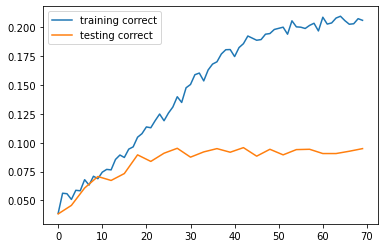

In [28]:
#ohem_weighted_ratio_.1

plt.plot(np.array(train_correct)/len(train), label='training correct')
plt.plot(range(0,epochs,3),np.array(test_correct)/len(test),label = 'testing correct')
plt.legend()

In [ ]:
test_correct

In [ ]:
#regular
plt.plot(train_losses, label='training loss')
plt.plot(range(0,epochs,3),test_losses,label = 'testing_loss')
plt.legend()

In [ ]:
#cos_ohem_.2
plt.plot(train_losses, label='training loss')
plt.plot(test_losses,label = 'testing_loss')
plt.legend()

In [ ]:
checkpoint_cosine_ohem_1 = torch.load("./checkpoints/cosine_ohem_20classes_0.1_50epochs/cosine_OHEM_0.1_50.pt")
checkpoint_ohem = torch.load("./checkpoints/ohem_20classes_50epochs/OHEM50.pt")

In [ ]:
modelA = resnet50()
modelA.load_state_dict(checkpoint_cosine_ohem_1['model_state_dict'])

In [ ]:
losses = checkpoint_ohem['losses']
losses_2 = checkpoint_cosine_ohem_1['losses']

In [ ]:
plt.plot(np.array(losses)[1]/len(train))
plt.plot(np.array(losses_2)[1]/len(train))

In [ ]:
hist_cosine_ohem_1 = checkpoint_cosine_ohem['hist']
hist_ohem = checkpoint_cosine_ohem['hist']

In [ ]:
predicted_cosine_ohem_1 = [torch.max(np.array(hist_cosine_ohem_1)[:,0][i]) for i in range(len(hist_cosine_ohem_1))]
predicted_ohem = [torch.max(np.array(hist_ohem)[:,0][i]) for i in range(len(hist_ohem))]

In [ ]:
for b, (X_test, y_test) in enumerate(test_load_all):
    print(X_test.shape)
    break

In [29]:
test_load_all = DataLoader(test, batch_size = 100, shuffle=True)


In [30]:
with torch.no_grad():
    correct = 0
    print(1)
    for b,(X_test, y_test) in enumerate(test_load_all):
        
        y_val = model(X_test)
        y_val = F.softmax(y_val,dim=1)
        predicted = torch.max(y_val.data,1)[1]
        correct += (predicted == torch.argmax(torch.reshape(y_test.long(),(-1,class_length)),dim=1)).sum()
        print(correct)
    print((correct/len(test))*100)

1
tensor(9, device='cuda:0')
tensor(22, device='cuda:0')
tensor(34, device='cuda:0')
tensor(44, device='cuda:0')
tensor(56, device='cuda:0')
tensor(61, device='cuda:0')
tensor(69, device='cuda:0')
tensor(75, device='cuda:0')
tensor(94, device='cuda:0')
tensor(104, device='cuda:0')
tensor(116, device='cuda:0')
tensor(123, device='cuda:0')
tensor(131, device='cuda:0')
tensor(138, device='cuda:0')
tensor(144, device='cuda:0')
tensor(155, device='cuda:0')
tensor(165, device='cuda:0')
tensor(175, device='cuda:0')
tensor(185, device='cuda:0')
tensor(193, device='cuda:0')
tensor(200, device='cuda:0')
tensor(209, device='cuda:0')
tensor(217, device='cuda:0')
tensor(225, device='cuda:0')
tensor(231, device='cuda:0')
tensor(241, device='cuda:0')
tensor(249, device='cuda:0')
tensor(258, device='cuda:0')
tensor(264, device='cuda:0')
tensor(273, device='cuda:0')
tensor(283, device='cuda:0')
tensor(290, device='cuda:0')
tensor(296, device='cuda:0')
tensor(313, device='cuda:0')
tensor(322, device='cu

In [37]:
cosine_loss = lambda x,y: 1 - torch.sum(x*y,axis=1)

def plot_decision_boundary(x,y):
    x_span = np.linspace(min(x[:,0]),max(x[:,0]))
    y_span = np.linspace(min(x[:,1]),max(x[:,1]))
    xx,yy = np.meshgrid(x_span,y_span)
    grid = torch.Tensor(np.c_[xx.ravel(),yy.ravel()])
    pred_func=F.log_softmax(model(grid))
    z = pred_func.view(xx.shape).detach().numpy()
    plt.contourf(xx,yy,z)

def loss_contour_plot(loss):
    x1 = np.linspace(-10.0, 10.0, 100)
    x2 = np.linspace(-10.0, 10.0, 100)
    X1, X2 = np.meshgrid(x1, x2)
    Y = loss
    cm = plt.cm.get_cmap('viridis')
    plt.scatter(X1, X2, c=Y, cmap=cm)
    plt.show()   

In [45]:
class_range = range(len(train_csv['class'].unique()))


In [46]:
min(class_range[:,0])

TypeError: range indices must be integers or slices, not tuple

In [43]:
plot_decision_boundary(class_range, class_range)

IndexError: too many indices for array

In [ ]:
#generalized transform
'''frontal_train_reshaped =[]
#i is a pil image
transform = transforms.Compose([
    transforms.Resize((int(most_freq_y),int(most_freq_y))),
    transforms.ToTensor(),
])
for i in frontal_train:
    frontal_train.append(transform(i))'''

In [ ]:
'''frontal_test =[]
lateral_test =[]

transform = transforms.Compose([
    transforms.Resize((98,98)),
    transforms.ToTensor(),
])
i = 0
for patient in glob.glob('./CheXpert-v1.0-small/CheXpert-v1.0-small/valid/*'):
    for study in glob.glob(patient+'/*'):
        for image_name in glob.glob(study+'/*'):
            print(os.path.basename(image_name))
            if(i in test['id']):
                img = Image.open(image_name)
                if(method=='numpy'):
                    pix = np.array(img)
                    img = zoom(pix,(1/4))
                    #1/4
                if(method=='tensorflow'):
                    pix = tf.image.convert_image_dtype(img, dtype = tf.float64)
                    img = tf.image.resize(img, size = (img.size[0]//4, img.size[1]//4))
                if(pytorch == True):
                    img = transforms.functional.to_pil_image(img)
                    img = transform(img)
                if(re.search('frontal',os.path.basename(image_name))!=None):
                    frontal_test.append(img)
                else:
                    lateral_test.append(img)       
            i+=1     '''

In [ ]:
label_train_arr = [torch.argmax(train[i][1],axis=1) for i in range(len(train))]
label_test_arr = [torch.argmax(test[i][1],axis=1) for i in range(len(train))]

In [ ]:
torch.bincount(torch.cat(label_train_arr))

In [ ]:
torch.bincount(torch.cat(label_test_arr))